In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import sys
import os
import glob
import random
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

from scipy.stats import boxcox
from scipy.special import boxcox1p
from scipy.stats import mode
from scipy import stats

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.set_printoptions(threshold=sys.maxsize)

In [55]:
# Read dataset
df = pd.read_csv(r'D:\Google Drive\University of York courses\Independent Research Proposal\dissertation\data\preprocessed\data_time_series_forecasting_final.csv')
df.set_index('unique_id', inplace=True)
df["unique_id_time"] = pd.to_datetime(df["unique_id_time"])
print("Rows: ", df.shape[0])
print("Features: " + str(df.shape[1]) + "\n")
df.head(3)

Rows:  63525
Features: 20



key_neighb unique_id_time  crime_count_t  crime_count_t+1  women_vic_t  women_vic_t+1  men_vic_t  men_vic_t+1  less_18_vic_t  less_18_vic_t+1  18_to_29_vic_t  18_to_29_vic_t+1  30_to_39_vic_t  30_to_39_vic_t+1  40_to_49_vic_t  40_to_49_vic_t+1  50_to_59_vic_t  50_to_59_vic_t+1  more_60_vic_t  more_60_vic_t+1
unique_id                                                                                                                                                                                                                                                                                                                        
2019202-001     02-001     2019-02-01            0.0                1          0.0              0        0.0            0            0.0                0             0.0                 0             0.0                 0             0.0                 0             0.0                 0            0.0                0
2019302-001     02-001     2019-03-01            1.0                0          0.0              0        0.0            0            0.0                0             0.0                 0             0.0                 0             0.0                 0             0.0                 0            0.0                0
2019402-001     02-001     2019-04-01            0.0                1          0.0              0        0.0            1            0.0                0             0.0                 1             0.0                 0             0.0                 0             0.0                 0            0.0                0

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63525 entries, 2019202-001 to 20211210-240
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key_neighb        63525 non-null  object        
 1   unique_id_time    63525 non-null  datetime64[ns]
 2   crime_count_t     63525 non-null  float64       
 3   crime_count_t+1   63525 non-null  int64         
 4   women_vic_t       63525 non-null  float64       
 5   women_vic_t+1     63525 non-null  int64         
 6   men_vic_t         63525 non-null  float64       
 7   men_vic_t+1       63525 non-null  int64         
 8   less_18_vic_t     63525 non-null  float64       
 9   less_18_vic_t+1   63525 non-null  int64         
 10  18_to_29_vic_t    63525 non-null  float64       
 11  18_to_29_vic_t+1  63525 non-null  int64         
 12  30_to_39_vic_t    63525 non-null  float64       
 13  30_to_39_vic_t+1  63525 non-null  int64         
 14  40_to_49_v

In [57]:
df.columns

Index(['key_neighb', 'unique_id_time', 'crime_count_t', 'crime_count_t+1', 'women_vic_t', 'women_vic_t+1', 'men_vic_t', 'men_vic_t+1', 'less_18_vic_t', 'less_18_vic_t+1', '18_to_29_vic_t', '18_to_29_vic_t+1', '30_to_39_vic_t', '30_to_39_vic_t+1', '40_to_49_vic_t', '40_to_49_vic_t+1', '50_to_59_vic_t', '50_to_59_vic_t+1', 'more_60_vic_t', 'more_60_vic_t+1'], dtype='object')

# Training and testing sets

In [58]:
dfs_neighborhood_list = []
for neighborhood in df.key_neighb.unique():
    dfn = df[df.key_neighb == neighborhood]
    dfn = dfn.sort_values(by=('unique_id_time'))
    dfs_neighborhood_list.append(dfn)

In [59]:
print(dfs_neighborhood_list[-5].shape)
dfs_neighborhood_list[-5].head()

(35, 20)


key_neighb unique_id_time  crime_count_t  crime_count_t+1  women_vic_t  women_vic_t+1  men_vic_t  men_vic_t+1  less_18_vic_t  less_18_vic_t+1  18_to_29_vic_t  18_to_29_vic_t+1  30_to_39_vic_t  30_to_39_vic_t+1  40_to_49_vic_t  40_to_49_vic_t+1  50_to_59_vic_t  50_to_59_vic_t+1  more_60_vic_t  more_60_vic_t+1
unique_id                                                                                                                                                                                                                                                                                                                        
2019210-236     10-236     2019-02-01            1.0                1          0.0              0        0.0            1            0.0                1             0.0                 0             0.0                 0             0.0                 0             0.0                 0            0.0                0
2019310-236     10-236     2019-03-01            1.0                0          0.0              0        1.0            0            1.0                0             0.0                 0             0.0                 0             0.0                 0             0.0                 0            0.0                0
2019410-236     10-236     2019-04-01            0.0                0          0.0              0        0.0            0            0.0                0             0.0                 0             0.0                 0             0.0                 0             0.0                 0            0.0                0
2019510-236     10-236     2019-05-01            0.0                0          0.0              0        0.0            0            0.0                0             0.0                 0             0.0                 0             0.0                 0             0.0                 0            0.0                0
2019610-236     10-236     2019-06-01            0.0                0          0.0              0        0.0            0            0.0                0             0.0                 0             0.0                 0             0.0                 0             0.0                 0            0.0                0

In [60]:
np.mean((dfs_neighborhood_list[0]['crime_count_t+1'] - dfs_neighborhood_list[0]['crime_count_t']))

0.0

In [61]:
def splitTrainingSets(df):
    X_cols = ['crime_count_t', 'women_vic_t', 'women_vic_t+1', 'men_vic_t', 'men_vic_t+1', 'less_18_vic_t', 'less_18_vic_t+1', '18_to_29_vic_t', '18_to_29_vic_t+1', '30_to_39_vic_t', '30_to_39_vic_t+1', '40_to_49_vic_t', '40_to_49_vic_t+1', '50_to_59_vic_t', '50_to_59_vic_t+1', 'more_60_vic_t', 'more_60_vic_t+1']
    y_cols = ['crime_count_t+1']
    
    # Features
    X = df[['crime_count_t', 'women_vic_t', 'women_vic_t+1', 'men_vic_t', 'men_vic_t+1', 'less_18_vic_t', 'less_18_vic_t+1', '18_to_29_vic_t', '18_to_29_vic_t+1', '30_to_39_vic_t', '30_to_39_vic_t+1', '40_to_49_vic_t', '40_to_49_vic_t+1', '50_to_59_vic_t', '50_to_59_vic_t+1', 'more_60_vic_t', 'more_60_vic_t+1']].values

    # Target
    y = df[['crime_count_t+1']].values
    
    train_size = int(len(X) * 0.8)
    print('Train size: ', train_size)

    # Split the dataset into train and test sets
    X_train_values, X_test_values = X[0: train_size], X[train_size: len(X)]
    X_train = pd.DataFrame(X_train_values)
    X_train.columns = X_cols
    X_test = pd.DataFrame(X_test_values)
    X_test.columns = X_cols
    
    y_train_values, y_test_values = y[0:train_size], y[train_size: len(y)]
    y_train = pd.DataFrame(y_train_values)
    y_train.columns = y_cols
    y_test = pd.DataFrame(y_test_values)
    y_test.columns = y_cols
    
    return X_train, y_train, X_test, y_test

In [62]:
def doWalkForwardValidation(df, n_min_train=20):
    X = df[['crime_count_t', 'women_vic_t', 'women_vic_t+1', 'men_vic_t', 'men_vic_t+1', 'less_18_vic_t', 'less_18_vic_t+1', '18_to_29_vic_t', '18_to_29_vic_t+1', 
            '30_to_39_vic_t', '30_to_39_vic_t+1', '40_to_49_vic_t', '40_to_49_vic_t+1', '50_to_59_vic_t', '50_to_59_vic_t+1', 'more_60_vic_t', 'more_60_vic_t+1']].values
    y = df[['crime_count_t+1']].values
    n_records = len(X)
    print(n_records)
    for i in range(n_train, n_records):
        X_train_values, X_test_values = X[0:i], X[i:i+1]
        X_train = pd.DataFrame(X_train_values)
        X_train.columns = features_cols
        X_test = pd.DataFrame(X_test_values)
        X_test.columns = features_cols
        
        y_train_values, y_test_values = y[i:i], y[i:i+1]
        y_train = pd.DataFrame(y_train_values)
        y_train.columns = target_col
        y_test = pd.DataFrame(y_test_values)
        y_test.columns = features_cols
    

# Yeo-Johnson power transform

In [63]:
def transformYeoJohnson(train_values, test_values, list_cols):
    pt_yj = PowerTransformer(method='yeo-johnson') # Perform a yeo-johnson transform of the dataset
    pt_yj.fit(train_values)
    train_trans_vals = pt_yj.transform(train_values)
    test_trans_vals = pt_yj.transform(test_values)
    df_train_trans = pd.DataFrame(train_trans_vals)
    df_train_trans.columns = list_cols
    df_test_trans = pd.DataFrame(test_trans_vals)
    df_test_trans.columns = list_cols
    return df_train_trans, df_test_trans


# Min-max normalization

In [64]:
def minmaxNormalization(train_values, test_values, name_cols):
    scaler = MinMaxScaler() # Define min max scaler
    scaler.fit(train_values)
    n_train_values = scaler.transform(train_values)
    n_test_values = scaler.transform(test_values)
    n_train_df = pd.DataFrame(n_train_values)
    n_test_df = pd.DataFrame(n_test_values)
    n_train_df.columns = name_cols
    n_test_df.columns = name_cols
    return n_train_df, n_test_df

# Putting it all together (pre-training)

In [65]:
def setTrainingTestingData(data):
    
    X_cols = ['women_vic_t+1', 'men_vic_t+1', 'less_18_vic_t+1', '18_to_29_vic_t+1', '30_to_39_vic_t+1', '40_to_49_vic_t+1', '50_to_59_vic_t+1', 'more_60_vic_t+1']
    y_cols = ['crime_count_t+1']
    
    df = data.copy()
    X_train, y_train, X_test, y_test = splitTrainingSets(df)
 
    return X_train, y_train, X_test, y_test
        

# Forecasting crime counts

In [66]:
def splitSequences(df, n_steps):
    # Features
    X_values = df[['crime_count_t', 'women_vic_t', 'women_vic_t+1', 'men_vic_t', 'men_vic_t+1', 'less_18_vic_t', 'less_18_vic_t+1', '18_to_29_vic_t', '18_to_29_vic_t+1', '30_to_39_vic_t', '30_to_39_vic_t+1', '40_to_49_vic_t', '40_to_49_vic_t+1', '50_to_59_vic_t', '50_to_59_vic_t+1', 'more_60_vic_t', 'more_60_vic_t+1']]
    # Target
    y_values = df[['crime_count_t+1']]
    # Join sequences
    sequences_df = pd.concat([X_values, y_values], axis=1)
    print(sequences_df.shape)
    sequences = sequences_df.values
    # Split the dataset into samples of train and test sets
    X, y = list(), list()
    for i in range(len(sequences)):
        end_i = i + n_steps # find the end of the pattern
        if end_i  > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_i, :-1], sequences[end_i-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    print(len(X))
    print(len(y))
    return np.array(X), np.array(y)
    
    
def splitTrainingTestingLSTM(X, y):
    train_size = int(len(X) * 0.8)
    print('Train size: ', train_size)
    # Split the dataset into train and test sets
    X_train, X_test = X[0: train_size], X[train_size: len(X)]
    y_train, y_test = y[0:train_size], y[train_size: len(y)]
    return X_train, y_train, X_test, y_test

In [74]:
def trainEvaluateModels(list_data):
    baseline_bias_list = []
    baseline_mae_list = []
    baseline_rmse_list = []
    
    lr_bias_list = []
    lr_mae_list = []
    lr_rmse_list = []
    
    dt_bias_list = []
    dt_mae_list = []
    dt_rmse_list = []
    
    rf_bias_list = []
    rf_mae_list = []
    rf_rmse_list = []
    importances_list = []
    
    mlp_bias_list = []
    mlp_mae_list = []
    mlp_rmse_list = []
    
    lstm_bias_list = []
    lstm_mae_list = []
    lstm_rmse_list = []
    
    print('Starting training...................................................', '\n')
    for df in list_data:
        print('For neighborhood with key ' + str(df.key_neighb.unique()[0]) + ' ...................................................' + '\n')
        print('Shape of data: ', df.shape)
        X_train, y_train, X_test, y_test = setTrainingTestingData(df)
        print('Shape of X_train: ', X_train.shape)
        print('Shape of y_train: ', y_train.shape)
        print('Shape of X_test: ', X_test.shape)
        print('Shape of y_test: ', y_test.shape)
        
        # Baseline forecasts
        baseline_forecasts = X_test["crime_count_t"]
        print(baseline_forecasts.shape)
        print(y_test.shape)
        bias1 = np.mean(y_test['crime_count_t+1'] - baseline_forecasts)
        mae1 = mean_absolute_error(y_test, baseline_forecasts)
        rmse1 = np.sqrt(mean_squared_error(y_test, baseline_forecasts))
        
        baseline_bias_list.append(bias1)
        baseline_mae_list.append(mae1)
        baseline_rmse_list.append(rmse1)
        
        print('Baseline bias: ', bias1)
        print('Baseline Mean Absolute Error:', mae1)  
        print('Baseline Root Mean Squared Error:', rmse1)
        
        # Multi-variate linear regression
        lr_model = linear_model.LinearRegression()
        lr_model.fit(X_train, y_train)
        y_pred_lm = lr_model.predict(X_test)
        
        bias2 = np.mean(y_test['crime_count_t+1'].values - y_pred_lm)
        mae2 = mean_absolute_error(y_test, y_pred_lm)
        rmse2 = np.sqrt(mean_squared_error(y_test, y_pred_lm))
        
        lr_bias_list.append(bias2)
        lr_mae_list.append(mae2)
        lr_rmse_list.append(rmse2)
        
        print('Multi-variate linear regression bias: ', bias2)
        print('Multi-variate linear regression Mean Absolute Error:', mae2)  
        print('Multi-variate linear regression Root Mean Squared Error:', rmse2)
        
        #Decision tree regressor
        decision_tree_model = DecisionTreeRegressor(random_state = 42) 
        decision_tree_model.fit(X_train, y_train)
        y_pred_dt = decision_tree_model.predict(X_test)
        
        bias3 = np.mean(y_test['crime_count_t+1'].values - y_pred_dt)
        mae3 = mean_absolute_error(y_test, y_pred_dt)
        rmse3 = np.sqrt(mean_squared_error(y_test, y_pred_dt))
        
        dt_bias_list.append(bias3)
        dt_mae_list.append(mae3)
        dt_rmse_list.append(rmse3)
        
        print('Decision tree regressor bias: ', bias3)
        print('Decision tree regressor Mean Absolute Error:', mae3)  
        print('Decision tree regressor Root Mean Squared Error:', rmse3)
        
        #Random forest regressor
        rf_model = RandomForestRegressor(random_state = 42)
        rf_model.fit(X_train, y_train)
        y_pred_rf = rf_model.predict(X_test)
        
        bias4 = np.mean(y_test['crime_count_t+1'].values - y_pred_rf)
        mae4 = mean_absolute_error(y_test, y_pred_rf)
        rmse4 = np.sqrt(mean_squared_error(y_test, y_pred_rf))
        
        rf_bias_list.append(bias4)
        rf_mae_list.append(mae4)
        rf_rmse_list.append(rmse4)
        
        print('Random forest regressor bias: ', bias4)
        print('Random forest regressor Mean Absolute Error:', mae4)  
        print('Random forest regressor Root Mean Squared Error:', rmse4)
        
        importances = list(rf_model.feature_importances_) # Get numerical feature importances
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(['crime_count_t', 'women_vic_t', 'women_vic_t+1', 'men_vic_t', 'men_vic_t+1', 'less_18_vic_t', 'less_18_vic_t+1', '18_to_29_vic_t', '18_to_29_vic_t+1', '30_to_39_vic_t', '30_to_39_vic_t+1', '40_to_49_vic_t', '40_to_49_vic_t+1', '50_to_59_vic_t', '50_to_59_vic_t+1', 'more_60_vic_t', 'more_60_vic_t+1'], importances)] # List of tuples with variable and importance
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True) # Sort the feature importances by most important first
        importances_list.append(feature_importances)
        
        #Multi-layer perceptron
        mlp_model = MLPRegressor(hidden_layer_sizes=(20,20), activation="relu", random_state=42, max_iter=1000)
        mlp_model.fit(X_train, y_train)
        y_pred_mlp = mlp_model.predict(X_test)
        
        bias5 = np.mean(y_test['crime_count_t+1'].values - y_pred_mlp)
        mae5 = mean_absolute_error(y_test, y_pred_mlp)
        rmse5 = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
        
        mlp_bias_list.append(bias5)
        mlp_mae_list.append(mae5)
        mlp_rmse_list.append(rmse5)
        
        print('MLP bias: ', bias5)
        print('MLP Mean Absolute Error:', mae5)  
        print('MLP Root Mean Squared Error:', rmse5)
    
        #LSTM training and testing
        print()
        print("***********************LSTM training************************************", "\n")
        X, y = splitSequences(df, 2) # step 2
        X_train_l, y_train_l, X_test_l, y_test_l = splitTrainingTestingLSTM(X, y)
        # Vanilla LSTM
        n_nodes = 50 # Number of LSTM units to use in the hidden layer
        n_steps = X.shape[1]
        n_features = X.shape[2]
        n_epochs = 50 # Number of times to expose the model to the whole training dataset
        n_batch = 100 # Number of samples within an epoch after which the weights are updated

        model = Sequential()
        model.add(LSTM(n_nodes, activation = 'relu', input_shape=(n_steps, n_features)))
        model.add(Dense(n_nodes, activation = 'relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train_l, y_train_l, epochs=n_epochs, batch_size=n_batch, verbose=0)
        y_pred_lstm = model.predict(X_test_l, verbose=0)
        
        bias6 = np.mean(y_test_l- y_pred_lstm)
        mae6 = mean_absolute_error(y_test_l, y_pred_lstm)
        rmse6 = np.sqrt(mean_squared_error(y_test_l, y_pred_lstm))
        
        print('LSTM bias: ', bias6)
        print('LSTM Mean Absolute Error:', mae6)  
        print('LSTM Root Mean Squared Error:', rmse6)
        
        lstm_bias_list.append(bias6)
        lstm_mae_list.append(mae6)
        lstm_rmse_list.append(rmse6)

    return baseline_bias_list, baseline_mae_list, baseline_rmse_list, lr_bias_list, lr_mae_list, lr_rmse_list, dt_bias_list, dt_mae_list, dt_rmse_list, rf_bias_list, rf_mae_list, rf_rmse_list, mlp_bias_list, mlp_mae_list, mlp_rmse_list, lstm_bias_list, lstm_mae_list, lstm_rmse_list   
 

In [75]:
baseline_bias_list, baseline_mae_list, baseline_rmse_list, lr_bias_list, lr_mae_list, lr_rmse_list, dt_bias_list, dt_mae_list, dt_rmse_list, rf_bias_list, rf_mae_list, rf_rmse_list, mlp_bias_list, mlp_mae_list, mlp_rmse_list, lstm_bias_list, lstm_mae_list, lstm_rmse_list = trainEvaluateModels(dfs_neighborhood_list)

Starting training................................................... 

For neighborhood with key 02-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.007091378435644142
Multi-variate linear regression Mean Absolute Error: 0.35797472320869017
Multi-variate linear regression Root Mean Squared Error: 0.38581280205940766
Decision tree regressor bias:  0.07142857142857144
Decision tree regressor Mean Absolute Error: 0.21428571428571433
Decision tree regressor Root Mean Squared Error: 0.3933978962347215


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09212564419707274
Random forest regressor Mean Absolute Error: 0.24118501339929907
Random forest regressor Root Mean Squared Error: 0.30238509322900337
MLP bias:  0.16900724827218935
MLP Mean Absolute Error: 0.3422504420330314
MLP Root Mean Squared Error: 0.456437956200524

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.06263297370501927
LSTM Mean Absolute Error: 0.4143266635281699
LSTM Root Mean Squared Error: 0.45164482287149665
For neighborhood with key 02-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.6397210381135879
Multi-variate linear regression Mean Absolute Error: 1.1899460177704935
Multi-variate linear regression Root Mean Squared Error: 1.5756913338545546
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 0.8451542547285166


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.28164965986394563
Random forest regressor Mean Absolute Error: 0.7094047619047619
Random forest regressor Root Mean Squared Error: 0.8193951108394768


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3114846183390537
MLP Mean Absolute Error: 0.8875907784060578
MLP Root Mean Squared Error: 1.0779368527732114

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.25886014103889465
LSTM Mean Absolute Error: 0.5564074303422656
LSTM Root Mean Squared Error: 0.6059483846545222
For neighborhood with key 02-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  -0.6477633167466944
Multi-variate linear regression Mean Absolute Error: 1.024556840780649
Multi-variate linear regression Root Mean Squared Error: 1.2988211245321521
Decision tree regressor bias:  -2.142857142857143
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.0571428571428572
Random forest regressor Mean Absolute Error: 1.122857142857143
Random forest regressor Root Mean Squared Error: 1.5058552387264852


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.212019675342803
MLP Mean Absolute Error: 1.2242196155339318
MLP Root Mean Squared Error: 1.5160046613332525

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.17068663665226527
LSTM Mean Absolute Error: 0.8719411407198224
LSTM Root Mean Squared Error: 1.1072054257966641
For neighborhood with key 02-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  -0.8241065468256509
Multi-variate linear regression Mean Absolute Error: 0.957710724878234
Multi-variate linear regression Root Mean Squared Error: 1.1864175493167783
Decision tree regressor bias:  -0.42857142857142855
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8471428571428571
Random forest regressor Mean Absolute Error: 0.8471428571428571
Random forest regressor Root Mean Squared Error: 0.9273849562845285


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8687566372099184
MLP Mean Absolute Error: 0.8878336680040334
MLP Root Mean Squared Error: 1.1183006166417306

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0909748545714787
LSTM Mean Absolute Error: 0.49929408941950115
LSTM Root Mean Squared Error: 0.5890042308024857
For neighborhood with key 02-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.8284271247461903
Multi-variate linear regression bias:  -0.15190756511128833
Multi-variate linear regression Mean Absolute Error: 3.1287794845290913
Multi-variate linear regression Root Mean Squared Error: 3.7514797993605353
Decision tree regressor bias:  0.14285714285714285
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.18857142857142847
Random forest regressor Mean Absolute Error: 2.237142857142857
Random forest regressor Root Mean Squared Error: 2.452800149100732


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4152431202838858
MLP Mean Absolute Error: 2.33197735455024
MLP Root Mean Squared Error: 2.876878793652121

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.7152398654392786
LSTM Mean Absolute Error: 2.5518581526620046
LSTM Root Mean Squared Error: 3.050869309309246
For neighborhood with key 02-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.0
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.722518348798681
Multi-variate linear regression bias:  1.2249350855088796
Multi-variate linear regression Mean Absolute Error: 1.8441044867562688
Multi-variate linear regression Root Mean Squared Error: 2.672155067650307
Decision tree regressor bias:  1.2857142857142858
Decision tree regressor Mean 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.0842857142857143
Random forest regressor Mean Absolute Error: 2.0414285714285714
Random forest regressor Root Mean Squared Error: 3.191678913317298


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.5482343458584098
MLP Mean Absolute Error: 2.785033564603419
MLP Root Mean Squared Error: 3.6981023426376174

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  2.0882521867752075
LSTM Mean Absolute Error: 3.018285938671657
LSTM Root Mean Squared Error: 4.200207905502454
For neighborhood with key 02-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -1.5006517804400357
Multi-variate linear regression Mean Absolute Error: 1.6406859398556715
Multi-variate linear regression Root Mean Squared Error: 2.2180145836457976
Decision tree regressor bias:  -0.8571428571428571
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5
Random forest regressor Mean Absolute Error: 1.0085714285714287
Random forest regressor Root Mean Squared Error: 1.1897418687621757


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8200423602014569
MLP Mean Absolute Error: 1.326353832494092
MLP Root Mean Squared Error: 1.5579977414349737

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.7347070149012974
LSTM Mean Absolute Error: 1.1373769896371024
LSTM Root Mean Squared Error: 1.2750309818408794
For neighborhood with key 02-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.9266358289763315
Multi-variate linear regression Mean Absolute Error: 0.9880428295833422
Multi-variate linear regression Root Mean Squared Error: 1.6148394028403363
Decision tree regressor bias:  -0.4571428571428572
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2071768707482993
Random forest regressor Mean Absolute Error: 0.3547006802721088
Random forest regressor Root Mean Squared Error: 0.48428858235660666


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.608604017900053
MLP Mean Absolute Error: 0.8513367348523395
MLP Root Mean Squared Error: 1.299407836246366

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.39844716446740286
LSTM Mean Absolute Error: 0.44635105984551565
LSTM Root Mean Squared Error: 0.5092298790216873
For neighborhood with key 02-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.6104161596495499
Multi-variate linear regression Mean Absolute Error: 0.9800438062789002
Multi-variate linear regression Root Mean Squared Error: 1.189008504824203
Decision tree regressor bias:  -0.3428571428571429
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10877177584320441
Random forest regressor Mean Absolute Error: 0.36555252683824113
Random forest regressor Root Mean Squared Error: 0.5595075477641099


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.21112943272516116
MLP Mean Absolute Error: 0.48291697206269274
MLP Root Mean Squared Error: 0.6107448975389258

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.11020213152681078
LSTM Mean Absolute Error: 0.39097329335553305
LSTM Root Mean Squared Error: 0.4265872109634994
For neighborhood with key 02-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 02-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.09523809523809497
Multi-variate linear regression Mean Absolute Error: 0.47619047619047655
Multi-variate linear regression Root Mean Squared Error: 0.8544932592822078
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.8451542547285166


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2944761904761905
Random forest regressor Mean Absolute Error: 0.49885714285714283
Random forest regressor Root Mean Squared Error: 0.8253235632931997
MLP bias:  0.31641974871174144
MLP Mean Absolute Error: 0.43573088319608383
MLP Root Mean Squared Error: 0.7703153553445587

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.47234528831073214
LSTM Mean Absolute Error: 0.6519673498613494
LSTM Root Mean Squared Error: 0.9663907475532788
For neighborhood with key 02-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.07381837493361627
Multi-variate linear regression Mean Absolute Error: 0.3175783324482206
Multi-variate linear regression Root Mean Squared Error: 0.42399092508256947
Decision tree regressor bias:  0.2063492063492063
Decision tree regressor Mean Absolute Error: 0.30158730158730157
Decision tree regressor Root Mean Squared Error: 0.48066679141989593


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.18632838986410416
Random forest regressor Mean Absolute Error: 0.28362286523000807
Random forest regressor Root Mean Squared Error: 0.4465144350516479
MLP bias:  0.054147861232756646
MLP Mean Absolute Error: 0.213570051451541
MLP Root Mean Squared Error: 0.35528054678522675

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0571925299508231
LSTM Mean Absolute Error: 0.4156038761138916
LSTM Root Mean Squared Error: 0.44286971212213133
For neighborhood with key 02-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  0.18631070085387771
Multi-variate linear regression Mean Absolute Error: 1.0482333375203612
Multi-variate linear regression Root Mean Squared Error: 1.330522082716963
Decision tree regressor bias:  -0.7142857142857143
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 2.104417123236605


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.16999999999999998
Random forest regressor Mean Absolute Error: 0.9071428571428571
Random forest regressor Root Mean Squared Error: 1.1510057713644557


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.1446214696242687
MLP Mean Absolute Error: 0.8854213103786618
MLP Root Mean Squared Error: 1.1932920075560927

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.23488724657467433
LSTM Mean Absolute Error: 0.8996555762631553
LSTM Root Mean Squared Error: 1.1752113485512223
For neighborhood with key 02-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.927248223318863
Multi-variate linear regression bias:  -0.33607852522349174
Multi-variate linear regression Mean Absolute Error: 0.6732051354629901
Multi-variate linear regression Root Mean Squared Error: 0.7685532583318411
Decision tree regressor bias:  0.14285714285714285
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.27285714285714285
Random forest regressor Mean Absolute Error: 0.29857142857142854
Random forest regressor Root Mean Squared Error: 0.7565428889740111


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.11190448260557631
MLP Mean Absolute Error: 0.47203253444896986
MLP Root Mean Squared Error: 0.8031760032135633

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.09561026522091456
LSTM Mean Absolute Error: 0.9087958974497659
LSTM Root Mean Squared Error: 1.0727491237855578
For neighborhood with key 02-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.41125541125541104
Multi-variate linear regression Mean Absolute Error: 0.7627705627705625
Multi-variate linear regression Root Mean Squared Error: 0.9769560546027393
Decision tree regressor bias:  0.2554112554112555
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2752927625595693
Random forest regressor Mean Absolute Error: 0.6130587272204918
Random forest regressor Root Mean Squared Error: 0.6540350312637446
MLP bias:  0.30318378683003006
MLP Mean Absolute Error: 0.6340110216529486
MLP Root Mean Squared Error: 0.6878698171446795

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.26480951266629355
LSTM Mean Absolute Error: 0.5452158600091934
LSTM Root Mean Squared Error: 0.5792005433028847
For neighborhood with key 02-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  -1.275266957422012
Multi-variate linear regression Mean Absolute Error: 1.8458193188677636
Multi-variate linear regression Root Mean Squared Error: 2.0311036195514434
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.0690449676496976


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.47000000000000003
Random forest regressor Mean Absolute Error: 0.65
Random forest regressor Root Mean Squared Error: 0.8240752392834043


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8957195514621102
MLP Mean Absolute Error: 0.8957195514621102
MLP Root Mean Squared Error: 1.0754250776174326

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0700973357473101
LSTM Mean Absolute Error: 0.6917065467153277
LSTM Root Mean Squared Error: 0.7884611972579019
For neighborhood with key 02-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.14285714285714285
Multi-variate linear regression Mean Absolute Error: 0.14285714285714285
Multi-variate linear regression Root Mean Squared Error: 0.3779644730092272
Decision tree regressor bias:  0.14285714285714285
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  0.17246921582190464
MLP Mean Absolute Error: 0.17246921582190464
MLP Root Mean Squared Error: 0.38611159127687067

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.1422753640882937
LSTM Mean Absolute Error: 0.14385045324784837
LSTM Root Mean Squared Error: 0.3779818232292008
For neighborhood with key 02-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 02-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  0.5756938490899798
Multi-variate linear regression Mean Absolute Error: 1.1372590443512556
Multi-variate linear regression Root Mean Squared

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3614285714285715
Random forest regressor Mean Absolute Error: 0.7557142857142856
Random forest regressor Root Mean Squared Error: 1.114431309169454


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5715768752736559
MLP Mean Absolute Error: 1.1486956289567627
MLP Root Mean Squared Error: 1.5696538351889358

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08534009116036552
LSTM Mean Absolute Error: 0.74543867792402
LSTM Root Mean Squared Error: 0.999192434763593
For neighborhood with key 02-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  -0.8440090061876085
Multi-variate linear regression Mean Absolute Error: 1.6365812494447967
Multi-variate linear regression Root Mean Squared Error: 1.7701060644212607
Decision tree regressor bias:  -0.7142857142857143
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.45000000000000007
Random forest regressor Mean Absolute Error: 1.032857142857143
Random forest regressor Root Mean Squared Error: 1.2562813606604444


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7491554126034629
MLP Mean Absolute Error: 0.9739274992507285
MLP Root Mean Squared Error: 1.1131159941534037

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.4029606580734253
LSTM Mean Absolute Error: 1.041120069367545
LSTM Root Mean Squared Error: 1.1486125058965317
For neighborhood with key 02-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.7142857142857143
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.1712405933672376
Multi-variate linear regression bias:  -0.25238482577027344
Multi-variate linear regression Mean Absolute Error: 1.6774158175415121
Multi-variate linear regression Root Mean Squared Error: 2.024655488300204
Decision tree regressor bias:  -0.5714285714285714
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6614285714285716
Random forest regressor Mean Absolute Error: 1.0642857142857145
Random forest regressor Root Mean Squared Error: 1.3502539443696193


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.1291525949164853
MLP Mean Absolute Error: 1.8816464599615206
MLP Root Mean Squared Error: 2.1703026904535068

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.6635076999664307
LSTM Mean Absolute Error: 0.8992396082196917
LSTM Root Mean Squared Error: 1.0723526146774534
For neighborhood with key 02-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 3.2857142857142856
Baseline Root Mean Squared Error: 4.456135417280635
Multi-variate linear regression bias:  3.415541647010551
Multi-variate linear regression Mean Absolute Error: 5.007942844951537
Multi-variate linear regression Root Mean Squared Error: 5.768646403191857
Decision tree regressor bias:  1.7142857142857142
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.1128571428571432
Random forest regressor Mean Absolute Error: 2.2014285714285715
Random forest regressor Root Mean Squared Error: 2.7466629103071862


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  n_samples = X.shape[0]


MLP bias:  2.0260082576609766
MLP Mean Absolute Error: 3.144200263761306
MLP Root Mean Squared Error: 3.4137692755861435

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  2.4352828434535434
LSTM Mean Absolute Error: 2.9296700613839284
LSTM Root Mean Squared Error: 4.290771086660658
For neighborhood with key 02-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 2.951996902824546
Multi-variate linear regression bias:  1.4380622354726398
Multi-variate linear regression Mean Absolute Error: 2.330853314769325
Multi-variate linear regression Root Mean Squared Error: 2.833116118247205
Decision tree regressor bias:  0.6857142857142857
Decision tre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5881801690373119
Random forest regressor Mean Absolute Error: 1.0667039785611212
Random forest regressor Root Mean Squared Error: 1.3360988786711763


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.9865953927281339
MLP Mean Absolute Error: 1.3726789421635657
MLP Root Mean Squared Error: 1.6814169683780165

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3059782385826111
LSTM Mean Absolute Error: 1.6245735798563277
LSTM Root Mean Squared Error: 1.757935456916358
For neighborhood with key 02-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.390457218668787
Multi-variate linear regression bias:  -0.3471139058666216
Multi-variate linear regression Mean Absolute Error: 0.7202085049499001
Multi-variate linear regression Root Mean Squared Error: 0.8613039904804074
Decision tree regressor bias:  0.7142857142857143
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4014285714285715
Random forest regressor Mean Absolute Error: 0.8157142857142858
Random forest regressor Root Mean Squared Error: 0.9282779756085998


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.03291022422221203
MLP Mean Absolute Error: 0.5785336312495285
MLP Root Mean Squared Error: 0.6986547524401465

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.45160735504967825
LSTM Mean Absolute Error: 1.1141453896250044
LSTM Root Mean Squared Error: 1.357146732824798
For neighborhood with key 02-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 2.1712405933672376
Multi-variate linear regression bias:  -0.0971163407358307
Multi-variate linear regression Mean Absolute Error: 0.6247928405701034
Multi-variate linear regression Root Mean Squared Error: 0.8773383264299335
Decision tree regressor bias:  -0.09523809523809527
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07789967035765354
Random forest regressor Mean Absolute Error: 0.7197871428291597
Random forest regressor Root Mean Squared Error: 1.1372019472805412


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.09533406784352046
MLP Mean Absolute Error: 0.692297504702524
MLP Root Mean Squared Error: 0.9228540474497146

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.27574516194207327
LSTM Mean Absolute Error: 0.9231603401047843
LSTM Root Mean Squared Error: 1.436576515830816
For neighborhood with key 02-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.13043478260869543
Multi-variate linear regression Mean Absolute Error: 0.16770186335403728
Multi-variate linear regression Root Mean Squared Error: 0.3793907591074647
Decision tree regressor bias:  0.12422360248447206
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2919672268873767
Random forest regressor Mean Absolute Error: 0.33026868960009254
Random forest regressor Root Mean Squared Error: 0.6713221931522556
MLP bias:  -0.011743263371684307
MLP Mean Absolute Error: 0.23003802536744092
MLP Root Mean Squared Error: 0.3429830545998096

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.27473780725683483
LSTM Mean Absolute Error: 0.40459227349076954
LSTM Root Mean Squared Error: 0.6424229488915472
For neighborhood with key 02-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.9301884382559304
Multi-variate linear regression Mean Absolute Error: 1.527239186056788
Multi-variate linear regression Root Mean Squared Error: 1.8619173397481412
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 0.8451542547285166


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.16142857142857142
Random forest regressor Mean Absolute Error: 0.6071428571428571
Random forest regressor Root Mean Squared Error: 0.7125307010929424


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.09246496753959473
MLP Mean Absolute Error: 0.6033112217944757
MLP Root Mean Squared Error: 0.7382043360879522

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.055952531950814385
LSTM Mean Absolute Error: 0.4670389550072806
LSTM Root Mean Squared Error: 0.6089976746248165
For neighborhood with key 02-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 02-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.03335031033915584
Multi-variate linear regression Mean Absolute Error: 0.8778066026193011
Multi-variate linear regression Root Mean Squared Error: 1.089222401621996
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 1.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08333333333333333
Random forest regressor Mean Absolute Error: 0.5847619047619048
Random forest regressor Root Mean Squared Error: 0.7433474801130869


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.13845856399043494
MLP Mean Absolute Error: 0.7923792168912186
MLP Root Mean Squared Error: 0.9599906587026433

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.04353881733758109
LSTM Mean Absolute Error: 0.706168898514339
LSTM Root Mean Squared Error: 0.7802777485660797
For neighborhood with key 02-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.285714285714286
Multi-variate linear regression Mean Absolute Error: 0.285714285714286
Multi-variate linear regression Root Mean Squared Error: 0.5345224838248488
Decision tree regressor bias:  0.2857142857142857
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2857142857142857
Random forest regressor Mean Absolute Error: 0.2857142857142857
Random forest regressor Root Mean Squared Error: 0.5345224838248488
MLP bias:  0.21658094626030072
MLP Mean Absolute Error: 0.25683700262726605
MLP Root Mean Squared Error: 0.45069344593332844

***********************LSTM training************************************ 

(35, 18)
34


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
Train size:  27
LSTM bias:  0.19833242148160934
LSTM Mean Absolute Error: 0.3217530410204615
LSTM Root Mean Squared Error: 0.4932305270417577
For neighborhood with key 02-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  9.572841385798544e-17
Multi-variate linear regression Mean Absolute Error: 2.285569475199745e-16
Multi-variate linear regression Root Mean Squared Error: 3.607097913636355e-16
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05142857142857143
Random forest regressor Mean Absolute Error: 0.05142857142857143
Random forest regressor Root Mean Squared Error: 0.1360672102833218
MLP bias:  -0.00821655284962372
MLP Mean Absolute Error: 0.00821655284962372
MLP Root Mean Squared Error: 0.01143687053290439

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.03646743191140039
LSTM Mean Absolute Error: 0.14999203277485712
LSTM Root Mean Squared Error: 0.22731273258643445
For neighborhood with key 02-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.1683673469387756
Multi-variate linear regression Mean Absolute Error: 0.32142857142857156
Multi-variate linear regression Root Mean Squared Error: 0.41813395680200854
Decision tree regressor bias:  0.21428571428571427
Decision tree regressor Mean Absolute Error: 0.3571428571428571
Decision tree regressor Root Mean Squared Error: 0.5455447255899809


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1359643192535958
Random forest regressor Mean Absolute Error: 0.2935909235910629
Random forest regressor Root Mean Squared Error: 0.38650892901116873
MLP bias:  0.19973043117376502
MLP Mean Absolute Error: 0.3542291962767384
MLP Root Mean Squared Error: 0.47275004024692996

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.2957866277013506
LSTM Mean Absolute Error: 0.47247387202722685
LSTM Root Mean Squared Error: 0.6069107153739808
For neighborhood with key 02-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 4.714285714285714
Baseline Root Mean Squared Error: 5.358571238146015
Multi-variate linear regression bias:  0.8362573373092856
Multi-variate linear regression Mean Absolute Error: 2.0314655381839715
Multi-variate linear regression Root Mean Squared Error: 2.4161229186115647
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor Mean Absolute Error: 2.5714285714285716
Decision tree regressor Root Mean Squared Error: 3.2071349029490928


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6214285714285712
Random forest regressor Mean Absolute Error: 2.6757142857142853
Random forest regressor Root Mean Squared Error: 3.1268902854342135


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.6824676709263026
MLP Mean Absolute Error: 2.4118424537087306
MLP Root Mean Squared Error: 2.9832972168470784

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.6205855437687464
LSTM Mean Absolute Error: 2.9011798245566234
LSTM Root Mean Squared Error: 3.7177295210370187
For neighborhood with key 02-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.17226890756302488
Multi-variate linear regression Mean Absolute Error: 0.2731092436974787
Multi-variate linear regression Root Mean Squared Error: 0.37739186120740015
Decision tree regressor bias:  -0.22689075630252103
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1288380302249718
Random forest regressor Mean Absolute Error: 0.38166274881317996
Random forest regressor Root Mean Squared Error: 0.5274144539039431
MLP bias:  0.13098072244480347
MLP Mean Absolute Error: 0.2674106495631
MLP Root Mean Squared Error: 0.38626390336242483

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.03917159964995725
LSTM Mean Absolute Error: 0.32963729995701996
LSTM Root Mean Squared Error: 0.4125000952816506
For neighborhood with key 02-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  0.06123936936665239
Multi-variate linear regression Mean Absolute Error: 1.5900095318993555
Multi-variate linear regression Root Mean Squared Error: 1.9222300268141626
Decision tree regressor bias:  1.0
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.7320508075688772


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7630952380952382
Random forest regressor Mean Absolute Error: 0.8688095238095237
Random forest regressor Root Mean Squared Error: 1.2265167157312833


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.20682649542862608
MLP Mean Absolute Error: 1.1450937382773267
MLP Root Mean Squared Error: 1.320166273012381

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2866437946047102
LSTM Mean Absolute Error: 0.9936654738017491
LSTM Root Mean Squared Error: 1.0981552345630323
For neighborhood with key 02-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 02-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.14155235559820326
Multi-variate linear regression Mean Absolute Error: 1.0707700702494045
Multi-variate linear regression Root Mean Squared Error: 1.2476535107355284
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 1.1338934190276817


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4028571428571429
Random forest regressor Mean Absolute Error: 0.8885714285714286
Random forest regressor Root Mean Squared Error: 1.034601372510205


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2696547831536159
MLP Mean Absolute Error: 0.8549309792446351
MLP Root Mean Squared Error: 1.0358343559186929

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.19927426746913365
LSTM Mean Absolute Error: 0.6738768986293248
LSTM Root Mean Squared Error: 0.7549728901844542
For neighborhood with key 02-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  0.34322560835211374
Multi-variate linear regression Mean Absolute Error: 0.8090012948894919
Multi-variate linear regression Root Mean Squared Error: 0.8907132255941249
Decision tree regressor bias:  -0.14285714285714285
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.17571428571428574
Random forest regressor Mean Absolute Error: 0.9614285714285715
Random forest regressor Root Mean Squared Error: 1.0144315790487934


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.30560399920557163
MLP Mean Absolute Error: 0.8637582230139651
MLP Root Mean Squared Error: 0.9773733843923335

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.29925244195120676
LSTM Mean Absolute Error: 0.9304074730191912
LSTM Root Mean Squared Error: 1.0412908118326476
For neighborhood with key 02-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.7728105208558367
Multi-variate linear regression bias:  -0.7848598769651421
Multi-variate linear regression Mean Absolute Error: 0.9147300068352722
Multi-variate linear regression Root Mean Squared Error: 1.0805834290249148
Decision tree regressor bias:  -0.14285714285714285
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.056232985268699576
Random forest regressor Mean Absolute Error: 0.551661556697271
Random forest regressor Root Mean Squared Error: 0.7625315168554647


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3329836210712672
MLP Mean Absolute Error: 0.46238338389519773
MLP Root Mean Squared Error: 0.5023340369324463

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0877915131194251
LSTM Mean Absolute Error: 0.5066737426178796
LSTM Root Mean Squared Error: 0.8335257812496304
For neighborhood with key 02-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  -0.08085715083183406
Multi-variate linear regression Mean Absolute Error: 0.7078235435623785
Multi-variate linear regression Root Mean Squared Error: 0.813517268759123
Decision tree regressor bias:  0.380952380952381
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.028706349206349197
Random forest regressor Mean Absolute Error: 0.5247857142857143
Random forest regressor Root Mean Squared Error: 0.6780132680284177


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2129070129743427
MLP Mean Absolute Error: 0.6127263546754028
MLP Root Mean Squared Error: 0.6748462909799174

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.018557071685791016
LSTM Mean Absolute Error: 0.6743447440011161
LSTM Root Mean Squared Error: 0.8469865107225322
For neighborhood with key 02-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  0.22111581040453337
Multi-variate linear regression Mean Absolute Error: 0.9353201113151732
Multi-variate linear regression Root Mean Squared Error: 1.1735060492897018
Decision tree regressor bias:  0.7142857142857143
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5171428571428571
Random forest regressor Mean Absolute Error: 0.7342857142857143
Random forest regressor Root Mean Squared Error: 1.0366429334291396


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.04166808722846243
MLP Mean Absolute Error: 0.7932802429697966
MLP Root Mean Squared Error: 0.9427348142569997

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.39927435772759573
LSTM Mean Absolute Error: 0.8670464839254107
LSTM Root Mean Squared Error: 1.0854329375444294
For neighborhood with key 02-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.7728105208558367
Multi-variate linear regression bias:  -0.7342211214602855
Multi-variate linear regression Mean Absolute Error: 2.703427671796607
Multi-variate linear regression Root Mean Squared Error: 3.3088139952318767
Decision tree regressor bias:  0.7142857142857143
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3785714285714286
Random forest regressor Mean Absolute Error: 1.0014285714285713
Random forest regressor Root Mean Squared Error: 1.1521718621802912


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2642464933863109
MLP Mean Absolute Error: 1.5500066727498687
MLP Root Mean Squared Error: 1.878857443666673

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.27160736492701937
LSTM Mean Absolute Error: 1.0026003633226668
LSTM Root Mean Squared Error: 1.114434270967577
For neighborhood with key 02-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.2473544973544975
Multi-variate linear regression Mean Absolute Error: 0.4060846560846561
Multi-variate linear regression Root Mean Squared Error: 0.6249142602369242
Decision tree regressor bias:  0.20408163265306123
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.18829523847325705
Random forest regressor Mean Absolute Error: 0.35051310306971517
Random forest regressor Root Mean Squared Error: 0.51604694220918
MLP bias:  0.13695232371066188
MLP Mean Absolute Error: 0.3159607025373163
MLP Root Mean Squared Error: 0.46632895868960644

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.1453305184841156
LSTM Mean Absolute Error: 0.341690257191658
LSTM Root Mean Squared Error: 0.47273574649202227
For neighborhood with key 02-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.36446886446886567
Multi-variate linear regression Mean Absolute Error: 0.913919413919414
Multi-variate linear regression Root Mean Squared Error: 1.2219761827886488
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 0.8451542547285166


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.036360399521113786
Random forest regressor Mean Absolute Error: 0.5998395433931147
Random forest regressor Root Mean Squared Error: 0.6751062980169441
MLP bias:  0.0068535537662430335
MLP Mean Absolute Error: 0.728300321945088
MLP Root Mean Squared Error: 0.815318016730513

***********************LSTM training************************************ 

(35, 18)
34
34


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Train size:  27
LSTM bias:  -0.3718131184577942
LSTM Mean Absolute Error: 0.6389355659484863
LSTM Root Mean Squared Error: 0.6962363675949131
For neighborhood with key 02-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.16937765205091937
Multi-variate linear regression Mean Absolute Error: 0.16937765205091937
Multi-variate linear regression Root Mean Squared Error: 0.278338412056315
Decision tree regressor bias:  -0.2040816326530612
Decision tree regressor Mean Absolute Error: 0.2040816326530612
Decision tree regressor Root Mean Squared Error: 0.383706034223738


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.13711249775950124
Random forest regressor Mean Absolute Error: 0.13711249775950124
Random forest regressor Root Mean Squared Error: 0.2135985312552236
MLP bias:  -0.1111875775560494
MLP Mean Absolute Error: 0.1111875775560494
MLP Root Mean Squared Error: 0.15070671073000688

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.25896200111934115
LSTM Mean Absolute Error: 0.25896200111934115
LSTM Root Mean Squared Error: 0.2895389261573324
For neighborhood with key 02-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.9639610121239315
Multi-variate linear regression bias:  -0.7793674324311681
Multi-variate linear regression Mean Absolute Error: 1.1554727093455006
Multi-variate linear regression Root Mean Squared Error: 1.3905349709252863
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 1.7142857142857142
Decision tree regressor Root Mean Squared Error: 1.8516401995451028


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.21428571428571422
Random forest regressor Mean Absolute Error: 1.237142857142857
Random forest regressor Root Mean Squared Error: 1.442101640959174


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8946502043510147
MLP Mean Absolute Error: 1.8782727051413857
MLP Root Mean Squared Error: 2.367053576856883

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.04800283057349069
LSTM Mean Absolute Error: 1.3324268800871713
LSTM Root Mean Squared Error: 1.4998444251177878
For neighborhood with key 02-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.05764411027568898
Multi-variate linear regression Mean Absolute Error: 0.05764411027568898
Multi-variate linear regression Root Mean Squared Error: 0.05893722313937238
Decision tree regressor bias:  -0.0451127819548872

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.068039580280326
Random forest regressor Mean Absolute Error: 0.068039580280326
Random forest regressor Root Mean Squared Error: 0.07041530777444491
MLP bias:  -0.0733010580962735
MLP Mean Absolute Error: 0.0733010580962735
MLP Root Mean Squared Error: 0.08970611235576502

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.10622937870877129
LSTM Mean Absolute Error: 0.10622937870877129
LSTM Root Mean Squared Error: 0.14145510853096438
For neighborhood with key 02-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.01591063766829412
Multi-variate linear regression Mean Absolute Error: 0.5138803288736712
Multi-variate linear regression Root Mean Squared Error: 0.612908097878935
Decision tree regressor bias:  0.32142857142857145
Decision tree regressor Mean Absolute Error: 0.5357142857142857
Decision tree regressor Root Mean Squared Error: 0.6846531968814576


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1193166397094968
Random forest regressor Mean Absolute Error: 0.41681817785389225
Random forest regressor Root Mean Squared Error: 0.5444701421970144
MLP bias:  0.1190258766185639
MLP Mean Absolute Error: 0.5844956549570678
MLP Root Mean Squared Error: 0.6758541566965107

***********************LSTM training************************************ 

(35, 18)

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
34
Train size:  27
LSTM bias:  0.0816942538533892
LSTM Mean Absolute Error: 0.3553838815007891
LSTM Root Mean Squared Error: 0.38080495753462446
For neighborhood with key 02-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -3.5007449256249483
Multi-variate linear regression Mean Absolute Error: 4.119026262107407
Multi-variate linear regression Root Mean Squared Error: 5.585388144873893
Decision tree regressor bias:  -1.1428571428571428
Decision tree regressor Mean Absolute Error: 2.0
Decision tree regressor Root Mean Squared Error: 2.449489742783178


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.75
Random forest regressor Mean Absolute Error: 1.75
Random forest regressor Root Mean Squared Error: 1.831607412707678


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -2.6088778904270926
MLP Mean Absolute Error: 2.6088778904270926
MLP Root Mean Squared Error: 2.9953347023656054

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.20296127455575125
LSTM Mean Absolute Error: 0.7679227079663958
LSTM Root Mean Squared Error: 0.8882599898690251
For neighborhood with key 02-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.1532350821230832
Multi-variate linear regression Mean Absolute Error: 0.4086838471183734
Multi-variate linear regression Root Mean Squared Error: 0.6784035963640126
Decision tree regressor bias:  0.2380952380952381
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08149659863945578
Random forest regressor Mean Absolute Error: 0.23140816326530614
Random forest regressor Root Mean Squared Error: 0.3270097767222174
MLP bias:  0.007508647189932042
MLP Mean Absolute Error: 0.1663656154463863


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP Root Mean Squared Error: 0.22412057235675278

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.02387239251817976
LSTM Mean Absolute Error: 0.427413923399789
LSTM Root Mean Squared Error: 0.5223567431071237
For neighborhood with key 02-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.7142857142857143
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.23606797749979
Multi-variate linear regression bias:  0.46963061828454616
Multi-variate linear regression Mean Absolute Error: 1.2559308761158847
Multi-variate linear regression Root Mean Squared Error: 1.5659251199193622
Decision tree regressor bias:  0.3333333333333333
Decision tree regressor Mean Absolute Error: 0.9047619047619048
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.36141496598639444
Random forest regressor Mean Absolute Error: 1.0067619047619047
Random forest regressor Root Mean Squared Error: 1.1769280666707147


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.410253310296759
MLP Mean Absolute Error: 1.3429247344127695
MLP Root Mean Squared Error: 1.6254137649836489

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4149935415812901
LSTM Mean Absolute Error: 1.1242578199931554
LSTM Root Mean Squared Error: 1.3045705320629215
For neighborhood with key 02-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.038461538461538464
Multi-variate linear regression Mean Absolute Error: 0.03846153846153846
Multi-variate linear regression Root Mean Squared Error: 0.03846153846153845
Decision tree regressor bias:  -0.03846153846153847
Decision tree regressor Mean Absolute Error: 0.

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03401611456176674
Random forest regressor Mean Absolute Error: 0.03401611456176674
Random forest regressor Root Mean Squared Error: 0.034016114561766744
MLP bias:  -0.010827907739117598
MLP Mean Absolute Error: 0.010827907739117598
MLP Root Mean Squared Error: 0.0108279077391176

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04138229042291641
LSTM Mean Absolute Error: 0.04138229042291641
LSTM Root Mean Squared Error: 0.04138229042291641
For neighborhood with key 02-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  0.3656672110954725
Multi-variate linear regression Mean Absolute Error: 0.8932511080440177
Multi-variate linear regression Root Mean Squared Error: 1.0357758947213995
Decision tree regressor bias:  1.0
Decision tree regressor Mean Absolute Error: 1.8571428571428572
Decision tree regressor Root Mean Squared Error: 1.9639610121239315


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6714285714285714
Random forest regressor Mean Absolute Error: 1.2771428571428574
Random forest regressor Root Mean Squared Error: 1.466005262122694


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.6187317653705264
MLP Mean Absolute Error: 1.1486721783913783
MLP Root Mean Squared Error: 1.3017273611043805

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8608170832906451
LSTM Mean Absolute Error: 1.1367784483092171
LSTM Root Mean Squared Error: 1.380199586769684
For neighborhood with key 02-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  -0.13821625642562863
Multi-variate linear regression Mean Absolute Error: 0.3991939513039994
Multi-variate linear regression Root Mean Squared Error: 0.5157565177190521
Decision tree regressor bias:  0.23214285714285715
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.129493982208268
Random forest regressor Mean Absolute Error: 0.45050601779173205
Random forest regressor Root Mean Squared Error: 0.7981955191129418
MLP bias:  -0.09546086093316304
MLP Mean Absolute Error: 0.4065441015334543
MLP Root Mean Squared Error: 0.6269483014341339

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.15075447729655675
LSTM Mean Absolute Error: 0.6795454791613987
LSTM Root Mean Squared Error: 0.8733997025697915
For neighborhood with key 02-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.112408654535034
Multi-variate linear regression Mean Absolute Error: 0.6376988107178686
Multi-variate linear regression Root Mean Squared Error: 0.8511101093019827
Decision tree regressor bias:  -0.17857142857142858
Decision tree regressor Mean Absolute Error: 0.39285714285714285
Decision tree regressor Root Mean Squared Error: 0.5088502445991074


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09501797627405759
Random forest regressor Mean Absolute Error: 0.3071715773537976
Random forest regressor Root Mean Squared Error: 0.3594593528977203
MLP bias:  -0.17331495332127708
MLP Mean Absolute Error: 0.38908994632762056
MLP Root Mean Squared Error: 0.4363897318414565

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.1346030192715781
LSTM Mean Absolute Error: 0.3966598297868456
LSTM Root Mean Squared Error: 0.4394091963620088
For neighborhood with key 02-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  -1.169211324475275
Multi-variate linear regression Mean Absolute Error: 1.5716246301218626
Multi-variate linear regression Root Mean Squared Error: 2.198722926736404
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor Mean Absolute Error: 1.7142857142857142
Decision tree regressor Root Mean Squared Error: 2.138089935299395


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.035714285714285685
Random forest regressor Mean Absolute Error: 0.7585714285714287
Random forest regressor Root Mean Squared Error: 0.8458554418879319


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2734524737586662
MLP Mean Absolute Error: 0.8334967242552391
MLP Root Mean Squared Error: 0.9746518882137479

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.10406242949622017
LSTM Mean Absolute Error: 0.6308013285909381
LSTM Root Mean Squared Error: 0.8092907254569012
For neighborhood with key 02-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.5993132830339939
Multi-variate linear regression Mean Absolute Error: 0.9939015869061073
Multi-variate linear regression Root Mean Squared Error: 1.2977724415958436
Decision tree regressor bias:  -0.14285714285714285
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2773809523809524
Random forest regressor Mean Absolute Error: 0.725
Random forest regressor Root Mean Squared Error: 0.8715077702756262


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.27143981815734025
MLP Mean Absolute Error: 0.7037773059734544
MLP Root Mean Squared Error: 0.9264499101404752

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.11723224605832781
LSTM Mean Absolute Error: 0.6350569469588143
LSTM Root Mean Squared Error: 0.7434358056086888
For neighborhood with key 02-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  -0.1464894513112576
Multi-variate linear regression Mean Absolute Error: 1.925702176032645
Multi-variate linear regression Root Mean Squared Error: 2.2599874657306582
Decision tree regressor bias:  -0.5714285714285714
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0285714285714286
Random forest regressor Mean Absolute Error: 0.9485714285714286
Random forest regressor Root Mean Squared Error: 1.0452614163793805


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.007706467132098517
MLP Mean Absolute Error: 1.1634719483099922
MLP Root Mean Squared Error: 1.330566435334248

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3554041641099112
LSTM Mean Absolute Error: 1.0550417474337987
LSTM Root Mean Squared Error: 1.322121536730936
For neighborhood with key 02-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 2.2038926600773587
Multi-variate linear regression bias:  -1.1018403232133271
Multi-variate linear regression Mean Absolute Error: 1.4673014770418644
Multi-variate linear regression Root Mean Squared Error: 1.58949805035349
Decision tree regressor bias:  0.14285714285714285
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08350000000000009
Random forest regressor Mean Absolute Error: 0.8711190476190477
Random forest regressor Root Mean Squared Error: 1.0596249879459076


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.04624217302371208
MLP Mean Absolute Error: 0.4944899651456147
MLP Root Mean Squared Error: 0.6132063323288803

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.7366874303136554
LSTM Mean Absolute Error: 1.526750453880855
LSTM Root Mean Squared Error: 1.7562788626779153
For neighborhood with key 02-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.10837438423645313
Multi-variate linear regression Mean Absolute Error: 0.10837438423645311
Multi-variate linear regression Root Mean Squared Error: 0.11802116798729982
Decision tree regressor bias:  -0.1020408163265306
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10700066365645748
Random forest regressor Mean Absolute Error: 0.12156824507498978
Random forest regressor Root Mean Squared Error: 0.1349692239100986
MLP bias:  -0.09981481993808597
MLP Mean Absolute Error: 0.10004802988151172
MLP Root Mean Squared Error: 0.11609611997331164

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.10967548830168587
LSTM Mean Absolute Error: 0.2762323405061449
LSTM Root Mean Squared Error: 0.3095477586490612
For neighborhood with key 02-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  0.04728510416711433
Multi-variate linear regression Mean Absolute Error: 0.7679392449024826
Multi-variate linear regression Root Mean Squared Error: 0.9124901061650939
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 0.8451542547285166


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08142857142857143
Random forest regressor Mean Absolute Error: 0.7128571428571427
Random forest regressor Root Mean Squared Error: 0.8768694315575153


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5658971508879238
MLP Mean Absolute Error: 1.1141730464347075
MLP Root Mean Squared Error: 1.5046910014957435

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.14084822790963308
LSTM Mean Absolute Error: 1.00583050932203
LSTM Root Mean Squared Error: 1.110210414408587
For neighborhood with key 02-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 1.9639610121239315
Multi-variate linear regression bias:  0.7992496962165773
Multi-variate linear regression Mean Absolute Error: 2.091463069262967
Multi-variate linear regression Root Mean Squared Error: 2.645862173340849
Decision tree regressor bias:  0.42857142857142855
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.732857142857143
Random forest regressor Mean Absolute Error: 1.07
Random forest regressor Root Mean Squared Error: 1.3269244784193905


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.13895257056164603
MLP Mean Absolute Error: 1.4330642717357644
MLP Root Mean Squared Error: 1.6386965452990236

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7591198342187064
LSTM Mean Absolute Error: 1.23265997001103
LSTM Root Mean Squared Error: 1.4564440039207138
For neighborhood with key 02-113 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  0.20402238602505382
Multi-variate linear regression Mean Absolute Error: 1.399568174135546
Multi-variate linear regression Root Mean Squared Error: 1.470385335544961
Decision tree regressor bias:  -0.14285714285714285
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.18571428571428575
Random forest regressor Mean Absolute Error: 0.9314285714285716
Random forest regressor Root Mean Squared Error: 1.1934463899624004


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4627988980754295
MLP Mean Absolute Error: 0.933850829198451
MLP Root Mean Squared Error: 1.1715014794945484

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4641381672450474
LSTM Mean Absolute Error: 1.0639702592577254
LSTM Root Mean Squared Error: 1.4065869423885762
For neighborhood with key 02-114 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  0.24758420079188545
Multi-variate linear regression Mean Absolute Error: 0.895704122539743
Multi-variate linear regression Root Mean Squared Error: 1.3472545164619802
Decision tree regressor bias:  -0.5714285714285714
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12714285714285717
Random forest regressor Mean Absolute Error: 0.7871428571428571
Random forest regressor Root Mean Squared Error: 0.9582648008621774


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.149010935025739
MLP Mean Absolute Error: 0.8850643342022144
MLP Root Mean Squared Error: 1.157440317617825

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2256863032068525
LSTM Mean Absolute Error: 0.6771530338696071
LSTM Root Mean Squared Error: 0.801871561595476
For neighborhood with key 02-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  0.9610136258847428
Multi-variate linear regression Mean Absolute Error: 1.1245699941860776
Multi-variate linear regression Root Mean Squared Error: 1.3745149106898311
Decision tree regressor bias:  1.2857142857142858
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.062857142857143
Random forest regressor Mean Absolute Error: 1.1142857142857143
Random forest regressor Root Mean Squared Error: 1.3076915319971845


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.0085229715290753
MLP Mean Absolute Error: 1.742492482735083
MLP Root Mean Squared Error: 1.9398730898662968

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.761237485068185
LSTM Mean Absolute Error: 1.1713906696864538
LSTM Root Mean Squared Error: 1.4509934594588871
For neighborhood with key 02-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.32992949004287
Multi-variate linear regression bias:  -0.17328942152808238
Multi-variate linear regression Mean Absolute Error: 2.18407294458597
Multi-variate linear regression Root Mean Squared Error: 2.418377103710098
Decision tree regressor bias:  -0.2857142857142857
Decision tr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4557142857142858
Random forest regressor Mean Absolute Error: 1.05
Random forest regressor Root Mean Squared Error: 1.3244675480034553


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.38115094955771633
MLP Mean Absolute Error: 1.2852364522557844
MLP Root Mean Squared Error: 1.6321694686509851

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.4974381923675537
LSTM Mean Absolute Error: 1.2767163344791956
LSTM Root Mean Squared Error: 1.5250157024823068
For neighborhood with key 02-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 02-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.903200204700225
Multi-variate linear regression bias:  0.9161504621550487
Multi-variate linear regression Mean Absolute Error: 2.1016306094456825
Multi-variate linear regression Root Mean Squared Error: 2.5868320947319545
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 1.8571428571428572
Decision tree regressor Root Mean Squared Error: 2.4201534780139164


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.47857142857142865
Random forest regressor Mean Absolute Error: 1.5185714285714285
Random forest regressor Root Mean Squared Error: 2.0246304777486115


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.9119321271012835
MLP Mean Absolute Error: 1.422160806320525
MLP Root Mean Squared Error: 1.8103187782057655

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.670818737574986
LSTM Mean Absolute Error: 2.0999586241585866
LSTM Root Mean Squared Error: 2.3762934083566214
For neighborhood with key 02-070 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  -0.15389508564296608
Multi-variate linear regression Mean Absolute Error: 1.5899805416871782
Multi-variate linear regression Root Mean Squared Error: 2.158146186048272
Decision tree regressor bias:  -0.7142857142857143
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4257142857142857
Random forest regressor Mean Absolute Error: 0.8885714285714287
Random forest regressor Root Mean Squared Error: 0.9356281312572854


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.11153103528732133
MLP Mean Absolute Error: 0.7447101445458922
MLP Root Mean Squared Error: 0.8881777974662899

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.09919568470546178
LSTM Mean Absolute Error: 0.8408307007380894
LSTM Root Mean Squared Error: 0.9152315212712178
For neighborhood with key 02-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  -0.1345978137287644
Multi-variate linear regression Mean Absolute Error: 1.7499550258659313
Multi-variate linear regression Root Mean Squared Error: 2.2573392987619703
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absol

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.20857142857142863
Random forest regressor Mean Absolute Error: 1.1857142857142857
Random forest regressor Root Mean Squared Error: 1.5390535124828228


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5868380852996865
MLP Mean Absolute Error: 1.4337723104949025
MLP Root Mean Squared Error: 1.798544858546766

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3721258469990322
LSTM Mean Absolute Error: 1.1161421877997262
LSTM Root Mean Squared Error: 1.2662888645016337
For neighborhood with key 02-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.0354009783964297
Multi-variate linear regression bias:  -0.7940624237700351
Multi-variate linear regression Mean Absolute Error: 2.0162955006698753
Multi-variate linear regression Root Mean Squared Error: 2.3064753912089433
Decision tree regressor bias:  -1.5714285714285714
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.127142857142857
Random forest regressor Mean Absolute Error: 1.6471428571428568
Random forest regressor Root Mean Squared Error: 1.8876175460087248


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.3694190300299935
MLP Mean Absolute Error: 2.245505474915338
MLP Root Mean Squared Error: 2.5612210885141913

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2742300544466291
LSTM Mean Absolute Error: 1.5638098887034826
LSTM Root Mean Squared Error: 1.7150661661536704
For neighborhood with key 02-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.016052227342549914
Multi-variate linear regression Mean Absolute Error: 0.16274961597542242
Multi-variate linear regression Root Mean Squared Error: 0.24739871912428413
Decision tree regressor bias:  0.11428571428571425
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1819806812553423
Random forest regressor Mean Absolute Error: 0.26745128312877475
Random forest regressor Root Mean Squared Error: 0.435924902309683
MLP bias:  0.13140445493853511
MLP Mean Absolute Error: 0.2505287437715965
MLP Root Mean Squared Error: 0.41233347385172636

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.14668322248118265
LSTM Mean Absolute Error: 0.34049137362412046
LSTM Root Mean Squared Error: 0.5009872624076118
For neighborhood with key 02-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.2038926600773587
Multi-variate linear regression bias:  0.8617148615906812
Multi-variate linear regression Mean Absolute Error: 2.3099168895979263
Multi-variate linear regression Root Mean Squared Error: 2.921822789274622
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor Mean Absolute Error: 1.4285714285714286
Decision tree regressor Root Mean Squared Error: 1.6903085094570331


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.29285714285714287
Random forest regressor Mean Absolute Error: 1.1414285714285715
Random forest regressor Root Mean Squared Error: 1.3881591098594261


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5288808562943126
MLP Mean Absolute Error: 1.5095305943377755
MLP Root Mean Squared Error: 1.6999312366751151

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.35588838372911724
LSTM Mean Absolute Error: 1.2560383422034127
LSTM Root Mean Squared Error: 1.7320779768664758
For neighborhood with key 02-075 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  0.36382652918991426
Multi-variate linear regression Mean Absolute Error: 1.194970137702427
Multi-variate linear regression Root Mean Squared Error: 1.4914864969632315
Decision tree regressor bias:  0.2857142857142857
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.25142857142857145
Random forest regressor Mean Absolute Error: 0.7971428571428572
Random forest regressor Root Mean Squared Error: 1.2671452729885169


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3069803286182124
MLP Mean Absolute Error: 0.7991332424508949
MLP Root Mean Squared Error: 1.284523104661033

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1255321545260293
LSTM Mean Absolute Error: 0.8775594447340284
LSTM Root Mean Squared Error: 1.116523076189263
For neighborhood with key 02-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.6104529616724733
Multi-variate linear regression Mean Absolute Error: 1.0829268292682916
Multi-variate linear regression Root Mean Squared Error: 1.4451379025568127
Decision tree regressor bias:  -0.17142857142857146
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08783678226535366
Random forest regressor Mean Absolute Error: 0.7366632177346464
Random forest regressor Root Mean Squared Error: 0.8630548670095171
MLP bias:  -0.2456642871054677
MLP Mean Absolute Error: 0.7512549050680642
MLP Root Mean Squared Error: 0.8994318714066113

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.18583081024033682
LSTM Mean Absolute Error: 0.6238621175289154
LSTM Root Mean Squared Error: 0.6669888441967761
For neighborhood with key 02-077 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.32992949004287
Multi-variate linear regression bias:  -1.6175936708591943
Multi-variate linear regression Mean Absolute Error: 2.4788752424130664
Multi-variate linear regression Root Mean Squared Error: 3.183829393428777
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.4638501094227998


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5728571428571428
Random forest regressor Mean Absolute Error: 1.0757142857142858
Random forest regressor Root Mean Squared Error: 1.2570316509255333


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.6217374675774603
MLP Mean Absolute Error: 1.7811831793015156
MLP Root Mean Squared Error: 2.431631314678113

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.8093184913907733
LSTM Mean Absolute Error: 1.907955322946821
LSTM Root Mean Squared Error: 2.207953847614928
For neighborhood with key 02-078 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.5762008029669549
Multi-variate linear regression Mean Absolute Error: 1.3379662293368444
Multi-variate linear regression Root Mean Squared Error: 1.4789550666492999
Decision tree regressor bias:  0.14285714285714285
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5028571428571428
Random forest regressor Mean Absolute Error: 0.9885714285714285
Random forest regressor Root Mean Squared Error: 1.1592978170303905


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5330208494549569
MLP Mean Absolute Error: 1.2926624312908295
MLP Root Mean Squared Error: 1.5218660303407536

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2028557232448033
LSTM Mean Absolute Error: 0.53254577091762
LSTM Root Mean Squared Error: 0.6770850418663951
For neighborhood with key 02-079 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.0
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 3.2293298729878046
Multi-variate linear regression bias:  -1.1484630063132177
Multi-variate linear regression Mean Absolute Error: 1.8853928929865007
Multi-variate linear regression Root Mean Squared Error: 2.2808805468937687
Decision tree regressor bias:  -0.8571428571428571
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.1928571428571428
Random forest regressor Mean Absolute Error: 1.3242857142857143
Random forest regressor Root Mean Squared Error: 1.6306571856594683


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -2.045604496691348
MLP Mean Absolute Error: 2.045604496691348
MLP Root Mean Squared Error: 2.6818871422102353

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -1.0172285863331385
LSTM Mean Absolute Error: 1.9136696713311332
LSTM Root Mean Squared Error: 2.116172969222062
For neighborhood with key 02-080 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.591193878173865
Multi-variate linear regression bias:  0.9120175495077476
Multi-variate linear regression Mean Absolute Error: 1.9807709898187913
Multi-variate linear regression Root Mean Squared Error: 2.3511467972425937
Decision tree regressor bias:  -0.5714285714285714
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.29857142857142854
Random forest regressor Mean Absolute Error: 0.8185714285714285
Random forest regressor Root Mean Squared Error: 0.8761359972711347


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4235884229933592
MLP Mean Absolute Error: 0.8002678978291777
MLP Root Mean Squared Error: 0.9838675602190301

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.28669464588165283
LSTM Mean Absolute Error: 1.093718205179487
LSTM Root Mean Squared Error: 1.5143893439313887
For neighborhood with key 02-081 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.6457513110645907
Multi-variate linear regression bias:  2.316373275474893
Multi-variate linear regression Mean Absolute Error: 5.733210879087487
Multi-variate linear regression Root Mean Squared Error: 6.305290619478428
Decision tree regressor bias:  1.4285714285714286
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.8142857142857143
Random forest regressor Mean Absolute Error: 2.0542857142857143
Random forest regressor Root Mean Squared Error: 2.303990327360648


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7631326846216606
MLP Mean Absolute Error: 3.2845701443144972
MLP Root Mean Squared Error: 3.551074007599404

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5780309268406459
LSTM Mean Absolute Error: 1.8343638692583357
LSTM Root Mean Squared Error: 2.0538462031067275
For neighborhood with key 02-082 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.043496801705757114
Multi-variate linear regression Mean Absolute Error: 0.4827292110874201
Multi-variate linear regression Root Mean Squared Error: 0.599662705265686
Decision tree regressor bias:  0.1978021978021978
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.20456809705234075
Random forest regressor Mean Absolute Error: 0.4937673658041305
Random forest regressor Root Mean Squared Error: 0.7175335705087058
MLP bias:  0.18471182143455953
MLP Mean Absolute Error: 0.4193535865488304
MLP Root Mean Squared Error: 0.5639386784305602

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.2221518542085375
LSTM Mean Absolute Error: 0.5976148545742035
LSTM Root Mean Squared Error: 0.893632142401737
For neighborhood with key 02-083 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.39682539682539675
Multi-variate linear regression Mean Absolute Error: 0.39682539682539675
Multi-variate linear regression Root Mean Squared Error: 0.6580126135928291
Decision tree regressor bias:  -0.22222222222222227
Decision tree regressor Mean Absolute Error: 0.22222222222222227
Decision tree regressor Root Mean Squared Error: 0.38945536972651745


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14865804606294136
Random forest regressor Mean Absolute Error: 0.14865804606294136
Random forest regressor Root Mean Squared Error: 0.17436489756244505
MLP bias:  -0.13976468202956896
MLP Mean Absolute Error: 0.13976468202956896
MLP Root Mean Squared Error: 0.14950835040555438

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.21990826513086045
LSTM Mean Absolute Error: 0.21990826513086045
LSTM Root Mean Squared Error: 0.2377155603461055
For neighborhood with key 02-084 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.19437531110005135
Multi-variate linear regression Mean Absolute Error: 0.7439024390243887
Multi-variate linear regression Root Mean Squared Error: 0.9298308507179701
Decision tree regressor bias:  0.22222222222222218
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.2654686620949047


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3868533133533134
Random forest regressor Mean Absolute Error: 0.692857142857143
Random forest regressor Root Mean Squared Error: 0.8723094975234922


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.19303126885424748
MLP Mean Absolute Error: 0.68991865503562
MLP Root Mean Squared Error: 0.9388808788245899

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4021634353058679
LSTM Mean Absolute Error: 0.5248723604849407
LSTM Root Mean Squared Error: 0.7413146407728137
For neighborhood with key 02-111 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  0.6075027177123868
Multi-variate linear regression Mean Absolute Error: 1.1637710431936463
Multi-variate linear regression Root Mean Squared Error: 1.7090357856137317
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.48857142857142855
Random forest regressor Mean Absolute Error: 1.4085714285714286
Random forest regressor Root Mean Squared Error: 1.6941917584163


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.593405225199127
MLP Mean Absolute Error: 1.5298944640072598
MLP Root Mean Squared Error: 1.8765862691655046

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9873755318777901
LSTM Mean Absolute Error: 1.5334749221801758
LSTM Root Mean Squared Error: 2.049399215499923
For neighborhood with key 02-112 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.4784787961282104
Multi-variate linear regression bias:  -0.06034560577242986
Multi-variate linear regression Mean Absolute Error: 1.2800035436961896
Multi-variate linear regression Root Mean Squared Error: 1.3334145910561597
Decision tree regressor bias:  0.14285714285714285
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.8914285714285715
Random forest regressor Mean Absolute Error: 1.5999999999999999
Random forest regressor Root Mean Squared Error: 2.130157606509769


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.14238210279067293
MLP Mean Absolute Error: 1.6802700453492059
MLP Root Mean Squared Error: 2.127943665637152

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4024041550500052
LSTM Mean Absolute Error: 1.1749593019485474
LSTM Root Mean Squared Error: 1.3346643196480463
For neighborhood with key 02-085 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  -0.5240926807437553
Multi-variate linear regression Mean Absolute Error: 1.4207733946203895
Multi-variate linear regression Root Mean Squared Error: 1.5947062647842247
Decision tree regressor bias:  0.5714285714285714
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1471428571428572
Random forest regressor Mean Absolute Error: 1.3185714285714287
Random forest regressor Root Mean Squared Error: 1.463220518484581


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5583466596979034
MLP Mean Absolute Error: 1.3789027403104248
MLP Root Mean Squared Error: 1.5450383844477804

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0327369144984654
LSTM Mean Absolute Error: 1.1776836940220423
LSTM Root Mean Squared Error: 1.3304892117838278
For neighborhood with key 02-086 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.8480198490064863
Multi-variate linear regression Mean Absolute Error: 0.9645336580227853
Multi-variate linear regression Root Mean Squared Error: 1.1783472068345167
Decision tree regressor bias:  0.14285714285714285
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6599999999999999
Random forest regressor Mean Absolute Error: 0.9028571428571429
Random forest regressor Root Mean Squared Error: 1.101323878663441


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8662131757162358
MLP Mean Absolute Error: 0.9495545729156876
MLP Root Mean Squared Error: 1.1337180818954984

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4950501152447292
LSTM Mean Absolute Error: 0.5915576304708209
LSTM Root Mean Squared Error: 0.6990095122180092
For neighborhood with key 02-087 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.16157307220582587
Multi-variate linear regression Mean Absolute Error: 0.4796029545563113
Multi-variate linear regression Root Mean Squared Error: 0.49111639121412154
Decision tree regressor bias:  -0.19047619047619047
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.28451530215815923
Random forest regressor Mean Absolute Error: 0.3257514152514152
Random forest regressor Root Mean Squared Error: 0.39545944723906556


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.0767883491667402
MLP Mean Absolute Error: 0.3993435168751712
MLP Root Mean Squared Error: 0.497148791202271

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.27240945185933796
LSTM Mean Absolute Error: 0.4445242668901171
LSTM Root Mean Squared Error: 0.46374179307408
For neighborhood with key 02-088 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  0.4565731510314795
Multi-variate linear regression Mean Absolute Error: 1.6202325620022402
Multi-variate linear regression Root Mean Squared Error: 1.8180180694923924
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.354469387755102
Random forest regressor Mean Absolute Error: 0.9328095238095236
Random forest regressor Root Mean Squared Error: 1.1052580018841134


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.13316230011499014
MLP Mean Absolute Error: 0.7312241548003496
MLP Root Mean Squared Error: 1.0030869000706961

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.37809695516313824
LSTM Mean Absolute Error: 1.0896594524383545
LSTM Root Mean Squared Error: 1.2465059798958291
For neighborhood with key 02-089 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 2.23606797749979
Multi-variate linear regression bias:  -0.18975712246139362
Multi-variate linear regression Mean Absolute Error: 0.34140287649224693
Multi-variate linear regression Root Mean Squared Error: 0.43248241973059093
Decision tree regressor bias:  -0.14285714285714285

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.20542857142857146
Random forest regressor Mean Absolute Error: 0.7371904761904761
Random forest regressor Root Mean Squared Error: 1.1510444911622315


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.11592141245920044
MLP Mean Absolute Error: 0.8729417298799296
MLP Root Mean Squared Error: 1.3257629790788694

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.17655975478036062
LSTM Mean Absolute Error: 1.0958572455814906
LSTM Root Mean Squared Error: 1.5951562811186948
For neighborhood with key 02-090 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.7255405754769875
Multi-variate linear regression bias:  -0.5373327384641883
Multi-variate linear regression Mean Absolute Error: 2.5778148529201235
Multi-variate linear regression Root Mean Squared Error: 3.2011982848617384
Decision tree regressor bias:  -1.0
Decision tree regressor Mean Absol

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6600000000000001
Random forest regressor Mean Absolute Error: 2.3400000000000003
Random forest regressor Root Mean Squared Error: 2.8005407641076343


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.34065258933472337
MLP Mean Absolute Error: 2.6841552617088675
MLP Root Mean Squared Error: 3.6364226619968707

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.7465598923819405
LSTM Mean Absolute Error: 2.0217368943350658
LSTM Root Mean Squared Error: 2.5217882905755364
For neighborhood with key 02-091 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0701966780270626
Multi-variate linear regression bias:  0.32324256658191886
Multi-variate linear regression Mean Absolute Error: 1.681118568132931
Multi-variate linear regression Root Mean Squared Error: 2.1897660992849945
Decision tree regressor bias:  0.5714285714285714
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.05
Random forest regressor Mean Absolute Error: 1.3357142857142856
Random forest regressor Root Mean Squared Error: 1.5217987477230452


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.9964784412901745
MLP Mean Absolute Error: 1.1751653239541118
MLP Root Mean Squared Error: 1.412206391947497

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.16126768929617746
LSTM Mean Absolute Error: 1.0873027188437325
LSTM Root Mean Squared Error: 1.4510060462911643
For neighborhood with key 02-092 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.0667870036101088
Multi-variate linear regression Mean Absolute Error: 0.5221763795771021
Multi-variate linear regression Root Mean Squared Error: 0.7306361422969812
Decision tree regressor bias:  0.0
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07692517006802724
Random forest regressor Mean Absolute Error: 0.42071428571428576
Random forest regressor Root Mean Squared Error: 0.6157437672808831
MLP bias:  -0.053997151064180536
MLP Mean Absolute Error: 0.348170533837903
MLP Root Mean Squared Error: 0.489990907649091

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.20688816905021667
LSTM Mean Absolute Error: 0.6192461465086255
LSTM Root Mean Squared Error: 0.7396494035069376
For neighborhood with key 02-093 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.2677868380553634
Multi-variate linear regression bias:  0.48467341296111904
Multi-variate linear regression Mean Absolute Error: 0.8024545243089586
Multi-variate linear regression Root Mean Squared Error: 1.2930164601228455
Decision tree regressor bias:  0.34693877551020413
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.6297167472861165


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2949939663511092
Random forest regressor Mean Absolute Error: 0.8976261040546752
Random forest regressor Root Mean Squared Error: 1.4039374554248


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.44910709250000125
MLP Mean Absolute Error: 0.9545341261751289
MLP Root Mean Squared Error: 1.4435523572656437

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.27587041684559416
LSTM Mean Absolute Error: 0.9433751021112714
LSTM Root Mean Squared Error: 1.3181360342409956
For neighborhood with key 02-094 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  0.05212129147976648
Multi-variate linear regression Mean Absolute Error: 0.6486701303346979
Multi-variate linear regression Root Mean Squared Error: 0.7252650845602401
Decision tree regressor bias:  0.5714285714285714
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2450816326530612
Random forest regressor Mean Absolute Error: 0.6157755102040817
Random forest regressor Root Mean Squared Error: 0.7149046914442821


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.009923978224601742
MLP Mean Absolute Error: 0.638651030489065
MLP Root Mean Squared Error: 0.842942767752518

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.12509853499276297
LSTM Mean Absolute Error: 0.7215364830834525
LSTM Root Mean Squared Error: 0.8193059256657594
For neighborhood with key 02-095 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  0.1940214348962717
Multi-variate linear regression Mean Absolute Error: 0.808548115284639
Multi-variate linear regression Root Mean Squared Error: 0.9692426379308766
Decision tree regressor bias:  0.2857142857142857
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10157142857142855
Random forest regressor Mean Absolute Error: 0.8403333333333334
Random forest regressor Root Mean Squared Error: 0.876476396154439


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.08485676134109085
MLP Mean Absolute Error: 0.6720662269127009
MLP Root Mean Squared Error: 0.7982686030380101

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.18620110409600393
LSTM Mean Absolute Error: 0.9085068106651306
LSTM Root Mean Squared Error: 0.9861495013087974
For neighborhood with key 02-096 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.23606797749979
Multi-variate linear regression bias:  -0.0007679769790464008
Multi-variate linear regression Mean Absolute Error: 1.8748583655408588
Multi-variate linear regression Root Mean Squared Error: 2.339265652527507
Decision tree regressor bias:  0.42857142857142855
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5085714285714287
Random forest regressor Mean Absolute Error: 1.2371428571428569
Random forest regressor Root Mean Squared Error: 1.4403075068490458


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.23665235293566336
MLP Mean Absolute Error: 1.4981244963082332
MLP Root Mean Squared Error: 1.8385593957361386

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.36145802055086407
LSTM Mean Absolute Error: 1.6409369792257036
LSTM Root Mean Squared Error: 1.8722661409037844
For neighborhood with key 02-097 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.1396087108337016
Multi-variate linear regression bias:  0.9062774067116601
Multi-variate linear regression Mean Absolute Error: 3.004830383495904
Multi-variate linear regression Root Mean Squared Error: 3.948139157140407
Decision tree regressor bias:  -0.2857142857142857
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.8042857142857144
Random forest regressor Mean Absolute Error: 2.2014285714285715
Random forest regressor Root Mean Squared Error: 2.439364671384744


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3739196520841742
MLP Mean Absolute Error: 2.140997938642363
MLP Root Mean Squared Error: 2.4800057576291414

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8167945487158639
LSTM Mean Absolute Error: 1.7869497537612915
LSTM Root Mean Squared Error: 2.5539448047728563
For neighborhood with key 02-098 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  -0.663031905365769
Multi-variate linear regression Mean Absolute Error: 0.8821264494512694
Multi-variate linear regression Root Mean Squared Error: 1.047801775537343
Decision tree regressor bias:  0.14285714285714285
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.20714285714285713
Random forest regressor Mean Absolute Error: 0.37
Random forest regressor Root Mean Squared Error: 0.514184513852483


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.26239150437264036
MLP Mean Absolute Error: 0.8864684923612344
MLP Root Mean Squared Error: 0.9901384615548583

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.018843659332820346
LSTM Mean Absolute Error: 0.42792736632483347
LSTM Root Mean Squared Error: 0.6064783701452348
For neighborhood with key 02-099 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  0.6952248761430934
Multi-variate linear regression Mean Absolute Error: 1.280596129912914
Multi-variate linear regression Root Mean Squared Error: 1.514381413389668
Decision tree regressor bias:  1.1428571428571428
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1655816326530612
Random forest regressor Mean Absolute Error: 1.0747244897959185
Random forest regressor Root Mean Squared Error: 1.166684413685649


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4976924758581032
MLP Mean Absolute Error: 0.8428842973054724
MLP Root Mean Squared Error: 1.0533083882433854

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1863482551915305
LSTM Mean Absolute Error: 1.088858813047409
LSTM Root Mean Squared Error: 1.172600403291302
For neighborhood with key 02-100 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.16071428571428545
Multi-variate linear regression Mean Absolute Error: 0.3392857142857143
Multi-variate linear regression Root Mean Squared Error: 0.48412291827592685
Decision tree regressor bias:  0.19642857142857142
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13180684665117062
Random forest regressor Mean Absolute Error: 0.3191616455762826
Random forest regressor Root Mean Squared Error: 0.4062838457700998
MLP bias:  0.14065334461963017
MLP Mean Absolute Error: 0.2890198267942966
MLP Root Mean Squared Error: 0.4156341451230524

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.19997383228370122
LSTM Mean Absolute Error: 0.3484255777938025
LSTM Root Mean Squared Error: 0.43226305231030443
For neighborhood with key 02-101 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.23112830417521077
Multi-variate linear regression Mean Absolute Error: 0.5868157816043013
Multi-variate linear regression Root Mean Squared Error: 0.6125873577798446
Decision tree regressor bias:  -1.0
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.625686668105863


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7714285714285715
Random forest regressor Mean Absolute Error: 0.9782380952380952
Random forest regressor Root Mean Squared Error: 1.2563642588014239


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6740572398176184
MLP Mean Absolute Error: 0.8634747232177508
MLP Root Mean Squared Error: 0.9826555973192097

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.4696474628789084
LSTM Mean Absolute Error: 0.5541746488639286
LSTM Root Mean Squared Error: 0.6395108738673028
For neighborhood with key 02-102 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.9639610121239315
Multi-variate linear regression bias:  1.9532978904831313
Multi-variate linear regression Mean Absolute Error: 2.4512039798182887
Multi-variate linear regression Root Mean Squared Error: 2.620235791600252
Decision tree regressor bias:  1.2857142857142858
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7857142857142857
Random forest regressor Mean Absolute Error: 1.5885714285714287
Random forest regressor Root Mean Squared Error: 1.6699016224231382


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.2603401866079689
MLP Mean Absolute Error: 2.401320673088569
MLP Root Mean Squared Error: 2.5378032365842036

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9147988728114537
LSTM Mean Absolute Error: 1.754920550755092
LSTM Root Mean Squared Error: 1.9352879616355245
For neighborhood with key 02-103 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  1.0362082612611592
Multi-variate linear regression Mean Absolute Error: 1.1435213049641964
Multi-variate linear regression Root Mean Squared Error: 1.2694474234318949
Decision tree regressor bias:  -0.5714285714285714
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12571428571428575
Random forest regressor Mean Absolute Error: 0.8914285714285713
Random forest regressor Root Mean Squared Error: 1.1790674280973077


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5910424673959701
MLP Mean Absolute Error: 0.8242442116075731
MLP Root Mean Squared Error: 0.8679926224660401

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.589724600315094
LSTM Mean Absolute Error: 1.0273213301386153
LSTM Root Mean Squared Error: 1.1970393251974574
For neighborhood with key 02-104 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 3.0
Baseline Root Mean Squared Error: 3.401680257083045
Multi-variate linear regression bias:  -0.24044420153398938
Multi-variate linear regression Mean Absolute Error: 1.8983580325937497
Multi-variate linear regression Root Mean Squared Error: 2.4232542078790527
Decision tree regressor bias:  0.2857142857142857
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6328571428571428
Random forest regressor Mean Absolute Error: 1.6900000000000002
Random forest regressor Root Mean Squared Error: 2.1053774687011084


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.15706080018390192
MLP Mean Absolute Error: 2.2388966773158825
MLP Root Mean Squared Error: 2.9582028445130186

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5968998670578003
LSTM Mean Absolute Error: 1.6829698256083898
LSTM Root Mean Squared Error: 2.0410500033383183
For neighborhood with key 02-105 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.23015873015873017
Multi-variate linear regression Mean Absolute Error: 0.35714285714285715
Multi-variate linear regression Root Mean Squared Error: 0.5164831556674269
Decision tree regressor bias:  0.20634920634920634
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19398950656043998
Random forest regressor Mean Absolute Error: 0.3251255462469402
Random forest regressor Root Mean Squared Error: 0.4930834721654973
MLP bias:  0.14441987917840352
MLP Mean Absolute Error: 0.2950826848884772
MLP Root Mean Squared Error: 0.42550938654012144

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.19691786170005798
LSTM Mean Absolute Error: 0.3384220770427159
LSTM Root Mean Squared Error: 0.4657872062763486
For neighborhood with key 02-106 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -0.08657887782525614
Multi-variate linear regression Mean Absolute Error: 0.4441929227102534
Multi-variate linear regression Root Mean Squared Error: 0.5353418445036937
Decision tree regressor bias:  -0.19999999999999998
Decision tree regressor Mean Absolute Error: 0.48571428571428577
Decision tree regressor Root Mean Squared Error: 0.6633249580710799


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0571919072990502
Random forest regressor Mean Absolute Error: 0.6276170773670774
Random forest regressor Root Mean Squared Error: 0.7549488102234975
MLP bias:  -0.1873550196577603
MLP Mean Absolute Error: 0.5722977457539774
MLP Root Mean Squared Error: 0.6429350904473443

***********************LSTM training************************************ 

(35, 18)

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
34
Train size:  27
LSTM bias:  -0.08630876455988203
LSTM Mean Absolute Error: 0.7902101235730308
LSTM Root Mean Squared Error: 0.9001041159164347
For neighborhood with key 02-107 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.10402684563758456
Multi-variate linear regression Mean Absolute Error: 0.14813039309683687
Multi-variate linear regression Root Mean Squared Error: 0.2834017002572734
Decision tree regressor bias:  -0.18571428571428572
Decision tree regressor Mean Absolute Error: 0.18571428571428572
Decision tree regressor Root Mean Squared Error: 0.3835920452027872


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09682943993448198
Random forest regressor Mean Absolute Error: 0.18726224289249496
Random forest regressor Root Mean Squared Error: 0.24539988869465107
MLP bias:  -0.1807911638921902
MLP Mean Absolute Error: 0.1807911638921902
MLP Root Mean Squared Error: 0.2664330743515026

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.0011964482920510428
LSTM Mean Absolute Error: 0.2772188399519239
LSTM Root Mean Squared Error: 0.3121927791786436
For neighborhood with key 02-108 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  2.3139786381614136
Multi-variate linear regression Mean Absolute Error: 2.94682410624361
Multi-variate linear regression Root Mean Squared Error: 3.7191470075310296
Decision tree regressor bias:  1.2857142857142858
Decision tree regressor Mean Absolute Error: 1.8571428571428572
Decision tree regressor Root Mean Squared Error: 2.29906813420444


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6628571428571429
Random forest regressor Mean Absolute Error: 1.477142857142857
Random forest regressor Root Mean Squared Error: 1.6789707731651726


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8683379388262352
MLP Mean Absolute Error: 1.5296987619348161
MLP Root Mean Squared Error: 1.7972136060027268

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2704221180507115
LSTM Mean Absolute Error: 1.7541030134473528
LSTM Root Mean Squared Error: 1.8316985216924986
For neighborhood with key 02-109 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 02-110 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.002808746002938297
Multi-variate linear regression Mean Absolute Error: 0.28869587762509746
Multi-variate linear regression Root Mean Squared Error: 0.3132173736327376
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.1889822365046136


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1522739244882101
Random forest regressor Mean Absolute Error: 0.15441678163106723
Random forest regressor Root Mean Squared Error: 0.2028766398529162
MLP bias:  -0.1086673002941732
MLP Mean Absolute Error: 0.17267817005480696
MLP Root Mean Squared Error: 0.19495684549257458

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.10148555891854423
LSTM Mean Absolute Error: 0.25384814398629324
LSTM Root Mean Squared Error: 0.28040735378484327
For neighborhood with key 14-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.889822365046136
Multi-variate linear regression bias:  0.4189348619060803
Multi-variate linear regression Mean Absolute Error: 0.8902707012203968
Multi-variate linear regression Root Mean Squared Error: 0.9944880781470402
Decision tree regressor bias:  -0.8571428571428571
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.7728105208558367


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14428571428571432
Random forest regressor Mean Absolute Error: 1.01
Random forest regressor Root Mean Squared Error: 1.149453286194292


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.24788963579339343
MLP Mean Absolute Error: 1.3503063020133406
MLP Root Mean Squared Error: 1.5553702857077074

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.32283911534718107
LSTM Mean Absolute Error: 1.3923302463122778
LSTM Root Mean Squared Error: 1.487958674217401
For neighborhood with key 14-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 2.0354009783964297
Multi-variate linear regression bias:  0.23144735850740747
Multi-variate linear regression Mean Absolute Error: 1.7917652304353007
Multi-variate linear regression Root Mean Squared Error: 2.2162793392838673
Decision tree regressor bias:  -0.42857142857142855
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.35
Random forest regressor Mean Absolute Error: 1.4157142857142855
Random forest regressor Root Mean Squared Error: 1.5334135589778586


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.06152611216253393
MLP Mean Absolute Error: 1.1466196127579995
MLP Root Mean Squared Error: 1.4056132642921986

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.0169447830745153
LSTM Mean Absolute Error: 1.2019508906773158
LSTM Root Mean Squared Error: 1.7969728613182092
For neighborhood with key 14-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  -0.29146551587770086
Multi-variate linear regression Mean Absolute Error: 0.8610888763535357
Multi-variate linear regression Root Mean Squared Error: 1.1796684350279183
Decision tree regressor bias:  -0.8571428571428571
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.1057142857142856
Random forest regressor Mean Absolute Error: 1.1857142857142857
Random forest regressor Root Mean Squared Error: 1.4965197721952852


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7691180394410894
MLP Mean Absolute Error: 1.725370330223858
MLP Root Mean Squared Error: 2.382854785279947

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.012963226863316126
LSTM Mean Absolute Error: 1.0250332014901298
LSTM Root Mean Squared Error: 1.2745932913912164
For neighborhood with key 14-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.8571428571428571
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 2.138089935299395
Multi-variate linear regression bias:  -3.9914846384627656
Multi-variate linear regression Mean Absolute Error: 4.1180767847149395
Multi-variate linear regression Root Mean Squared Error: 5.940834124505977
Decision tree regressor bias:  -0.14285714285714285
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.4442857142857142
Random forest regressor Mean Absolute Error: 1.6157142857142854
Random forest regressor Root Mean Squared Error: 2.0320116703826847


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.0613497493083681
MLP Mean Absolute Error: 1.7671912441396604
MLP Root Mean Squared Error: 2.251272199592601

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.305196796144758
LSTM Mean Absolute Error: 1.3904558249882288
LSTM Root Mean Squared Error: 1.6910128152120592
For neighborhood with key 14-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.4201534780139164
Multi-variate linear regression bias:  0.8468731891047112
Multi-variate linear regression Mean Absolute Error: 1.4709857732009912
Multi-variate linear regression Root Mean Squared Error: 1.8169987704370236
Decision tree regressor bias:  1.0
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7514285714285714
Random forest regressor Mean Absolute Error: 1.04
Random forest regressor Root Mean Squared Error: 1.308641607600361


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.611486737683863
MLP Mean Absolute Error: 1.3315604645903727
MLP Root Mean Squared Error: 1.4201809771699803

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4111035977091108
LSTM Mean Absolute Error: 1.1391879405294145
LSTM Root Mean Squared Error: 1.2163058554800332
For neighborhood with key 14-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.8571428571428571
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.116774889895918
Multi-variate linear regression bias:  -0.15882162378349277
Multi-variate linear regression Mean Absolute Error: 1.0762508677107632
Multi-variate linear regression Root Mean Squared Error: 1.1860859117386497
Decision tree regressor bias:  0.0
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8314285714285715
Random forest regressor Mean Absolute Error: 1.4285714285714286
Random forest regressor Root Mean Squared Error: 1.540519392932137


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.20865189781496327
MLP Mean Absolute Error: 1.1975419133056004
MLP Root Mean Squared Error: 1.4126080599206967

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.04465767315455845
LSTM Mean Absolute Error: 1.5140717029571533
LSTM Root Mean Squared Error: 1.827006167280468
For neighborhood with key 14-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.08654011467827387
Multi-variate linear regression Mean Absolute Error: 0.43145237943787623
Multi-variate linear regression Root Mean Squared Error: 0.5009632277309094
Decision tree regressor bias:  0.16071428571428573


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.025092272806558538
Random forest regressor Mean Absolute Error: 0.44506494299351435
Random forest regressor Root Mean Squared Error: 0.47134183256066187


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.06280101963056403
MLP Mean Absolute Error: 0.49427626777800515
MLP Root Mean Squared Error: 0.5556872048563744

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.01018246156828744
LSTM Mean Absolute Error: 0.5069107370717185
LSTM Root Mean Squared Error: 0.5131666811833244
For neighborhood with key 14-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  8.326672684688674e-17
Multi-variate linear regression Mean Absolute Error: 8.326672684688674e-17
Multi-variate linear regression Root Mean Squared Error: 8.326672684688674e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.009152335167803671
MLP Mean Absolute Error: 0.009152335167803671
MLP Root Mean Squared Error: 0.009152335167803673

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04387223720550537
LSTM Mean Absolute Error: 0.04387223720550537
LSTM Root Mean Squared Error: 0.04387223720550537
For neighborhood with key 14-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  -0.421459361474462
Multi-variate linear regression Mean Absolute Error: 2.837225519632533
Multi-variate linear regression Root Mean Squared Error: 3.1962307225961486
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.647508942095828


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16714285714285712
Random forest regressor Mean Absolute Error: 0.7300000000000001
Random forest regressor Root Mean Squared Error: 0.8476943519250995


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8692076672671109
MLP Mean Absolute Error: 1.8120454606350542
MLP Root Mean Squared Error: 2.082639764447214

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2903268592698233
LSTM Mean Absolute Error: 0.9608266609055656
LSTM Root Mean Squared Error: 1.143096423807218
For neighborhood with key 14-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  -0.08857593438070506
Multi-variate linear regression Mean Absolute Error: 1.412566610114164
Multi-variate linear regression Root Mean Squared Error: 1.9409393199175613
Decision tree regressor bias:  0.14285714285714285
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2571428571428571
Random forest regressor Mean Absolute Error: 1.1114285714285714
Random forest regressor Root Mean Squared Error: 1.2571168828485508


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4733753992097867
MLP Mean Absolute Error: 0.931148779250323
MLP Root Mean Squared Error: 1.0619181772647854

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.39219040104321073
LSTM Mean Absolute Error: 0.686605304479599
LSTM Root Mean Squared Error: 0.8331196905805802
For neighborhood with key 14-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.3603873774083293
Multi-variate linear regression bias:  0.5835162503107794
Multi-variate linear regression Mean Absolute Error: 1.1184139848049606
Multi-variate linear regression Root Mean Squared Error: 1.4615994228479143
Decision tree regressor bias:  0.14285714285714285
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2671428571428572
Random forest regressor Mean Absolute Error: 0.9614285714285715
Random forest regressor Root Mean Squared Error: 1.0217422095896513


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.1605148103019612
MLP Mean Absolute Error: 0.8668932369397654
MLP Root Mean Squared Error: 1.0453556301774796

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9243874549865723
LSTM Mean Absolute Error: 1.3659766742161341
LSTM Root Mean Squared Error: 1.9566124606211774
For neighborhood with key 14-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -0.26351245917660987
Multi-variate linear regression Mean Absolute Error: 1.7678895231009546
Multi-variate linear regression Root Mean Squared Error: 1.8571875536100564
Decision tree regressor bias:  1.0
Decision tree regressor Mean Absol

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6100000000000001
Random forest regressor Mean Absolute Error: 1.2642857142857145
Random forest regressor Root Mean Squared Error: 1.5032298560100514


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.32953938030975666
MLP Mean Absolute Error: 1.1911216672973215
MLP Root Mean Squared Error: 1.3156555858659533

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4963292734963553
LSTM Mean Absolute Error: 1.2750937938690186
LSTM Root Mean Squared Error: 1.4526740824414872
For neighborhood with key 14-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.2038926600773587
Multi-variate linear regression bias:  0.6475545428262479
Multi-variate linear regression Mean Absolute Error: 1.4898858239493593
Multi-variate linear regression Root Mean Squared Error: 1.9966378588678901
Decision tree regressor bias:  0.8571428571428571
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0042857142857143215
Random forest regressor Mean Absolute Error: 1.2100000000000002
Random forest regressor Root Mean Squared Error: 1.4509061208184946


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5520474940110536
MLP Mean Absolute Error: 1.5250080101336994
MLP Root Mean Squared Error: 1.8382512363380883

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.0984563657215662
LSTM Mean Absolute Error: 1.4951908077512468
LSTM Root Mean Squared Error: 1.8091536257236167
For neighborhood with key 14-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.6457513110645907
Multi-variate linear regression bias:  -0.4154406115347499
Multi-variate linear regression Mean Absolute Error: 3.7825090251763633
Multi-variate linear regression Root Mean Squared Error: 4.021408589710253
Decision tree regressor bias:  -1.7142857142857142
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.63
Random forest regressor Mean Absolute Error: 1.3471428571428572
Random forest regressor Root Mean Squared Error: 1.470796674303711


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.10941935894187431
MLP Mean Absolute Error: 1.5683613675821193
MLP Root Mean Squared Error: 1.8274782461294636

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.48032190118517193
LSTM Mean Absolute Error: 1.2487423249653407
LSTM Root Mean Squared Error: 1.5562969670451385
For neighborhood with key 14-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.3603873774083293
Multi-variate linear regression bias:  0.31296222913460126
Multi-variate linear regression Mean Absolute Error: 1.2850471747137338
Multi-variate linear regression Root Mean Squared Error: 1.3968763593929387
Decision tree regressor bias:  0.0
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1757142857142857
Random forest regressor Mean Absolute Error: 1.5557142857142858
Random forest regressor Root Mean Squared Error: 1.6686992367880866


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.1319265476127147
MLP Mean Absolute Error: 1.230051906209678
MLP Root Mean Squared Error: 1.5407131312484301

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1150216545377458
LSTM Mean Absolute Error: 1.5247159174510412
LSTM Root Mean Squared Error: 1.9830413642640297
For neighborhood with key 14-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.7728105208558367
Multi-variate linear regression bias:  0.2583111480134463
Multi-variate linear regression Mean Absolute Error: 1.8085026761631986
Multi-variate linear regression Root Mean Squared Error: 2.208168909160839
Decision tree regressor bias:  -0.14285714285714285
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4899999999999999
Random forest regressor Mean Absolute Error: 1.9071428571428573
Random forest regressor Root Mean Squared Error: 2.97708150471469


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.03132960124255048
MLP Mean Absolute Error: 1.5125955632677939
MLP Root Mean Squared Error: 1.9717480148358548

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.0572268451963152
LSTM Mean Absolute Error: 1.3400479555130005
LSTM Root Mean Squared Error: 1.9832003332493822
For neighborhood with key 14-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.6176660129616273
Multi-variate linear regression Mean Absolute Error: 1.916179110960432
Multi-variate linear regression Root Mean Squared Error: 2.499767510282011
Decision tree regressor bias:  -1.4285714285714286
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3285714285714286
Random forest regressor Mean Absolute Error: 1.2514285714285713
Random forest regressor Root Mean Squared Error: 1.5135672149877304


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.13595177303547853
MLP Mean Absolute Error: 1.6082908505793159
MLP Root Mean Squared Error: 2.0545945485792423

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.20116652761186873
LSTM Mean Absolute Error: 1.4979115554264613
LSTM Root Mean Squared Error: 1.716756850406187
For neighborhood with key 14-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.02203548047149925
Multi-variate linear regression Mean Absolute Error: 0.7626582406132584
Multi-variate linear regression Root Mean Squared Error: 0.9262534480810524
Decision tree regressor bias:  0.14285714285714285
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1542857142857143
Random forest regressor Mean Absolute Error: 0.49142857142857144
Random forest regressor Root Mean Squared Error: 0.6278079779222762


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.10309106221627676
MLP Mean Absolute Error: 0.5295958044041263
MLP Root Mean Squared Error: 0.705710425459203

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.06216497080666678
LSTM Mean Absolute Error: 0.5811600940568107
LSTM Root Mean Squared Error: 0.6024292037393869
For neighborhood with key 14-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 2.9277002188455996
Multi-variate linear regression bias:  -0.0533142250099641
Multi-variate linear regression Mean Absolute Error: 2.0443997003627774
Multi-variate linear regression Root Mean Squared Error: 2.824129114824954
Decision tree regressor bias:  -1.0
Decision tree regressor Mean Absolut

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5499999999999999
Random forest regressor Mean Absolute Error: 1.4842857142857144
Random forest regressor Root Mean Squared Error: 1.8000595228253662


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9019620177686571
MLP Mean Absolute Error: 1.6591814095800308
MLP Root Mean Squared Error: 2.04093084105807

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.025938425745282854
LSTM Mean Absolute Error: 1.355572955948966
LSTM Root Mean Squared Error: 1.727298721279237
For neighborhood with key 14-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.7255405754769875
Multi-variate linear regression bias:  -0.9202950565928552
Multi-variate linear regression Mean Absolute Error: 1.916794531703447
Multi-variate linear regression Root Mean Squared Error: 2.7559547514557146
Decision tree regressor bias:  -0.14285714285714285
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.1014285714285716
Random forest regressor Mean Absolute Error: 1.8414285714285714
Random forest regressor Root Mean Squared Error: 1.929703900306247


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.47277778821746563
MLP Mean Absolute Error: 1.6536202149896992
MLP Root Mean Squared Error: 2.1044786625094356

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2344637257712228
LSTM Mean Absolute Error: 1.7258892059326172
LSTM Root Mean Squared Error: 2.22751805010196
For neighborhood with key 14-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.1622776601683795
Multi-variate linear regression bias:  -3.3217782988384936
Multi-variate linear regression Mean Absolute Error: 4.435211242097898
Multi-variate linear regression Root Mean Squared Error: 5.953426689609946
Decision tree regressor bias:  -1.0
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.9857142857142858
Random forest regressor Mean Absolute Error: 1.6942857142857142
Random forest regressor Root Mean Squared Error: 2.3828494347254567


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -3.5685763642519945
MLP Mean Absolute Error: 3.9263962903537437
MLP Root Mean Squared Error: 5.566442953818555

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.8318399361201695
LSTM Mean Absolute Error: 2.182310240609305
LSTM Root Mean Squared Error: 2.8067844351047984
For neighborhood with key 14-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.7728105208558367
Multi-variate linear regression bias:  0.30334080834633054
Multi-variate linear regression Mean Absolute Error: 1.7744537219423695
Multi-variate linear regression Root Mean Squared Error: 2.649309465040632
Decision tree regressor bias:  -1.5714285714285714
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.45142857142857157
Random forest regressor Mean Absolute Error: 2.4257142857142857
Random forest regressor Root Mean Squared Error: 2.714911206124955


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6705676404557561
MLP Mean Absolute Error: 1.9069848932506834
MLP Root Mean Squared Error: 2.412778800219436

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7702921288354057
LSTM Mean Absolute Error: 2.2200984784535
LSTM Root Mean Squared Error: 2.4295319243138076
For neighborhood with key 14-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.3248184322564491
Multi-variate linear regression Mean Absolute Error: 0.5099996422310472
Multi-variate linear regression Root Mean Squared Error: 0.6438060477143287
Decision tree regressor bias:  0.14285714285714285
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3442857142857143
Random forest regressor Mean Absolute Error: 0.4442857142857143
Random forest regressor Root Mean Squared Error: 0.5410967697978932
MLP bias:  0.39062776084861806
MLP Mean Absolute Error: 0.42817163705027506
MLP Root Mean Squared Error: 0.51329546589731

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.3993325318608965
LSTM Mean Absolute Error: 0.4970159956387111
LSTM Root Mean Squared Error: 0.6238715965778633
For neighborhood with key 14-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  -0.27311222009080915
Multi-variate linear regression Mean Absolute Error: 0.7236381354021663
Multi-variate linear regression Root Mean Squared Error: 0.8319854538462356
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.1952286093343936


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19104761904761908
Random forest regressor Mean Absolute Error: 0.7327619047619047
Random forest regressor Root Mean Squared Error: 0.7685382331888349


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.18605741533410966
MLP Mean Absolute Error: 0.8674721574943638
MLP Root Mean Squared Error: 0.9535022895392986

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2974437049457005
LSTM Mean Absolute Error: 0.7469413706234523
LSTM Root Mean Squared Error: 0.8652632419652588
For neighborhood with key 14-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.05269961256241794
Multi-variate linear regression Mean Absolute Error: 1.0027734760841065
Multi-variate linear regression Root Mean Squared Error: 1.0675847886551446
Decision tree regressor bias:  0.42857142857142855
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06285714285714282
Random forest regressor Mean Absolute Error: 0.6799999999999999
Random forest regressor Root Mean Squared Error: 0.8208010025056534


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.15960403753154737
MLP Mean Absolute Error: 0.9418547613802405
MLP Root Mean Squared Error: 1.0561092479797272

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06579684359686715
LSTM Mean Absolute Error: 0.7543870806694031
LSTM Root Mean Squared Error: 0.9252892037507356
For neighborhood with key 14-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.251373336211726
Multi-variate linear regression bias:  -0.2570707829558711
Multi-variate linear regression Mean Absolute Error: 2.6561579393537156
Multi-variate linear regression Root Mean Squared Error: 2.8924588104062483
Decision tree regressor bias:  0.8571428571428571
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.17857142857142844
Random forest regressor Mean Absolute Error: 1.695714285714286
Random forest regressor Root Mean Squared Error: 2.0645061671706664


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5096584767813042
MLP Mean Absolute Error: 2.369878436774428
MLP Root Mean Squared Error: 2.904201462083899

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.35415407589503695
LSTM Mean Absolute Error: 2.5154872962406705
LSTM Root Mean Squared Error: 2.823794814914335
For neighborhood with key 14-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  -0.2092889498420028
Multi-variate linear regression Mean Absolute Error: 0.9116004729959737
Multi-variate linear regression Root Mean Squared Error: 1.2433137339990323
Decision tree regressor bias:  0.14285714285714285
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03657142857142859
Random forest regressor Mean Absolute Error: 0.9951428571428573
Random forest regressor Root Mean Squared Error: 1.1767865445477235


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.25253621205407156
MLP Mean Absolute Error: 0.8501193864529686
MLP Root Mean Squared Error: 1.1376535650304445

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.23877808025905065
LSTM Mean Absolute Error: 0.7574924400874546
LSTM Root Mean Squared Error: 0.9878124140764539
For neighborhood with key 14-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.06656419957436642
Multi-variate linear regression Mean Absolute Error: 0.3272683511806228
Multi-variate linear regression Root Mean Squared Error: 0.5008405971113723
Decision tree regressor bias:  -0.07142857142857142

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10496768707482985
Random forest regressor Mean Absolute Error: 0.3154608843537415
Random forest regressor Root Mean Squared Error: 0.3612273890157748


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.08822317333669381
MLP Mean Absolute Error: 0.3219896880363455
MLP Root Mean Squared Error: 0.39858325721732785

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2077761037009103
LSTM Mean Absolute Error: 0.40270482642310007
LSTM Root Mean Squared Error: 0.42225702871414494
For neighborhood with key 14-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.927248223318863
Multi-variate linear regression bias:  0.5465233985821718
Multi-variate linear regression Mean Absolute Error: 1.0240910673092993
Multi-variate linear regression Root Mean Squared Error: 1.1977266980382817
Decision tree regressor bias:  0.8333333333333333
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6784459513409092
Random forest regressor Mean Absolute Error: 0.989823160499631
Random forest regressor Root Mean Squared Error: 1.2407522086520528


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.284252831444006
MLP Mean Absolute Error: 0.8687377139488202
MLP Root Mean Squared Error: 0.9934560485080376

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6431075880037886
LSTM Mean Absolute Error: 0.82183765593384
LSTM Root Mean Squared Error: 1.26250348745053
For neighborhood with key 14-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -1.4461098391792313
Multi-variate linear regression Mean Absolute Error: 1.8435331567002393
Multi-variate linear regression Root Mean Squared Error: 2.470471448409847
Decision tree regressor bias:  -0.047619047619047616
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07673376623376625
Random forest regressor Mean Absolute Error: 0.5929242424242425
Random forest regressor Root Mean Squared Error: 0.7048297941570508


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.21080995320888743
MLP Mean Absolute Error: 0.76744471357519
MLP Root Mean Squared Error: 0.8081629025164612

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.09895902020590645
LSTM Mean Absolute Error: 0.6181255919592721
LSTM Root Mean Squared Error: 0.6844560842300422
For neighborhood with key 14-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  -0.9469649003564996
Multi-variate linear regression Mean Absolute Error: 1.2079459811079702
Multi-variate linear regression Root Mean Squared Error: 1.6522874961446223
Decision tree regressor bias:  -0.7142857142857143
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8914285714285715
Random forest regressor Mean Absolute Error: 1.122857142857143
Random forest regressor Root Mean Squared Error: 1.5695586276766746


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5895222255803576
MLP Mean Absolute Error: 1.2518365491276253
MLP Root Mean Squared Error: 1.5831249278404527

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.27913427352905273
LSTM Mean Absolute Error: 1.034724508013044
LSTM Root Mean Squared Error: 1.1866072111374923
For neighborhood with key 14-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.21176563105896648
Multi-variate linear regression Mean Absolute Error: 1.2218826963782052
Multi-variate linear regression Root Mean Squared Error: 1.4390504889430935
Decision tree regressor bias:  -1.7142857142857142
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2614285714285714
Random forest regressor Mean Absolute Error: 1.1099999999999999
Random forest regressor Root Mean Squared Error: 1.440004960308917


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5095201610215562
MLP Mean Absolute Error: 1.2304474220168014
MLP Root Mean Squared Error: 1.4111617960330256

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8735259601048061
LSTM Mean Absolute Error: 1.366269929068429
LSTM Root Mean Squared Error: 1.4555862223178935
For neighborhood with key 14-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 3.0
Baseline Root Mean Squared Error: 3.565709706956767
Multi-variate linear regression bias:  1.2551884825472697
Multi-variate linear regression Mean Absolute Error: 3.1076381019688855
Multi-variate linear regression Root Mean Squared Error: 3.6544208298761593
Decision tree regressor bias:  1.7142857142857142
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.41571428571428537
Random forest regressor Mean Absolute Error: 2.01
Random forest regressor Root Mean Squared Error: 2.5759297905250222
MLP bias:  0.11757376894568125
MLP Mean Absolute Error: 2.2744662810288827
MLP Root Mean Squared Error: 2.6969585484496674

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  2.5763093744005476
LSTM Mean Absolute Error: 3.3194386959075928
LSTM Root Mean Squared Error: 3.867972546614349
For neighborhood with key 14-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.951996902824546
Multi-variate linear regression bias:  -1.2300886369788564
Multi-variate linear regression Mean Absolute Error: 1.8057891527185208
Multi-variate linear regression Root Mean Squared Error: 3.087654611124658
Decision tree regressor bias:  0.7142857142857143
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.647508942095828


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.31857142857142856
Random forest regressor Mean Absolute Error: 1.2357142857142858
Random forest regressor Root Mean Squared Error: 1.6118445511719974


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.46163746525490373
MLP Mean Absolute Error: 1.3337193983163809
MLP Root Mean Squared Error: 1.800177756994649

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9000645875930786
LSTM Mean Absolute Error: 1.354103752544948
LSTM Root Mean Squared Error: 1.9649767677843677
For neighborhood with key 14-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.8284271247461903
Multi-variate linear regression bias:  4.038888555910009
Multi-variate linear regression Mean Absolute Error: 4.135703970844835
Multi-variate linear regression Root Mean Squared Error: 5.227325322049069
Decision tree regressor bias:  0.7142857142857143
Decision tree regressor Mea

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.111428571428571
Random forest regressor Mean Absolute Error: 1.9057142857142857
Random forest regressor Root Mean Squared Error: 2.457728335562857


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8858357751740223
MLP Mean Absolute Error: 2.1178767568771066
MLP Root Mean Squared Error: 2.414628415566364

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  2.0133900131498064
LSTM Mean Absolute Error: 2.1500159161431447
LSTM Root Mean Squared Error: 2.8582674019890444
For neighborhood with key 14-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.2038926600773587
Multi-variate linear regression bias:  0.11464879846246977
Multi-variate linear regression Mean Absolute Error: 2.203296313896615
Multi-variate linear regression Root Mean Squared Error: 2.602264416726751
Decision tree regressor bias:  -1.0
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3357142857142856
Random forest regressor Mean Absolute Error: 1.1214285714285714
Random forest regressor Root Mean Squared Error: 1.3159407281484983


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9276240850469718
MLP Mean Absolute Error: 1.372849032656521
MLP Root Mean Squared Error: 1.89864703338344

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5892030000686646
LSTM Mean Absolute Error: 1.2852587870189123
LSTM Root Mean Squared Error: 1.641796604122351
For neighborhood with key 14-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  -0.7225094953803354
Multi-variate linear regression Mean Absolute Error: 1.7954301794451577
Multi-variate linear regression Root Mean Squared Error: 2.2435223943208777
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6285714285714287
Random forest regressor Mean Absolute Error: 0.8914285714285715
Random forest regressor Root Mean Squared Error: 1.473421673714429


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2888016405633804
MLP Mean Absolute Error: 0.908261044552191
MLP Root Mean Squared Error: 1.1853498467987018

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6156099353517804
LSTM Mean Absolute Error: 1.3123600312641688
LSTM Root Mean Squared Error: 1.666705632696738
For neighborhood with key 14-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.7774861997394298
Multi-variate linear regression Mean Absolute Error: 2.0410337532806166
Multi-variate linear regression Root Mean Squared Error: 2.2976871285389056
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.20285714285714304
Random forest regressor Mean Absolute Error: 1.14
Random forest regressor Root Mean Squared Error: 1.4347125147568764


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.24063669698818865
MLP Mean Absolute Error: 1.4647966733431548
MLP Root Mean Squared Error: 1.6572165719998897

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.6536566529955183
LSTM Mean Absolute Error: 1.6536566529955183
LSTM Root Mean Squared Error: 1.9008690264825792
For neighborhood with key 14-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.9760952365713798
Multi-variate linear regression bias:  -0.6719163367899716
Multi-variate linear regression Mean Absolute Error: 2.7298672094715917
Multi-variate linear regression Root Mean Squared Error: 3.3520835456854394
Decision tree regressor bias:  -1.5714285714285714
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7442857142857144
Random forest regressor Mean Absolute Error: 2.1871428571428573
Random forest regressor Root Mean Squared Error: 2.779622276497294


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.382131639852191
MLP Mean Absolute Error: 1.75133310753714
MLP Root Mean Squared Error: 2.0805434515885985

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7005000625337873
LSTM Mean Absolute Error: 1.8551635912486486
LSTM Root Mean Squared Error: 2.119666716064177
For neighborhood with key 14-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  -0.26944355194434205
Multi-variate linear regression Mean Absolute Error: 0.8306763032862615
Multi-variate linear regression Root Mean Squared Error: 1.184412754436116
Decision tree regressor bias:  -0.42857142857142855
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.38571428571428573
Random forest regressor Mean Absolute Error: 0.8257142857142857
Random forest regressor Root Mean Squared Error: 1.0692453947928484


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.22397350498682503
MLP Mean Absolute Error: 1.3201124289687642
MLP Root Mean Squared Error: 1.7771817029320602

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4337373971939087
LSTM Mean Absolute Error: 0.864392604146685
LSTM Root Mean Squared Error: 1.25845704310844
For neighborhood with key 14-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  -0.8279817246525369
Multi-variate linear regression Mean Absolute Error: 1.529408092790021
Multi-variate linear regression Root Mean Squared Error: 1.9480133215231628
Decision tree regressor bias:  -0.8571428571428571
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.22714285714285706
Random forest regressor Mean Absolute Error: 1.2242857142857144
Random forest regressor Root Mean Squared Error: 1.4534540142118606


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3511940462450478
MLP Mean Absolute Error: 1.5181144654952459
MLP Root Mean Squared Error: 1.951270761211834

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6002005338668823
LSTM Mean Absolute Error: 1.151150175503322
LSTM Root Mean Squared Error: 1.3487528864149603
For neighborhood with key 14-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0701966780270626
Multi-variate linear regression bias:  -0.42724846126279636
Multi-variate linear regression Mean Absolute Error: 1.192818557809384
Multi-variate linear regression Root Mean Squared Error: 1.3965287044939279
Decision tree regressor bias:  -1.2857142857142858
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.2985714285714285
Random forest regressor Mean Absolute Error: 1.5642857142857143
Random forest regressor Root Mean Squared Error: 1.8446641196395932


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.2928659477987152
MLP Mean Absolute Error: 1.6134850272380699
MLP Root Mean Squared Error: 1.7776079670778557

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.10915110792432513
LSTM Mean Absolute Error: 1.1409534897123064
LSTM Root Mean Squared Error: 1.405407240707481
For neighborhood with key 14-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -2.637060155609235
Multi-variate linear regression Mean Absolute Error: 2.6813712463390997
Multi-variate linear regression Root Mean Squared Error: 3.561794314171338
Decision tree regressor bias:  -0.07142857142857142
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12276190476190477
Random forest regressor Mean Absolute Error: 0.6103333333333333
Random forest regressor Root Mean Squared Error: 0.7021595542912876


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.11257670774803206
MLP Mean Absolute Error: 0.545438898246572
MLP Root Mean Squared Error: 0.6490789941710403

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.05994613255773272
LSTM Mean Absolute Error: 0.8204831523554665
LSTM Root Mean Squared Error: 0.9090405641022725
For neighborhood with key 14-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  1.713499662256151
Multi-variate linear regression Mean Absolute Error: 1.7871370524198749
Multi-variate linear regression Root Mean Squared Error: 2.6063364573307406
Decision tree regressor bias:  0.2857142857142857
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1471428571428572
Random forest regressor Mean Absolute Error: 1.3071428571428572
Random forest regressor Root Mean Squared Error: 1.4971830692527694


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7748125928466516
MLP Mean Absolute Error: 0.8764181906252445
MLP Root Mean Squared Error: 1.2661868606540965

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.2210883072444372
LSTM Mean Absolute Error: 1.667987857546125
LSTM Root Mean Squared Error: 1.8799715615295367
For neighborhood with key 14-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.17996289424860915
Multi-variate linear regression Mean Absolute Error: 0.6975881261595541
Multi-variate linear regression Root Mean Squared Error: 0.8584456282760495
Decision tree regressor bias:  0.5714285714285714
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.541142857142857
Random forest regressor Mean Absolute Error: 0.7417142857142857
Random forest regressor Root Mean Squared Error: 0.9382677047166686
MLP bias:  0.34993564211661277
MLP Mean Absolute Error: 0.7425484420906977
MLP Root Mean Squared Error: 0.8596930277851195

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.42536817703928265
LSTM Mean Absolute Error: 0.6809764972754887
LSTM Root Mean Squared Error: 0.7894061608368349
For neighborhood with key 14-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  -0.769897568938165
Multi-variate linear regression Mean Absolute Error: 1.1962574454560417
Multi-variate linear regression Root Mean Squared Error: 1.6181818235860195
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 0.8451542547285166


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.32437188208616785
Random forest regressor Mean Absolute Error: 0.673844671201814
Random forest regressor Root Mean Squared Error: 0.7456505300192385


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5182014927101354
MLP Mean Absolute Error: 0.7563408477064818
MLP Root Mean Squared Error: 0.8183037487272415

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.526293226650783
LSTM Mean Absolute Error: 0.839099611554827
LSTM Root Mean Squared Error: 0.9826657422401603
For neighborhood with key 14-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  0.3124833626585646
Multi-variate linear regression Mean Absolute Error: 2.3241772618527676
Multi-variate linear regression Root Mean Squared Error: 2.9255538381766786
Decision tree regressor bias:  0.7142857142857143
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4728571428571429
Random forest regressor Mean Absolute Error: 1.1985714285714286
Random forest regressor Root Mean Squared Error: 1.5049299936257121


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.48988013612553827
MLP Mean Absolute Error: 1.3064870069052348
MLP Root Mean Squared Error: 1.7761053813871814

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.0111448083605086
LSTM Mean Absolute Error: 1.2769409247807093
LSTM Root Mean Squared Error: 1.3628950630939518
For neighborhood with key 14-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.53546276418555
Multi-variate linear regression bias:  -1.537929863838297
Multi-variate linear regression Mean Absolute Error: 1.9908759013828805
Multi-variate linear regression Root Mean Squared Error: 2.570245441810291
Decision tree regressor bias:  -0.8571428571428571
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5014285714285714
Random forest regressor Mean Absolute Error: 2.0728571428571425
Random forest regressor Root Mean Squared Error: 2.66912238117968


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.486445238447576
MLP Mean Absolute Error: 2.230038295627802
MLP Root Mean Squared Error: 2.3818880319965583

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4662571464266096
LSTM Mean Absolute Error: 1.5651424782616752
LSTM Root Mean Squared Error: 1.8212691366510705
For neighborhood with key 14-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.6186146828319083
Multi-variate linear regression bias:  -0.38520658488759
Multi-variate linear regression Mean Absolute Error: 2.054299872517177
Multi-variate linear regression Root Mean Squared Error: 2.5696000714484564
Decision tree regressor bias:  -1.0
Decision tree regressor Mean Absolute Err

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.1442857142857146
Random forest regressor Mean Absolute Error: 1.6042857142857143
Random forest regressor Root Mean Squared Error: 1.81029989622872


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6393358845590867
MLP Mean Absolute Error: 1.477394158506469
MLP Root Mean Squared Error: 1.7864111730116803

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.40825155803135466
LSTM Mean Absolute Error: 1.6988845552716936
LSTM Root Mean Squared Error: 2.002628558037652
For neighborhood with key 14-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  0.2851372513248147
Multi-variate linear regression Mean Absolute Error: 1.8352229675204341
Multi-variate linear regression Root Mean Squared Error: 2.355553265568309
Decision tree regressor bias:  0.8571428571428571
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.23857142857142868
Random forest regressor Mean Absolute Error: 0.8214285714285715
Random forest regressor Root Mean Squared Error: 0.9043466465591926


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5170388778840452
MLP Mean Absolute Error: 1.8297622287021282
MLP Root Mean Squared Error: 2.200719093653356

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.299559439931597
LSTM Mean Absolute Error: 2.128733209201268
LSTM Root Mean Squared Error: 2.571724429604298
For neighborhood with key 14-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  -0.02882033856319731
Multi-variate linear regression Mean Absolute Error: 2.6735892786782816
Multi-variate linear regression Root Mean Squared Error: 2.8116611409009384
Decision tree regressor bias:  -0.8571428571428571
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4214285714285714
Random forest regressor Mean Absolute Error: 1.6814285714285717
Random forest regressor Root Mean Squared Error: 1.835534176823116


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.1441071400731277
MLP Mean Absolute Error: 1.7151917620746744
MLP Root Mean Squared Error: 1.947071415280253

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2018698283604213
LSTM Mean Absolute Error: 1.3359456743512834
LSTM Root Mean Squared Error: 1.5963639479933767
For neighborhood with key 14-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  1.0436882751230787
Multi-variate linear regression Mean Absolute Error: 1.7474914345520465
Multi-variate linear regression Root Mean Squared Error: 1.8754817203897998
Decision tree regressor bias:  -1.1428571428571428
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5514285714285714
Random forest regressor Mean Absolute Error: 1.0085714285714285
Random forest regressor Root Mean Squared Error: 1.3866506409330361


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.060589214137757086
MLP Mean Absolute Error: 1.2574589476149352
MLP Root Mean Squared Error: 1.4503313888157046

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1522695337023054
LSTM Mean Absolute Error: 1.1679608821868896
LSTM Root Mean Squared Error: 1.2203702410641821
For neighborhood with key 14-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.1712405933672376
Multi-variate linear regression bias:  1.2063060709135218
Multi-variate linear regression Mean Absolute Error: 1.528663852347465
Multi-variate linear regression Root Mean Squared Error: 1.777229487719125
Decision tree regressor bias:  1.1428571428571428
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.0014285714285713
Random forest regressor Mean Absolute Error: 1.1585714285714286
Random forest regressor Root Mean Squared Error: 1.323323737520685


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.125301815037567
MLP Mean Absolute Error: 1.2639752456561661
MLP Root Mean Squared Error: 1.7610929348189566

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2816270504678999
LSTM Mean Absolute Error: 1.2456295916012354
LSTM Root Mean Squared Error: 1.365044119635569
For neighborhood with key 14-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.1632950424830285
Multi-variate linear regression Mean Absolute Error: 0.939124169948545
Multi-variate linear regression Root Mean Squared Error: 1.183939902745002
Decision tree regressor bias:  0.07142857142857142
Decision tree regressor Me

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.22433106575963727
Random forest regressor Mean Absolute Error: 0.5973015873015873
Random forest regressor Root Mean Squared Error: 0.7067664415243987


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.01582742441450138
MLP Mean Absolute Error: 0.7714083558787784
MLP Root Mean Squared Error: 0.838516889847181

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.17807015350886754
LSTM Mean Absolute Error: 0.5874952077865601
LSTM Root Mean Squared Error: 0.7112921689871246
For neighborhood with key 14-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.4201534780139164
Multi-variate linear regression bias:  -0.7052879259552324
Multi-variate linear regression Mean Absolute Error: 1.737072663534099
Multi-variate linear regression Root Mean Squared Error: 1.8769778718301258
Decision tree regressor bias:  -2.142857142857143
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.2185714285714284
Random forest regressor Mean Absolute Error: 1.355714285714286
Random forest regressor Root Mean Squared Error: 1.5829042024979638


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.41507074472370065
MLP Mean Absolute Error: 1.9066615648605567
MLP Root Mean Squared Error: 2.078467962285756

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.05808828558240618
LSTM Mean Absolute Error: 1.1413598912102836
LSTM Root Mean Squared Error: 1.4061214580877581
For neighborhood with key 14-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  0.8933026829137651
Multi-variate linear regression Mean Absolute Error: 1.3980624091619134
Multi-variate linear regression Root Mean Squared Error: 2.183876363831796
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolu

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.31428571428571417
Random forest regressor Mean Absolute Error: 0.7342857142857143
Random forest regressor Root Mean Squared Error: 1.0771390678220576


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2414133100183089
MLP Mean Absolute Error: 0.7569862281462656
MLP Root Mean Squared Error: 0.8312675436528829

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3095922938414982
LSTM Mean Absolute Error: 1.0977817731244224
LSTM Root Mean Squared Error: 1.4438861864020673
For neighborhood with key 14-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 3.5714285714285716
Baseline Root Mean Squared Error: 3.6449573777637356
Multi-variate linear regression bias:  1.8147062577350206
Multi-variate linear regression Mean Absolute Error: 4.024536740698097
Multi-variate linear regression Root Mean Squared Error: 4.809268308627423
Decision tree regressor bias:  2.2857142857142856
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2442857142857144
Random forest regressor Mean Absolute Error: 2.032857142857143
Random forest regressor Root Mean Squared Error: 2.3420229351079014


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.41782611171048817
MLP Mean Absolute Error: 2.289200212630589
MLP Root Mean Squared Error: 2.583540006658369

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5119729723249163
LSTM Mean Absolute Error: 2.7046732221330916
LSTM Root Mean Squared Error: 3.4893906728913664
For neighborhood with key 14-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.6645015252516173
Multi-variate linear regression bias:  -0.9616919755649047
Multi-variate linear regression Mean Absolute Error: 3.3892474890756543
Multi-variate linear regression Root Mean Squared Error: 3.739710593053168
Decision tree regressor bias:  0.8571428571428571
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16428571428571434
Random forest regressor Mean Absolute Error: 1.7185714285714284
Random forest regressor Root Mean Squared Error: 1.9814460808784506


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.176464050288877
MLP Mean Absolute Error: 1.7206624587011414
MLP Root Mean Squared Error: 2.1818827642107816

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.0068410805293493
LSTM Mean Absolute Error: 2.257988895688738
LSTM Root Mean Squared Error: 2.7396865428914245
For neighborhood with key 14-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 5.428571428571429
Baseline Root Mean Squared Error: 6.654751256486923
Multi-variate linear regression bias:  -1.0427890563168833
Multi-variate linear regression Mean Absolute Error: 3.904386406368125
Multi-variate linear regression Root Mean Squared Error: 4.27253691102922
Decision tree regressor bias:  -2.2857142857142856
Decision tre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.3657142857142852
Random forest regressor Mean Absolute Error: 3.365714285714285
Random forest regressor Root Mean Squared Error: 4.170217534579496
MLP bias:  0.3539642199232923
MLP Mean Absolute Error: 3.8028885468992124
MLP Root Mean Squared Error: 4.3441722517719645

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.793781076158796
LSTM Mean Absolute Error: 3.6862570217677524
LSTM Root Mean Squared Error: 4.928413018215827
For neighborhood with key 14-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.591193878173865
Multi-variate linear regression bias:  -3.6296610206131885
Multi-variate linear regression Mean Absolute Error: 3.6296610206131885
Multi-variate linear regression Root Mean Squared Error: 4.019027723153098
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 2.0
Decision tree regressor Root Mean Squared Error: 2.6186146828319083


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.4371428571428573
Random forest regressor Mean Absolute Error: 1.8371428571428574
Random forest regressor Root Mean Squared Error: 2.2248210200887106


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.2221296796418142
MLP Mean Absolute Error: 1.428359474324885
MLP Root Mean Squared Error: 1.9211032037418971

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9249487263815743
LSTM Mean Absolute Error: 1.2629120349884033
LSTM Root Mean Squared Error: 1.6780619775851782
For neighborhood with key 14-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  0.9269455952965505
Multi-variate linear regression Mean Absolute Error: 1.3393606584869435
Multi-variate linear regression Root Mean Squared Error: 1.6618470307856907
Decision tree regressor bias:  0.7142857142857143
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.1085714285714285
Random forest regressor Mean Absolute Error: 1.1085714285714285
Random forest regressor Root Mean Squared Error: 1.291676651267093


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8843273160927035
MLP Mean Absolute Error: 1.1329682083338797
MLP Root Mean Squared Error: 1.4436662099329087

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6875980070659092
LSTM Mean Absolute Error: 1.1612098387309484
LSTM Root Mean Squared Error: 1.3228017541533148
For neighborhood with key 14-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.23606797749979
Multi-variate linear regression bias:  0.49286173349050055
Multi-variate linear regression Mean Absolute Error: 0.7753733802438869
Multi-variate linear regression Root Mean Squared Error: 1.149645778465576
Decision tree regressor bias:  0.2857142857142857
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.30428571428571427
Random forest regressor Mean Absolute Error: 0.7442857142857143
Random forest regressor Root Mean Squared Error: 0.9590099061010788


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.03062646740257624
MLP Mean Absolute Error: 0.9888547217872261
MLP Root Mean Squared Error: 1.149808106138247

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3932146430015564
LSTM Mean Absolute Error: 0.8501791868891034
LSTM Root Mean Squared Error: 1.3783924921845365
For neighborhood with key 14-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.779644730092272
Multi-variate linear regression bias:  1.011092865244391
Multi-variate linear regression Mean Absolute Error: 2.0412399464056596
Multi-variate linear regression Root Mean Squared Error: 2.4263849150269206
Decision tree regressor bias:  1.2857142857142858
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.8500000000000002
Random forest regressor Mean Absolute Error: 1.7928571428571427
Random forest regressor Root Mean Squared Error: 2.551254593332464


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.6518822298079662
MLP Mean Absolute Error: 1.8343118047555051
MLP Root Mean Squared Error: 2.2835857749857187

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5135918515069144
LSTM Mean Absolute Error: 1.8918081862585885
LSTM Root Mean Squared Error: 2.639378651349286
For neighborhood with key 14-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.02306659111601956
Multi-variate linear regression Mean Absolute Error: 0.7604707274339456
Multi-variate linear regression Root Mean Squared Error: 0.9457622628467595
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolut

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4685714285714286
Random forest regressor Mean Absolute Error: 0.7057142857142857
Random forest regressor Root Mean Squared Error: 0.8045229287330119


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3464368166836091
MLP Mean Absolute Error: 0.6931242282078635
MLP Root Mean Squared Error: 0.8114329484964381

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.10303329569952828
LSTM Mean Absolute Error: 0.6675974045481
LSTM Root Mean Squared Error: 0.7310609118268867
For neighborhood with key 03-126 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.5634797778466227
Multi-variate linear regression bias:  -0.5729643086241433
Multi-variate linear regression Mean Absolute Error: 1.6701760904290215
Multi-variate linear regression Root Mean Squared Error: 2.1116525905614805
Decision tree regressor bias:  -0.5714285714285714
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.00714285714285715
Random forest regressor Mean Absolute Error: 1.3785714285714286
Random forest regressor Root Mean Squared Error: 1.659066002303706


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7543567424433038
MLP Mean Absolute Error: 1.4264331528546876
MLP Root Mean Squared Error: 1.7082089597016379

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.10149570448057992
LSTM Mean Absolute Error: 1.3641111297266824
LSTM Root Mean Squared Error: 1.5790157473863455
For neighborhood with key 03-127 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -1.5990576966483243
Multi-variate linear regression Mean Absolute Error: 1.5990576966483243
Multi-variate linear regression Root Mean Squared Error: 1.798381540932679
Decision tree regressor bias:  -0.5714285714285714
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4428571428571428
Random forest regressor Mean Absolute Error: 0.4428571428571428
Random forest regressor Root Mean Squared Error: 0.5857351912645459


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.43122553886471426
MLP Mean Absolute Error: 0.5010011238041007
MLP Root Mean Squared Error: 0.7468780748342838

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.26501292841775076
LSTM Mean Absolute Error: 0.45541560649871826
LSTM Root Mean Squared Error: 0.48361240177253967
For neighborhood with key 03-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.15385746790183635
Multi-variate linear regression Mean Absolute Error: 0.6299967495530635
Multi-variate linear regression Root Mean Squared Error: 0.7207569671159332
Decision tree regressor bias:  0.42857142857142855
Decision tree

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4247857142857144
Random forest regressor Mean Absolute Error: 0.6387857142857143
Random forest regressor Root Mean Squared Error: 0.7301628460460254


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.08970138138301345
MLP Mean Absolute Error: 0.4516047917748399
MLP Root Mean Squared Error: 0.5599486166565639

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.14732400008610316
LSTM Mean Absolute Error: 0.480928761618478
LSTM Root Mean Squared Error: 0.5992867318241237
For neighborhood with key 03-128 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.8571428571428571
Baseline Mean Absolute Error: 3.4285714285714284
Baseline Root Mean Squared Error: 3.625307868699863
Multi-variate linear regression bias:  0.5947433238136268
Multi-variate linear regression Mean Absolute Error: 2.203978068664422
Multi-variate linear regression Root Mean Squared Error: 3.0306233561462217
Decision tree regressor bias:  -0.2857142857142857
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12857142857142853
Random forest regressor Mean Absolute Error: 1.7657142857142856
Random forest regressor Root Mean Squared Error: 2.037729829281315


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5413526555496306
MLP Mean Absolute Error: 2.404179231180784
MLP Root Mean Squared Error: 2.86852902320296

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1303506919315883
LSTM Mean Absolute Error: 1.7561760970524378
LSTM Root Mean Squared Error: 2.0538155169647334
For neighborhood with key 03-129 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.699206232527312
Multi-variate linear regression bias:  -0.009351747966495952
Multi-variate linear regression Mean Absolute Error: 2.3739634672908396
Multi-variate linear regression Root Mean Squared Error: 2.863222376508899
Decision tree regressor bias:  0.14285714285714285
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6514285714285712
Random forest regressor Mean Absolute Error: 1.5371428571428571
Random forest regressor Root Mean Squared Error: 2.0510554774136587
MLP bias:  -0.7240977356932452
MLP Mean Absolute Error: 1.427394669713397
MLP Root Mean Squared Error: 2.246354024668472

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  1.2554390260151453
LSTM Mean Absolute Error: 1.6654075384140015
LSTM Root Mean Squared Error: 2.3013971690100123
For neighborhood with key 03-130 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.295017884191656
Multi-variate linear regression bias:  -0.35426405534778005
Multi-variate linear regression Mean Absolute Error: 1.6816366674714673
Multi-variate linear regression Root Mean Squared Error: 1.790736042340038
Decision tree regressor bias:  1.5714285714285714
Decision tree regressor Mean Absolute Error: 1.8571428571428572
Decision tree regressor Root Mean Squared Error: 2.3603873774083293


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6171428571428572
Random forest regressor Mean Absolute Error: 1.182857142857143
Random forest regressor Root Mean Squared Error: 1.5701683258264292


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.5325158872434188
MLP Mean Absolute Error: 1.7454876353852893
MLP Root Mean Squared Error: 2.0858636050575563

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -1.5266533579145158
LSTM Mean Absolute Error: 2.2197161402021135
LSTM Root Mean Squared Error: 2.4178145436105045
For neighborhood with key 03-131 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.4136129274855406
Multi-variate linear regression Mean Absolute Error: 0.9331156684025369
Multi-variate linear regression Root Mean Squared Error: 0.9971920525062188
Decision tree regressor bias:  -0.2857142857142857
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.054285714285714284
Random forest regressor Mean Absolute Error: 0.6685714285714287
Random forest regressor Root Mean Squared Error: 0.7379121124593943


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4757847322780978
MLP Mean Absolute Error: 0.7714603457797656
MLP Root Mean Squared Error: 0.8954239391891158

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3118033025945936
LSTM Mean Absolute Error: 0.6228137484618596
LSTM Root Mean Squared Error: 0.7873149865014126
For neighborhood with key 03-148 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -1.0286331676557825
Multi-variate linear regression Mean Absolute Error: 1.0286331676557825
Multi-variate linear regression Root Mean Squared Error: 1.2304156228934997
Decision tree regressor bias:  -1.1904761904761905
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.912345238095238
Random forest regressor Mean Absolute Error: 1.1461547619047618
Random forest regressor Root Mean Squared Error: 1.271575057940423


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.3774233100761017
MLP Mean Absolute Error: 1.5075116445492607
MLP Root Mean Squared Error: 1.6660796541935439

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.23864884035927908
LSTM Mean Absolute Error: 0.6844335964747837
LSTM Root Mean Squared Error: 0.7219631441764411
For neighborhood with key 03-132 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.13551343575576227
Multi-variate linear regression Mean Absolute Error: 1.0869907243058
Multi-variate linear regression Root Mean Squared Error: 1.7075817338023949
Decision tree regressor bias:  -0.14285714285714285
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10119047619047628
Random forest regressor Mean Absolute Error: 1.1469047619047619
Random forest regressor Root Mean Squared Error: 1.3192255123294698


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.37130838830087337
MLP Mean Absolute Error: 1.2314739561393462
MLP Root Mean Squared Error: 1.3594868597162904

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.22500862394060409
LSTM Mean Absolute Error: 0.6281717845371791
LSTM Root Mean Squared Error: 0.7589148860131608
For neighborhood with key 03-154 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.14285714285714285
Multi-variate linear regression Mean Absolute Error: 0.14285714285714285
Multi-variate linear regression Root Mean Squared Error: 0.3779644730092272
Decision tree regressor bias:  0.14285714285714285
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  0.14035910273422186
MLP Mean Absolute Error: 0.171290428946619
MLP Root Mean Squared Error: 0.37670398585826576

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.14768097975424357
LSTM Mean Absolute Error: 0.14769288864252822
LSTM Root Mean Squared Error: 0.3780390892326812
For neighborhood with key 03-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04347826086956511
Multi-variate linear regression Mean Absolute Error: 0.04347826086956512
Multi-variate linear regression Root Mean Squared Error: 0.04347826086956511
Decision tree regressor bias:  -0.04347826086956522
Decision tree regressor Mean Absolute Error: 0.04347826086956522
Decision tree regressor Root Mean Squared Error: 0.04347826086956522


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.037297630630239324
Random forest regressor Mean Absolute Error: 0.037297630630239324
Random forest regressor Root Mean Squared Error: 0.037297630630239324
MLP bias:  -0.05176466573611582
MLP Mean Absolute Error: 0.05176466573611582
MLP Root Mean Squared Error: 0.051764665736115816

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04944938953433718
LSTM Mean Absolute Error: 0.06951277490173068
LSTM Root Mean Squared Error: 0.06951337764896438
For neighborhood with key 03-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.37156543078599197
Multi-variate linear regression Mean Absolute Error: 0.5391005463364424
Multi-variate linear regression Root Mean Squared Error: 0.616992316266471
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.5345224838248488


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.37
Random forest regressor Mean Absolute Error: 0.3985714285714286
Random forest regressor Root Mean Squared Error: 0.46771480931989196


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.49571958113575076
MLP Mean Absolute Error: 0.551596890145316
MLP Root Mean Squared Error: 0.7835619800050533

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.28587072236197336
LSTM Mean Absolute Error: 0.5554388335772923
LSTM Root Mean Squared Error: 0.568774255512249
For neighborhood with key 03-102 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.2747397754967767
Multi-variate linear regression Mean Absolute Error: 1.3644290295946084
Multi-variate linear regression Root Mean Squared Error: 1.5114580694138897
Decision tree regressor bias:  0.7142857142857143
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6471428571428571
Random forest regressor Mean Absolute Error: 0.9442857142857142
Random forest regressor Root Mean Squared Error: 1.185260670545875


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.1812067076420147
MLP Mean Absolute Error: 0.7104772597931206
MLP Root Mean Squared Error: 0.8467297392782627

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.23272100516727992
LSTM Mean Absolute Error: 0.7035262073789325
LSTM Root Mean Squared Error: 0.8687502116483949
For neighborhood with key 03-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.3603873774083293
Multi-variate linear regression bias:  0.9351358304596714
Multi-variate linear regression Mean Absolute Error: 1.375983378207983
Multi-variate linear regression Root Mean Squared Error: 1.7857462214010151
Decision tree regressor bias:  0.0
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5557142857142857
Random forest regressor Mean Absolute Error: 0.9642857142857143
Random forest regressor Root Mean Squared Error: 1.3005658109343905


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.12274890344333353
MLP Mean Absolute Error: 1.0158507652009336
MLP Root Mean Squared Error: 1.2265300425578973

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2263601848057338
LSTM Mean Absolute Error: 1.464005640574864
LSTM Root Mean Squared Error: 1.667361929506134
For neighborhood with key 03-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  -0.2314205605719131
Multi-variate linear regression Mean Absolute Error: 1.2555897387494546
Multi-variate linear regression Root Mean Squared Error: 1.712026835717949
Decision tree regressor bias:  -1.2857142857142858
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.3842857142857146
Random forest regressor Mean Absolute Error: 1.5728571428571432
Random forest regressor Root Mean Squared Error: 1.9419246711887228


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9126335338732511
MLP Mean Absolute Error: 1.1988761160770391
MLP Root Mean Squared Error: 1.5804504275356819

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0339843886239188
LSTM Mean Absolute Error: 0.6715606280735561
LSTM Root Mean Squared Error: 0.8999425762521754
For neighborhood with key 03-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  3.2399558767031693
Multi-variate linear regression Mean Absolute Error: 3.2399558767031693
Multi-variate linear regression Root Mean Squared Error: 3.6456958823156786
Decision tree regressor bias:  0.35714285714285715
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3307210884353742
Random forest regressor Mean Absolute Error: 0.9542789115646259
Random forest regressor Root Mean Squared Error: 1.3086729933187484


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.920613158847876
MLP Mean Absolute Error: 2.224596781730833
MLP Root Mean Squared Error: 2.7802454348659156

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5450985857418605
LSTM Mean Absolute Error: 0.9916715707097735
LSTM Root Mean Squared Error: 1.3802691424730682
For neighborhood with key 03-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  0.9905034323785528
Multi-variate linear regression Mean Absolute Error: 1.5310714462719237
Multi-variate linear regression Root Mean Squared Error: 2.830801899506449
Decision tree regressor bias:  0.8707482993197279
Decision tree regressor Me

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7285444317587176
Random forest regressor Mean Absolute Error: 0.924936507936508
Random forest regressor Root Mean Squared Error: 1.4140771633173077
MLP bias:  0.44592471829536545
MLP Mean Absolute Error: 1.193688603062029
MLP Root Mean Squared Error: 1.686838569498306

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.6122964450291225
LSTM Mean Absolute Error: 0.867552365575518
LSTM Root Mean Squared Error: 1.2819044838447098
For neighborhood with key 03-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  2.498001805406602e-16
Multi-variate linear regression Mean Absolute Error: 2.498001805406602e-16
Multi-variate linear regression Root Mean Squared Error: 2.498001805406602e-16
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.002328543967627994
MLP Mean Absolute Error: 0.002328543967627994
MLP Root Mean Squared Error: 0.002328543967627994

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.05280923843383789
LSTM Mean Absolute Error: 0.05280923843383789
LSTM Root Mean Squared Error: 0.05280923843383789
For neighborhood with key 03-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 4.857142857142857
Baseline Root Mean Squared Error: 6.25642526870234
Multi-variate linear regression bias:  -1.5748655049101055
Multi-variate linear regression Mean Absolute Error: 3.487887584917533
Multi-variate linear regression Root Mean Squared Error: 4.366828456568122
Decision tree regressor bias:  1.4285714285714286
Decision tree regressor Mean Absolute Error: 4.857142857142857
Decision tree regressor Root Mean Squared Error: 5.503245795502349


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.5742857142857143
Random forest regressor Mean Absolute Error: 2.900000000000001
Random forest regressor Root Mean Squared Error: 3.6117150654897623


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.13594536654086628
MLP Mean Absolute Error: 2.6571709226585445
MLP Root Mean Squared Error: 2.9566017739647954

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.02423804146902902
LSTM Mean Absolute Error: 2.8848375592912947
LSTM Root Mean Squared Error: 3.333206641525681
For neighborhood with key 03-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.1483516483516479
Multi-variate linear regression Mean Absolute Error: 0.6208791208791206
Multi-variate linear regression Root Mean Squared Error: 0.7516360009588728
Decision tree regressor bias:  -0.23015873015873017


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.20731674394699603
Random forest regressor Mean Absolute Error: 0.4758881725184246
Random forest regressor Root Mean Squared Error: 0.6163215664865874


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.19500525059413995
MLP Mean Absolute Error: 0.5376988350422832
MLP Root Mean Squared Error: 0.7132420459800096

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.22216409019061498
LSTM Mean Absolute Error: 0.4016914410250528
LSTM Root Mean Squared Error: 0.4430369530303152
For neighborhood with key 03-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  0.3132183908046005
Multi-variate linear regression Mean Absolute Error: 0.8665845648604292
Multi-variate linear regression Root Mean Squared Error: 1.0554723267213477
Decision tree regressor bias:  0.17857142857142858
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19960218222978066
Random forest regressor Mean Absolute Error: 0.6275177228786252
Random forest regressor Root Mean Squared Error: 0.7971410007774611


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.17112948148650203
MLP Mean Absolute Error: 0.7270878240251873
MLP Root Mean Squared Error: 0.8220945826728754

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3408128853355135
LSTM Mean Absolute Error: 0.5354187893015998
LSTM Root Mean Squared Error: 0.6972701879351714
For neighborhood with key 03-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.00407903769866691
MLP Mean Absolute Error: 0.00407903769866691
MLP Root Mean Squared Error: 0.00407903769866691

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.017229973737682616
LSTM Mean Absolute Error: 0.017229973737682616
LSTM Root Mean Squared Error: 0.017229973737682664
For neighborhood with key 03-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.07142857142857206
Multi-variate linear regression Mean Absolute Error: 0.21428571428571355
Multi-variate linear regression Root Mean Squared Error: 0.42257712736425745
Decision tree regressor bias:  0.07142857142857142
Decision tree regressor Mean Absolute Error: 0.21428571428571427
Decision tree regressor Root Mean Squared Error: 0.4225771273642583


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06595238095238096
Random forest regressor Mean Absolute Error: 0.21976190476190477
Random forest regressor Root Mean Squared Error: 0.4292523030602628
MLP bias:  0.10171989088803209
MLP Mean Absolute Error: 0.12494448859706794
MLP Root Mean Squared Error: 0.2982992429550713

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.05727186586175646
LSTM Mean Absolute Error: 0.20992964719023025
LSTM Root Mean Squared Error: 0.36800929242301583
For neighborhood with key 03-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.09828433997364781
Multi-variate linear regression Mean Absolute Error: 1.4559012053078746
Multi-variate linear regression Root Mean Squared Error: 1.55317286848171
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor Mean Absolute Error: 1.4285714285714286
Decision tree regressor Root Mean Squared Error: 1.8516401995451028


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19714285714285706
Random forest regressor Mean Absolute Error: 1.1857142857142857
Random forest regressor Root Mean Squared Error: 1.4221211521627022


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.07490926658907879
MLP Mean Absolute Error: 1.2312803056180435
MLP Root Mean Squared Error: 1.4269137084599466

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2661663293838501
LSTM Mean Absolute Error: 0.9242486783436367
LSTM Root Mean Squared Error: 1.186675465691346
For neighborhood with key 03-155 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.03999999999999999
Multi-variate linear regression Mean Absolute Error: 0.03999999999999999
Multi-variate linear regression Root Mean Squared Error: 0.03999999999999999
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04580064798325672
Random forest regressor Mean Absolute Error: 0.04580064798325672
Random forest regressor Root Mean Squared Error: 0.04580064798325671
MLP bias:  -0.021630769857880983
MLP Mean Absolute Error: 0.021630769857880983
MLP Root Mean Squared Error: 0.021630769857880983

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04514431261590549
LSTM Mean Absolute Error: 0.04514431261590549
LSTM Root Mean Squared Error: 0.045144312615905506
For neighborhood with key 05-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.02704442908398987
Multi-variate linear regression Mean Absolute Error: 1.0274602383940716
Multi-variate linear regression Root Mean Squared Error: 1.3333909458760895
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 1.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.27
Random forest regressor Mean Absolute Error: 0.5157142857142857
Random forest regressor Root Mean Squared Error: 0.795855335023718


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2527727791911426
MLP Mean Absolute Error: 0.518264612562968
MLP Root Mean Squared Error: 0.8015613168829323

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.028535076550074985
LSTM Mean Absolute Error: 0.5737008622714451
LSTM Root Mean Squared Error: 0.7384309078261759
For neighborhood with key 05-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 2.8535691936340255
Multi-variate linear regression bias:  0.4973065035628001
Multi-variate linear regression Mean Absolute Error: 1.8918813742960598
Multi-variate linear regression Root Mean Squared Error: 2.1763579881241353
Decision tree regressor bias:  0.8571428571428571
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7400000000000002
Random forest regressor Mean Absolute Error: 1.1171428571428572
Random forest regressor Root Mean Squared Error: 1.3553913509705284


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.38852182920383577
MLP Mean Absolute Error: 1.3681223433565908
MLP Root Mean Squared Error: 1.6868525970407824

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1342486994607108
LSTM Mean Absolute Error: 1.4961355413709367
LSTM Root Mean Squared Error: 1.7797423721842482
For neighborhood with key 05-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  -0.31903123677001727
Multi-variate linear regression Mean Absolute Error: 1.1377857626903882
Multi-variate linear regression Root Mean Squared Error: 1.373377128566978
Decision tree regressor bias:  0.5714285714285714
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.22714285714285715
Random forest regressor Mean Absolute Error: 0.7642857142857142
Random forest regressor Root Mean Squared Error: 0.8684222146267003


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.14081128320103548
MLP Mean Absolute Error: 0.6189786419281804
MLP Root Mean Squared Error: 0.7739658902445552

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.11891000611441475
LSTM Mean Absolute Error: 1.044976030077253
LSTM Root Mean Squared Error: 1.1755422266749198
For neighborhood with key 05-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.16326530612244897
Multi-variate linear regression Mean Absolute Error: 0.16326530612244897
Multi-variate linear regression Root Mean Squared Error: 0.3818017741606063
Decision tree regressor bias:  0.14285714285714285
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  0.1595092161323832
MLP Mean Absolute Error: 0.1595092161323832
MLP Root Mean Squared Error: 0.36876538603174425

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.10432718162025724
LSTM Mean Absolute Error: 0.16004516290766851
LSTM Root Mean Squared Error: 0.352378856065252
For neighborhood with key 05-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 05-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.12500000000000017
Multi-variate linear regression Mean Absolute Error: 0.6964285714285714
Multi-variate linear regression Root Mean Squared Error: 0.789156421213727
Decision tree regressor bias:  0.21428571428571427
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.0394023007753748


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1804512727578536
Random forest regressor Mean Absolute Error: 0.6684684830686047
Random forest regressor Root Mean Squared Error: 0.8079964690650249
MLP bias:  0.11788575664612828
MLP Mean Absolute Error: 0.408961073949991
MLP Root Mean Squared Error: 0.5315932521188899

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.13657839596271515
LSTM Mean Absolute Error: 0.6062889035258975
LSTM Root Mean Squared Error: 0.7042736747320161
For neighborhood with key 05-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  0.5983506540389384
Multi-variate linear regression Mean Absolute Error: 1.4207792248933244
Multi-variate linear regression Root Mean Squared Error: 2.0573381349960895
Decision tree regressor bias:  -0.42857142857142855
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.439245834257849


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.23157142857142868
Random forest regressor Mean Absolute Error: 0.7255079365079364
Random forest regressor Root Mean Squared Error: 0.8864770433129758


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.19289998192910224
MLP Mean Absolute Error: 0.7386405240135999
MLP Root Mean Squared Error: 0.7788380865843241

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.07220725502286639
LSTM Mean Absolute Error: 0.8181309444563729
LSTM Root Mean Squared Error: 1.0123564655504491
For neighborhood with key 07-099 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.7774602993176543
Multi-variate linear regression bias:  0.3677410212772389
Multi-variate linear regression Mean Absolute Error: 1.5367445808409854
Multi-variate linear regression Root Mean Squared Error: 1.8225352582050556
Decision tree regressor bias:  0.7142857142857143
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4114285714285715
Random forest regressor Mean Absolute Error: 1.282857142857143
Random forest regressor Root Mean Squared Error: 1.7082238060127166


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.08801084740736138
MLP Mean Absolute Error: 0.7703574336002317
MLP Root Mean Squared Error: 1.0192963029468505

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.18932430233274186
LSTM Mean Absolute Error: 1.4392198749950953
LSTM Root Mean Squared Error: 1.5732716368939315
For neighborhood with key 07-275 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.6186146828319083
Multi-variate linear regression bias:  0.9999582061062079
Multi-variate linear regression Mean Absolute Error: 1.056020685241459
Multi-variate linear regression Root Mean Squared Error: 1.474973566647376
Decision tree regressor bias:  -0.5714285714285714
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4028571428571429
Random forest regressor Mean Absolute Error: 1.522857142857143
Random forest regressor Root Mean Squared Error: 1.7513912836860384


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.22199369475507316
MLP Mean Absolute Error: 1.7789578355605014
MLP Root Mean Squared Error: 2.1479295230657462

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9048431941441127
LSTM Mean Absolute Error: 1.460188388824463
LSTM Root Mean Squared Error: 1.9651534237672148
For neighborhood with key 07-276 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.7142857142857143
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  0.36948310598894685
Multi-variate linear regression Mean Absolute Error: 1.1668640721028392
Multi-variate linear regression Root Mean Squared Error: 1.659109791851927
Decision tree regressor bias:  0.7142857142857143
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.39142857142857146
Random forest regressor Mean Absolute Error: 0.8485714285714285
Random forest regressor Root Mean Squared Error: 1.2810263742127135


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.17639543446240744
MLP Mean Absolute Error: 0.9037178955383577
MLP Root Mean Squared Error: 1.4417314044192067

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1603538990020752
LSTM Mean Absolute Error: 1.4426384993961878
LSTM Root Mean Squared Error: 1.9697711579898511
For neighborhood with key 07-101 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.2827256425582782
Multi-variate linear regression Mean Absolute Error: 0.380155409444112
Multi-variate linear regression Root Mean Squared Error: 0.5459011362685978
Decision tree regressor bias:  0.22448979591836737
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.15255649112791972
Random forest regressor Mean Absolute Error: 0.3640179661608233
Random forest regressor Root Mean Squared Error: 0.49425813025408233
MLP bias:  0.21677927731332078
MLP Mean Absolute Error: 0.34869952882820293
MLP Root Mean Squared Error: 0.49167511778345474

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.15567468745367868
LSTM Mean Absolute Error: 0.47328887241227285
LSTM Root Mean Squared Error: 0.6512907209585502
For neighborhood with key 07-277 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.2293298729878046
Multi-variate linear regression bias:  3.342061294771506
Multi-variate linear regression Mean Absolute Error: 3.3420612947715056
Multi-variate linear regression Root Mean Squared Error: 3.664710572280207
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 1.5714285714285714
Decision tree regressor Root Mean Squared Error: 2.104417123236605


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.44285714285714295
Random forest regressor Mean Absolute Error: 1.6028571428571428
Random forest regressor Root Mean Squared Error: 2.054479426591007
MLP bias:  1.0103962160019522
MLP Mean Absolute Error: 2.019068427417787
MLP Root Mean Squared Error: 2.225979939013479

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  2.4728176593780518
LSTM Mean Absolute Error: 2.7841683455875943
LSTM Root Mean Squared Error: 3.1687366143152507
For neighborhood with key 07-278 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  -0.4809303002106442
Multi-variate linear regression Mean Absolute Error: 1.1094194871875342
Multi-variate linear regression Root Mean Squared Error: 1.2828296417867684
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.647508942095828


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7785714285714286
Random forest regressor Mean Absolute Error: 1.2528571428571431
Random forest regressor Root Mean Squared Error: 1.5529373090096992


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.2072430080466405
MLP Mean Absolute Error: 1.6810029070068484
MLP Root Mean Squared Error: 2.073032818953746

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3917410033089774
LSTM Mean Absolute Error: 1.2151053973606654
LSTM Root Mean Squared Error: 1.476138197309041
For neighborhood with key 07-313 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.699206232527312
Multi-variate linear regression bias:  -0.10990823918761691
Multi-variate linear regression Mean Absolute Error: 1.4770413454149067
Multi-variate linear regression Root Mean Squared Error: 1.8491529505482713
Decision tree regressor bias:  0.8571428571428571
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.9071428571428574
Random forest regressor Mean Absolute Error: 1.352857142857143
Random forest regressor Root Mean Squared Error: 1.5899011649425616


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.0268740659955502
MLP Mean Absolute Error: 1.565658232974746
MLP Root Mean Squared Error: 1.9821241383558166

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.457134689603533
LSTM Mean Absolute Error: 1.8131373609815324
LSTM Root Mean Squared Error: 2.183646564401624
For neighborhood with key 07-103 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.17358152052029596
Multi-variate linear regression Mean Absolute Error: 0.19869925992374973
Multi-variate linear regression Root Mean Squared Error: 0.2799823790853901
Decision tree regressor bias:  0.11904761904761904
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0954760124622945
Random forest regressor Mean Absolute Error: 0.24495566049759798
Random forest regressor Root Mean Squared Error: 0.34385201132120347
MLP bias:  0.09541015182306282
MLP Mean Absolute Error: 0.27850813425421245
MLP Root Mean Squared Error: 0.38614897670568116

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.18738184762852533
LSTM Mean Absolute Error: 0.42212320970637457
LSTM Root Mean Squared Error: 0.5032187725481738
For neighborhood with key 07-147 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 07-148 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04
Multi-variate linear regression Mean Absolute Error: 0.04
Multi-variate linear regression Root Mean Squared Error: 0.04
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision tree regressor Root Mean Squared Error: 0.04


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03135634172590695
Random forest regressor Mean Absolute Error: 0.03135634172590695
Random forest regressor Root Mean Squared Error: 0.03135634172590695
MLP bias:  -0.007299338163525293
MLP Mean Absolute Error: 0.007299338163525293
MLP Root Mean Squared Error: 0.007299338163525293

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.0435929149389267
LSTM Mean Absolute Error: 0.0435929149389267
LSTM Root Mean Squared Error: 0.0435929149389267
For neighborhood with key 07-149 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.013540655083091463
MLP Mean Absolute Error: 0.013540655083091463
MLP Root Mean Squared Error: 0.013540655083091465

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.017557550221681595
LSTM Mean Absolute Error: 0.017557550221681595
LSTM Root Mean Squared Error: 0.017557550221681595
For neighborhood with key 07-150 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.17343455639081523
Multi-variate linear regression Mean Absolute Error: 0.6618270572663982
Multi-variate linear regression Root Mean Squared Error: 0.779361494362789
Decision tree regressor bias:  -0.33333333333333337
Decision tree regressor Mean Absolute Error: 0.619047619047619
Decision tree regressor Root Mean Squared Error: 0.9343531843023134


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3581190476190476
Random forest regressor Mean Absolute Error: 0.5759285714285715
Random forest regressor Root Mean Squared Error: 0.7029481878217659


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.10190656081273139
MLP Mean Absolute Error: 0.5688027089981615
MLP Root Mean Squared Error: 0.7139698915982916

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.054932211126599996
LSTM Mean Absolute Error: 0.3934719817978995
LSTM Root Mean Squared Error: 0.41092507947463625
For neighborhood with key 07-151 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.8571428571428571
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  -0.44669581607966835
Multi-variate linear regression Mean Absolute Error: 1.5239305720151435
Multi-variate linear regression Root Mean Squared Error: 2.0974132462393857
Decision tree regressor bias:  -0.2857142857142857


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4257142857142857
Random forest regressor Mean Absolute Error: 0.757142857142857
Random forest regressor Root Mean Squared Error: 0.864175908018732


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.40767530638194177
MLP Mean Absolute Error: 1.1542308982915848
MLP Root Mean Squared Error: 1.313451123272127

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.02922349316733224
LSTM Mean Absolute Error: 0.8898724828447614
LSTM Root Mean Squared Error: 1.1390005686514701
For neighborhood with key 07-152 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.7142857142857143
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.7516228977511745
Multi-variate linear regression bias:  -0.20584869131578631
Multi-variate linear regression Mean Absolute Error: 2.7600369378436502
Multi-variate linear regression Root Mean Squared Error: 3.0960904495648935
Decision tree regressor bias:  -0.42857142857142855
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.29285714285714287
Random forest regressor Mean Absolute Error: 2.5557142857142856
Random forest regressor Root Mean Squared Error: 3.035219455468936


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3545097110511572
MLP Mean Absolute Error: 3.203125348994869
MLP Root Mean Squared Error: 3.4698056941826425

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.11109416825430733
LSTM Mean Absolute Error: 2.37366475377764
LSTM Root Mean Squared Error: 2.737305183686512
For neighborhood with key 07-153 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  0.10285714285714283
Multi-variate linear regression Mean Absolute Error: 0.17142857142857146
Multi-variate linear regression Root Mean Squared Error: 0.3647308205081817
Decision tree regressor bias:  0.10285714285714286
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10160666459144718
Random forest regressor Mean Absolute Error: 0.1723217701897826
Random forest regressor Root Mean Squared Error: 0.36438015022944864
MLP bias:  0.1223175633575987
MLP Mean Absolute Error: 0.15752827107110298
MLP Root Mean Squared Error: 0.3706893118199888

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.07837544488055366
LSTM Mean Absolute Error: 0.18891549855470657
LSTM Root Mean Squared Error: 0.35859683483274285
For neighborhood with key 07-154 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  -1.4433974365403106
Multi-variate linear regression Mean Absolute Error: 1.4433974365403106
Multi-variate linear regression Root Mean Squared Error: 1.6503462220866383
Decision tree regressor bias:  -1.0
Decision tree regressor Mean Absolute Error: 1.5714285714285714
Decision tree regressor Root Mean Squared Error: 1.9639610121239315


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.0728571428571427
Random forest regressor Mean Absolute Error: 1.4271428571428573
Random forest regressor Root Mean Squared Error: 1.5139022425506872


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9218624945195943
MLP Mean Absolute Error: 0.9709600811758106
MLP Root Mean Squared Error: 1.277995008272006

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.29674515553883146
LSTM Mean Absolute Error: 1.1245287231036596
LSTM Root Mean Squared Error: 1.3102058667914205
For neighborhood with key 16-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -0.8554805846573685
Multi-variate linear regression Mean Absolute Error: 2.4881964198987014
Multi-variate linear regression Root Mean Squared Error: 2.6289819356603625
Decision tree regressor bias:  -0.07142857142857142
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04654761904761904
Random forest regressor Mean Absolute Error: 1.2874999999999999
Random forest regressor Root Mean Squared Error: 1.5146284381179282


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.06347260474074405
MLP Mean Absolute Error: 1.4916542755141167
MLP Root Mean Squared Error: 1.6850999699154279

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2759281652314322
LSTM Mean Absolute Error: 0.9828236017908368
LSTM Root Mean Squared Error: 1.1234457762029892
For neighborhood with key 16-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 5.142857142857143
Baseline Root Mean Squared Error: 5.606119105813881
Multi-variate linear regression bias:  1.1226228085613748
Multi-variate linear regression Mean Absolute Error: 3.102273536525673
Multi-variate linear regression Root Mean Squared Error: 3.6796312027576805
Decision tree regressor bias:  1.1428571428571428
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.8942857142857141
Random forest regressor Mean Absolute Error: 3.008571428571429
Random forest regressor Root Mean Squared Error: 3.6146843371369037


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.03675760863889467
MLP Mean Absolute Error: 4.435451054186898
MLP Root Mean Squared Error: 5.150687103643407

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.274010385785784
LSTM Mean Absolute Error: 2.9599379130772183
LSTM Root Mean Squared Error: 3.5902597609248734
For neighborhood with key 16-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.5456210417116734
Multi-variate linear regression bias:  1.14537159502873
Multi-variate linear regression Mean Absolute Error: 3.1327012991079335
Multi-variate linear regression Root Mean Squared Error: 3.4337293713888855
Decision tree regressor bias:  0.0
Decision tree regressor Mea

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.17714285714285707
Random forest regressor Mean Absolute Error: 1.9342857142857146
Random forest regressor Root Mean Squared Error: 2.188828780094832


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2893897560658294
MLP Mean Absolute Error: 2.7197474785083737
MLP Root Mean Squared Error: 3.0357787882108114

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8627222435814994
LSTM Mean Absolute Error: 2.253671016011919
LSTM Root Mean Squared Error: 2.561950717848614
For neighborhood with key 16-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 3.251373336211726
Multi-variate linear regression bias:  0.12947049596319193
Multi-variate linear regression Mean Absolute Error: 1.1718878079152095
Multi-variate linear regression Root Mean Squared Error: 1.6044549961856465
Decision tree regressor bias:  0.14285714285714285
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6471428571428571
Random forest regressor Mean Absolute Error: 1.012857142857143
Random forest regressor Root Mean Squared Error: 1.2743569807105521


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8718486050682771
MLP Mean Absolute Error: 1.078863482139545
MLP Root Mean Squared Error: 1.2974895495789878

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8021857568195888
LSTM Mean Absolute Error: 1.5348495244979858
LSTM Root Mean Squared Error: 1.8678926463625598
For neighborhood with key 16-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.9760952365713798
Multi-variate linear regression bias:  0.31548598389886245
Multi-variate linear regression Mean Absolute Error: 1.644113478953195
Multi-variate linear regression Root Mean Squared Error: 1.9560171882327428
Decision tree regressor bias:  0.5714285714285714
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14999999999999997
Random forest regressor Mean Absolute Error: 1.5442857142857143
Random forest regressor Root Mean Squared Error: 1.946759211759746


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.08674607660274483
MLP Mean Absolute Error: 1.7485952127088693
MLP Root Mean Squared Error: 2.073761289420595

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6592383214405605
LSTM Mean Absolute Error: 1.4306401695523943
LSTM Root Mean Squared Error: 1.9352943811084973
For neighborhood with key 16-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  -0.7036903433907454
Multi-variate linear regression Mean Absolute Error: 3.6447378330991334
Multi-variate linear regression Root Mean Squared Error: 3.959097780202267
Decision tree regressor bias:  0.21428571428571427
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.21952154195011328
Random forest regressor Mean Absolute Error: 1.5080929705215418
Random forest regressor Root Mean Squared Error: 1.770773705555551


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.6032509772326442
MLP Mean Absolute Error: 1.7612250069363946
MLP Root Mean Squared Error: 1.8178790616849378

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3004608835492815
LSTM Mean Absolute Error: 1.102419376373291
LSTM Root Mean Squared Error: 1.4443184433176008
For neighborhood with key 16-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.08246563931695043
Multi-variate linear regression Mean Absolute Error: 0.48896293211162095
Multi-variate linear regression Root Mean Squared Error: 0.6796032093497852
Decision tree regressor bias:  0.4155844155844156
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.30349017730635375
Random forest regressor Mean Absolute Error: 0.4670644125948748
Random forest regressor Root Mean Squared Error: 0.6125878002710018
MLP bias:  0.38311962718137565
MLP Mean Absolute Error: 0.5142623719720018
MLP Root Mean Squared Error: 0.7088821860662099

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.427022071821349
LSTM Mean Absolute Error: 0.5795861801930836
LSTM Root Mean Squared Error: 0.7354625803305557
For neighborhood with key 12-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.16353383458646617
Multi-variate linear regression Mean Absolute Error: 0.2988721804511279
Multi-variate linear regression Root Mean Squared Error: 0.4426162907608056
Decision tree regressor bias:  0.2105263157894737
Decision tree regressor Mean Absolute Error: 0.33082706766917286
Decision tree regressor Root Mean Squared Error: 0.5133747372965884


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19521934900442392
Random forest regressor Mean Absolute Error: 0.3256991580974668
Random forest regressor Root Mean Squared Error: 0.49380158931323187
MLP bias:  0.17258233124469752
MLP Mean Absolute Error: 0.3064411775315444
MLP Root Mean Squared Error: 0.45662586666042565

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.16448142060211726
LSTM Mean Absolute Error: 0.32661395200661253
LSTM Root Mean Squared Error: 0.4714280127058289
For neighborhood with key 12-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.01503759398496208
Multi-variate linear regression Mean Absolute Error: 0.10526315789473698
Multi-variate linear regression Root Mean Squared Error: 0.1989286700048563
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.038571428571428576
Random forest regressor Mean Absolute Error: 0.038571428571428576
Random forest regressor Root Mean Squared Error: 0.08823669466675577
MLP bias:  -0.06973239440228741
MLP Mean Absolute Error: 0.07549166850071407
MLP Root Mean Squared Error: 0.15193206794472958

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  -0.02649358766419547
LSTM Mean Absolute Error: 0.17109981179237366
LSTM Root Mean Squared Error: 0.22374388322110592
For neighborhood with key 12-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.2677868380553634
Multi-variate linear regression bias:  -0.7728511087153748
Multi-variate linear regression Mean Absolute Error: 1.6420922493004049
Multi-variate linear regression Root Mean Squared Error: 2.0459565519174565
Decision tree regressor bias:  -0.42857142857142855
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.2535663410560174


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.22642857142857142
Random forest regressor Mean Absolute Error: 0.8791621315192745
Random forest regressor Root Mean Squared Error: 1.1014232519861098


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7645839809266991
MLP Mean Absolute Error: 0.94400540314438
MLP Root Mean Squared Error: 1.5965493136516935

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.428215571812221
LSTM Mean Absolute Error: 1.229261347225734
LSTM Root Mean Squared Error: 1.4686145257032597
For neighborhood with key 12-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.47321842269980935
Multi-variate linear regression Mean Absolute Error: 0.7600083387014609
Multi-variate linear regression Root Mean Squared Error: 1.0178428015609342
Decision tree regressor bias:  -0.19047619047619044
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1775510204081632
Random forest regressor Mean Absolute Error: 0.44421768707483
Random forest regressor Root Mean Squared Error: 0.48432251179607444


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.37227692862682044
MLP Mean Absolute Error: 0.5296369607014029
MLP Root Mean Squared Error: 0.9752450487858533

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08671350990022932
LSTM Mean Absolute Error: 0.5962998611586434
LSTM Root Mean Squared Error: 0.7294605501178252
For neighborhood with key 12-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  1.2431935426125726
Multi-variate linear regression Mean Absolute Error: 1.4514777643713832
Multi-variate linear regression Root Mean Squared Error: 1.6635022380142443
Decision tree regressor bias:  1.1428571428571428
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.1113673469387757
Random forest regressor Mean Absolute Error: 1.1113673469387757
Random forest regressor Root Mean Squared Error: 1.6374182022710642


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7793299274042695
MLP Mean Absolute Error: 0.8470338099807452
MLP Root Mean Squared Error: 1.0151095570609283

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.81711545586586
LSTM Mean Absolute Error: 0.8691676131316594
LSTM Root Mean Squared Error: 1.1896098173583278
For neighborhood with key 12-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.16338870431893682
Multi-variate linear regression Mean Absolute Error: 0.2437873754152824
Multi-variate linear regression Root Mean Squared Error: 0.3862411149424373
Decision tree regressor bias:  -0.31428571428571433
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.13685836145680866
Random forest regressor Mean Absolute Error: 0.19303449707642256
Random forest regressor Root Mean Squared Error: 0.332366649370486
MLP bias:  -0.15627564703953015
MLP Mean Absolute Error: 0.17509170637329646
MLP Root Mean Squared Error: 0.2388423500351479

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.08751429723841804
LSTM Mean Absolute Error: 0.2326814266187804
LSTM Root Mean Squared Error: 0.27903482098362414
For neighborhood with key 12-070 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.6225376064310952
Multi-variate linear regression Mean Absolute Error: 0.6553443280675614
Multi-variate linear regression Root Mean Squared Error: 0.7399640272413927
Decision tree regressor bias:  -0.5
Decision tree regressor Mean Absolute Error: 0.5
Decision tree regressor Root Mean Squared Error: 0.5669467095138409


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4989285714285715
Random forest regressor Mean Absolute Error: 0.5386904761904763
Random forest regressor Root Mean Squared Error: 0.5736797299362097
MLP bias:  -0.4626902606584924
MLP Mean Absolute Error: 0.5190938302776157
MLP Root Mean Squared Error: 0.5902406340049574

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.28550526925495695
LSTM Mean Absolute Error: 0.4138009122439793
LSTM Root Mean Squared Error: 0.4394002666125038
For neighborhood with key 12-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.03246753246753251
Multi-variate linear regression Mean Absolute Error: 0.04545454545454547
Multi-variate linear regression Root Mean Squared Error: 0.04545454545454548
Decision tree regressor bias:  -0.03896103896103897
Decision tree regressor Mean Absolute Error: 0.03896103896103897
Decision tree regressor Root Mean Squared Error: 0.04208273180784325


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04570971051940322
Random forest regressor Mean Absolute Error: 0.04570971051940322
Random forest regressor Root Mean Squared Error: 0.04880138881578342
MLP bias:  -0.04964752538528191
MLP Mean Absolute Error: 0.04964752538528191
MLP Root Mean Squared Error: 0.049671522582338146

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.05409837381115982
LSTM Mean Absolute Error: 0.08350991164999348
LSTM Root Mean Squared Error: 0.09019502399972118
For neighborhood with key 12-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.055521208361530204
Multi-variate linear regression Mean Absolute Error: 1.2019201198044962
Multi-variate linear regression Root Mean Squared Error: 1.2905091527970407
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.3627702877384937


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16523809523809518
Random forest regressor Mean Absolute Error: 0.7466666666666667
Random forest regressor Root Mean Squared Error: 0.7557079094759062


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.28543155190686825
MLP Mean Absolute Error: 0.9076394107028004
MLP Root Mean Squared Error: 1.0195548506374743

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.417155316897801
LSTM Mean Absolute Error: 0.46887011187417166
LSTM Root Mean Squared Error: 0.6403384427106553
For neighborhood with key 03-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.052631578947368265
Multi-variate linear regression Mean Absolute Error: 0.052631578947368265
Multi-variate linear regression Root Mean Squared Error: 0.05263157894736828
Decision tree regressor bias:  -0.05263157894736842
Decision tree regressor Mean Absolute Error:

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06122609627028118
Random forest regressor Mean Absolute Error: 0.06122609627028118
Random forest regressor Root Mean Squared Error: 0.06122609627028117
MLP bias:  -0.06861285658997694
MLP Mean Absolute Error: 0.06861285658997694
MLP Root Mean Squared Error: 0.06861285658997693

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.14303360879421234
LSTM Mean Absolute Error: 0.14303360879421234
LSTM Root Mean Squared Error: 0.14303360879421234
For neighborhood with key 03-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  -0.43369077700604747
Multi-variate linear regression Mean Absolute Error: 0.5954016330406235
Multi-variate linear regression Root Mean Squared Error: 0.7330619023487164
Decision tree regressor bias:  -0.42857142857142855
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.0350983390135313


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06820408163265308
Random forest regressor Mean Absolute Error: 0.5921904761904762
Random forest regressor Root Mean Squared Error: 0.7283320388359602


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.26226800833446523
MLP Mean Absolute Error: 0.5617840813200082
MLP Root Mean Squared Error: 0.6701896718257478

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.201889340366636
LSTM Mean Absolute Error: 0.8184415314878736
LSTM Root Mean Squared Error: 1.1244877902262393
For neighborhood with key 03-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.8900107846506657
Multi-variate linear regression Mean Absolute Error: 0.8900107846506656
Multi-variate linear regression Root Mean Squared Error: 1.0293905924655447
Decision tree regressor bias:  0.14285714285714285
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3628571428571428
Random forest regressor Mean Absolute Error: 0.3628571428571428
Random forest regressor Root Mean Squared Error: 0.3833312629343674


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6830190580548042
MLP Mean Absolute Error: 0.6830190580548042
MLP Root Mean Squared Error: 0.8373847995359981

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1451234987803868
LSTM Mean Absolute Error: 0.37567518438611713
LSTM Root Mean Squared Error: 0.4316550345454755
For neighborhood with key 03-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.3603873774083293
Multi-variate linear regression bias:  0.8680226448483453
Multi-variate linear regression Mean Absolute Error: 1.267967796668619
Multi-variate linear regression Root Mean Squared Error: 1.739447462766809
Decision tree regressor bias:  2.2857142857142856
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.2671428571428571
Random forest regressor Mean Absolute Error: 1.5785714285714285
Random forest regressor Root Mean Squared Error: 2.0143520759078553


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  n_samples = X.shape[0]


MLP bias:  0.9314013355824369
MLP Mean Absolute Error: 1.2826664819441318
MLP Root Mean Squared Error: 1.4793043474490717

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.5866764783859253
LSTM Mean Absolute Error: 1.5971790892737252
LSTM Root Mean Squared Error: 1.9918036772968806
For neighborhood with key 03-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.44320931569334626
Multi-variate linear regression Mean Absolute Error: 0.5770058554197401
Multi-variate linear regression Root Mean Squared Error: 0.6607305814753982
Decision tree regressor bias:  -0.3333333333333333
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3439638060352346
Random forest regressor Mean Absolute Error: 0.6064467992325133
Random forest regressor Root Mean Squared Error: 0.6278803212003519


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.32003008630107005
MLP Mean Absolute Error: 0.568646460521677
MLP Root Mean Squared Error: 0.5967431083264669

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3485357803957803
LSTM Mean Absolute Error: 0.47017612201826914
LSTM Root Mean Squared Error: 0.532271269556931
For neighborhood with key 03-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  0.9787576130749385
Multi-variate linear regression Mean Absolute Error: 0.9846285404849352
Multi-variate linear regression Root Mean Squared Error: 1.4121143906495677
Decision tree regressor bias:  -0.2857142857142857
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07442857142857141
Random forest regressor Mean Absolute Error: 0.19128571428571428
Random forest regressor Root Mean Squared Error: 0.23716811397343082
MLP bias:  -0.09846441149626825
MLP Mean Absolute Error: 0.1702580106643889
MLP Root Mean Squared Error: 0.23673294795595815

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.06776078683989388
LSTM Mean Absolute Error: 0.6322077895913806
LSTM Root Mean Squared Error: 0.7040533215946163
For neighborhood with key 03-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.699206232527312
Multi-variate linear regression bias:  -0.6012477371449102
Multi-variate linear regression Mean Absolute Error: 1.9993656492783027
Multi-variate linear regression Root Mean Squared Error: 2.5871226333497246
Decision tree regressor bias:  -1.0
Decision tree regressor Mean Absolute Error: 1.5714285714285714
Decision tree regressor Root Mean Squared Error: 2.4201534780139164


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8271428571428571
Random forest regressor Mean Absolute Error: 1.087142857142857
Random forest regressor Root Mean Squared Error: 1.1907080726549704


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.132200306560955
MLP Mean Absolute Error: 1.7896117740057949
MLP Root Mean Squared Error: 2.1387194653618224

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1871166229248047
LSTM Mean Absolute Error: 1.2548383644648962
LSTM Root Mean Squared Error: 1.4998472923667852
For neighborhood with key 03-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  0.6583519956637328
Multi-variate linear regression Mean Absolute Error: 1.4462140114604698
Multi-variate linear regression Root Mean Squared Error: 1.7854698598919403
Decision tree regressor bias:  0.14285714285714285
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.38340476190476186
Random forest regressor Mean Absolute Error: 1.023404761904762
Random forest regressor Root Mean Squared Error: 1.2056531013494929


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4581024975147919
MLP Mean Absolute Error: 1.1361195114406717
MLP Root Mean Squared Error: 1.3288685226596204

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.36868779148374287
LSTM Mean Absolute Error: 1.132550265107836
LSTM Root Mean Squared Error: 1.3283594856813794
For neighborhood with key 03-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.30952380952380937
Multi-variate linear regression Mean Absolute Error: 0.3095238095238094
Multi-variate linear regression Root Mean Squared Error: 0.46717659215115664
Decision tree regressor bias:  -0.14285714285714285
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11337874660353642
Random forest regressor Mean Absolute Error: 0.18998702208155974
Random forest regressor Root Mean Squared Error: 0.19264672956405168


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.014062083347245442
MLP Mean Absolute Error: 0.24924254406294624
MLP Root Mean Squared Error: 0.34207205320493816

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2067866963999612
LSTM Mean Absolute Error: 0.36134885464395794
LSTM Root Mean Squared Error: 0.36871417241112053
For neighborhood with key 03-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.15656286734535452
Multi-variate linear regression Mean Absolute Error: 0.7369729633819067
Multi-variate linear regression Root Mean Squared Error: 0.9606940554179776
Decision tree regressor bias:  -0.07142857142857142
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1410170068027211
Random forest regressor Mean Absolute Error: 0.5758877551020408
Random forest regressor Root Mean Squared Error: 0.7916877644367915


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2775590230672477
MLP Mean Absolute Error: 0.561775314142136
MLP Root Mean Squared Error: 0.8650618711609694

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.010889598301478795
LSTM Mean Absolute Error: 0.6259790148053851
LSTM Root Mean Squared Error: 0.7582490936916034
For neighborhood with key 03-156 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  -0.7887207035335646
Multi-variate linear regression Mean Absolute Error: 1.51223569378551
Multi-variate linear regression Root Mean Squared Error: 1.8071697131324245
Decision tree regressor bias:  0.10714285714285714
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.29888435374149663
Random forest regressor Mean Absolute Error: 1.021295918367347
Random forest regressor Root Mean Squared Error: 1.2044271048573791


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.32059739803485165
MLP Mean Absolute Error: 1.2530646615887382
MLP Root Mean Squared Error: 1.4505392824456653

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0741055394921984
LSTM Mean Absolute Error: 1.0414539788450514
LSTM Root Mean Squared Error: 1.1998812070256555
For neighborhood with key 03-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.016941685792913698
Multi-variate linear regression Mean Absolute Error: 0.727350352974448
Multi-variate linear regression Root Mean Squared Error: 0.9467092624360244
Decision tree regressor bias:  -0.14285714285714285
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10619047619047624
Random forest regressor Mean Absolute Error: 0.5404761904761904
Random forest regressor Root Mean Squared Error: 0.6603233935936118


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.15693879204788264
MLP Mean Absolute Error: 0.7866880627968766
MLP Root Mean Squared Error: 1.0118473887328603

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.05947530269622803
LSTM Mean Absolute Error: 0.5854521649224418
LSTM Root Mean Squared Error: 0.6557575037280753
For neighborhood with key 03-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.591193878173865
Multi-variate linear regression bias:  1.3157438703149427
Multi-variate linear regression Mean Absolute Error: 2.1570604416720625
Multi-variate linear regression Root Mean Squared Error: 2.3833221101247553
Decision tree regressor bias:  1.4285714285714286
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.1014285714285714
Random forest regressor Mean Absolute Error: 1.47
Random forest regressor Root Mean Squared Error: 1.9603024547976555


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5554720841420612
MLP Mean Absolute Error: 1.5316581307192567
MLP Root Mean Squared Error: 1.9011616691357467

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.0052955320903234
LSTM Mean Absolute Error: 1.5604764223098755
LSTM Root Mean Squared Error: 2.116625809411804
For neighborhood with key 03-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.53546276418555
Multi-variate linear regression bias:  -0.9578150263264541
Multi-variate linear regression Mean Absolute Error: 1.69295401643283
Multi-variate linear regression Root Mean Squared Error: 2.1713973713230357
Decision tree regressor bias:  -0.8571428571428571
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.64
Random forest regressor Mean Absolute Error: 1.3914285714285715
Random forest regressor Root Mean Squared Error: 1.6824132327446446


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5376147425883445
MLP Mean Absolute Error: 1.4463325133454752
MLP Root Mean Squared Error: 1.5222324997271683

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.3586554101535253
LSTM Mean Absolute Error: 1.9256909149033683
LSTM Root Mean Squared Error: 2.0353018081293563
For neighborhood with key 03-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -1.375196575666565
Multi-variate linear regression Mean Absolute Error: 1.9133285281385692
Multi-variate linear regression Root Mean Squared Error: 2.2399374476774585
Decision tree regressor bias:  -0.8571428571428571
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11142857142857128
Random forest regressor Mean Absolute Error: 0.497142857142857
Random forest regressor Root Mean Squared Error: 0.6230340508924279


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.09338013808929954
MLP Mean Absolute Error: 0.8495158176054767
MLP Root Mean Squared Error: 0.9896517964900484

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.37963829721723286
LSTM Mean Absolute Error: 0.6116019998277936
LSTM Root Mean Squared Error: 0.7046373988471824
For neighborhood with key 03-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -2.7755575615628914e-17
Multi-variate linear regression Mean Absolute Error: 2.7755575615628914e-17
Multi-variate linear regression Root Mean Squared Error: 2.7755575615628914e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.011308057335135386
MLP Mean Absolute Error: 0.011308057335135386
MLP Root Mean Squared Error: 0.011308057335135386

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04300946742296219
LSTM Mean Absolute Error: 0.04300946742296219
LSTM Root Mean Squared Error: 0.04300946742296219
For neighborhood with key 03-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.7774602993176543
Multi-variate linear regression bias:  0.859992680035958
Multi-variate linear regression Mean Absolute Error: 2.560515860885354
Multi-variate linear regression Root Mean Squared Error: 3.2672211108537357
Decision tree regressor bias:  1.1428571428571428
Decision tree regressor Mean Absolute Error: 1.4285714285714286
Decision tree regressor Root Mean Squared Error: 2.138089935299395


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.35999999999999993
Random forest regressor Mean Absolute Error: 1.58
Random forest regressor Root Mean Squared Error: 1.996439688187807


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.49810868822816545
MLP Mean Absolute Error: 0.9667781903298087
MLP Root Mean Squared Error: 1.144437682120405

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.14872472626822336
LSTM Mean Absolute Error: 1.6424756390707833
LSTM Root Mean Squared Error: 2.0142507658042392
For neighborhood with key 03-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.3214287303956546
Multi-variate linear regression Mean Absolute Error: 1.615452625667483
Multi-variate linear regression Root Mean Squared Error: 1.923903028690563
Decision tree regressor bias:  0.14285714285714285
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5420714285714286
Random forest regressor Mean Absolute Error: 0.7700714285714286
Random forest regressor Root Mean Squared Error: 1.0113850651458127


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.320124424209867
MLP Mean Absolute Error: 1.6576357207500225
MLP Root Mean Squared Error: 1.9242112938438731

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5569288219724383
LSTM Mean Absolute Error: 0.8000264678682599
LSTM Root Mean Squared Error: 0.9537212718685492
For neighborhood with key 03-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.4046738300745699
Multi-variate linear regression Mean Absolute Error: 1.6560977041864844
Multi-variate linear regression Root Mean Squared Error: 2.241716863823059
Decision tree regressor bias:  0.12698412698412698
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1626701965168352
Random forest regressor Mean Absolute Error: 0.5555273393739781
Random forest regressor Root Mean Squared Error: 0.6176467335366079


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.30123758742962814
MLP Mean Absolute Error: 1.0097933252519617
MLP Root Mean Squared Error: 1.1770587371962995

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5054712636130196
LSTM Mean Absolute Error: 0.5960800392287118
LSTM Root Mean Squared Error: 0.675272648870262
For neighborhood with key 03-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  0.5439540000054757
Multi-variate linear regression Mean Absolute Error: 1.3476069361269043
Multi-variate linear regression Root Mean Squared Error: 1.6957588176717584
Decision tree regressor bias:  0.2857142857142857
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.21142857142857138
Random forest regressor Mean Absolute Error: 0.5657142857142856
Random forest regressor Root Mean Squared Error: 0.8196166351236587


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5363194512328872
MLP Mean Absolute Error: 0.9980215046883806
MLP Root Mean Squared Error: 1.144151428743857

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4100234167916434
LSTM Mean Absolute Error: 0.8183364186968122
LSTM Root Mean Squared Error: 0.9554801801890455
For neighborhood with key 03-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 4.428571428571429
Baseline Root Mean Squared Error: 4.971346468944376
Multi-variate linear regression bias:  1.2261815340168964
Multi-variate linear regression Mean Absolute Error: 4.577427975242585
Multi-variate linear regression Root Mean Squared Error: 6.575503669016723
Decision tree regressor bias:  2.142857142857143
Decision tre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.6257142857142857
Random forest regressor Mean Absolute Error: 3.2457142857142856
Random forest regressor Root Mean Squared Error: 3.8546002201451266


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.141325503824973
MLP Mean Absolute Error: 3.3657942801344274
MLP Root Mean Squared Error: 3.929797015935771

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.5176753316606795
LSTM Mean Absolute Error: 3.0276515824454173
LSTM Root Mean Squared Error: 3.8005937738970466
For neighborhood with key 03-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.07696528823289339
Multi-variate linear regression Mean Absolute Error: 0.20509068396392305
Multi-variate linear regression Root Mean Squared Error: 0.22788574581309956
Decision tree regressor bias:  -0.14285714285714285
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09455364873222007
Random forest regressor Mean Absolute Error: 0.1946726963512677
Random forest regressor Root Mean Squared Error: 0.2047929590739719


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.11172948306198227
MLP Mean Absolute Error: 0.15939628435400394
MLP Root Mean Squared Error: 0.15942520163670554

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.15537379256316594
LSTM Mean Absolute Error: 0.3037117357764925
LSTM Root Mean Squared Error: 0.3199772897480937
For neighborhood with key 03-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.889822365046136
Multi-variate linear regression bias:  0.6444830878034742
Multi-variate linear regression Mean Absolute Error: 0.9596574813642303
Multi-variate linear regression Root Mean Squared Error: 1.2105545816373768
Decision tree regressor bias:  -0.2857142857142857


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04142857142857143
Random forest regressor Mean Absolute Error: 0.7671428571428571
Random forest regressor Root Mean Squared Error: 0.9819877799646999


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.18337844048679391
MLP Mean Absolute Error: 0.5730857599591298
MLP Root Mean Squared Error: 0.790633004119907

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3836699298449925
LSTM Mean Absolute Error: 0.7449844479560852
LSTM Root Mean Squared Error: 1.1228028374153354
For neighborhood with key 03-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.3433726325563667
Multi-variate linear regression Mean Absolute Error: 1.1684058802579658
Multi-variate linear regression Root Mean Squared Error: 1.3698699667751606
Decision tree regressor bias:  -0.2857142857142857
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.66
Random forest regressor Mean Absolute Error: 1.0828571428571427
Random forest regressor Root Mean Squared Error: 1.2829319100070298


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6165698101126684
MLP Mean Absolute Error: 1.0320788637893004
MLP Root Mean Squared Error: 1.1520478084339754

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.21453619854790823
LSTM Mean Absolute Error: 0.5743622183799744
LSTM Root Mean Squared Error: 0.7228936418026859
For neighborhood with key 03-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.1850527445020559
Multi-variate linear regression Mean Absolute Error: 0.4546754872161633
Multi-variate linear regression Root Mean Squared Error: 0.8224843744109899
Decision tree regressor bias:  -0.17460317460317462
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1876536221714793
Random forest regressor Mean Absolute Error: 0.473367907885765
Random forest regressor Root Mean Squared Error: 0.7592165495029893


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.17156886822406878
MLP Mean Absolute Error: 0.5091443647694253
MLP Root Mean Squared Error: 0.8948534035549707

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.03156211972236633
LSTM Mean Absolute Error: 0.44068051661763874
LSTM Root Mean Squared Error: 0.4574472712413185
For neighborhood with key 03-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.1253357753357754
Multi-variate linear regression Mean Absolute Error: 0.35720390720390716
Multi-variate linear regression Root Mean Squared Error: 0.485483225028121
Decision tree regressor bias:  0.1904761904761905
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1197609717194501
Random forest regressor Mean Absolute Error: 0.3753190680266282
Random forest regressor Root Mean Squared Error: 0.5116364530636429
MLP bias:  0.12865881608320026
MLP Mean Absolute Error: 0.3476838147176339
MLP Root Mean Squared Error: 0.4734407233532833

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.049624085426330566
LSTM Mean Absolute Error: 0.3580133489200047
LSTM Root Mean Squared Error: 0.430043291654303
For neighborhood with key 03-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04
Multi-variate linear regression Mean Absolute Error: 0.04
Multi-variate linear regression Root Mean Squared Error: 0.04
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision tree regressor Root Mean Squared Error: 0.04


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.037325786693177994
Random forest regressor Mean Absolute Error: 0.037325786693177994
Random forest regressor Root Mean Squared Error: 0.037325786693177994
MLP bias:  -0.016829998849447553
MLP Mean Absolute Error: 0.016829998849447553
MLP Root Mean Squared Error: 0.016829998849447553

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.01862284541130066
LSTM Mean Absolute Error: 0.01862284541130066
LSTM Root Mean Squared Error: 0.01862284541130066
For neighborhood with key 03-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.25295912100575946
Multi-variate linear regression Mean Absolute Error: 1.025633594933717
Multi-variate linear regression Root Mean Squared Error: 1.2943703567621756
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.5118578920369088


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.025714285714285707
Random forest regressor Mean Absolute Error: 0.9028571428571428
Random forest regressor Root Mean Squared Error: 1.0358709241158242


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.009984245489431729
MLP Mean Absolute Error: 0.8152568137894473
MLP Root Mean Squared Error: 1.088144445829517

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3013820392744882
LSTM Mean Absolute Error: 0.7777012842042106
LSTM Root Mean Squared Error: 1.0517941987450794
For neighborhood with key 03-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  0.7783550816387315
Multi-variate linear regression Mean Absolute Error: 0.9204701152018532
Multi-variate linear regression Root Mean Squared Error: 1.5531645026787713
Decision tree regressor bias:  0.7142857142857143
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4057142857142857
Random forest regressor Mean Absolute Error: 0.8428571428571427
Random forest regressor Root Mean Squared Error: 0.9561679469931749


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3200362557826096
MLP Mean Absolute Error: 0.598738270740536
MLP Root Mean Squared Error: 0.8736350104333142

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2281146219798497
LSTM Mean Absolute Error: 0.6850355863571167
LSTM Root Mean Squared Error: 0.9470762287171355
For neighborhood with key 03-149 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  0.20617760617760583
Multi-variate linear regression Mean Absolute Error: 0.8378378378378375
Multi-variate linear regression Root Mean Squared Error: 1.1354127257568964
Decision tree regressor bias:  0.6666666666666667
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6835127263026424
Random forest regressor Mean Absolute Error: 0.7451604751457692
Random forest regressor Root Mean Squared Error: 1.0901775272903185


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.502624621680001
MLP Mean Absolute Error: 0.5961241425725164
MLP Root Mean Squared Error: 0.9874347735803858

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5986904959593501
LSTM Mean Absolute Error: 0.809801483792918
LSTM Root Mean Squared Error: 1.132886211232892
For neighborhood with key 03-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04761904761904762
Multi-variate linear regression Mean Absolute Error: 0.04761904761904762
Multi-variate linear regression Root Mean Squared Error: 0.04761904761904763
Decision tree regressor bias:  -0.047619047619047616
Decision tree regressor Mean Absolute Error: 0.04

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06333365347803362
Random forest regressor Mean Absolute Error: 0.06333365347803362
Random forest regressor Root Mean Squared Error: 0.06333365347803362
MLP bias:  -0.04902987628869476
MLP Mean Absolute Error: 0.04902987628869476
MLP Root Mean Squared Error: 0.04902987628869476

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.12880435213446617
LSTM Mean Absolute Error: 0.12880435213446617
LSTM Root Mean Squared Error: 0.13366348908822948
For neighborhood with key 03-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.05263157894736838
Multi-variate linear regression Mean Absolute Error: 0.052631578947368376
Multi-variate linear regression Root Mean Squared Error: 0.0526315789473684
Decision tree regressor bias:  -0.05263157894736842
Decision tree regressor Mean Absolute Error: 0.05263157894736842
Decision tree regressor Root Mean Squared Error: 0.05263157894736841


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06053119039617892
Random forest regressor Mean Absolute Error: 0.06053119039617892
Random forest regressor Root Mean Squared Error: 0.060531190396178915
MLP bias:  -0.053072813501078786
MLP Mean Absolute Error: 0.053072813501078786
MLP Root Mean Squared Error: 0.053072813501078786

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.10245666652917862
LSTM Mean Absolute Error: 0.10245666652917862
LSTM Root Mean Squared Error: 0.10245666652917862
For neighborhood with key 03-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -0.1203199948834929
Multi-variate linear regression Mean Absolute Error: 0.9577515083036625
Multi-variate linear regression Root Mean Squared Error: 1.1709948069898954
Decision tree regressor bias:  -0.11428571428571425
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.1161157134071207


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07802927231498662
Random forest regressor Mean Absolute Error: 0.8137179962894249
Random forest regressor Root Mean Squared Error: 0.9327787965326948


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.13641605274519236
MLP Mean Absolute Error: 0.7136892773287936
MLP Root Mean Squared Error: 0.8805000869795712

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.015754520893096924
LSTM Mean Absolute Error: 0.7130299040249416
LSTM Root Mean Squared Error: 0.8320483679459605
For neighborhood with key 03-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  0.7400399060962741
Multi-variate linear regression Mean Absolute Error: 1.1110467084148505
Multi-variate linear regression Root Mean Squared Error: 1.3077082619334575
Decision tree regressor bias:  -0.42857142857142855
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.18285714285714288
Random forest regressor Mean Absolute Error: 0.8371428571428571
Random forest regressor Root Mean Squared Error: 0.9969524992266612


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2634737941933494
MLP Mean Absolute Error: 1.258003735677121
MLP Root Mean Squared Error: 1.5124952281251864

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.33871620893478394
LSTM Mean Absolute Error: 0.9373594777924674
LSTM Root Mean Squared Error: 1.1180431938210627
For neighborhood with key 03-150 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 03-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.03869047619047624
Multi-variate linear regression Mean Absolute Error: 0.2351190476190475
Multi-variate linear regression Root Mean Squared Error: 0.41325488086754225
Decision tree regressor bias:  0.10714285714285716
Decision tree regressor Mean Absolute Error: 0.1666666666666667
Decision tree regressor Root Mean Squared Error: 0.3639237230388756


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03841142188844055
Random forest regressor Mean Absolute Error: 0.23440793506010896
Random forest regressor Root Mean Squared Error: 0.4006962300187305
MLP bias:  -0.10638251928897478
MLP Mean Absolute Error: 0.3917899826012418
MLP Root Mean Squared Error: 0.5248393808446292

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.02407166361808777
LSTM Mean Absolute Error: 0.29003248470170157
LSTM Root Mean Squared Error: 0.3966467273145641
For neighborhood with key 03-157 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.4033995724053703
Multi-variate linear regression Mean Absolute Error: 0.7288467488592355
Multi-variate linear regression Root Mean Squared Error: 0.9199688655742342
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.8451542547285166


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3357142857142857
Random forest regressor Mean Absolute Error: 0.4614285714285714
Random forest regressor Root Mean Squared Error: 0.6658935993942918


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3523157696804712
MLP Mean Absolute Error: 0.4160013918198023
MLP Root Mean Squared Error: 0.7563016707162158

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06443198238100324
LSTM Mean Absolute Error: 0.5915721229144505
LSTM Root Mean Squared Error: 0.7560531037565515
For neighborhood with key 03-158 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  0.46316919501175047
Multi-variate linear regression Mean Absolute Error: 0.7847475910803523
Multi-variate linear regression Root Mean Squared Error: 1.1245039252724849
Decision tree regressor bias:  0.7448979591836735
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7395485466914039
Random forest regressor Mean Absolute Error: 0.7649771181199753
Random forest regressor Root Mean Squared Error: 1.155314987766651
MLP bias:  0.3825102707276281
MLP Mean Absolute Error: 0.5556455504793659
MLP Root Mean Squared Error: 0.8257306097370641

***********************LSTM training************************************ 


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



(35, 18)
34
34
Train size:  27
LSTM bias:  0.45809649995395113
LSTM Mean Absolute Error: 0.7586386757237571
LSTM Root Mean Squared Error: 1.058683964955629
For neighborhood with key 03-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.32992949004287
Multi-variate linear regression bias:  -0.4501314601402913
Multi-variate linear regression Mean Absolute Error: 1.7528666783150952
Multi-variate linear regression Root Mean Squared Error: 2.2853211081223286
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.6903085094570331


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.39857142857142847
Random forest regressor Mean Absolute Error: 1.2899999999999998
Random forest regressor Root Mean Squared Error: 1.534167992291401


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4958912387504127
MLP Mean Absolute Error: 1.5822569661970418
MLP Root Mean Squared Error: 1.9525887820424752

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6448859998158046
LSTM Mean Absolute Error: 1.264663679259164
LSTM Root Mean Squared Error: 1.4252520761233083
For neighborhood with key 03-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.0007362965985833679
Multi-variate linear regression Mean Absolute Error: 0.25668083240627504
Multi-variate linear regression Root Mean Squared Error: 0.3377888493767565
Decision tree regressor bias:  0.14285714285714285
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09
Random forest regressor Mean Absolute Error: 0.12142857142857143
Random forest regressor Root Mean Squared Error: 0.26962937525425523
MLP bias:  0.07083674332977953
MLP Mean Absolute Error: 0.2699360263504049
MLP Root Mean Squared Error: 0.3601511548385601

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  0.07258820108004979
LSTM Mean Absolute Error: 0.45120599014418467
LSTM Root Mean Squared Error: 0.47548904727809777
For neighborhood with key 03-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.0625000000000004
Multi-variate linear regression Mean Absolute Error: 0.06250000000000042
Multi-variate linear regression Root Mean Squared Error: 0.06250000000000042
Decision tree regressor bias:  -0.05357142857142857
Decision tree regressor Mean Absolute Error: 0.05357142857142857
Decision tree regressor Root Mean Squared Error: 0.057863756235784464


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.050807639133435216
Random forest regressor Mean Absolute Error: 0.050807639133435216
Random forest regressor Root Mean Squared Error: 0.0525937588046592
MLP bias:  -0.04219624719833832
MLP Mean Absolute Error: 0.06698558670386484
MLP Root Mean Squared Error: 0.06747042154739266

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.22683229936020716
LSTM Mean Absolute Error: 0.22683229936020716
LSTM Root Mean Squared Error: 0.23735122146623575
For neighborhood with key 03-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.10681818181818165
Multi-variate linear regression Mean Absolute Error: 0.18474025974025965
Multi-variate linear regression Root Mean Squared Error: 0.37793372309902373
Decision tree regressor bias:  0.09523809523809523
Decision tree regressor Mean Absolute Error: 0.1746031746031746
Decision tree regressor Root Mean Squared Error: 0.3600411499115478


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06379967774796681
Random forest regressor Mean Absolute Error: 0.14078947289257993
Random forest regressor Root Mean Squared Error: 0.2744252546158594
MLP bias:  0.02134396694889174
MLP Mean Absolute Error: 0.10689262200580167
MLP Root Mean Squared Error: 0.17607635439289576

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.06289469770022801
LSTM Mean Absolute Error: 0.16748438349791936
LSTM Root Mean Squared Error: 0.29059723080496896
For neighborhood with key 03-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.19227799227799242
Multi-variate linear regression Mean Absolute Error: 0.19227799227799244
Multi-variate linear regression Root Mean Squared Error: 0.23028549626098183
Decision tree regressor bias:  -0.11764705882352942
Decision tree regressor Mean Absolute Error: 0.11764705882352942
Decision tree regressor Root Mean Squared Error: 0.11764705882352942


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12064109562976207
Random forest regressor Mean Absolute Error: 0.12064109562976207
Random forest regressor Root Mean Squared Error: 0.12193262991968597
MLP bias:  -0.1269436676101887
MLP Mean Absolute Error: 0.1269436676101887
MLP Root Mean Squared Error: 0.12698954224788475

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.12678853848150798
LSTM Mean Absolute Error: 0.12678853848150798
LSTM Root Mean Squared Error: 0.12862992460402625
For neighborhood with key 03-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 3.1701569100199734e-18
Multi-variate linear regression Root Mean Squared Error: 8.387446800965817e-18
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05857142857142857
Random forest regressor Mean Absolute Error: 0.05857142857142857
Random forest regressor Root Mean Squared Error: 0.15496543393378318
MLP bias:  0.04408612141344707
MLP Mean Absolute Error: 0.06416598008364961
MLP Root Mean Squared Error: 0.14310003413616634

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.09640626635934625
LSTM Mean Absolute Error: 0.1354735538895641
LSTM Root Mean Squared Error: 0.2993468016682409
For neighborhood with key 03-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.010623733550462073
Multi-variate linear regression Mean Absolute Error: 0.4127189411255609
Multi-variate linear regression Root Mean Squared Error: 0.6029265669757153
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.7559289460184544


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08933333333333333
Random forest regressor Mean Absolute Error: 0.4678095238095238
Random forest regressor Root Mean Squared Error: 0.8910059946710137


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2670330830420512
MLP Mean Absolute Error: 0.3006338127095581
MLP Root Mean Squared Error: 0.6904941885892915

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.03886275951351438
LSTM Mean Absolute Error: 0.4824825663651739
LSTM Root Mean Squared Error: 0.744126436311613
For neighborhood with key 03-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.042857142857142434
Multi-variate linear regression Mean Absolute Error: 0.07402597402597322
Multi-variate linear regression Root Mean Squared Error: 0.08267944957089275
Decision tree regressor bias:  -0.042857142857142864
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.027603159085560585
Random forest regressor Mean Absolute Error: 0.06845835891460801
Random forest regressor Root Mean Squared Error: 0.07696764532338678
MLP bias:  0.04360966514723358
MLP Mean Absolute Error: 0.12704745400608625
MLP Root Mean Squared Error: 0.12983803641163846

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0732729605266026
LSTM Mean Absolute Error: 0.2690701058932713
LSTM Root Mean Squared Error: 0.3421804715274729
For neighborhood with key 03-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.4784787961282104
Multi-variate linear regression bias:  -0.6646079228576207
Multi-variate linear regression Mean Absolute Error: 1.6971214436976674
Multi-variate linear regression Root Mean Squared Error: 1.9736162348833617
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.3627702877384937


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4514285714285715
Random forest regressor Mean Absolute Error: 1.0285714285714287
Random forest regressor Root Mean Squared Error: 1.149061729039331


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.36929999859350177
MLP Mean Absolute Error: 0.9414690277127595
MLP Root Mean Squared Error: 1.119297351155719

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.541270877633776
LSTM Mean Absolute Error: 1.4417921560151237
LSTM Root Mean Squared Error: 1.6458481982490214
For neighborhood with key 03-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.2837387331769354
Multi-variate linear regression Mean Absolute Error: 0.48656212701156504
Multi-variate linear regression Root Mean Squared Error: 0.5949314979313615
Decision tree regressor bias:  -0.5476190476190476
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3286554971639005
Random forest regressor Mean Absolute Error: 0.5713006790128639
Random forest regressor Root Mean Squared Error: 0.7615872051671153


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5276282276969665
MLP Mean Absolute Error: 0.7606964630751583
MLP Root Mean Squared Error: 1.0748725315410257

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.13896904672895158
LSTM Mean Absolute Error: 0.35267374345234465
LSTM Root Mean Squared Error: 0.38869190534072673
For neighborhood with key 03-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.057007355787843834
Multi-variate linear regression Mean Absolute Error: 0.255226480836237
Multi-variate linear regression Root Mean Squared Error: 0.3289310593710803
Decision tree regressor bias:  -0.02857142857142

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1416046001151043
Random forest regressor Mean Absolute Error: 0.3499794474899517
Random forest regressor Root Mean Squared Error: 0.47924411736413997
MLP bias:  -0.05751803590173583
MLP Mean Absolute Error: 0.2829020197157135
MLP Root Mean Squared Error: 0.37708838164326486

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  -0.17539215513638087
LSTM Mean Absolute Error: 0.36199050715991427
LSTM Root Mean Squared Error: 0.38906123809846765
For neighborhood with key 03-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 3.5050983275386565
Multi-variate linear regression bias:  -0.6744521110468493
Multi-variate linear regression Mean Absolute Error: 1.2495979655082523
Multi-variate linear regression Root Mean Squared Error: 1.8300086405024347
Decision tree regressor bias:  -1.4285714285714286
Decision tree regressor Mean Absolute Error: 1.4285714285714286
Decision tree regressor Root Mean Squared Error: 2.449489742783178


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2757142857142857
Random forest regressor Mean Absolute Error: 1.0842857142857143
Random forest regressor Root Mean Squared Error: 1.3589649422577885


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7936021068747537
MLP Mean Absolute Error: 1.1062256962278703
MLP Root Mean Squared Error: 1.3948125472161668

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.25692248344421387
LSTM Mean Absolute Error: 1.7254344054630824
LSTM Root Mean Squared Error: 2.4320183420859407
For neighborhood with key 03-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.0007040552791512944
MLP Mean Absolute Error: 0.0007040552791512944
MLP Root Mean Squared Error: 0.0007040552791512944

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.11296409368515015
LSTM Mean Absolute Error: 0.11296409368515015
LSTM Root Mean Squared Error: 0.11296409368515015
For neighborhood with key 03-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 03-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  -0.3882865994251475
Multi-variate linear regression Mean Absolute Error: 0.9112226533092158
Multi-variate linear regression Root Mean Squared Error: 0.9520208135543293
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 0.9258200997725514


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5385714285714286
Random forest regressor Mean Absolute Error: 0.8357142857142857
Random forest regressor Root Mean Squared Error: 0.8604400867330292


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2970597419440642
MLP Mean Absolute Error: 0.7709114342691168
MLP Root Mean Squared Error: 0.8815798146325824

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.40057391779763357
LSTM Mean Absolute Error: 0.553014201777322
LSTM Root Mean Squared Error: 0.6354409103974313
For neighborhood with key 03-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.1340790082277742
Multi-variate linear regression Mean Absolute Error: 1.5467075602105191
Multi-variate linear regression Root Mean Squared Error: 1.9299071231213318
Decision tree regressor bias:  1.1428571428571428
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5414285714285715
Random forest regressor Mean Absolute Error: 0.6385714285714287
Random forest regressor Root Mean Squared Error: 0.8736050104513563


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4556334536040202
MLP Mean Absolute Error: 1.1885629492343015
MLP Root Mean Squared Error: 1.4816652971818776

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.11490603855678014
LSTM Mean Absolute Error: 0.6191863673073905
LSTM Root Mean Squared Error: 0.7801201762579524
For neighborhood with key 03-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 03-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 03-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  -0.3619393414117487
Multi-variate linear regression Mean Absolute Error: 1.2237220928323436
Multi-variate linear regression Root Mean Squared Error: 1.476325635468552
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.0690449676496976


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.27561904761904765
Random forest regressor Mean Absolute Error: 0.9138095238095237
Random forest regressor Root Mean Squared Error: 1.0773082711606323


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.007486894711063182
MLP Mean Absolute Error: 0.9808933652609959
MLP Root Mean Squared Error: 1.0417649958486241

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.13687108244214738
LSTM Mean Absolute Error: 0.8057539292744228
LSTM Root Mean Squared Error: 0.8909411188071091
For neighborhood with key 03-070 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 03-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.03733766233766232
Multi-variate linear regression Mean Absolute Error: 0.12337662337662339
Multi-variate linear regression Root Mean Squared Error: 0.21784419900773652
Decision tree regressor bias:  -0.03246753246753247
Decision tree regressor Mean Absolute Error: 0.03246753246753247
Decision tree regressor Root Mean Squared Error: 0.038416102487659844


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.043681864019213305
Random forest regressor Mean Absolute Error: 0.12232727007012958
Random forest regressor Root Mean Squared Error: 0.2240607216832902
MLP bias:  0.026829100288865062
MLP Mean Absolute Error: 0.16197654406730708
MLP Root Mean Squared Error: 0.2654313944381574

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.022664576768875122
LSTM Mean Absolute Error: 0.20169587646211898
LSTM Root Mean Squared Error: 0.3319827534603915
For neighborhood with key 03-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.23606797749979
Multi-variate linear regression bias:  -1.0314698814010448
Multi-variate linear regression Mean Absolute Error: 1.4414208707560043
Multi-variate linear regression Root Mean Squared Error: 1.6657935833805753
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor Mean Absolute Error: 1.4285714285714286
Decision tree regressor Root Mean Squared Error: 1.6903085094570331


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8685714285714285
Random forest regressor Mean Absolute Error: 1.1714285714285713
Random forest regressor Root Mean Squared Error: 1.37039097653605


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.1128406387121992
MLP Mean Absolute Error: 1.1128406387121992
MLP Root Mean Squared Error: 1.3590503792587552

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.10553438322884696
LSTM Mean Absolute Error: 1.0827789987836565
LSTM Root Mean Squared Error: 1.2332167558717981
For neighborhood with key 03-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.08791208791208753
Multi-variate linear regression Mean Absolute Error: 0.21978021978021972
Multi-variate linear regression Root Mean Squared Error: 0.3415444014927483
Decision tree regressor bias:  0.07936507936507937
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08863021665542677
Random forest regressor Mean Absolute Error: 0.17468079259675898
Random forest regressor Root Mean Squared Error: 0.3473171617724529
MLP bias:  0.07823236955808881
MLP Mean Absolute Error: 0.19052365523504194
MLP Root Mean Squared Error: 0.34286976583726303

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.013406034026827131
LSTM Mean Absolute Error: 0.36308091453143526
LSTM Root Mean Squared Error: 0.4028884122548137
For neighborhood with key 03-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  0.3955750986773774
Multi-variate linear regression Mean Absolute Error: 0.6134962952704102
Multi-variate linear regression Root Mean Squared Error: 0.9022167209959335
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor Mean Absolute Error: 0.5714285714285714
Decision tree regressor Root Mean Squared Error: 0.9258200997725514


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5045952380952381
Random forest regressor Mean Absolute Error: 0.5045952380952381
Random forest regressor Root Mean Squared Error: 0.8079098276927565
MLP bias:  0.2920525645165713
MLP Mean Absolute Error: 0.3532177602231023
MLP Root Mean Squared Error: 0.5268880166260858

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.235053117786135
LSTM Mean Absolute Error: 0.5742360821792057
LSTM Root Mean Squared Error: 0.6988006942475835
For neighborhood with key 03-075 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.5071326821120348
Multi-variate linear regression bias:  -0.5391181567463921
Multi-variate linear regression Mean Absolute Error: 1.4123386725758482
Multi-variate linear regression Root Mean Squared Error: 1.808238140657872
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.4142135623730951


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07428571428571429
Random forest regressor Mean Absolute Error: 0.7742857142857142
Random forest regressor Root Mean Squared Error: 1.1047947449962952


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.029239511634876005
MLP Mean Absolute Error: 0.8453887055444228
MLP Root Mean Squared Error: 1.1724861532395146

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.35785634177071707
LSTM Mean Absolute Error: 1.144235304423741
LSTM Root Mean Squared Error: 1.4987945794969724
For neighborhood with key 03-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04545454545454539
Multi-variate linear regression Mean Absolute Error: 0.0454545454545454
Multi-variate linear regression Root Mean Squared Error: 0.04545454545454539
Decision tree regressor bias:  -0.04545454545454546
Decision tree regressor Mean Absolute Error:

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.040793769498574994
Random forest regressor Mean Absolute Error: 0.040793769498574994
Random forest regressor Root Mean Squared Error: 0.040793769498574994
MLP bias:  -0.043122160266859166
MLP Mean Absolute Error: 0.043122160266859166
MLP Root Mean Squared Error: 0.043122160266859166

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.07691563665866852
LSTM Mean Absolute Error: 0.07691563665866852
LSTM Root Mean Squared Error: 0.07691563665866852
For neighborhood with key 03-077 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.1488095238095238
Multi-variate linear regression Mean Absolute Error: 0.1488095238095238
Multi-variate linear regression Root Mean Squared Error: 0.2187854279701084
Decision tree regressor bias:  -0.08333333333333333
Decision tree regressor Mean Absolute Error: 0.08333333333333333
Decision tree regressor Root Mean Squared Error: 0.08333333333333334


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12882037533858387
Random forest regressor Mean Absolute Error: 0.12882037533858387
Random forest regressor Root Mean Squared Error: 0.16621135882844848
MLP bias:  -0.17774413931881786
MLP Mean Absolute Error: 0.17774413931881786
MLP Root Mean Squared Error: 0.28257136005772765

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.09229501177157674
LSTM Mean Absolute Error: 0.09661160728761128
LSTM Root Mean Squared Error: 0.12555347874999728
For neighborhood with key 03-078 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  -2.747840472937558
Multi-variate linear regression Mean Absolute Error: 2.747840472937558
Multi-variate linear regression Root Mean Squared Error: 3.0191669262146297
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.558387444947959


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8914285714285715
Random forest regressor Mean Absolute Error: 1.5057142857142856
Random forest regressor Root Mean Squared Error: 1.7049842898312668


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.0957045222437547
MLP Mean Absolute Error: 1.776461907462837
MLP Root Mean Squared Error: 1.9720207506464447

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8508801119668143
LSTM Mean Absolute Error: 1.347200904573713
LSTM Root Mean Squared Error: 1.5171672963115816
For neighborhood with key 03-079 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 03-080 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.038461538461538464
Multi-variate linear regression Mean Absolute Error: 0.03846153846153846
Multi-variate linear regression Root Mean Squared Error: 0.03846153846153845
Decision tree regressor bias:  -0.03846153846153847
Decision tree regressor Mean Absolute Error: 0.03846153846153847
Decision tree regressor Root Mean Squared Error: 0.038461538461538464


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.043555885579798614
Random forest regressor Mean Absolute Error: 0.043555885579798614
Random forest regressor Root Mean Squared Error: 0.043555885579798614
MLP bias:  -0.015116066799359812
MLP Mean Absolute Error: 0.015116066799359812
MLP Root Mean Squared Error: 0.01511606679935981

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04177148640155792
LSTM Mean Absolute Error: 0.04177148640155792
LSTM Root Mean Squared Error: 0.04177148640155792
For neighborhood with key 03-081 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.16666666666666663
Multi-variate linear regression Mean Absolute Error: 0.1666666666666666
Multi-variate linear regression Root Mean Squared Error: 0.1666666666666666
Decision tree regressor bias:  -0.16666666666666666
Decision tree regressor Mean Absolute Error: 0.16666666666666666
Decision tree regressor Root Mean Squared Error: 0.16666666666666669


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14309511454168536
Random forest regressor Mean Absolute Error: 0.14309511454168536
Random forest regressor Root Mean Squared Error: 0.14309511454168533
MLP bias:  -0.1740055307016124
MLP Mean Absolute Error: 0.1740055307016124
MLP Root Mean Squared Error: 0.1740055307016124

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.15746289491653442
LSTM Mean Absolute Error: 0.15746289491653442
LSTM Root Mean Squared Error: 0.15746289491653442
For neighborhood with key 03-151 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.1506687200891569
Multi-variate linear regression Mean Absolute Error: 0.7243079445142389
Multi-variate linear regression Root Mean Squared Error: 0.8508193080876706
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.5345224838248488


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.27347619047619043
Random forest regressor Mean Absolute Error: 0.36499999999999994
Random forest regressor Root Mean Squared Error: 0.5304713013795389
MLP bias:  0.30581968151866457
MLP Mean Absolute Error: 0.5651055694096021
MLP Root Mean Squared Error: 0.7017990206607517

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  0.1832700754914965
LSTM Mean Absolute Error: 0.4147559106349945
LSTM Root Mean Squared Error: 0.42948504414447775
For neighborhood with key 03-082 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.22693024990675115
Multi-variate linear regression Mean Absolute Error: 0.22693024990675117
Multi-variate linear regression Root Mean Squared Error: 0.3359334024731461
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09428571428571429
Random forest regressor Mean Absolute Error: 0.15714285714285708
Random forest regressor Root Mean Squared Error: 0.337934904974316
MLP bias:  0.3180415230704911
MLP Mean Absolute Error: 0.3180415230704911
MLP Root Mean Squared Error: 0.5098618471741009

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.2870947995356151
LSTM Mean Absolute Error: 0.3734110827956881
LSTM Root Mean Squared Error: 0.6333940216824657
For neighborhood with key 03-083 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.06360424028268538
Multi-variate linear regression Mean Absolute Error: 0.4724886420999499
Multi-variate linear regression Root Mean Squared Error: 0.6102166141026323
Decision tree regressor bias:  0.1208791208791209
Decision tree regressor Mean Absolute Error: 0.16483516483516483
Decision tree regressor Root Mean Squared Error: 0.38019437125288336


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2236542223747553
Random forest regressor Mean Absolute Error: 0.2791732655091234
Random forest regressor Root Mean Squared Error: 0.5431422902350936


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.12387706436094373
MLP Mean Absolute Error: 0.3111718585957261
MLP Root Mean Squared Error: 0.513375369559861

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.05478083661624363
LSTM Mean Absolute Error: 0.57789289525577
LSTM Root Mean Squared Error: 0.7236582915494815
For neighborhood with key 03-084 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.927248223318863
Multi-variate linear regression bias:  0.21084001197874835
Multi-variate linear regression Mean Absolute Error: 0.8056856869313204
Multi-variate linear regression Root Mean Squared Error: 0.9427525803447423
Decision tree regressor bias:  -0.04285714285714296
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1697585034013605
Random forest regressor Mean Absolute Error: 0.6669455782312924
Random forest regressor Root Mean Squared Error: 1.0050771447070317


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2069814609929652
MLP Mean Absolute Error: 0.6744060631420741
MLP Root Mean Squared Error: 1.0719533314956027

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.20216464570590428
LSTM Mean Absolute Error: 1.1294917251382555
LSTM Root Mean Squared Error: 1.395799672682596
For neighborhood with key 03-085 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  -0.27115149949331285
Multi-variate linear regression Mean Absolute Error: 1.8287138480111476
Multi-variate linear regression Root Mean Squared Error: 2.3435999231042195
Decision tree regressor bias:  -0.2857142857142857
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1728571428571428
Random forest regressor Mean Absolute Error: 0.6014285714285714
Random forest regressor Root Mean Squared Error: 0.6752248302814192


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6431280578387389
MLP Mean Absolute Error: 1.1448554131635384
MLP Root Mean Squared Error: 1.6718403925079968

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2559269496372768
LSTM Mean Absolute Error: 0.7956810678754535
LSTM Root Mean Squared Error: 0.9788421352656855
For neighborhood with key 03-133 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  -0.507769188882203
Multi-variate linear regression Mean Absolute Error: 1.0897835974582508
Multi-variate linear regression Root Mean Squared Error: 1.245673885597273
Decision tree regressor bias:  -0.8571428571428571
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09142857142857139
Random forest regressor Mean Absolute Error: 1.0885714285714285
Random forest regressor Root Mean Squared Error: 1.2476148673139709


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4516061218487072
MLP Mean Absolute Error: 0.9090136172361093
MLP Root Mean Squared Error: 1.0949578404021199

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.45001513617379324
LSTM Mean Absolute Error: 0.8664014680044991
LSTM Root Mean Squared Error: 0.9905997977970266
For neighborhood with key 03-134 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.5071326821120348
Multi-variate linear regression bias:  -0.29487571975304505
Multi-variate linear regression Mean Absolute Error: 1.89769610353833
Multi-variate linear regression Root Mean Squared Error: 2.2323731290776663
Decision tree regressor bias:  0.0
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2371428571428571
Random forest regressor Mean Absolute Error: 1.497142857142857
Random forest regressor Root Mean Squared Error: 1.6832366780360137


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.08022150942136719
MLP Mean Absolute Error: 1.1969446177793694
MLP Root Mean Squared Error: 1.4318308547454546

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8066919871738979
LSTM Mean Absolute Error: 1.4607212543487549
LSTM Root Mean Squared Error: 1.8893323040211574
For neighborhood with key 03-087 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.13685474189675864
Multi-variate linear regression Mean Absolute Error: 0.3961584633853538
Multi-variate linear regression Root Mean Squared Error: 0.5266319289373467
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolu

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06142857142857144
Random forest regressor Mean Absolute Error: 0.5042857142857142
Random forest regressor Root Mean Squared Error: 0.6574517907366723
MLP bias:  0.07511855730018399
MLP Mean Absolute Error: 0.4732563501466761
MLP Root Mean Squared Error: 0.587990005580408

***********************LSTM training************************************ 

(35, 18)
34

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
Train size:  27
LSTM bias:  -0.008002449359212602
LSTM Mean Absolute Error: 0.5057879963091442
LSTM Root Mean Squared Error: 0.5711575355346806
For neighborhood with key 03-088 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.0354009783964297
Multi-variate linear regression bias:  -0.4553185558393092
Multi-variate linear regression Mean Absolute Error: 1.0814122476591057
Multi-variate linear regression Root Mean Squared Error: 1.2068834944511508
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 0.8451542547285166


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2942857142857143
Random forest regressor Mean Absolute Error: 0.8228571428571428
Random forest regressor Root Mean Squared Error: 0.9100549433962765


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.164083643663883
MLP Mean Absolute Error: 0.6279652674941756
MLP Root Mean Squared Error: 0.7299472478195844

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3253209718636104
LSTM Mean Absolute Error: 0.8907370098999569
LSTM Root Mean Squared Error: 1.319511351026322
For neighborhood with key 03-089 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.049999999999999906
Multi-variate linear regression Mean Absolute Error: 0.0499999999999999
Multi-variate linear regression Root Mean Squared Error: 0.049999999999999906
Decision tree regressor bias:  -0.049999999999999996
Decision tree regressor Mean Absolute Error: 0.

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.045625194417040556
Random forest regressor Mean Absolute Error: 0.045625194417040556
Random forest regressor Root Mean Squared Error: 0.04562519441704056
MLP bias:  -0.05190592672695858
MLP Mean Absolute Error: 0.05190592672695858
MLP Root Mean Squared Error: 0.05190592672695857

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.018494603357144764
LSTM Mean Absolute Error: 0.02334130821483476
LSTM Root Mean Squared Error: 0.023486084084043943
For neighborhood with key 03-135 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 3.0
Baseline Root Mean Squared Error: 3.4434202266268428
Multi-variate linear regression bias:  -0.10121825417420542
Multi-variate linear regression Mean Absolute Error: 1.5615982411544096
Multi-variate linear regression Root Mean Squared Error: 2.224902150715221
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.4142135623730951


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3357142857142857
Random forest regressor Mean Absolute Error: 1.31
Random forest regressor Root Mean Squared Error: 1.6791962362987838


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6698551894940211
MLP Mean Absolute Error: 2.0932591774535436
MLP Root Mean Squared Error: 2.5474480842961085

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.468219450541905
LSTM Mean Absolute Error: 1.8187356335776192
LSTM Root Mean Squared Error: 2.330609325351827
For neighborhood with key 03-136 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.7728105208558367
Multi-variate linear regression bias:  0.4086586272081719
Multi-variate linear regression Mean Absolute Error: 1.045703282678446
Multi-variate linear regression Root Mean Squared Error: 1.1511098295862678
Decision tree regressor bias:  -1.7142857142857142
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8271428571428572
Random forest regressor Mean Absolute Error: 0.8300000000000001
Random forest regressor Root Mean Squared Error: 1.106932698947863


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5150965147638137
MLP Mean Absolute Error: 0.8047002389372625
MLP Root Mean Squared Error: 0.9714536345592892

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2709836959838867
LSTM Mean Absolute Error: 0.6881421293531146
LSTM Root Mean Squared Error: 0.8777454725559882
For neighborhood with key 03-137 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  -0.9113376416219025
Multi-variate linear regression Mean Absolute Error: 1.2726337301678008
Multi-variate linear regression Root Mean Squared Error: 1.4126894316425471
Decision tree regressor bias:  -1.8571428571428572
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.7214285714285715
Random forest regressor Mean Absolute Error: 1.8900000000000001
Random forest regressor Root Mean Squared Error: 2.3148310644932293


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7945081826645948
MLP Mean Absolute Error: 1.4344525559503123
MLP Root Mean Squared Error: 1.781312076576444

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.05912936585290091
LSTM Mean Absolute Error: 1.0491139122417994
LSTM Root Mean Squared Error: 1.1580663157562399
For neighborhood with key 03-138 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.4201534780139164
Multi-variate linear regression bias:  -0.4226198386050169
Multi-variate linear regression Mean Absolute Error: 2.57434581178521
Multi-variate linear regression Root Mean Squared Error: 3.106250283020225
Decision tree regressor bias:  -1.2857142857142858
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6071428571428571
Random forest regressor Mean Absolute Error: 1.2157142857142857
Random forest regressor Root Mean Squared Error: 1.320741133930924


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.020494789367037
MLP Mean Absolute Error: 2.0340993729445325
MLP Root Mean Squared Error: 2.416079557325771

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2620306525911604
LSTM Mean Absolute Error: 1.4275341204234533
LSTM Root Mean Squared Error: 1.7321492243012782
For neighborhood with key 03-139 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.06116294251787896
Multi-variate linear regression Mean Absolute Error: 0.6618246752542595
Multi-variate linear regression Root Mean Squared Error: 0.9035171036744299
Decision tree regressor bias:  0.14285714285714285
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3885714285714287
Random forest regressor Mean Absolute Error: 0.5485714285714286
Random forest regressor Root Mean Squared Error: 0.831916891453536


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.24890872122170885
MLP Mean Absolute Error: 0.5367724335030822
MLP Root Mean Squared Error: 0.8043284794001058

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5855290038245065
LSTM Mean Absolute Error: 0.5855290038245065
LSTM Root Mean Squared Error: 0.8135633537222435
For neighborhood with key 03-140 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  0.25531105840103246
Multi-variate linear regression Mean Absolute Error: 2.09680674715232
Multi-variate linear regression Root Mean Squared Error: 2.4010205044443405
Decision tree regressor bias:  -0.42857142857142855
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.23999999999999996
Random forest regressor Mean Absolute Error: 0.9571428571428571
Random forest regressor Root Mean Squared Error: 1.1552736225055702


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3839122999856403
MLP Mean Absolute Error: 1.3906717107737134
MLP Root Mean Squared Error: 1.6899351604017736

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.009671551840645927
LSTM Mean Absolute Error: 0.8620524747031075
LSTM Root Mean Squared Error: 1.1381928470280211
For neighborhood with key 03-141 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  0.2582973182365396
Multi-variate linear regression Mean Absolute Error: 1.3675620657141654
Multi-variate linear regression Root Mean Squared Error: 2.1281139206792363
Decision tree regressor bias:  0.0
Decision tree regressor Mean Abso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.19999999999999996
Random forest regressor Mean Absolute Error: 0.9228571428571428
Random forest regressor Root Mean Squared Error: 1.112513242296789


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.30279440976073296
MLP Mean Absolute Error: 0.9738720555286233
MLP Root Mean Squared Error: 1.4217450258831406

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.171529906136649
LSTM Mean Absolute Error: 0.966721943446568
LSTM Root Mean Squared Error: 1.0633375004839507
For neighborhood with key 03-142 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.6044095399324595
Multi-variate linear regression Mean Absolute Error: 1.4151709197247564
Multi-variate linear regression Root Mean Squared Error: 1.5600668638226436
Decision tree regressor bias:  -0.14285714285714285
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03428571428571425
Random forest regressor Mean Absolute Error: 0.6628571428571428
Random forest regressor Root Mean Squared Error: 0.7856753237093006


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.1191802441395817
MLP Mean Absolute Error: 0.9029389188339404
MLP Root Mean Squared Error: 1.1521232291310874

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2792903184890747
LSTM Mean Absolute Error: 0.9681495428085327
LSTM Root Mean Squared Error: 1.1204894256016058
For neighborhood with key 03-147 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  0.141649962722464
Multi-variate linear regression Mean Absolute Error: 1.6575017562746122
Multi-variate linear regression Root Mean Squared Error: 2.3023534354427513
Decision tree regressor bias:  0.14285714285714285
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2285714285714286
Random forest regressor Mean Absolute Error: 0.8428571428571427
Random forest regressor Root Mean Squared Error: 0.9777963562448544


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8710545051941642
MLP Mean Absolute Error: 1.267443894930098
MLP Root Mean Squared Error: 1.4534522315157823

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5446333885192871
LSTM Mean Absolute Error: 0.7944541658673968
LSTM Root Mean Squared Error: 0.9283032634222902
For neighborhood with key 03-143 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 2.8535691936340255
Multi-variate linear regression bias:  1.3838458549236436
Multi-variate linear regression Mean Absolute Error: 2.2319523496380396
Multi-variate linear regression Root Mean Squared Error: 2.5496081934381007
Decision tree regressor bias:  0.42857142857142855
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.59
Random forest regressor Mean Absolute Error: 0.9014285714285714
Random forest regressor Root Mean Squared Error: 1.3602678307703124


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.9294574009763219
MLP Mean Absolute Error: 1.5043896466198452
MLP Root Mean Squared Error: 1.7937362580572498

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7396301882607597
LSTM Mean Absolute Error: 1.3230294159480505
LSTM Root Mean Squared Error: 1.6702341878452678
For neighborhood with key 03-144 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.23606797749979
Multi-variate linear regression bias:  -0.14156538143726619
Multi-variate linear regression Mean Absolute Error: 1.9394666716644928
Multi-variate linear regression Root Mean Squared Error: 2.330784883188644
Decision tree regressor bias:  0.42857142857142855
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3742857142857143
Random forest regressor Mean Absolute Error: 1.5314285714285716
Random forest regressor Root Mean Squared Error: 1.7816284685646444


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.36159113855878233
MLP Mean Absolute Error: 1.2335576584569246
MLP Root Mean Squared Error: 1.558288492078337

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8155851023537772
LSTM Mean Absolute Error: 1.2136669499533517
LSTM Root Mean Squared Error: 1.6197156664822572
For neighborhood with key 03-145 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.16107974197129482
Multi-variate linear regression Mean Absolute Error: 0.9777512477237209
Multi-variate linear regression Root Mean Squared Error: 1.090677720321029
Decision tree regressor bias:  -0.5714285714285714
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3985714285714286
Random forest regressor Mean Absolute Error: 0.8385714285714284
Random forest regressor Root Mean Squared Error: 0.9550841398985298


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.13290464676217215
MLP Mean Absolute Error: 0.9459969653663161
MLP Root Mean Squared Error: 1.0073563178349116

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3568188462938581
LSTM Mean Absolute Error: 1.0456487110682897
LSTM Root Mean Squared Error: 1.1351552348524794
For neighborhood with key 03-146 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 3.116774889895918
Multi-variate linear regression bias:  -1.5136593791777238
Multi-variate linear regression Mean Absolute Error: 2.625514805342963
Multi-variate linear regression Root Mean Squared Error: 3.2652330573300485
Decision tree regressor bias:  0.2857142857142857
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3570850340136054
Random forest regressor Mean Absolute Error: 1.0877993197278912
Random forest regressor Root Mean Squared Error: 1.5633820850364006


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.20868642133537843
MLP Mean Absolute Error: 1.6311493879250267
MLP Root Mean Squared Error: 1.851518736156491

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3658057280949184
LSTM Mean Absolute Error: 1.5717531953539168
LSTM Root Mean Squared Error: 2.0734781797385367
For neighborhood with key 03-091 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.09774436090225562
Multi-variate linear regression Mean Absolute Error: 0.1729323308270677
Multi-variate linear regression Root Mean Squared Error: 0.3608239263368971
Decision tree regressor bias:  0.09774436090225569
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08961732115024136
Random forest regressor Mean Absolute Error: 0.18044093507997896
Random forest regressor Root Mean Squared Error: 0.36062463041349097
MLP bias:  0.08336624945394021
MLP Mean Absolute Error: 0.18703219604294277
MLP Root Mean Squared Error: 0.3623372743101093

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.09216272059295859
LSTM Mean Absolute Error: 0.17927976724292552
LSTM Root Mean Squared Error: 0.36234033415692496
For neighborhood with key 03-092 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.129546652609384
Multi-variate linear regression Mean Absolute Error: 0.8968107538218233
Multi-variate linear regression Root Mean Squared Error: 1.024216790795133
Decision tree regressor bias:  0.1038961038961039
Decision tree regressor Mean Absolute Error: 0.38961038961038963
Decision tree regressor Root Mean Squared Error: 0.6010616345665525


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.18740985018716114
Random forest regressor Mean Absolute Error: 0.5946797152427405
Random forest regressor Root Mean Squared Error: 0.6668406288764934
MLP bias:  0.24965069141863744
MLP Mean Absolute Error: 0.6695573451236856
MLP Root Mean Squared Error: 0.7098205768452234

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.1255300853933607
LSTM Mean Absolute Error: 0.7367765009403229
LSTM Root Mean Squared Error: 0.7997435186305022
For neighborhood with key 03-093 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  1.2095238095238077
Multi-variate linear regression Mean Absolute Error: 1.2380952380952361
Multi-variate linear regression Root Mean Squared Error: 1.784768003242108
Decision tree regressor bias:  0.5285714285714286
Decision tree regressor Mean Absolute Error: 0.5857142857142856
Decision tree regressor Root Mean Squared Error: 1.1850256175651708


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.45153208696065833
Random forest regressor Mean Absolute Error: 0.6710312148169291
Random forest regressor Root Mean Squared Error: 1.172544720209494


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.44684463722720125
MLP Mean Absolute Error: 0.723853121445878
MLP Root Mean Squared Error: 1.1344137341854612

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.18351786051477706
LSTM Mean Absolute Error: 0.9672882344041552
LSTM Root Mean Squared Error: 1.4052589036789986
For neighborhood with key 03-094 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.390457218668787
Multi-variate linear regression bias:  1.8151896807878025
Multi-variate linear regression Mean Absolute Error: 2.6671288841535548
Multi-variate linear regression Root Mean Squared Error: 3.2297688516365306
Decision tree regressor bias:  1.5714285714285714
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.06
Random forest regressor Mean Absolute Error: 1.4685714285714286
Random forest regressor Root Mean Squared Error: 1.7784139982597837


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5682987778097494
MLP Mean Absolute Error: 1.0650984431856207
MLP Root Mean Squared Error: 1.2852829014004015

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7264614275523594
LSTM Mean Absolute Error: 1.2031680345535278
LSTM Root Mean Squared Error: 1.577664420244735
For neighborhood with key 03-095 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.6476850705620191
Multi-variate linear regression Mean Absolute Error: 0.9234959148304027
Multi-variate linear regression Root Mean Squared Error: 1.4500063538756116
Decision tree regressor bias:  0.08571428571428572
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.035158504194218475
Random forest regressor Mean Absolute Error: 0.28876425954997387
Random forest regressor Root Mean Squared Error: 0.39063170985509243
MLP bias:  0.044918718759220426
MLP Mean Absolute Error: 0.2647502206364661
MLP Root Mean Squared Error: 0.3821419756773918

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07834296779973167
LSTM Mean Absolute Error: 0.39848283571856363
LSTM Root Mean Squared Error: 0.44771521029549183
For neighborhood with key 03-096 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.26339546936387215
Multi-variate linear regression Mean Absolute Error: 0.3351166095461006
Multi-variate linear regression Root Mean Squared Error: 0.7282471096966309
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.8451542547285166


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.26285714285714284
Random forest regressor Mean Absolute Error: 0.3085714285714286
Random forest regressor Root Mean Squared Error: 0.7583440606253301


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.04860600095797337
MLP Mean Absolute Error: 0.4799120666903472
MLP Root Mean Squared Error: 0.7933532496859889

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.24674970284104347
LSTM Mean Absolute Error: 0.38243687418954714
LSTM Root Mean Squared Error: 0.723660276383922
For neighborhood with key 03-152 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.39713387190545124
Multi-variate linear regression Mean Absolute Error: 0.8670875996700529
Multi-variate linear regression Root Mean Squared Error: 0.9639318090118421
Decision tree regressor bias:  -0.7142857142857143
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.38933333333333336
Random forest regressor Mean Absolute Error: 0.7241904761904763
Random forest regressor Root Mean Squared Error: 0.8250154784502772


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6614592261652291
MLP Mean Absolute Error: 0.8789110968746122
MLP Root Mean Squared Error: 0.9761021053655722

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.20719178659575327
LSTM Mean Absolute Error: 0.5325282599244799
LSTM Root Mean Squared Error: 0.6670899901968399
For neighborhood with key 03-097 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.22744901625617103
Multi-variate linear regression Mean Absolute Error: 0.7167024791804014
Multi-variate linear regression Root Mean Squared Error: 0.7716760731285225
Decision tree regressor bias:  0.057142857142857155
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.043855442176870776
Random forest regressor Mean Absolute Error: 0.42691326530612245
Random forest regressor Root Mean Squared Error: 0.5263697703932431


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.14196291235391562
MLP Mean Absolute Error: 0.6180996323162458
MLP Root Mean Squared Error: 0.6773655535949574

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.15716015653950827
LSTM Mean Absolute Error: 0.5648919833557946
LSTM Root Mean Squared Error: 0.5766179803117872
For neighborhood with key 03-098 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  -0.705134001797289
Multi-variate linear regression Mean Absolute Error: 1.1528198384751478
Multi-variate linear regression Root Mean Squared Error: 1.327450019231335
Decision tree regressor bias:  -0.5714285714285714
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.33428571428571424
Random forest regressor Mean Absolute Error: 0.6514285714285714
Random forest regressor Root Mean Squared Error: 0.7402316239818838


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8227320892353587
MLP Mean Absolute Error: 0.8227320892353587
MLP Root Mean Squared Error: 1.0316995720949138

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07549745695931571
LSTM Mean Absolute Error: 0.7082438468933105
LSTM Root Mean Squared Error: 0.8859609839571487
For neighborhood with key 03-159 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.010848226425632379
MLP Mean Absolute Error: 0.010848226425632379
MLP Root Mean Squared Error: 0.010848226425632377

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.050292566418647766
LSTM Mean Absolute Error: 0.050292566418647766
LSTM Root Mean Squared Error: 0.050292566418647766
For neighborhood with key 03-099 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.6317193015791331
Multi-variate linear regression Mean Absolute Error: 1.2653145844119267
Multi-variate linear regression Root Mean Squared Error: 1.3716785574070667
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.4142135623730951


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5895714285714285
Random forest regressor Mean Absolute Error: 0.9209999999999999
Random forest regressor Root Mean Squared Error: 1.1285458616754402


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5300507604340958
MLP Mean Absolute Error: 1.0013052252780459
MLP Root Mean Squared Error: 1.1798557435227095

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.41624499218804495
LSTM Mean Absolute Error: 0.6232252206121173
LSTM Root Mean Squared Error: 0.7437045439667496
For neighborhood with key 03-100 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.054212719140714974
Multi-variate linear regression Mean Absolute Error: 0.6413916968513259
Multi-variate linear regression Root Mean Squared Error: 0.8868550851682424
Decision tree regressor bias:  -0.2857142857142857
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.16
Random forest regressor Root Mean Squared Error: 0.29164557746885666


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.11468224896357783
MLP Mean Absolute Error: 0.20650306364684295
MLP Root Mean Squared Error: 0.3192049745973696

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.13634544610977173
LSTM Mean Absolute Error: 0.397233179637364
LSTM Root Mean Squared Error: 0.42269024563385116
For neighborhood with key 03-101 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.23606797749979
Multi-variate linear regression bias:  0.6228505830458434
Multi-variate linear regression Mean Absolute Error: 2.4898853205904423
Multi-variate linear regression Root Mean Squared Error: 3.13250797039121
Decision tree regressor bias:  0.42857142857142855
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4757142857142857
Random forest regressor Mean Absolute Error: 1.0299999999999998
Random forest regressor Root Mean Squared Error: 1.2283031268496272


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5132473644116493
MLP Mean Absolute Error: 1.1934606740016174
MLP Root Mean Squared Error: 1.4111660853930637

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7711723872593471
LSTM Mean Absolute Error: 1.6870147841317313
LSTM Root Mean Squared Error: 1.9617680996175368
For neighborhood with key 03-103 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  0.15558421773584444
Multi-variate linear regression Mean Absolute Error: 1.058421133486103
Multi-variate linear regression Root Mean Squared Error: 1.3256383887243952
Decision tree regressor bias:  -0.2857142857142857
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.13971088435374143
Random forest regressor Mean Absolute Error: 0.9071870748299319
Random forest regressor Root Mean Squared Error: 1.0212801008042172


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.22708572437662664
MLP Mean Absolute Error: 1.0273037092278596
MLP Root Mean Squared Error: 1.1317967435031093

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.364546537399292
LSTM Mean Absolute Error: 0.7081573009490967
LSTM Root Mean Squared Error: 0.7781123836535652
For neighborhood with key 03-104 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.7890006680737296
Multi-variate linear regression Mean Absolute Error: 1.0155355687755647
Multi-variate linear regression Root Mean Squared Error: 1.1491274097136728
Decision tree regressor bias:  -0.42857142857142855
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4928571428571429
Random forest regressor Mean Absolute Error: 0.5957142857142858
Random forest regressor Root Mean Squared Error: 0.6944370793260229


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7194986770160045
MLP Mean Absolute Error: 0.7650765607668253
MLP Root Mean Squared Error: 0.8703612805356767

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.41578422273908344
LSTM Mean Absolute Error: 0.4912240334919521
LSTM Root Mean Squared Error: 0.5806636357778534
For neighborhood with key 03-105 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  0.09759827881464175
Multi-variate linear regression Mean Absolute Error: 0.37044909906782436
Multi-variate linear regression Root Mean Squared Error: 0.43872694192339745
Decision tree regressor bias:  0.0
Decision tree regressor Mean Abs

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.24380952380952375
Random forest regressor Mean Absolute Error: 0.8966666666666666
Random forest regressor Root Mean Squared Error: 1.216164606131238


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.16744819294822452
MLP Mean Absolute Error: 0.8318563625655686
MLP Root Mean Squared Error: 1.1612945514089412

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0745206390108381
LSTM Mean Absolute Error: 0.9916596923555646
LSTM Root Mean Squared Error: 1.043589932995814
For neighborhood with key 03-106 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.927248223318863
Multi-variate linear regression bias:  -0.37455465620886147
Multi-variate linear regression Mean Absolute Error: 1.204593527204689
Multi-variate linear regression Root Mean Squared Error: 1.5040136478077035
Decision tree regressor bias:  -0.2857142857142857
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.17714285714285702
Random forest regressor Mean Absolute Error: 0.6571428571428571
Random forest regressor Root Mean Squared Error: 0.8988882021697692


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.25704136518745757
MLP Mean Absolute Error: 1.0850309759817987
MLP Root Mean Squared Error: 1.3397647027507034

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.13717126846313477
LSTM Mean Absolute Error: 0.8230831282479423
LSTM Root Mean Squared Error: 0.9569589372927491
For neighborhood with key 03-107 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.5982142857142856
Multi-variate linear regression Mean Absolute Error: 0.7589285714285714
Multi-variate linear regression Root Mean Squared Error: 1.0614490600791247
Decision tree regressor bias:  0.20535714285714285
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.21770987641774905
Random forest regressor Mean Absolute Error: 0.4251330151248328
Random forest regressor Root Mean Squared Error: 0.6204332698157119
MLP bias:  0.3355194477949478
MLP Mean Absolute Error: 0.49660515675501715
MLP Root Mean Squared Error: 0.726884966586422

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.23988125632916177
LSTM Mean Absolute Error: 0.5093335386897836
LSTM Root Mean Squared Error: 0.742049750811474
For neighborhood with key 03-108 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.08695652173913045
Multi-variate linear regression Mean Absolute Error: 0.08695652173913045
Multi-variate linear regression Root Mean Squared Error: 0.08695652173913045
Decision tree regressor bias:  -0.08695652173913045
Decision tree regressor Mean Absolute Error: 0.08695652173913045
Decision tree regressor Root Mean Squared Error: 0.08695652173913045


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09071044048282573
Random forest regressor Mean Absolute Error: 0.09071044048282573
Random forest regressor Root Mean Squared Error: 0.09071044048282573
MLP bias:  -0.05159851778387549
MLP Mean Absolute Error: 0.05159851778387549
MLP Root Mean Squared Error: 0.0515985177838755

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.0988968089222908
LSTM Mean Absolute Error: 0.0988968089222908
LSTM Root Mean Squared Error: 0.0988968089222908
For neighborhood with key 03-109 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  3.779688267382337
Multi-variate linear regression Mean Absolute Error: 5.277462107369757
Multi-variate linear regression Root Mean Squared Error: 6.003787609420106
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.5714285714285714
Decision tree regressor Root Mean Squared Error: 2.104417123236605


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4599999999999999
Random forest regressor Mean Absolute Error: 1.0714285714285714
Random forest regressor Root Mean Squared Error: 1.5151048997158107


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.46513107927298386
MLP Mean Absolute Error: 1.4635522130333747
MLP Root Mean Squared Error: 1.7173982024199743

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2576958792550223
LSTM Mean Absolute Error: 0.8803346497671944
LSTM Root Mean Squared Error: 1.157387826648702
For neighborhood with key 03-110 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.12345679012345646
Multi-variate linear regression Mean Absolute Error: 0.12345679012345646
Multi-variate linear regression Root Mean Squared Error: 0.12345679012345649
Decision tree regressor bias:  -0.125
Decision tree regressor Mean Absolute Error: 0.125
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11211191508869531
Random forest regressor Mean Absolute Error: 0.11211191508869531
Random forest regressor Root Mean Squared Error: 0.1121119150886953


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.13399556507878407
MLP Mean Absolute Error: 0.13399556507878407
MLP Root Mean Squared Error: 0.13399556507878405

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.19994524121284485
LSTM Mean Absolute Error: 0.19994524121284485
LSTM Root Mean Squared Error: 0.19994524121284485
For neighborhood with key 03-112 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.2414965986394558
Multi-variate linear regression Mean Absolute Error: 0.3231292517006804
Multi-variate linear regression Root Mean Squared Error: 0.5331286809731683
Decision tree regressor bias:  -0.1948051948051

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1305828155271432
Random forest regressor Mean Absolute Error: 0.1744142697871689
Random forest regressor Root Mean Squared Error: 0.27123670515899806
MLP bias:  -0.24594602124675394
MLP Mean Absolute Error: 0.27716316204197616
MLP Root Mean Squared Error: 0.49969457072970497

***********************LSTM training************************************ 

(35, 18)
34

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
Train size:  27
LSTM bias:  -0.01583057003361838
LSTM Mean Absolute Error: 0.34002325577395304
LSTM Root Mean Squared Error: 0.3963470114176245
For neighborhood with key 03-153 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.15637480798771133
Multi-variate linear regression Mean Absolute Error: 0.4251920122887863
Multi-variate linear regression Root Mean Squared Error: 0.4862732651367606
Decision tree regressor bias:  0.11224489795918369
Decision tree regressor Mean Absolute Error: 0.43877551020408173
Decision tree regressor Root Mean Squared Error: 0.6405855557436534


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.23145175606127627
Random forest regressor Mean Absolute Error: 0.5216326932257384
Random forest regressor Root Mean Squared Error: 0.6923309930287357
MLP bias:  0.25561868927251513
MLP Mean Absolute Error: 0.4251672345672885
MLP Root Mean Squared Error: 0.5462363461140345

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.4424223947737898
LSTM Mean Absolute Error: 0.5191418054912772
LSTM Root Mean Squared Error: 0.7274854918057375
For neighborhood with key 03-113 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  1.3339545845729266
Multi-variate linear regression Mean Absolute Error: 2.3619042033073465
Multi-variate linear regression Root Mean Squared Error: 2.6856570250710448
Decision tree regressor bias:  1.0
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.4638501094227998


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7542857142857141
Random forest regressor Mean Absolute Error: 0.937142857142857
Random forest regressor Root Mean Squared Error: 1.152016864955916


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5306128864946613
MLP Mean Absolute Error: 0.7541395236611398
MLP Root Mean Squared Error: 1.0143638330639917

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.2763725519180298
LSTM Mean Absolute Error: 1.3351880311965942
LSTM Root Mean Squared Error: 1.6149174374395794
For neighborhood with key 03-114 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  1.816242699759382
Multi-variate linear regression Mean Absolute Error: 2.0482433960254327
Multi-variate linear regression Root Mean Squared Error: 2.1719554303573267
Decision tree regressor bias:  2.0
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  2.19
Random forest regressor Mean Absolute Error: 2.2614285714285716
Random forest regressor Root Mean Squared Error: 2.5588362310126174


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  2.4265976708773733
MLP Mean Absolute Error: 2.4265976708773733
MLP Root Mean Squared Error: 2.6758178762786717

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.4590507916041784
LSTM Mean Absolute Error: 1.4590507916041784
LSTM Root Mean Squared Error: 1.691948575859237
For neighborhood with key 03-115 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  0.4946670040655742
Multi-variate linear regression Mean Absolute Error: 0.6338639490718323
Multi-variate linear regression Root Mean Squared Error: 0.7528211421994533
Decision tree regressor bias:  0.8571428571428571
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6634285714285715
Random forest regressor Mean Absolute Error: 0.7386394557823129
Random forest regressor Root Mean Squared Error: 0.9763870285781351


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7003157483633933
MLP Mean Absolute Error: 0.7097256908137455
MLP Root Mean Squared Error: 1.1361265175322957

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.389912486076355
LSTM Mean Absolute Error: 0.6920760018484933
LSTM Root Mean Squared Error: 1.0506250731645081
For neighborhood with key 03-116 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.053221288515406244
Multi-variate linear regression Mean Absolute Error: 0.10924369747899167
Multi-variate linear regression Root Mean Squared Error: 0.22733987434109634
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08714285714285715
Random forest regressor Mean Absolute Error: 0.08714285714285715
Random forest regressor Root Mean Squared Error: 0.2305583285356286
MLP bias:  -0.007333023809086167
MLP Mean Absolute Error: 0.028860376441161423
MLP Root Mean Squared Error: 0.04423687782299232

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.14730560992445266
LSTM Mean Absolute Error: 0.14730560992445266
LSTM Root Mean Squared Error: 0.17583054567686562
For neighborhood with key 03-117 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.05480295566502517
Multi-variate linear regression Mean Absolute Error: 0.27266009852216705
Multi-variate linear regression Root Mean Squared Error: 0.3484728430779546
Decision tree regressor bias:  -0.48571428571428577
Decision tree regressor Mean Absolute Error: 0.7714285714285715
Decision tree regressor Root Mean Squared Error: 1.136410388648648


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.34382549905006776
Random forest regressor Mean Absolute Error: 0.6135746047529549
Random forest regressor Root Mean Squared Error: 0.868718444458273


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.21995625528502152
MLP Mean Absolute Error: 0.4874532496043576
MLP Root Mean Squared Error: 0.7320518773795763

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1569581585271018
LSTM Mean Absolute Error: 0.3601826812539782
LSTM Root Mean Squared Error: 0.3939389598630267
For neighborhood with key 03-118 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 03-119 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.07185193239772099
Multi-variate linear regression Mean Absolute Error: 0.1782215987179745
Multi-variate linear regression Root Mean Squared Error: 0.25008562622463754
Decision tree regressor bias:  -0.11904761904761904
Decision tree regressor Mean Absolute Error: 0.11904761904761904
Decision tree regressor Root Mean Squared Error: 0.14085904245475278


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11843083900226757
Random forest regressor Mean Absolute Error: 0.19815873015873015
Random forest regressor Root Mean Squared Error: 0.21556786418025148


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.07498903933120886
MLP Mean Absolute Error: 0.23386559185653638
MLP Root Mean Squared Error: 0.2691253193482784

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1574942937919072
LSTM Mean Absolute Error: 0.32231140562466215
LSTM Root Mean Squared Error: 0.354063865169934
For neighborhood with key 03-120 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  1.3877787807814457e-17
Multi-variate linear regression Mean Absolute Error: 1.3877787807814457e-17
Multi-variate linear regression Root Mean Squared Error: 1.3877787807814457e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.010886913247253882
MLP Mean Absolute Error: 0.010886913247253882
MLP Root Mean Squared Error: 0.010886913247253882

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.021764542907476425
LSTM Mean Absolute Error: 0.021764542907476425
LSTM Root Mean Squared Error: 0.021764542907476425
For neighborhood with key 03-121 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.1857142857142866
Multi-variate linear regression Mean Absolute Error: 0.18571428571428666
Multi-variate linear regression Root Mean Squared Error: 0.3565709706956785
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09285714285714285
Random forest regressor Mean Absolute Error: 0.10142857142857142
Random forest regressor Root Mean Squared Error: 0.25726584360484833
MLP bias:  0.03145113530762397
MLP Mean Absolute Error: 0.08731665022227611
MLP Root Mean Squared Error: 0.17066226948324706

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.03404335677623749
LSTM Mean Absolute Error: 0.2354236947638648
LSTM Root Mean Squared Error: 0.311508272725459
For neighborhood with key 03-122 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  -0.6823708206686931
Multi-variate linear regression Mean Absolute Error: 0.8172292433210684
Multi-variate linear regression Root Mean Squared Error: 1.1519093712474178
Decision tree regressor bias:  -0.02380952380952382
Decision tree regressor Mean Absolute Error: 0.3095238095238096
Decision tree regressor Root Mean Squared Error: 0.5382216454979674


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09844727891156459
Random forest regressor Mean Absolute Error: 0.4524075963718821
Random forest regressor Root Mean Squared Error: 0.5872027607085984


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.14780446720044707
MLP Mean Absolute Error: 0.4782959611205098
MLP Root Mean Squared Error: 0.6485967426675914

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.05746009732995715
LSTM Mean Absolute Error: 0.5680063601051059
LSTM Root Mean Squared Error: 0.7455114871296438
For neighborhood with key 03-123 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.15335276967929992
Multi-variate linear regression Mean Absolute Error: 0.35976676384839706
Multi-variate linear regression Root Mean Squared Error: 0.4824004356155016
Decision tree regressor bias:  0.26666666666666666


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.22458979805883833
Random forest regressor Mean Absolute Error: 0.32597058351005714
Random forest regressor Root Mean Squared Error: 0.5013175138328704
MLP bias:  0.2637002516830102
MLP Mean Absolute Error: 0.355345403632443
MLP Root Mean Squared Error: 0.47158696838671527


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.25680450030735563
LSTM Mean Absolute Error: 0.48422649077006746
LSTM Root Mean Squared Error: 0.5003711003106852
For neighborhood with key 03-124 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.05555555555555534
Multi-variate linear regression Mean Absolute Error: 0.055555555555555344
Multi-variate linear regression Root Mean Squared Error: 0.05555555555555533
Decision tree regressor bias:  -0.055555555555555566
Decision tree regressor Mean Absolute Error: 0.055555555555555566
Decision tree regressor Root Mean Squared Error: 0.05555555555555555


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04504512615007968
Random forest regressor Mean Absolute Error: 0.04504512615007968
Random forest regressor Root Mean Squared Error: 0.045045126150079697
MLP bias:  -0.06406322962808392
MLP Mean Absolute Error: 0.06406322962808392
MLP Root Mean Squared Error: 0.06406322962808392

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.11529913544654846
LSTM Mean Absolute Error: 0.11529913544654846
LSTM Root Mean Squared Error: 0.11529913544654846
For neighborhood with key 03-125 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.3414377907849319
Multi-variate linear regression Mean Absolute Error: 0.4046153956104437
Multi-variate linear regression Root Mean Squared Error: 0.6542545676415291
Decision tree regressor bias:  0.010989010989010981
Decision tree regressor Mean Absolute Error: 0.23076923076923078
Decision tree regressor Root Mean Squared Error: 0.345236880712198


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.16839264726869765
Random forest regressor Mean Absolute Error: 0.3803106638925966
Random forest regressor Root Mean Squared Error: 0.539550080179911
MLP bias:  -0.2753945554418256
MLP Mean Absolute Error: 0.38477791453655147
MLP Root Mean Squared Error: 0.5482999604342284

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.36025274225643705
LSTM Mean Absolute Error: 0.47784906200000216
LSTM Root Mean Squared Error: 0.5255138396846417
For neighborhood with key 04-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.01841087573451408
MLP Mean Absolute Error: 0.01841087573451408
MLP Root Mean Squared Error: 0.01841087573451408

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  4.7625042498111725e-05
LSTM Mean Absolute Error: 4.7625042498111725e-05
LSTM Root Mean Squared Error: 4.7625042498111725e-05
For neighborhood with key 04-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.09999999999999992
Multi-variate linear regression Mean Absolute Error: 0.17142857142857157
Multi-variate linear regression Root Mean Squared Error: 0.36154430670982185
Decision tree regressor bias:  0.09999999999999996
Decision tree regressor Mean Absolute Error: 0.17142857142857146
Decision tree regressor Root Mean Squared Error: 0.36154430670982174


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08748994329997446
Random forest regressor Mean Absolute Error: 0.1591049789501821
Random forest regressor Root Mean Squared Error: 0.3289170730182008
MLP bias:  -0.020439411717419708
MLP Mean Absolute Error: 0.1324321456387225
MLP Root Mean Squared Error: 0.18187876872671632

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.02789954681481634
LSTM Mean Absolute Error: 0.1705301994723933
LSTM Root Mean Squared Error: 0.25834183776008685
For neighborhood with key 04-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.25243575691145986
Multi-variate linear regression Mean Absolute Error: 0.41209962245767856
Multi-variate linear regression Root Mean Squared Error: 0.560855791720386
Decision tree regressor bias:  0.04761904761904762
Decision tree regressor Mean Absolute Error: 0.1904761904761905
Decision tree regressor Root Mean Squared Error: 0.33333333333333337


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06502096305949694
Random forest regressor Mean Absolute Error: 0.2295136401818732
Random forest regressor Root Mean Squared Error: 0.34203416636509637
MLP bias:  0.09489142504568518
MLP Mean Absolute Error: 0.2971892078158133
MLP Root Mean Squared Error: 0.39537018782902067

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.014509680015700204
LSTM Mean Absolute Error: 0.4114830515214375
LSTM Root Mean Squared Error: 0.4497343538210085
For neighborhood with key 04-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -1.0535714285714286
Multi-variate linear regression Mean Absolute Error: 1.0535714285714286
Multi-variate linear regression Root Mean Squared Error: 1.9994418864130188
Decision tree regressor bias:  -0.35714285714285715
Decision tree regressor Mean Absolute Error: 0.35714285714285715
Decision tree regressor Root Mean Squared Error: 0.5428101483418094


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4098097700250509
Random forest regressor Mean Absolute Error: 0.4098097700250509
Random forest regressor Root Mean Squared Error: 0.480303246260972
MLP bias:  -0.5845779791028693
MLP Mean Absolute Error: 0.5845779791028693
MLP Root Mean Squared Error: 0.7856485012919903

***********************LSTM training************************************

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.6331802095685687
LSTM Mean Absolute Error: 0.6331802095685687
LSTM Root Mean Squared Error: 0.7046885878711834
For neighborhood with key 04-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.42857142857142855
Multi-variate linear regression Mean Absolute Error: 0.4557823129251702
Multi-variate linear regression Root Mean Squared Error: 0.8463033433009762
Decision tree regressor bias:  0.4149659863945578
Decision tree regressor Mean Absolute Error: 0.4421768707482993
Decision tree regressor Root Mean Squared Error: 0.8455374577655403


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4069157290329146
Random forest regressor Mean Absolute Error: 0.4427897732451278
Random forest regressor Root Mean Squared Error: 0.7333338847042372
MLP bias:  0.39200326503217175
MLP Mean Absolute Error: 0.4872978446941368
MLP Root Mean Squared Error: 0.7266299622422248

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.48459755522864206
LSTM Mean Absolute Error: 0.5435119356427874
LSTM Root Mean Squared Error: 0.810384875702223
For neighborhood with key 04-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.054945054945055055
Multi-variate linear regression Mean Absolute Error: 0.47252747252747235
Multi-variate linear regression Root Mean Squared Error: 0.600788436608204
Decision tree regressor bias:  0.03296703296703296
Decision tree regressor Mean Absolute Error: 0.49450549450549447
Decision tree regressor Root Mean Squared Error: 0.6336572854214724


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.056831874824521934
Random forest regressor Mean Absolute Error: 0.44159412471282217
Random forest regressor Root Mean Squared Error: 0.5652426441252767
MLP bias:  0.061990602784234385
MLP Mean Absolute Error: 0.46078646518475813
MLP Root Mean Squared Error: 0.5747379086963305

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.010816965784345354
LSTM Mean Absolute Error: 0.39659409863608225
LSTM Root Mean Squared Error: 0.47490669976177174
For neighborhood with key 04-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.53546276418555
Multi-variate linear regression bias:  0.3468872854940226
Multi-variate linear regression Mean Absolute Error: 1.1583623123594147
Multi-variate linear regression Root Mean Squared Error: 1.4369434771938685
Decision tree regressor bias:  0.47619047619047616
Decision tree regressor Mean Absolute Error: 1.523809523809524
Decision tree regressor Root Mean Squared Error: 2.0158105227158787


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.32558049886621315
Random forest regressor Mean Absolute Error: 1.3640566893424038
Random forest regressor Root Mean Squared Error: 1.7007640530489647


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.05395977405410784
MLP Mean Absolute Error: 1.284815320293599
MLP Root Mean Squared Error: 1.4446047330193468

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.014599127428872245
LSTM Mean Absolute Error: 1.4096345816339766
LSTM Root Mean Squared Error: 1.6282971494525915
For neighborhood with key 04-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 04-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.2857142857142857
Multi-variate linear regression Mean Absolute Error: 0.2857142857142857
Multi-variate linear regression Root Mean Squared Error: 0.5345224838248488
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.5345224838248488


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2857142857142857
Random forest regressor Mean Absolute Error: 0.2857142857142857
Random forest regressor Root Mean Squared Error: 0.5345224838248488
MLP bias:  0.24437703880761594
MLP Mean Absolute Error: 0.26999112859379665
MLP Root Mean Squared Error: 0.482398912784564

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.2922634019383362
LSTM Mean Absolute Error: 0.30544739376221386
LSTM Root Mean Squared Error: 0.545895197786178
For neighborhood with key 04-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.7142857142857143
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.4201534780139164
Multi-variate linear regression bias:  -1.6171752173450402
Multi-variate linear regression Mean Absolute Error: 2.690784103794504
Multi-variate linear regression Root Mean Squared Error: 3.3361251404510783
Decision tree regressor bias:  0.8571428571428571
Decision tree regressor Mean Absolute Error: 1.4285714285714286
Decision tree regressor Root Mean Squared Error: 1.8516401995451028


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2457142857142856
Random forest regressor Mean Absolute Error: 0.8400000000000001
Random forest regressor Root Mean Squared Error: 1.0692453947928484


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.3495132246687969
MLP Mean Absolute Error: 2.408047889638605
MLP Root Mean Squared Error: 2.7951319526133585

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.8702467169080462
LSTM Mean Absolute Error: 1.236109903880528
LSTM Root Mean Squared Error: 1.4100075849107765
For neighborhood with key 04-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -1.3877787807814457e-16
Multi-variate linear regression Mean Absolute Error: 1.3877787807814457e-16
Multi-variate linear regression Root Mean Squared Error: 1.3877787807814457e-16
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.005240545148315262
MLP Mean Absolute Error: 0.005240545148315262
MLP Root Mean Squared Error: 0.005240545148315262

***********************LSTM training************************************ 

(35, 18)
34
34


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Train size:  27
LSTM bias:  -0.1481856107711792
LSTM Mean Absolute Error: 0.1481856107711792
LSTM Root Mean Squared Error: 0.1481856107711792
For neighborhood with key 04-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -4.9846748044394783e-17
Multi-variate linear regression Mean Absolute Error: 0.2857142857142859
Multi-variate linear regression Root Mean Squared Error: 0.5345224838248489
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.5345224838248488


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09142857142857143
Random forest regressor Mean Absolute Error: 0.21714285714285714
Random forest regressor Root Mean Squared Error: 0.4140393356054125
MLP bias:  -0.1287494608867318
MLP Mean Absolute Error: 0.475837702643788
MLP Root Mean Squared Error: 0.7194547798588397

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.02929011413029262
LSTM Mean Absolute Error: 0.3468112221785954
LSTM Root Mean Squared Error: 0.44564654256174013
For neighborhood with key 04-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  0.25996184463657357
Multi-variate linear regression Mean Absolute Error: 2.198116910178317
Multi-variate linear regression Root Mean Squared Error: 2.551483409797416
Decision tree regressor bias:  1.2857142857142858
Decision tree regressor Mean Absolute Error: 1.5714285714285714
Decision tree regressor Root Mean Squared Error: 2.23606797749979


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6242857142857142
Random forest regressor Mean Absolute Error: 1.558571428571429
Random forest regressor Root Mean Squared Error: 1.8123189564753772


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4448953116459671
MLP Mean Absolute Error: 1.8634441912440889
MLP Root Mean Squared Error: 2.2337570268791596

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2799661670412336
LSTM Mean Absolute Error: 1.1478614977427892
LSTM Root Mean Squared Error: 1.4882487874158452
For neighborhood with key 04-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.10248447204968965
Multi-variate linear regression Mean Absolute Error: 0.19565217391304376
Multi-variate linear regression Root Mean Squared Error: 0.3823156698352377
Decision tree regressor bias:  0.09523809523809525
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13345724933169886
Random forest regressor Mean Absolute Error: 0.22342479673909105
Random forest regressor Root Mean Squared Error: 0.47497904464505936
MLP bias:  0.08811682213315171
MLP Mean Absolute Error: 0.19724731106849683
MLP Root Mean Squared Error: 0.3504826447310933

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.1853529949273382
LSTM Mean Absolute Error: 0.33644859173468183
LSTM Root Mean Squared Error: 0.6953719145722822
For neighborhood with key 04-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  0.7026239067055392
Multi-variate linear regression Mean Absolute Error: 0.7376093294460642
Multi-variate linear regression Root Mean Squared Error: 1.2399653749265898
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.8451542547285166


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.42428571428571427
Random forest regressor Mean Absolute Error: 0.43571428571428567
Random forest regressor Root Mean Squared Error: 0.8169018125996365
MLP bias:  0.475262546155054
MLP Mean Absolute Error: 0.49324785889087314
MLP Root Mean Squared Error: 0.8925915613009132

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.4406752594347511
LSTM Mean Absolute Error: 0.6531877328774759
LSTM Root Mean Squared Error: 1.0361166171846954
For neighborhood with key 04-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.1533201018250861
Multi-variate linear regression Mean Absolute Error: 0.4084221426414136
Multi-variate linear regression Root Mean Squared Error: 0.5280241601372471
Decision tree regressor bias:  0.3277310924369748
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.7621158465217249


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.23049079735295677
Random forest regressor Mean Absolute Error: 0.3533931616628985
Random forest regressor Root Mean Squared Error: 0.5821600793476427
MLP bias:  0.0789367995203162
MLP Mean Absolute Error: 0.25944661922884066
MLP Root Mean Squared Error: 0.39110958955107594

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.19150043385369436
LSTM Mean Absolute Error: 0.45305250372205463
LSTM Root Mean Squared Error: 0.5928021326260214
For neighborhood with key 04-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  -0.1420246990960641
Multi-variate linear regression Mean Absolute Error: 0.5349316253546045
Multi-variate linear regression Root Mean Squared Error: 0.7089703063052378
Decision tree regressor bias:  0.09523809523809525
Decision tree regressor Mean Absolute Error: 0.4761904761904762
Decision tree regressor Root Mean Squared Error: 0.6586823467062358


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.011523195058909353
Random forest regressor Mean Absolute Error: 0.5814291858934715
Random forest regressor Root Mean Squared Error: 0.7046333095332908
MLP bias:  -0.258860924604327
MLP Mean Absolute Error: 0.528870102381003
MLP Root Mean Squared Error: 0.7007128532490733

***********************LSTM training************************************

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.12974130255835398
LSTM Mean Absolute Error: 0.7619318195751735
LSTM Root Mean Squared Error: 0.8710019432148062
For neighborhood with key 04-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.19747899159663668
Multi-variate linear regression Mean Absolute Error: 1.3823529411764668
Multi-variate linear regression Root Mean Squared Error: 1.7370024350066322
Decision tree regressor bias:  -0.319327731092437
Decision tree regressor Mean Absolute Error: 0.8739495798319327
Decision tree regressor Root Mean Squared Error: 1.1890088171982516


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12486136773069736
Random forest regressor Mean Absolute Error: 0.6785399723431856
Random forest regressor Root Mean Squared Error: 0.8791579300597434
MLP bias:  0.06297799119923424
MLP Mean Absolute Error: 0.6524352285693737
MLP Root Mean Squared Error: 0.7998477919741546

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08234865324837821
LSTM Mean Absolute Error: 0.49313210589545114
LSTM Root Mean Squared Error: 0.5253218051157902
For neighborhood with key 04-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.07454648526077103
Multi-variate linear regression Mean Absolute Error: 0.3602607709750569
Multi-variate linear regression Root Mean Squared Error: 0.48761087231499856
Decision tree regressor bias:  0.0510204081632653
Decision tree regressor Mean Absolute Error: 0.2346938775510204
Decision tree regressor Root Mean Squared Error: 0.40315808704364103


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04712717425333514
Random forest regressor Mean Absolute Error: 0.26622853177585587
Random forest regressor Root Mean Squared Error: 0.3057472730079065
MLP bias:  0.022357788702573923
MLP Mean Absolute Error: 0.25508692790264087
MLP Root Mean Squared Error: 0.3439208754805795

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0507880300283432
LSTM Mean Absolute Error: 0.3050749195473535
LSTM Root Mean Squared Error: 0.38048096570562195
For neighborhood with key 04-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  -0.7031354113813789
Multi-variate linear regression Mean Absolute Error: 1.1112707310661878
Multi-variate linear regression Root Mean Squared Error: 1.3794556923135046
Decision tree regressor bias:  -0.6632653061224489
Decision tree regressor Mean Absolute Error: 0.8061224489795917
Decision tree regressor Root Mean Squared Error: 1.019131854869295


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.34442537224680086
Random forest regressor Mean Absolute Error: 0.5976680026322885
Random forest regressor Root Mean Squared Error: 0.6994597666848535


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6705184092823394
MLP Mean Absolute Error: 0.9855548026040317
MLP Root Mean Squared Error: 1.2722213184069042

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.233893164566585
LSTM Mean Absolute Error: 0.7753677793911525
LSTM Root Mean Squared Error: 0.8686970388785878
For neighborhood with key 04-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 04-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 04-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.09474256707759277
Multi-variate linear regression Mean Absolute Error: 0.335859318346628
Multi-variate linear regression Root Mean Squared Error: 0.3624335901752728
Decision tree regressor bias:  0.06593406593406594
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.3878980790048965


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.021993867010673716
Random forest regressor Mean Absolute Error: 0.2549160993068556
Random forest regressor Root Mean Squared Error: 0.306977043477122
MLP bias:  0.0893615165883325
MLP Mean Absolute Error: 0.332625409407678
MLP Root Mean Squared Error: 0.4038313094488026

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.08097827434539795
LSTM Mean Absolute Error: 0.4202627795083182
LSTM Root Mean Squared Error: 0.43911176244021505
For neighborhood with key 04-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.08417997097242375
Multi-variate linear regression Mean Absolute Error: 0.08417997097242373
Multi-variate linear regression Root Mean Squared Error: 0.08417997097242375
Decision tree regressor bias:  -0.10526315789473684
Decision tree regressor Mean Absolute Error: 0.10526315789473684
Decision tree regressor Root Mean Squared Error: 0.10526315789473682


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1030299770894366
Random forest regressor Mean Absolute Error: 0.1030299770894366
Random forest regressor Root Mean Squared Error: 0.1030299770894366
MLP bias:  -0.1008397478496169
MLP Mean Absolute Error: 0.1008397478496169
MLP Root Mean Squared Error: 0.10083974784961687

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.12952785193920135
LSTM Mean Absolute Error: 0.12952785193920135
LSTM Root Mean Squared Error: 0.12952785193920135
For neighborhood with key 04-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  0.5864494921482509
Multi-variate linear regression Mean Absolute Error: 1.0753051388373216
Multi-variate linear regression Root Mean Squared Error: 1.3870668787118459
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.3093073414159542


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.38571428571428573
Random forest regressor Mean Absolute Error: 0.722857142857143
Random forest regressor Root Mean Squared Error: 0.9501578816175763


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.35788584755096764
MLP Mean Absolute Error: 0.7055169968450643
MLP Root Mean Squared Error: 0.9038958996301433

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3180916394506182
LSTM Mean Absolute Error: 0.8163494638034275
LSTM Root Mean Squared Error: 1.100176684785361
For neighborhood with key 04-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.04266558309630281
Multi-variate linear regression Mean Absolute Error: 0.9976200150925861
Multi-variate linear regression Root Mean Squared Error: 1.1626714055647822
Decision tree regressor bias:  -0.5238095238095238
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2399922854922854
Random forest regressor Mean Absolute Error: 0.6710942073799216
Random forest regressor Root Mean Squared Error: 0.8527912147505334
MLP bias:  -0.2671847083217462
MLP Mean Absolute Error: 0.7284531483683547
MLP Root Mean Squared Error: 1.1755192933082008

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.09804469240563256
LSTM Mean Absolute Error: 0.408496866268771
LSTM Root Mean Squared Error: 0.4665279803676986
For neighborhood with key 04-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  0.601965215401339
Multi-variate linear regression Mean Absolute Error: 1.1860375307511872
Multi-variate linear regression Root Mean Squared Error: 1.5370943938178578
Decision tree regressor bias:  0.04761904761904762
Decision tree regressor Mean Absolute Error: 0.5238095238095238
Decision tree regressor Root Mean Squared Error: 0.7014723744122017


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3335282138496424
Random forest regressor Mean Absolute Error: 0.741900357578929
Random forest regressor Root Mean Squared Error: 0.9091070448242625


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.17253312731375817
MLP Mean Absolute Error: 0.5648671323337658
MLP Root Mean Squared Error: 0.7499008981958335

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.486568774495806
LSTM Mean Absolute Error: 0.8544502088001796
LSTM Root Mean Squared Error: 1.0262918582180873
For neighborhood with key 04-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  -0.317144099996103
Multi-variate linear regression Mean Absolute Error: 2.2490270905726515
Multi-variate linear regression Root Mean Squared Error: 2.8178994274236615
Decision tree regressor bias:  0.8571428571428571
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6019047619047619
Random forest regressor Mean Absolute Error: 0.8352380952380953
Random forest regressor Root Mean Squared Error: 1.2861348518498583


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.21621134271368683
MLP Mean Absolute Error: 1.2389242343128968
MLP Root Mean Squared Error: 1.5090720275271476

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.48069193959236145
LSTM Mean Absolute Error: 1.1362505938325609
LSTM Root Mean Squared Error: 1.5554567110342365
For neighborhood with key 04-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.09890109890109884
Multi-variate linear regression Mean Absolute Error: 0.17362637362637368
Multi-variate linear regression Root Mean Squared Error: 0.362810481488062
Decision tree regressor bias:  0.1020408163265306
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10302826589341792
Random forest regressor Mean Absolute Error: 0.170370757898888
Random forest regressor Root Mean Squared Error: 0.3635829424482389
MLP bias:  0.06888978842502476
MLP Mean Absolute Error: 0.15682583339912468
MLP Root Mean Squared Error: 0.3024031012397118

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.09569078258105687
LSTM Mean Absolute Error: 0.16922645909445627
LSTM Root Mean Squared Error: 0.35703924837446205
For neighborhood with key 04-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 04-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.7142437528487173
Multi-variate linear regression Mean Absolute Error: 1.45484024938652
Multi-variate linear regression Root Mean Squared Error: 1.8165048194294386
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor Mean Absolute Error: 1.4285714285714286
Decision tree regressor Root Mean Squared Error: 1.6903085094570331


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.26714285714285724
Random forest regressor Mean Absolute Error: 0.46428571428571425
Random forest regressor Root Mean Squared Error: 0.5554277630799527


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.020724777005090806
MLP Mean Absolute Error: 0.7412374696376853
MLP Root Mean Squared Error: 0.8967431003294278

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.48308960029057096
LSTM Mean Absolute Error: 0.8332097360066005
LSTM Root Mean Squared Error: 0.9976514862923239
For neighborhood with key 04-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -0.17614326183731263
Multi-variate linear regression Mean Absolute Error: 0.6567179279643869
Multi-variate linear regression Root Mean Squared Error: 0.7446735314104256
Decision tree regressor bias:  -0.07142857142857144
Decision tree 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14757774025448728
Random forest regressor Mean Absolute Error: 0.6810528279462932
Random forest regressor Root Mean Squared Error: 0.8545407143395548
MLP bias:  -0.007797535135850036
MLP Mean Absolute Error: 0.5152494912318767
MLP Root Mean Squared Error: 0.5914954744886461

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.093071882213865
LSTM Mean Absolute Error: 0.626829458134515
LSTM Root Mean Squared Error: 0.8016977769543361
For neighborhood with key 04-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.15639097744360908
Multi-variate linear regression Mean Absolute Error: 0.1563909774436091
Multi-variate linear regression Root Mean Squared Error: 0.20035583699183723
Decision tree regressor bias:  -0.10526315789473684
Decision tree regressor Mean Absolute Error: 0.10526315789473684
Decision tree regressor Root Mean Squared Error: 0.10526315789473682


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.13788272925973868
Random forest regressor Mean Absolute Error: 0.13788272925973868
Random forest regressor Root Mean Squared Error: 0.13897266864474164
MLP bias:  -0.22236089638640014
MLP Mean Absolute Error: 0.22236089638640014
MLP Root Mean Squared Error: 0.28428821263635506

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.19205159161772048
LSTM Mean Absolute Error: 0.19205159161772048
LSTM Root Mean Squared Error: 0.20403160779779272
For neighborhood with key 04-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -0.2875883950263266
Multi-variate linear regression Mean Absolute Error: 1.1263190527877183
Multi-variate linear regression Root Mean Squared Error: 1.3517492660489314
Decision tree regressor bias:  -0.42857142857142855
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 0.8451542547285166


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.13177664399092978
Random forest regressor Mean Absolute Error: 0.6540385487528344
Random forest regressor Root Mean Squared Error: 0.7968289669840114


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.07995288251011466
MLP Mean Absolute Error: 0.7638198340703963
MLP Root Mean Squared Error: 0.8770836811845856

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.26332048007420134
LSTM Mean Absolute Error: 0.7351710966655186
LSTM Root Mean Squared Error: 0.8664340147735798
For neighborhood with key 04-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.3603873774083293
Multi-variate linear regression bias:  0.2371618464714828
Multi-variate linear regression Mean Absolute Error: 0.4127457743597994
Multi-variate linear regression Root Mean Squared Error: 0.5834120715293206
Decision tree regressor bias:  -0.42857142857142855
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5342857142857143
Random forest regressor Mean Absolute Error: 1.3542857142857143
Random forest regressor Root Mean Squared Error: 1.514954030419971


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8313557930660307
MLP Mean Absolute Error: 1.6418171335968048
MLP Root Mean Squared Error: 1.8950138302189914

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2866061883313315
LSTM Mean Absolute Error: 1.60017905490739
LSTM Root Mean Squared Error: 1.7944867402923885
For neighborhood with key 04-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 2.2038926600773587
Multi-variate linear regression bias:  0.7661381220643847
Multi-variate linear regression Mean Absolute Error: 1.473787046929581
Multi-variate linear regression Root Mean Squared Error: 2.4448006360413697
Decision tree regressor bias:  -0.14285714285714285
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.29714285714285704
Random forest regressor Mean Absolute Error: 0.9885714285714287
Random forest regressor Root Mean Squared Error: 1.3800207037784409


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.575908348599145
MLP Mean Absolute Error: 1.1907386520724061
MLP Root Mean Squared Error: 1.6661159972422093

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.17788819755826676
LSTM Mean Absolute Error: 1.0262387905802046
LSTM Root Mean Squared Error: 1.5795591382610519
For neighborhood with key 04-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  0.9714457621858132
Multi-variate linear regression Mean Absolute Error: 1.3473675491080235
Multi-variate linear regression Root Mean Squared Error: 1.5608620102861515
Decision tree regressor bias:  0.2857142857142857
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.28285714285714286
Random forest regressor Mean Absolute Error: 0.7228571428571428
Random forest regressor Root Mean Squared Error: 0.8945709266777805


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.43835984950488766
MLP Mean Absolute Error: 0.8326276093181467
MLP Root Mean Squared Error: 1.017432604563255

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.15095113856451853
LSTM Mean Absolute Error: 0.8544384837150574
LSTM Root Mean Squared Error: 1.145272410556383
For neighborhood with key 04-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.8571428571428571
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 2.0701966780270626
Multi-variate linear regression bias:  -0.5448536296386665
Multi-variate linear regression Mean Absolute Error: 2.2864703854628385
Multi-variate linear regression Root Mean Squared Error: 2.58504511261684
Decision tree regressor bias:  -1.0714285714285714
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5497619047619047
Random forest regressor Mean Absolute Error: 0.7104761904761904
Random forest regressor Root Mean Squared Error: 1.028572496692567


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7833968032403726
MLP Mean Absolute Error: 1.232969836337052
MLP Root Mean Squared Error: 1.5949314810615915

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -1.115053313119071
LSTM Mean Absolute Error: 1.115053313119071
LSTM Root Mean Squared Error: 1.4044123901738461
For neighborhood with key 04-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.4784787961282104
Multi-variate linear regression bias:  0.3299743373157684
Multi-variate linear regression Mean Absolute Error: 1.6791250141592156
Multi-variate linear regression Root Mean Squared Error: 1.9441167052263126
Decision tree regressor bias:  1.1428571428571428
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.53
Random forest regressor Mean Absolute Error: 1.3985714285714284
Random forest regressor Root Mean Squared Error: 1.5255303527438768


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6326564100235839
MLP Mean Absolute Error: 1.6738155932197127
MLP Root Mean Squared Error: 1.8960660568487013

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1023627349308558
LSTM Mean Absolute Error: 1.8818672384534563
LSTM Root Mean Squared Error: 2.3975862977629987
For neighborhood with key 04-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.03150831469415526
Multi-variate linear regression Mean Absolute Error: 0.07293591364387818
Multi-variate linear regression Root Mean Squared Error: 0.09475188353870603
Decision tree regressor bias:  0.14285714285714285
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.028571428571428564
Random forest regressor Mean Absolute Error: 0.09714285714285713
Random forest regressor Root Mean Squared Error: 0.18943525090572316


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.08375333511318414
MLP Mean Absolute Error: 0.08375333511318414
MLP Root Mean Squared Error: 0.14338532032785595

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.15780537469046457
LSTM Mean Absolute Error: 0.25812995433807373
LSTM Root Mean Squared Error: 0.26784493447066204
For neighborhood with key 04-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.24285714285714285
Multi-variate linear regression Mean Absolute Error: 0.3285714285714286
Multi-variate linear regression Root Mean Squared Error: 0.5140872632984738
Decision tree regressor bias:  0.22857142857142856
Decision tree 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.21959729515549378
Random forest regressor Mean Absolute Error: 0.3164445026467698
Random forest regressor Root Mean Squared Error: 0.5069966481502632
MLP bias:  0.21147403643504484
MLP Mean Absolute Error: 0.3050961290900899
MLP Root Mean Squared Error: 0.47558327939321987

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.24697794392704964
LSTM Mean Absolute Error: 0.328056882002524
LSTM Root Mean Squared Error: 0.5220413988789759
For neighborhood with key 04-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.01920768307322937
Multi-variate linear regression Mean Absolute Error: 0.46722689075630236
Multi-variate linear regression Root Mean Squared Error: 0.568163115144618
Decision tree regressor bias:  -0.01587301587301588
Decision tree regressor Mean Absolute Error: 0.2698412698412698
Decision tree regressor Root Mean Squared Error: 0.5056994387959997


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09764438735867309
Random forest regressor Mean Absolute Error: 0.36643559614988186
Random forest regressor Root Mean Squared Error: 0.5074938374131894
MLP bias:  0.2017383767280568
MLP Mean Absolute Error: 0.3889483750485315
MLP Root Mean Squared Error: 0.48323395095423666

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.17902461332934244
LSTM Mean Absolute Error: 0.4544709899595806
LSTM Root Mean Squared Error: 0.5060924201781108
For neighborhood with key 04-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.01108022333565099
Multi-variate linear regression Mean Absolute Error: 1.17282904007722
Multi-variate linear regression Root Mean Squared Error: 1.4862357196272842
Decision tree regressor bias:  0.07142857142857142
Decision tree regressor Mean Absolute Error: 0.6428571428571429
Decision tree regressor Root Mean Squared Error: 0.944911182523068


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12145408163265307
Random forest regressor Mean Absolute Error: 0.6184064625850338
Random forest regressor Root Mean Squared Error: 0.7994741114604835


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.20327384377218066
MLP Mean Absolute Error: 0.546662256709333
MLP Root Mean Squared Error: 0.6413222499564869

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.057877463953835626
LSTM Mean Absolute Error: 0.33182863678250996
LSTM Root Mean Squared Error: 0.40649755177977476
For neighborhood with key 15-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 3.1396087108337016
Multi-variate linear regression bias:  0.7135651465166025
Multi-variate linear regression Mean Absolute Error: 2.909217698082917
Multi-variate linear regression Root Mean Squared Error: 3.5807549639131038
Decision tree regressor bias:  0.0
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5771428571428573
Random forest regressor Mean Absolute Error: 1.5657142857142858
Random forest regressor Root Mean Squared Error: 2.1133859089148865


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.232906530237224
MLP Mean Absolute Error: 1.9583782357085724
MLP Root Mean Squared Error: 2.7438313199906856

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.103549029145922
LSTM Mean Absolute Error: 1.5828147871153695
LSTM Root Mean Squared Error: 2.3501576527992456
For neighborhood with key 15-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -1.3313483567823623
Multi-variate linear regression Mean Absolute Error: 3.7711943886668102
Multi-variate linear regression Root Mean Squared Error: 4.5099403100015705
Decision tree regressor bias:  -1.0
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8642857142857141
Random forest regressor Mean Absolute Error: 1.15
Random forest regressor Root Mean Squared Error: 1.2710119702707086


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.5187696520502878
MLP Mean Absolute Error: 1.681364760449417
MLP Root Mean Squared Error: 2.214239544784482

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.6829810057367597
LSTM Mean Absolute Error: 0.706045925617218
LSTM Root Mean Squared Error: 0.9598856636370561
For neighborhood with key 15-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  1.535586921036069
Multi-variate linear regression Mean Absolute Error: 1.582129300262961
Multi-variate linear regression Root Mean Squared Error: 2.2664300315509665
Decision tree regressor bias:  -0.2857142857142857
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.19428571428571426
Random forest regressor Mean Absolute Error: 0.9657142857142856
Random forest regressor Root Mean Squared Error: 1.1202805771004742


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2828122323685219
MLP Mean Absolute Error: 1.1105453172028008
MLP Root Mean Squared Error: 1.3471005324203595

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.42170783451625277
LSTM Mean Absolute Error: 0.8047407695225307
LSTM Root Mean Squared Error: 0.9747903820909004
For neighborhood with key 15-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 2.8284271247461903
Multi-variate linear regression bias:  0.5492508537217338
Multi-variate linear regression Mean Absolute Error: 1.1735147059088298
Multi-variate linear regression Root Mean Squared Error: 1.549176757217044
Decision tree regressor bias:  0.0
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6957142857142856
Random forest regressor Mean Absolute Error: 1.2985714285714283
Random forest regressor Root Mean Squared Error: 1.620542237295018


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3973641221805904
MLP Mean Absolute Error: 1.7237329369411765
MLP Root Mean Squared Error: 1.9386490884952305

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4023145777838571
LSTM Mean Absolute Error: 1.302550503185817
LSTM Root Mean Squared Error: 1.5147438582145911
For neighborhood with key 15-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.1847852585154217
Multi-variate linear regression bias:  1.2648860972397418
Multi-variate linear regression Mean Absolute Error: 1.9101866525655857
Multi-variate linear regression Root Mean Squared Error: 2.549594623067712
Decision tree regressor bias:  2.0
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08142857142857121
Random forest regressor Mean Absolute Error: 1.7757142857142856
Random forest regressor Root Mean Squared Error: 2.090929390076507
MLP bias:  0.23085728252647517
MLP Mean Absolute Error: 2.054868050700843
MLP Root Mean Squared Error: 2.367170767056032

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  1.8075227056230818
LSTM Mean Absolute Error: 2.522195475442069
LSTM Root Mean Squared Error: 2.9965824758102424
For neighborhood with key 15-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 3.857142857142857
Baseline Root Mean Squared Error: 4.8550415622761225
Multi-variate linear regression bias:  -1.5100686085788337
Multi-variate linear regression Mean Absolute Error: 2.955395973735313
Multi-variate linear regression Root Mean Squared Error: 3.7458885734739162
Decision tree regressor bias:  -1.7142857142857142
Decision tree regressor Mean Absolute Error: 2.0
Decision tree regressor Root Mean Squared Error: 2.2677868380553634


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.3414285714285714
Random forest regressor Mean Absolute Error: 2.2985714285714285
Random forest regressor Root Mean Squared Error: 2.8194198998071522
MLP bias:  -1.2231199337430747
MLP Mean Absolute Error: 2.5211191821936714
MLP Root Mean Squared Error: 3.2028750858470625

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.7839335032871791
LSTM Mean Absolute Error: 3.0651066643851146
LSTM Root Mean Squared Error: 3.6050369557327078
For neighborhood with key 15-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.6726124191242437
Multi-variate linear regression bias:  -1.0355792434316122
Multi-variate linear regression Mean Absolute Error: 1.8975485207325415
Multi-variate linear regression Root Mean Squared Error: 2.1510872264961556
Decision tree regressor bias:  -1.1428571428571428
Decision tree regressor Mean Absolute Error: 2.2857142857142856
Decision tree regressor Root Mean Squared Error: 2.7255405754769875


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8185714285714285
Random forest regressor Mean Absolute Error: 1.7814285714285714
Random forest regressor Root Mean Squared Error: 2.051365398947735


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.061657224360938
MLP Mean Absolute Error: 1.9667658909287355
MLP Root Mean Squared Error: 2.6316711303060814

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.43138985122953144
LSTM Mean Absolute Error: 1.4802320088659013
LSTM Root Mean Squared Error: 1.8952235322598705
For neighborhood with key 15-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.5634797778466227
Multi-variate linear regression bias:  0.35034435209636733
Multi-variate linear regression Mean Absolute Error: 1.838582501396426
Multi-variate linear regression Root Mean Squared Error: 2.155190245010741
Decision tree regressor bias:  -0.42857142857142855
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8871428571428571
Random forest regressor Mean Absolute Error: 1.4842857142857142
Random forest regressor Root Mean Squared Error: 1.6332395502716155


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3281320652733068
MLP Mean Absolute Error: 1.1515210257180684
MLP Root Mean Squared Error: 1.798853833751364

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6752320017133441
LSTM Mean Absolute Error: 1.6456165994916643
LSTM Root Mean Squared Error: 1.8877543190775992
For neighborhood with key 15-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.8571428571428571
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.5634797778466227
Multi-variate linear regression bias:  -0.06162791097605629
Multi-variate linear regression Mean Absolute Error: 3.3147287378786507
Multi-variate linear regression Root Mean Squared Error: 3.793779567689297
Decision tree regressor bias:  -0.42857142857142855
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2557142857142856
Random forest regressor Mean Absolute Error: 1.9585714285714284
Random forest regressor Root Mean Squared Error: 2.7505350128916475


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.43788733690287845
MLP Mean Absolute Error: 2.37365384253519
MLP Root Mean Squared Error: 2.6075512115434694

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8033016409192767
LSTM Mean Absolute Error: 1.6225152356284005
LSTM Root Mean Squared Error: 2.2590483953606366
For neighborhood with key 15-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.32992949004287
Multi-variate linear regression bias:  0.3047821365389117
Multi-variate linear regression Mean Absolute Error: 1.9098729598056015
Multi-variate linear regression Root Mean Squared Error: 2.2148091600193327
Decision tree regressor bias:  1.7142857142857142
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5142857142857141
Random forest regressor Mean Absolute Error: 1.2771428571428571
Random forest regressor Root Mean Squared Error: 1.6077490920094288


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  n_samples = X.shape[0]


MLP bias:  -2.5879478056638865
MLP Mean Absolute Error: 2.7056641842709843
MLP Root Mean Squared Error: 3.7725771445162772

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7213968208857945
LSTM Mean Absolute Error: 1.4890670435769218
LSTM Root Mean Squared Error: 1.746817949900044
For neighborhood with key 15-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  2.0
Baseline Mean Absolute Error: 7.428571428571429
Baseline Root Mean Squared Error: 9.31971796017148
Multi-variate linear regression bias:  5.095332640630303
Multi-variate linear regression Mean Absolute Error: 9.450133812340242
Multi-variate linear regression Root Mean Squared Error: 9.893673518913765
Decision tree regressor bias:  2.0
Decision tree regressor Mean Absolute Error:

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  2.432857142857143
Random forest regressor Mean Absolute Error: 6.7528571428571444
Random forest regressor Root Mean Squared Error: 7.428963588549887
MLP bias:  1.4052435983128306
MLP Mean Absolute Error: 6.212649934107459
MLP Root Mean Squared Error: 7.311299782141834

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  7.48003169468471
LSTM Mean Absolute Error: 9.329050881522042
LSTM Root Mean Squared Error: 10.945366416121804
For neighborhood with key 15-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 3.5714285714285716
Baseline Root Mean Squared Error: 4.391550328268399
Multi-variate linear regression bias:  1.6456347805056015
Multi-variate linear regression Mean Absolute Error: 4.574005756510176
Multi-variate linear regression Root Mean Squared Error: 5.640881182568097
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 3.7142857142857144
Decision tree regressor Root Mean Squared Error: 4.4077853201547175


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5342857142857141
Random forest regressor Mean Absolute Error: 2.268571428571429
Random forest regressor Root Mean Squared Error: 2.832631285571774


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.42272960373374
MLP Mean Absolute Error: 3.477976364458894
MLP Root Mean Squared Error: 4.1230871576579124

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7794015748160226
LSTM Mean Absolute Error: 1.95924745287214
LSTM Root Mean Squared Error: 2.6988503771688657
For neighborhood with key 15-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 5.285714285714286
Baseline Root Mean Squared Error: 7.020378500174637
Multi-variate linear regression bias:  3.7561556840791073
Multi-variate linear regression Mean Absolute Error: 6.347069998973088
Multi-variate linear regression Root Mean Squared Error: 6.725821060412196
Decision tree regressor bias:  2.142857142857143
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5657142857142853
Random forest regressor Mean Absolute Error: 4.288571428571428
Random forest regressor Root Mean Squared Error: 5.268366512903759
MLP bias:  0.16323339245986723
MLP Mean Absolute Error: 3.9845768142177866
MLP Root Mean Squared Error: 4.758970139108

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  3.354672840663365
LSTM Mean Absolute Error: 4.753115790230887
LSTM Root Mean Squared Error: 6.377771865322196
For neighborhood with key 15-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.1622776601683795
Multi-variate linear regression bias:  0.13362152150913337
Multi-variate linear regression Mean Absolute Error: 4.35330994229839
Multi-variate linear regression Root Mean Squared Error: 4.831844998964374
Decision tree regressor bias:  2.0
Decision tree regressor Mean Absolute Error: 2.5714285714285716
Decision tree regressor Root Mean Squared Error: 3.116774889895918


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.7114285714285715
Random forest regressor Mean Absolute Error: 2.6228571428571428
Random forest regressor Root Mean Squared Error: 3.130650320392143


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.1973959736997901
MLP Mean Absolute Error: 3.1634316674066807
MLP Root Mean Squared Error: 3.263919794515913

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  2.6494490078517368
LSTM Mean Absolute Error: 3.2477687426975796
LSTM Root Mean Squared Error: 3.7194254967810467
For neighborhood with key 15-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.8571428571428571
Baseline Mean Absolute Error: 5.428571428571429
Baseline Root Mean Squared Error: 7.367883976130073
Multi-variate linear regression bias:  -10.611969355515612
Multi-variate linear regression Mean Absolute Error: 13.843683138499575
Multi-variate linear regression Root Mean Squared Error: 16.799199492481993
Decision tree regressor bias:  1.8571428571428572
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3285714285714297
Random forest regressor Mean Absolute Error: 5.977142857142858
Random forest regressor Root Mean Squared Error: 6.128043267284777
MLP bias:  2.7621817252685483
MLP Mean Absolute Error: 4.4949148657416576
MLP Root Mean Squared Error: 5.836890707659604

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  4.407684053693499
LSTM Mean Absolute Error: 6.190007618495396
LSTM Root Mean Squared Error: 6.9337941192964
For neighborhood with key 15-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.3166247903554
Multi-variate linear regression bias:  0.04155327276470383
Multi-variate linear regression Mean Absolute Error: 1.4325043928858112
Multi-variate linear regression Root Mean Squared Error: 1.728700801834695
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 2.142857142857143
Decision tree regressor Root Mean Squared Error: 2.699206232527312


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.35714285714285715
Random forest regressor Mean Absolute Error: 1.522857142857143
Random forest regressor Root Mean Squared Error: 1.9220301766621668


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2830251287924522
MLP Mean Absolute Error: 1.3616735231131847
MLP Root Mean Squared Error: 1.9349555529782723

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.2974786417824882
LSTM Mean Absolute Error: 2.794840233666556
LSTM Root Mean Squared Error: 3.039459398422761
For neighborhood with key 15-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.0
Baseline Mean Absolute Error: 4.714285714285714
Baseline Root Mean Squared Error: 4.913538149119954
Multi-variate linear regression bias:  1.4172873869494973
Multi-variate linear regression Mean Absolute Error: 4.077868983984487
Multi-variate linear regression Root Mean Squared Error: 4.87092161970369
Decision tree regressor bias:  1.5714285714285714
Decision tree regressor Mean 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  2.1142857142857143
Random forest regressor Mean Absolute Error: 3.7028571428571433
Random forest regressor Root Mean Squared Error: 4.443412459553388


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.9065439440318699
MLP Mean Absolute Error: 3.616450140082775
MLP Root Mean Squared Error: 4.185610727679429

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  4.1455596174512594
LSTM Mean Absolute Error: 5.042653117861066
LSTM Root Mean Squared Error: 5.9501517503686525
For neighborhood with key 15-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 4.714285714285714
Baseline Root Mean Squared Error: 5.30498417932204
Multi-variate linear regression bias:  -0.05876607095892189
Multi-variate linear regression Mean Absolute Error: 3.1728857551269853
Multi-variate linear regression Root Mean Squared Error: 3.854200075577141
Decision tree regressor bias:  0.8571428571428571
Decision tr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.385714285714286
Random forest regressor Mean Absolute Error: 1.937142857142857
Random forest regressor Root Mean Squared Error: 2.1826981991497196


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.31786621842954205
MLP Mean Absolute Error: 2.95836496646093
MLP Root Mean Squared Error: 3.7174654719065496

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.396899632045201
LSTM Mean Absolute Error: 3.1845923832484653
LSTM Root Mean Squared Error: 3.9467979756315104
For neighborhood with key 15-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  0.14180667379646833
Multi-variate linear regression Mean Absolute Error: 1.7180054730507923
Multi-variate linear regression Root Mean Squared Error: 2.273871943074211
Decision tree regressor bias:  0.5714285714285714
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.29714285714285726
Random forest regressor Mean Absolute Error: 0.682857142857143
Random forest regressor Root Mean Squared Error: 0.9610411021387172


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9537179078706756
MLP Mean Absolute Error: 1.7454939728205043
MLP Root Mean Squared Error: 2.2758173987507084

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8608381748199463
LSTM Mean Absolute Error: 0.9973943914685931
LSTM Root Mean Squared Error: 1.1769481918212117
For neighborhood with key 15-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  -0.4894572716990348
Multi-variate linear regression Mean Absolute Error: 1.0396128256285198
Multi-variate linear regression Root Mean Squared Error: 1.331991092577652
Decision tree regressor bias:  -0.2857142857142857
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.43571428571428555
Random forest regressor Mean Absolute Error: 0.8042857142857144
Random forest regressor Root Mean Squared Error: 1.0754334674247137


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7975425904672815
MLP Mean Absolute Error: 1.2359587075248188
MLP Root Mean Squared Error: 1.8976191781469103

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.00155050413949149
LSTM Mean Absolute Error: 0.87665023122515
LSTM Root Mean Squared Error: 1.2736949590560687
For neighborhood with key 15-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 3.4285714285714284
Baseline Root Mean Squared Error: 4.140393356054125
Multi-variate linear regression bias:  -1.2269324229217302
Multi-variate linear regression Mean Absolute Error: 3.766474539012356
Multi-variate linear regression Root Mean Squared Error: 4.220610077371016
Decision tree regressor bias:  -3.142857142857143
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3085714285714286
Random forest regressor Mean Absolute Error: 2.382857142857143
Random forest regressor Root Mean Squared Error: 2.708969229377529


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.46375324362216425
MLP Mean Absolute Error: 2.34568892731278
MLP Root Mean Squared Error: 2.738808619628879

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.4038588660103934
LSTM Mean Absolute Error: 2.838454110281808
LSTM Root Mean Squared Error: 3.5116511708523497
For neighborhood with key 15-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 3.5714285714285716
Baseline Root Mean Squared Error: 3.835920452027872
Multi-variate linear regression bias:  0.33259901101284567
Multi-variate linear regression Mean Absolute Error: 1.9463025198803376
Multi-variate linear regression Root Mean Squared Error: 2.418145096562933
Decision tree regressor bias:  0.0
Decision tree regressor Me

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.17428571428571418
Random forest regressor Mean Absolute Error: 2.3285714285714287
Random forest regressor Root Mean Squared Error: 2.663070193806926


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.6891540312753879
MLP Mean Absolute Error: 1.7820830944939983
MLP Root Mean Squared Error: 2.054984900426936

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.600859556879316
LSTM Mean Absolute Error: 2.250550423349653
LSTM Root Mean Squared Error: 2.605245252394087
For neighborhood with key 15-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.6611367228513485
Multi-variate linear regression Mean Absolute Error: 1.2689313853531314
Multi-variate linear regression Root Mean Squared Error: 1.6323803953327365
Decision tree regressor bias:  -0.42857142857142855
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5142857142857143
Random forest regressor Mean Absolute Error: 0.6685714285714285
Random forest regressor Root Mean Squared Error: 0.8338208098009686


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.808084747204073
MLP Mean Absolute Error: 0.8176689664394888
MLP Root Mean Squared Error: 1.2138509416424215

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.6238604145390647
LSTM Mean Absolute Error: 0.665826358965465
LSTM Root Mean Squared Error: 0.7674372415796625
For neighborhood with key 15-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 3.0
Baseline Root Mean Squared Error: 3.6839419880650364
Multi-variate linear regression bias:  -0.24694314853514487
Multi-variate linear regression Mean Absolute Error: 1.1490826073524423
Multi-variate linear regression Root Mean Squared Error: 1.372070666958803
Decision tree regressor bias:  -0.7142857142857143
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8371428571428572
Random forest regressor Mean Absolute Error: 1.8971428571428572
Random forest regressor Root Mean Squared Error: 2.119784355609248


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.74304853372789
MLP Mean Absolute Error: 1.7335782372768824
MLP Root Mean Squared Error: 1.856052311649566

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8592664769717625
LSTM Mean Absolute Error: 1.9126892004694258
LSTM Root Mean Squared Error: 2.852509776999832
For neighborhood with key 15-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -2.0082909901501527
Multi-variate linear regression Mean Absolute Error: 2.0082909901501527
Multi-variate linear regression Root Mean Squared Error: 2.28035255060898
Decision tree regressor bias:  -1.4285714285714286
Decision tree regressor Me

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.02
Random forest regressor Mean Absolute Error: 1.1199999999999999
Random forest regressor Root Mean Squared Error: 1.3175084711031544


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.6263049242055472
MLP Mean Absolute Error: 1.6263049242055472
MLP Root Mean Squared Error: 2.0411893015038403

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5398994428770882
LSTM Mean Absolute Error: 0.5398994428770882
LSTM Root Mean Squared Error: 0.6110195085980556
For neighborhood with key 15-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.6186146828319083
Multi-variate linear regression bias:  -0.7142048456547992
Multi-variate linear regression Mean Absolute Error: 1.6122515080878943
Multi-variate linear regression Root Mean Squared Error: 1.794632662507074
Decision tree regressor bias:  -0.8571428571428571
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.22571428571428567
Random forest regressor Mean Absolute Error: 1.3285714285714287
Random forest regressor Root Mean Squared Error: 1.5969971822141702


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7717820378015828
MLP Mean Absolute Error: 1.7068679620524185
MLP Root Mean Squared Error: 1.7434412911003847

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.12886835847582137
LSTM Mean Absolute Error: 1.612087368965149
LSTM Root Mean Squared Error: 1.9406870346881153
For neighborhood with key 15-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 3.142857142857143
Baseline Root Mean Squared Error: 3.2071349029490928
Multi-variate linear regression bias:  -0.35508994487988726
Multi-variate linear regression Mean Absolute Error: 1.5817957846262927
Multi-variate linear regression Root Mean Squared Error: 2.032036057679818
Decision tree regressor bias:  -0.14285714285714285
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4714285714285714
Random forest regressor Mean Absolute Error: 1.7828571428571425
Random forest regressor Root Mean Squared Error: 1.9423770415211798


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.08353672870959405
MLP Mean Absolute Error: 0.7736079673066883
MLP Root Mean Squared Error: 0.9386448430671874

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4838283061981201
LSTM Mean Absolute Error: 1.6448370729173933
LSTM Root Mean Squared Error: 1.694919035714901
For neighborhood with key 15-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.7142857142857143
Baseline Mean Absolute Error: 4.428571428571429
Baseline Root Mean Squared Error: 4.884377427793931
Multi-variate linear regression bias:  1.0045548172825207
Multi-variate linear regression Mean Absolute Error: 2.307516654393756
Multi-variate linear regression Root Mean Squared Error: 2.8137741118621724
Decision tree regressor bias:  0.8571428571428571
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.3457142857142856
Random forest regressor Mean Absolute Error: 2.62
Random forest regressor Root Mean Squared Error: 3.0486905854340622
MLP bias:  0.06733874539379466
MLP Mean Absolute Error: 2.1220681850722336
MLP Root Mean Squared Error: 2.7011613283683555

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  1.8149638175964355
LSTM Mean Absolute Error: 2.8936096600123813
LSTM Root Mean Squared Error: 3.2114814435604577
For neighborhood with key 15-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 3.857142857142857
Baseline Root Mean Squared Error: 4.391550328268399
Multi-variate linear regression bias:  -2.41134742402109
Multi-variate linear regression Mean Absolute Error: 3.8922331712632317
Multi-variate linear regression Root Mean Squared Error: 4.6718170727159904
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 2.5714285714285716
Decision tree regressor Root Mean Squared Error: 2.9760952365713798


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04857142857142855
Random forest regressor Mean Absolute Error: 2.551428571428571
Random forest regressor Root Mean Squared Error: 2.7067851252520425


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -2.5247003681251488
MLP Mean Absolute Error: 4.217145317367279
MLP Root Mean Squared Error: 4.771007675402126

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.001094409397670201
LSTM Mean Absolute Error: 2.641040665762765
LSTM Root Mean Squared Error: 2.8577047698349127
For neighborhood with key 15-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.4160717000732847
Multi-variate linear regression Mean Absolute Error: 0.6124723147081677
Multi-variate linear regression Root Mean Squared Error: 1.142821090230782
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.23571428571428568
Random forest regressor Mean Absolute Error: 0.4985714285714286
Random forest regressor Root Mean Squared Error: 0.8218011577365554


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6993664324743719
MLP Mean Absolute Error: 0.6993664324743719
MLP Root Mean Squared Error: 1.0644880162501775

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6516721248626709
LSTM Mean Absolute Error: 0.6516721248626709
LSTM Root Mean Squared Error: 0.7425253006272178
For neighborhood with key 15-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 3.857142857142857
Baseline Root Mean Squared Error: 4.292851200376205
Multi-variate linear regression bias:  0.3097352821304671
Multi-variate linear regression Mean Absolute Error: 4.340570964285534
Multi-variate linear regression Root Mean Squared Error: 5.164525140949411
Decision tree regressor bias:  2.0
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.887142857142857
Random forest regressor Mean Absolute Error: 2.9899999999999998
Random forest regressor Root Mean Squared Error: 3.6542284704552497


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3474247923926987
MLP Mean Absolute Error: 3.359991706820643
MLP Root Mean Squared Error: 3.8310866889361903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  2.6217002187456404
LSTM Mean Absolute Error: 3.261373724256243
LSTM Root Mean Squared Error: 4.159815508924461
For neighborhood with key 15-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 3.5714285714285716
Baseline Root Mean Squared Error: 4.423960733486292
Multi-variate linear regression bias:  0.3642913723827061
Multi-variate linear regression Mean Absolute Error: 2.7352684662823252
Multi-variate linear regression Root Mean Squared Error: 2.990275741775481
Decision tree regressor bias:  2.0
Decision tree regressor Me

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.8714285714285713
Random forest regressor Mean Absolute Error: 2.2399999999999998
Random forest regressor Root Mean Squared Error: 2.8323488485707404


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.1918171190540334
MLP Mean Absolute Error: 2.041246905222751
MLP Root Mean Squared Error: 2.6605995054274936

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9938944407871791
LSTM Mean Absolute Error: 2.5580312183925082
LSTM Root Mean Squared Error: 3.358394063053856
For neighborhood with key 15-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.7142857142857143
Baseline Mean Absolute Error: 5.0
Baseline Root Mean Squared Error: 5.8918830363717944
Multi-variate linear regression bias:  -0.8642262699137315
Multi-variate linear regression Mean Absolute Error: 6.46365164492994
Multi-variate linear regression Root Mean Squared Error: 7.3927638821778
Decision tree regressor bias:  12.428571428571429
Decision tree regressor Mean 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.6657142857142853
Random forest regressor Mean Absolute Error: 3.037142857142858
Random forest regressor Root Mean Squared Error: 3.8213236300677664
MLP bias:  1.0872088289391095
MLP Mean Absolute Error: 3.0108948002953873
MLP Root Mean Squared Error: 3.3525853162924624

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  5.070907865251813
LSTM Mean Absolute Error: 5.630425316946847
LSTM Root Mean Squared Error: 6.553123118502647
For neighborhood with key 15-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.14395604395604306
Multi-variate linear regression Mean Absolute Error: 0.9351648351648352
Multi-variate linear regression Root Mean Squared Error: 1.3845926602395169
Decision tree regressor bias:  -0.5
Decision tree regressor Mean Absolute Error: 0.5
Decision tree regressor Root Mean Squared Error: 0.823754471047914


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4277667689453404
Random forest regressor Mean Absolute Error: 0.5287191498977214
Random forest regressor Root Mean Squared Error: 0.6500721220288735
MLP bias:  -0.4754420223517218
MLP Mean Absolute Error: 0.579845650182963
MLP Root Mean Squared Error: 0.824480913726728

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3714693444115775
LSTM Mean Absolute Error: 0.4838238613946097
LSTM Root Mean Squared Error: 0.5297461268798239
For neighborhood with key 15-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 3.070597894314954
Multi-variate linear regression bias:  -0.23535540597161064
Multi-variate linear regression Mean Absolute Error: 0.8987576037257478
Multi-variate linear regression Root Mean Squared Error: 1.211402246991895
Decision tree regressor bias:  0.7142857142857143
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.2535663410560174


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05142857142857144
Random forest regressor Mean Absolute Error: 0.5771428571428571
Random forest regressor Root Mean Squared Error: 0.6108542028527405


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2219205752373017
MLP Mean Absolute Error: 0.9042931789251989
MLP Root Mean Squared Error: 1.055575485073063

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6896531581878662
LSTM Mean Absolute Error: 1.5084343297140939
LSTM Root Mean Squared Error: 1.8377741977717097
For neighborhood with key 15-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 3.0237157840738176
Multi-variate linear regression bias:  -1.0953905229488856
Multi-variate linear regression Mean Absolute Error: 5.004413043574899
Multi-variate linear regression Root Mean Squared Error: 6.0672187551910435
Decision tree regressor bias:  -0.42857142857142855
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4914285714285714
Random forest regressor Mean Absolute Error: 2.5742857142857147
Random forest regressor Root Mean Squared Error: 2.6474893767492254


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6649803088655564
MLP Mean Absolute Error: 2.7573511747586
MLP Root Mean Squared Error: 3.2702950881380017

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1477536473955427
LSTM Mean Absolute Error: 2.3095481736319408
LSTM Root Mean Squared Error: 2.6631080210756144
For neighborhood with key 15-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.5050983275386565
Multi-variate linear regression bias:  -1.17334882820143
Multi-variate linear regression Mean Absolute Error: 4.068812554428052
Multi-variate linear regression Root Mean Squared Error: 4.494598994032813
Decision tree regressor bias:  -0.2857142857142857
Decision tr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6371428571428572
Random forest regressor Mean Absolute Error: 1.5142857142857142
Random forest regressor Root Mean Squared Error: 1.907489000155515


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4787278588642518
MLP Mean Absolute Error: 2.4570127782135787
MLP Root Mean Squared Error: 3.1712244996069483

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7472303594861712
LSTM Mean Absolute Error: 1.5099677358354842
LSTM Root Mean Squared Error: 2.137305672793023
For neighborhood with key 15-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 3.0
Baseline Root Mean Squared Error: 3.359421718944242
Multi-variate linear regression bias:  -1.8199195048008645
Multi-variate linear regression Mean Absolute Error: 2.9153019764449657
Multi-variate linear regression Root Mean Squared Error: 3.5757278696657018
Decision tree regressor bias:  0.5714285714285714
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7728571428571429
Random forest regressor Mean Absolute Error: 1.3557142857142856
Random forest regressor Root Mean Squared Error: 1.5785119575093498


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7942309996022593
MLP Mean Absolute Error: 1.9849125280795057
MLP Root Mean Squared Error: 2.3019986365081495

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.19970832552228654
LSTM Mean Absolute Error: 1.5584627900804793
LSTM Root Mean Squared Error: 2.1200877877767854
For neighborhood with key 15-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  0.14911373641289136
Multi-variate linear regression Mean Absolute Error: 3.286619843556283
Multi-variate linear regression Root Mean Squared Error: 4.284658079347448
Decision tree regressor bias:  -1.1428571428571428
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.34714285714285725
Random forest regressor Mean Absolute Error: 1.3185714285714287
Random forest regressor Root Mean Squared Error: 1.4895301272549004


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8815366088573525
MLP Mean Absolute Error: 2.2430216087984047
MLP Root Mean Squared Error: 2.7852751359999623

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.05113492693219866
LSTM Mean Absolute Error: 1.4626726422991072
LSTM Root Mean Squared Error: 1.7303001628588384
For neighborhood with key 15-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  0.8841172962768747
Multi-variate linear regression Mean Absolute Error: 1.6585326957531534
Multi-variate linear regression Root Mean Squared Error: 1.788233420926835
Decision tree regressor bias:  -0.2857142857142857
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0014285714285714932
Random forest regressor Mean Absolute Error: 1.487142857142857
Random forest regressor Root Mean Squared Error: 1.7050471296376866


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3274190892245433
MLP Mean Absolute Error: 1.5506657858798911
MLP Root Mean Squared Error: 1.8421851780316256

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3350839444569179
LSTM Mean Absolute Error: 1.4446847779410226
LSTM Root Mean Squared Error: 1.5428592141051962
For neighborhood with key 15-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  0.30085750523053406
Multi-variate linear regression Mean Absolute Error: 0.924963768225267
Multi-variate linear regression Root Mean Squared Error: 1.2070785281582228
Decision tree regressor bias:  1.0
Decision tree regressor Mean Absolut

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5642857142857144
Random forest regressor Mean Absolute Error: 0.8271428571428573
Random forest regressor Root Mean Squared Error: 1.0050799541756439


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.05870436762632249
MLP Mean Absolute Error: 0.8760262841746661
MLP Root Mean Squared Error: 0.9308698710294838

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.16901227406093053
LSTM Mean Absolute Error: 0.7138707297188895
LSTM Root Mean Squared Error: 0.9059239490886855
For neighborhood with key 15-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0701966780270626
Multi-variate linear regression bias:  -0.0499148685501932
Multi-variate linear regression Mean Absolute Error: 1.6436488727373277
Multi-variate linear regression Root Mean Squared Error: 2.023484036906751
Decision tree regressor bias:  0.0
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5728571428571428
Random forest regressor Mean Absolute Error: 1.6842857142857146
Random forest regressor Root Mean Squared Error: 2.037298631591774


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.3084958203557961
MLP Mean Absolute Error: 1.7490814981695142
MLP Root Mean Squared Error: 2.117192668668938

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2385228361402239
LSTM Mean Absolute Error: 1.2111443451472692
LSTM Root Mean Squared Error: 1.291958384588021
For neighborhood with key 15-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  -1.4758514694784934
Multi-variate linear regression Mean Absolute Error: 1.700970048509316
Multi-variate linear regression Root Mean Squared Error: 2.372613476980072
Decision tree regressor bias:  -0.7142857142857143
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7242857142857143
Random forest regressor Mean Absolute Error: 1.0385714285714285
Random forest regressor Root Mean Squared Error: 1.1288616263424722


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6338287897338822
MLP Mean Absolute Error: 1.38678083298092
MLP Root Mean Squared Error: 1.582646742777901

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.04273796081542969
LSTM Mean Absolute Error: 0.7691585677010673
LSTM Root Mean Squared Error: 1.091449787090215
For neighborhood with key 15-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  -0.5337521080943226
Multi-variate linear regression Mean Absolute Error: 2.567992525824455
Multi-variate linear regression Root Mean Squared Error: 2.9947713513152676
Decision tree regressor bias:  -1.0
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3071428571428573
Random forest regressor Mean Absolute Error: 1.1842857142857144
Random forest regressor Root Mean Squared Error: 1.729355784265178


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.9769745209486451
MLP Mean Absolute Error: 1.5106792188683247
MLP Root Mean Squared Error: 1.9978620859865999

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3039708818708147
LSTM Mean Absolute Error: 1.2326476914542062
LSTM Root Mean Squared Error: 1.5252097566222684
For neighborhood with key 15-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  1.242176911445688
Multi-variate linear regression Mean Absolute Error: 1.716665879233465
Multi-variate linear regression Root Mean Squared Error: 2.093151060991688
Decision tree regressor bias:  1.2857142857142858
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.9957142857142858
Random forest regressor Mean Absolute Error: 1.0985714285714285
Random forest regressor Root Mean Squared Error: 1.3161686821984484


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.6143333521223441
MLP Mean Absolute Error: 1.0002603496762792
MLP Root Mean Squared Error: 1.156178423445393

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8860250796590533
LSTM Mean Absolute Error: 0.9716539638383048
LSTM Root Mean Squared Error: 1.323061068497026
For neighborhood with key 15-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  -0.6375806576734789
Multi-variate linear regression Mean Absolute Error: 3.3459438099821233
Multi-variate linear regression Root Mean Squared Error: 3.6034274200873595
Decision tree regressor bias:  -0.14285714285714285
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.53
Random forest regressor Mean Absolute Error: 1.9557142857142857
Random forest regressor Root Mean Squared Error: 2.1790987652172693


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2373422612568404
MLP Mean Absolute Error: 1.7663489758936846
MLP Root Mean Squared Error: 2.1062533478883156

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3037787846156529
LSTM Mean Absolute Error: 1.349846022469657
LSTM Root Mean Squared Error: 1.6337055933259412
For neighborhood with key 15-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.951996902824546
Multi-variate linear regression bias:  -0.04498600517243313
Multi-variate linear regression Mean Absolute Error: 3.184359328605871
Multi-variate linear regression Root Mean Squared Error: 3.9478233207810374
Decision tree regressor bias:  -0.42857142857142855
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.35571428571428576
Random forest regressor Mean Absolute Error: 1.0585714285714285
Random forest regressor Root Mean Squared Error: 1.474143819306651


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8438884114757039
MLP Mean Absolute Error: 1.4297923698330683
MLP Root Mean Squared Error: 2.159650424782623

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.927855270249503
LSTM Mean Absolute Error: 1.3549448251724243
LSTM Root Mean Squared Error: 1.9010193859454427
For neighborhood with key 15-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 3.7142857142857144
Baseline Root Mean Squared Error: 4.840306956027833
Multi-variate linear regression bias:  0.21413576240981125
Multi-variate linear regression Mean Absolute Error: 1.06016239414057
Multi-variate linear regression Root Mean Squared Error: 1.1822097546389485
Decision tree regressor bias:  -0.5714285714285714
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.30857142857142844
Random forest regressor Mean Absolute Error: 1.1342857142857141
Random forest regressor Root Mean Squared Error: 1.3886684269471958


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4638704519018839
MLP Mean Absolute Error: 3.0233910377782403
MLP Root Mean Squared Error: 3.529524637730076

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.555497714451381
LSTM Mean Absolute Error: 2.133709226335798
LSTM Root Mean Squared Error: 2.88015045258663
For neighborhood with key 15-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.3166247903554
Multi-variate linear regression bias:  1.336750560035282
Multi-variate linear regression Mean Absolute Error: 4.693445937742085
Multi-variate linear regression Root Mean Squared Error: 4.913863707650829
Decision tree regressor bias:  1.1428571428571428
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.204285714285714
Random forest regressor Mean Absolute Error: 2.6699999999999995
Random forest regressor Root Mean Squared Error: 3.239393682245403
MLP bias:  -0.05236006592150742
MLP Mean Absolute Error: 2.081208806678145
MLP Root Mean Squared Error: 2.3861886756159816

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  1.3646599224635534
LSTM Mean Absolute Error: 3.9458046640668596
LSTM Root Mean Squared Error: 4.174209100485801
For neighborhood with key 15-070 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.7142857142857143
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  3.1632842079566257
Multi-variate linear regression Mean Absolute Error: 3.27114394831946
Multi-variate linear regression Root Mean Squared Error: 3.685462262463773
Decision tree regressor bias:  -2.142857142857143
Decision tree regressor Mean Absolute Error: 3.5714285714285716
Decision tree regressor Root Mean Squared Error: 4.391550328268399


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7771428571428572
Random forest regressor Mean Absolute Error: 2.3228571428571425
Random forest regressor Root Mean Squared Error: 2.6783790407099373


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7397427614886917
MLP Mean Absolute Error: 4.3937900993139625
MLP Root Mean Squared Error: 4.884811795993017

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  2.529834815434047
LSTM Mean Absolute Error: 2.529834815434047
LSTM Root Mean Squared Error: 3.2535600159829556
For neighborhood with key 15-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.699206232527312
Multi-variate linear regression bias:  -0.01814753683311692
Multi-variate linear regression Mean Absolute Error: 2.318185065888687
Multi-variate linear regression Root Mean Squared Error: 2.6941828750729337
Decision tree regressor bias:  -0.7142857142857143
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4657142857142857
Random forest regressor Mean Absolute Error: 1.2599999999999998
Random forest regressor Root Mean Squared Error: 1.3444276530500678


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.007545932557465892
MLP Mean Absolute Error: 1.4579964790834357
MLP Root Mean Squared Error: 1.9482410971629576

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.47704308373587473
LSTM Mean Absolute Error: 1.741894245147705
LSTM Root Mean Squared Error: 1.8807815762867515
For neighborhood with key 15-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.889822365046136
Multi-variate linear regression bias:  0.7280412017207374
Multi-variate linear regression Mean Absolute Error: 2.223491384152308
Multi-variate linear regression Root Mean Squared Error: 2.483118248942679
Decision tree regressor bias:  0.5714285714285714
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.9771428571428571
Random forest regressor Mean Absolute Error: 1.542857142857143
Random forest regressor Root Mean Squared Error: 1.7595129196131851


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5223110687548509
MLP Mean Absolute Error: 1.2112825861839016
MLP Root Mean Squared Error: 1.5996489354640377

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.20181775093078613
LSTM Mean Absolute Error: 1.2300505297524589
LSTM Root Mean Squared Error: 1.4229818224336024
For neighborhood with key 15-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  0.5989966314567906
Multi-variate linear regression Mean Absolute Error: 1.1353693113132077
Multi-variate linear regression Root Mean Squared Error: 1.283980445932589
Decision tree regressor bias:  0.0
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0028571428571428914
Random forest regressor Mean Absolute Error: 0.9542857142857143
Random forest regressor Root Mean Squared Error: 1.1103152705425607


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.0390676400892417
MLP Mean Absolute Error: 0.8225801749355579
MLP Root Mean Squared Error: 0.9178032394718957

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.49132126569747925
LSTM Mean Absolute Error: 0.8918762121881757
LSTM Root Mean Squared Error: 1.0170591782458325
For neighborhood with key 15-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 2.9760952365713798
Multi-variate linear regression bias:  -0.6462869315034734
Multi-variate linear regression Mean Absolute Error: 2.2941483933348343
Multi-variate linear regression Root Mean Squared Error: 2.78234561044593
Decision tree regressor bias:  -1.1428571428571428
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -2.0942857142857143
Random forest regressor Mean Absolute Error: 2.257142857142857
Random forest regressor Root Mean Squared Error: 2.661943436127608


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.40693542183246745
MLP Mean Absolute Error: 1.847343383525408
MLP Root Mean Squared Error: 2.1456828688384597

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3413904053824289
LSTM Mean Absolute Error: 1.4914374351501465
LSTM Root Mean Squared Error: 1.8065889917800748
For neighborhood with key 15-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.7142857142857143
Baseline Mean Absolute Error: 3.0
Baseline Root Mean Squared Error: 3.1847852585154217
Multi-variate linear regression bias:  -1.1980996219230862
Multi-variate linear regression Mean Absolute Error: 2.1919256787511228
Multi-variate linear regression Root Mean Squared Error: 3.045359455555758
Decision tree regressor bias:  -1.1428571428571428
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7485714285714286
Random forest regressor Mean Absolute Error: 1.1199999999999999
Random forest regressor Root Mean Squared Error: 1.4407636863830235


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7221855721977806
MLP Mean Absolute Error: 1.6741685438884646
MLP Root Mean Squared Error: 1.8734119638752755

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.8282642705099923
LSTM Mean Absolute Error: 1.6275011130741663
LSTM Root Mean Squared Error: 1.8784713110340812
For neighborhood with key 15-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.043478260869565265
Multi-variate linear regression Mean Absolute Error: 0.04347826086956526
Multi-variate linear regression Root Mean Squared Error: 0.043478260869565265
Decision tree regressor bias:  -0.04347826086956522
Decision tree regressor Mean Absolute Error

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03923954845476584
Random forest regressor Mean Absolute Error: 0.03923954845476584
Random forest regressor Root Mean Squared Error: 0.03923954845476584
MLP bias:  -0.04732366865413732
MLP Mean Absolute Error: 0.04732366865413732
MLP Root Mean Squared Error: 0.04732366865413731

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04055304080247879
LSTM Mean Absolute Error: 0.04055304080247879
LSTM Root Mean Squared Error: 0.04055304080247879
For neighborhood with key 15-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.5980900269809343
Multi-variate linear regression Mean Absolute Error: 1.6733634332178107
Multi-variate linear regression Root Mean Squared Error: 2.5066728025758125
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.3627702877384937


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.46440476190476193
Random forest regressor Mean Absolute Error: 0.8713571428571428
Random forest regressor Root Mean Squared Error: 0.9647850262236644


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3891051479372604
MLP Mean Absolute Error: 0.906428676593606
MLP Root Mean Squared Error: 1.0290547023363632

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.31585325939314707
LSTM Mean Absolute Error: 0.8687217278139931
LSTM Root Mean Squared Error: 1.0222054422158615
For neighborhood with key 15-075 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 3.0
Multi-variate linear regression bias:  -0.18370580502860154
Multi-variate linear regression Mean Absolute Error: 2.6359889336444593
Multi-variate linear regression Root Mean Squared Error: 3.6783150602281776
Decision tree regressor bias:  0.14285714285714285
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3628571428571429
Random forest regressor Mean Absolute Error: 1.22
Random forest regressor Root Mean Squared Error: 1.2893963150028223


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.11004228518401897
MLP Mean Absolute Error: 1.184140715185032
MLP Root Mean Squared Error: 1.5106556293918718

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08551764488220215
LSTM Mean Absolute Error: 1.5932502405984061
LSTM Root Mean Squared Error: 1.7526570734503797
For neighborhood with key 15-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.53546276418555
Multi-variate linear regression bias:  1.122974611948559
Multi-variate linear regression Mean Absolute Error: 1.6125266207216498
Multi-variate linear regression Root Mean Squared Error: 1.8062216275144964
Decision tree regressor bias:  2.142857142857143
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.7771428571428571
Random forest regressor Mean Absolute Error: 1.8514285714285712
Random forest regressor Root Mean Squared Error: 2.32382689298739


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.1137926379950078
MLP Mean Absolute Error: 2.2405012993624775
MLP Root Mean Squared Error: 2.5203955289983346

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9572866303580148
LSTM Mean Absolute Error: 1.312469823019845
LSTM Root Mean Squared Error: 1.669665372149287
For neighborhood with key 15-078 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 3.5714285714285716
Baseline Root Mean Squared Error: 4.644505202002531
Multi-variate linear regression bias:  0.017332889666973206
Multi-variate linear regression Mean Absolute Error: 1.648723116974971
Multi-variate linear regression Root Mean Squared Error: 2.26276992174314
Decision tree regressor bias:  0.8571428571428571
Decision tr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.752857142857143
Random forest regressor Mean Absolute Error: 2.4499999999999997
Random forest regressor Root Mean Squared Error: 3.2584461678185552


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.7575228165958572
MLP Mean Absolute Error: 2.816920090564324
MLP Root Mean Squared Error: 3.825902776165786

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.6409725461687361
LSTM Mean Absolute Error: 2.3134175709315707
LSTM Root Mean Squared Error: 3.5687759114312114
For neighborhood with key 15-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.8571428571428571
Baseline Mean Absolute Error: 4.285714285714286
Baseline Root Mean Squared Error: 4.869731585445518
Multi-variate linear regression bias:  1.4948722429840389
Multi-variate linear regression Mean Absolute Error: 1.91869332637577
Multi-variate linear regression Root Mean Squared Error: 2.7752381442521745
Decision tree regressor bias:  2.7142857142857144
Decision tree 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  2.067142857142857
Random forest regressor Mean Absolute Error: 2.3528571428571428
Random forest regressor Root Mean Squared Error: 2.980630326433847
MLP bias:  2.1461880294751152
MLP Mean Absolute Error: 2.6611876321433194
MLP Root Mean Squared Error: 3.9684041182859144

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  4.010509490966797
LSTM Mean Absolute Error: 4.251460484095982
LSTM Root Mean Squared Error: 5.292123287553863
For neighborhood with key 15-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  -1.3637901305379652
Multi-variate linear regression Mean Absolute Error: 2.2571942441204063
Multi-variate linear regression Root Mean Squared Error: 2.893499996491846
Decision tree regressor bias:  -1.0
Decision tree regressor Mean Absolute Error: 3.0
Decision tree regressor Root Mean Squared Error: 3.1847852585154217


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6528571428571429
Random forest regressor Mean Absolute Error: 1.3900000000000003
Random forest regressor Root Mean Squared Error: 1.8203728032623272


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9419580274709398
MLP Mean Absolute Error: 1.9863720312291864
MLP Root Mean Squared Error: 2.2444495752948397

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.052303927285330634
LSTM Mean Absolute Error: 1.399954046521868
LSTM Root Mean Squared Error: 1.8891511970386081
For neighborhood with key 15-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  -0.22496857287546854
Multi-variate linear regression Mean Absolute Error: 1.9294490162863431
Multi-variate linear regression Root Mean Squared Error: 2.0826692709379886
Decision tree regressor bias:  -0.2857142857142857
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2885714285714286
Random forest regressor Mean Absolute Error: 1.3800000000000001
Random forest regressor Root Mean Squared Error: 1.4907141145868885


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.059250421307094854
MLP Mean Absolute Error: 1.1809354126008138
MLP Root Mean Squared Error: 1.3504645289624888

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.14924602849142893
LSTM Mean Absolute Error: 1.1227736983980452
LSTM Root Mean Squared Error: 1.5428896169619384
For neighborhood with key 15-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.591193878173865
Multi-variate linear regression bias:  0.7703582741233396
Multi-variate linear regression Mean Absolute Error: 2.802499631188453
Multi-variate linear regression Root Mean Squared Error: 2.9530940057391004
Decision tree regressor bias:  0.5714285714285714
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08571428571428566
Random forest regressor Mean Absolute Error: 1.4171428571428568
Random forest regressor Root Mean Squared Error: 1.7804012388864965


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.03831203621910527
MLP Mean Absolute Error: 1.8238251665967369
MLP Root Mean Squared Error: 2.0455523850038095

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8744823932647705
LSTM Mean Absolute Error: 1.6049202850886755
LSTM Root Mean Squared Error: 1.9560903955760531
For neighborhood with key 05-206 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.7142857142857143
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.4784787961282104
Multi-variate linear regression bias:  -0.10894300955220336
Multi-variate linear regression Mean Absolute Error: 1.452898668299105
Multi-variate linear regression Root Mean Squared Error: 1.581072377441818
Decision tree regressor bias:  0.14285714285714285
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19714285714285715
Random forest regressor Mean Absolute Error: 1.2914285714285716
Random forest regressor Root Mean Squared Error: 1.455953295954235


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.32023133511132923
MLP Mean Absolute Error: 2.00055638189763
MLP Root Mean Squared Error: 2.295015345869696

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.7803195714950562
LSTM Mean Absolute Error: 1.6761488573891776
LSTM Root Mean Squared Error: 2.0145568862876044
For neighborhood with key 05-208 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  -0.1642448606364835
Multi-variate linear regression Mean Absolute Error: 1.4468655176555465
Multi-variate linear regression Root Mean Squared Error: 1.7246473366394817
Decision tree regressor bias:  -0.2857142857142857
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2660731292517006
Random forest regressor Mean Absolute Error: 0.4446445578231293
Random forest regressor Root Mean Squared Error: 0.5656772614411835


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.38583406457054686
MLP Mean Absolute Error: 0.8487286396893666
MLP Root Mean Squared Error: 0.9121275339809852

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.04098073499543326
LSTM Mean Absolute Error: 0.619460961648396
LSTM Root Mean Squared Error: 0.7523611898429112
For neighborhood with key 05-210 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  2.7755575615628914e-17
Multi-variate linear regression Mean Absolute Error: 2.7755575615628914e-17
Multi-variate linear regression Root Mean Squared Error: 2.7755575615628914e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.00700936871875847
MLP Mean Absolute Error: 0.00700936871875847
MLP Root Mean Squared Error: 0.00700936871875847

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.05112180486321449
LSTM Mean Absolute Error: 0.05112180486321449
LSTM Root Mean Squared Error: 0.05112180486321449
For neighborhood with key 05-211 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  0.3642857142857131
Multi-variate linear regression Mean Absolute Error: 0.6500000000000005
Multi-variate linear regression Root Mean Squared Error: 0.8954248791974182
Decision tree regressor bias:  0.12142857142857143
Decision tree regressor Mean Absolute Error: 0.40714285714285714
Decision tree regressor Root Mean Squared Error: 0.623641380465225


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.21895070789732207
Random forest regressor Mean Absolute Error: 0.45471124739051927
Random forest regressor Root Mean Squared Error: 0.6203452390460416
MLP bias:  0.15081436085238925
MLP Mean Absolute Error: 0.4556835635363487
MLP Root Mean Squared Error: 0.582300135265292

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.3144629044192178
LSTM Mean Absolute Error: 0.6325432700770242
LSTM Root Mean Squared Error: 0.7379989243372057
For neighborhood with key 05-212 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  0.21795313244132683
Multi-variate linear regression Mean Absolute Error: 1.6698829626729395
Multi-variate linear regression Root Mean Squared Error: 1.8017970086219337
Decision tree regressor bias:  1.1428571428571428
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.4880476182856899


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4816768707482992
Random forest regressor Mean Absolute Error: 0.8337176870748298
Random forest regressor Root Mean Squared Error: 0.9385300848654787


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3555540938105852
MLP Mean Absolute Error: 0.7580180667191291
MLP Root Mean Squared Error: 0.977756126205557

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5879886831556048
LSTM Mean Absolute Error: 0.9871030194418771
LSTM Root Mean Squared Error: 1.2038230623328299
For neighborhood with key 05-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.4029237370461906
Multi-variate linear regression Mean Absolute Error: 1.542607671712661
Multi-variate linear regression Root Mean Squared Error: 1.9967592219585177
Decision tree regressor bias:  -0.5714285714285714
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6057142857142858
Random forest regressor Mean Absolute Error: 0.9342857142857143
Random forest regressor Root Mean Squared Error: 1.0781863077806702


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8882061029463324
MLP Mean Absolute Error: 1.461837081575781
MLP Root Mean Squared Error: 1.9598896222582916

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.39391634293964933
LSTM Mean Absolute Error: 0.6733671171324593
LSTM Root Mean Squared Error: 0.7628689695081976
For neighborhood with key 05-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  0.8790579144054376
Multi-variate linear regression Mean Absolute Error: 2.9279367261189444
Multi-variate linear regression Root Mean Squared Error: 3.5608606308565727
Decision tree regressor bias:  0.14285714285714285
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4128571428571428
Random forest regressor Mean Absolute Error: 0.91
Random forest regressor Root Mean Squared Error: 1.289977851415619


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.24154788577216418
MLP Mean Absolute Error: 2.1474841810266905
MLP Root Mean Squared Error: 2.4610976499660415

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.012777703148978097
LSTM Mean Absolute Error: 1.5793426718030656
LSTM Root Mean Squared Error: 1.7985420770590257
For neighborhood with key 05-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.6696014615562316
Multi-variate linear regression Mean Absolute Error: 1.1333626231299705
Multi-variate linear regression Root Mean Squared Error: 1.3546961492722345
Decision tree regressor bias:  -0.2857142857142857
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.16938095238095238
Random forest regressor Mean Absolute Error: 0.741530612244898
Random forest regressor Root Mean Squared Error: 0.8396933627656152


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.11035365426808365
MLP Mean Absolute Error: 0.5921143672421295
MLP Root Mean Squared Error: 0.7672393905485925

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.22031824929373606
LSTM Mean Absolute Error: 0.635520304952349
LSTM Root Mean Squared Error: 0.7872479457884985
For neighborhood with key 05-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.08194343727338621
Multi-variate linear regression Mean Absolute Error: 0.17766497461928932
Multi-variate linear regression Root Mean Squared Error: 0.347521157903812
Decision tree regressor bias:  0.08571428571428572
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03953730553072661
Random forest regressor Mean Absolute Error: 0.2155058541082977
Random forest regressor Root Mean Squared Error: 0.3554718252479229
MLP bias:  0.06550805021986046
MLP Mean Absolute Error: 0.1934891100434595
MLP Root Mean Squared Error: 0.3523926066073011

***********************LSTM training************************************ 

(35, 18)
34
34


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Train size:  27
LSTM bias:  -0.06537988356181554
LSTM Mean Absolute Error: 0.2942008205822536
LSTM Root Mean Squared Error: 0.3733267619116687
For neighborhood with key 05-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.5752511313215665
Multi-variate linear regression Mean Absolute Error: 1.147379034311378
Multi-variate linear regression Root Mean Squared Error: 1.4097056426639436
Decision tree regressor bias:  -0.3095238095238095
Decision tree regressor Mean Absolute Error: 0.8333333333333334
Decision tree regressor Root Mean Squared Error: 0.90193794880361


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3034799843014128
Random forest regressor Mean Absolute Error: 0.8846050497121924
Random forest regressor Root Mean Squared Error: 0.9569595959404567


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3517255734418517
MLP Mean Absolute Error: 0.9038416435686277
MLP Root Mean Squared Error: 1.0629539088986195

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.29412186571529936
LSTM Mean Absolute Error: 0.8372365023408618
LSTM Root Mean Squared Error: 0.8963443168905211
For neighborhood with key 05-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.9639610121239315
Multi-variate linear regression bias:  -1.0145336576018802
Multi-variate linear regression Mean Absolute Error: 1.0249007331980362
Multi-variate linear regression Root Mean Squared Error: 1.5904753268577334
Decision tree regressor bias:  0.42857142857142855
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09999999999999999
Random forest regressor Mean Absolute Error: 0.9257142857142856
Random forest regressor Root Mean Squared Error: 1.1580648883867801


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9529209135081561
MLP Mean Absolute Error: 1.145958288302429
MLP Root Mean Squared Error: 1.664738966122168

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0255673953465053
LSTM Mean Absolute Error: 0.8657492228916713
LSTM Root Mean Squared Error: 1.0215758640197232
For neighborhood with key 05-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.14986449203451913
Multi-variate linear regression Mean Absolute Error: 2.0765632161921754
Multi-variate linear regression Root Mean Squared Error: 2.3541462340410697
Decision tree regressor bias:  -1.1428571428571428
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5271428571428572
Random forest regressor Mean Absolute Error: 0.8471428571428571
Random forest regressor Root Mean Squared Error: 0.9540814580377446


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.28732504148824434
MLP Mean Absolute Error: 1.0949003041169387
MLP Root Mean Squared Error: 1.2439229804793965

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.9319115195955548
LSTM Mean Absolute Error: 1.1869992698941911
LSTM Root Mean Squared Error: 1.355003526502975
For neighborhood with key 05-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -1.2884615384615354
Multi-variate linear regression Mean Absolute Error: 2.5335164835164803
Multi-variate linear regression Root Mean Squared Error: 3.3457126777508135
Decision tree regressor bias:  -0.38461538461538464
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.25915943061680563
Random forest regressor Mean Absolute Error: 0.5923130804585359
Random forest regressor Root Mean Squared Error: 0.7830488185921143


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.39518642748968563
MLP Mean Absolute Error: 0.6669063691361815
MLP Root Mean Squared Error: 1.0330979579673811

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.23858727727617537
LSTM Mean Absolute Error: 0.4254324436187744
LSTM Root Mean Squared Error: 0.5093584114573179
For neighborhood with key 05-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.24883951794934364
Multi-variate linear regression Mean Absolute Error: 0.3835829917975962
Multi-variate linear regression Root Mean Squared Error: 0.46069813542355736
Decision tree regressor bias:  0.0
Decision tree regressor Mean Abs

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07417444856730564
Random forest regressor Mean Absolute Error: 0.687355648319934
Random forest regressor Root Mean Squared Error: 0.7772027642722892


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.11047995633093854
MLP Mean Absolute Error: 0.75882943119171
MLP Root Mean Squared Error: 0.8004213133937437

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.012319045407431466
LSTM Mean Absolute Error: 0.5274267792701721
LSTM Root Mean Squared Error: 0.5676560114452438
For neighborhood with key 05-215 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  -0.6627159799855028
Multi-variate linear regression Mean Absolute Error: 3.141492563782442
Multi-variate linear regression Root Mean Squared Error: 3.8099856432381194
Decision tree regressor bias:  0.14285714285714285
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12142857142857151
Random forest regressor Mean Absolute Error: 0.9442857142857142
Random forest regressor Root Mean Squared Error: 1.302036865837523


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.18780374187432283
MLP Mean Absolute Error: 1.310726069400601
MLP Root Mean Squared Error: 1.6463905172092064

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2544419084276472
LSTM Mean Absolute Error: 0.7110676424843925
LSTM Root Mean Squared Error: 0.9356922529180223
For neighborhood with key 05-216 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.927248223318863
Multi-variate linear regression bias:  0.01217023713241565
Multi-variate linear regression Mean Absolute Error: 0.9173861827850569
Multi-variate linear regression Root Mean Squared Error: 1.1010018716952157
Decision tree regressor bias:  0.42857142857142855
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.39142857142857135
Random forest regressor Mean Absolute Error: 0.6457142857142857
Random forest regressor Root Mean Squared Error: 0.9102432955769886


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.03950425737860815
MLP Mean Absolute Error: 0.9390213732186731
MLP Root Mean Squared Error: 1.1266869684978642

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.40854809965406147
LSTM Mean Absolute Error: 1.0390325784683228
LSTM Root Mean Squared Error: 1.202707535049685
For neighborhood with key 05-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 3.142857142857143
Baseline Root Mean Squared Error: 3.854496446637726
Multi-variate linear regression bias:  -0.38731452224297586
Multi-variate linear regression Mean Absolute Error: 1.3872174010901015
Multi-variate linear regression Root Mean Squared Error: 1.5206929501873065
Decision tree regressor bias:  0.0
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0571428571428572
Random forest regressor Mean Absolute Error: 1.4428571428571428
Random forest regressor Root Mean Squared Error: 1.875838859969435


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6857390677833862
MLP Mean Absolute Error: 2.1201962330947337
MLP Root Mean Squared Error: 2.5259204467320275

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.7142824104854039
LSTM Mean Absolute Error: 2.0587076119014194
LSTM Root Mean Squared Error: 2.191960540426024
For neighborhood with key 05-217 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 2.9760952365713798
Multi-variate linear regression bias:  2.405139304088596
Multi-variate linear regression Mean Absolute Error: 2.6081380995371144
Multi-variate linear regression Root Mean Squared Error: 4.297131627041263
Decision tree regressor bias:  0.42857142857142855
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.0299999999999998
Random forest regressor Mean Absolute Error: 2.0385714285714287
Random forest regressor Root Mean Squared Error: 2.7493245923836844


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.0946156268485736
MLP Mean Absolute Error: 2.499637412398081
MLP Root Mean Squared Error: 3.211779946208471

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.2218973296029227
LSTM Mean Absolute Error: 2.0906877517700195
LSTM Root Mean Squared Error: 2.57507324578268
For neighborhood with key 05-218 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.3166247903554
Multi-variate linear regression bias:  1.5388863519415426
Multi-variate linear regression Mean Absolute Error: 2.2296496883711545
Multi-variate linear regression Root Mean Squared Error: 3.1430206218592867
Decision tree regressor bias:  -1.1428571428571428
Decision tree

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04285714285714277
Random forest regressor Mean Absolute Error: 2.451428571428571
Random forest regressor Root Mean Squared Error: 2.9253424707935602


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5590555685863501
MLP Mean Absolute Error: 2.3420714794967985
MLP Root Mean Squared Error: 3.3698747095924206

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.4661765439169747
LSTM Mean Absolute Error: 2.2530876227787564
LSTM Root Mean Squared Error: 3.265869253040268
For neighborhood with key 05-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.18590350047303636
Multi-variate linear regression Mean Absolute Error: 1.0827814569536436
Multi-variate linear regression Root Mean Squared Error: 1.6157064619634942
Decision tree regressor bias:  0.14285714285714285
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04590476190476191
Random forest regressor Mean Absolute Error: 0.3974285714285714
Random forest regressor Root Mean Squared Error: 0.6349273924243571
MLP bias:  0.050195191503103344
MLP Mean Absolute Error: 0.4280496479911016
MLP Root Mean Squared Error: 0.6523730815751665

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.024353133780615672
LSTM Mean Absolute Error: 0.6374725997447968
LSTM Root Mean Squared Error: 0.7685864507566808
For neighborhood with key 05-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  -0.28422803295655963
Multi-variate linear regression Mean Absolute Error: 0.8173973863026825
Multi-variate linear regression Root Mean Squared Error: 0.9071369227257363
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.5345224838248488


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1513095238095238
Random forest regressor Mean Absolute Error: 0.3201190476190475
Random forest regressor Root Mean Squared Error: 0.47289644911682477


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.06135436873980444
MLP Mean Absolute Error: 0.2096648656983858
MLP Root Mean Squared Error: 0.32808505065050225

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.006348320416041783
LSTM Mean Absolute Error: 0.7468030452728271
LSTM Root Mean Squared Error: 1.0077128849467847
For neighborhood with key 05-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.19047619047619052
Multi-variate linear regression Mean Absolute Error: 0.1904761904761905
Multi-variate linear regression Root Mean Squared Error: 0.5039526306789697
Decision tree regressor bias:  0.14285714285714285
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13285714285714284
Random forest regressor Mean Absolute Error: 0.13285714285714284
Random forest regressor Root Mean Squared Error: 0.3515069598985813
MLP bias:  0.14888509438715372
MLP Mean Absolute Error: 0.15459537329202513
MLP Root Mean Squared Error: 0.3554259635276303

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.08103100157209805
LSTM Mean Absolute Error: 0.14791108614632062
LSTM Root Mean Squared Error: 0.30542559858284735
For neighborhood with key 05-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  -0.35463491429667116
Multi-variate linear regression Mean Absolute Error: 1.4770759465379069
Multi-variate linear regression Root Mean Squared Error: 2.1603071995384178
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.0690449676496976


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.24428571428571427
Random forest regressor Mean Absolute Error: 0.7728571428571429
Random forest regressor Root Mean Squared Error: 0.9745108663177792


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.12727481527411644
MLP Mean Absolute Error: 0.687555285249149
MLP Root Mean Squared Error: 0.8391953870332167

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2248513102531433
LSTM Mean Absolute Error: 0.8126644321850368
LSTM Root Mean Squared Error: 1.0269236035531724
For neighborhood with key 05-219 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.940022524063023
Multi-variate linear regression Mean Absolute Error: 1.3179498942088788
Multi-variate linear regression Root Mean Squared Error: 1.6935688436829164
Decision tree regressor bias:  -0.7142857142857143
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6942857142857145
Random forest regressor Mean Absolute Error: 0.88
Random forest regressor Root Mean Squared Error: 1.0910545357588686


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6609080947130364
MLP Mean Absolute Error: 0.9011591492588023
MLP Root Mean Squared Error: 1.065437412172876

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1597075206892831
LSTM Mean Absolute Error: 0.5602088740893773
LSTM Root Mean Squared Error: 0.6689147588439989
For neighborhood with key 05-220 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.3603873774083293
Multi-variate linear regression bias:  -0.4412834975191558
Multi-variate linear regression Mean Absolute Error: 1.8943845980808172
Multi-variate linear regression Root Mean Squared Error: 2.2542781694107017
Decision tree regressor bias:  0.42857142857142855
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4242857142857143
Random forest regressor Mean Absolute Error: 1.3528571428571428
Random forest regressor Root Mean Squared Error: 1.7730079364901734


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.014797164223802253
MLP Mean Absolute Error: 1.900262583134199
MLP Root Mean Squared Error: 2.199993062803303

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.25797017983027865
LSTM Mean Absolute Error: 2.0489965677261353
LSTM Root Mean Squared Error: 2.2939325424417274
For neighborhood with key 05-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.3139329805996471
Multi-variate linear regression Mean Absolute Error: 0.5299823633156964
Multi-variate linear regression Root Mean Squared Error: 0.8078489453891863
Decision tree regressor bias:  0.0
Decision tree regressor Mean Abso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08571428571428573
Random forest regressor Mean Absolute Error: 0.4828571428571428
Random forest regressor Root Mean Squared Error: 0.6069831722779235


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.17514835446843427
MLP Mean Absolute Error: 0.3836057210106033
MLP Root Mean Squared Error: 0.5683995327103472

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.19094851187297276
LSTM Mean Absolute Error: 0.6028302822794233
LSTM Root Mean Squared Error: 0.7503563283855907
For neighborhood with key 05-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  -0.7374525198280887
Multi-variate linear regression Mean Absolute Error: 1.9800738468444448
Multi-variate linear regression Root Mean Squared Error: 2.4733474557089608
Decision tree regressor bias:  -0.5714285714285714
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5296020408163267
Random forest regressor Mean Absolute Error: 0.8504591836734693
Random forest regressor Root Mean Squared Error: 0.9942296256448409


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6782859987035553
MLP Mean Absolute Error: 1.0104166507593377
MLP Root Mean Squared Error: 1.1770395998620569

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2579106092453003
LSTM Mean Absolute Error: 0.4071884666170393
LSTM Root Mean Squared Error: 0.5203735050753511
For neighborhood with key 05-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.5398671096345515
Multi-variate linear regression Mean Absolute Error: 0.7956810631229235
Multi-variate linear regression Root Mean Squared Error: 1.0615566743322207
Decision tree regressor bias:  0.401360544217687
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3047519350608816
Random forest regressor Mean Absolute Error: 0.590393725790925
Random forest regressor Root Mean Squared Error: 0.823898359774354
MLP bias:  0.3836097819285775
MLP Mean Absolute Error: 0.7873979589585239
MLP Root Mean Squared Error: 1.0131600039782775

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.43072779742734774
LSTM Mean Absolute Error: 0.6473427015755858
LSTM Root Mean Squared Error: 0.9031121692680212
For neighborhood with key 05-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.7728105208558367
Multi-variate linear regression bias:  -0.9662182124270358
Multi-variate linear regression Mean Absolute Error: 1.596858048274011
Multi-variate linear regression Root Mean Squared Error: 2.0746465247821515
Decision tree regressor bias:  -0.7142857142857143
Decision tree regressor Mean Absolute Error: 1.5714285714285714
Decision tree regressor Root Mean Squared Error: 1.9639610121239315


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.9210714285714285
Random forest regressor Mean Absolute Error: 1.404642857142857
Random forest regressor Root Mean Squared Error: 1.5694087262405547


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.1451774589458084
MLP Mean Absolute Error: 1.3967816523843684
MLP Root Mean Squared Error: 2.1447961562298286

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5743460484913417
LSTM Mean Absolute Error: 1.1022686788014002
LSTM Root Mean Squared Error: 1.3748394600936928
For neighborhood with key 05-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -0.06611327359247873
Multi-variate linear regression Mean Absolute Error: 0.6115152966847469
Multi-variate linear regression Root Mean Squared Error: 0.7239193672460261
Decision tree regressor bias:  -0.8571428571428571
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5657142857142857
Random forest regressor Mean Absolute Error: 0.9085714285714286
Random forest regressor Root Mean Squared Error: 1.1628167771161788


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4501658218123253
MLP Mean Absolute Error: 0.7927776469074563
MLP Root Mean Squared Error: 0.8322840374990194

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.41244107484817505
LSTM Mean Absolute Error: 0.8636894481522697
LSTM Root Mean Squared Error: 1.0709311622913156
For neighborhood with key 05-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 05-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.927248223318863
Multi-variate linear regression bias:  -1.8370544738106247
Multi-variate linear regression Mean Absolute Error: 3.0580089535483936
Multi-variate linear regression Root Mean Squared Error: 4.655623773745196
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 1.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4114285714285714
Random forest regressor Mean Absolute Error: 0.74
Random forest regressor Root Mean Squared Error: 0.8651176633433001


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.1752281860690075
MLP Mean Absolute Error: 1.72268960346598
MLP Root Mean Squared Error: 2.986312724264382

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.8002596582685199
LSTM Mean Absolute Error: 1.7742418221064977
LSTM Root Mean Squared Error: 2.269567557773465
For neighborhood with key 05-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.005225537384601361
Multi-variate linear regression Mean Absolute Error: 0.9116229640151149
Multi-variate linear regression Root Mean Squared Error: 1.2682537221802088
Decision tree regressor bias:  -0.42857142857142855
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5728571428571428
Random forest regressor Mean Absolute Error: 0.89
Random forest regressor Root Mean Squared Error: 1.0644045954697596


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.16757740947928187
MLP Mean Absolute Error: 0.742575075240789
MLP Root Mean Squared Error: 0.8580245164253956

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06393630164010185
LSTM Mean Absolute Error: 0.45767790930611746
LSTM Root Mean Squared Error: 0.6194964563463136
For neighborhood with key 05-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.5634797778466227
Multi-variate linear regression bias:  -1.7006886356444302
Multi-variate linear regression Mean Absolute Error: 3.9253035415997592
Multi-variate linear regression Root Mean Squared Error: 4.2067741603634285
Decision tree regressor bias:  -1.4285714285714286
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5085714285714286
Random forest regressor Mean Absolute Error: 1.1457142857142857
Random forest regressor Root Mean Squared Error: 1.3202380737687318


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.093085786261597
MLP Mean Absolute Error: 1.5158491805205645
MLP Root Mean Squared Error: 1.9375906394879048

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.23904764652252197
LSTM Mean Absolute Error: 1.33774653502873
LSTM Root Mean Squared Error: 1.727039617503295
For neighborhood with key 05-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  0.675984452740932
Multi-variate linear regression Mean Absolute Error: 1.9261450364290813
Multi-variate linear regression Root Mean Squared Error: 2.0842342331085653
Decision tree regressor bias:  1.0
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3228571428571429
Random forest regressor Mean Absolute Error: 1.457142857142857
Random forest regressor Root Mean Squared Error: 1.6154963854582192


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.47858412477468926
MLP Mean Absolute Error: 1.353592622703191
MLP Root Mean Squared Error: 1.6271173355207746

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.45804528679166523
LSTM Mean Absolute Error: 1.429931172302791
LSTM Root Mean Squared Error: 1.6289457935665927
For neighborhood with key 05-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 3.2857142857142856
Baseline Root Mean Squared Error: 4.391550328268399
Multi-variate linear regression bias:  -0.2284748203438282
Multi-variate linear regression Mean Absolute Error: 3.1608769677813595
Multi-variate linear regression Root Mean Squared Error: 4.049018489092043
Decision tree regressor bias:  0.2857142857142857
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4385714285714285
Random forest regressor Mean Absolute Error: 2.0214285714285714
Random forest regressor Root Mean Squared Error: 2.9548048038020087


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9872858980476799
MLP Mean Absolute Error: 3.209277061056595
MLP Root Mean Squared Error: 4.002512004023468

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7665256261825562
LSTM Mean Absolute Error: 1.9556964635849
LSTM Root Mean Squared Error: 2.8306204212301265
For neighborhood with key 05-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.6338751069289954
Multi-variate linear regression Mean Absolute Error: 0.6338751069289954
Multi-variate linear regression Root Mean Squared Error: 0.7904110609533809
Decision tree regressor bias:  0.2857142857142857
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2857142857142857
Random forest regressor Mean Absolute Error: 0.4371428571428572
Random forest regressor Root Mean Squared Error: 0.6049557244719885
MLP bias:  0.22613774127231462
MLP Mean Absolute Error: 0.4095432529166235
MLP Root Mean Squared Error: 0.5416256560501425

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.11962433159351349
LSTM Mean Absolute Error: 0.37365107238292694
LSTM Root Mean Squared Error: 0.43416343100287036
For neighborhood with key 05-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  -0.19913534371538663
Multi-variate linear regression Mean Absolute Error: 1.4044393841577887
Multi-variate linear regression Root Mean Squared Error: 1.6063977319571399
Decision tree regressor bias:  0.8571428571428571
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.4142135623730951


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.1371428571428572
Random forest regressor Mean Absolute Error: 1.1885714285714286
Random forest regressor Root Mean Squared Error: 1.5586715955765482


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4979507220600833
MLP Mean Absolute Error: 0.764335955752344
MLP Root Mean Squared Error: 1.0848859545855527

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1028019104685103
LSTM Mean Absolute Error: 1.275540394442422
LSTM Root Mean Squared Error: 1.557879899260117
For neighborhood with key 05-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.029752150428605795
Multi-variate linear regression Mean Absolute Error: 0.3475898966600239
Multi-variate linear regression Root Mean Squared Error: 0.38321114809696716
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.17142857142857143
Random forest regressor Mean Absolute Error: 0.3028571428571429
Random forest regressor Root Mean Squared Error: 0.396808698061349


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.10735790090802218
MLP Mean Absolute Error: 0.23274845018279303
MLP Root Mean Squared Error: 0.35005376149097717

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.021516991513116018
LSTM Mean Absolute Error: 0.4333298419203077
LSTM Root Mean Squared Error: 0.4452083101320673
For neighborhood with key 05-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.06169223945010537
Multi-variate linear regression Mean Absolute Error: 0.542491226393375
Multi-variate linear regression Root Mean Squared Error: 0.5805362399592262
Decision tree regressor bias:  2.3790493384824782e-17
Decision tree

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06516439909297053
Random forest regressor Mean Absolute Error: 0.4958083900226758
Random forest regressor Root Mean Squared Error: 0.5774879698921792
MLP bias:  0.042371366396258096
MLP Mean Absolute Error: 0.5495362558876901
MLP Root Mean Squared Error: 0.5735230818510133

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  0.01168352791241237
LSTM Mean Absolute Error: 0.6409196896212441
LSTM Root Mean Squared Error: 0.7264755357440124
For neighborhood with key 05-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  -0.8904304218365747
Multi-variate linear regression Mean Absolute Error: 1.5985152724954907
Multi-variate linear regression Root Mean Squared Error: 2.3657674914877784
Decision tree regressor bias:  -1.2857142857142858
Decision tree regressor Mean Absolute Error: 3.0
Decision tree regressor Root Mean Squared Error: 4.191828786034631


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8428571428571427
Random forest regressor Mean Absolute Error: 1.3914285714285717
Random forest regressor Root Mean Squared Error: 1.9970120537586005


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8157975594538251
MLP Mean Absolute Error: 1.9292058065495363
MLP Root Mean Squared Error: 2.329309233794657

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3204043081828526
LSTM Mean Absolute Error: 1.0614883388791765
LSTM Root Mean Squared Error: 1.2978999558043502
For neighborhood with key 05-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.10805860805860792
Multi-variate linear regression Mean Absolute Error: 0.10805860805860792
Multi-variate linear regression Root Mean Squared Error: 0.10889352744465002
Decision tree regressor bias:  -0.13784461152882205

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11841433329664766
Random forest regressor Mean Absolute Error: 0.11841433329664766
Random forest regressor Root Mean Squared Error: 0.11898808902060719
MLP bias:  -0.113495152268025
MLP Mean Absolute Error: 0.113495152268025
MLP Root Mean Squared Error: 0.11442823049905157

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.11371020014796938
LSTM Mean Absolute Error: 0.11371020014796938
LSTM Root Mean Squared Error: 0.12448473902774078
For neighborhood with key 05-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.0098155572809204
MLP Mean Absolute Error: 0.0098155572809204
MLP Root Mean Squared Error: 0.0098155572809204

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.02075769007205963
LSTM Mean Absolute Error: 0.02075769007205963
LSTM Root Mean Squared Error: 0.02075769007205963
For neighborhood with key 05-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.015807281122343274
Multi-variate linear regression Mean Absolute Error: 0.9628969558073709
Multi-variate linear regression Root Mean Squared Error: 1.164835815354881
Decision tree regressor bias:  0.2448979591836735
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.0329837334566339


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1565408678622965
Random forest regressor Mean Absolute Error: 0.7911115749330035
Random forest regressor Root Mean Squared Error: 0.9626947754046509
MLP bias:  0.0865898107925345
MLP Mean Absolute Error: 0.8673366577058366
MLP Root Mean Squared Error: 1.0554676484924588

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.08472540548869542
LSTM Mean Absolute Error: 0.5514031393187386
LSTM Root Mean Squared Error: 0.7674227613930301
For neighborhood with key 05-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  3.01793313527727e-16
Multi-variate linear regression Mean Absolute Error: 5.137894213555118e-16
Multi-variate linear regression Root Mean Squared Error: 7.416853197241221e-16
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0028571428571428597
Random forest regressor Mean Absolute Error: 0.0028571428571428597
Random forest regressor Root Mean Squared Error: 0.007559289460184551
MLP bias:  0.013251909477205916
MLP Mean Absolute Error: 0.0833077507903238
MLP Root Mean Squared Error: 0.14300840227939587

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.08656795961516243
LSTM Mean Absolute Error: 0.23008771879332407
LSTM Root Mean Squared Error: 0.263591677071166
For neighborhood with key 05-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  2.498001805406602e-16
Multi-variate linear regression Mean Absolute Error: 2.498001805406602e-16
Multi-variate linear regression Root Mean Squared Error: 2.498001805406602e-16
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.013632111835673283
MLP Mean Absolute Error: 0.013632111835673283
MLP Root Mean Squared Error: 0.013632111835673285

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.001112703699618578
LSTM Mean Absolute Error: 0.001112703699618578
LSTM Root Mean Squared Error: 0.001112703699618578
For neighborhood with key 05-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.9672462341127807
Multi-variate linear regression Mean Absolute Error: 1.3124798808664377
Multi-variate linear regression Root Mean Squared Error: 1.5178363129511112
Decision tree regressor bias:  -0.4571428571428572
Decision tree regressor Mean Absolute Error: 0.6857142857142857
Decision tree regressor Root Mean Squared Error: 0.9739463170891035


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.33736224489795924
Random forest regressor Mean Absolute Error: 0.7260958049886622
Random forest regressor Root Mean Squared Error: 0.9146012493587181


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.39955938999174073
MLP Mean Absolute Error: 0.735222281559775
MLP Root Mean Squared Error: 0.8814572045910145

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2799499162605831
LSTM Mean Absolute Error: 0.580998203584126
LSTM Root Mean Squared Error: 0.7176134580323794
For neighborhood with key 05-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.12410381555989912
Multi-variate linear regression Mean Absolute Error: 0.6158637760792102
Multi-variate linear regression Root Mean Squared Error: 0.7211195802262843
Decision tree regressor bias:  0.054945054945054986
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.019951868159851265
Random forest regressor Mean Absolute Error: 0.48048121276482625
Random forest regressor Root Mean Squared Error: 0.6603078844335466
MLP bias:  0.07697485030957964
MLP Mean Absolute Error: 0.46291696714825237
MLP Root Mean Squared Error: 0.6504504046937978

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.03477447373526437
LSTM Mean Absolute Error: 0.5313363926751273
LSTM Root Mean Squared Error: 0.660357542930462
For neighborhood with key 05-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  5.551115123125783e-17
Multi-variate linear regression Mean Absolute Error: 5.551115123125783e-17
Multi-variate linear regression Root Mean Squared Error: 5.551115123125783e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.014474995994806006
MLP Mean Absolute Error: 0.014474995994806006
MLP Root Mean Squared Error: 0.014474995994806008

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.048630163073539734
LSTM Mean Absolute Error: 0.048630163073539734
LSTM Root Mean Squared Error: 0.048630163073539734
For neighborhood with key 05-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  -0.06331172582137923
Multi-variate linear regression Mean Absolute Error: 1.0376127928642866
Multi-variate linear regression Root Mean Squared Error: 1.2416830998540689
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.1338934190276817


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07619727891156462
Random forest regressor Mean Absolute Error: 0.7318979591836735
Random forest regressor Root Mean Squared Error: 0.9020787408789256


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.033796897331680974
MLP Mean Absolute Error: 0.4836044944083504
MLP Root Mean Squared Error: 0.5162661358355343

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.23447812455041067
LSTM Mean Absolute Error: 0.40801594087055754
LSTM Root Mean Squared Error: 0.6112626523752165
For neighborhood with key 05-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.6726124191242437
Multi-variate linear regression bias:  0.5127586576001762
Multi-variate linear regression Mean Absolute Error: 1.383532319647505
Multi-variate linear regression Root Mean Squared Error: 1.469257559294822
Decision tree regressor bias:  0.4761904761904762
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6023027210884354
Random forest regressor Mean Absolute Error: 1.0106496598639456
Random forest regressor Root Mean Squared Error: 1.367711350672836


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.19985751565263923
MLP Mean Absolute Error: 0.7150606999697475
MLP Root Mean Squared Error: 0.8857419087886087

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5422136017254421
LSTM Mean Absolute Error: 1.0919823220797948
LSTM Root Mean Squared Error: 1.4969099964623205
For neighborhood with key 05-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.22233178510651644
Multi-variate linear regression Mean Absolute Error: 0.39596906054189696
Multi-variate linear regression Root Mean Squared Error: 0.48405105202059623
Decision tree regressor bias:  0.0
Decision tree regressor Mean Abso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.23579875283446713
Random forest regressor Mean Absolute Error: 0.3861411564625851
Random forest regressor Root Mean Squared Error: 0.5211757916677978


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.402586225761376
MLP Mean Absolute Error: 0.40773608334363287
MLP Root Mean Squared Error: 0.5433678647446778

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.28663307428359985
LSTM Mean Absolute Error: 0.5550573638507298
LSTM Root Mean Squared Error: 0.6881509005033147
For neighborhood with key 05-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.023538178311562984
Multi-variate linear regression Mean Absolute Error: 0.6682801287430029
Multi-variate linear regression Root Mean Squared Error: 0.9809753405355611
Decision tree regressor bias:  -0.42857142857142855
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.22285714285714286
Random forest regressor Mean Absolute Error: 0.43142857142857133
Random forest regressor Root Mean Squared Error: 0.5167204273105525


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.15376527280585117
MLP Mean Absolute Error: 0.37609722243800764
MLP Root Mean Squared Error: 0.44044086114129943

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.11550100360597883
LSTM Mean Absolute Error: 0.49593642779759
LSTM Root Mean Squared Error: 0.512138458600789
For neighborhood with key 05-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.24369747899159663
Multi-variate linear regression Mean Absolute Error: 0.2941176470588235
Multi-variate linear regression Root Mean Squared Error: 0.5045516992362378
Decision tree regressor bias:  0.24369747899159663
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.24259433327987065
Random forest regressor Mean Absolute Error: 0.2944652603281529
Random forest regressor Root Mean Squared Error: 0.5039140098710776
MLP bias:  0.2171890758080159
MLP Mean Absolute Error: 0.3224219136895517
MLP Root Mean Squared Error: 0.5102980083941403

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.23191449897629873
LSTM Mean Absolute Error: 0.3304112106561661
LSTM Root Mean Squared Error: 0.48505200513477353
For neighborhood with key 05-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  0.5710448086054518
Multi-variate linear regression Mean Absolute Error: 1.4438933024795648
Multi-variate linear regression Root Mean Squared Error: 1.6644939698039076
Decision tree regressor bias:  0.2571428571428572
Decision tree regressor Mean Absolute Error: 0.5428571428571428
Decision tree regressor Root Mean Squared Error: 0.7211102550927979


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.24030328798185943
Random forest regressor Mean Absolute Error: 0.6945890022675737
Random forest regressor Root Mean Squared Error: 0.7645660499866764
MLP bias:  0.06892195495477288
MLP Mean Absolute Error: 0.7197125473539814
MLP Root Mean Squared Error: 0.7960484312371661

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  -0.07230342285973686
LSTM Mean Absolute Error: 0.6451413205691746
LSTM Root Mean Squared Error: 0.7516410110791985
For neighborhood with key 05-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  -0.45267265377506455
Multi-variate linear regression Mean Absolute Error: 2.75271677086734
Multi-variate linear regression Root Mean Squared Error: 2.901834691624268
Decision tree regressor bias:  1.0
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.7320508075688772


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5499999999999999
Random forest regressor Mean Absolute Error: 0.9185714285714284
Random forest regressor Root Mean Squared Error: 1.214431083735449


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.04092508068249158
MLP Mean Absolute Error: 1.0944988930584976
MLP Root Mean Squared Error: 1.6343311392623419

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1512279851096017
LSTM Mean Absolute Error: 1.2540666375841414
LSTM Root Mean Squared Error: 1.575230522621826
For neighborhood with key 05-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.09055900621117992
Multi-variate linear regression Mean Absolute Error: 0.538509316770187
Multi-variate linear regression Root Mean Squared Error: 0.6986334237964585
Decision tree regressor bias:  0.17532467532467533
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1483379521971959
Random forest regressor Mean Absolute Error: 0.33963129377625173
Random forest regressor Root Mean Squared Error: 0.48585906828565617
MLP bias:  0.11368521098130145
MLP Mean Absolute Error: 0.39805268562084883
MLP Root Mean Squared Error: 0.4499146531599906

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.026753642729350498
LSTM Mean Absolute Error: 0.4515816015856607
LSTM Root Mean Squared Error: 0.4701724430731525
For neighborhood with key 05-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.0340890148358055
Multi-variate linear regression Mean Absolute Error: 0.6873645607601262
Multi-variate linear regression Root Mean Squared Error: 0.8561081199636279
Decision tree regressor bias:  0.17857142857142858
Decision tree regressor Mean Absolute Error: 0.6785714285714286
Decision tree regressor Root Mean Squared Error: 0.940174755792013


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10807425510996946
Random forest regressor Mean Absolute Error: 0.6776400306043163
Random forest regressor Root Mean Squared Error: 0.8637172389165669
MLP bias:  -0.04954993054844471
MLP Mean Absolute Error: 0.8730690002295695
MLP Root Mean Squared Error: 1.0398142241586816

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  -0.1253564485481807
LSTM Mean Absolute Error: 0.6333946968827929
LSTM Root Mean Squared Error: 0.7187659709427368
For neighborhood with key 05-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.11013632902566421
Multi-variate linear regression Mean Absolute Error: 0.5209652433432751
Multi-variate linear regression Root Mean Squared Error: 0.5878949405825348
Decision tree regressor bias:  -0.09999999999999999
Decision tree regressor Mean Absolute Error: 0.6428571428571429
Decision tree regressor Root Mean Squared Error: 0.7625146368618583


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07559326282960742
Random forest regressor Mean Absolute Error: 0.5654046435590554
Random forest regressor Root Mean Squared Error: 0.6538472648091024
MLP bias:  -0.25828612624973646
MLP Mean Absolute Error: 0.5140381135052651
MLP Root Mean Squared Error: 0.59478604535615

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08507066539355687
LSTM Mean Absolute Error: 0.4130970707961491
LSTM Root Mean Squared Error: 0.4461790489330647
For neighborhood with key 05-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  6.938893903907228e-18
Multi-variate linear regression Mean Absolute Error: 6.938893903907228e-18
Multi-variate linear regression Root Mean Squared Error: 6.938893903907228e-18
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.014055901069141785
MLP Mean Absolute Error: 0.014055901069141785
MLP Root Mean Squared Error: 0.014055901069141783

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.014478789642453194
LSTM Mean Absolute Error: 0.014478789642453194
LSTM Root Mean Squared Error: 0.014478789642453194
For neighborhood with key 05-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  0.14285714285714285
Multi-variate linear regression Mean Absolute Error: 0.14285714285714285
Multi-variate linear regression Root Mean Squared Error: 0.3779644730092272
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  0.12733702283480494
MLP Mean Absolute Error: 0.18013747909800495
MLP Root Mean Squared Error: 0.3899060377490881

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.1491108450905553
LSTM Mean Absolute Error: 0.15047984417261823
LSTM Root Mean Squared Error: 0.37819250248900876
For neighborhood with key 05-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 05-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  0.4118217054263568
Multi-variate linear regression Mean Absolute Error: 0.7606589147286822
Multi-variate linear regression Root Mean Squared Error: 1.2245103099595915
Decision tree regressor bias:  0.47985347985347987
Decision tree regressor Mean Absolute Error: 0.6410256410256409
Decision tree regressor Root Mean Squared Error: 1.1755388605490007


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4512014428271616
Random forest regressor Mean Absolute Error: 0.6565796622783575
Random forest regressor Root Mean Squared Error: 1.1748713132327748
MLP bias:  0.36213031645568483
MLP Mean Absolute Error: 0.7349007346645902
MLP Root Mean Squared Error: 1.2212790732966388

***********************LSTM training************************************ 

(35, 18)
34
34


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Train size:  27
LSTM bias:  0.37213939854076933
LSTM Mean Absolute Error: 0.6433309827532087
LSTM Root Mean Squared Error: 1.144572969863212
For neighborhood with key 05-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  0.9240245292010096
Multi-variate linear regression Mean Absolute Error: 1.2289866663305875
Multi-variate linear regression Root Mean Squared Error: 1.4812218471643464
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.5714285714285714
Decision tree regressor Root Mean Squared Error: 1.9639610121239315


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.17904761904761918
Random forest regressor Mean Absolute Error: 1.030142857142857
Random forest regressor Root Mean Squared Error: 1.2051222259028662


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.05509400140468289
MLP Mean Absolute Error: 1.277808504158762
MLP Root Mean Squared Error: 1.4531105849799197

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7891858220100403
LSTM Mean Absolute Error: 0.9423377428736005
LSTM Root Mean Squared Error: 1.4099732585969968
For neighborhood with key 05-221 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -0.4329430337839365
Multi-variate linear regression Mean Absolute Error: 0.6074470699994631
Multi-variate linear regression Root Mean Squared Error: 0.8625226869768374
Decision tree regressor bias:  -0.2857142857142857
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2292380952380952
Random forest regressor Mean Absolute Error: 0.7463809523809523
Random forest regressor Root Mean Squared Error: 0.885228855711407


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.42402731508160374
MLP Mean Absolute Error: 0.42402731508160374
MLP Root Mean Squared Error: 0.6309431197151606

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2066334060260228
LSTM Mean Absolute Error: 0.8134030699729919
LSTM Root Mean Squared Error: 1.0292442110250561
For neighborhood with key 05-222 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 3.295017884191656
Multi-variate linear regression bias:  0.06218803706153139
Multi-variate linear regression Mean Absolute Error: 0.839692261734134
Multi-variate linear regression Root Mean Squared Error: 1.2329474167092835
Decision tree regressor bias:  -0.14285714285714285
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08999999999999998
Random forest regressor Mean Absolute Error: 1.0614285714285714
Random forest regressor Root Mean Squared Error: 1.4026963829913952


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.10063261407587297
MLP Mean Absolute Error: 0.8962539845752463
MLP Root Mean Squared Error: 1.290345726908395

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08605155774525233
LSTM Mean Absolute Error: 1.3511518665722437
LSTM Root Mean Squared Error: 1.9542120015101054
For neighborhood with key 05-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  -0.06669709581714758
Multi-variate linear regression Mean Absolute Error: 0.3913316628021571
Multi-variate linear regression Root Mean Squared Error: 0.4163326855631309
Decision tree regressor bias:  0.0
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0911037414965987
Random forest regressor Mean Absolute Error: 0.46401870748299323
Random forest regressor Root Mean Squared Error: 0.5131583714138253


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.062344990265326965
MLP Mean Absolute Error: 0.3791975424050915
MLP Root Mean Squared Error: 0.4693769835792883

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.030936275209699358
LSTM Mean Absolute Error: 0.6314211062022618
LSTM Root Mean Squared Error: 0.7067745150826258
For neighborhood with key 05-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  -0.8387914099805603
Multi-variate linear regression Mean Absolute Error: 1.3990484412292772
Multi-variate linear regression Root Mean Squared Error: 1.5693611406759012
Decision tree regressor bias:  -0.47619047619047616
Decision tre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6088344671201814
Random forest regressor Mean Absolute Error: 1.0151360544217687
Random forest regressor Root Mean Squared Error: 1.1248863547521195


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8138285813455867
MLP Mean Absolute Error: 1.194879029878273
MLP Root Mean Squared Error: 1.4235230135201151

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.7755019409315926
LSTM Mean Absolute Error: 0.7755019409315926
LSTM Root Mean Squared Error: 1.0030951785502957
For neighborhood with key 05-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  0.10014532923206035
Multi-variate linear regression Mean Absolute Error: 1.8314081834449563
Multi-variate linear regression Root Mean Squared Error: 2.263116508161307
Decision tree regressor bias:  0.14285714285714285
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.24285714285714294
Random forest regressor Mean Absolute Error: 0.9400000000000001
Random forest regressor Root Mean Squared Error: 1.169774092964718


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.17397776834152592
MLP Mean Absolute Error: 1.4229707361519284
MLP Root Mean Squared Error: 1.7052324617386958

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.11188422782080513
LSTM Mean Absolute Error: 0.9184442673410688
LSTM Root Mean Squared Error: 1.2426582261636085
For neighborhood with key 05-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  0.40520956303518807
Multi-variate linear regression Mean Absolute Error: 0.7327345060542843
Multi-variate linear regression Root Mean Squared Error: 0.829944221788667
Decision tree regressor bias:  0.5714285714285714
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.39571428571428574
Random forest regressor Mean Absolute Error: 0.7785714285714286
Random forest regressor Root Mean Squared Error: 0.9874136490274551


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3611998524311109
MLP Mean Absolute Error: 0.7362116867139699
MLP Root Mean Squared Error: 0.8985764251351792

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2433841356209346
LSTM Mean Absolute Error: 0.7050911571298327
LSTM Root Mean Squared Error: 0.9618284930819357
For neighborhood with key 05-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -2.0816681711721685e-17
Multi-variate linear regression Mean Absolute Error: 2.0816681711721685e-17
Multi-variate linear regression Root Mean Squared Error: 2.0816681711721685e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.007565289056330554
MLP Mean Absolute Error: 0.007565289056330554
MLP Root Mean Squared Error: 0.007565289056330554

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.016520429402589798
LSTM Mean Absolute Error: 0.016520429402589798
LSTM Root Mean Squared Error: 0.016520429402589798
For neighborhood with key 05-070 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 2.8284271247461903
Multi-variate linear regression bias:  1.0053763407533611
Multi-variate linear regression Mean Absolute Error: 2.2019678653723247
Multi-variate linear regression Root Mean Squared Error: 2.7911381108753877
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 2.142857142857143
Decision tree regressor Root Mean Squared Error: 2.3603873774083293


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.37285714285714283
Random forest regressor Mean Absolute Error: 1.5242857142857145
Random forest regressor Root Mean Squared Error: 1.7028924972360577


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.34063293113140597
MLP Mean Absolute Error: 1.6842461115618168
MLP Root Mean Squared Error: 2.067022121326675

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.2732116154261999
LSTM Mean Absolute Error: 1.8226793834141322
LSTM Root Mean Squared Error: 2.259502009022133
For neighborhood with key 05-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 3.4285714285714284
Baseline Root Mean Squared Error: 4.035556254807296
Multi-variate linear regression bias:  0.05258192293021408
Multi-variate linear regression Mean Absolute Error: 2.0678720660267227
Multi-variate linear regression Root Mean Squared Error: 2.720965517100286
Decision tree regressor bias:  -1.1428571428571428
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3085714285714286
Random forest regressor Mean Absolute Error: 1.6628571428571433
Random forest regressor Root Mean Squared Error: 1.8642501364968624


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7666086365214839
MLP Mean Absolute Error: 1.4649266004199906
MLP Root Mean Squared Error: 1.7413687862009455

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.24973154067993164
LSTM Mean Absolute Error: 2.094487122126988
LSTM Root Mean Squared Error: 2.7926414763374026
For neighborhood with key 05-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -0.6438990807114628
Multi-variate linear regression Mean Absolute Error: 0.643908212514079
Multi-variate linear regression Root Mean Squared Error: 0.7570410590990574
Decision tree regressor bias:  -1.4285714285714286
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.44
Random forest regressor Mean Absolute Error: 0.8399999999999999
Random forest regressor Root Mean Squared Error: 1.0298821014354715


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.14813672863877927
MLP Mean Absolute Error: 0.9646893263596402
MLP Root Mean Squared Error: 1.04164699880773

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1446507658277239
LSTM Mean Absolute Error: 0.8589020456586566
LSTM Root Mean Squared Error: 0.9956420261010491
For neighborhood with key 05-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.6976190476190486
Multi-variate linear regression Mean Absolute Error: 0.7500000000000006
Multi-variate linear regression Root Mean Squared Error: 0.9693927079477251
Decision tree regressor bias:  0.5546218487394958
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6832867237601435
Random forest regressor Mean Absolute Error: 0.7004752372056663
Random forest regressor Root Mean Squared Error: 0.8699317061116064
MLP bias:  0.631379260633336
MLP Mean Absolute Error: 0.6728715203180693
MLP Root Mean Squared Error: 0.8735192797983652

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.6416184774466923
LSTM Mean Absolute Error: 0.6755106491701943
LSTM Root Mean Squared Error: 0.8354262985853964
For neighborhood with key 05-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  -0.36593506620459787
Multi-variate linear regression Mean Absolute Error: 1.040815470656988
Multi-variate linear regression Root Mean Squared Error: 1.249675390351528
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.3093073414159542


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.19999999999999998
Random forest regressor Mean Absolute Error: 1.0742857142857145
Random forest regressor Root Mean Squared Error: 1.2594329789915097


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.282498384132299
MLP Mean Absolute Error: 1.4369495559518872
MLP Root Mean Squared Error: 2.154602534998635

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6074231692722866
LSTM Mean Absolute Error: 1.4581311089651925
LSTM Root Mean Squared Error: 1.6469722010504235
For neighborhood with key 05-075 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.06328511987319126
Multi-variate linear regression Mean Absolute Error: 0.5876362195363584
Multi-variate linear regression Root Mean Squared Error: 0.7686746671760744
Decision tree regressor bias:  0.11688311688311688
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1075948631200732
Random forest regressor Mean Absolute Error: 0.18077248381870234
Random forest regressor Root Mean Squared Error: 0.3818866690653669
MLP bias:  0.0394064375206034
MLP Mean Absolute Error: 0.24351047836294665
MLP Root Mean Squared Error: 0.39774334787607885

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  0.0934534605060305
LSTM Mean Absolute Error: 0.39200161397457123
LSTM Root Mean Squared Error: 0.45760890366839735
For neighborhood with key 05-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.23606797749979
Multi-variate linear regression bias:  0.813043888705685
Multi-variate linear regression Mean Absolute Error: 1.4380851644425188
Multi-variate linear regression Root Mean Squared Error: 1.6599178312980334
Decision tree regressor bias:  0.7142857142857143
Decision tree regressor Mean Absolute Error: 1.8571428571428572
Decision tree regressor Root Mean Squared Error: 2.23606797749979


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.011428571428571439
Random forest regressor Mean Absolute Error: 1.1028571428571428
Random forest regressor Root Mean Squared Error: 1.23481635418852


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5763887417590734
MLP Mean Absolute Error: 1.057079035169396
MLP Root Mean Squared Error: 1.1998773232011932

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5596954992839268
LSTM Mean Absolute Error: 1.074114237512861
LSTM Root Mean Squared Error: 1.3738052450237697
For neighborhood with key 05-077 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -1.4211653813196186
Multi-variate linear regression Mean Absolute Error: 1.5033051781123714
Multi-variate linear regression Root Mean Squared Error: 1.9536884798618235
Decision tree regressor bias:  0.14285714285714285
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14041379652093944
Random forest regressor Mean Absolute Error: 0.40926307422735986
Random forest regressor Root Mean Squared Error: 0.5113671053571649


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.11303662390192895
MLP Mean Absolute Error: 0.41432164014641754
MLP Root Mean Squared Error: 0.49989201476242723

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3314164813075747
LSTM Mean Absolute Error: 0.7257320008107594
LSTM Root Mean Squared Error: 0.8179565823432328
For neighborhood with key 05-078 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.3839571334066067
Multi-variate linear regression Mean Absolute Error: 0.41522934378329523
Multi-variate linear regression Root Mean Squared Error: 0.5048302135128654
Decision tree regressor bias:  -0.6
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.47915333872476723
Random forest regressor Mean Absolute Error: 0.47915333872476723
Random forest regressor Root Mean Squared Error: 0.7027192725527489


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.26727897110746995
MLP Mean Absolute Error: 0.2935516262834535
MLP Root Mean Squared Error: 0.33371411745795604

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.31255263090133667
LSTM Mean Absolute Error: 0.4276765159198216
LSTM Root Mean Squared Error: 0.43492188432270834
For neighborhood with key 05-079 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  6.938893903907228e-18
Multi-variate linear regression Mean Absolute Error: 6.938893903907228e-18
Multi-variate linear regression Root Mean Squared Error: 6.938893903907228e-18
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.00566365027873153
MLP Mean Absolute Error: 0.00566365027873153
MLP Root Mean Squared Error: 0.005663650278731531

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.0025602690875530243
LSTM Mean Absolute Error: 0.0025602690875530243
LSTM Root Mean Squared Error: 0.0025602690875530243
For neighborhood with key 05-080 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04545454545454548
Multi-variate linear regression Mean Absolute Error: 0.04545454545454548
Multi-variate linear regression Root Mean Squared Error: 0.04545454545454549
Decision tree regressor bias:  -0.04545454545454546
Decision tree regressor Mean Absolute Error: 0.04545454545454546
Decision tree regressor Root Mean Squared Error: 0.045454545454545456


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04775556658758299
Random forest regressor Mean Absolute Error: 0.04775556658758299
Random forest regressor Root Mean Squared Error: 0.04775556658758298
MLP bias:  -0.05150149486652343
MLP Mean Absolute Error: 0.05150149486652343
MLP Root Mean Squared Error: 0.05150149486652342

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.0894867011478969
LSTM Mean Absolute Error: 0.0894867011478969
LSTM Root Mean Squared Error: 0.08948670114789706
For neighborhood with key 05-223 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 3.116774889895918
Multi-variate linear regression bias:  0.67253585055132
Multi-variate linear regression Mean Absolute Error: 2.455520527163403
Multi-variate linear regression Root Mean Squared Error: 3.2308200956599897
Decision tree regressor bias:  1.2857142857142858
Decision tree regressor Mean Absolute Error: 2.4285714285714284
Decision tree regressor Root Mean Squared Error: 3.401680257083045


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16714285714285726
Random forest regressor Mean Absolute Error: 1.3928571428571426
Random forest regressor Root Mean Squared Error: 1.9468032404798532


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4711597282388354
MLP Mean Absolute Error: 2.0749774507557883
MLP Root Mean Squared Error: 2.52685496202413

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9847723586218697
LSTM Mean Absolute Error: 1.2991099187305994
LSTM Root Mean Squared Error: 1.815459337057988
For neighborhood with key 05-224 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  -0.7912686566926064
Multi-variate linear regression Mean Absolute Error: 1.1145551504423599
Multi-variate linear regression Root Mean Squared Error: 1.492857138759696
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6814285714285714
Random forest regressor Mean Absolute Error: 0.9642857142857143
Random forest regressor Root Mean Squared Error: 1.0998246613502927


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.29894166085427376
MLP Mean Absolute Error: 0.48084886269502586
MLP Root Mean Squared Error: 0.5551317619803715

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.09633801664624896
LSTM Mean Absolute Error: 0.8063898938042777
LSTM Root Mean Squared Error: 0.9737433916279097
For neighborhood with key 05-082 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 05-083 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.1998594285271536
Multi-variate linear regression Mean Absolute Error: 0.1998594285271536
Multi-variate linear regression Root Mean Squared Error: 0.19985972514049521
Decision tree regressor bias:  -0.17142857142857143
Decision tree regressor Mean Absolute Error: 0.17142857142857143
Decision tree regressor Root Mean Squared Error: 0.18516401995451032


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1703825102608826
Random forest regressor Mean Absolute Error: 0.1703825102608826
Random forest regressor Root Mean Squared Error: 0.17579958152725397
MLP bias:  -0.15286795299650044
MLP Mean Absolute Error: 0.1701429640177225
MLP Root Mean Squared Error: 0.17593633552787932

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.28026044368743896
LSTM Mean Absolute Error: 0.28026044368743896
LSTM Root Mean Squared Error: 0.2810686451473543
For neighborhood with key 05-084 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -1.3877787807814457e-17
Multi-variate linear regression Mean Absolute Error: 1.3877787807814457e-17
Multi-variate linear regression Root Mean Squared Error: 1.3877787807814457e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.014055901069141813
MLP Mean Absolute Error: 0.014055901069141813
MLP Root Mean Squared Error: 0.014055901069141813

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  6.793834472773597e-05
LSTM Mean Absolute Error: 6.793834472773597e-05
LSTM Root Mean Squared Error: 6.793834472773597e-05
For neighborhood with key 05-085 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.014708980488395973
MLP Mean Absolute Error: 0.014708980488395973
MLP Root Mean Squared Error: 0.014708980488395971

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.010471301153302193
LSTM Mean Absolute Error: 0.010471301153302193
LSTM Root Mean Squared Error: 0.010471301153302193
For neighborhood with key 05-086 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.7142857142857143
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  0.5750529291839336
Multi-variate linear regression Mean Absolute Error: 1.525134725154323
Multi-variate linear regression Root Mean Squared Error: 1.6977752226344525
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.2535663410560174


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.19142857142857136
Random forest regressor Mean Absolute Error: 0.6857142857142857
Random forest regressor Root Mean Squared Error: 0.831315652616811


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3028195252040013
MLP Mean Absolute Error: 0.8739802065494768
MLP Root Mean Squared Error: 0.9294327495663706

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.20238351821899414
LSTM Mean Absolute Error: 1.2845443998064314
LSTM Root Mean Squared Error: 1.474342370417763
For neighborhood with key 05-088 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.1428571428571429
Multi-variate linear regression Mean Absolute Error: 0.14285714285714288
Multi-variate linear regression Root Mean Squared Error: 0.26726124191242445
Decision tree regressor bias:  0.14285714285714285
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19
Random forest regressor Mean Absolute Error: 0.19
Random forest regressor Root Mean Squared Error: 0.35594943461115375
MLP bias:  0.13267598476572398
MLP Mean Absolute Error: 0.19305004119233565
MLP Root Mean Squared Error: 0.3375903654370814

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.2351511445428644
LSTM Mean Absolute Error: 0.24921084621122905
LSTM Root Mean Squared Error: 0.451129901937699
For neighborhood with key 05-089 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.2953097351653105
Multi-variate linear regression Mean Absolute Error: 0.2953097351653105
Multi-variate linear regression Root Mean Squared Error: 0.37110284632240287
Decision tree regressor bias:  -0.21428571428571425
Decision tree regressor Mean Absolute Error: 0.21428571428571425
Decision tree regressor Root Mean Squared Error: 0.25354627641855504


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.19743444650587513
Random forest regressor Mean Absolute Error: 0.19743444650587513
Random forest regressor Root Mean Squared Error: 0.23311375455836847
MLP bias:  -0.27917854340794834
MLP Mean Absolute Error: 0.27917854340794834
MLP Root Mean Squared Error: 0.3090349252268614

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2536746220929282
LSTM Mean Absolute Error: 0.37343336428914753
LSTM Root Mean Squared Error: 0.3766957313386384
For neighborhood with key 05-214 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.16416040100250637
Multi-variate linear regression Mean Absolute Error: 0.22431077694235588
Multi-variate linear regression Root Mean Squared Error: 0.40873939010180765
Decision tree regressor bias:  0.11278195488721808
Decision tree regressor Mean Absolute Error: 0.17293233082706763
Decision tree regressor Root Mean Squared Error: 0.3800526904090259


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.15524310448817205
Random forest regressor Mean Absolute Error: 0.229214394224509
Random forest regressor Root Mean Squared Error: 0.40170733642928086
MLP bias:  0.2534072286285042
MLP Mean Absolute Error: 0.336710584447561
MLP Root Mean Squared Error: 0.5585449315531961

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.2126559955733163
LSTM Mean Absolute Error: 0.314195847937039
LSTM Root Mean Squared Error: 0.49571567813734924
For neighborhood with key 05-090 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.1176470588235293
Multi-variate linear regression Mean Absolute Error: 0.11764705882352931
Multi-variate linear regression Root Mean Squared Error: 0.1176470588235293
Decision tree regressor bias:  -0.11764705882352942
Decision tree regressor Mean Absolute Error: 0.11764705882352942
Decision tree regressor Root Mean Squared Error: 0.11764705882352942


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11082903435573702
Random forest regressor Mean Absolute Error: 0.11082903435573702
Random forest regressor Root Mean Squared Error: 0.11082903435573704
MLP bias:  -0.12583661004648528
MLP Mean Absolute Error: 0.12583661004648528
MLP Root Mean Squared Error: 0.12583661004648528

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.17756706476211548
LSTM Mean Absolute Error: 0.17756706476211548
LSTM Root Mean Squared Error: 0.17756706476211548
For neighborhood with key 05-091 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  0.2953260827371334
Multi-variate linear regression Mean Absolute Error: 1.1302426520456752
Multi-variate linear regression Root Mean Squared Error: 1.4321101668179779
Decision tree regressor bias:  1.1428571428571428
Decision tree regressor Mean Absolute Error: 1.7142857142857142
Decision tree regressor Root Mean Squared Error: 2.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4885714285714287
Random forest regressor Mean Absolute Error: 0.6942857142857143
Random forest regressor Root Mean Squared Error: 0.8793666552045936


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.35746249757142906
MLP Mean Absolute Error: 0.6917189597322198
MLP Root Mean Squared Error: 0.8043180072197933

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6085311004093715
LSTM Mean Absolute Error: 0.8522193431854248
LSTM Root Mean Squared Error: 1.1285569819221914
For neighborhood with key 05-092 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.29070777247069046
Multi-variate linear regression Mean Absolute Error: 0.29070777247069046
Multi-variate linear regression Root Mean Squared Error: 0.3285954883313849
Decision tree regressor bias:  -0.32653061224489793
Decision tree regressor Mean Absolute Error: 0.

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.29350102473819856
Random forest regressor Mean Absolute Error: 0.29350102473819856
Random forest regressor Root Mean Squared Error: 0.39175186655094646
MLP bias:  -0.3002819851996303
MLP Mean Absolute Error: 0.3002819851996303
MLP Root Mean Squared Error: 0.3832096828045296

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.30867139782224384
LSTM Mean Absolute Error: 0.30867139782224384
LSTM Root Mean Squared Error: 0.3290143255953921
For neighborhood with key 05-093 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.138089935299395
Multi-variate linear regression bias:  0.0484296279010038
Multi-variate linear regression Mean Absolute Error: 0.8235251734554355
Multi-variate linear regression Root Mean Squared Error: 1.0665168976068824
Decision tree regressor bias:  -0.42857142857142855
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.558387444947959


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6057142857142858
Random forest regressor Mean Absolute Error: 1.3257142857142858
Random forest regressor Root Mean Squared Error: 1.4803570997759774


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3782912815485662
MLP Mean Absolute Error: 0.9468334335103512
MLP Root Mean Squared Error: 1.3120153384510809

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.33127217633383615
LSTM Mean Absolute Error: 0.9872357675007412
LSTM Root Mean Squared Error: 1.2015926849779832
For neighborhood with key 05-094 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.2399755369656071
Multi-variate linear regression Mean Absolute Error: 1.312228398264534
Multi-variate linear regression Root Mean Squared Error: 1.4969632265772495
Decision tree regressor bias:  1.1142857142857143
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.3133554421768707
Random forest regressor Mean Absolute Error: 1.3133554421768707
Random forest regressor Root Mean Squared Error: 1.3986921811036779
MLP bias:  1.3731785347882632
MLP Mean Absolute Error: 1.3731785347882632
MLP Root Mean Squared Error: 1.4878493369933115

***********************LSTM training************************************ 

(35, 18)
34

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
Train size:  27
LSTM bias:  1.0164216671671187
LSTM Mean Absolute Error: 1.0164216671671187
LSTM Root Mean Squared Error: 1.0918739473206034
For neighborhood with key 05-095 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.036594469145909185
Multi-variate linear regression Mean Absolute Error: 0.8489723829367662
Multi-variate linear regression Root Mean Squared Error: 1.1084735573763604
Decision tree regressor bias:  -0.047619047619047616
Decision tree regressor Mean Absolute Error: 0.9047619047619048
Decision tree regressor Root Mean Squared Error: 1.2018504251546631


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12563739831596976
Random forest regressor Mean Absolute Error: 0.7258195177838036
Random forest regressor Root Mean Squared Error: 0.9660442711893296


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.47921591998397917
MLP Mean Absolute Error: 0.8259323723594845
MLP Root Mean Squared Error: 1.0719427957254881

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2289674154349736
LSTM Mean Absolute Error: 0.6463116535118648
LSTM Root Mean Squared Error: 0.7635056198864334
For neighborhood with key 05-097 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.9350649350649352
Multi-variate linear regression Mean Absolute Error: 1.220779220779221
Multi-variate linear regression Root Mean Squared Error: 1.535875585280028
Decision tree regressor bias:  -0.30769230769230765
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1523892123221513
Random forest regressor Mean Absolute Error: 0.3894838471580511
Random forest regressor Root Mean Squared Error: 0.5022108927164403
MLP bias:  -0.2056531235643559
MLP Mean Absolute Error: 0.4614552215318447
MLP Root Mean Squared Error: 0.6181915986291103

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.20603586733341217
LSTM Mean Absolute Error: 0.46982251959187643
LSTM Root Mean Squared Error: 0.534097768182033
For neighborhood with key 05-096 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.0609243697478992
Multi-variate linear regression Mean Absolute Error: 0.19117647058823534
Multi-variate linear regression Root Mean Squared Error: 0.2218103401323288
Decision tree regressor bias:  -0.12605042016806725
Decision tree regressor Mean Absolute Error: 0.12605042016806725
Decision tree regressor Root Mean Squared Error: 0.14914486848150293


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03885431957744125
Random forest regressor Mean Absolute Error: 0.19884569188393958
Random forest regressor Root Mean Squared Error: 0.2541075009301441
MLP bias:  -0.019385415644344293
MLP Mean Absolute Error: 0.2342713622136628
MLP Root Mean Squared Error: 0.28774316567374286

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.07923196043287005
LSTM Mean Absolute Error: 0.26516054357801166
LSTM Root Mean Squared Error: 0.3122155808503544
For neighborhood with key 05-253 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  1.0928655030514702
Multi-variate linear regression Mean Absolute Error: 1.6796396756244598
Multi-variate linear regression Root Mean Squared Error: 2.257341633940218
Decision tree regressor bias:  1.5714285714285714
Decision tree regressor Mean Absolute Error: 1.5714285714285714
Decision tree regressor Root Mean Squared Error: 2.23606797749979


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.03678293135436
Random forest regressor Mean Absolute Error: 1.1956802721088435
Random forest regressor Root Mean Squared Error: 1.8164413870945064


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.1971297354252997
MLP Mean Absolute Error: 1.490217453881629
MLP Root Mean Squared Error: 2.2259849336364272

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9940133094787598
LSTM Mean Absolute Error: 1.1635152782712663
LSTM Root Mean Squared Error: 1.614537733949184
For neighborhood with key 05-254 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.15306122448979542
Multi-variate linear regression Mean Absolute Error: 0.15306122448979637
Multi-variate linear regression Root Mean Squared Error: 0.18110448315611066
Decision tree regressor bias:  -0.15306122448979592
Decision tree regressor Mean Absolute Error: 0.15

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2149857200578673
Random forest regressor Mean Absolute Error: 0.2149857200578673
Random forest regressor Root Mean Squared Error: 0.21949618751174022
MLP bias:  -0.16710426798379122
MLP Mean Absolute Error: 0.16710426798379122
MLP Root Mean Squared Error: 0.1765962463376752

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.24795489651816233
LSTM Mean Absolute Error: 0.24795489651816233
LSTM Root Mean Squared Error: 0.25056144783638895
For neighborhood with key 05-098 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -0.23895496009243766
Multi-variate linear regression Mean Absolute Error: 1.0632151385150206
Multi-variate linear regression Root Mean Squared Error: 1.26418150804298
Decision tree regressor bias:  -0.21428571428571427
Decision tree regressor Mean Absolute Error: 0.7857142857142857
Decision tree regressor Root Mean Squared Error: 0.8660254037844386


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04158163265306119
Random forest regressor Mean Absolute Error: 0.7415816326530612
Random forest regressor Root Mean Squared Error: 0.792582102046195


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2119254872552119
MLP Mean Absolute Error: 0.870269026542883
MLP Root Mean Squared Error: 0.9843633906677379

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.49204494271959576
LSTM Mean Absolute Error: 1.0574602910450526
LSTM Root Mean Squared Error: 1.2368209877931293
For neighborhood with key 05-099 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.037037037037037035
Multi-variate linear regression Mean Absolute Error: 0.037037037037037035
Multi-variate linear regression Root Mean Squared Error: 0.037037037037037035
Decision tree regressor bias:  -0.037037037037037035
Decision tree regressor Mean Absolute Erro

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03746866836866836
Random forest regressor Mean Absolute Error: 0.03746866836866836
Random forest regressor Root Mean Squared Error: 0.03746866836866836
MLP bias:  -0.015947271823798154
MLP Mean Absolute Error: 0.015947271823798154
MLP Root Mean Squared Error: 0.015947271823798154

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.039451129734516144
LSTM Mean Absolute Error: 0.039451129734516144
LSTM Root Mean Squared Error: 0.039451129734516144
For neighborhood with key 05-100 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.22822879984772035
Multi-variate linear regression Mean Absolute Error: 0.4886266298658036
Multi-variate linear regression Root Mean Squared Error: 0.5801283720371305
Decision tree regressor bias:  -0.07142857142857142
Decision tree regressor Mean Absolute Error: 0.32142857142857145
Decision tree regressor Root Mean Squared Error: 0.5088502445991074


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09925563721992295
Random forest regressor Mean Absolute Error: 0.3380448123305267
Random forest regressor Root Mean Squared Error: 0.44453354208872603
MLP bias:  -0.18093810121007778
MLP Mean Absolute Error: 0.4341908650162559
MLP Root Mean Squared Error: 0.526948861354872

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.15040183067321777
LSTM Mean Absolute Error: 0.45665913820266724
LSTM Root Mean Squared Error: 0.49071100640516074
For neighborhood with key 05-101 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.2089391796322493
Multi-variate linear regression Mean Absolute Error: 0.3922206506364921
Multi-variate linear regression Root Mean Squared Error: 0.5446704090898185
Decision tree regressor bias:  0.10204081632653063
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.6250364420862675


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1834290254931564
Random forest regressor Mean Absolute Error: 0.35724067980768553
Random forest regressor Root Mean Squared Error: 0.539374858731586


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.08038552501149653
MLP Mean Absolute Error: 0.45874769332884713
MLP Root Mean Squared Error: 0.6612205505268524

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.15732009070260183
LSTM Mean Absolute Error: 0.40060784135546
LSTM Root Mean Squared Error: 0.4880866280653944
For neighborhood with key 05-102 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.20671934930056668
Multi-variate linear regression Mean Absolute Error: 1.275390962139902
Multi-variate linear regression Root Mean Squared Error: 1.7769807386909153
Decision tree regressor bias:  -0.7142857142857143
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3514285714285714
Random forest regressor Mean Absolute Error: 0.8857142857142858
Random forest regressor Root Mean Squared Error: 0.9834196895091565


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5140884174532345
MLP Mean Absolute Error: 1.1864141679050484
MLP Root Mean Squared Error: 1.5331002356848216

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08352019957133702
LSTM Mean Absolute Error: 0.8213010260037014
LSTM Root Mean Squared Error: 0.9232103277886725
For neighborhood with key 05-103 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.13959789248472768
Multi-variate linear regression Mean Absolute Error: 0.21975945532527444
Multi-variate linear regression Root Mean Squared Error: 0.30524097501301783
Decision tree regressor bias:  -0.14285714285714285
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08142857142857143
Random forest regressor Mean Absolute Error: 0.10428571428571429
Random forest regressor Root Mean Squared Error: 0.19022543017618407


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.14261807167567678
MLP Mean Absolute Error: 0.19463103275968313
MLP Root Mean Squared Error: 0.37862570514286736

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.24452315058026994
LSTM Mean Absolute Error: 0.4649064200265067
LSTM Root Mean Squared Error: 0.48387284665945623
For neighborhood with key 05-104 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  -1.986226427711361
Multi-variate linear regression Mean Absolute Error: 2.6068226503809435
Multi-variate linear regression Root Mean Squared Error: 3.4567789748994437
Decision tree regressor bias:  -1.5714285714285714
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8985714285714287
Random forest regressor Mean Absolute Error: 1.5957142857142859
Random forest regressor Root Mean Squared Error: 1.8176633351641334


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7398940435105593
MLP Mean Absolute Error: 1.8687093562129604
MLP Root Mean Squared Error: 2.1882000753590893

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.07655542237418038
LSTM Mean Absolute Error: 1.208571468080793
LSTM Root Mean Squared Error: 1.4287230659960892
For neighborhood with key 05-105 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  -0.24800307810902517
Multi-variate linear regression Mean Absolute Error: 0.7268054930723846
Multi-variate linear regression Root Mean Squared Error: 0.9238874597517127
Decision tree regressor bias:  -0.2857142857142857
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0919047619047619
Random forest regressor Mean Absolute Error: 0.6576190476190477
Random forest regressor Root Mean Squared Error: 0.8098686940407696


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6208933457963915
MLP Mean Absolute Error: 0.6208933457963915
MLP Root Mean Squared Error: 0.7673735378367894

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.21282433612006052
LSTM Mean Absolute Error: 0.8087483218738011
LSTM Root Mean Squared Error: 1.0615407792500158
For neighborhood with key 05-106 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  0.6176363743526172
Multi-variate linear regression Mean Absolute Error: 1.0366476027662894
Multi-variate linear regression Root Mean Squared Error: 1.3713627234493664
Decision tree regressor bias:  -1.0
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2757142857142857
Random forest regressor Mean Absolute Error: 1.1700000000000002
Random forest regressor Root Mean Squared Error: 1.289612344854065


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3230211358694968
MLP Mean Absolute Error: 0.7158836108483779
MLP Root Mean Squared Error: 0.8219613038360819

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2544580953461783
LSTM Mean Absolute Error: 0.8391761354037693
LSTM Root Mean Squared Error: 1.101448717285848
For neighborhood with key 05-107 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.5071326821120348
Multi-variate linear regression bias:  -0.055743589380318044
Multi-variate linear regression Mean Absolute Error: 1.4464882143380697
Multi-variate linear regression Root Mean Squared Error: 1.8067694776528722
Decision tree regressor bias:  -0.8571428571428571
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08
Random forest regressor Mean Absolute Error: 1.242857142857143
Random forest regressor Root Mean Squared Error: 1.3801759722172076


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.21336231701082167
MLP Mean Absolute Error: 1.3792658103845719
MLP Root Mean Squared Error: 1.6503113683694786

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5682937928608486
LSTM Mean Absolute Error: 1.341086643082755
LSTM Root Mean Squared Error: 1.5828049575113823
For neighborhood with key 05-108 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.6186146828319083
Multi-variate linear regression bias:  0.11872964471815692
Multi-variate linear regression Mean Absolute Error: 2.4145200597568484
Multi-variate linear regression Root Mean Squared Error: 3.0084227750480212
Decision tree regressor bias:  -0.2857142857142857
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10142857142857141
Random forest regressor Mean Absolute Error: 1.2871428571428571
Random forest regressor Root Mean Squared Error: 1.4838511669686707


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.15575443918229714
MLP Mean Absolute Error: 1.093469843440246
MLP Root Mean Squared Error: 1.3098268854019908

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.518811855997358
LSTM Mean Absolute Error: 1.4882570845740182
LSTM Root Mean Squared Error: 1.7936778459818605
For neighborhood with key 05-109 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.11665690866510547
Multi-variate linear regression Mean Absolute Error: 0.20728922716627615
Multi-variate linear regression Root Mean Squared Error: 0.3774826080882998
Decision tree regressor bias:  -0.017857142857142856
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.022411551450416987
Random forest regressor Mean Absolute Error: 0.3072064297256137
Random forest regressor Root Mean Squared Error: 0.5313999347340976
MLP bias:  0.07976055004366309
MLP Mean Absolute Error: 0.3303163752152481
MLP Root Mean Squared Error: 0.44272396383986784

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.046805075236729214
LSTM Mean Absolute Error: 0.5384794643947056
LSTM Root Mean Squared Error: 0.6178143070546891
For neighborhood with key 05-110 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.16072296406007694
Multi-variate linear regression Mean Absolute Error: 0.40922450302006463
Multi-variate linear regression Root Mean Squared Error: 0.4832318300121822
Decision tree regressor bias:  0.19999999999999998
Decision tree regressor Mean Absolute Error: 0.37142857142857144
Decision tree regressor Root Mean Squared Error: 0.550324579550235


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2243985260770975
Random forest regressor Mean Absolute Error: 0.36791099773242625
Random forest regressor Root Mean Squared Error: 0.49675827333896455
MLP bias:  0.21723719880729167
MLP Mean Absolute Error: 0.43282577072288514
MLP Root Mean Squared Error: 0.5333763428905909

***********************LSTM training************************************ 

(35, 18)
34

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
Train size:  27
LSTM bias:  0.11609550671918052
LSTM Mean Absolute Error: 0.4727287398917334
LSTM Root Mean Squared Error: 0.5119900005911997
For neighborhood with key 05-111 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  0.2859698818909639
Multi-variate linear regression Mean Absolute Error: 0.8596834962115162
Multi-variate linear regression Root Mean Squared Error: 1.1081512478646494
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 2.0
Decision tree regressor Root Mean Squared Error: 2.390457218668787


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.41000000000000014
Random forest regressor Mean Absolute Error: 1.5185714285714285
Random forest regressor Root Mean Squared Error: 1.5663834597113004


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.06359220484252706
MLP Mean Absolute Error: 1.0890998196824686
MLP Root Mean Squared Error: 1.314707197558553

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.062496372631618
LSTM Mean Absolute Error: 1.464812227657863
LSTM Root Mean Squared Error: 1.7510768852989491
For neighborhood with key 05-225 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 3.7142857142857144
Baseline Root Mean Squared Error: 4.174754056057845
Multi-variate linear regression bias:  -0.9814221217429933
Multi-variate linear regression Mean Absolute Error: 2.4434802140960232
Multi-variate linear regression Root Mean Squared Error: 3.0979470484268496
Decision tree regressor bias:  -0.5714285714285714
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.144285714285714
Random forest regressor Mean Absolute Error: 2.0728571428571425
Random forest regressor Root Mean Squared Error: 2.624606092894159
MLP bias:  -1.2309684907391534
MLP Mean Absolute Error: 2.665158738799326
MLP Root Mean Squared Error: 2.774968227901961

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  1.0825533185686385
LSTM Mean Absolute Error: 1.797623634338379
LSTM Root Mean Squared Error: 2.4224447180789332
For neighborhood with key 05-226 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.0
Multi-variate linear regression bias:  -0.861632774108798
Multi-variate linear regression Mean Absolute Error: 2.9883600837565907
Multi-variate linear regression Root Mean Squared Error: 3.981701445665079
Decision tree regressor bias:  -1.8571428571428572
Decision tree regressor Mean Absolute Error: 3.2857142857142856
Decision tree regressor Root Mean Squared Error: 5.644213218610974


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5400000000000001
Random forest regressor Mean Absolute Error: 1.4200000000000002
Random forest regressor Root Mean Squared Error: 1.8280278209824148


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.1470673311023465
MLP Mean Absolute Error: 1.895874511854745
MLP Root Mean Squared Error: 2.4462915771515408

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.8714985166277204
LSTM Mean Absolute Error: 1.451862062726702
LSTM Root Mean Squared Error: 1.7156130020171536
For neighborhood with key 05-113 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.7728105208558367
Multi-variate linear regression bias:  -1.1869109318768842
Multi-variate linear regression Mean Absolute Error: 2.2525181865662622
Multi-variate linear regression Root Mean Squared Error: 2.911881431365553
Decision tree regressor bias:  -0.8571428571428571
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.007142857142857244
Random forest regressor Mean Absolute Error: 1.1357142857142857
Random forest regressor Root Mean Squared Error: 1.2629839949217772


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5693945404294166
MLP Mean Absolute Error: 1.193572658702731
MLP Root Mean Squared Error: 1.8721447079911069

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.20836117437907628
LSTM Mean Absolute Error: 1.351919608456748
LSTM Root Mean Squared Error: 1.4387663383752058
For neighborhood with key 05-114 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.06840448399114869
Multi-variate linear regression Mean Absolute Error: 1.231222125945052
Multi-variate linear regression Root Mean Squared Error: 1.3896879794149894
Decision tree regressor bias:  -0.2857142857142857
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.26142857142857145
Random forest regressor Mean Absolute Error: 0.6357142857142856
Random forest regressor Root Mean Squared Error: 0.7590689786084753


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.02200636299523584
MLP Mean Absolute Error: 1.709670382422028
MLP Root Mean Squared Error: 2.032115604893583

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.413345285824367
LSTM Mean Absolute Error: 1.6034029722213745
LSTM Root Mean Squared Error: 1.70163721289069
For neighborhood with key 05-115 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 2.878491668515698
Multi-variate linear regression bias:  0.6399895404594947
Multi-variate linear regression Mean Absolute Error: 1.7464554274169288
Multi-variate linear regression Root Mean Squared Error: 1.992046784541675
Decision tree regressor bias:  0.8571428571428571
Decision tree regressor Mean

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6942857142857142
Random forest regressor Mean Absolute Error: 1.1600000000000001
Random forest regressor Root Mean Squared Error: 1.3363917304229538


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.19891259845741968
MLP Mean Absolute Error: 1.1442647887950226
MLP Root Mean Squared Error: 1.5547615759779165

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.716011038848332
LSTM Mean Absolute Error: 1.592527517250606
LSTM Root Mean Squared Error: 1.8940200521986517
For neighborhood with key 05-116 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.07313186813186813
Multi-variate linear regression Mean Absolute Error: 0.09736263736263774
Multi-variate linear regression Root Mean Squared Error: 0.10292350605209587
Decision tree regressor bias:  0.058823529411764684
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.01043998288908202
Random forest regressor Mean Absolute Error: 0.15205102856886885
Random forest regressor Root Mean Squared Error: 0.23038594063600984
MLP bias:  -0.09318356241364749
MLP Mean Absolute Error: 0.12395106058142759
MLP Root Mean Squared Error: 0.12891108023073533

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.03926866182259151
LSTM Mean Absolute Error: 0.24406489091260092
LSTM Root Mean Squared Error: 0.3114016111234233
For neighborhood with key 05-117 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.038461538461538464
Multi-variate linear regression Mean Absolute Error: 0.03846153846153846
Multi-variate linear regression Root Mean Squared Error: 0.03846153846153845
Decision tree regressor bias:  -0.03846153846153847
Decision tree regressor Mean Absolute Error: 0.03846153846153847
Decision tree regressor Root Mean Squared Error: 0.038461538461538464


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0381910858063032
Random forest regressor Mean Absolute Error: 0.0381910858063032
Random forest regressor Root Mean Squared Error: 0.0381910858063032
MLP bias:  -0.012909066516245377
MLP Mean Absolute Error: 0.012909066516245377
MLP Root Mean Squared Error: 0.012909066516245378

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04266497492790222
LSTM Mean Absolute Error: 0.04266497492790222
LSTM Root Mean Squared Error: 0.04266497492790222
For neighborhood with key 05-118 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.07165911667003111
Multi-variate linear regression Mean Absolute Error: 0.5028879031694274
Multi-variate linear regression Root Mean Squared Error: 0.6814572322829698
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.8451542547285166


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07428571428571427
Random forest regressor Mean Absolute Error: 0.5142857142857142
Random forest regressor Root Mean Squared Error: 0.6968295548923198
MLP bias:  0.3251537121313088
MLP Mean Absolute Error: 0.6044616271201042


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP Root Mean Squared Error: 0.896419951756702

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.24855942811284745
LSTM Mean Absolute Error: 0.703900911978313
LSTM Root Mean Squared Error: 0.8514751439416688
For neighborhood with key 05-119 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 3.0
Baseline Root Mean Squared Error: 3.6839419880650364
Multi-variate linear regression bias:  1.940841007206872
Multi-variate linear regression Mean Absolute Error: 2.73819272407072
Multi-variate linear regression Root Mean Squared Error: 3.1946069617066373
Decision tree regressor bias:  1.8571428571428572
Decision tree regressor Mean Absolute Error: 2.142857142857143
Decision tree regressor Root Mean Squ

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.5785714285714287
Random forest regressor Mean Absolute Error: 1.6985714285714286
Random forest regressor Root Mean Squared Error: 2.3221141844694646


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  2.095986694945229
MLP Mean Absolute Error: 2.3490490545070424
MLP Root Mean Squared Error: 2.774769764867773

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.3608029229300362
LSTM Mean Absolute Error: 2.1506804057529996
LSTM Root Mean Squared Error: 2.7347974184091006
For neighborhood with key 05-120 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.7033377837116167
Multi-variate linear regression Mean Absolute Error: 1.0558077436582114
Multi-variate linear regression Root Mean Squared Error: 1.4189675557594053
Decision tree regressor bias:  -0.22448979591836732
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.25517431774574634
Random forest regressor Mean Absolute Error: 0.6592302618016904
Random forest regressor Root Mean Squared Error: 0.6930986136757129
MLP bias:  -0.34685637782714657
MLP Mean Absolute Error: 0.7152466588081792
MLP Root Mean Squared Error: 0.8046147218018538

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3036711684295109
LSTM Mean Absolute Error: 0.55970270718847
LSTM Root Mean Squared Error: 0.5850907945555174
For neighborhood with key 05-121 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  -0.8125654754679282
Multi-variate linear regression Mean Absolute Error: 1.5216942475434276
Multi-variate linear regression Root Mean Squared Error: 1.820226453525034
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.3093073414159542


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.41714285714285715
Random forest regressor Mean Absolute Error: 0.6628571428571429
Random forest regressor Root Mean Squared Error: 0.8289063362562229


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5213776833914617
MLP Mean Absolute Error: 0.8506376624180714
MLP Root Mean Squared Error: 1.0890600335145069

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.7431319015366691
LSTM Mean Absolute Error: 0.9632599609238761
LSTM Root Mean Squared Error: 1.0207878696454658
For neighborhood with key 05-122 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -6.938893903907228e-18
Multi-variate linear regression Mean Absolute Error: 6.938893903907228e-18
Multi-variate linear regression Root Mean Squared Error: 6.938893903907228e-18
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.009815557280920373
MLP Mean Absolute Error: 0.009815557280920373
MLP Root Mean Squared Error: 0.009815557280920373

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.029142770916223526
LSTM Mean Absolute Error: 0.029142770916223526
LSTM Root Mean Squared Error: 0.029142770916223526
For neighborhood with key 05-227 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 3.2857142857142856
Baseline Root Mean Squared Error: 3.909694909544003
Multi-variate linear regression bias:  -0.7070829248135652
Multi-variate linear regression Mean Absolute Error: 3.4003866061691217
Multi-variate linear regression Root Mean Squared Error: 3.810625353624084
Decision tree regressor bias:  2.142857142857143
Decision tree regressor Mean Absolute Error: 2.7142857142857144
Decision tree regressor Root Mean Squared Error: 3.4434202266268428


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6414285714285712
Random forest regressor Mean Absolute Error: 1.964285714285714
Random forest regressor Root Mean Squared Error: 2.2367418907228176


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7709110635556733
MLP Mean Absolute Error: 2.5582500566508792
MLP Root Mean Squared Error: 2.9917670751210754

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.13032310349600656
LSTM Mean Absolute Error: 2.434093918119158
LSTM Root Mean Squared Error: 2.6752634442760606
For neighborhood with key 05-228 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.1712405933672376
Multi-variate linear regression bias:  -0.900569441350866
Multi-variate linear regression Mean Absolute Error: 1.2239728552710327
Multi-variate linear regression Root Mean Squared Error: 1.5938489169519274
Decision tree regressor bias:  0.8571428571428571
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2871428571428572
Random forest regressor Mean Absolute Error: 0.8528571428571429
Random forest regressor Root Mean Squared Error: 1.0281675794482978


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8496269011528178
MLP Mean Absolute Error: 1.138943490090135
MLP Root Mean Squared Error: 1.4673121035280239

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2298830577305385
LSTM Mean Absolute Error: 1.6004799434116908
LSTM Root Mean Squared Error: 1.6313510512844227
For neighborhood with key 05-124 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.34828510024162224
Multi-variate linear regression Mean Absolute Error: 0.6840585173725305
Multi-variate linear regression Root Mean Squared Error: 0.8066974843605339
Decision tree regressor bias:  -0.5714285714285714
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7114285714285715
Random forest regressor Mean Absolute Error: 0.7114285714285715
Random forest regressor Root Mean Squared Error: 0.7850386705670711


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6770056453162983
MLP Mean Absolute Error: 0.6770056453162983
MLP Root Mean Squared Error: 0.7930765495984754

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1314218214579991
LSTM Mean Absolute Error: 0.4667456831250872
LSTM Root Mean Squared Error: 0.540084442297911
For neighborhood with key 05-125 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.22448979591836732
Multi-variate linear regression Mean Absolute Error: 0.34693877551020397
Multi-variate linear regression Root Mean Squared Error: 0.5093871009938238
Decision tree regressor bias:  0.20408163265306126
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16482997130271568
Random forest regressor Mean Absolute Error: 0.2949684840872921
Random forest regressor Root Mean Squared Error: 0.4407660045712473
MLP bias:  0.16887686107036748
MLP Mean Absolute Error: 0.3419635969022285
MLP Root Mean Squared Error: 0.4895280559051598

***********************LSTM training************************************ 

(35, 18)
34

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
Train size:  27
LSTM bias:  0.046210525291306634
LSTM Mean Absolute Error: 0.37056267474378857
LSTM Root Mean Squared Error: 0.43888084790397397
For neighborhood with key 05-126 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.872983346207417
Multi-variate linear regression bias:  -0.06155685040786473
Multi-variate linear regression Mean Absolute Error: 1.2806617470092774
Multi-variate linear regression Root Mean Squared Error: 1.5133931999491788
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.6903085094570331


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3200000000000001
Random forest regressor Mean Absolute Error: 1.2142857142857142
Random forest regressor Root Mean Squared Error: 1.8082667312729537


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.56917786173061
MLP Mean Absolute Error: 1.1274964520823112
MLP Root Mean Squared Error: 1.908575954510007

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.01629274232046945
LSTM Mean Absolute Error: 1.496518339429583
LSTM Root Mean Squared Error: 2.075731005948968
For neighborhood with key 05-127 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.5089660757762368
Multi-variate linear regression Mean Absolute Error: 0.5858313473195056
Multi-variate linear regression Root Mean Squared Error: 0.6915727161358793
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3394285714285714
Random forest regressor Mean Absolute Error: 0.3394285714285714
Random forest regressor Root Mean Squared Error: 0.3714386018181671


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.15931717095586556
MLP Mean Absolute Error: 0.3694118968975363
MLP Root Mean Squared Error: 0.3736897332077265

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.24710223930222647
LSTM Mean Absolute Error: 0.45450043252536226
LSTM Root Mean Squared Error: 0.47422282629047885
For neighborhood with key 05-229 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.13779926045624977
Multi-variate linear regression Mean Absolute Error: 0.9537393184371058
Multi-variate linear regression Root Mean Squared Error: 1.3492567423982196
Decision tree regressor bias:  -0.142857142857142

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08285714285714281
Random forest regressor Mean Absolute Error: 0.5257142857142857
Random forest regressor Root Mean Squared Error: 0.7267933485032533


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.210283309400822
MLP Mean Absolute Error: 0.6410059844859263
MLP Root Mean Squared Error: 0.7403027549533985

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.24456709623336792
LSTM Mean Absolute Error: 0.5733105199677604
LSTM Root Mean Squared Error: 0.7167180319742262
For neighborhood with key 05-230 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.591193878173865
Multi-variate linear regression bias:  0.36892988462069404
Multi-variate linear regression Mean Absolute Error: 1.9483394163538175
Multi-variate linear regression Root Mean Squared Error: 2.03544574066587
Decision tree regressor bias:  1.1428571428571428
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.0942857142857143
Random forest regressor Mean Absolute Error: 1.4314285714285713
Random forest regressor Root Mean Squared Error: 1.7672335119373122


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5453693105098857
MLP Mean Absolute Error: 0.8919116579190123
MLP Root Mean Squared Error: 1.1384931214714022

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.45756871359688894
LSTM Mean Absolute Error: 1.670588561466762
LSTM Root Mean Squared Error: 1.9132354667811817
For neighborhood with key 05-231 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.29906813420444
Multi-variate linear regression bias:  -1.8562839719163948
Multi-variate linear regression Mean Absolute Error: 1.9305153767641996
Multi-variate linear regression Root Mean Squared Error: 2.496327917045951
Decision tree regressor bias:  -0.8571428571428571
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.9157142857142857
Random forest regressor Mean Absolute Error: 1.1557142857142857
Random forest regressor Root Mean Squared Error: 1.3309985510349522


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7776240737010397
MLP Mean Absolute Error: 1.1602946350024763
MLP Root Mean Squared Error: 1.4021292541548278

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.14454152754374913
LSTM Mean Absolute Error: 1.234060057571956
LSTM Root Mean Squared Error: 1.5433394803672924
For neighborhood with key 05-129 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  0.3002474868686592
Multi-variate linear regression Mean Absolute Error: 0.6265366955187933
Multi-variate linear regression Root Mean Squared Error: 0.9458090740818016
Decision tree regressor bias:  -0.2857142857142857
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.21714285714285717
Random forest regressor Mean Absolute Error: 1.0228571428571427
Random forest regressor Root Mean Squared Error: 1.2117283995540065


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.06096411779760534
MLP Mean Absolute Error: 0.8936788026367426
MLP Root Mean Squared Error: 1.0570022712186362

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.459271035024098
LSTM Mean Absolute Error: 1.1018448173999786
LSTM Root Mean Squared Error: 1.3128029416529428
For neighborhood with key 05-130 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  0.23962545537792246
Multi-variate linear regression Mean Absolute Error: 1.1596310337003009
Multi-variate linear regression Root Mean Squared Error: 1.4627888005796754
Decision tree regressor bias:  0.5714285714285714
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1357142857142857
Random forest regressor Mean Absolute Error: 0.9757142857142856
Random forest regressor Root Mean Squared Error: 1.1550572032835182


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.37189888014955635
MLP Mean Absolute Error: 0.9118632710943716
MLP Root Mean Squared Error: 1.16716323832772

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3070378729275295
LSTM Mean Absolute Error: 0.8500950251306806
LSTM Root Mean Squared Error: 1.041344356661182
For neighborhood with key 05-131 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 2.951996902824546
Multi-variate linear regression bias:  -0.5313259860457127
Multi-variate linear regression Mean Absolute Error: 2.576404174288341
Multi-variate linear regression Root Mean Squared Error: 3.0656754152175427
Decision tree regressor bias:  -0.2857142857142857
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4128571428571429
Random forest regressor Mean Absolute Error: 1.9185714285714286
Random forest regressor Root Mean Squared Error: 2.1152878898965164


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.034939603895582864
MLP Mean Absolute Error: 2.464407741832883
MLP Root Mean Squared Error: 2.6714360743706367

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6893755367824009
LSTM Mean Absolute Error: 1.5071045330592565
LSTM Root Mean Squared Error: 1.9022311984453708
For neighborhood with key 05-132 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.7728105208558367
Multi-variate linear regression bias:  -0.7466822073457638
Multi-variate linear regression Mean Absolute Error: 2.0432627884517895
Multi-variate linear regression Root Mean Squared Error: 2.479805081184781
Decision tree regressor bias:  0.2857142857142857
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2199999999999999
Random forest regressor Mean Absolute Error: 1.0971428571428572
Random forest regressor Root Mean Squared Error: 1.4067795034860906


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6344736128339952
MLP Mean Absolute Error: 1.6350350483424552
MLP Root Mean Squared Error: 2.4974599363814725

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.37265418257032124
LSTM Mean Absolute Error: 1.3433550936835152
LSTM Root Mean Squared Error: 1.4540466391626992
For neighborhood with key 05-133 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.32992949004287
Multi-variate linear regression bias:  0.5076945933689293
Multi-variate linear regression Mean Absolute Error: 1.3925156206894926
Multi-variate linear regression Root Mean Squared Error: 1.9143721072247921
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolut

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7627108843537417
Random forest regressor Mean Absolute Error: 1.427670068027211
Random forest regressor Root Mean Squared Error: 1.7977637538954372


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.0272125566800279
MLP Mean Absolute Error: 1.3147518322173564
MLP Root Mean Squared Error: 1.9348493631009325

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.043110055582863946
LSTM Mean Absolute Error: 1.9409480009760176
LSTM Root Mean Squared Error: 2.1981397962512843
For neighborhood with key 05-134 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.08123249299719959
Multi-variate linear regression Mean Absolute Error: 0.5742296918767507
Multi-variate linear regression Root Mean Squared Error: 0.6992765918887396
Decision tree regressor bias:  0.03174603174603173
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05907630791244237
Random forest regressor Mean Absolute Error: 0.556850197421626
Random forest regressor Root Mean Squared Error: 0.7400539794956457
MLP bias:  -0.15209701008446536
MLP Mean Absolute Error: 0.604999209883419
MLP Root Mean Squared Error: 0.7879138412411891

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.01896100810595921
LSTM Mean Absolute Error: 0.5282594689301082
LSTM Root Mean Squared Error: 0.5616653257331911
For neighborhood with key 05-135 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.3142857142857144
Multi-variate linear regression Mean Absolute Error: 0.5523809523809524
Multi-variate linear regression Root Mean Squared Error: 0.7827505430840739
Decision tree regressor bias:  7.93016446160826e-18
Decision tree regressor Mean Absolute Error: 0.23809523809523814
Decision tree regressor Root Mean Squared Error: 0.3450327796711771


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.01882992007992004
Random forest regressor Mean Absolute Error: 0.25831438006438007
Random forest regressor Root Mean Squared Error: 0.3573253091004621
MLP bias:  -0.09206561828546708
MLP Mean Absolute Error: 0.3289546329557216
MLP Root Mean Squared Error: 0.4201254072748797

***********************LSTM training************************************ 

(35, 18)
34
34


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Train size:  27
LSTM bias:  -0.21163206441061838
LSTM Mean Absolute Error: 0.40675132615225656
LSTM Root Mean Squared Error: 0.4273630473124518
For neighborhood with key 05-136 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.037037037037037035
Multi-variate linear regression Mean Absolute Error: 0.037037037037037035
Multi-variate linear regression Root Mean Squared Error: 0.037037037037037035
Decision tree regressor bias:  -0.037037037037037035
Decision tree regressor Mean Absolute Error: 0.037037037037037035
Decision tree regressor Root Mean Squared Error: 0.037037037037037035


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.037806105006105005
Random forest regressor Mean Absolute Error: 0.037806105006105005
Random forest regressor Root Mean Squared Error: 0.03780610500610501
MLP bias:  -0.01594727182379818
MLP Mean Absolute Error: 0.01594727182379818
MLP Root Mean Squared Error: 0.01594727182379818

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.03984324634075165
LSTM Mean Absolute Error: 0.03984324634075165
LSTM Root Mean Squared Error: 0.03984324634075165
For neighborhood with key 05-137 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  5.551115123125783e-17
Multi-variate linear regression Mean Absolute Error: 5.551115123125783e-17
Multi-variate linear regression Root Mean Squared Error: 5.551115123125783e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.004298276302843296
MLP Mean Absolute Error: 0.004298276302843296
MLP Root Mean Squared Error: 0.004298276302843296


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.10415312647819519
LSTM Mean Absolute Error: 0.10415312647819519
LSTM Root Mean Squared Error: 0.10415312647819519
For neighborhood with key 05-138 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.43277176778064014
Multi-variate linear regression Mean Absolute Error: 0.43277176778064014
Multi-variate linear regression Root Mean Squared Error: 0.434913319579606
Decision tree regressor bias:  -0.34013605442176864
Decision tree regressor Mean Absolute Error: 0.34013605442176864
Decision tree regressor Root Mean Squared Error: 0.365

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3966667182024324
Random forest regressor Mean Absolute Error: 0.3966667182024324
Random forest regressor Root Mean Squared Error: 0.43057453579725535
MLP bias:  -0.4845595913268919
MLP Mean Absolute Error: 0.4845595913268919
MLP Root Mean Squared Error: 0.6139153720118399

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.37779368247304645
LSTM Mean Absolute Error: 0.37779368247304645
LSTM Root Mean Squared Error: 0.3842851115662988
For neighborhood with key 05-139 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  5.494471091257152e-17
Multi-variate linear regression Mean Absolute Error: 6.998100912992364e-17
Multi-variate linear regression Root Mean Squared Error: 9.986288480166024e-17
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  0.13115582013091978
MLP Mean Absolute Error: 0.1701461614711628
MLP Root Mean Squared Error: 0.4000416666751918

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.002098298498562404
LSTM Mean Absolute Error: 0.3013957462140492
LSTM Root Mean Squared Error: 0.43619548217476706
For neighborhood with key 05-141 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.7142857142857143
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.889822365046136
Multi-variate linear regression bias:  -0.7368203568495527
Multi-variate linear regression Mean Absolute Error: 0.9838851459193412
Multi-variate linear regression Root Mean Squared Error: 1.4225108521854606
Decision tree regressor bias:  -0.42857142857142855
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.2535663410560174


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7614285714285715
Random forest regressor Mean Absolute Error: 1.307142857142857
Random forest regressor Root Mean Squared Error: 1.5880851002746312


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9122583582206211
MLP Mean Absolute Error: 1.7900799529521294
MLP Root Mean Squared Error: 1.9439383215045647

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.03221290452139718
LSTM Mean Absolute Error: 1.0320212841033936
LSTM Root Mean Squared Error: 1.3379637209714614
For neighborhood with key 05-232 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.9639610121239315
Multi-variate linear regression bias:  0.3801707071184894
Multi-variate linear regression Mean Absolute Error: 2.8140151205569537
Multi-variate linear regression Root Mean Squared Error: 3.13845050390714
Decision tree regressor bias:  1.8571428571428572
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.0157142857142856
Random forest regressor Mean Absolute Error: 1.5242857142857142
Random forest regressor Root Mean Squared Error: 1.9698694663062613


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.1895637426497745
MLP Mean Absolute Error: 1.802417325612897
MLP Root Mean Squared Error: 2.117417073135164

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.13287152562822616
LSTM Mean Absolute Error: 1.6227972507476807
LSTM Root Mean Squared Error: 2.0055811147051616
For neighborhood with key 05-233 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.005128057320372438
Multi-variate linear regression Mean Absolute Error: 0.7917486345349627
Multi-variate linear regression Root Mean Squared Error: 0.9248042199596357
Decision tree regressor bias:  -0.42857142857142855
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2571428571428572
Random forest regressor Mean Absolute Error: 0.5028571428571429
Random forest regressor Root Mean Squared Error: 0.6083701880551723


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.046841219413178106
MLP Mean Absolute Error: 0.5080296825016846
MLP Root Mean Squared Error: 0.5606838457130355

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.05118037973131452
LSTM Mean Absolute Error: 0.71170631476811
LSTM Root Mean Squared Error: 0.8545327630789802
For neighborhood with key 05-143 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.2677868380553634
Multi-variate linear regression bias:  0.28598372764662566
Multi-variate linear regression Mean Absolute Error: 1.9236934133666577
Multi-variate linear regression Root Mean Squared Error: 2.3364748769912342
Decision tree regressor bias:  0.14285714285714285
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.014285714285714266
Random forest regressor Mean Absolute Error: 1.1457142857142857
Random forest regressor Root Mean Squared Error: 1.3523630112827378


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8446287752580115
MLP Mean Absolute Error: 2.357233604511882
MLP Root Mean Squared Error: 2.73481693116086

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.29130382197243826
LSTM Mean Absolute Error: 1.1480664355414254
LSTM Root Mean Squared Error: 1.4095293850012103
For neighborhood with key 05-234 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.32992949004287
Multi-variate linear regression bias:  0.5109637198664417
Multi-variate linear regression Mean Absolute Error: 1.3417907004952785
Multi-variate linear regression Root Mean Squared Error: 1.9740670660374657
Decision tree regressor bias:  0.8571428571428571
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.8157142857142857
Random forest regressor Mean Absolute Error: 1.2557142857142856
Random forest regressor Root Mean Squared Error: 1.9589756798607059


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.9104906564406311
MLP Mean Absolute Error: 1.1307290168242061
MLP Root Mean Squared Error: 1.6595629771499485

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.0318269644464766
LSTM Mean Absolute Error: 1.3979962127549308
LSTM Root Mean Squared Error: 2.071652637056452
For neighborhood with key 05-235 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.4090815588064343
Multi-variate linear regression Mean Absolute Error: 1.8164474377509001
Multi-variate linear regression Root Mean Squared Error: 2.0288687497962403
Decision tree regressor bias:  -0.7142857142857143
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6130340136054422
Random forest regressor Mean Absolute Error: 1.24665306122449
Random forest regressor Root Mean Squared Error: 1.4759267495384856


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.0702148565281675
MLP Mean Absolute Error: 1.8178357051917533
MLP Root Mean Squared Error: 2.5695889765587965

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08106659139905657
LSTM Mean Absolute Error: 0.9452998808452061
LSTM Root Mean Squared Error: 1.0436640088993732
For neighborhood with key 05-236 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.6924228727086037
Multi-variate linear regression Mean Absolute Error: 0.7369179834840123
Multi-variate linear regression Root Mean Squared Error: 0.9050091118643041
Decision tree regressor bias:  -1.0
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.38
Random forest regressor Mean Absolute Error: 0.9142857142857144
Random forest regressor Root Mean Squared Error: 1.0859097568398581


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4822182621614817
MLP Mean Absolute Error: 0.8824334131788757
MLP Root Mean Squared Error: 1.03783787139655

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06252472741263253
LSTM Mean Absolute Error: 0.6416293893541608
LSTM Root Mean Squared Error: 0.8165729826823799
For neighborhood with key 05-144 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -6.938893903907228e-18
Multi-variate linear regression Mean Absolute Error: 6.938893903907228e-18
Multi-variate linear regression Root Mean Squared Error: 6.938893903907228e-18
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.008390816099768217
MLP Mean Absolute Error: 0.008390816099768217
MLP Root Mean Squared Error: 0.008390816099768217

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.006886236369609833
LSTM Mean Absolute Error: 0.006886236369609833
LSTM Root Mean Squared Error: 0.006886236369609833
For neighborhood with key 05-145 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.005474365687629564
Multi-variate linear regression Mean Absolute Error: 0.7806445470557416
Multi-variate linear regression Root Mean Squared Error: 1.1497790270101163
Decision tree regressor bias:  -0.047619047619047616
Decision tree regressor Mean Absolute Error: 0.619047619047619
Decision tree regressor Root Mean Squared Error: 0.8819171036881968


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11953520359192622
Random forest regressor Mean Absolute Error: 0.5680352035919262
Random forest regressor Root Mean Squared Error: 0.7271665685572396
MLP bias:  -0.0738381004911406
MLP Mean Absolute Error: 0.5971941922152411
MLP Root Mean Squared Error: 0.7892407492437997

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.09846192811216627
LSTM Mean Absolute Error: 0.46503340559346334
LSTM Root Mean Squared Error: 0.582837164920464
For neighborhood with key 05-146 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 5.142857142857143
Baseline Root Mean Squared Error: 6.436503043467892
Multi-variate linear regression bias:  0.060620299970107795
Multi-variate linear regression Mean Absolute Error: 3.629114128296699
Multi-variate linear regression Root Mean Squared Error: 4.234646656943548
Decision tree regressor bias:  2.4285714285714284
Decision tree regressor Mean Absolute Error: 3.0
Decision tree regressor Root Mean Squared Error: 3.605551275463989


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.8842857142857141
Random forest regressor Mean Absolute Error: 2.3728571428571428
Random forest regressor Root Mean Squared Error: 2.9044522473511
MLP bias:  1.4270640713712408
MLP Mean Absolute Error: 3.257102296802311
MLP Root Mean Squared Error: 3.7413895757068136

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  2.2298767226082936
LSTM Mean Absolute Error: 2.8434533391680037
LSTM Root Mean Squared Error: 3.7878356988619695
For neighborhood with key 05-147 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.14285714285714274
Multi-variate linear regression Mean Absolute Error: 0.14285714285714293
Multi-variate linear regression Root Mean Squared Error: 0.3779644730092272
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  0.1553424582032317
MLP Mean Absolute Error: 0.1553424582032317
MLP Root Mean Squared Error: 0.38042679730977025

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.14023086218263156
LSTM Mean Absolute Error: 0.14554340261799684
LSTM Root Mean Squared Error: 0.3780137254322672
For neighborhood with key 05-148 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.04870129870129872
Multi-variate linear regression Mean Absolute Error: 0.3344155844155844
Multi-variate linear regression Root Mean Squared Error: 0.45624681590647115
Decision tree regressor bias:  -0.13392857142857142
Decision tree regressor Mean Absolute Error: 0.41964285714285715
Decision tree regressor Root Mean Squared Error: 0.5575176166338988


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05832252542778855
Random forest regressor Mean Absolute Error: 0.34220301095533284
Random forest regressor Root Mean Squared Error: 0.465841266988007
MLP bias:  -0.01780179976259296
MLP Mean Absolute Error: 0.3150112902763459
MLP Root Mean Squared Error: 0.44531672971455655

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.08909463882446289
LSTM Mean Absolute Error: 0.2784156118120466
LSTM Root Mean Squared Error: 0.33676894154203346
For neighborhood with key 05-149 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.390457218668787
Multi-variate linear regression bias:  0.5484058959876813
Multi-variate linear regression Mean Absolute Error: 1.9434233710081739
Multi-variate linear regression Root Mean Squared Error: 2.229172067576013
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.3627702877384937


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.38714285714285707
Random forest regressor Mean Absolute Error: 0.9414285714285716
Random forest regressor Root Mean Squared Error: 1.2224974437601086


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8081831853563436
MLP Mean Absolute Error: 0.8958679017331397
MLP Root Mean Squared Error: 1.3548702074452494

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.0309020962033952
LSTM Mean Absolute Error: 1.4262107270104545
LSTM Root Mean Squared Error: 1.8738712932389554
For neighborhood with key 05-150 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.049953314659197064
Multi-variate linear regression Mean Absolute Error: 0.16760037348272627
Multi-variate linear regression Root Mean Squared Error: 0.20502838916649227
Decision tree regressor bias:  0.0672268907563025
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.02187736178307392
Random forest regressor Mean Absolute Error: 0.24377946688322047
Random forest regressor Root Mean Squared Error: 0.33101271051972914
MLP bias:  -0.08527013321436175
MLP Mean Absolute Error: 0.15701910340093247
MLP Root Mean Squared Error: 0.16922352727724455

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.0022761651447841097
LSTM Mean Absolute Error: 0.31135827728680204
LSTM Root Mean Squared Error: 0.4764669862099643
For neighborhood with key 05-151 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.379656032016891
Multi-variate linear regression Mean Absolute Error: 0.7773355860319684
Multi-variate linear regression Root Mean Squared Error: 0.9021187324226042
Decision tree regressor bias:  -1.2857142857142858
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.4638501094227998


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.61
Random forest regressor Mean Absolute Error: 0.8728571428571428
Random forest regressor Root Mean Squared Error: 0.973381440428894


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5814428217386057
MLP Mean Absolute Error: 0.6048343953846372
MLP Root Mean Squared Error: 0.7512552095265017

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.03828666465623038
LSTM Mean Absolute Error: 0.6137238442897797
LSTM Root Mean Squared Error: 0.7513938161488665
For neighborhood with key 05-237 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.3603873774083293
Multi-variate linear regression bias:  1.373991837816798
Multi-variate linear regression Mean Absolute Error: 1.8923047503559027
Multi-variate linear regression Root Mean Squared Error: 2.347685760904924
Decision tree regressor bias:  1.1428571428571428
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.2042857142857142
Random forest regressor Mean Absolute Error: 1.8385714285714287
Random forest regressor Root Mean Squared Error: 2.2239251015137307


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.385485101068226
MLP Mean Absolute Error: 1.8666251137292746
MLP Root Mean Squared Error: 2.42728308604686

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9332615647997174
LSTM Mean Absolute Error: 1.6811068058013916
LSTM Root Mean Squared Error: 2.0069920811101243
For neighborhood with key 05-238 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.7142857142857143
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.1396087108337016
Multi-variate linear regression bias:  -2.5274438294339103
Multi-variate linear regression Mean Absolute Error: 3.3389580165824446
Multi-variate linear regression Root Mean Squared Error: 4.391246311338015
Decision tree regressor bias:  -0.14285714285714285
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7028571428571428
Random forest regressor Mean Absolute Error: 2.6514285714285712
Random forest regressor Root Mean Squared Error: 3.2435606537084696


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5524450830488811
MLP Mean Absolute Error: 2.371250270166501
MLP Root Mean Squared Error: 2.8620535798891757

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.0406308685030257
LSTM Mean Absolute Error: 2.2178824799401418
LSTM Root Mean Squared Error: 2.7594710356113357
For neighborhood with key 05-239 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.9639610121239315
Multi-variate linear regression bias:  -0.3538745289110487
Multi-variate linear regression Mean Absolute Error: 1.5893653529406042
Multi-variate linear regression Root Mean Squared Error: 1.8271023873033592
Decision tree regressor bias:  -1.0
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8271428571428573
Random forest regressor Mean Absolute Error: 1.5242857142857142
Random forest regressor Root Mean Squared Error: 1.6744764640243315


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3248919619051308
MLP Mean Absolute Error: 1.605044309573184
MLP Root Mean Squared Error: 1.8289411584344126

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.45109057426452637
LSTM Mean Absolute Error: 1.2560222830091203
LSTM Root Mean Squared Error: 1.5105052444533273
For neighborhood with key 05-240 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  -1.224548022338423
Multi-variate linear regression Mean Absolute Error: 1.8073947542227182
Multi-variate linear regression Root Mean Squared Error: 2.3529620578805406
Decision tree regressor bias:  -0.8571428571428571
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6614285714285716
Random forest regressor Mean Absolute Error: 1.3157142857142858
Random forest regressor Root Mean Squared Error: 1.5690078757883004


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.41858349023922614
MLP Mean Absolute Error: 1.197155084373018
MLP Root Mean Squared Error: 1.3899780513521864

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.24548235961369105
LSTM Mean Absolute Error: 0.7686743225370135
LSTM Root Mean Squared Error: 1.0409610824949083
For neighborhood with key 05-153 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.390457218668787
Multi-variate linear regression bias:  -0.10094625337997441
Multi-variate linear regression Mean Absolute Error: 1.0237982509530517
Multi-variate linear regression Root Mean Squared Error: 1.1986868887763953
Decision tree regressor bias:  -0.35714285714285715
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06566666666666664
Random forest regressor Mean Absolute Error: 0.955047619047619
Random forest regressor Root Mean Squared Error: 1.0988096987050369


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.042512081977544004
MLP Mean Absolute Error: 1.095254289742741
MLP Root Mean Squared Error: 1.2665542300109685

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3742952687399728
LSTM Mean Absolute Error: 1.248518739427839
LSTM Root Mean Squared Error: 1.5090856245551494
For neighborhood with key 05-154 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.08128562791501104
Multi-variate linear regression Mean Absolute Error: 0.7063719986180683
Multi-variate linear regression Root Mean Squared Error: 0.993060446273445
Decision tree regressor bias:  -0.14285714285714285
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10571428571428572
Random forest regressor Mean Absolute Error: 0.24857142857142858
Random forest regressor Root Mean Squared Error: 0.42095130359698374


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.02022569975157976
MLP Mean Absolute Error: 0.5538079165127809
MLP Root Mean Squared Error: 0.7276335940214678

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.11640732628958565
LSTM Mean Absolute Error: 0.5567731601851327
LSTM Root Mean Squared Error: 0.641122528205209
For neighborhood with key 05-156 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  0.6475263296100044
Multi-variate linear regression Mean Absolute Error: 3.4410281590344605
Multi-variate linear regression Root Mean Squared Error: 3.942252979701943
Decision tree regressor bias:  -0.2857142857142857
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4028571428571429
Random forest regressor Mean Absolute Error: 0.9257142857142858
Random forest regressor Root Mean Squared Error: 1.1477680203644938


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.11216146498770461
MLP Mean Absolute Error: 2.342750473152365
MLP Root Mean Squared Error: 2.765911543359048

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.03556820324489048
LSTM Mean Absolute Error: 1.4694164480481828
LSTM Root Mean Squared Error: 1.9339531042972404
For neighborhood with key 05-241 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.889822365046136
Multi-variate linear regression bias:  0.95904526659689
Multi-variate linear regression Mean Absolute Error: 1.629640042805404
Multi-variate linear regression Root Mean Squared Error: 1.8109877241189223
Decision tree regressor bias:  1.4285714285714286
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.9971428571428572
Random forest regressor Mean Absolute Error: 1.0457142857142858
Random forest regressor Root Mean Squared Error: 1.2843008103355582


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7633124515394002
MLP Mean Absolute Error: 1.1603340918656346
MLP Root Mean Squared Error: 1.3553639510451536

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.904186623437064
LSTM Mean Absolute Error: 1.1057171140398299
LSTM Root Mean Squared Error: 1.2212366123261438
For neighborhood with key 05-242 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.8003029038190563
Multi-variate linear regression Mean Absolute Error: 0.9705428787681516
Multi-variate linear regression Root Mean Squared Error: 1.306401407373779
Decision tree regressor bias:  -0.2857142857142857
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.20142857142857148
Random forest regressor Mean Absolute Error: 0.7871428571428571
Random forest regressor Root Mean Squared Error: 0.8793747778962051


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6875409203514228
MLP Mean Absolute Error: 1.100029124281629
MLP Root Mean Squared Error: 1.5325476402257663

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.35022486107689993
LSTM Mean Absolute Error: 0.643021319593702
LSTM Root Mean Squared Error: 0.7792125542892206
For neighborhood with key 05-243 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  0.5435304412344675
Multi-variate linear regression Mean Absolute Error: 1.8269354932936728
Multi-variate linear regression Root Mean Squared Error: 2.1157369258764933
Decision tree regressor bias:  1.2857142857142858
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5664285714285714
Random forest regressor Mean Absolute Error: 0.9549999999999998
Random forest regressor Root Mean Squared Error: 1.254978182318417


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.37313051856131957
MLP Mean Absolute Error: 1.3446235839951555
MLP Root Mean Squared Error: 1.6205436878461905

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.33436621938432964
LSTM Mean Absolute Error: 1.14926654951913
LSTM Root Mean Squared Error: 1.4138040019015596
For neighborhood with key 05-244 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.4287519749674993
Multi-variate linear regression Mean Absolute Error: 0.7391950674783986
Multi-variate linear regression Root Mean Squared Error: 0.9986624218859761
Decision tree regressor bias:  -0.5714285714285714
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.31714285714285717
Random forest regressor Mean Absolute Error: 0.31714285714285717
Random forest regressor Root Mean Squared Error: 0.3868923807542794


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.49775661639891144
MLP Mean Absolute Error: 0.5331265036461461
MLP Root Mean Squared Error: 0.7759609633148161

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5464546126978738
LSTM Mean Absolute Error: 0.8216823296887534
LSTM Root Mean Squared Error: 0.9836906546374833
For neighborhood with key 05-159 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.9090465272610782
Multi-variate linear regression Mean Absolute Error: 1.4882877460500192
Multi-variate linear regression Root Mean Squared Error: 1.7358065126139923
Decision tree regressor bias:  -1.8571428571428572
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.3371428571428567
Random forest regressor Mean Absolute Error: 1.3371428571428567
Random forest regressor Root Mean Squared Error: 1.6239722024362713


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.6902216108716837
MLP Mean Absolute Error: 1.7241818822926647
MLP Root Mean Squared Error: 2.1591395045997377

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.16865613630839757
LSTM Mean Absolute Error: 0.8475551009178162
LSTM Root Mean Squared Error: 0.963194732016901
For neighborhood with key 05-255 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  0.16389813029697764
Multi-variate linear regression Mean Absolute Error: 0.6337563421246465
Multi-variate linear regression Root Mean Squared Error: 0.6952307175671599
Decision tree regressor bias:  0.7142857142857143
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.24714285714285716
Random forest regressor Mean Absolute Error: 0.6671428571428571
Random forest regressor Root Mean Squared Error: 0.7889323708115201


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3300932417220675
MLP Mean Absolute Error: 0.6108555450563792
MLP Root Mean Squared Error: 0.8816874382224144

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4123768295560564
LSTM Mean Absolute Error: 0.7437851088387626
LSTM Root Mean Squared Error: 0.9117873333508284
For neighborhood with key 05-245 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  -0.1703115832555733
Multi-variate linear regression Mean Absolute Error: 1.211362990011436
Multi-variate linear regression Root Mean Squared Error: 1.5164849155815892
Decision tree regressor bias:  -0.14285714285714285
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6799999999999999
Random forest regressor Mean Absolute Error: 0.7857142857142856
Random forest regressor Root Mean Squared Error: 0.94424573072903


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4306716122729481
MLP Mean Absolute Error: 1.112295572524888
MLP Root Mean Squared Error: 1.5704471626529886

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.14644100410597666
LSTM Mean Absolute Error: 0.48589059710502625
LSTM Root Mean Squared Error: 0.6082659017919685
For neighborhood with key 05-246 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.7142857142857143
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 3.3166247903554
Multi-variate linear regression bias:  -2.5815068364952483
Multi-variate linear regression Mean Absolute Error: 4.428887440855299
Multi-variate linear regression Root Mean Squared Error: 4.977676652029789
Decision tree regressor bias:  -4.0
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.9985714285714286
Random forest regressor Mean Absolute Error: 2.575714285714285
Random forest regressor Root Mean Squared Error: 3.1934016793560884


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -2.9253220706371184
MLP Mean Absolute Error: 2.9253220706371184
MLP Root Mean Squared Error: 3.5474542313120385

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8725697653634208
LSTM Mean Absolute Error: 2.2643339974539622
LSTM Root Mean Squared Error: 2.6935366808775045
For neighborhood with key 05-161 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  -0.16728156659393212
Multi-variate linear regression Mean Absolute Error: 0.5377359971854776
Multi-variate linear regression Root Mean Squared Error: 0.6165558396303092
Decision tree regressor bias:  -0.07142857142857142
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09819047619047609
Random forest regressor Mean Absolute Error: 0.7625714285714287
Random forest regressor Root Mean Squared Error: 0.9078544565544161


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3023332007415908
MLP Mean Absolute Error: 0.5689173081846606
MLP Root Mean Squared Error: 0.8550696130967795

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.02791695935385568
LSTM Mean Absolute Error: 0.8294256159237453
LSTM Root Mean Squared Error: 1.052204852117014
For neighborhood with key 05-256 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.5217956165776553
Multi-variate linear regression Mean Absolute Error: 1.475177503782455
Multi-variate linear regression Root Mean Squared Error: 1.8376086046819322
Decision tree regressor bias:  -0.42857142857142855
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2999999999999999
Random forest regressor Mean Absolute Error: 0.8371428571428571
Random forest regressor Root Mean Squared Error: 0.9998999949994999


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5322984580481281
MLP Mean Absolute Error: 1.2710921953496133
MLP Root Mean Squared Error: 1.5642104393548697

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.10966626235416957
LSTM Mean Absolute Error: 1.0236068282808577
LSTM Root Mean Squared Error: 1.2860556097723748
For neighborhood with key 05-247 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.699206232527312
Multi-variate linear regression bias:  1.2138806442051544
Multi-variate linear regression Mean Absolute Error: 1.627195755849542
Multi-variate linear regression Root Mean Squared Error: 2.371427248796529
Decision tree regressor bias:  0.42857142857142855
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7657142857142857
Random forest regressor Mean Absolute Error: 1.342857142857143
Random forest regressor Root Mean Squared Error: 1.7112985879567766


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8526107611006336
MLP Mean Absolute Error: 1.5532174644202024
MLP Root Mean Squared Error: 1.7908312504119068

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8491522244044712
LSTM Mean Absolute Error: 1.4343756607600622
LSTM Root Mean Squared Error: 1.833294315822019
For neighborhood with key 05-248 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.2621375652595176
Multi-variate linear regression Mean Absolute Error: 0.8098362584418833
Multi-variate linear regression Root Mean Squared Error: 1.0173203001086757
Decision tree regressor bias:  0.14285714285714285
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.005714285714285735
Random forest regressor Mean Absolute Error: 0.4685714285714286
Random forest regressor Root Mean Squared Error: 0.5495192704277335


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5729416326626751
MLP Mean Absolute Error: 0.6082133372255611
MLP Root Mean Squared Error: 0.8084224649114453

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1467939955847604
LSTM Mean Absolute Error: 0.6546960898808071
LSTM Root Mean Squared Error: 0.7690153848547644
For neighborhood with key 05-163 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.7728105208558367
Multi-variate linear regression bias:  -0.27892801193724037
Multi-variate linear regression Mean Absolute Error: 1.4099768287977383
Multi-variate linear regression Root Mean Squared Error: 1.7099184590619725
Decision tree regressor bias:  -0.2857142857142857
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.46428571428571425
Random forest regressor Mean Absolute Error: 1.0471428571428572
Random forest regressor Root Mean Squared Error: 1.1801392169691554


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2844614842963286
MLP Mean Absolute Error: 0.8355992840573033
MLP Root Mean Squared Error: 1.1199745565509207

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.12777273995535715
LSTM Mean Absolute Error: 0.7394792011805943
LSTM Root Mean Squared Error: 0.9188116584948196
For neighborhood with key 05-164 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.44883624956663243
Multi-variate linear regression Mean Absolute Error: 0.924649360301686
Multi-variate linear regression Root Mean Squared Error: 1.1316090813390662
Decision tree regressor bias:  0.14285714285714285
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.32571428571428573
Random forest regressor Mean Absolute Error: 0.5457142857142857
Random forest regressor Root Mean Squared Error: 0.6488231103863583


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2035445916394165
MLP Mean Absolute Error: 0.5859046328015927
MLP Root Mean Squared Error: 0.7999856446974506

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.23142894676753453
LSTM Mean Absolute Error: 0.6346298456192017
LSTM Root Mean Squared Error: 0.7777224691289669
For neighborhood with key 05-165 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.13756613756613753
Multi-variate linear regression Mean Absolute Error: 0.4074074074074074
Multi-variate linear regression Root Mean Squared Error: 0.5823351668254749
Decision tree regressor bias:  -0.18253968253968256
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1166620543015391
Random forest regressor Mean Absolute Error: 0.3875265141989971
Random forest regressor Root Mean Squared Error: 0.531777012672077
MLP bias:  -0.16100073925018782
MLP Mean Absolute Error: 0.428481588660839
MLP Root Mean Squared Error: 0.5554530026999215

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.09617460199764796
LSTM Mean Absolute Error: 0.3539528250694275
LSTM Root Mean Squared Error: 0.43049216174015187
For neighborhood with key 05-166 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.163550553639499
Multi-variate linear regression Mean Absolute Error: 0.17032734313547532
Multi-variate linear regression Root Mean Squared Error: 0.4417699129114817
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.7559289460184544


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.27714285714285714
Random forest regressor Mean Absolute Error: 0.27714285714285714
Random forest regressor Root Mean Squared Error: 0.7332510776379008
MLP bias:  0.20147136309758903
MLP Mean Absolute Error: 0.321192544811253
MLP Root Mean Squared Error: 0.6602010924980923

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.12584948486515454
LSTM Mean Absolute Error: 0.2875403341438089
LSTM Root Mean Squared Error: 0.5617431828727514
For neighborhood with key 05-167 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.22352990702043635
Multi-variate linear regression Mean Absolute Error: 1.0672168354975191
Multi-variate linear regression Root Mean Squared Error: 1.4158426198924103
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.4638501094227998


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09857142857142853
Random forest regressor Mean Absolute Error: 0.8042857142857144
Random forest regressor Root Mean Squared Error: 0.8993569131011655


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.31437631225797397
MLP Mean Absolute Error: 0.7893861654710035
MLP Root Mean Squared Error: 1.123600636730137

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.05639450890677316
LSTM Mean Absolute Error: 0.7531390701021466
LSTM Root Mean Squared Error: 0.9034951852626977
For neighborhood with key 05-168 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.4201534780139164
Multi-variate linear regression bias:  -0.9612433705304055
Multi-variate linear regression Mean Absolute Error: 2.00359307638873
Multi-variate linear regression Root Mean Squared Error: 2.5972720065363535
Decision tree regressor bias:  0.8571428571428571
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09857142857142853
Random forest regressor Mean Absolute Error: 1.4957142857142856
Random forest regressor Root Mean Squared Error: 1.6100621106031903


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4367432326975151
MLP Mean Absolute Error: 1.0890448031728108
MLP Root Mean Squared Error: 1.3519352652819607

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.009353995323181152
LSTM Mean Absolute Error: 1.3931609051568168
LSTM Root Mean Squared Error: 1.5164526828573952
For neighborhood with key 05-169 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.14285714285714274
Multi-variate linear regression Mean Absolute Error: 0.4920634920634925
Multi-variate linear regression Root Mean Squared Error: 0.7547614874900788
Decision tree regressor bias:  0.2857142857142857
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.23428571428571426
Random forest regressor Mean Absolute Error: 0.4628571428571429
Random forest regressor Root Mean Squared Error: 0.7283641161632591
MLP bias:  0.14415573738685503
MLP Mean Absolute Error: 0.5440617173750368
MLP Root Mean Squared Error: 0.7389063017327362

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.17675662253584182
LSTM Mean Absolute Error: 0.4858756640127727
LSTM Root Mean Squared Error: 0.6894289048734215
For neighborhood with key 05-170 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 3.5714285714285716
Baseline Root Mean Squared Error: 5.0
Multi-variate linear regression bias:  -0.6481456767035714
Multi-variate linear regression Mean Absolute Error: 2.187855373486971
Multi-variate linear regression Root Mean Squared Error: 2.3842978492298013
Decision tree regressor bias:  -1.7142857142857142
Decision tree regressor Mean Absolute Error: 2.2857142857142856
Decision tree regressor Root Mean Squared Error: 3.116774889895918


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.9028571428571428
Random forest regressor Mean Absolute Error: 1.3457142857142859
Random forest regressor Root Mean Squared Error: 1.8475852966971316


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4882663808046531
MLP Mean Absolute Error: 1.7831086396988596
MLP Root Mean Squared Error: 2.862542910919071

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.9956056390489851
LSTM Mean Absolute Error: 2.8894635949816023
LSTM Root Mean Squared Error: 3.7214401783042885
For neighborhood with key 05-171 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.7142857142857143
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  1.1741515834963432
Multi-variate linear regression Mean Absolute Error: 2.5622965337734995
Multi-variate linear regression Root Mean Squared Error: 2.787008610458342
Decision tree regressor bias:  -0.42857142857142855
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10142857142857142
Random forest regressor Mean Absolute Error: 0.7528571428571429
Random forest regressor Root Mean Squared Error: 0.950225537137669


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7898857534721078
MLP Mean Absolute Error: 1.0265035219353507
MLP Root Mean Squared Error: 1.290798039112196

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.11365832601274763
LSTM Mean Absolute Error: 0.5465220383235386
LSTM Root Mean Squared Error: 0.7523289146800726
For neighborhood with key 05-172 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  0.5013809050106762
Multi-variate linear regression Mean Absolute Error: 0.8446006855528765
Multi-variate linear regression Root Mean Squared Error: 1.1403558340733086
Decision tree regressor bias:  0.5714285714285714
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3514285714285714
Random forest regressor Mean Absolute Error: 0.8057142857142857
Random forest regressor Root Mean Squared Error: 1.4202213107218788


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.41975740921598664
MLP Mean Absolute Error: 0.7949140411484105
MLP Root Mean Squared Error: 1.3090237478842555

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.23676599775041854
LSTM Mean Absolute Error: 0.7090365546090263
LSTM Root Mean Squared Error: 1.074760678289401
For neighborhood with key 05-173 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.037037037037037035
Multi-variate linear regression Mean Absolute Error: 0.037037037037037035
Multi-variate linear regression Root Mean Squared Error: 0.037037037037037035
Decision tree regressor bias:  -0.037037037037037035
Decision tree regressor Mean Absolute Erro

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03428775371166676
Random forest regressor Mean Absolute Error: 0.03428775371166676
Random forest regressor Root Mean Squared Error: 0.03428775371166676
MLP bias:  -0.01594727182379818
MLP Mean Absolute Error: 0.01594727182379818
MLP Root Mean Squared Error: 0.01594727182379818

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.03914147987961769
LSTM Mean Absolute Error: 0.03914147987961769
LSTM Root Mean Squared Error: 0.03914147987961769
For neighborhood with key 05-174 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.7142857142857143
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.0354009783964297
Multi-variate linear regression bias:  0.5224711719480897
Multi-variate linear regression Mean Absolute Error: 1.9763393143051464
Multi-variate linear regression Root Mean Squared Error: 2.127908601351496
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 2.0
Decision tree regressor Root Mean Squared Error: 2.5071326821120348


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.24714285714285714
Random forest regressor Mean Absolute Error: 1.675714285714286
Random forest regressor Root Mean Squared Error: 1.8580289095090607


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.6537914353307338
MLP Mean Absolute Error: 1.7865822020256539
MLP Root Mean Squared Error: 1.9491560848591691

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.2794867243085588
LSTM Mean Absolute Error: 1.5751043047223772
LSTM Root Mean Squared Error: 2.064677964381859
For neighborhood with key 05-175 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04545454545454529
Multi-variate linear regression Mean Absolute Error: 0.04545454545454529
Multi-variate linear regression Root Mean Squared Error: 0.04545454545454528
Decision tree regressor bias:  -0.04545454545454546
Decision tree regressor Mean Absolute Error: 0.0

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03968972725275053
Random forest regressor Mean Absolute Error: 0.03968972725275053
Random forest regressor Root Mean Squared Error: 0.03968972725275054
MLP bias:  -0.04576241695213242
MLP Mean Absolute Error: 0.04576241695213242
MLP Root Mean Squared Error: 0.04576241695213243

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.06982683496815818
LSTM Mean Absolute Error: 0.06982683496815818
LSTM Root Mean Squared Error: 0.06982683496815822
For neighborhood with key 05-176 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.12673041244469815
Multi-variate linear regression Mean Absolute Error: 0.24661053232481783
Multi-variate linear regression Root Mean Squared Error: 0.27466364112663644
Decision tree regressor bias:  -0.27472527472527475
Decision tree regressor Mean Absolute Error: 0.27472527472527475
Decision tree regressor Root Mean Squared Error: 0.4162790532939739


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3407369604816531
Random forest regressor Mean Absolute Error: 0.3407369604816531
Random forest regressor Root Mean Squared Error: 0.4817188064335848
MLP bias:  -0.18408128591517667
MLP Mean Absolute Error: 0.38085925961678335
MLP Root Mean Squared Error: 0.5215739413638949

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.07388123018401009
LSTM Mean Absolute Error: 0.3734707108565739
LSTM Root Mean Squared Error: 0.44918024403806156
For neighborhood with key 05-177 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.8800069587915174
Multi-variate linear regression Mean Absolute Error: 1.4973915011915877
Multi-variate linear regression Root Mean Squared Error: 2.293351116293289
Decision tree regressor bias:  0.7142857142857143
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.8071428571428572
Random forest regressor Mean Absolute Error: 0.8071428571428572
Random forest regressor Root Mean Squared Error: 0.9881239238521092
MLP bias:  0.8674838520699748
MLP Mean Absolute Error: 0.8798746623105825
MLP Root Mean Squared Error: 1.2217458514618391

***********************LSTM training************************************ 

(35, 18)

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
34
Train size:  27
LSTM bias:  0.25124060256140573
LSTM Mean Absolute Error: 0.6275278585297721
LSTM Root Mean Squared Error: 0.8827283196718217
For neighborhood with key 05-178 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.0048301267280038696
MLP Mean Absolute Error: 0.0048301267280038696
MLP Root Mean Squared Error: 0.00483012672800387

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.046256132423877716
LSTM Mean Absolute Error: 0.046256132423877716
LSTM Root Mean Squared Error: 0.046256132423877716
For neighborhood with key 05-179 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.0354009783964297
Multi-variate linear regression bias:  1.8635839623640755
Multi-variate linear regression Mean Absolute Error: 2.1142636181059453
Multi-variate linear regression Root Mean Squared Error: 2.8425625838892006
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.647508942095828


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5371428571428571
Random forest regressor Mean Absolute Error: 0.6857142857142857
Random forest regressor Root Mean Squared Error: 1.2529736059242655


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4132489427895002
MLP Mean Absolute Error: 1.1053976551030193
MLP Root Mean Squared Error: 1.5598509806236527

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.17835778849465506
LSTM Mean Absolute Error: 1.2171369791030884
LSTM Root Mean Squared Error: 1.655698762568388
For neighborhood with key 05-180 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.05641313499859694
Multi-variate linear regression Mean Absolute Error: 0.4420432220039297
Multi-variate linear regression Root Mean Squared Error: 0.640327291176891
Decision tree regressor bias:  0.14285714285714285
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1435714285714286
Random forest regressor Mean Absolute Error: 0.19357142857142856
Random forest regressor Root Mean Squared Error: 0.3890877609412634


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.013478104308181684
MLP Mean Absolute Error: 0.31656031232797827
MLP Root Mean Squared Error: 0.48009378495236527

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.11644999044282096
LSTM Mean Absolute Error: 0.37914486868040903
LSTM Root Mean Squared Error: 0.3962498501547101
For neighborhood with key 05-181 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.1847852585154217
Multi-variate linear regression bias:  -2.7137753340193336
Multi-variate linear regression Mean Absolute Error: 2.8205048403414645
Multi-variate linear regression Root Mean Squared Error: 3.228318183903825
Decision tree regressor bias:  -0.142857142857142

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14857142857142858
Random forest regressor Mean Absolute Error: 1.48
Random forest regressor Root Mean Squared Error: 1.84771673772176


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.4174325361614866
MLP Mean Absolute Error: 1.9322121927729372
MLP Root Mean Squared Error: 2.6289256055801005

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.26013851165771484
LSTM Mean Absolute Error: 2.0326378686087474
LSTM Root Mean Squared Error: 2.194103411387851
For neighborhood with key 05-182 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.030295622698087263
Multi-variate linear regression Mean Absolute Error: 0.2382093152113682
Multi-variate linear regression Root Mean Squared Error: 0.3636345893264323
Decision tree regressor bias:  0.017857142857142856
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10743512439941012
Random forest regressor Mean Absolute Error: 0.29981434835006265
Random forest regressor Root Mean Squared Error: 0.41617726961541174
MLP bias:  0.02431976733558333
MLP Mean Absolute Error: 0.24229602582191462
MLP Root Mean Squared Error: 0.40503630648157074

***********************LSTM training************************************ 

(35, 18)
34
34


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Train size:  27
LSTM bias:  0.2617079849754061
LSTM Mean Absolute Error: 0.5006112051861626
LSTM Root Mean Squared Error: 0.6346032902784292
For neighborhood with key 05-183 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.9277002188455996
Multi-variate linear regression bias:  -0.11985550076520594
Multi-variate linear regression Mean Absolute Error: 0.8109650426612083
Multi-variate linear regression Root Mean Squared Error: 1.120755633111893
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.8571428571428572
Decision tree regressor Root Mean Squared Error: 2.23606797749979


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14999999999999997
Random forest regressor Mean Absolute Error: 1.2214285714285713
Random forest regressor Root Mean Squared Error: 1.4596917482811225


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.36497638921261055
MLP Mean Absolute Error: 0.8672664215926084
MLP Root Mean Squared Error: 1.0688087849130894

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.016405667577471052
LSTM Mean Absolute Error: 1.3289355720792497
LSTM Root Mean Squared Error: 1.7359390175094755
For neighborhood with key 05-184 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 3.3380918415851206
Multi-variate linear regression bias:  0.20629589852636365
Multi-variate linear regression Mean Absolute Error: 1.1555099823394406
Multi-variate linear regression Root Mean Squared Error: 1.3033844158650625
Decision tree regressor bias:  0.5714285714285714
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09285714285714278
Random forest regressor Mean Absolute Error: 1.5500000000000003
Random forest regressor Root Mean Squared Error: 2.079900409703723


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.18955857072544902
MLP Mean Absolute Error: 1.6092891730600039
MLP Root Mean Squared Error: 2.1086766861658046

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2642551234790257
LSTM Mean Absolute Error: 1.5665941834449768
LSTM Root Mean Squared Error: 2.2243750033124003
For neighborhood with key 05-185 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  -0.5476190476190478
Multi-variate linear regression Mean Absolute Error: 0.7857142857142867
Multi-variate linear regression Root Mean Squared Error: 1.2255546201553524
Decision tree regressor bias:  -0.10714285714285712
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.17103062588671833
Random forest regressor Mean Absolute Error: 0.5484894357509904
Random forest regressor Root Mean Squared Error: 0.6620182924855319
MLP bias:  -0.21443446805423969
MLP Mean Absolute Error: 0.39054380501142166
MLP Root Mean Squared Error: 0.4238638080478325

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  -0.3345622079713004
LSTM Mean Absolute Error: 0.7759737712996346
LSTM Root Mean Squared Error: 0.8416036910627367
For neighborhood with key 05-186 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.1417748917748918
Multi-variate linear regression Mean Absolute Error: 0.24025974025974023
Multi-variate linear regression Root Mean Squared Error: 0.5087817616797716
Decision tree regressor bias:  0.1103896103896104
Decision tree regressor Mean Absolute Error: 0.1753246753246753
Decision tree regressor Root Mean Squared Error: 0.3799117526314305


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.17749437770809037
Random forest regressor Mean Absolute Error: 0.2723501020865692
Random forest regressor Root Mean Squared Error: 0.5976234066734737
MLP bias:  0.12075221582825593
MLP Mean Absolute Error: 0.27830791193234067
MLP Root Mean Squared Error: 0.5426807198907528

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.22301886842719146
LSTM Mean Absolute Error: 0.2999794746616057
LSTM Root Mean Squared Error: 0.6646778633848046
For neighborhood with key 05-187 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 05-188 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.12079239813174378
Multi-variate linear regression Mean Absolute Error: 0.6393944274440327
Multi-variate linear regression Root Mean Squared Error: 0.7559039647630181
Decision tree regressor bias:  -0.5102040816326531
Decision tree regressor Mean Absolute Error: 0.5102040816326531
Decision tree regressor Root Mean Squared Error: 0.603681610520369


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5370829250114963
Random forest regressor Mean Absolute Error: 0.5669218400646973
Random forest regressor Root Mean Squared Error: 0.6543297440503876
MLP bias:  -0.5234560109493714
MLP Mean Absolute Error: 0.5234560109493714
MLP Root Mean Squared Error: 0.5963731068582919

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.3030860253742763
LSTM Mean Absolute Error: 0.4612138271331787
LSTM Root Mean Squared Error: 0.4679984464558477
For neighborhood with key 05-189 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.16963155413132894
Multi-variate linear regression Mean Absolute Error: 0.8905370238214833
Multi-variate linear regression Root Mean Squared Error: 1.1380217273952404
Decision tree regressor bias:  -0.8571428571428571
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.3093073414159542


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.48714285714285716
Random forest regressor Mean Absolute Error: 0.7300000000000001
Random forest regressor Root Mean Squared Error: 0.9094817990796423


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6102664181789555
MLP Mean Absolute Error: 0.8127599164929391
MLP Root Mean Squared Error: 1.047838933640974

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.23806056806019374
LSTM Mean Absolute Error: 0.5130025744438171
LSTM Root Mean Squared Error: 0.6375094737265061
For neighborhood with key 05-190 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.16666666666666669
Multi-variate linear regression Mean Absolute Error: 0.1666666666666667
Multi-variate linear regression Root Mean Squared Error: 0.16666666666666669
Decision tree regressor bias:  -0.16666666666666666
Decision tree regressor Mean Absolute Error: 0

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1694799902782639
Random forest regressor Mean Absolute Error: 0.1694799902782639
Random forest regressor Root Mean Squared Error: 0.16947999027826388
MLP bias:  -0.16600000686691896
MLP Mean Absolute Error: 0.16600000686691896
MLP Root Mean Squared Error: 0.16600000686691896

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.2080976963043213
LSTM Mean Absolute Error: 0.2080976963043213
LSTM Root Mean Squared Error: 0.2080976963043213
For neighborhood with key 05-192 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  -0.33234416576270936
Multi-variate linear regression Mean Absolute Error: 0.9038919132932837
Multi-variate linear regression Root Mean Squared Error: 1.123583912812507
Decision tree regressor bias:  -0.6071428571428571
Decision tree regressor Mean Absolute Error: 0.8214285714285714
Decision tree regressor Root Mean Squared Error: 1.1687905837109693


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10338151927437646
Random forest regressor Mean Absolute Error: 0.6366354875283446
Random forest regressor Root Mean Squared Error: 0.6466416131985916


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.09556431730458263
MLP Mean Absolute Error: 0.5297135252064352
MLP Root Mean Squared Error: 0.6793651181008484

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.05769706198147365
LSTM Mean Absolute Error: 0.5257540898663657
LSTM Root Mean Squared Error: 0.5736770781879938
For neighborhood with key 05-193 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  0.7675495902126125
Multi-variate linear regression Mean Absolute Error: 1.3397926458860068
Multi-variate linear regression Root Mean Squared Error: 1.8233808051472342
Decision tree regressor bias:  0.10714285714285714
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.007778019599448143
Random forest regressor Mean Absolute Error: 0.5854273623202194
Random forest regressor Root Mean Squared Error: 0.6654735006142554


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.17886999944512555
MLP Mean Absolute Error: 0.6191300292922044
MLP Root Mean Squared Error: 0.7433638091608097

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2050362569945199
LSTM Mean Absolute Error: 0.5093363438333783
LSTM Root Mean Squared Error: 0.5585653026104814
For neighborhood with key 05-249 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.7516228977511745
Multi-variate linear regression bias:  0.08209533359523555
Multi-variate linear regression Mean Absolute Error: 2.3356286788170277
Multi-variate linear regression Root Mean Squared Error: 2.7306383576496995
Decision tree regressor bias:  -0.7142857142857143
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4785714285714286
Random forest regressor Mean Absolute Error: 1.3614285714285717
Random forest regressor Root Mean Squared Error: 1.4119945366142788


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4815529784291578
MLP Mean Absolute Error: 1.3578569085028664
MLP Root Mean Squared Error: 1.4826991777726466

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.5066766909190588
LSTM Mean Absolute Error: 1.9610689878463745
LSTM Root Mean Squared Error: 2.3365591398997543
For neighborhood with key 05-250 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.903200204700225
Multi-variate linear regression bias:  -0.2779628575277862
Multi-variate linear regression Mean Absolute Error: 2.5442360022218584
Multi-variate linear regression Root Mean Squared Error: 2.923996343835557
Decision tree regressor bias:  0.2857142857142857
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.21428571428571422
Random forest regressor Mean Absolute Error: 1.7857142857142858
Random forest regressor Root Mean Squared Error: 2.035162331187789


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5218492022712046
MLP Mean Absolute Error: 1.6571100767720985
MLP Root Mean Squared Error: 2.1108137009306716

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8748138461794172
LSTM Mean Absolute Error: 1.7003249270575387
LSTM Root Mean Squared Error: 2.171053519180926
For neighborhood with key 05-195 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  0.08215331902510647
Multi-variate linear regression Mean Absolute Error: 0.6715878507320934
Multi-variate linear regression Root Mean Squared Error: 0.7350348986377195
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor Mean Absolute

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5671428571428572
Random forest regressor Mean Absolute Error: 0.7185714285714285
Random forest regressor Root Mean Squared Error: 1.0526632889960588


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5824243686961125
MLP Mean Absolute Error: 0.630359401461092
MLP Root Mean Squared Error: 0.8642037164166907

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8799878188541957
LSTM Mean Absolute Error: 1.4415583951132638
LSTM Root Mean Squared Error: 1.7960953583881945
For neighborhood with key 05-196 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  -0.618699348213643
Multi-variate linear regression Mean Absolute Error: 1.9221098343344865
Multi-variate linear regression Root Mean Squared Error: 2.3563934703436096
Decision tree regressor bias:  -0.42857142857142855
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2699999999999999
Random forest regressor Mean Absolute Error: 0.6757142857142858
Random forest regressor Root Mean Squared Error: 0.7834812423682248


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7048936131555894
MLP Mean Absolute Error: 1.665973407884459
MLP Root Mean Squared Error: 2.060597107712228

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.48768835408346994
LSTM Mean Absolute Error: 0.9595084360667637
LSTM Root Mean Squared Error: 1.038884811889359
For neighborhood with key 05-197 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 05-213 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.03846153846153847
Multi-variate linear regression Mean Absolute Error: 0.03846153846153847
Multi-variate linear regression Root Mean Squared Error: 0.03846153846153847
Decision tree regressor bias:  -0.03846153846153847
Decision tree regressor Mean Absolute Error: 0.03846153846153847
Decision tree regressor Root Mean Squared Error: 0.038461538461538464


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03871277981277981
Random forest regressor Mean Absolute Error: 0.03871277981277981
Random forest regressor Root Mean Squared Error: 0.038712779812779805
MLP bias:  -0.04291731996237802
MLP Mean Absolute Error: 0.04291731996237802
MLP Root Mean Squared Error: 0.04291731996237802

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.05653752386569977
LSTM Mean Absolute Error: 0.05653752386569977
LSTM Root Mean Squared Error: 0.05653752386569977
For neighborhood with key 05-198 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.19528457925606812
Multi-variate linear regression Mean Absolute Error: 1.0889091898056473
Multi-variate linear regression Root Mean Squared Error: 1.503398042302675
Decision tree regressor bias:  -0.19047619047619044
Decision tree regressor Mean Absolute Error: 1.2380952380952384
Decision tree regressor Root Mean Squared Error: 1.7089865185644153


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04774603174603177
Random forest regressor Mean Absolute Error: 0.9414988662131518
Random forest regressor Root Mean Squared Error: 1.248903038815877


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.25465392551028476
MLP Mean Absolute Error: 1.0967563468466235
MLP Root Mean Squared Error: 1.27202848020889

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.13432990653174265
LSTM Mean Absolute Error: 0.6284476178033012
LSTM Root Mean Squared Error: 0.8121038402869586
For neighborhood with key 05-199 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.7255405754769875
Multi-variate linear regression bias:  0.08411377753664231
Multi-variate linear regression Mean Absolute Error: 2.841688866872819
Multi-variate linear regression Root Mean Squared Error: 3.6683332975630485
Decision tree regressor bias:  -0.42857142857142855
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0928571428571429
Random forest regressor Mean Absolute Error: 1.995714285714286
Random forest regressor Root Mean Squared Error: 2.4130093836772133


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.08870042462330055
MLP Mean Absolute Error: 1.8291221704392757
MLP Root Mean Squared Error: 2.22747985805855

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.0666401556559972
LSTM Mean Absolute Error: 2.2036907843181064
LSTM Root Mean Squared Error: 2.797302633542098
For neighborhood with key 05-200 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.13888888888888865
Multi-variate linear regression Mean Absolute Error: 0.13888888888888865
Multi-variate linear regression Root Mean Squared Error: 0.13888888888888867
Decision tree regressor bias:  -0.15384615384615388
Decision tree regressor Mean Absolute Error: 0.15

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.13338613020965961
Random forest regressor Mean Absolute Error: 0.13338613020965961
Random forest regressor Root Mean Squared Error: 0.13338613020965961
MLP bias:  -0.16185418464450738
MLP Mean Absolute Error: 0.16185418464450738
MLP Root Mean Squared Error: 0.16185418464450732

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.24929818511009216
LSTM Mean Absolute Error: 0.24929818511009216
LSTM Root Mean Squared Error: 0.24929818511009216
For neighborhood with key 05-202 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.42857142857142944
Multi-variate linear regression Mean Absolute Error: 0.4285714285714299
Multi-variate linear regression Root Mean Squared Error: 0.8451542547285151
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.6546536707079771


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.41428571428571426
Random forest regressor Mean Absolute Error: 0.4228571428571429
Random forest regressor Root Mean Squared Error: 0.6562447278699791
MLP bias:  0.27380895301995706
MLP Mean Absolute Error: 0.3479006945766562
MLP Root Mean Squared Error: 0.5168703790001283

***********************LSTM training************************************ 

(35, 18)
34
34


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Train size:  27
LSTM bias:  0.4424362230513777
LSTM Mean Absolute Error: 0.4424362230513777
LSTM Root Mean Squared Error: 0.6752037065400796
For neighborhood with key 05-251 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.7685296416201447
Multi-variate linear regression Mean Absolute Error: 0.7713841603977062
Multi-variate linear regression Root Mean Squared Error: 0.9490312702110026
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.5714285714285714
Decision tree regressor Root Mean Squared Error: 0.7559289460184544


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.44428571428571434
Random forest regressor Mean Absolute Error: 0.6100000000000001
Random forest regressor Root Mean Squared Error: 0.7249729058976717


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.05559764687069525
MLP Mean Absolute Error: 0.49226076912343536
MLP Root Mean Squared Error: 0.6091126978586554

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.11410302349499293
LSTM Mean Absolute Error: 0.5125485871519361
LSTM Root Mean Squared Error: 0.6753020174648634
For neighborhood with key 05-252 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.138089935299395
Multi-variate linear regression bias:  0.7348630379615064
Multi-variate linear regression Mean Absolute Error: 1.9053705021645542
Multi-variate linear regression Root Mean Squared Error: 2.209150660883697
Decision tree regressor bias:  0.5714285714285714
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3742857142857143
Random forest regressor Mean Absolute Error: 1.3599999999999999
Random forest regressor Root Mean Squared Error: 1.818028759791377


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.27401973647370187
MLP Mean Absolute Error: 1.198402506069797
MLP Root Mean Squared Error: 1.4445877848898288

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.45195882661002024
LSTM Mean Absolute Error: 1.0834201063428606
LSTM Root Mean Squared Error: 1.4125153241932749
For neighborhood with key 05-205 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.3347404264435188
Multi-variate linear regression Mean Absolute Error: 1.0159952218083
Multi-variate linear regression Root Mean Squared Error: 1.5079403353458045
Decision tree regressor bias:  0.05714285714285713
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.15467346938775503
Random forest regressor Mean Absolute Error: 0.6289591836734694
Random forest regressor Root Mean Squared Error: 0.8358434139311195


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.0035211115155299017
MLP Mean Absolute Error: 0.5613137149730109
MLP Root Mean Squared Error: 0.8150124523617868

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1975099061216627
LSTM Mean Absolute Error: 0.623085230588913
LSTM Root Mean Squared Error: 0.6972965523835486
For neighborhood with key 06-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.5634797778466227
Multi-variate linear regression bias:  3.3666238402133204
Multi-variate linear regression Mean Absolute Error: 3.5287882145244365
Multi-variate linear regression Root Mean Squared Error: 4.374812515832741
Decision tree regressor bias:  0.8571428571428571
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.6957142857142855
Random forest regressor Mean Absolute Error: 2.641428571428572
Random forest regressor Root Mean Squared Error: 3.082936911453104


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.38850983135216655
MLP Mean Absolute Error: 2.149682086669592
MLP Root Mean Squared Error: 2.694625334201434

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  2.402071033205305
LSTM Mean Absolute Error: 2.630159820829119
LSTM Root Mean Squared Error: 3.2824232320975684
For neighborhood with key 06-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.7516228977511745
Multi-variate linear regression bias:  -0.15038949029535975
Multi-variate linear regression Mean Absolute Error: 1.5786009906546765
Multi-variate linear regression Root Mean Squared Error: 1.680645582721309
Decision tree regressor bias:  0.42857142857142855
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7000000000000001
Random forest regressor Mean Absolute Error: 1.2342857142857144
Random forest regressor Root Mean Squared Error: 1.4679820940908743


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.3755769262209594
MLP Mean Absolute Error: 2.0748448654876457
MLP Root Mean Squared Error: 2.200717762756004

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1548693861280168
LSTM Mean Absolute Error: 1.8322540351322718
LSTM Root Mean Squared Error: 2.1869351273028723
For neighborhood with key 06-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.5434798305054521
Multi-variate linear regression Mean Absolute Error: 1.0766982811649164
Multi-variate linear regression Root Mean Squared Error: 1.1679231866382325
Decision tree regressor bias:  -1.1428571428571428
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6614285714285713
Random forest regressor Mean Absolute Error: 0.9042857142857141
Random forest regressor Root Mean Squared Error: 1.0289592522821993


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.12945003499672275
MLP Mean Absolute Error: 0.5760331182489162
MLP Root Mean Squared Error: 0.7532264245402162

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.43398490973881315
LSTM Mean Absolute Error: 0.5683290788105556
LSTM Root Mean Squared Error: 0.7214195020868452
For neighborhood with key 06-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  -0.28076588698817695
Multi-variate linear regression Mean Absolute Error: 0.550723728254949
Multi-variate linear regression Root Mean Squared Error: 0.7412509172770754
Decision tree regressor bias:  -1.0
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.897142857142857
Random forest regressor Mean Absolute Error: 0.897142857142857
Random forest regressor Root Mean Squared Error: 1.0207560223397445


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.16216050017907133
MLP Mean Absolute Error: 0.5653560256025137
MLP Root Mean Squared Error: 0.7244885201132247

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.11069806984492711
LSTM Mean Absolute Error: 0.7493503264018467
LSTM Root Mean Squared Error: 0.9702001862894515
For neighborhood with key 06-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  -0.4025113651096786
Multi-variate linear regression Mean Absolute Error: 2.927334793111471
Multi-variate linear regression Root Mean Squared Error: 3.260031292350117
Decision tree regressor bias:  -1.2857142857142858
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.0828571428571432
Random forest regressor Mean Absolute Error: 1.2657142857142858
Random forest regressor Root Mean Squared Error: 1.7023345315016252


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.1578359655446442
MLP Mean Absolute Error: 2.2898949537670625
MLP Root Mean Squared Error: 2.9907371500930893

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.26121507372174946
LSTM Mean Absolute Error: 1.19070679800851
LSTM Root Mean Squared Error: 1.6950458084088766
For neighborhood with key 06-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.25849874787654276
Multi-variate linear regression Mean Absolute Error: 1.9646267580979166
Multi-variate linear regression Root Mean Squared Error: 2.1310921951236423
Decision tree regressor bias:  0.42857142857142855
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11857142857142858
Random forest regressor Mean Absolute Error: 1.4157142857142857
Random forest regressor Root Mean Squared Error: 1.5562454819211524


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9393511695113655
MLP Mean Absolute Error: 2.1188432479355863
MLP Root Mean Squared Error: 2.518085297144118

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.0714644534247262
LSTM Mean Absolute Error: 1.7661820650100708
LSTM Root Mean Squared Error: 1.850156457521187
For neighborhood with key 06-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.9639610121239315
Multi-variate linear regression bias:  0.24438049556354935
Multi-variate linear regression Mean Absolute Error: 1.0573101922182777
Multi-variate linear regression Root Mean Squared Error: 1.48557201970264
Decision tree regressor bias:  0.2857142857142857
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.012857142857142869
Random forest regressor Mean Absolute Error: 1.0157142857142858
Random forest regressor Root Mean Squared Error: 1.47391122043164


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3974102110483554
MLP Mean Absolute Error: 0.9015277366544144
MLP Root Mean Squared Error: 1.2666996458066253

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5948120355606079
LSTM Mean Absolute Error: 1.2555619478225708
LSTM Root Mean Squared Error: 1.6874315686238124
For neighborhood with key 06-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.1712405933672376
Multi-variate linear regression bias:  0.7298248924795135
Multi-variate linear regression Mean Absolute Error: 1.1233077928226554
Multi-variate linear regression Root Mean Squared Error: 1.3351431409119727
Decision tree regressor bias:  0.42857142857142855
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5700000000000001
Random forest regressor Mean Absolute Error: 1.4642857142857142
Random forest regressor Root Mean Squared Error: 1.5150813273786423


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.19034533782330168
MLP Mean Absolute Error: 0.8827059649062102
MLP Root Mean Squared Error: 1.0313112453198103

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.41081360408238005
LSTM Mean Absolute Error: 1.0249321801321847
LSTM Root Mean Squared Error: 1.1731077173015416
For neighborhood with key 06-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.8030595529069404
Multi-variate linear regression bias:  0.36575749900504045
Multi-variate linear regression Mean Absolute Error: 1.414293831232383
Multi-variate linear regression Root Mean Squared Error: 1.509447752598254
Decision tree regressor bias:  0.2857142857142857
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03714285714285718
Random forest regressor Mean Absolute Error: 1.2657142857142856
Random forest regressor Root Mean Squared Error: 1.463947696177311


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.22572425750320232
MLP Mean Absolute Error: 1.9243297501025634
MLP Root Mean Squared Error: 2.1153155546441007

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5141513347625732
LSTM Mean Absolute Error: 1.4074268341064453
LSTM Root Mean Squared Error: 1.7257995811385058
For neighborhood with key 06-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  1.096735388570364
Multi-variate linear regression Mean Absolute Error: 2.0579439976372997
Multi-variate linear regression Root Mean Squared Error: 2.529372051473188
Decision tree regressor bias:  -1.4285714285714286
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.66
Random forest regressor Mean Absolute Error: 1.102857142857143
Random forest regressor Root Mean Squared Error: 1.2100767390069584


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.25897007724047666
MLP Mean Absolute Error: 1.1723711995744175
MLP Root Mean Squared Error: 1.4299638091921099

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4122470276696341
LSTM Mean Absolute Error: 1.1073212453297205
LSTM Root Mean Squared Error: 1.1555449527819255
For neighborhood with key 06-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  0.9800379355212784
Multi-variate linear regression Mean Absolute Error: 1.0374417456924747
Multi-variate linear regression Root Mean Squared Error: 1.3239221422490932
Decision tree regressor bias:  1.2857142857142858
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.012857142857143
Random forest regressor Mean Absolute Error: 1.132857142857143
Random forest regressor Root Mean Squared Error: 1.6115609114856848


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.09673882547002309
MLP Mean Absolute Error: 0.9123892406382826
MLP Root Mean Squared Error: 1.239621464245817

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9746028525488717
LSTM Mean Absolute Error: 1.0937375852039881
LSTM Root Mean Squared Error: 1.5534185721016167
For neighborhood with key 06-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  0.3420817820287086
Multi-variate linear regression Mean Absolute Error: 1.9170532708793162
Multi-variate linear regression Root Mean Squared Error: 2.338023963004439
Decision tree regressor bias:  0.8571428571428571
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.15714285714285717
Random forest regressor Mean Absolute Error: 1.1428571428571428
Random forest regressor Root Mean Squared Error: 1.3700573502073343


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.10389312549762174
MLP Mean Absolute Error: 1.7286318088698323
MLP Root Mean Squared Error: 2.446466883717322

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.05708084787641253
LSTM Mean Absolute Error: 0.9073561600276402
LSTM Root Mean Squared Error: 1.0725989748398084
For neighborhood with key 06-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  -0.546398833665389
Multi-variate linear regression Mean Absolute Error: 1.6672566603060415
Multi-variate linear regression Root Mean Squared Error: 1.9080428579384177
Decision tree regressor bias:  -0.14285714285714285
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1042857142857143
Random forest regressor Mean Absolute Error: 0.9871428571428572
Random forest regressor Root Mean Squared Error: 1.2719445181071607


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.38836594145394454
MLP Mean Absolute Error: 1.1488090889604279
MLP Root Mean Squared Error: 1.5002737343121741

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.15909465721675328
LSTM Mean Absolute Error: 0.9444159950528827
LSTM Root Mean Squared Error: 1.2595310637155548
For neighborhood with key 06-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  0.1962166847250483
Multi-variate linear regression Mean Absolute Error: 1.21013966041339
Multi-variate linear regression Root Mean Squared Error: 1.6414565624426545
Decision tree regressor bias:  0.42857142857142855
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.35714285714285715
Random forest regressor Mean Absolute Error: 0.7457142857142856
Random forest regressor Root Mean Squared Error: 0.8966604708583958


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5246384030660415
MLP Mean Absolute Error: 1.0658045149892148
MLP Root Mean Squared Error: 1.1463550447108597

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.48747227021626066
LSTM Mean Absolute Error: 0.6478918024471828
LSTM Root Mean Squared Error: 0.8529297585208009
For neighborhood with key 06-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.2956980709841861
Multi-variate linear regression Mean Absolute Error: 0.970472490400869
Multi-variate linear regression Root Mean Squared Error: 1.2716523520968253
Decision tree regressor bias:  0.2857142857142857
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.24857142857142858
Random forest regressor Mean Absolute Error: 0.78
Random forest regressor Root Mean Squared Error: 0.8992695448449893


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.1577220604954234
MLP Mean Absolute Error: 0.9029965744597789
MLP Root Mean Squared Error: 1.1560986248145368

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.36674815842083525
LSTM Mean Absolute Error: 1.1525935743536269
LSTM Root Mean Squared Error: 1.4672739562806416
For neighborhood with key 06-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  0.13728454901948292
Multi-variate linear regression Mean Absolute Error: 0.7298862319440145
Multi-variate linear regression Root Mean Squared Error: 0.971727989532106
Decision tree regressor bias:  0.3714285714285714
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.22363945578231292
Random forest regressor Mean Absolute Error: 0.7946462585034014
Random forest regressor Root Mean Squared Error: 1.1019620068297613


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.02067884191066557
MLP Mean Absolute Error: 0.5953390061931358
MLP Root Mean Squared Error: 0.912205779065757

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.062338786465781074
LSTM Mean Absolute Error: 0.9321750317301069
LSTM Root Mean Squared Error: 1.1710493695646753
For neighborhood with key 06-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.31256337747232393
Multi-variate linear regression Mean Absolute Error: 0.6127883613142607
Multi-variate linear regression Root Mean Squared Error: 0.7575218282404822
Decision tree regressor bias:  0.14285714285714285
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1571641929499072
Random forest regressor Mean Absolute Error: 0.6412349079491937
Random forest regressor Root Mean Squared Error: 0.7672778917783412


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.13548481552735844
MLP Mean Absolute Error: 0.6332400423098161
MLP Root Mean Squared Error: 0.7523248263154199

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.09389152697154454
LSTM Mean Absolute Error: 0.8086547596114022
LSTM Root Mean Squared Error: 0.890889839555481
For neighborhood with key 06-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  1.3354389336786698
Multi-variate linear regression Mean Absolute Error: 2.0348271957370336
Multi-variate linear regression Root Mean Squared Error: 2.3079412860995094
Decision tree regressor bias:  0.2857142857142857
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14714285714285724
Random forest regressor Mean Absolute Error: 0.7728571428571428
Random forest regressor Root Mean Squared Error: 0.9124926614186314


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.6822013916765715
MLP Mean Absolute Error: 0.6964015362095152
MLP Root Mean Squared Error: 0.979989175748471

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8857309137071881
LSTM Mean Absolute Error: 1.0950357232775008
LSTM Root Mean Squared Error: 1.4099412797040418
For neighborhood with key 06-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.7142857142857143
Baseline Mean Absolute Error: 3.0
Baseline Root Mean Squared Error: 3.9821028185046727
Multi-variate linear regression bias:  2.2690125788707185
Multi-variate linear regression Mean Absolute Error: 3.6522905726911725
Multi-variate linear regression Root Mean Squared Error: 4.122564974080172
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Er

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.22999999999999993
Random forest regressor Mean Absolute Error: 2.6757142857142857
Random forest regressor Root Mean Squared Error: 2.9549885182276334


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  n_samples = X.shape[0]


MLP bias:  0.36107024511517594
MLP Mean Absolute Error: 4.260596515072882
MLP Root Mean Squared Error: 5.197973646808921

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.753950732094901
LSTM Mean Absolute Error: 3.437155246734619
LSTM Root Mean Squared Error: 3.824550349157849
For neighborhood with key 06-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  0.033262533751992764
Multi-variate linear regression Mean Absolute Error: 3.1047151271269633
Multi-variate linear regression Root Mean Squared Error: 3.5789960295964276
Decision tree regressor bias:  1.1428571428571428
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.55
Random forest regressor Mean Absolute Error: 1.2442857142857142
Random forest regressor Root Mean Squared Error: 1.3998826481428466


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8508626064895672
MLP Mean Absolute Error: 2.038432229802461
MLP Root Mean Squared Error: 3.1020891872676555

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1300337995801653
LSTM Mean Absolute Error: 1.1456454481397356
LSTM Root Mean Squared Error: 1.292629169900012
For neighborhood with key 06-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.591193878173865
Multi-variate linear regression bias:  0.02875318617224902
Multi-variate linear regression Mean Absolute Error: 2.1748636091839004
Multi-variate linear regression Root Mean Squared Error: 2.4698860567623218
Decision tree regressor bias:  -1.4285714285714286
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09714285714285727
Random forest regressor Mean Absolute Error: 1.3142857142857143
Random forest regressor Root Mean Squared Error: 1.418389428693182


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3096598095329376
MLP Mean Absolute Error: 2.1509930196010236
MLP Root Mean Squared Error: 2.3217804325370217

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8997081858771188
LSTM Mean Absolute Error: 1.8995337997164046
LSTM Root Mean Squared Error: 2.081592508402379
For neighborhood with key 06-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  0.7744384588814563
Multi-variate linear regression Mean Absolute Error: 2.512959762383101
Multi-variate linear regression Root Mean Squared Error: 2.9719544242699896
Decision tree regressor bias:  -0.2857142857142857
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6014285714285715
Random forest regressor Mean Absolute Error: 0.9214285714285714
Random forest regressor Root Mean Squared Error: 1.1201211669151818


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3669174653588788
MLP Mean Absolute Error: 1.1956307335480858
MLP Root Mean Squared Error: 1.4588968320454467

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.200924175126212
LSTM Mean Absolute Error: 1.1274909121649606
LSTM Root Mean Squared Error: 1.2930291197505441
For neighborhood with key 06-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.27244003918117715
Multi-variate linear regression Mean Absolute Error: 0.3435874920209022
Multi-variate linear regression Root Mean Squared Error: 0.35913594490928136
Decision tree regressor bias:  -0.09523809523809522
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0037312925170067996
Random forest regressor Mean Absolute Error: 0.7343163265306122
Random forest regressor Root Mean Squared Error: 0.7685207113794931


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.062237521345976834
MLP Mean Absolute Error: 0.6729660544902275
MLP Root Mean Squared Error: 0.7647094633164644

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.05290975740977696
LSTM Mean Absolute Error: 0.5041055934769767
LSTM Root Mean Squared Error: 0.5568483411316387
For neighborhood with key 06-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  0.15874258865644975
Multi-variate linear regression Mean Absolute Error: 1.0559346683074167
Multi-variate linear regression Root Mean Squared Error: 1.3586096987975993
Decision tree regressor bias:  0.5324675324675325
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12127356828512288
Random forest regressor Mean Absolute Error: 0.7139592451199593
Random forest regressor Root Mean Squared Error: 0.8684192924019973
MLP bias:  0.2680872766144849
MLP Mean Absolute Error: 0.7817713362955311
MLP Root Mean Squared Error: 0.9840296399288243

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.40419697974409374
LSTM Mean Absolute Error: 0.7606588495629174
LSTM Root Mean Squared Error: 0.9057873389505365
For neighborhood with key 06-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.9639610121239315
Multi-variate linear regression bias:  0.41821176083741707
Multi-variate linear regression Mean Absolute Error: 2.2462789523402584
Multi-variate linear regression Root Mean Squared Error: 2.402317487794066
Decision tree regressor bias:  1.2857142857142858
Decision tree regressor Mean Absolute Error: 1.5714285714285714
Decision tree regressor Root Mean Squared Error: 1.889822365046136


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7671428571428572
Random forest regressor Mean Absolute Error: 1.4585714285714286
Random forest regressor Root Mean Squared Error: 1.663906762497741


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.38197299406352336
MLP Mean Absolute Error: 1.3590597000335325
MLP Root Mean Squared Error: 1.540528402567822

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.636339110987527
LSTM Mean Absolute Error: 1.7205662301608495
LSTM Root Mean Squared Error: 2.0606400074848574
For neighborhood with key 06-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.1847852585154217
Multi-variate linear regression bias:  -0.34167632719656726
Multi-variate linear regression Mean Absolute Error: 2.089548454317826
Multi-variate linear regression Root Mean Squared Error: 2.317007477445104
Decision tree regressor bias:  1.0
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5714285714285713
Random forest regressor Mean Absolute Error: 1.7
Random forest regressor Root Mean Squared Error: 2.19075981600644


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.11711719353324954
MLP Mean Absolute Error: 0.8724820253299919
MLP Root Mean Squared Error: 1.003955518017464

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.17448501927512033
LSTM Mean Absolute Error: 1.8460479634148734
LSTM Root Mean Squared Error: 2.243204986218821
For neighborhood with key 06-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.8284271247461903
Multi-variate linear regression bias:  0.9938312716038661
Multi-variate linear regression Mean Absolute Error: 1.1287333779758064
Multi-variate linear regression Root Mean Squared Error: 1.4718244108179572
Decision tree regressor bias:  0.979591836734694
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.1262459564245277
Random forest regressor Mean Absolute Error: 1.2734690270047413
Random forest regressor Root Mean Squared Error: 1.6452437724147566


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.1473990415148816
MLP Mean Absolute Error: 1.1855653804824917
MLP Root Mean Squared Error: 1.3637408963697755

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1327232335294997
LSTM Mean Absolute Error: 1.331815127815519
LSTM Root Mean Squared Error: 1.645949402406809
For neighborhood with key 06-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.2071349029490928
Multi-variate linear regression bias:  0.26426059296524146
Multi-variate linear regression Mean Absolute Error: 1.8567183814523072
Multi-variate linear regression Root Mean Squared Error: 2.1062035034106015
Decision tree regressor bias:  1.2857142857142858
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.8182755102040816
Random forest regressor Mean Absolute Error: 1.193799319727891
Random forest regressor Root Mean Squared Error: 1.6354139786858994


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.6274564145202671
MLP Mean Absolute Error: 1.0097532453441074
MLP Root Mean Squared Error: 1.5317663274900883

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3867779459272112
LSTM Mean Absolute Error: 1.2700473410742623
LSTM Root Mean Squared Error: 1.5813932200083303
For neighborhood with key 06-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  -0.013879766996436211
Multi-variate linear regression Mean Absolute Error: 0.7740212686739445
Multi-variate linear regression Root Mean Squared Error: 0.9056937354839635
Decision tree regressor bias:  0.42857142857142855
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08428571428571428
Random forest regressor Mean Absolute Error: 0.887142857142857
Random forest regressor Root Mean Squared Error: 1.12779810756561


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4628267083208292
MLP Mean Absolute Error: 1.0714333817250346
MLP Root Mean Squared Error: 1.3923091904364577

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6268401486533028
LSTM Mean Absolute Error: 0.8909978185381208
LSTM Root Mean Squared Error: 1.1359070605502168
For neighborhood with key 06-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.32992949004287
Multi-variate linear regression bias:  0.563187039637592
Multi-variate linear regression Mean Absolute Error: 1.0951357618377955
Multi-variate linear regression Root Mean Squared Error: 1.1994320653488204
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12857142857142853
Random forest regressor Mean Absolute Error: 1.0742857142857145
Random forest regressor Root Mean Squared Error: 1.2406565082360916


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.31163217877604366
MLP Mean Absolute Error: 1.1416588909563616
MLP Root Mean Squared Error: 1.4486212626385238

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.645278240953173
LSTM Mean Absolute Error: 1.3704387545585632
LSTM Root Mean Squared Error: 1.68576639280648
For neighborhood with key 06-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.4680275786822946
Multi-variate linear regression Mean Absolute Error: 0.5081524568795551
Multi-variate linear regression Root Mean Squared Error: 0.5312426472222949
Decision tree regressor bias:  -0.3333333333333333
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.35033673469387744
Random forest regressor Mean Absolute Error: 0.35033673469387744
Random forest regressor Root Mean Squared Error: 0.3749395823265472


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3909215590617948
MLP Mean Absolute Error: 0.3909215590617948
MLP Root Mean Squared Error: 0.47421390362143667

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.16939575331551687
LSTM Mean Absolute Error: 0.41119585718427387
LSTM Root Mean Squared Error: 0.43558544284415757
For neighborhood with key 06-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  0.46056748992961904
Multi-variate linear regression Mean Absolute Error: 0.7224935987589193
Multi-variate linear regression Root Mean Squared Error: 0.9516958505572886
Decision tree regressor bias:  0.21428571428571427

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3057857142857143
Random forest regressor Mean Absolute Error: 1.0291190476190477
Random forest regressor Root Mean Squared Error: 1.1817837422693138


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.20471499324811818
MLP Mean Absolute Error: 0.8435895817048807
MLP Root Mean Squared Error: 1.0047462166935324

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.10887584515980311
LSTM Mean Absolute Error: 0.870573239667075
LSTM Root Mean Squared Error: 1.0152189298227903
For neighborhood with key 06-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  0.2767115147265598
Multi-variate linear regression Mean Absolute Error: 1.9603344824626117
Multi-variate linear regression Root Mean Squared Error: 2.311777947230821
Decision tree regressor bias:  -0.7142857142857143
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8685714285714285
Random forest regressor Mean Absolute Error: 1.4285714285714286
Random forest regressor Root Mean Squared Error: 1.9104001076812605


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7288748809781709
MLP Mean Absolute Error: 2.0299875153696134
MLP Root Mean Squared Error: 2.456475422427266

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5615789719990322
LSTM Mean Absolute Error: 1.3490134818213326
LSTM Root Mean Squared Error: 1.591326993782581
For neighborhood with key 06-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  -0.9467770560272857
Multi-variate linear regression Mean Absolute Error: 1.6818021749615883
Multi-variate linear regression Root Mean Squared Error: 1.7965599214689258
Decision tree regressor bias:  -1.1428571428571428
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5542857142857143
Random forest regressor Mean Absolute Error: 1.242857142857143
Random forest regressor Root Mean Squared Error: 1.370172043420617


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6606731756082406
MLP Mean Absolute Error: 1.442766631339569
MLP Root Mean Squared Error: 1.7738262448893107

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.8052089214324951
LSTM Mean Absolute Error: 1.215456519808088
LSTM Root Mean Squared Error: 1.3716825375660002
For neighborhood with key 06-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.1428571428571428
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.2071349029490928
Multi-variate linear regression bias:  -1.1730659547942046
Multi-variate linear regression Mean Absolute Error: 4.542423394599832
Multi-variate linear regression Root Mean Squared Error: 5.219705853514419
Decision tree regressor bias:  1.7142857142857142
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7814285714285711
Random forest regressor Mean Absolute Error: 1.6642857142857141
Random forest regressor Root Mean Squared Error: 2.2052631848116713


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.9502145458006859
MLP Mean Absolute Error: 3.678796442486958
MLP Root Mean Squared Error: 4.5418136883722555

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.9706366062164307
LSTM Mean Absolute Error: 3.1990391526903426
LSTM Root Mean Squared Error: 3.70259160035091
For neighborhood with key 06-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 3.295017884191656
Multi-variate linear regression bias:  1.1977676813772566
Multi-variate linear regression Mean Absolute Error: 2.7207097927068795
Multi-variate linear regression Root Mean Squared Error: 3.129422547978933
Decision tree regressor bias:  1.0
Decision tree regressor Mean Absolute Erro

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.1057142857142859
Random forest regressor Mean Absolute Error: 2.182857142857143
Random forest regressor Root Mean Squared Error: 2.533636573329783


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4196665928224603
MLP Mean Absolute Error: 1.8060554451349613
MLP Root Mean Squared Error: 2.1454579606962434

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5866649150848389
LSTM Mean Absolute Error: 2.1796460492270335
LSTM Root Mean Squared Error: 2.6736528436248412
For neighborhood with key 06-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.8571428571428571
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.116774889895918
Multi-variate linear regression bias:  0.48081551226514607
Multi-variate linear regression Mean Absolute Error: 2.599908536058628
Multi-variate linear regression Root Mean Squared Error: 2.7824116387777442
Decision tree regressor bias:  -0.5714285714285714
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0814285714285716
Random forest regressor Mean Absolute Error: 1.518571428571429
Random forest regressor Root Mean Squared Error: 2.068363742533835


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7647326861271048
MLP Mean Absolute Error: 2.7443512944567727
MLP Root Mean Squared Error: 3.71723015288337

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.0930614812033517
LSTM Mean Absolute Error: 1.8942515850067139
LSTM Root Mean Squared Error: 2.4377397015429945
For neighborhood with key 06-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.18911111579579437
Multi-variate linear regression Mean Absolute Error: 0.2914941610060989
Multi-variate linear regression Root Mean Squared Error: 0.44592441300579266
Decision tree regressor bias:  -0.21428571428571427
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08808843537414968
Random forest regressor Mean Absolute Error: 0.20047619047619042
Random forest regressor Root Mean Squared Error: 0.2911316573052912


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.23047778747960232
MLP Mean Absolute Error: 0.36321270367695274
MLP Root Mean Squared Error: 0.47336340813870204

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.03246124727385385
LSTM Mean Absolute Error: 0.35622803228242056
LSTM Root Mean Squared Error: 0.36752207985454316
For neighborhood with key 06-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.08156484671220518
Multi-variate linear regression Mean Absolute Error: 0.5177139888021717
Multi-variate linear regression Root Mean Squared Error: 0.5655183470733238
Decision tree regressor bias:  0.04761904761904763
Decision tree 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.010293547722119165
Random forest regressor Mean Absolute Error: 0.4782778808493094
Random forest regressor Root Mean Squared Error: 0.5151720240019549


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.09329148589765866
MLP Mean Absolute Error: 0.5460029651562138
MLP Root Mean Squared Error: 0.6259348437230201

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0550113320350647
LSTM Mean Absolute Error: 0.5096701979637146
LSTM Root Mean Squared Error: 0.588124508914666
For neighborhood with key 06-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.06060512694108989
Multi-variate linear regression Mean Absolute Error: 0.23356896369590457
Multi-variate linear regression Root Mean Squared Error: 0.40041030436162534
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2981233766233765
Random forest regressor Mean Absolute Error: 0.2981233766233765
Random forest regressor Root Mean Squared Error: 0.36282495038592844


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.18062957877467842
MLP Mean Absolute Error: 0.18062957877467842
MLP Root Mean Squared Error: 0.20641824502371894

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3159113611493792
LSTM Mean Absolute Error: 0.3159113611493792
LSTM Root Mean Squared Error: 0.3216401984693387
For neighborhood with key 06-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.449489742783178
Multi-variate linear regression bias:  -0.676231642720378
Multi-variate linear regression Mean Absolute Error: 1.4974353301424956
Multi-variate linear regression Root Mean Squared Error: 1.654071389040351
Decision tree regressor bias:  -1.4285714285714286
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.022857142857142878
Random forest regressor Mean Absolute Error: 1.3885714285714283
Random forest regressor Root Mean Squared Error: 1.9695902401986345


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.12674315995259283
MLP Mean Absolute Error: 1.6066808988653472
MLP Root Mean Squared Error: 2.307686637868413

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2965945856911795
LSTM Mean Absolute Error: 1.391629389354161
LSTM Root Mean Squared Error: 1.6753677286901851
For neighborhood with key 06-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.29906813420444
Multi-variate linear regression bias:  0.20773327945296066
Multi-variate linear regression Mean Absolute Error: 1.0265641827173109
Multi-variate linear regression Root Mean Squared Error: 1.2293234996018962
Decision tree regressor bias:  -0.2857142857142857
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5057142857142857
Random forest regressor Mean Absolute Error: 0.9857142857142857
Random forest regressor Root Mean Squared Error: 1.216658186532743


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3548942822326387
MLP Mean Absolute Error: 0.7549114526463454
MLP Root Mean Squared Error: 1.0913656406169872

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7858590398515973
LSTM Mean Absolute Error: 1.3875620705740792
LSTM Root Mean Squared Error: 1.7805075418651666
For neighborhood with key 06-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.8535691936340255
Multi-variate linear regression bias:  0.666494378644417
Multi-variate linear regression Mean Absolute Error: 1.0873207984274402
Multi-variate linear regression Root Mean Squared Error: 1.8154035188065418
Decision tree regressor bias:  0.2857142857142857
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12
Random forest regressor Mean Absolute Error: 1.06
Random forest regressor Root Mean Squared Error: 1.5584057788100543


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.10312741393516785
MLP Mean Absolute Error: 1.0083786357352333
MLP Root Mean Squared Error: 1.5680844515208228

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.36939328057425364
LSTM Mean Absolute Error: 1.2194789818355016
LSTM Root Mean Squared Error: 1.7336039872734623
For neighborhood with key 06-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.2874375490066542
Multi-variate linear regression Mean Absolute Error: 1.2375531787451304
Multi-variate linear regression Root Mean Squared Error: 1.6227448844568517
Decision tree regressor bias:  -1.5714285714285714
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.48571428571428565
Random forest regressor Mean Absolute Error: 0.8285714285714286
Random forest regressor Root Mean Squared Error: 1.0710208748132382


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.29351230134127626
MLP Mean Absolute Error: 0.9411066434638949
MLP Root Mean Squared Error: 1.3466982236054093

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1456385510308402
LSTM Mean Absolute Error: 0.8422244446618217
LSTM Root Mean Squared Error: 0.9083532258966402
For neighborhood with key 06-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.5742993578124473
Multi-variate linear regression Mean Absolute Error: 2.054956027087624
Multi-variate linear regression Root Mean Squared Error: 2.4475526717438383
Decision tree regressor bias:  -1.2857142857142858
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8228571428571428
Random forest regressor Mean Absolute Error: 1.5171428571428571
Random forest regressor Root Mean Squared Error: 1.7274092905686413


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8542200612884198
MLP Mean Absolute Error: 1.4129903171609468
MLP Root Mean Squared Error: 1.6756184374794738

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.42573573333876474
LSTM Mean Absolute Error: 1.1078259135995592
LSTM Root Mean Squared Error: 1.3145546758528517
For neighborhood with key 06-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  1.60521124247832
Multi-variate linear regression Mean Absolute Error: 2.748958384167399
Multi-variate linear regression Root Mean Squared Error: 3.079264845170827
Decision tree regressor bias:  0.42857142857142855
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3271428571428573
Random forest regressor Mean Absolute Error: 1.4357142857142857
Random forest regressor Root Mean Squared Error: 1.625392260348252


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.014739913150245318
MLP Mean Absolute Error: 0.9916401257133239
MLP Root Mean Squared Error: 1.2700871371625926

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2180826153073992
LSTM Mean Absolute Error: 1.3173891646521432
LSTM Root Mean Squared Error: 1.4183704838489464
For neighborhood with key 06-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.23606797749979
Multi-variate linear regression bias:  -0.9677371872859758
Multi-variate linear regression Mean Absolute Error: 1.4690385079101944
Multi-variate linear regression Root Mean Squared Error: 1.6210185365238696
Decision tree regressor bias:  -0.2857142857142857
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12714285714285714
Random forest regressor Mean Absolute Error: 1.3071428571428572
Random forest regressor Root Mean Squared Error: 1.6351452534866742


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.725509103177903
MLP Mean Absolute Error: 1.2238495782034082
MLP Root Mean Squared Error: 1.3178027667683578

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.02043460096631731
LSTM Mean Absolute Error: 1.0816255467278617
LSTM Root Mean Squared Error: 1.2965836203789851
For neighborhood with key 06-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.29906813420444
Multi-variate linear regression bias:  0.15652529777355695
Multi-variate linear regression Mean Absolute Error: 1.7986849214232101
Multi-variate linear regression Root Mean Squared Error: 2.4547674127395838
Decision tree regressor bias:  -0.2857142857142857
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5042857142857143
Random forest regressor Mean Absolute Error: 1.9442857142857142
Random forest regressor Root Mean Squared Error: 2.2994937331011425


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4263177932152506
MLP Mean Absolute Error: 2.0266577707270965
MLP Root Mean Squared Error: 2.443875037261713

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08248894555228097
LSTM Mean Absolute Error: 1.5135640416826521
LSTM Root Mean Squared Error: 1.8501811119443015
For neighborhood with key 06-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  0.7697620107772137
Multi-variate linear regression Mean Absolute Error: 1.0543676792643142
Multi-variate linear regression Root Mean Squared Error: 1.1616989746479354
Decision tree regressor bias:  0.04761904761904761
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.25977821384964245
Random forest regressor Mean Absolute Error: 0.5556182309753739
Random forest regressor Root Mean Squared Error: 0.8003444051770883


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2818463596183218
MLP Mean Absolute Error: 0.6331687655101674
MLP Root Mean Squared Error: 0.8147013688284653

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2582961065428598
LSTM Mean Absolute Error: 0.7558863418442863
LSTM Root Mean Squared Error: 0.888791965518059
For neighborhood with key 06-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.28274332142769515
Multi-variate linear regression Mean Absolute Error: 0.6545123670194933
Multi-variate linear regression Root Mean Squared Error: 0.8437040286665871
Decision tree regressor bias:  0.057142857142857155
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19678004535147392
Random forest regressor Mean Absolute Error: 0.5412278911564625
Random forest regressor Root Mean Squared Error: 0.657715677236014


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.24660490935643914
MLP Mean Absolute Error: 0.4769783183790552
MLP Root Mean Squared Error: 0.6496199771318966

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.14906959874289377
LSTM Mean Absolute Error: 0.7980383975165231
LSTM Root Mean Squared Error: 0.8826540365248062
For neighborhood with key 06-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  -0.22507507757531056
Multi-variate linear regression Mean Absolute Error: 1.603595528386418
Multi-variate linear regression Root Mean Squared Error: 1.9355535220478461
Decision tree regressor bias:  -0.5714285714285714
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.27714285714285714
Random forest regressor Mean Absolute Error: 1.0514285714285714
Random forest regressor Root Mean Squared Error: 1.2052267125198597


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.00829124446752286
MLP Mean Absolute Error: 0.9198279896091641
MLP Root Mean Squared Error: 1.0367715544650284

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.26132942949022564
LSTM Mean Absolute Error: 1.2452599831989832
LSTM Root Mean Squared Error: 1.479696769141381
For neighborhood with key 06-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.138089935299395
Multi-variate linear regression bias:  -0.11978625376530327
Multi-variate linear regression Mean Absolute Error: 1.5880216707210477
Multi-variate linear regression Root Mean Squared Error: 1.8645134851955143
Decision tree regressor bias:  -0.14285714285714285
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3585714285714286
Random forest regressor Mean Absolute Error: 0.9442857142857143
Random forest regressor Root Mean Squared Error: 1.3543211267220616


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3136311381867717
MLP Mean Absolute Error: 1.1069243331994623
MLP Root Mean Squared Error: 1.5432507180690567

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.38566672801971436
LSTM Mean Absolute Error: 0.9041090863091605
LSTM Root Mean Squared Error: 1.3026580124686216
For neighborhood with key 06-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.05941457490208846
Multi-variate linear regression Mean Absolute Error: 1.012761103409304
Multi-variate linear regression Root Mean Squared Error: 1.3026598377179026
Decision tree regressor bias:  -0.8571428571428571
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7699999999999999
Random forest regressor Mean Absolute Error: 0.847142857142857
Random forest regressor Root Mean Squared Error: 0.9578771170816073


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5986982391334916
MLP Mean Absolute Error: 0.883142870244722
MLP Root Mean Squared Error: 1.0496197092804647

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.17644440276282175
LSTM Mean Absolute Error: 0.44512420892715454
LSTM Root Mean Squared Error: 0.5426059096166733
For neighborhood with key 06-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 3.5714285714285716
Baseline Root Mean Squared Error: 4.191828786034631
Multi-variate linear regression bias:  -0.7443102782581072
Multi-variate linear regression Mean Absolute Error: 2.4362132340782137
Multi-variate linear regression Root Mean Squared Error: 3.092726350091094
Decision tree regressor bias:  1.1428571428571428
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5957142857142858
Random forest regressor Mean Absolute Error: 1.9985714285714289
Random forest regressor Root Mean Squared Error: 2.5994147693004175


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.16497754080120236
MLP Mean Absolute Error: 1.2416320142984356
MLP Root Mean Squared Error: 1.4028385838809074

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6000092370169503
LSTM Mean Absolute Error: 2.3802356719970703
LSTM Root Mean Squared Error: 2.9609263906351853
For neighborhood with key 06-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.21759868307514715
Multi-variate linear regression Mean Absolute Error: 0.7916795244533807
Multi-variate linear regression Root Mean Squared Error: 1.0061336493154742
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absol

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2685714285714285
Random forest regressor Mean Absolute Error: 0.6657142857142857
Random forest regressor Root Mean Squared Error: 0.8242399095963677


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4544891591622994
MLP Mean Absolute Error: 0.7367075184487836
MLP Root Mean Squared Error: 0.8637813566518419

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.02810248306819371
LSTM Mean Absolute Error: 0.7109026397977557
LSTM Root Mean Squared Error: 0.8437447752944641
For neighborhood with key 07-253 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.3905556729929189
Multi-variate linear regression Mean Absolute Error: 0.3905556729929189
Multi-variate linear regression Root Mean Squared Error: 0.390555672992919
Decision tree regressor bias:  -0.16666666666666666
Decision tree regressor Mean Absolute Error: 0.16

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.17020310245310238
Random forest regressor Mean Absolute Error: 0.17020310245310238
Random forest regressor Root Mean Squared Error: 0.1702031024531024


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.17918219722282838
MLP Mean Absolute Error: 0.17918219722282838
MLP Root Mean Squared Error: 0.17918219722282835

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2957390035901751
LSTM Mean Absolute Error: 0.2957390035901751
LSTM Root Mean Squared Error: 0.29573900359017585
For neighborhood with key 07-254 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.390457218668787
Multi-variate linear regression bias:  -0.05334671324645539
Multi-variate linear regression Mean Absolute Error: 1.6524916175353577
Multi-variate linear regression Root Mean Squared Error: 1.8265054234681668
Decision tree regressor bias:  1.1428571428571428
Decision tree regressor Mean Ab

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6971428571428573
Random forest regressor Mean Absolute Error: 1.577142857142857
Random forest regressor Root Mean Squared Error: 1.7422563367246344


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.31251989822421467
MLP Mean Absolute Error: 0.9313935636926993
MLP Root Mean Squared Error: 0.9988703245491145

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7084963151386806
LSTM Mean Absolute Error: 1.3283082246780396
LSTM Root Mean Squared Error: 1.530536566337378
For neighborhood with key 07-308 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.23606797749979
Multi-variate linear regression bias:  -2.3096945098229846
Multi-variate linear regression Mean Absolute Error: 3.442094933967662
Multi-variate linear regression Root Mean Squared Error: 3.9410170056830127
Decision tree regressor bias:  0.0
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07571428571428575
Random forest regressor Mean Absolute Error: 1.4528571428571426
Random forest regressor Root Mean Squared Error: 1.9674312476642517


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.0018644041768651118
MLP Mean Absolute Error: 1.174330390736547
MLP Root Mean Squared Error: 1.4698210676176917

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.518255387033735
LSTM Mean Absolute Error: 1.7321055786950248
LSTM Root Mean Squared Error: 2.210835190760503
For neighborhood with key 07-309 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 2.878491668515698
Multi-variate linear regression bias:  1.6466157504651915
Multi-variate linear regression Mean Absolute Error: 2.957296870002149
Multi-variate linear regression Root Mean Squared Error: 4.097080248793603
Decision tree regressor bias:  1.0
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.45714285714285713
Random forest regressor Mean Absolute Error: 1.2714285714285711
Random forest regressor Root Mean Squared Error: 1.5089447590002376


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.03417636960964719
MLP Mean Absolute Error: 1.6073471921541589
MLP Root Mean Squared Error: 1.874457669789342

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4680491174970354
LSTM Mean Absolute Error: 1.4514378138950892
LSTM Root Mean Squared Error: 1.8857073857161966
For neighborhood with key 07-256 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.1712405933672376
Multi-variate linear regression bias:  -0.05473467985416167
Multi-variate linear regression Mean Absolute Error: 1.262866576708447
Multi-variate linear regression Root Mean Squared Error: 1.5867419173770538
Decision tree regressor bias:  0.42857142857142855
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.39428571428571424
Random forest regressor Mean Absolute Error: 1.3057142857142858
Random forest regressor Root Mean Squared Error: 1.6588808619927213


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3176073904232669
MLP Mean Absolute Error: 0.7934116952055307
MLP Root Mean Squared Error: 1.2064419081102464

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.25261976037706646
LSTM Mean Absolute Error: 1.4378914662769862
LSTM Root Mean Squared Error: 1.7590694042447446
For neighborhood with key 07-257 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.2857142857142857
Multi-variate linear regression Mean Absolute Error: 0.2857142857142857
Multi-variate linear regression Root Mean Squared Error: 0.5345224838248488
Decision tree regressor bias:  0.2857142857142857
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2857142857142857
Random forest regressor Mean Absolute Error: 0.2857142857142857
Random forest regressor Root Mean Squared Error: 0.5345224838248488
MLP bias:  0.21569302115804928
MLP Mean Absolute Error: 0.2439994563053045
MLP Root Mean Squared Error: 0.41839482420486757

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.2820029462288533
LSTM Mean Absolute Error: 0.28639608887689455
LSTM Root Mean Squared Error: 0.5317190536382882
For neighborhood with key 07-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.591193878173865
Multi-variate linear regression bias:  0.43112126160776376
Multi-variate linear regression Mean Absolute Error: 1.1091715440329262
Multi-variate linear regression Root Mean Squared Error: 1.4312888244290505
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 2.142857142857143
Decision tree regressor Root Mean Squared Error: 2.23606797749979


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5542857142857143
Random forest regressor Mean Absolute Error: 1.5971428571428572
Random forest regressor Root Mean Squared Error: 1.7981736766587846


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8806863575722484
MLP Mean Absolute Error: 1.538531476367366
MLP Root Mean Squared Error: 1.734140469742833

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.74044212273189
LSTM Mean Absolute Error: 1.5393811464309692
LSTM Root Mean Squared Error: 1.7550858727206542
For neighborhood with key 07-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.1902390004327507
Multi-variate linear regression Mean Absolute Error: 0.6532765626225284
Multi-variate linear regression Root Mean Squared Error: 0.790238977909912
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Erro

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03571428571428573
Random forest regressor Mean Absolute Error: 0.5985714285714285
Random forest regressor Root Mean Squared Error: 0.6833426247916508


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.04414636124724632
MLP Mean Absolute Error: 0.6142575844629177
MLP Root Mean Squared Error: 0.6848196302995364

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.11528065374919347
LSTM Mean Absolute Error: 0.529359689780644
LSTM Root Mean Squared Error: 0.5465915785228471
For neighborhood with key 07-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.004079037698666922
MLP Mean Absolute Error: 0.004079037698666922
MLP Root Mean Squared Error: 0.004079037698666922

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.011988712474703789
LSTM Mean Absolute Error: 0.011988712474703789
LSTM Root Mean Squared Error: 0.011988712474703789
For neighborhood with key 07-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.4642857142857124
Multi-variate linear regression Mean Absolute Error: 0.5142857142857143
Multi-variate linear regression Root Mean Squared Error: 0.7517242085461153
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.6546536707079771


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3470238095238095
Random forest regressor Mean Absolute Error: 0.39011904761904764
Random forest regressor Root Mean Squared Error: 0.5676863200188181
MLP bias:  0.22604135725985502
MLP Mean Absolute Error: 0.2808170105267097
MLP Root Mean Squared Error: 0.43383859602849884

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.26453954939331326
LSTM Mean Absolute Error: 0.42455885240009855
LSTM Root Mean Squared Error: 0.5486286384540026
For neighborhood with key 07-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  -0.3539358192780266
Multi-variate linear regression Mean Absolute Error: 1.1378838941960654
Multi-variate linear regression Root Mean Squared Error: 1.2800670303997466
Decision tree regressor bias:  -0.47619047619047616
Decision tree regressor Mean Absolute Error: 1.0476190476190477
Decision tree regressor Root Mean Squared Error: 1.3333333333333335


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.470249433106576
Random forest regressor Mean Absolute Error: 0.8865895691609978
Random forest regressor Root Mean Squared Error: 1.0576540597063473


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2063793585836066
MLP Mean Absolute Error: 0.8589971663223928
MLP Root Mean Squared Error: 1.1210131230230245

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.36858504159109934
LSTM Mean Absolute Error: 0.7102725846426827
LSTM Root Mean Squared Error: 0.8271673791690979
For neighborhood with key 07-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.6186146828319083
Multi-variate linear regression bias:  -0.33285439628383356
Multi-variate linear regression Mean Absolute Error: 1.2418802918532847
Multi-variate linear regression Root Mean Squared Error: 1.6924457261689785
Decision tree regressor bias:  -1.0
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.47428571428571414
Random forest regressor Mean Absolute Error: 1.32
Random forest regressor Root Mean Squared Error: 1.7435104162087969


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.26292611082186496
MLP Mean Absolute Error: 0.9259675412911461
MLP Root Mean Squared Error: 1.3725576209690797

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.18300345965794154
LSTM Mean Absolute Error: 1.010537964957101
LSTM Root Mean Squared Error: 1.5106108014357438
For neighborhood with key 07-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.03999999999999999
Multi-variate linear regression Mean Absolute Error: 0.03999999999999999
Multi-variate linear regression Root Mean Squared Error: 0.03999999999999999
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04596990513512255
Random forest regressor Mean Absolute Error: 0.04596990513512255
Random forest regressor Root Mean Squared Error: 0.04596990513512255
MLP bias:  -0.015794050837262097
MLP Mean Absolute Error: 0.015794050837262097
MLP Root Mean Squared Error: 0.015794050837262097

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04473674297332764
LSTM Mean Absolute Error: 0.04473674297332764
LSTM Root Mean Squared Error: 0.04473674297332764
For neighborhood with key 07-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.9639610121239315
Multi-variate linear regression bias:  -1.0830087739022196
Multi-variate linear regression Mean Absolute Error: 1.280054674206364
Multi-variate linear regression Root Mean Squared Error: 1.6557083386578402
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor Mean Absolute Error: 1.4285714285714286
Decision tree regressor Root Mean Squared Error: 1.7728105208558367


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7471428571428572
Random forest regressor Mean Absolute Error: 1.147142857142857
Random forest regressor Root Mean Squared Error: 1.5206060821734395


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6951655057051795
MLP Mean Absolute Error: 1.6363069378718644
MLP Root Mean Squared Error: 2.189252478267412

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1382692541394914
LSTM Mean Absolute Error: 1.405766487121582
LSTM Root Mean Squared Error: 1.7845697958470192
For neighborhood with key 07-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  0.6373626373626361
Multi-variate linear regression Mean Absolute Error: 1.200992555831267
Multi-variate linear regression Root Mean Squared Error: 1.7121824410516089
Decision tree regressor bias:  0.6857142857142857
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5735335423213573
Random forest regressor Mean Absolute Error: 0.6981260361953641
Random forest regressor Root Mean Squared Error: 1.1520430336685044


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.743741001702778
MLP Mean Absolute Error: 0.8124040437663027
MLP Root Mean Squared Error: 1.332923677725555

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7437746013913836
LSTM Mean Absolute Error: 0.8325815328529903
LSTM Root Mean Squared Error: 1.160801524294936
For neighborhood with key 07-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.11492867189069678
Multi-variate linear regression Mean Absolute Error: 0.3660839863371512
Multi-variate linear regression Root Mean Squared Error: 0.4877591708268039
Decision tree regressor bias:  0.15384615384615383
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1729539660545853
Random forest regressor Mean Absolute Error: 0.36486884688852844
Random forest regressor Root Mean Squared Error: 0.49023965452095697
MLP bias:  0.10659406286255023
MLP Mean Absolute Error: 0.3066171696073962
MLP Root Mean Squared Error: 0.4191192677798663

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.12754068417208536
LSTM Mean Absolute Error: 0.43729247578552793
LSTM Root Mean Squared Error: 0.48504890001005635
For neighborhood with key 07-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.8571428571428571
Baseline Mean Absolute Error: 3.7142857142857144
Baseline Root Mean Squared Error: 4.342481186734475
Multi-variate linear regression bias:  0.7348167888106635
Multi-variate linear regression Mean Absolute Error: 3.4523064234473546
Multi-variate linear regression Root Mean Squared Error: 4.460073712253541
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 2.0
Decision tree regressor Root Mean Squared Error: 3.0237157840738176


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5099999999999999
Random forest regressor Mean Absolute Error: 2.232857142857143
Random forest regressor Root Mean Squared Error: 2.8589983260875527


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.2243767460738935
MLP Mean Absolute Error: 1.916646197811355
MLP Root Mean Squared Error: 2.2109136596410535

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.553578291620527
LSTM Mean Absolute Error: 2.414507474218096
LSTM Root Mean Squared Error: 2.9327219429652014
For neighborhood with key 07-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.10213110840158017
Multi-variate linear regression Mean Absolute Error: 0.5823357974850971
Multi-variate linear regression Root Mean Squared Error: 0.7579413807302804
Decision tree regressor bias:  0.7142857142857143
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4157142857142856
Random forest regressor Mean Absolute Error: 0.45285714285714285
Random forest regressor Root Mean Squared Error: 0.7337282486432853


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.35417445123630614
MLP Mean Absolute Error: 0.45543564515996326
MLP Root Mean Squared Error: 0.7175840302690393

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.25323886956487385
LSTM Mean Absolute Error: 0.5094695900167737
LSTM Root Mean Squared Error: 0.7033248156298645
For neighborhood with key 07-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04
Multi-variate linear regression Mean Absolute Error: 0.04
Multi-variate linear regression Root Mean Squared Error: 0.04
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision tree regressor Root Mean Squared Error: 0.04


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.039480974822279184
Random forest regressor Mean Absolute Error: 0.039480974822279184
Random forest regressor Root Mean Squared Error: 0.039480974822279184
MLP bias:  -0.04977976698245612
MLP Mean Absolute Error: 0.04977976698245612
MLP Root Mean Squared Error: 0.04977976698245612

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.008293777704238892
LSTM Mean Absolute Error: 0.008293777704238892
LSTM Root Mean Squared Error: 0.008293777704238892
For neighborhood with key 07-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.018784863382811854
Multi-variate linear regression Mean Absolute Error: 1.0613063723172929
Multi-variate linear regression Root Mean Squared Error: 1.3067628769276867
Decision tree regressor bias:  0.33333333333333337
Decision tree regressor Mean Absolute Error: 0.8095238095238094
Decision tree regressor Root Mean Squared Error: 1.0312575156051293


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.25643197278911567
Random forest regressor Mean Absolute Error: 0.6228537414965987
Random forest regressor Root Mean Squared Error: 0.738312370574657


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.09277267875438444
MLP Mean Absolute Error: 0.7174011015664629
MLP Root Mean Squared Error: 0.7988421802932025

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2129180303641728
LSTM Mean Absolute Error: 0.5840869077614376
LSTM Root Mean Squared Error: 0.6922018730684937
For neighborhood with key 07-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  0.5725754132467986
Multi-variate linear regression Mean Absolute Error: 1.009066430587637
Multi-variate linear regression Root Mean Squared Error: 1.281489946046071
Decision tree regressor bias:  0.42857142857142855
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4076734693877551
Random forest regressor Mean Absolute Error: 0.5430408163265306
Random forest regressor Root Mean Squared Error: 0.6991372098468368


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5227704521877612
MLP Mean Absolute Error: 0.5536160617758765
MLP Root Mean Squared Error: 0.7451998788968995

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.15434426920754568
LSTM Mean Absolute Error: 0.6992781673158918
LSTM Root Mean Squared Error: 0.8784296705064935
For neighborhood with key 07-258 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 3.0
Baseline Root Mean Squared Error: 3.6839419880650364
Multi-variate linear regression bias:  0.19532152920580026
Multi-variate linear regression Mean Absolute Error: 1.7035503039369364
Multi-variate linear regression Root Mean Squared Error: 1.991381826357168
Decision tree regressor bias:  0.2857142857142857
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07571428571428572
Random forest regressor Mean Absolute Error: 1.3328571428571425
Random forest regressor Root Mean Squared Error: 1.7582661914511124


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.02017297233178967
MLP Mean Absolute Error: 1.701682953481404
MLP Root Mean Squared Error: 2.0474064827448206

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.14677662508828299
LSTM Mean Absolute Error: 1.5578946215765817
LSTM Root Mean Squared Error: 1.7653068974559463
For neighborhood with key 07-259 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.699206232527312
Multi-variate linear regression bias:  -2.4598012217335774
Multi-variate linear regression Mean Absolute Error: 3.2159481620378605
Multi-variate linear regression Root Mean Squared Error: 3.6943725104456244
Decision tree regressor bias:  -1.1428571428571428
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.0399999999999998
Random forest regressor Mean Absolute Error: 1.9285714285714288
Random forest regressor Root Mean Squared Error: 2.0041955992367613


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.011631982403031
MLP Mean Absolute Error: 2.5263008076328495
MLP Root Mean Squared Error: 2.8779176473243213

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7758579935346331
LSTM Mean Absolute Error: 1.1830894606454032
LSTM Root Mean Squared Error: 1.9140137859782067
For neighborhood with key 07-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.08695652173913042
Multi-variate linear regression Mean Absolute Error: 0.0869565217391304
Multi-variate linear regression Root Mean Squared Error: 0.08695652173913042
Decision tree regressor bias:  -0.08695652173913045
Decision tree regressor Mean Absolute Error: 0.0

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08311229476938863
Random forest regressor Mean Absolute Error: 0.08311229476938863
Random forest regressor Root Mean Squared Error: 0.08311229476938861
MLP bias:  -0.042797149911357336
MLP Mean Absolute Error: 0.042797149911357336
MLP Root Mean Squared Error: 0.04279714991135733

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.10595966875553131
LSTM Mean Absolute Error: 0.10595966875553131
LSTM Root Mean Squared Error: 0.10595966875553131
For neighborhood with key 07-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.010171550022772124
Multi-variate linear regression Mean Absolute Error: 0.13557006224381357
Multi-variate linear regression Root Mean Squared Error: 0.18550071401081145
Decision tree regressor bias:  -0.044642857142857144
Decision tree regressor Mean Absolute Error: 0.044642857142857144
Decision tree regressor Root Mean Squared Error: 0.052822140920532286


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.019440262812277422
Random forest regressor Mean Absolute Error: 0.09437750309914174
Random forest regressor Root Mean Squared Error: 0.11882310359057735
MLP bias:  -0.027221762218138094
MLP Mean Absolute Error: 0.04595904177912471
MLP Root Mean Squared Error: 0.04973351973956125

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.055130306099142344
LSTM Mean Absolute Error: 0.20738269069365092
LSTM Root Mean Squared Error: 0.23840094339040246
For neighborhood with key 07-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.5275892857142845
Multi-variate linear regression Mean Absolute Error: 1.0624107142857127
Multi-variate linear regression Root Mean Squared Error: 1.5884604624053413
Decision tree regressor bias:  -0.06122448979591836
Decision tree regressor Mean Absolute Error: 0.34693877551020397
Decision tree regressor Root Mean Squared Error: 0.4485155301191003


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07955748616462908
Random forest regressor Mean Absolute Error: 0.37368653172224603
Random forest regressor Root Mean Squared Error: 0.46239886861721813


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.04023348932201964
MLP Mean Absolute Error: 0.4011569387353326
MLP Root Mean Squared Error: 0.542953566748311

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08752350296292986
LSTM Mean Absolute Error: 0.5161397627421788
LSTM Root Mean Squared Error: 0.6544279832231915
For neighborhood with key 07-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  0.33839743425242547
Multi-variate linear regression Mean Absolute Error: 1.1143462840238822
Multi-variate linear regression Root Mean Squared Error: 1.4618569933061092
Decision tree regressor bias:  0.7142857142857143
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.47000000000000003
Random forest regressor Mean Absolute Error: 1.0814285714285714
Random forest regressor Root Mean Squared Error: 1.2885041160752484


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7182614794040098
MLP Mean Absolute Error: 1.5044542181873743
MLP Root Mean Squared Error: 1.7442864278711738

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.45997540439878193
LSTM Mean Absolute Error: 0.8529229419572013
LSTM Root Mean Squared Error: 1.073851846897999
For neighborhood with key 07-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  1.9025403075623397
Multi-variate linear regression Mean Absolute Error: 2.142478213419231
Multi-variate linear regression Root Mean Squared Error: 2.453195487467732
Decision tree regressor bias:  1.8571428571428572
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.6428571428571428
Random forest regressor Mean Absolute Error: 1.6428571428571428
Random forest regressor Root Mean Squared Error: 1.7752907206587722


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.363668238317722
MLP Mean Absolute Error: 2.0578802155781184
MLP Root Mean Squared Error: 2.1511626546961082

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.3658673763275146
LSTM Mean Absolute Error: 1.3658673763275146
LSTM Root Mean Squared Error: 1.5136465236595888
For neighborhood with key 07-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.15245435217691763
Multi-variate linear regression Mean Absolute Error: 1.2459388009022156
Multi-variate linear regression Root Mean Squared Error: 1.4430894619649632
Decision tree regressor bias:  0.5714285714285714
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5957142857142859
Random forest regressor Mean Absolute Error: 0.612857142857143
Random forest regressor Root Mean Squared Error: 0.6822546654816137


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7108612332999956
MLP Mean Absolute Error: 0.7531747734246194
MLP Root Mean Squared Error: 0.9522365021001824

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3491793019430978
LSTM Mean Absolute Error: 0.3491793019430978
LSTM Root Mean Squared Error: 0.4158988147928396
For neighborhood with key 07-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  0.07800987787986148
Multi-variate linear regression Mean Absolute Error: 1.5410363973349699
Multi-variate linear regression Root Mean Squared Error: 2.324498304126997
Decision tree regressor bias:  1.4285714285714286
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.897142857142857
Random forest regressor Mean Absolute Error: 0.897142857142857
Random forest regressor Root Mean Squared Error: 1.4196880945173436


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.0264320458750882
MLP Mean Absolute Error: 1.5589639014952696
MLP Root Mean Squared Error: 2.132126897740256

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.35779991320201326
LSTM Mean Absolute Error: 1.5736296943255834
LSTM Root Mean Squared Error: 1.8588448247403548
For neighborhood with key 07-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 07-319 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.043478260869565175
Multi-variate linear regression Mean Absolute Error: 0.04347826086956518
Multi-variate linear regression Root Mean Squared Error: 0.04347826086956518
Decision tree regressor bias:  -0.04347826086956522
Decision tree regressor Mean Absolute Error: 0.04347826086956522
Decision tree regressor Root Mean Squared Error: 0.04347826086956522


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04172211492211492
Random forest regressor Mean Absolute Error: 0.04172211492211492
Random forest regressor Root Mean Squared Error: 0.041722114922114924
MLP bias:  -0.044855157782754396
MLP Mean Absolute Error: 0.044855157782754396
MLP Root Mean Squared Error: 0.044855157782754396

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.06337769329547882
LSTM Mean Absolute Error: 0.06337769329547882
LSTM Root Mean Squared Error: 0.06337769329547882
For neighborhood with key 07-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  -0.20517324988773245
Multi-variate linear regression Mean Absolute Error: 0.8891003771339443
Multi-variate linear regression Root Mean Squared Error: 1.0054889443045385
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.2535663410560174


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.43
Random forest regressor Mean Absolute Error: 0.9414285714285714
Random forest regressor Root Mean Squared Error: 1.181905241548577


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.17451183709485
MLP Mean Absolute Error: 1.2405524147043552
MLP Root Mean Squared Error: 1.5853610881138143

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2692986386162894
LSTM Mean Absolute Error: 1.1702895675386702
LSTM Root Mean Squared Error: 1.3837357483380248
For neighborhood with key 07-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.44999999999999984
Multi-variate linear regression Mean Absolute Error: 0.4928571428571428
Multi-variate linear regression Root Mean Squared Error: 0.7335091780514502
Decision tree regressor bias:  0.22142857142857145
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16446983511796168
Random forest regressor Mean Absolute Error: 0.29671791994768604
Random forest regressor Root Mean Squared Error: 0.44191571161872495
MLP bias:  0.1220401281545147
MLP Mean Absolute Error: 0.29823358335637057
MLP Root Mean Squared Error: 0.42309744528931625

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.25923325839851585
LSTM Mean Absolute Error: 0.2730314808764628
LSTM Root Mean Squared Error: 0.47692855064597595
For neighborhood with key 07-260 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 2.7774602993176543
Multi-variate linear regression bias:  -0.07306406560572415
Multi-variate linear regression Mean Absolute Error: 3.0932688269361
Multi-variate linear regression Root Mean Squared Error: 3.728204303949164
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor Mean Absolute Error: 1.7142857142857142
Decision tree regressor Root Mean Squared Error: 2.138089935299395


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2814285714285714
Random forest regressor Mean Absolute Error: 1.8699999999999999
Random forest regressor Root Mean Squared Error: 2.071786668554463


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4666560286542766
MLP Mean Absolute Error: 2.0255517738964968
MLP Root Mean Squared Error: 2.1913738639207456

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.4394170216151646
LSTM Mean Absolute Error: 2.287302221570696
LSTM Root Mean Squared Error: 2.4469597053844345
For neighborhood with key 07-261 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.5634797778466227
Multi-variate linear regression bias:  0.38671478138527066
Multi-variate linear regression Mean Absolute Error: 1.0223218392011442
Multi-variate linear regression Root Mean Squared Error: 1.5351243905882628
Decision tree regressor bias:  -0.8571428571428571
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8085714285714286
Random forest regressor Mean Absolute Error: 1.1485714285714284
Random forest regressor Root Mean Squared Error: 1.3922438210108377


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.02787592217008442
MLP Mean Absolute Error: 0.8697269731340201
MLP Root Mean Squared Error: 1.1446948624227866

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5421852043696812
LSTM Mean Absolute Error: 1.6949801104409354
LSTM Root Mean Squared Error: 1.7728905682911302
For neighborhood with key 07-262 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  -0.06647071358784153
Multi-variate linear regression Mean Absolute Error: 1.8374731274142804
Multi-variate linear regression Root Mean Squared Error: 2.235592915198498
Decision tree regressor bias:  0.8571428571428571
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7185714285714286
Random forest regressor Mean Absolute Error: 1.1700000000000002
Random forest regressor Root Mean Squared Error: 1.2921908306659442


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.13425639403118422
MLP Mean Absolute Error: 0.9926979162295646
MLP Root Mean Squared Error: 1.1216153253435244

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6601364953177316
LSTM Mean Absolute Error: 1.1604921647480555
LSTM Root Mean Squared Error: 1.366614531519711
For neighborhood with key 07-263 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.4201534780139164
Multi-variate linear regression bias:  -0.18096466166106295
Multi-variate linear regression Mean Absolute Error: 1.1004341609760997
Multi-variate linear regression Root Mean Squared Error: 1.2339269038014782
Decision tree regressor bias:  -1.2857142857142858
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5057142857142857
Random forest regressor Mean Absolute Error: 1.022857142857143
Random forest regressor Root Mean Squared Error: 1.343896254499261


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.21835021317723116
MLP Mean Absolute Error: 0.9772861590671067
MLP Root Mean Squared Error: 1.334249310122183

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.029094559805733815
LSTM Mean Absolute Error: 0.962005751473563
LSTM Root Mean Squared Error: 1.2603775952853735
For neighborhood with key 07-320 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -1.1021864976922469
Multi-variate linear regression Mean Absolute Error: 1.1269180049395982
Multi-variate linear regression Root Mean Squared Error: 1.6472557431858952
Decision tree regressor bias:  -0.5714285714285714
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4371428571428571
Random forest regressor Mean Absolute Error: 0.4857142857142857
Random forest regressor Root Mean Squared Error: 0.5654833583505606


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9921135671563924
MLP Mean Absolute Error: 0.9921135671563924
MLP Root Mean Squared Error: 1.3811417039248486

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.045803615025111606
LSTM Mean Absolute Error: 0.7243891954421997
LSTM Root Mean Squared Error: 0.7762711583767031
For neighborhood with key 07-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.49152681100381646
Multi-variate linear regression Mean Absolute Error: 0.5184502507081069
Multi-variate linear regression Root Mean Squared Error: 0.5889763276503437
Decision tree regressor bias:  0.14285714285714285


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.23376190476190475
Random forest regressor Mean Absolute Error: 0.6232857142857142
Random forest regressor Root Mean Squared Error: 0.842619884551314


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7001666093264732
MLP Mean Absolute Error: 0.8725264667887384
MLP Root Mean Squared Error: 1.0908315629646794

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.27725290826388765
LSTM Mean Absolute Error: 0.6309453547000885
LSTM Root Mean Squared Error: 0.6988173934264381
For neighborhood with key 07-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 3.5714285714285716
Baseline Root Mean Squared Error: 4.225771273642583
Multi-variate linear regression bias:  -2.6642349472378846
Multi-variate linear regression Mean Absolute Error: 3.967651401314511
Multi-variate linear regression Root Mean Squared Error: 4.593730283448348
Decision tree regressor bias:  -0.5714285714285714
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.0785714285714285
Random forest regressor Mean Absolute Error: 2.6614285714285715
Random forest regressor Root Mean Squared Error: 2.9276928995859035


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -2.6212171875572277
MLP Mean Absolute Error: 2.6212171875572277
MLP Root Mean Squared Error: 3.0460277943754064

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08063006401062012
LSTM Mean Absolute Error: 2.5101229463304793
LSTM Root Mean Squared Error: 2.955934811386159
For neighborhood with key 07-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.9241982507288617
Multi-variate linear regression Mean Absolute Error: 0.9669582118561699
Multi-variate linear regression Root Mean Squared Error: 1.735337825179578
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolut

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13285714285714287
Random forest regressor Mean Absolute Error: 0.13285714285714287
Random forest regressor Root Mean Squared Error: 0.2619978189658401
MLP bias:  -0.10106906304368533
MLP Mean Absolute Error: 0.17000172618552503
MLP Root Mean Squared Error: 0.36138892565089037

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.10878696824823107
LSTM Mean Absolute Error: 0.276634618639946
LSTM Root Mean Squared Error: 0.2787874252165657
For neighborhood with key 07-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.40151409998380666
Multi-variate linear regression Mean Absolute Error: 0.40151409998380666
Multi-variate linear regression Root Mean Squared Error: 0.4015140999838066
Decision tree regressor bias:  -0.25
Decision tree regressor Mean Absolute Error: 0.25
Decision tree regressor Root Mean Squared Error: 0.25


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.26519444444444445
Random forest regressor Mean Absolute Error: 0.26519444444444445
Random forest regressor Root Mean Squared Error: 0.26519444444444445
MLP bias:  -0.2596644936377967
MLP Mean Absolute Error: 0.2596644936377967
MLP Root Mean Squared Error: 0.25966449363779665

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.29867827466556
LSTM Mean Absolute Error: 0.29867827466556
LSTM Root Mean Squared Error: 0.29942174571516306
For neighborhood with key 07-264 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  -0.5730618065009722
Multi-variate linear regression Mean Absolute Error: 1.0293036863767782
Multi-variate linear regression Root Mean Squared Error: 1.6102248421947567
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.5714285714285714
Decision tree regressor Root Mean Squared Error: 2.23606797749979


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0285714285714286
Random forest regressor Mean Absolute Error: 0.62
Random forest regressor Root Mean Squared Error: 0.7952717415180441


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.11023938125789015
MLP Mean Absolute Error: 0.5396983124637668
MLP Root Mean Squared Error: 0.6079426869835903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3332270724432809
LSTM Mean Absolute Error: 1.3018020050866264
LSTM Root Mean Squared Error: 1.6046803972428798
For neighborhood with key 07-265 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.0354009783964297
Multi-variate linear regression bias:  0.14426425646660665
Multi-variate linear regression Mean Absolute Error: 2.630919359045497
Multi-variate linear regression Root Mean Squared Error: 3.0387352987157694
Decision tree regressor bias:  0.14285714285714285
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3057142857142857
Random forest regressor Mean Absolute Error: 0.7828571428571428
Random forest regressor Root Mean Squared Error: 0.985233837363351


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3910698393035788
MLP Mean Absolute Error: 0.6046192140765209
MLP Root Mean Squared Error: 0.9535004283366414

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.039317267281668525
LSTM Mean Absolute Error: 1.1542332853589738
LSTM Root Mean Squared Error: 1.2766354144402527
For neighborhood with key 07-266 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.7032803990902057
Multi-variate linear regression bias:  1.5121849423864666
Multi-variate linear regression Mean Absolute Error: 4.513882553752896
Multi-variate linear regression Root Mean Squared Error: 5.853819826401317
Decision tree regressor bias:  -1.0
Decision tree regressor Mean Absolut

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7314285714285714
Random forest regressor Mean Absolute Error: 2.7828571428571434
Random forest regressor Root Mean Squared Error: 3.2564924162575375


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5172725680249545
MLP Mean Absolute Error: 3.432012389238295
MLP Root Mean Squared Error: 4.334688736892697

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.0064029012407576
LSTM Mean Absolute Error: 2.082731451307024
LSTM Root Mean Squared Error: 2.6228421329902027
For neighborhood with key 07-267 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 3.142857142857143
Baseline Root Mean Squared Error: 3.4641016151377544
Multi-variate linear regression bias:  1.1238116955110884
Multi-variate linear regression Mean Absolute Error: 3.6300353307130466
Multi-variate linear regression Root Mean Squared Error: 4.0710940060177805
Decision tree regressor bias:  1.7142857142857142
Decision tre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.4542857142857142
Random forest regressor Mean Absolute Error: 2.197142857142857
Random forest regressor Root Mean Squared Error: 2.4322770049012568


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.2219324349113359
MLP Mean Absolute Error: 2.0806262387987333
MLP Root Mean Squared Error: 2.3993286334063613

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6704235417502267
LSTM Mean Absolute Error: 1.8828516347067696
LSTM Root Mean Squared Error: 1.9783740534929588
For neighborhood with key 07-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  1.7830192285491286
Multi-variate linear regression Mean Absolute Error: 1.8755657533487347
Multi-variate linear regression Root Mean Squared Error: 2.443913442940821
Decision tree regressor bias:  0.6904761904761906
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.43064285714285727
Random forest regressor Mean Absolute Error: 0.7439433106575963
Random forest regressor Root Mean Squared Error: 1.0395679883861537


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.14584508820060846
MLP Mean Absolute Error: 1.2571203306238157
MLP Root Mean Squared Error: 1.7894244381345645

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2622284804071699
LSTM Mean Absolute Error: 0.6201497231210981
LSTM Root Mean Squared Error: 0.7628767189441219
For neighborhood with key 07-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.3214285714285703
Multi-variate linear regression Mean Absolute Error: 0.32142857142857134
Multi-variate linear regression Root Mean Squared Error: 0.5428101483418089
Decision tree regressor bias:  0.14285714285714285
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.20561904761904762
Random forest regressor Mean Absolute Error: 0.3658095238095238
Random forest regressor Root Mean Squared Error: 0.5749965355313159


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.1940753377267482
MLP Mean Absolute Error: 0.413768747811814
MLP Root Mean Squared Error: 0.6113477751117985

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.15771177703780787
LSTM Mean Absolute Error: 0.36613584123551846
LSTM Root Mean Squared Error: 0.5108504758041852
For neighborhood with key 07-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.2677868380553634
Multi-variate linear regression bias:  0.21713675792761392
Multi-variate linear regression Mean Absolute Error: 2.4646125041994926
Multi-variate linear regression Root Mean Squared Error: 2.8100172116316338
Decision tree regressor bias:  1.2857142857142858
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6242857142857142
Random forest regressor Mean Absolute Error: 1.1214285714285714
Random forest regressor Root Mean Squared Error: 1.451919911211162


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.862118553690844
MLP Mean Absolute Error: 1.690612052830079
MLP Root Mean Squared Error: 2.233818411903952

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2838842528206961
LSTM Mean Absolute Error: 1.6578215871538435
LSTM Root Mean Squared Error: 1.8004071756876694
For neighborhood with key 07-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.5520074469351993
Multi-variate linear regression Mean Absolute Error: 0.6549404054881706
Multi-variate linear regression Root Mean Squared Error: 0.7626792724767566
Decision tree regressor bias:  -0.9285714285714286
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6313435374149661
Random forest regressor Mean Absolute Error: 0.6915816326530615
Random forest regressor Root Mean Squared Error: 0.9157622471352835


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5175171526838664
MLP Mean Absolute Error: 0.6170714256983837
MLP Root Mean Squared Error: 0.7758162212571127

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1913005539349147
LSTM Mean Absolute Error: 0.429544951234545
LSTM Root Mean Squared Error: 0.46915376448826934
For neighborhood with key 07-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.3351648351648355
Multi-variate linear regression Mean Absolute Error: 0.6663003663003665
Multi-variate linear regression Root Mean Squared Error: 0.7339907143434234
Decision tree regressor bias:  3.172065784643304e-17
Decision tree regressor Mean Abs

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0910612799898514
Random forest regressor Mean Absolute Error: 0.5253469942755657
Random forest regressor Root Mean Squared Error: 0.594431976379678
MLP bias:  0.12938378643430237
MLP Mean Absolute Error: 0.5064147042810812
MLP Root Mean Squared Error: 0.6472042686519982

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.09439239757401603
LSTM Mean Absolute Error: 0.5137206358569009
LSTM Root Mean Squared Error: 0.5303024683004376
For neighborhood with key 07-268 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 3.0
Multi-variate linear regression bias:  0.034851063061284715
Multi-variate linear regression Mean Absolute Error: 1.654195577092387
Multi-variate linear regression Root Mean Squared Error: 2.488283396904417
Decision tree regressor bias:  -1.4285714285714286
Decision tree regressor Mean Absolute Error: 2.0
Decision tree regressor Root Mean Squared Error: 2.9760952365713798


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3071428571428572
Random forest regressor Mean Absolute Error: 2.1757142857142857
Random forest regressor Root Mean Squared Error: 2.361806209541454


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6707130135463047
MLP Mean Absolute Error: 1.4533570997380563
MLP Root Mean Squared Error: 1.7877451667062747

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4375647136143276
LSTM Mean Absolute Error: 1.450373581477574
LSTM Root Mean Squared Error: 1.909135217437976
For neighborhood with key 07-269 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.7142857142857143
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.8481921033610552
Multi-variate linear regression Mean Absolute Error: 3.4211093157463575
Multi-variate linear regression Root Mean Squared Error: 3.639763636087086
Decision tree regressor bias:  -0.5714285714285714
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.017142857142857286
Random forest regressor Mean Absolute Error: 1.2685714285714285
Random forest regressor Root Mean Squared Error: 1.7220336814359933


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7207969300338234
MLP Mean Absolute Error: 1.038384148257983
MLP Root Mean Squared Error: 1.294367028204916

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2747956003461565
LSTM Mean Absolute Error: 1.6668978418622697
LSTM Root Mean Squared Error: 1.9091998927553508
For neighborhood with key 07-270 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.7142857142857143
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.4784787961282104
Multi-variate linear regression bias:  -1.255638480686931
Multi-variate linear regression Mean Absolute Error: 1.6879841667933262
Multi-variate linear regression Root Mean Squared Error: 2.46855165196316
Decision tree regressor bias:  0.0
Decision tree regressor Mea

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.37
Random forest regressor Mean Absolute Error: 1.412857142857143
Random forest regressor Root Mean Squared Error: 1.8463825636710751


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.025707486280979
MLP Mean Absolute Error: 1.6319221157189538
MLP Root Mean Squared Error: 2.287324827784096

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  2.0884483201163158
LSTM Mean Absolute Error: 2.201277937207903
LSTM Root Mean Squared Error: 2.7810897526286693
For neighborhood with key 07-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -0.40561133074597294
Multi-variate linear regression Mean Absolute Error: 1.921342698420253
Multi-variate linear regression Root Mean Squared Error: 2.3044305789791477
Decision tree regressor bias:  -0.42857142857142855
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.927142857142857
Random forest regressor Mean Absolute Error: 0.927142857142857
Random forest regressor Root Mean Squared Error: 1.043722732749049


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4421924288039946
MLP Mean Absolute Error: 1.8351504707915984
MLP Root Mean Squared Error: 2.257076859279494

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8643827438354492
LSTM Mean Absolute Error: 1.1778085572378976
LSTM Root Mean Squared Error: 1.3740491872208325
For neighborhood with key 07-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.6726124191242437
Multi-variate linear regression bias:  -0.5025900549823841
Multi-variate linear regression Mean Absolute Error: 1.9702874812068234
Multi-variate linear regression Root Mean Squared Error: 2.373602292258146
Decision tree regressor bias:  0.14285714285714285
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1542857142857143
Random forest regressor Mean Absolute Error: 1.442857142857143
Random forest regressor Root Mean Squared Error: 1.6398257747177205


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.025089304171941773
MLP Mean Absolute Error: 1.287863635480093
MLP Root Mean Squared Error: 1.6982547195581046

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8397566080093384
LSTM Mean Absolute Error: 1.7968220540455409
LSTM Root Mean Squared Error: 2.2500807246357963
For neighborhood with key 07-271 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  -0.11751835473003211
Multi-variate linear regression Mean Absolute Error: 0.9026352323535775
Multi-variate linear regression Root Mean Squared Error: 0.9878175193293641
Decision tree regressor bias:  -2.2857142857142856
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3242857142857143
Random forest regressor Mean Absolute Error: 0.6271428571428572
Random forest regressor Root Mean Squared Error: 0.8375389116760061


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.08499796288910609
MLP Mean Absolute Error: 0.740534690344483
MLP Root Mean Squared Error: 0.9117090495851988

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.891845703125
LSTM Mean Absolute Error: 0.891845703125
LSTM Root Mean Squared Error: 1.1182511296981794
For neighborhood with key 07-272 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.9057197408903007
Multi-variate linear regression Mean Absolute Error: 6.12344559190997
Multi-variate linear regression Root Mean Squared Error: 7.017907302770244
Decision tree regressor bias:  -0.8571428571428571
Decision tree regressor Mean 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2214285714285714
Random forest regressor Mean Absolute Error: 0.8757142857142856
Random forest regressor Root Mean Squared Error: 0.9929393593913836


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5192234556102565
MLP Mean Absolute Error: 2.0073536576231943
MLP Root Mean Squared Error: 2.2435307075807556

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6972598688943046
LSTM Mean Absolute Error: 0.7937409196581159
LSTM Root Mean Squared Error: 0.940549753974931
For neighborhood with key 07-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.7142857142857143
Baseline Mean Absolute Error: 3.0
Baseline Root Mean Squared Error: 3.484660262185848
Multi-variate linear regression bias:  1.412961382316598
Multi-variate linear regression Mean Absolute Error: 4.1268883477883325
Multi-variate linear regression Root Mean Squared Error: 4.652625188664838
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.1057142857142854
Random forest regressor Mean Absolute Error: 2.6714285714285713
Random forest regressor Root Mean Squared Error: 2.998008863038457


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  n_samples = X.shape[0]


MLP bias:  2.046330131884541
MLP Mean Absolute Error: 3.4937030223524097
MLP Root Mean Squared Error: 4.456296114852786

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9882802282060895
LSTM Mean Absolute Error: 2.3221158300127303
LSTM Root Mean Squared Error: 2.80167220591064
For neighborhood with key 07-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.24868722229702414
Multi-variate linear regression Mean Absolute Error: 0.3723810985060797
Multi-variate linear regression Root Mean Squared Error: 0.4974495975813466
Decision tree regressor bias:  0.2285714285714285
Decision tree regressor Me

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11030827715701666
Random forest regressor Mean Absolute Error: 0.42005104139557925
Random forest regressor Root Mean Squared Error: 0.5571558829683237


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.12265723713211663
MLP Mean Absolute Error: 0.47503225660488585
MLP Root Mean Squared Error: 0.620630189743376

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06478673645428248
LSTM Mean Absolute Error: 0.43778206195150104
LSTM Root Mean Squared Error: 0.4626251347767342
For neighborhood with key 07-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 3.142857142857143
Baseline Root Mean Squared Error: 3.779644730092272
Multi-variate linear regression bias:  -1.1643009816373806
Multi-variate linear regression Mean Absolute Error: 3.066718629605877
Multi-variate linear regression Root Mean Squared Error: 3.6398575621860236
Decision tree regressor bias:  0.14285714285714285
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6457142857142857
Random forest regressor Mean Absolute Error: 1.76
Random forest regressor Root Mean Squared Error: 2.2942163305644416


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6091996675784995
MLP Mean Absolute Error: 1.3618862423491227
MLP Root Mean Squared Error: 1.6632343341852114

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.15001899855477469
LSTM Mean Absolute Error: 2.1754037652696883
LSTM Root Mean Squared Error: 2.5215316458710393
For neighborhood with key 07-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  -0.11021115298766833
Multi-variate linear regression Mean Absolute Error: 1.7117594763546486
Multi-variate linear regression Root Mean Squared Error: 1.9557537449658866
Decision tree regressor bias:  0.0
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06285714285714292
Random forest regressor Mean Absolute Error: 0.9371428571428572
Random forest regressor Root Mean Squared Error: 1.0471594229833665


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.034293722227923186
MLP Mean Absolute Error: 1.8430547129522323
MLP Root Mean Squared Error: 2.205319572818701

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5875239201954433
LSTM Mean Absolute Error: 1.509088431085859
LSTM Root Mean Squared Error: 1.675189062011148
For neighborhood with key 07-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.7728105208558367
Multi-variate linear regression bias:  2.370596303813104
Multi-variate linear regression Mean Absolute Error: 2.8319401955659984
Multi-variate linear regression Root Mean Squared Error: 3.3677527768450473
Decision tree regressor bias:  1.1428571428571428
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.2757142857142856
Random forest regressor Mean Absolute Error: 1.6242857142857143
Random forest regressor Root Mean Squared Error: 2.0745842957084197


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.4385732724029536
MLP Mean Absolute Error: 1.5264848451253634
MLP Root Mean Squared Error: 2.023898357518508

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9612279278891427
LSTM Mean Absolute Error: 1.2852518558502197
LSTM Root Mean Squared Error: 1.778685123151659
For neighborhood with key 07-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.9639610121239315
Multi-variate linear regression bias:  0.3459274978751961
Multi-variate linear regression Mean Absolute Error: 1.6729275689623777
Multi-variate linear regression Root Mean Squared Error: 2.2015678075885536
Decision tree regressor bias:  -0.2857142857142857
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.27428571428571435
Random forest regressor Mean Absolute Error: 0.8400000000000001
Random forest regressor Root Mean Squared Error: 0.9614126511099622


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7507582963170473
MLP Mean Absolute Error: 0.9706816516024084
MLP Root Mean Squared Error: 1.0640426161705725

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3444598061697824
LSTM Mean Absolute Error: 1.0278752190726144
LSTM Root Mean Squared Error: 1.3302548664112028
For neighborhood with key 07-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.22321428571428556
Multi-variate linear regression Mean Absolute Error: 0.2232142857142856
Multi-variate linear regression Root Mean Squared Error: 0.23681762874776496
Decision tree regressor bias:  -0.17857142857142858

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10092624287477221
Random forest regressor Mean Absolute Error: 0.2494976714462008
Random forest regressor Root Mean Squared Error: 0.2853220119681228
MLP bias:  -0.11690254044658009
MLP Mean Absolute Error: 0.27180625262435165
MLP Root Mean Squared Error: 0.2983823756839891

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.1653559250491006
LSTM Mean Absolute Error: 0.3142114153930119
LSTM Root Mean Squared Error: 0.3392035105431096
For neighborhood with key 07-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.449489742783178
Multi-variate linear regression bias:  -1.113301359842826
Multi-variate linear regression Mean Absolute Error: 1.4481327748416268
Multi-variate linear regression Root Mean Squared Error: 1.8777445557256556
Decision tree regressor bias:  -0.7142857142857143
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 1.558387444947959


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.48428571428571426
Random forest regressor Mean Absolute Error: 0.9814285714285714
Random forest regressor Root Mean Squared Error: 1.0432435683277146


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.31384544233168626
MLP Mean Absolute Error: 1.2127406812791777
MLP Root Mean Squared Error: 1.4183627329333521

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1805696828024728
LSTM Mean Absolute Error: 1.0905490262167794
LSTM Root Mean Squared Error: 1.3389785377051855
For neighborhood with key 07-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.3326398520573269
Multi-variate linear regression Mean Absolute Error: 0.6784558483587614
Multi-variate linear regression Root Mean Squared Error: 0.8692191124636613
Decision tree regressor bias:  0.2755102040816327
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.34336003282431854
Random forest regressor Mean Absolute Error: 0.8191419968919968
Random forest regressor Root Mean Squared Error: 0.9548586527214685
MLP bias:  0.4580409924822935
MLP Mean Absolute Error: 0.7585734015844754
MLP Root Mean Squared Error: 0.9220006030833934

***********************LSTM training************************************ 

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  




(35, 18)
34
34
Train size:  27
LSTM bias:  0.42668889462947845
LSTM Mean Absolute Error: 0.697947981102126
LSTM Root Mean Squared Error: 0.8368824780083061
For neighborhood with key 07-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.3239685401105477
Multi-variate linear regression Mean Absolute Error: 0.5494367863885438
Multi-variate linear regression Root Mean Squared Error: 0.7525165592094254
Decision tree regressor bias:  0.02380952380952382
Decision tree regressor Mean Absolute Error: 0.35714285714285715
Decision tree regressor Root Mean Squared Error: 0.5078745001833701


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2096190476190475
Random forest regressor Mean Absolute Error: 0.5419206349206348
Random forest regressor Root Mean Squared Error: 0.5686682414053635


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.14870221920474977
MLP Mean Absolute Error: 0.4834597748162449
MLP Root Mean Squared Error: 0.5626963732896696

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3911478136266981
LSTM Mean Absolute Error: 0.6016311688082558
LSTM Root Mean Squared Error: 0.6428822004046734
For neighborhood with key 07-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  -0.5459206178913174
Multi-variate linear regression Mean Absolute Error: 3.155505209369476
Multi-variate linear regression Root Mean Squared Error: 3.8535464461810216
Decision tree regressor bias:  0.8571428571428571
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7390340136054422
Random forest regressor Mean Absolute Error: 1.4794421768707484
Random forest regressor Root Mean Squared Error: 1.6145685596929038


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.14886076977903007
MLP Mean Absolute Error: 1.3346124348525379
MLP Root Mean Squared Error: 1.6195453675484597

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.410540657384055
LSTM Mean Absolute Error: 1.5573342953409468
LSTM Root Mean Squared Error: 1.7498205273350445
For neighborhood with key 07-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  0.27504120362436607
Multi-variate linear regression Mean Absolute Error: 0.8557326562205816
Multi-variate linear regression Root Mean Squared Error: 1.0846818806985532
Decision tree regressor bias:  0.33333333333333337
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19337188208616787
Random forest regressor Mean Absolute Error: 0.5795804988662131
Random forest regressor Root Mean Squared Error: 0.6968665781817752


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.34218773644013284
MLP Mean Absolute Error: 0.6771549635108681
MLP Root Mean Squared Error: 0.7951719530727441

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.18362219844545638
LSTM Mean Absolute Error: 0.816841219152723
LSTM Root Mean Squared Error: 0.9851683220893486
For neighborhood with key 07-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.372609080202674
Multi-variate linear regression Mean Absolute Error: 0.6438143133070445
Multi-variate linear regression Root Mean Squared Error: 0.9536025017715042
Decision tree regressor bias:  -0.14285714285714285
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.024285714285714292
Random forest regressor Mean Absolute Error: 0.39000000000000007
Random forest regressor Root Mean Squared Error: 0.6082410236552143


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2402285676389295
MLP Mean Absolute Error: 0.35076363139895
MLP Root Mean Squared Error: 0.5780223608558487

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.22213613986968994
LSTM Mean Absolute Error: 0.6342951910836356
LSTM Root Mean Squared Error: 0.7374436907880834
For neighborhood with key 07-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.6057811655460372
Multi-variate linear regression Mean Absolute Error: 1.2521792244035015
Multi-variate linear regression Root Mean Squared Error: 1.4208330943883989
Decision tree regressor bias:  -0.8571428571428571
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4700000000000001
Random forest regressor Mean Absolute Error: 1.132857142857143
Random forest regressor Root Mean Squared Error: 1.497765001594042


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3265628249070519
MLP Mean Absolute Error: 0.9377280501317641
MLP Root Mean Squared Error: 1.0973340113133179

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.27213900855609346
LSTM Mean Absolute Error: 0.7462882782731738
LSTM Root Mean Squared Error: 0.966772512082065
For neighborhood with key 07-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.409222566375892
Multi-variate linear regression Mean Absolute Error: 0.8634029231089723
Multi-variate linear regression Root Mean Squared Error: 1.2155474485956088
Decision tree regressor bias:  0.42857142857142855
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1980952380952381
Random forest regressor Mean Absolute Error: 0.9355238095238094
Random forest regressor Root Mean Squared Error: 0.9867444145687068


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2251759253850362
MLP Mean Absolute Error: 0.8438191289730307
MLP Root Mean Squared Error: 0.9463195080884546

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.013685694762638636
LSTM Mean Absolute Error: 0.7799558213778904
LSTM Root Mean Squared Error: 0.862472879077291
For neighborhood with key 07-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  0.28596688900141637
Multi-variate linear regression Mean Absolute Error: 1.8728643090721238
Multi-variate linear regression Root Mean Squared Error: 2.052317484954665
Decision tree regressor bias:  1.4285714285714286
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.18714285714285728
Random forest regressor Mean Absolute Error: 0.8414285714285715
Random forest regressor Root Mean Squared Error: 0.9910816601788459


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4115691149401061
MLP Mean Absolute Error: 1.6886496631509174
MLP Root Mean Squared Error: 1.931134191015188

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.43961260999952045
LSTM Mean Absolute Error: 1.5248834235327584
LSTM Root Mean Squared Error: 1.7300717561711247
For neighborhood with key 07-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  1.1126036363525278
Multi-variate linear regression Mean Absolute Error: 1.5326886141624174
Multi-variate linear regression Root Mean Squared Error: 1.6738065610116344
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolut

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.02571428571428564
Random forest regressor Mean Absolute Error: 1.3314285714285716
Random forest regressor Root Mean Squared Error: 1.6566230711903054


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.23003842824727203
MLP Mean Absolute Error: 1.3542496100547505
MLP Root Mean Squared Error: 1.4455734614572948

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3604520559310913
LSTM Mean Absolute Error: 1.1333564860480172
LSTM Root Mean Squared Error: 1.2931291320779872
For neighborhood with key 07-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.1124536105902686
Multi-variate linear regression Mean Absolute Error: 0.6897636507805129
Multi-variate linear regression Root Mean Squared Error: 0.7354915875175366
Decision tree regressor bias:  0.0
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08142857142857143
Random forest regressor Mean Absolute Error: 0.5928571428571427
Random forest regressor Root Mean Squared Error: 0.7262132705243786


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.1128076168494231
MLP Mean Absolute Error: 0.5150481707521776
MLP Root Mean Squared Error: 0.6778639165633507

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0067164429596492225
LSTM Mean Absolute Error: 0.635926787342344
LSTM Root Mean Squared Error: 0.7417974904600168
For neighborhood with key 07-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.7257318132388794
Multi-variate linear regression Mean Absolute Error: 1.4292388820040998
Multi-variate linear regression Root Mean Squared Error: 1.6762044343135587
Decision tree regressor bias:  0.2857142857142857
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.26000000000000006
Random forest regressor Mean Absolute Error: 1.0771428571428572
Random forest regressor Root Mean Squared Error: 1.1551994261969292


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.0793707680237925
MLP Mean Absolute Error: 1.0954517992924093
MLP Root Mean Squared Error: 1.2118762623409456

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9154793109212603
LSTM Mean Absolute Error: 0.9808861102376666
LSTM Root Mean Squared Error: 1.3103816667374615
For neighborhood with key 07-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  -0.23312887624987497
Multi-variate linear regression Mean Absolute Error: 0.907949977566247
Multi-variate linear regression Root Mean Squared Error: 1.4517580623695896
Decision tree regressor bias:  0.07142857142857142
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19257142857142864
Random forest regressor Mean Absolute Error: 0.8792380952380954
Random forest regressor Root Mean Squared Error: 0.9700748293833702


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3048594823972036
MLP Mean Absolute Error: 0.9001200006944898
MLP Root Mean Squared Error: 0.9660615783448387

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2008334994316101
LSTM Mean Absolute Error: 0.9021128671509879
LSTM Root Mean Squared Error: 1.0019643267938614
For neighborhood with key 07-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  0.04224640835382049
Multi-variate linear regression Mean Absolute Error: 1.3207856169847354
Multi-variate linear regression Root Mean Squared Error: 1.52208643140588
Decision tree regressor bias:  0.31428571428571433
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.47690331890331894
Random forest regressor Mean Absolute Error: 0.9384976293547723
Random forest regressor Root Mean Squared Error: 1.1656923680732563


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.09275671929775318
MLP Mean Absolute Error: 0.8057579963179783
MLP Root Mean Squared Error: 0.8768502092767702

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6407036525862557
LSTM Mean Absolute Error: 1.0796853048460824
LSTM Root Mean Squared Error: 1.4171040159880708
For neighborhood with key 07-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.008643720815951952
Multi-variate linear regression Mean Absolute Error: 0.3414070616792863
Multi-variate linear regression Root Mean Squared Error: 0.3822884841901288
Decision tree regressor bias:  0.21428571428571427
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10992517006802725
Random forest regressor Mean Absolute Error: 0.3540476190476191
Random forest regressor Root Mean Squared Error: 0.46168575107993426


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.01698601283812536
MLP Mean Absolute Error: 0.45486502898183306
MLP Root Mean Squared Error: 0.6142339166124591

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.05155215518815177
LSTM Mean Absolute Error: 0.525889630828585
LSTM Root Mean Squared Error: 0.5934924059335143
For neighborhood with key 07-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.1396087108337016
Multi-variate linear regression bias:  0.47158249016207565
Multi-variate linear regression Mean Absolute Error: 1.60121906267517
Multi-variate linear regression Root Mean Squared Error: 1.8222598573044297
Decision tree regressor bias:  1.1428571428571428
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.0642857142857143
Random forest regressor Mean Absolute Error: 2.0414285714285714
Random forest regressor Root Mean Squared Error: 2.4136782836871316


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.3683322902360706
MLP Mean Absolute Error: 1.7444323185309685
MLP Root Mean Squared Error: 2.254782855456645

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7354731559753418
LSTM Mean Absolute Error: 1.9801783221108573
LSTM Root Mean Squared Error: 2.2987488719377773
For neighborhood with key 07-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.05263157894736826
Multi-variate linear regression Mean Absolute Error: 0.05263157894736826
Multi-variate linear regression Root Mean Squared Error: 0.052631578947368265
Decision tree regressor bias:  -0.05263157894736842
Decision tree regressor Mean Absolute Error: 0.

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05298868625392044
Random forest regressor Mean Absolute Error: 0.05298868625392044
Random forest regressor Root Mean Squared Error: 0.05298868625392044
MLP bias:  -0.05421842677786849
MLP Mean Absolute Error: 0.05421842677786849
MLP Root Mean Squared Error: 0.054218426777868506

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.10629604756832123
LSTM Mean Absolute Error: 0.10629604756832123
LSTM Root Mean Squared Error: 0.10629604756832123
For neighborhood with key 07-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.04726190476190472
Multi-variate linear regression Mean Absolute Error: 0.22130952380952373
Multi-variate linear regression Root Mean Squared Error: 0.3778370197480171
Decision tree regressor bias:  0.11309523809523812
Decision tree regressor Mean Absolute Error: 0.16071428571428575
Decision tree regressor Root Mean Squared Error: 0.3635828108113204


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0776517650531361
Random forest regressor Mean Absolute Error: 0.1932168187356234
Random forest regressor Root Mean Squared Error: 0.36657045721736303
MLP bias:  -0.02737643654531258
MLP Mean Absolute Error: 0.21493912552694283
MLP Root Mean Squared Error: 0.3062289742721699

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.1252965639744486
LSTM Mean Absolute Error: 0.3538584592086928
LSTM Root Mean Squared Error: 0.44021277711241674
For neighborhood with key 07-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 3.5714285714285716
Baseline Root Mean Squared Error: 4.391550328268399
Multi-variate linear regression bias:  0.3923538045068204
Multi-variate linear regression Mean Absolute Error: 1.1569530519722235
Multi-variate linear regression Root Mean Squared Error: 1.6478182660980083
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 2.0
Decision tree regressor Root Mean Squared Error: 2.7255405754769875


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4014285714285716
Random forest regressor Mean Absolute Error: 1.7157142857142855
Random forest regressor Root Mean Squared Error: 2.2076975724561034


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5623693976976899
MLP Mean Absolute Error: 1.722413020779398
MLP Root Mean Squared Error: 1.9177050663625732

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.13386361939566477
LSTM Mean Absolute Error: 2.212850604738508
LSTM Root Mean Squared Error: 2.7275908442243506
For neighborhood with key 07-273 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 3.142857142857143
Baseline Root Mean Squared Error: 3.927922024247863
Multi-variate linear regression bias:  -1.5576716120730019
Multi-variate linear regression Mean Absolute Error: 2.1748564165458775
Multi-variate linear regression Root Mean Squared Error: 2.618361245467635
Decision tree regressor bias:  -1.2857142857142858
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.3785714285714283
Random forest regressor Mean Absolute Error: 2.3442857142857143
Random forest regressor Root Mean Squared Error: 2.691555577834392
MLP bias:  -0.5228693681411681
MLP Mean Absolute Error: 2.5340633300874296
MLP Root Mean Squared Error: 2.923893033797213

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  1.5043131283351354
LSTM Mean Absolute Error: 1.8565848895481654
LSTM Root Mean Squared Error: 2.4120317388794184
For neighborhood with key 07-274 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.449489742783178
Multi-variate linear regression bias:  0.0834972921166302
Multi-variate linear regression Mean Absolute Error: 2.356599046639001
Multi-variate linear regression Root Mean Squared Error: 2.831795401860889
Decision tree regressor bias:  -1.4285714285714286
Decision tree regressor Mean Absolute Error: 2.5714285714285716
Decision tree regressor Root Mean Squared Error: 3.295017884191656


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.2414285714285715
Random forest regressor Mean Absolute Error: 1.8071428571428574
Random forest regressor Root Mean Squared Error: 2.0507455090422955


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.5460873373304695
MLP Mean Absolute Error: 2.5287550971336437
MLP Root Mean Squared Error: 2.8771147537924118

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.7796325002397809
LSTM Mean Absolute Error: 1.8881346838814872
LSTM Root Mean Squared Error: 2.2831229397448403
For neighborhood with key 07-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 2.8284271247461903
Multi-variate linear regression bias:  -1.6456861766757602
Multi-variate linear regression Mean Absolute Error: 2.9852187813595235
Multi-variate linear regression Root Mean Squared Error: 3.3494859055092694
Decision tree regressor bias:  -1.7142857142857142
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.1757142857142857
Random forest regressor Mean Absolute Error: 1.524285714285714
Random forest regressor Root Mean Squared Error: 1.8928474393282277


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5046048460725323
MLP Mean Absolute Error: 2.081716481021768
MLP Root Mean Squared Error: 2.32486103122929

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8859356982367379
LSTM Mean Absolute Error: 1.735190783228193
LSTM Root Mean Squared Error: 2.070339998222636
For neighborhood with key 07-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.14285714285714285
Multi-variate linear regression Mean Absolute Error: 0.14285714285714285
Multi-variate linear regression Root Mean Squared Error: 0.3779644730092272
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  0.12177851774090195
MLP Mean Absolute Error: 0.12860085387042772
MLP Root Mean Squared Error: 0.3312413315570469

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.11778153159788676
LSTM Mean Absolute Error: 0.14729381778410502
LSTM Root Mean Squared Error: 0.35109343406240373
For neighborhood with key 07-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  0.6849489795918362
Multi-variate linear regression Mean Absolute Error: 1.026785714285714
Multi-variate linear regression Root Mean Squared Error: 1.4444943290363155
Decision tree regressor bias:  0.8303571428571429
Decision tree regressor Mean Absolute Error: 0.8660714285714286
Decision tree regressor Root Mean Squared Error: 1.4084803741215972


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.8439547813297814
Random forest regressor Mean Absolute Error: 0.9082546029146538
Random forest regressor Root Mean Squared Error: 1.3644095137325223
MLP bias:  0.5472575446573686
MLP Mean Absolute Error: 0.9077145803302005
MLP Root Mean Squared Error: 1.1999813547473763

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.7041888971413884
LSTM Mean Absolute Error: 0.9234057632940156
LSTM Root Mean Squared Error: 1.2392637038053604
For neighborhood with key 07-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  1.073458249674309
Multi-variate linear regression Mean Absolute Error: 1.073458249674309
Multi-variate linear regression Root Mean Squared Error: 1.2690442860435194
Decision tree regressor bias:  0.8571428571428571
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.0690449676496976


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7257142857142856
Random forest regressor Mean Absolute Error: 0.8114285714285714
Random forest regressor Root Mean Squared Error: 1.0064932048596114


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.6187588991827199
MLP Mean Absolute Error: 0.7434656031982875
MLP Root Mean Squared Error: 0.9905752425845163

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4162100212914603
LSTM Mean Absolute Error: 0.9074595144816807
LSTM Root Mean Squared Error: 1.0860408890330147
For neighborhood with key 07-075 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.10464076564839085
Multi-variate linear regression Mean Absolute Error: 0.3359974099596643
Multi-variate linear regression Root Mean Squared Error: 0.40653614959160583
Decision tree regressor bias:  -0.14285714285714285
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11683061251736614
Random forest regressor Mean Absolute Error: 0.35633640365727937
Random forest regressor Root Mean Squared Error: 0.4363285800738586
MLP bias:  -0.1204374988123308
MLP Mean Absolute Error: 0.35805779962631956
MLP Root Mean Squared Error: 0.42083834089717315

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.16809114813804626
LSTM Mean Absolute Error: 0.3802522122859955
LSTM Root Mean Squared Error: 0.41088071732071707
For neighborhood with key 07-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.8284271247461903
Multi-variate linear regression bias:  -0.6526839973082714
Multi-variate linear regression Mean Absolute Error: 2.007980711322091
Multi-variate linear regression Root Mean Squared Error: 2.328663071081707
Decision tree regressor bias:  -1.5714285714285714
Decision tree regressor Mean Absolute Error: 3.0
Decision tree regressor Root Mean Squared Error: 3.359421718944242


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.9471428571428572
Random forest regressor Mean Absolute Error: 2.0671428571428576
Random forest regressor Root Mean Squared Error: 2.4048314464249434


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7402108209142699
MLP Mean Absolute Error: 2.4449608915227694
MLP Root Mean Squared Error: 2.8768900951972474

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.473313570022583
LSTM Mean Absolute Error: 1.255066224506923
LSTM Root Mean Squared Error: 1.7431686409130345
For neighborhood with key 07-077 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.6186146828319083
Multi-variate linear regression bias:  -0.48505427029136805
Multi-variate linear regression Mean Absolute Error: 1.0797904679084165
Multi-variate linear regression Root Mean Squared Error: 1.2248424098377846
Decision tree regressor bias:  0.7142857142857143
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.48
Random forest regressor Mean Absolute Error: 1.1114285714285717
Random forest regressor Root Mean Squared Error: 1.226889213766729


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.813078866104208
MLP Mean Absolute Error: 0.8873014162305434
MLP Root Mean Squared Error: 1.0362265676055484

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.17952523912702287
LSTM Mean Absolute Error: 1.0666549546378
LSTM Root Mean Squared Error: 1.3619721164103005
For neighborhood with key 07-078 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.33714285714285713
Multi-variate linear regression Mean Absolute Error: 0.36
Multi-variate linear regression Root Mean Squared Error: 0.5548745031858233
Decision tree regressor bias:  0.4057142857142857
Decision tree regressor Mean Absolute 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.36092305777957956
Random forest regressor Mean Absolute Error: 0.38881945239025983
Random forest regressor Root Mean Squared Error: 0.5806168533245981
MLP bias:  0.4534140212847948
MLP Mean Absolute Error: 0.46337684033918664
MLP Root Mean Squared Error: 0.6666137886436249

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.3902397198336465
LSTM Mean Absolute Error: 0.4048751858728273
LSTM Root Mean Squared Error: 0.5918637667427812
For neighborhood with key 07-079 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.3349741445492909
Multi-variate linear regression Mean Absolute Error: 1.7002360987148157
Multi-variate linear regression Root Mean Squared Error: 2.0670041612575782
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.558387444947959


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16142857142857134
Random forest regressor Mean Absolute Error: 1.1700000000000002
Random forest regressor Root Mean Squared Error: 1.2339888862662303


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.061963659158982685
MLP Mean Absolute Error: 1.2000022190730315
MLP Root Mean Squared Error: 1.3801337722793388

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.05234013284955706
LSTM Mean Absolute Error: 0.9169356822967529
LSTM Root Mean Squared Error: 1.0184381009632595
For neighborhood with key 07-080 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.013540655083091463
MLP Mean Absolute Error: 0.013540655083091463
MLP Root Mean Squared Error: 0.013540655083091465

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.0234823040664196
LSTM Mean Absolute Error: 0.0234823040664196
LSTM Root Mean Squared Error: 0.0234823040664196
For neighborhood with key 07-081 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.2503183091418385
Multi-variate linear regression Mean Absolute Error: 0.5808505220269924
Multi-variate linear regression Root Mean Squared Error: 0.8854244548931322
Decision tree regressor bias:  -0.21008403361344538
Decision tree regressor Mean Absolute Error: 0.4957983193277311
Decision tree regressor Root Mean Squared Error: 0.6606666894454104


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12991369101475
Random forest regressor Mean Absolute Error: 0.3441503801984327
Random forest regressor Root Mean Squared Error: 0.45127057026068906
MLP bias:  -0.17440396333847108
MLP Mean Absolute Error: 0.4062730252369881
MLP Root Mean Squared Error: 0.5265855545862949

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.20301008650234767
LSTM Mean Absolute Error: 0.3934835834162576
LSTM Root Mean Squared Error: 0.4569383341587848
For neighborhood with key 07-082 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.23606797749979
Multi-variate linear regression bias:  0.8699361990228955
Multi-variate linear regression Mean Absolute Error: 1.7428750096866286
Multi-variate linear regression Root Mean Squared Error: 2.090242604876486
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.7728105208558367


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5371428571428571
Random forest regressor Mean Absolute Error: 1.1171428571428572
Random forest regressor Root Mean Squared Error: 1.542521127431138


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.34494048871080835
MLP Mean Absolute Error: 0.692655635941673
MLP Root Mean Squared Error: 0.9577222087343665

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3669938104493277
LSTM Mean Absolute Error: 0.9949709943362645
LSTM Root Mean Squared Error: 1.3377912472081515
For neighborhood with key 07-083 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.7728105208558367
Multi-variate linear regression bias:  -0.049351199139275874
Multi-variate linear regression Mean Absolute Error: 1.5575760985218332
Multi-variate linear regression Root Mean Squared Error: 1.92733356846243
Decision tree regressor bias:  -0.8571428571428571
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3385714285714285
Random forest regressor Mean Absolute Error: 1.2871428571428571
Random forest regressor Root Mean Squared Error: 1.56370896086379


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.502400405182043
MLP Mean Absolute Error: 1.4447435499566972
MLP Root Mean Squared Error: 1.872531751177493

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08610166822160993
LSTM Mean Absolute Error: 1.0388831751687186
LSTM Root Mean Squared Error: 1.2599376970309466
For neighborhood with key 07-084 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.09523809523809527
Multi-variate linear regression Mean Absolute Error: 0.09523809523809527
Multi-variate linear regression Root Mean Squared Error: 0.09523809523809527
Decision tree regressor bias:  -0.09523809523809523
Decision tree regressor Mean Absolute Error: 0

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0893078948100552
Random forest regressor Mean Absolute Error: 0.0893078948100552
Random forest regressor Root Mean Squared Error: 0.0893078948100552
MLP bias:  -0.09354519035490373
MLP Mean Absolute Error: 0.09354519035490373
MLP Root Mean Squared Error: 0.09354519035490373

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.06322187930345535
LSTM Mean Absolute Error: 0.06322187930345535
LSTM Root Mean Squared Error: 0.06322187930345535
For neighborhood with key 07-085 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04
Multi-variate linear regression Mean Absolute Error: 0.04
Multi-variate linear regression Root Mean Squared Error: 0.04
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision tree regressor Root Mean Squared Error: 0.04


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.041620575237966535
Random forest regressor Mean Absolute Error: 0.041620575237966535
Random forest regressor Root Mean Squared Error: 0.04162057523796654
MLP bias:  -0.03675616157185324
MLP Mean Absolute Error: 0.03675616157185324
MLP Root Mean Squared Error: 0.03675616157185324

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.0651717558503151
LSTM Mean Absolute Error: 0.0651717558503151
LSTM Root Mean Squared Error: 0.0651717558503151
For neighborhood with key 07-086 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  -1.4488595329126668
Multi-variate linear regression Mean Absolute Error: 1.448859532912667
Multi-variate linear regression Root Mean Squared Error: 1.8693933080371343
Decision tree regressor bias:  -1.8571428571428572
Decision tree regressor Mean Absolute Error: 2.4285714285714284
Decision tree regressor Root Mean Squared Error: 2.7516228977511745


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.7757142857142856
Random forest regressor Mean Absolute Error: 1.784285714285714
Random forest regressor Root Mean Squared Error: 2.114146230920247


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9781204569702118
MLP Mean Absolute Error: 1.5782411857214667
MLP Root Mean Squared Error: 1.947150841879441

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.005530221121651786
LSTM Mean Absolute Error: 0.4967139448438372
LSTM Root Mean Squared Error: 0.7183350858947676
For neighborhood with key 07-087 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.4308225770043516
Multi-variate linear regression Mean Absolute Error: 1.469282842229435
Multi-variate linear regression Root Mean Squared Error: 1.7582475837591334
Decision tree regressor bias:  -0.14285714285714285
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10049999999999996
Random forest regressor Mean Absolute Error: 0.4696904761904762
Random forest regressor Root Mean Squared Error: 0.5835672150184968


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.1677046868420735
MLP Mean Absolute Error: 1.2617953453316897
MLP Root Mean Squared Error: 1.6504121494905517

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.4689352682658604
LSTM Mean Absolute Error: 0.8244971718106952
LSTM Root Mean Squared Error: 0.9593135654764484
For neighborhood with key 07-088 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.699206232527312
Multi-variate linear regression bias:  0.6992569624549679
Multi-variate linear regression Mean Absolute Error: 1.3842742766555236
Multi-variate linear regression Root Mean Squared Error: 1.7330573551941746
Decision tree regressor bias:  -0.42857142857142855
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.68
Random forest regressor Mean Absolute Error: 1.2885714285714285
Random forest regressor Root Mean Squared Error: 1.5898876869586913


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.420181953999146
MLP Mean Absolute Error: 1.8646007097569002
MLP Root Mean Squared Error: 2.0904026792373798

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.226759399686541
LSTM Mean Absolute Error: 1.6959006786346436
LSTM Root Mean Squared Error: 2.2832584823710533
For neighborhood with key 07-089 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.05536332179930781
Multi-variate linear regression Mean Absolute Error: 0.05536332179930781
Multi-variate linear regression Root Mean Squared Error: 0.05536332179930781
Decision tree regressor bias:  -0.07142857142857141
Decision tree regressor Mean Absolute Error: 0.07

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07885698817006863
Random forest regressor Mean Absolute Error: 0.07885698817006863
Random forest regressor Root Mean Squared Error: 0.07885698817006863
MLP bias:  -0.05969845476430041
MLP Mean Absolute Error: 0.05969845476430041
MLP Root Mean Squared Error: 0.059698454764300406

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.12537354230880737
LSTM Mean Absolute Error: 0.12537354230880737
LSTM Root Mean Squared Error: 0.12537354230880737
For neighborhood with key 07-090 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.057142857142857176
Multi-variate linear regression Mean Absolute Error: 0.29523809523809547
Multi-variate linear regression Root Mean Squared Error: 0.44077853201547196
Decision tree regressor bias:  0.04761904761904764
Decision tree regressor Mean Absolute Error: 0.23809523809523814
Decision tree regressor Root Mean Squared Error: 0.3984095364447978


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.050670740027140164
Random forest regressor Mean Absolute Error: 0.23452406516766502
Random forest regressor Root Mean Squared Error: 0.3941087457926044
MLP bias:  -0.005506624790187526
MLP Mean Absolute Error: 0.21681360466284424
MLP Root Mean Squared Error: 0.3132556344082405

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.027742339032036916
LSTM Mean Absolute Error: 0.273916700056621
LSTM Root Mean Squared Error: 0.37051254986743054
For neighborhood with key 07-091 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  -0.9496943372694893
Multi-variate linear regression Mean Absolute Error: 1.095690024052242
Multi-variate linear regression Root Mean Squared Error: 1.509576891791088
Decision tree regressor bias:  -1.5714285714285714
Decision tree regressor Mean Absolute Error: 1.5714285714285714
Decision tree regressor Root Mean Squared Error: 2.4784787961282104


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6514285714285714
Random forest regressor Mean Absolute Error: 0.7485714285714284
Random forest regressor Root Mean Squared Error: 1.064169696456887


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9728526249746451
MLP Mean Absolute Error: 1.1033090565495631
MLP Root Mean Squared Error: 1.251982962206171

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0512955869947161
LSTM Mean Absolute Error: 0.6401049068995884
LSTM Root Mean Squared Error: 0.7892654647780106
For neighborhood with key 07-092 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 07-093 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  0.28571428571428537
Multi-variate linear regression Mean Absolute Error: 0.285714285714286
Multi-variate linear regression Root Mean Squared Error: 0.7559289460184543
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.7559289460184544


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2857142857142857
Random forest regressor Mean Absolute Error: 0.2857142857142857
Random forest regressor Root Mean Squared Error: 0.7559289460184544
MLP bias:  0.23573346693130043
MLP Mean Absolute Error: 0.3382138427718017
MLP Root Mean Squared Error: 0.7604361589555853

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.1240246029836791
LSTM Mean Absolute Error: 0.4139161652752331
LSTM Root Mean Squared Error: 0.7305976735172028
For neighborhood with key 07-094 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.18859649122806987
Multi-variate linear regression Mean Absolute Error: 0.4160401002506265
Multi-variate linear regression Root Mean Squared Error: 0.5640296795384573
Decision tree regressor bias:  0.11278195488721805
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.6337681357259103


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.15313570364632703
Random forest regressor Mean Absolute Error: 0.44249630979359356
Random forest regressor Root Mean Squared Error: 0.5455006287643739
MLP bias:  0.14742655075837227
MLP Mean Absolute Error: 0.49578500035828854
MLP Root Mean Squared Error: 0.5989421734172372

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.22056657900767668
LSTM Mean Absolute Error: 0.363376595345991
LSTM Root Mean Squared Error: 0.48256277981285123
For neighborhood with key 07-095 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.35650613703875517
Multi-variate linear regression Mean Absolute Error: 0.6536808617087854
Multi-variate linear regression Root Mean Squared Error: 0.816439598682579
Decision tree regressor bias:  -1.2857142857142858
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.9639610121239315


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8242857142857142
Random forest regressor Mean Absolute Error: 0.8271428571428571
Random forest regressor Root Mean Squared Error: 1.104594301736421


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5188621425984336
MLP Mean Absolute Error: 0.689211943585328
MLP Root Mean Squared Error: 0.8198800461918351

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.035310166222708564
LSTM Mean Absolute Error: 0.5479098388126918
LSTM Root Mean Squared Error: 0.632936400572014
For neighborhood with key 07-096 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.093772546815388
Multi-variate linear regression bias:  -1.7406242315887
Multi-variate linear regression Mean Absolute Error: 2.0527961352983013
Multi-variate linear regression Root Mean Squared Error: 2.313242715568059
Decision tree regressor bias:  0.7142857142857143
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.38285714285714284
Random forest regressor Mean Absolute Error: 1.737142857142857
Random forest regressor Root Mean Squared Error: 2.027665793820217


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3180056831369006
MLP Mean Absolute Error: 2.1193722175848007
MLP Root Mean Squared Error: 2.47788023321901

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3908801759992327
LSTM Mean Absolute Error: 1.634148120880127
LSTM Root Mean Squared Error: 2.157156310842038
For neighborhood with key 07-097 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.390457218668787
Multi-variate linear regression bias:  -0.12210107967569728
Multi-variate linear regression Mean Absolute Error: 1.0397457043200828
Multi-variate linear regression Root Mean Squared Error: 1.2258708836267622
Decision tree regressor bias:  -1.4285714285714286
Decision tree regressor Mean Absolute E

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.897142857142857
Random forest regressor Mean Absolute Error: 1.2799999999999998
Random forest regressor Root Mean Squared Error: 1.7155423965281984


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.22297662891070955
MLP Mean Absolute Error: 1.0901092302989013
MLP Root Mean Squared Error: 1.5315790927178485

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1237014787537711
LSTM Mean Absolute Error: 1.1015731351716178
LSTM Root Mean Squared Error: 1.440160222790035
For neighborhood with key 07-098 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  -0.09170809019523014
Multi-variate linear regression Mean Absolute Error: 0.6186321830799892
Multi-variate linear regression Root Mean Squared Error: 0.7779866375337152
Decision tree regressor bias:  -0.07142857142857141
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11205957534528964
Random forest regressor Mean Absolute Error: 0.4177771593485879
Random forest regressor Root Mean Squared Error: 0.5523211488689651
MLP bias:  -0.2515722937654707
MLP Mean Absolute Error: 0.5076973568586503
MLP Root Mean Squared Error: 0.61243213631135

***********************LSTM training************************************ 

(35, 18)

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
34
Train size:  27
LSTM bias:  -0.17261433601379395
LSTM Mean Absolute Error: 0.5771618570600238
LSTM Root Mean Squared Error: 0.6551966481776104
For neighborhood with key 07-104 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.32992949004287
Multi-variate linear regression bias:  -1.8835219292798615
Multi-variate linear regression Mean Absolute Error: 2.213008125766987
Multi-variate linear regression Root Mean Squared Error: 3.037119941235837
Decision tree regressor bias:  -0.19047619047619047
Decision tree regressor Mean Absolute Error: 1.5238095238095237
Decision tree regressor Root Mean Squared Error: 2.0158105227158787


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14966666666666664
Random forest regressor Mean Absolute Error: 1.042904761904762
Random forest regressor Root Mean Squared Error: 1.2721050608005164


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.15004822722888994
MLP Mean Absolute Error: 0.6650030576267633
MLP Root Mean Squared Error: 0.8129783982873546

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.18753427267074585
LSTM Mean Absolute Error: 1.2053911089897156
LSTM Root Mean Squared Error: 1.2954694982300885
For neighborhood with key 07-105 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.8030595529069404
Multi-variate linear regression bias:  0.12046970802925065
Multi-variate linear regression Mean Absolute Error: 1.5576167177078906
Multi-variate linear regression Root Mean Squared Error: 1.8436030629918492
Decision tree regressor bias:  -0.42857142857142855

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5214285714285715
Random forest regressor Mean Absolute Error: 0.8957142857142859
Random forest regressor Root Mean Squared Error: 1.150794756430777


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.008698170071086484
MLP Mean Absolute Error: 0.8696241488849917
MLP Root Mean Squared Error: 1.0480889106988487

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.10678663424083165
LSTM Mean Absolute Error: 1.340622433594295
LSTM Root Mean Squared Error: 1.5830775412371323
For neighborhood with key 07-106 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  0.5305569955532805
Multi-variate linear regression Mean Absolute Error: 1.4602330370142176
Multi-variate linear regression Root Mean Squared Error: 1.7364590679934504
Decision tree regressor bias:  -0.8571428571428571
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05428571428571437
Random forest regressor Mean Absolute Error: 1.2428571428571427
Random forest regressor Root Mean Squared Error: 1.4426859870196482


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4552349860099448
MLP Mean Absolute Error: 1.1730113071336077
MLP Root Mean Squared Error: 1.3250014778120238

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1769940001623971
LSTM Mean Absolute Error: 0.9114758116858346
LSTM Root Mean Squared Error: 1.0294597048413567
For neighborhood with key 07-107 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.4373718185107156
Multi-variate linear regression Mean Absolute Error: 0.8260283698668756
Multi-variate linear regression Root Mean Squared Error: 0.9733828752630773
Decision tree regressor bias:  0.0
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.048571428571428564
Random forest regressor Mean Absolute Error: 0.5828571428571429
Random forest regressor Root Mean Squared Error: 0.785475288326392


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.30570622236790806
MLP Mean Absolute Error: 0.7598262157557029
MLP Root Mean Squared Error: 1.049075513458605

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06752067804336548
LSTM Mean Absolute Error: 0.33818133388246807
LSTM Root Mean Squared Error: 0.4901227225646204
For neighborhood with key 07-108 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.07142857142857104
Multi-variate linear regression Mean Absolute Error: 0.2142857142857153
Multi-variate linear regression Root Mean Squared Error: 0.4225771273642578
Decision tree regressor bias:  0.14285714285714285
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.18571428571428572
Random forest regressor Mean Absolute Error: 0.18571428571428572
Random forest regressor Root Mean Squared Error: 0.3946064947695181
MLP bias:  0.12368267257459116
MLP Mean Absolute Error: 0.2193570565368503
MLP Root Mean Squared Error: 0.3908626354482768

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.06004711293748447
LSTM Mean Absolute Error: 0.3198302627674171
LSTM Root Mean Squared Error: 0.45978719390716394
For neighborhood with key 07-109 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.09457906654499977
Multi-variate linear regression Mean Absolute Error: 0.19015512521545186
Multi-variate linear regression Root Mean Squared Error: 0.38979133857362885
Decision tree regressor bias:  -0.0793650793650794
Decision tree regressor Mean Absolute Error: 0.33333333333333337
Decision tree regressor Root Mean Squared Error: 0.5126271511731791


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04889195923124491
Random forest regressor Mean Absolute Error: 0.3012705806098663
Random forest regressor Root Mean Squared Error: 0.4377219698951599


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.1253015433067184
MLP Mean Absolute Error: 0.3814130904592276
MLP Root Mean Squared Error: 0.568055197107243

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.33035245537757874
LSTM Mean Absolute Error: 0.5253611419882093
LSTM Root Mean Squared Error: 0.5985466096315316
For neighborhood with key 07-110 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.0434782608695652
Multi-variate linear regression Mean Absolute Error: 0.043478260869565195
Multi-variate linear regression Root Mean Squared Error: 0.0434782608695652
Decision tree regressor bias:  -0.04347826086956522
Decision tree regressor Mean Absolute Error: 0

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.038937565324750685
Random forest regressor Mean Absolute Error: 0.038937565324750685
Random forest regressor Root Mean Squared Error: 0.038937565324750685
MLP bias:  -0.06404958161933703
MLP Mean Absolute Error: 0.06404958161933703
MLP Root Mean Squared Error: 0.06404958161933702

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.06027726083993912
LSTM Mean Absolute Error: 0.06027726083993912
LSTM Root Mean Squared Error: 0.06027726083993912
For neighborhood with key 07-111 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.12372147915027511
Multi-variate linear regression Mean Absolute Error: 0.5983758570304595
Multi-variate linear regression Root Mean Squared Error: 0.7253384980395112
Decision tree regressor bias:  0.020408163265306128
Decision tree regressor Mean Absolute Error: 0.4897959183673469
Decision tree regressor Root Mean Squared Error: 0.6273643326097713


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05070366768962523
Random forest regressor Mean Absolute Error: 0.46597694416988983
Random forest regressor Root Mean Squared Error: 0.5739927963775149
MLP bias:  -0.03794394210583907
MLP Mean Absolute Error: 0.5367546014557117
MLP Root Mean Squared Error: 0.7448716119416193

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.027327226740973338
LSTM Mean Absolute Error: 0.47045387966292246
LSTM Root Mean Squared Error: 0.48484989833774456
For neighborhood with key 07-112 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  -1.487227894636921
Multi-variate linear regression Mean Absolute Error: 1.487227894636921
Multi-variate linear regression Root Mean Squared Error: 1.7058238342079393
Decision tree regressor bias:  -0.8571428571428571
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.5118578920369088


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8985714285714286
Random forest regressor Mean Absolute Error: 0.9785714285714285
Random forest regressor Root Mean Squared Error: 1.1215486741873615


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.18217185173605485
MLP Mean Absolute Error: 0.7388820251700403
MLP Root Mean Squared Error: 0.8567771406087107

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.09545602117265974
LSTM Mean Absolute Error: 0.651374340057373
LSTM Root Mean Squared Error: 0.8369643471470392
For neighborhood with key 07-113 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  0.2805786732881367
Multi-variate linear regression Mean Absolute Error: 0.5499106738346756
Multi-variate linear regression Root Mean Squared Error: 0.598140256499612
Decision tree regressor bias:  0.36428571428571427
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3341145124716553
Random forest regressor Mean Absolute Error: 0.3932891156462585
Random forest regressor Root Mean Squared Error: 0.5367444909890198


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.03163628417611676
MLP Mean Absolute Error: 0.49078396858709644
MLP Root Mean Squared Error: 0.6066531279443129

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08347924266542707
LSTM Mean Absolute Error: 0.6861477494239807
LSTM Root Mean Squared Error: 0.7871719658906872
For neighborhood with key 07-114 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  1.0465553305831607
Multi-variate linear regression Mean Absolute Error: 1.8494986281578711
Multi-variate linear regression Root Mean Squared Error: 2.615800442350914
Decision tree regressor bias:  0.0
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.18142857142857144
Random forest regressor Mean Absolute Error: 0.9585714285714287
Random forest regressor Root Mean Squared Error: 1.3709173154185068


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.05871624630076856
MLP Mean Absolute Error: 1.466494082817808
MLP Root Mean Squared Error: 1.6943901096971106

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4082285336085728
LSTM Mean Absolute Error: 0.941316979272025
LSTM Root Mean Squared Error: 1.1672866696139819
For neighborhood with key 07-116 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.004464285714285542
Multi-variate linear regression Mean Absolute Error: 0.3169642857142861
Multi-variate linear regression Root Mean Squared Error: 0.44836633021607364
Decision tree regressor bias:  -0.16071428571428573
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05623325322031637
Random forest regressor Mean Absolute Error: 0.24053037611805844
Random forest regressor Root Mean Squared Error: 0.29176393148962476
MLP bias:  -0.038203721525684534
MLP Mean Absolute Error: 0.2834756100496462
MLP Root Mean Squared Error: 0.3680461767418996

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.026035400373595103
LSTM Mean Absolute Error: 0.2749700652701514
LSTM Root Mean Squared Error: 0.36724796701800666
For neighborhood with key 07-117 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.40932906209307496
Multi-variate linear regression Mean Absolute Error: 1.1343836491377515
Multi-variate linear regression Root Mean Squared Error: 1.3820498677448785
Decision tree regressor bias:  0.10204081632653063
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.6273643326097713


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09304102246959388
Random forest regressor Mean Absolute Error: 0.6941064728921873
Random forest regressor Root Mean Squared Error: 0.7572284444147132


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.1661924723713686
MLP Mean Absolute Error: 0.8380238610049318
MLP Root Mean Squared Error: 1.1370563648461254

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.20102532420839583
LSTM Mean Absolute Error: 0.8102264489446368
LSTM Root Mean Squared Error: 0.9443280978500456
For neighborhood with key 07-118 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.6457513110645907
Multi-variate linear regression bias:  0.6544935365846325
Multi-variate linear regression Mean Absolute Error: 1.1967428445891346
Multi-variate linear regression Root Mean Squared Error: 1.5003545360408146
Decision tree regressor bias:  0.5714285714285714
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5485714285714286
Random forest regressor Mean Absolute Error: 1.5285714285714287
Random forest regressor Root Mean Squared Error: 1.8834011787189686


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.6343239235649681
MLP Mean Absolute Error: 1.376162960815975
MLP Root Mean Squared Error: 1.909774094450674

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7166063444955009
LSTM Mean Absolute Error: 1.555983373097011
LSTM Root Mean Squared Error: 2.109659422837091
For neighborhood with key 07-314 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.14864048005423228
Multi-variate linear regression Mean Absolute Error: 0.898770469000472
Multi-variate linear regression Root Mean Squared Error: 1.3135576936744167
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor Me

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4804095031952174
Random forest regressor Mean Absolute Error: 0.5357922077922078
Random forest regressor Root Mean Squared Error: 0.6592943518052304


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.11795496225489702
MLP Mean Absolute Error: 0.4055344020550273
MLP Root Mean Squared Error: 0.541838547488916

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0076005543981279644
LSTM Mean Absolute Error: 0.43483495712280273
LSTM Root Mean Squared Error: 0.47741519670506993
For neighborhood with key 07-119 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.2038926600773587
Multi-variate linear regression bias:  -1.5214352355612002
Multi-variate linear regression Mean Absolute Error: 1.6309413733955045
Multi-variate linear regression Root Mean Squared Error: 1.8571619184783035
Decision tree regressor bias:  -1.8571428571428572

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.3471428571428572
Random forest regressor Mean Absolute Error: 1.3785714285714283
Random forest regressor Root Mean Squared Error: 1.5555109404032765


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9397786099715926
MLP Mean Absolute Error: 1.148545079445794
MLP Root Mean Squared Error: 1.3983702314809061

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.05121832234518869
LSTM Mean Absolute Error: 1.083816545350211
LSTM Root Mean Squared Error: 1.2830353941984536
For neighborhood with key 07-120 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  -1.348112641202232
Multi-variate linear regression Mean Absolute Error: 2.1125057504809637
Multi-variate linear regression Root Mean Squared Error: 2.541816258576476
Decision tree regressor bias:  -1.0
Decision tree regressor Mean Absolute

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8385714285714286
Random forest regressor Mean Absolute Error: 1.1642857142857141
Random forest regressor Root Mean Squared Error: 1.4770482147077764


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.6173779535290687
MLP Mean Absolute Error: 1.7651091677858353
MLP Root Mean Squared Error: 2.0759449824443963

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.06933586938040597
LSTM Mean Absolute Error: 0.9503381592886788
LSTM Root Mean Squared Error: 1.0706626643177304
For neighborhood with key 07-279 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 2.0701966780270626
Multi-variate linear regression bias:  -0.772042313463382
Multi-variate linear regression Mean Absolute Error: 3.0529093437541706
Multi-variate linear regression Root Mean Squared Error: 3.7625399232065266
Decision tree regressor bias:  -1.8571428571428572
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.412857142857143
Random forest regressor Mean Absolute Error: 1.7671428571428573
Random forest regressor Root Mean Squared Error: 2.199327819390019


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.29885471241232636
MLP Mean Absolute Error: 1.961646134521119
MLP Root Mean Squared Error: 2.61922590145051

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.2982659339904785
LSTM Mean Absolute Error: 1.9287569182259696
LSTM Root Mean Squared Error: 2.31931583990852
For neighborhood with key 07-280 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.9639610121239315
Multi-variate linear regression bias:  2.472193950786386
Multi-variate linear regression Mean Absolute Error: 2.6699520578772984
Multi-variate linear regression Root Mean Squared Error: 3.353881479843189
Decision tree regressor bias:  -0.7142857142857143
Decision tr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2457142857142858
Random forest regressor Mean Absolute Error: 1.297142857142857
Random forest regressor Root Mean Squared Error: 1.5536592750204734


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4056748408742559
MLP Mean Absolute Error: 1.5315707973046895
MLP Root Mean Squared Error: 1.8109179295828748

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1894326210021973
LSTM Mean Absolute Error: 1.503257887704032
LSTM Root Mean Squared Error: 1.9249798577286872
For neighborhood with key 07-281 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.0054744523020075955
Multi-variate linear regression Mean Absolute Error: 0.5960599350665908
Multi-variate linear regression Root Mean Squared Error: 0.7768245290070489
Decision tree regressor bias:  3.172065784643304e-17
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.16794217687074825
Random forest regressor Mean Absolute Error: 0.565908163265306
Random forest regressor Root Mean Squared Error: 0.7028074146931834


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.15577056638473094
MLP Mean Absolute Error: 0.3620309379633924
MLP Root Mean Squared Error: 0.6382869655249912

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2010985655444009
LSTM Mean Absolute Error: 0.6625759984765734
LSTM Root Mean Squared Error: 0.7905317739687391
For neighborhood with key 07-282 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  -1.9618210736953419
Multi-variate linear regression Mean Absolute Error: 2.5190407288370174
Multi-variate linear regression Root Mean Squared Error: 3.980948553418524
Decision tree regressor bias:  0.2857142857142857
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.26428571428571435
Random forest regressor Mean Absolute Error: 0.8385714285714286
Random forest regressor Root Mean Squared Error: 0.9299385540376924


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9940413926724104
MLP Mean Absolute Error: 1.4308368147293191
MLP Root Mean Squared Error: 2.0275418258316966

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.18382085221154348
LSTM Mean Absolute Error: 1.3665027703557695
LSTM Root Mean Squared Error: 1.5499765285463287
For neighborhood with key 07-283 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.3504991701316458
Multi-variate linear regression Mean Absolute Error: 0.6627071982986236
Multi-variate linear regression Root Mean Squared Error: 0.9269901092469643
Decision tree regressor bias:  0.42857142857142855
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.39
Random forest regressor Mean Absolute Error: 0.7557142857142856
Random forest regressor Root Mean Squared Error: 0.8668415574453533


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.18358563769446065
MLP Mean Absolute Error: 0.6514474627327514
MLP Root Mean Squared Error: 0.7634149294483797

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.31811702251434326
LSTM Mean Absolute Error: 0.6330711330686297
LSTM Root Mean Squared Error: 0.8015533796431856
For neighborhood with key 07-284 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 3.116774889895918
Multi-variate linear regression bias:  -1.5547773571226469
Multi-variate linear regression Mean Absolute Error: 4.232225277306464
Multi-variate linear regression Root Mean Squared Error: 5.095051586078138
Decision tree regressor bias:  -1.2857142857142858
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.1799999999999997
Random forest regressor Mean Absolute Error: 3.731428571428571
Random forest regressor Root Mean Squared Error: 4.442473570947995


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -2.122624207316935
MLP Mean Absolute Error: 5.545603230735475
MLP Root Mean Squared Error: 6.583361483962472

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08687482561383929
LSTM Mean Absolute Error: 3.627610070364816
LSTM Root Mean Squared Error: 4.378175184010389
For neighborhood with key 07-124 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.4609606430852527
Multi-variate linear regression Mean Absolute Error: 0.942090177374135
Multi-variate linear regression Root Mean Squared Error: 1.1532529169793644
Decision tree regressor bias:  -0.7142857142857143
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.33142857142857146
Random forest regressor Mean Absolute Error: 0.562857142857143
Random forest regressor Root Mean Squared Error: 0.6553951915774613


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.06804666847424645
MLP Mean Absolute Error: 0.4076506055866346
MLP Root Mean Squared Error: 0.5187320144123179

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0642478380884443
LSTM Mean Absolute Error: 0.40469720533915926
LSTM Root Mean Squared Error: 0.5070854660652748
For neighborhood with key 07-125 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.4784787961282104
Multi-variate linear regression bias:  2.245133258881702
Multi-variate linear regression Mean Absolute Error: 3.1354122439861265
Multi-variate linear regression Root Mean Squared Error: 3.5197969452603703
Decision tree regressor bias:  -0.42857142857142855
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.44571428571428573
Random forest regressor Mean Absolute Error: 1.6457142857142857
Random forest regressor Root Mean Squared Error: 2.060520045314497


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4625676756004182
MLP Mean Absolute Error: 1.619401302854269
MLP Root Mean Squared Error: 1.9761842581198361

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.41087515013558523
LSTM Mean Absolute Error: 1.3609016622815813
LSTM Root Mean Squared Error: 1.6354563681240541
For neighborhood with key 07-126 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -4.644810613227696e-17
Multi-variate linear regression Mean Absolute Error: 7.764126292906796e-17
Multi-variate linear regression Root Mean Squared Error: 1.1092329711852096e-16
Decision tree regressor bias:  0.0
Decision tree regressor Me

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.044285714285714296
Random forest regressor Mean Absolute Error: 0.044285714285714296
Random forest regressor Root Mean Squared Error: 0.11716898663286046
MLP bias:  0.011089606561414778
MLP Mean Absolute Error: 0.022513854417309163
MLP Root Mean Squared Error: 0.04496326480821726

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.005023659339972905
LSTM Mean Absolute Error: 0.16373482878719056
LSTM Root Mean Squared Error: 0.23318046719565821
For neighborhood with key 07-127 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.21428571428571425
Multi-variate linear regression Mean Absolute Error: 0.21428571428571422
Multi-variate linear regression Root Mean Squared Error: 0.3857583749052297
Decision tree regressor bias:  -0.21428571428571425
Decision tree regressor Mean Absolute Error: 0.21428571428571425
Decision tree regressor Root Mean Squared Error: 0.38575837490522974


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1602200357849263
Random forest regressor Mean Absolute Error: 0.1602200357849263
Random forest regressor Root Mean Squared Error: 0.2649512490009432
MLP bias:  -0.17955699705199044
MLP Mean Absolute Error: 0.17955699705199044
MLP Root Mean Squared Error: 0.2350617003623824

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.11154275281088692
LSTM Mean Absolute Error: 0.1342906653881073
LSTM Root Mean Squared Error: 0.1540476369944041
For neighborhood with key 07-128 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  -0.5225318596485239
Multi-variate linear regression Mean Absolute Error: 1.000747347272448
Multi-variate linear regression Root Mean Squared Error: 1.3786827616838513
Decision tree regressor bias:  -0.19999999999999998
Decision tree regressor Mean Absolute Error: 0.48571428571428577
Decision tree regressor Root Mean Squared Error: 0.6633249580710799


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.15403741496598639
Random forest regressor Mean Absolute Error: 0.5133911564625849
Random forest regressor Root Mean Squared Error: 0.7200615071371171


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.0390399672848443
MLP Mean Absolute Error: 0.7413651247052865
MLP Root Mean Squared Error: 1.0461250664440471

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08470191700117928
LSTM Mean Absolute Error: 0.627287528344563
LSTM Root Mean Squared Error: 0.723250764665237
For neighborhood with key 07-285 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  -0.25723556743793013
Multi-variate linear regression Mean Absolute Error: 1.0586489315175067
Multi-variate linear regression Root Mean Squared Error: 1.2533090918255376
Decision tree regressor bias:  0.14285714285714285
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.033619047619047625
Random forest regressor Mean Absolute Error: 0.6128571428571429
Random forest regressor Root Mean Squared Error: 0.7232291783691006


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.05634288349130719
MLP Mean Absolute Error: 0.6572142098322261
MLP Root Mean Squared Error: 0.84602410760072

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.050329123224530904
LSTM Mean Absolute Error: 0.8810140235083443
LSTM Root Mean Squared Error: 1.0184814702521963
For neighborhood with key 07-286 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -2.728435083585576
Multi-variate linear regression Mean Absolute Error: 2.7284350835855764
Multi-variate linear regression Root Mean Squared Error: 3.371305016715288
Decision tree regressor bias:  -0.42857142857142855
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.33
Random forest regressor Mean Absolute Error: 0.8814285714285715
Random forest regressor Root Mean Squared Error: 1.0297503164775985


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.49731489882002694
MLP Mean Absolute Error: 1.2792813402145033
MLP Root Mean Squared Error: 1.539095729024795

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.16925110987254552
LSTM Mean Absolute Error: 0.9253019349915641
LSTM Root Mean Squared Error: 1.130563159201422
For neighborhood with key 07-130 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.3166247903554
Multi-variate linear regression bias:  1.1572107617497809
Multi-variate linear regression Mean Absolute Error: 3.6589717913322017
Multi-variate linear regression Root Mean Squared Error: 4.474446213914929
Decision tree regressor bias:  4.0
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.1814285714285713
Random forest regressor Mean Absolute Error: 2.6157142857142857
Random forest regressor Root Mean Squared Error: 2.832956557581294


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  n_samples = X.shape[0]


MLP bias:  3.01933954018782
MLP Mean Absolute Error: 4.171273979750423
MLP Root Mean Squared Error: 4.530294474124262

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  2.1629696573529924
LSTM Mean Absolute Error: 3.240095887865339
LSTM Root Mean Squared Error: 3.860275413441755
For neighborhood with key 07-131 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  -1.497835481860405
Multi-variate linear regression Mean Absolute Error: 1.497835481860405
Multi-variate linear regression Root Mean Squared Error: 1.6081028119520695
Decision tree regressor bias:  -2.0
Decision tree regressor Mean

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.9328571428571428
Random forest regressor Mean Absolute Error: 1.9328571428571428
Random forest regressor Root Mean Squared Error: 2.00019641892633


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.6254585542997526
MLP Mean Absolute Error: 1.6254585542997526
MLP Root Mean Squared Error: 1.6740263943319558

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.19250873582703726
LSTM Mean Absolute Error: 0.6493189292294639
LSTM Root Mean Squared Error: 0.7041493547059978
For neighborhood with key 07-132 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.1323094182749223
Multi-variate linear regression Mean Absolute Error: 0.9320437463865888
Multi-variate linear regression Root Mean Squared Error: 1.0392452037992204
Decision tree regressor bias:  0.14285714285714285
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12122108843537413
Random forest regressor Mean Absolute Error: 0.4612210884353741
Random forest regressor Root Mean Squared Error: 0.4917909398872976


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.32927951822691515
MLP Mean Absolute Error: 0.6062315003554148
MLP Root Mean Squared Error: 0.825341588591627

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.12215327365057808
LSTM Mean Absolute Error: 0.585357129573822
LSTM Root Mean Squared Error: 0.6941471834967029
For neighborhood with key 07-133 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.15705477509218752
Multi-variate linear regression Mean Absolute Error: 0.25588582177567415
Multi-variate linear regression Root Mean Squared Error: 0.5485651124505718
Decision tree regressor bias:  0.09523809523809525
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05635714285714286
Random forest regressor Mean Absolute Error: 0.1265
Random forest regressor Root Mean Squared Error: 0.25908361860328305
MLP bias:  -0.04938734554221269
MLP Mean Absolute Error: 0.06632257726637013
MLP Root Mean Squared Error: 0.06638906643218517

***********************LSTM training************************************ 

(35, 18)

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
34
Train size:  27
LSTM bias:  -0.15335268633706228
LSTM Mean Absolute Error: 0.341113771711077
LSTM Root Mean Squared Error: 0.36818807782306046
For neighborhood with key 07-134 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.449489742783178
Multi-variate linear regression bias:  0.20163220230111298
Multi-variate linear regression Mean Absolute Error: 1.7785894903758048
Multi-variate linear regression Root Mean Squared Error: 1.8871497982921135
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.1952286093343936


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5108333333333334
Random forest regressor Mean Absolute Error: 1.1043095238095237
Random forest regressor Root Mean Squared Error: 1.347972217520209


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5607815442157171
MLP Mean Absolute Error: 0.8330009897746297
MLP Root Mean Squared Error: 1.1200396191324666

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7245466368538993
LSTM Mean Absolute Error: 1.2993088960647583
LSTM Root Mean Squared Error: 1.5758882179576597
For neighborhood with key 07-135 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.585685828003181
Multi-variate linear regression bias:  1.1974791026185052
Multi-variate linear regression Mean Absolute Error: 2.5722187464848667
Multi-variate linear regression Root Mean Squared Error: 3.1637889588169794
Decision tree regressor bias:  1.2857142857142858
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.757142857142857
Random forest regressor Mean Absolute Error: 1.2828571428571427
Random forest regressor Root Mean Squared Error: 1.7807783210078196


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7241972700359275
MLP Mean Absolute Error: 1.3061271870415432
MLP Root Mean Squared Error: 1.4019375730892039

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.46787318161555697
LSTM Mean Absolute Error: 1.5605337449482508
LSTM Root Mean Squared Error: 2.0750806590443394
For neighborhood with key 07-136 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.386233790399397
Multi-variate linear regression Mean Absolute Error: 0.38623379039939704
Multi-variate linear regression Root Mean Squared Error: 0.6772960180776106
Decision tree regressor bias:  -0.16326530612244897
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2287470109255823
Random forest regressor Mean Absolute Error: 0.2287470109255823
Random forest regressor Root Mean Squared Error: 0.23228735862987965
MLP bias:  -0.3852077340036023
MLP Mean Absolute Error: 0.39716980023831994
MLP Root Mean Squared Error: 0.6357933448027938

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3956721680504935
LSTM Mean Absolute Error: 0.3956721680504935
LSTM Root Mean Squared Error: 0.4158429589048061
For neighborhood with key 07-137 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  -0.4219363459109573
Multi-variate linear regression Mean Absolute Error: 0.7933218139381483
Multi-variate linear regression Root Mean Squared Error: 0.8739810475616896
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.5714285714285714
Decision tree regressor Root Mean Squared Error: 0.7559289460184544


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5842857142857143
Random forest regressor Mean Absolute Error: 0.87
Random forest regressor Root Mean Squared Error: 0.9021798997032529


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.19820011309629906
MLP Mean Absolute Error: 0.6864332088058654
MLP Root Mean Squared Error: 0.8003284779465809

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.005400453295026507
LSTM Mean Absolute Error: 0.583238959312439
LSTM Root Mean Squared Error: 0.6606510798996664
For neighborhood with key 07-138 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -0.011904761904762508
Multi-variate linear regression Mean Absolute Error: 0.726190476190475
Multi-variate linear regression Root Mean Squared Error: 0.9057795029346304
Decision tree regressor bias:  0.14285714285714285
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.35590606837140454
Random forest regressor Mean Absolute Error: 0.6027176888237813
Random forest regressor Root Mean Squared Error: 0.9643156648964241
MLP bias:  0.28686934504152756
MLP Mean Absolute Error: 0.5152332367057743
MLP Root Mean Squared Error: 0.6108147908123661

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.11740811382021223
LSTM Mean Absolute Error: 0.4893351708139692
LSTM Root Mean Squared Error: 0.6570280123661018
For neighborhood with key 07-139 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  -1.0711104347704925
Multi-variate linear regression Mean Absolute Error: 1.0906083688972112
Multi-variate linear regression Root Mean Squared Error: 1.302835443376787
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.1338934190276817


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7871428571428571
Random forest regressor Mean Absolute Error: 1.1328571428571428
Random forest regressor Root Mean Squared Error: 1.3151371465690238


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.1081977113390002
MLP Mean Absolute Error: 1.654380200176654
MLP Root Mean Squared Error: 1.8666020162684718

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.10132636342729841
LSTM Mean Absolute Error: 0.8980908393859863
LSTM Root Mean Squared Error: 1.0759777661488257
For neighborhood with key 07-140 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.14528101802757165
Multi-variate linear regression Mean Absolute Error: 0.14528101802757165
Multi-variate linear regression Root Mean Squared Error: 0.14528101802757165
Decision tree regressor bias:  -0.11111111111111113
Decision tree regressor Mean Absolute Error: 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11100711108375319
Random forest regressor Mean Absolute Error: 0.11100711108375319
Random forest regressor Root Mean Squared Error: 0.11100711108375322
MLP bias:  -0.13462936237075704
MLP Mean Absolute Error: 0.13462936237075704
MLP Root Mean Squared Error: 0.134629362370757

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.162400022149086
LSTM Mean Absolute Error: 0.162400022149086
LSTM Root Mean Squared Error: 0.162400022149086
For neighborhood with key 07-141 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  0.4712992635070554
Multi-variate linear regression Mean Absolute Error: 0.8531511778265026
Multi-variate linear regression Root Mean Squared Error: 0.9921650762085267
Decision tree regressor bias:  0.24175824175824176
Decision tree regressor Mean Absolute Error: 0.32967032967032966
Decision tree regressor Root Mean Squared Error: 0.5470276248199404


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.22646493457522868
Random forest regressor Mean Absolute Error: 0.425562276309125
Random forest regressor Root Mean Squared Error: 0.6317138952542553
MLP bias:  0.17211839125560338
MLP Mean Absolute Error: 0.6112302796459097
MLP Root Mean Squared Error: 0.7978415845393286

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.1593774493251528
LSTM Mean Absolute Error: 0.5558985705886569
LSTM Root Mean Squared Error: 0.7449007872276263
For neighborhood with key 07-142 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.7142857142857143
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  -0.9436343383598517
Multi-variate linear regression Mean Absolute Error: 1.906404312145815
Multi-variate linear regression Root Mean Squared Error: 2.249188573777548
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.7728105208558367


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11285714285714286
Random forest regressor Mean Absolute Error: 1.467142857142857
Random forest regressor Root Mean Squared Error: 1.76421168150051


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.09680235218677932
MLP Mean Absolute Error: 1.4975077716559695
MLP Root Mean Squared Error: 1.6659157963671538

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.49987685680389404
LSTM Mean Absolute Error: 1.4505308525902885
LSTM Root Mean Squared Error: 1.6308041390013253
For neighborhood with key 07-143 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.8535691936340255
Multi-variate linear regression bias:  -1.2436793050614083
Multi-variate linear regression Mean Absolute Error: 2.4189460153542632
Multi-variate linear regression Root Mean Squared Error: 2.9366591776749846
Decision tree regressor bias:  -0.42857142857142855
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.005714285714285656
Random forest regressor Mean Absolute Error: 1.6314285714285717
Random forest regressor Root Mean Squared Error: 1.7031735084835014


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2429913477416208
MLP Mean Absolute Error: 2.346018516373552
MLP Root Mean Squared Error: 2.571431500761633

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1991666555404663
LSTM Mean Absolute Error: 1.346173780305045
LSTM Root Mean Squared Error: 1.6178615183295422
For neighborhood with key 07-144 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0701966780270626
Multi-variate linear regression bias:  -0.32774782389850143
Multi-variate linear regression Mean Absolute Error: 0.8765168576479098
Multi-variate linear regression Root Mean Squared Error: 0.9928530772705426
Decision tree regressor bias:  0.2857142857142857
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5342857142857144
Random forest regressor Mean Absolute Error: 0.9228571428571427
Random forest regressor Root Mean Squared Error: 1.3166841469605164


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.9537654135135494
MLP Mean Absolute Error: 0.9537654135135494
MLP Root Mean Squared Error: 1.3161572693975623

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2546067408152989
LSTM Mean Absolute Error: 0.7737993683133807
LSTM Root Mean Squared Error: 1.0303208941999722
For neighborhood with key 07-145 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  0.26993826941394633
Multi-variate linear regression Mean Absolute Error: 0.856599299575245
Multi-variate linear regression Root Mean Squared Error: 1.1327258758398628
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13999999999999999
Random forest regressor Mean Absolute Error: 0.5857142857142856
Random forest regressor Root Mean Squared Error: 0.6455341088697683


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.05491176528047971
MLP Mean Absolute Error: 0.729906507304551
MLP Root Mean Squared Error: 0.8165281286716144

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4414167744772775
LSTM Mean Absolute Error: 0.7666838850293841
LSTM Root Mean Squared Error: 0.9522979788276924
For neighborhood with key 07-146 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.4477468839884949
Multi-variate linear regression Mean Absolute Error: 0.4745925215723874
Multi-variate linear regression Root Mean Squared Error: 0.6658782157573242
Decision tree regressor bias:  0.556390977443609
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5024740426577676
Random forest regressor Mean Absolute Error: 0.5403070244462809
Random forest regressor Root Mean Squared Error: 0.7271766110180755
MLP bias:  0.38057318346801783
MLP Mean Absolute Error: 0.4120653606367576
MLP Root Mean Squared Error: 0.5807796010566204

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.4840738137385675
LSTM Mean Absolute Error: 0.541700454428792
LSTM Root Mean Squared Error: 0.744440206281834
For neighborhood with key 07-155 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  1.1371985522254464
Multi-variate linear regression Mean Absolute Error: 1.5413067724623644
Multi-variate linear regression Root Mean Squared Error: 1.9467705396261643
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.4142135623730951


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.39285714285714285
Random forest regressor Mean Absolute Error: 0.9157142857142857
Random forest regressor Root Mean Squared Error: 1.0871259619486866


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3432060445522101
MLP Mean Absolute Error: 0.7520630216080634
MLP Root Mean Squared Error: 0.8007157708453281

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4889010616711208
LSTM Mean Absolute Error: 0.8625016808509827
LSTM Root Mean Squared Error: 1.0807005309610984
For neighborhood with key 07-156 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.9639610121239315
Multi-variate linear regression bias:  0.45778642270217396
Multi-variate linear regression Mean Absolute Error: 0.811404322546445
Multi-variate linear regression Root Mean Squared Error: 0.9040461767334376
Decision tree regressor bias:  0.0
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.423219387755102
Random forest regressor Mean Absolute Error: 0.8641309523809523
Random forest regressor Root Mean Squared Error: 0.9940930151860821


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4768110484956146
MLP Mean Absolute Error: 0.8731039018710762
MLP Root Mean Squared Error: 1.0231223691155455

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5385201573371887
LSTM Mean Absolute Error: 0.9380797062601361
LSTM Root Mean Squared Error: 1.065276866583719
For neighborhood with key 07-157 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.8571428571428571
Baseline Mean Absolute Error: 3.4285714285714284
Baseline Root Mean Squared Error: 4.0
Multi-variate linear regression bias:  0.27595180828256105
Multi-variate linear regression Mean Absolute Error: 5.015274652796635
Multi-variate linear regression Root Mean Squared Error: 5.605767957922702
Decision tree regressor bias:  1.1428571428571428
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.1057142857142856
Random forest regressor Mean Absolute Error: 2.837142857142857
Random forest regressor Root Mean Squared Error: 3.3066988285686283


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  n_samples = X.shape[0]


MLP bias:  -0.49753294370748435
MLP Mean Absolute Error: 4.704006710821147
MLP Root Mean Squared Error: 6.7339660915683

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.2152681350708008
LSTM Mean Absolute Error: 2.0439658846173967
LSTM Root Mean Squared Error: 2.8276825822758926
For neighborhood with key 07-158 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.38571428571428473
Multi-variate linear regression Mean Absolute Error: 1.4539408866995076
Multi-variate linear regression Root Mean Squared Error: 2.0036160935454306
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor Mean Absolute 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6032210884353741
Random forest regressor Mean Absolute Error: 0.8352721088435374
Random forest regressor Root Mean Squared Error: 1.0264804643180006


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.34581161413761585
MLP Mean Absolute Error: 1.0344980545877123
MLP Root Mean Squared Error: 1.2561804525356595

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.09948856489998954
LSTM Mean Absolute Error: 0.5919039079121181
LSTM Root Mean Squared Error: 0.6677323027692078
For neighborhood with key 07-159 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 07-160 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.13333333333333336
Multi-variate linear regression Mean Absolute Error: 0.13333333333333333
Multi-variate linear regression Root Mean Squared Error: 0.13333333333333336
Decision tree regressor bias:  -0.13333333333333333
Decision tree regressor Mean Absolute Error: 0.13333333333333333
Decision tree regressor Root Mean Squared Error: 0.13333333333333333


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1372900984315036
Random forest regressor Mean Absolute Error: 0.1372900984315036
Random forest regressor Root Mean Squared Error: 0.1372900984315036
MLP bias:  -0.14323799956317548
MLP Mean Absolute Error: 0.14323799956317548
MLP Root Mean Squared Error: 0.14323799956317548

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.19695568404027394
LSTM Mean Absolute Error: 0.19695568404027394
LSTM Root Mean Squared Error: 0.20312135216325053
For neighborhood with key 07-115 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 2.0701966780270626
Multi-variate linear regression bias:  -0.06185855217086964
Multi-variate linear regression Mean Absolute Error: 0.7849988044672676
Multi-variate linear regression Root Mean Squared Error: 1.0050221020654548
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.7728105208558367


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.22000000000000003
Random forest regressor Mean Absolute Error: 0.86
Random forest regressor Root Mean Squared Error: 1.26232212325426


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.19782088224474492
MLP Mean Absolute Error: 0.723086049530252
MLP Root Mean Squared Error: 0.9005901625878024

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1584891676902771
LSTM Mean Absolute Error: 1.1796227608408247
LSTM Root Mean Squared Error: 1.4991742619636137
For neighborhood with key 07-161 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  0.2709541512502136
Multi-variate linear regression Mean Absolute Error: 1.1391905377213998
Multi-variate linear regression Root Mean Squared Error: 1.2859703067025716
Decision tree regressor bias:  0.14285714285714285
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1385714285714286
Random forest regressor Mean Absolute Error: 0.9757142857142858
Random forest regressor Root Mean Squared Error: 1.2580881186489739


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2836842636363078
MLP Mean Absolute Error: 1.2876972221052665
MLP Root Mean Squared Error: 1.376634749910867

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.20931882091930934
LSTM Mean Absolute Error: 0.9220210952418191
LSTM Root Mean Squared Error: 0.9994563044057877
For neighborhood with key 07-321 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.12236286919831052
Multi-variate linear regression Mean Absolute Error: 0.12236286919831052
Multi-variate linear regression Root Mean Squared Error: 0.12236286919831053
Decision tree regressor bias:  -0.14285714285714282
Decision tree regressor Mean Absolute Error: 0

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11916702741702742
Random forest regressor Mean Absolute Error: 0.11916702741702742
Random forest regressor Root Mean Squared Error: 0.11916702741702741


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.11705457078426383
MLP Mean Absolute Error: 0.11705457078426383
MLP Root Mean Squared Error: 0.11705457078426382

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.29960501194000244
LSTM Mean Absolute Error: 0.29960501194000244
LSTM Root Mean Squared Error: 0.29960501194000244
For neighborhood with key 07-162 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.138089935299395
Multi-variate linear regression bias:  -0.27293348860604894
Multi-variate linear regression Mean Absolute Error: 2.01681289827631
Multi-variate linear regression Root Mean Squared Error: 2.8961221266845816
Decision tree regressor bias:  -0.7142857142857143
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3028571428571429
Random forest regressor Mean Absolute Error: 1.2971428571428572
Random forest regressor Root Mean Squared Error: 1.6809946035436452


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3832623264559082
MLP Mean Absolute Error: 1.47746929794079
MLP Root Mean Squared Error: 1.955268004915852

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.36393095765795025
LSTM Mean Absolute Error: 1.5379871470587594
LSTM Root Mean Squared Error: 1.8248702967653085
For neighborhood with key 07-163 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.11127276140416734
Multi-variate linear regression Mean Absolute Error: 0.21696076590951766
Multi-variate linear regression Root Mean Squared Error: 0.31638240844177956
Decision tree regressor bias:  0.17857142857142858
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1310758817206186
Random forest regressor Mean Absolute Error: 0.36749555477938933
Random forest regressor Root Mean Squared Error: 0.5001067672880934


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.12911868095009763
MLP Mean Absolute Error: 0.40074745956241414
MLP Root Mean Squared Error: 0.5234557876333013

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0245805914912905
LSTM Mean Absolute Error: 0.3632323763200215
LSTM Root Mean Squared Error: 0.394089357216663
For neighborhood with key 07-164 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.2677868380553634
Multi-variate linear regression bias:  -0.4509602352061575
Multi-variate linear regression Mean Absolute Error: 1.9280664523954647
Multi-variate linear regression Root Mean Squared Error: 2.3674916771762704
Decision tree regressor bias:  -1.2857142857142858
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5357142857142858
Random forest regressor Mean Absolute Error: 1.5814285714285714
Random forest regressor Root Mean Squared Error: 2.044445436507696


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.06990485022695762
MLP Mean Absolute Error: 1.9286942730864582
MLP Root Mean Squared Error: 2.227948625030324

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6003567150660923
LSTM Mean Absolute Error: 1.3512187344687325
LSTM Root Mean Squared Error: 2.079491287097936
For neighborhood with key 07-165 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  0.3606737632594125
Multi-variate linear regression Mean Absolute Error: 1.2567772145018405
Multi-variate linear regression Root Mean Squared Error: 1.39740799821891
Decision tree regressor bias:  -0.9285714285714286
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.38902380952380955
Random forest regressor Mean Absolute Error: 1.3489761904761903
Random forest regressor Root Mean Squared Error: 1.520909709758635


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.23576949099285632
MLP Mean Absolute Error: 1.0755192660625765
MLP Root Mean Squared Error: 1.332685247397907

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.16352123873574392
LSTM Mean Absolute Error: 0.8926533801215035
LSTM Root Mean Squared Error: 1.028403022841951
For neighborhood with key 07-166 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.6457513110645907
Multi-variate linear regression bias:  -0.3499259725541826
Multi-variate linear regression Mean Absolute Error: 2.050838396128781
Multi-variate linear regression Root Mean Squared Error: 2.3699042866933526
Decision tree regressor bias:  0.0
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.17857142857142858
Random forest regressor Mean Absolute Error: 1.6214285714285717
Random forest regressor Root Mean Squared Error: 2.1251722619254054


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.1896167843107038
MLP Mean Absolute Error: 1.8759113949855457
MLP Root Mean Squared Error: 2.376567995169749

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06228075708661761
LSTM Mean Absolute Error: 1.5187819344656808
LSTM Root Mean Squared Error: 2.0643943282223294
For neighborhood with key 07-167 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -1.0266976278747704
Multi-variate linear regression Mean Absolute Error: 1.0266976278747706
Multi-variate linear regression Root Mean Squared Error: 1.1182387030174004
Decision tree regressor bias:  -0.5714285714285714
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.022857142857143
Random forest regressor Mean Absolute Error: 1.022857142857143
Random forest regressor Root Mean Squared Error: 1.1934104790174132


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.2781655536191898
MLP Mean Absolute Error: 1.2781655536191898
MLP Root Mean Squared Error: 1.5902476885549124

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.18993731055940902
LSTM Mean Absolute Error: 0.43803845984595163
LSTM Root Mean Squared Error: 0.49072719938037623
For neighborhood with key 07-168 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.32300521135234883
Multi-variate linear regression Mean Absolute Error: 0.6958052640626781
Multi-variate linear regression Root Mean Squared Error: 0.9293920737415264
Decision tree regressor bias:  0.14285714285714285
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.01571428571428573
Random forest regressor Mean Absolute Error: 0.4128571428571428
Random forest regressor Root Mean Squared Error: 0.5265114298040316


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.03709226392600447
MLP Mean Absolute Error: 0.46568768784756526
MLP Root Mean Squared Error: 0.6023523723715357

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.11546456813812256
LSTM Mean Absolute Error: 0.6748524904251099
LSTM Root Mean Squared Error: 0.7630451282559924
For neighborhood with key 07-169 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.0685185363923281
Multi-variate linear regression Mean Absolute Error: 0.832797655242085
Multi-variate linear regression Root Mean Squared Error: 1.0455324629331166
Decision tree regressor bias:  0.040816326530612256
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.00010696842839703307
Random forest regressor Mean Absolute Error: 0.6521736477807906
Random forest regressor Root Mean Squared Error: 0.7004390184017008


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.13563179146020737
MLP Mean Absolute Error: 0.6738523595623099
MLP Root Mean Squared Error: 0.8125276772272721

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.22770613857678004
LSTM Mean Absolute Error: 0.5791209723268237
LSTM Root Mean Squared Error: 0.6794159061196765
For neighborhood with key 07-287 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -1.5274759909949498
Multi-variate linear regression Mean Absolute Error: 1.5274759909949498
Multi-variate linear regression Root Mean Squared Error: 1.643182062552309
Decision tree regressor bias:  -1.8571428571428572
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.1400000000000001
Random forest regressor Mean Absolute Error: 1.262857142857143
Random forest regressor Root Mean Squared Error: 1.4911261324439131


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8237215455223283
MLP Mean Absolute Error: 1.1757865811848411
MLP Root Mean Squared Error: 1.3762586212636376

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2435210176876613
LSTM Mean Absolute Error: 0.8202549985476902
LSTM Root Mean Squared Error: 0.8874788013105229
For neighborhood with key 07-288 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.8571428571428571
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 2.9760952365713798
Multi-variate linear regression bias:  2.605994315566847
Multi-variate linear regression Mean Absolute Error: 3.227209866706034
Multi-variate linear regression Root Mean Squared Error: 4.725711660064841
Decision tree regressor bias:  0.2857142857142857
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.42571428571428577
Random forest regressor Mean Absolute Error: 2.2942857142857145
Random forest regressor Root Mean Squared Error: 2.711594154209449


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.27546525677569395
MLP Mean Absolute Error: 2.7942427353227615
MLP Root Mean Squared Error: 3.3026721023261016

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.441449420792716
LSTM Mean Absolute Error: 2.0096329110009328
LSTM Root Mean Squared Error: 2.516555405599235
For neighborhood with key 07-171 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.525417908358019
Multi-variate linear regression bias:  -2.7556050626334145
Multi-variate linear regression Mean Absolute Error: 2.755605062633415
Multi-variate linear regression Root Mean Squared Error: 3.3951878423463038
Decision tree regressor bias:  -3.5714285714285716
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -2.345714285714286
Random forest regressor Mean Absolute Error: 2.585714285714286
Random forest regressor Root Mean Squared Error: 2.8186622967033745


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.4558043271458843
MLP Mean Absolute Error: 2.003443757683441
MLP Root Mean Squared Error: 2.6048260619670565

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.3009863921574183
LSTM Mean Absolute Error: 2.407334702355521
LSTM Root Mean Squared Error: 3.4938391444613495
For neighborhood with key 07-172 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  0.17792543373938643
Multi-variate linear regression Mean Absolute Error: 1.1864156515319275
Multi-variate linear regression Root Mean Squared Error: 1.75257038994709
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1691888785817357
Random forest regressor Mean Absolute Error: 0.5418532776747063
Random forest regressor Root Mean Squared Error: 0.8101124390275068
MLP bias:  0.10584602912072757
MLP Mean Absolute Error: 0.6655918314059076
MLP Root Mean Squared Error: 0.9424731815165991

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.23982611724308558
LSTM Mean Absolute Error: 0.6238006183079311
LSTM Root Mean Squared Error: 0.7729149498735821
For neighborhood with key 07-173 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  4.435840991363285
Multi-variate linear regression Mean Absolute Error: 4.967403878688145
Multi-variate linear regression Root Mean Squared Error: 7.061590600193933
Decision tree regressor bias:  -0.7857142857142857
Decision tree regressor Mean Absolute Error: 1.3571428571428572
Decision tree regressor Root Mean Squared Error: 1.6583123951777


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.003707482993197342
Random forest regressor Mean Absolute Error: 0.6898639455782314
Random forest regressor Root Mean Squared Error: 0.8707662974463263


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.18002360289103705
MLP Mean Absolute Error: 0.6230962538564305
MLP Root Mean Squared Error: 0.7930876184665255

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0032448087419782367
LSTM Mean Absolute Error: 0.7602276120867048
LSTM Root Mean Squared Error: 0.8981641125631503
For neighborhood with key 07-174 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.6854838709677414
Multi-variate linear regression Mean Absolute Error: 0.8029953917050691
Multi-variate linear regression Root Mean Squared Error: 1.0229136747094234
Decision tree regressor bias:  -0.2857142857142857

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.21428571428571427
Random forest regressor Mean Absolute Error: 0.21428571428571427
Random forest regressor Root Mean Squared Error: 0.34645139836428923
MLP bias:  -0.3606982056996486
MLP Mean Absolute Error: 0.3822524208462395
MLP Root Mean Squared Error: 0.5564816439826896

***********************LSTM training************************************ 

(35, 18)

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
34
Train size:  27
LSTM bias:  -0.2843975062881197
LSTM Mean Absolute Error: 0.4227843518768038
LSTM Root Mean Squared Error: 0.4447373742245633
For neighborhood with key 07-315 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.14285714285714285
Multi-variate linear regression Mean Absolute Error: 0.14285714285714285
Multi-variate linear regression Root Mean Squared Error: 0.3779644730092272
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  0.15605509374057044
MLP Mean Absolute Error: 0.15748008549916953
MLP Root Mean Squared Error: 0.37941454160973853

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.11272850100483213
LSTM Mean Absolute Error: 0.16524073854088783
LSTM Root Mean Squared Error: 0.36886533829508744
For neighborhood with key 07-175 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  -0.791823833578813
Multi-variate linear regression Mean Absolute Error: 1.907452727407301
Multi-variate linear regression Root Mean Squared Error: 2.4250600501655106
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 1.5714285714285714
Decision tree regressor Root Mean Squared Error: 1.7320508075688772


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5828571428571429
Random forest regressor Mean Absolute Error: 0.7000000000000001
Random forest regressor Root Mean Squared Error: 0.9323089616645333


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.21314542280262774
MLP Mean Absolute Error: 0.7671926151908128
MLP Root Mean Squared Error: 0.9610621350804872

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.16811309541974748
LSTM Mean Absolute Error: 0.8850724015917096
LSTM Root Mean Squared Error: 1.0570396567803138
For neighborhood with key 07-176 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  -0.029646126080604122
Multi-variate linear regression Mean Absolute Error: 0.928968017462358
Multi-variate linear regression Root Mean Squared Error: 1.0211430739629894
Decision tree regressor bias:  0.0
Decision tree regressor Mean Abso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.23928571428571427
Random forest regressor Mean Absolute Error: 0.745
Random forest regressor Root Mean Squared Error: 0.8665639224812165


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2967730736897705
MLP Mean Absolute Error: 1.1431907542640778
MLP Root Mean Squared Error: 1.5059878766875279

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2548882280077253
LSTM Mean Absolute Error: 0.8930058138711112
LSTM Root Mean Squared Error: 0.987524968489181
For neighborhood with key 07-177 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.6457513110645907
Multi-variate linear regression bias:  -1.1596433599383884
Multi-variate linear regression Mean Absolute Error: 2.1861779186537555
Multi-variate linear regression Root Mean Squared Error: 2.5067145838821063
Decision tree regressor bias:  -0.8571428571428571
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.1771428571428573
Random forest regressor Mean Absolute Error: 1.5285714285714285
Random forest regressor Root Mean Squared Error: 1.6999579826740256


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5810849618158258
MLP Mean Absolute Error: 1.0857821946234316
MLP Root Mean Squared Error: 1.2115162899470164

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5389118535178048
LSTM Mean Absolute Error: 1.235644783292498
LSTM Root Mean Squared Error: 1.7515398138103093
For neighborhood with key 07-178 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  -1.5648905512733262
Multi-variate linear regression Mean Absolute Error: 2.1405042111610286
Multi-variate linear regression Root Mean Squared Error: 2.802125574815232
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolut

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.20095238095238102
Random forest regressor Mean Absolute Error: 1.06
Random forest regressor Root Mean Squared Error: 1.1855135114009818


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9474503038270159
MLP Mean Absolute Error: 1.3280191557168968
MLP Root Mean Squared Error: 1.6031185490286204

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.7531561170305524
LSTM Mean Absolute Error: 1.3505492210388184
LSTM Root Mean Squared Error: 1.7324503192290859
For neighborhood with key 07-179 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  -0.6754350839443736
Multi-variate linear regression Mean Absolute Error: 1.2606927163303696
Multi-variate linear regression Root Mean Squared Error: 1.3255730307445328
Decision tree regressor bias:  -0.42857142857142855
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.26295238095238094
Random forest regressor Mean Absolute Error: 0.49419047619047624
Random forest regressor Root Mean Squared Error: 0.5940030997727895


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4981519145010357
MLP Mean Absolute Error: 0.6774522459762214
MLP Root Mean Squared Error: 0.7605086431789694

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.016801399844033376
LSTM Mean Absolute Error: 0.8321665440286908
LSTM Root Mean Squared Error: 0.9723139061475575
For neighborhood with key 07-180 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.9639610121239315
Multi-variate linear regression bias:  -0.4836057609720463
Multi-variate linear regression Mean Absolute Error: 0.9142478334947353
Multi-variate linear regression Root Mean Squared Error: 1.0099591046163294
Decision tree regressor bias:  0.07142857142857142
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.194904761904762
Random forest regressor Mean Absolute Error: 0.7103809523809523
Random forest regressor Root Mean Squared Error: 0.8387349837796638


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5170347720737348
MLP Mean Absolute Error: 1.12732176331348
MLP Root Mean Squared Error: 1.1752561102077803

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0386427640914917
LSTM Mean Absolute Error: 0.9224596875054496
LSTM Root Mean Squared Error: 1.1953545092572924
For neighborhood with key 07-181 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 3.0472470011002204
Multi-variate linear regression bias:  -0.8257491175793794
Multi-variate linear regression Mean Absolute Error: 3.427553401220751
Multi-variate linear regression Root Mean Squared Error: 3.6233099301244507
Decision tree regressor bias:  0.0
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.1
Random forest regressor Mean Absolute Error: 1.8800000000000001
Random forest regressor Root Mean Squared Error: 2.127023406412955


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.4600513910052846
MLP Mean Absolute Error: 1.9936961326629032
MLP Root Mean Squared Error: 2.804360683035712

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.3941696711948939
LSTM Mean Absolute Error: 1.65510926927839
LSTM Root Mean Squared Error: 2.342107387427804
For neighborhood with key 07-182 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  2.1538793269575387
Multi-variate linear regression Mean Absolute Error: 2.9293934833571362
Multi-variate linear regression Root Mean Squared Error: 3.370516830593362
Decision tree regressor bias:  0.0
Decision tree regressor Mea

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6371428571428571
Random forest regressor Mean Absolute Error: 1.5285714285714287
Random forest regressor Root Mean Squared Error: 1.8101539003237108


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.08179803497990441
MLP Mean Absolute Error: 1.963795284267198
MLP Root Mean Squared Error: 2.1001424295387006

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9413487911224365
LSTM Mean Absolute Error: 1.5524805613926478
LSTM Root Mean Squared Error: 1.7996041098187279
For neighborhood with key 07-183 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.2038926600773587
Multi-variate linear regression bias:  0.4816412793642148
Multi-variate linear regression Mean Absolute Error: 1.6861291830612812
Multi-variate linear regression Root Mean Squared Error: 2.2057294605125315
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.38228571428571423
Random forest regressor Mean Absolute Error: 0.9018571428571428
Random forest regressor Root Mean Squared Error: 1.2474813005564835


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4336600453655523
MLP Mean Absolute Error: 0.9615009756136316
MLP Root Mean Squared Error: 1.3028543110946287

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.39512629168374197
LSTM Mean Absolute Error: 0.9275566509791783
LSTM Root Mean Squared Error: 1.2962444096765477
For neighborhood with key 07-184 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.10280036568349123
Multi-variate linear regression Mean Absolute Error: 0.5153009671366031
Multi-variate linear regression Root Mean Squared Error: 0.7202566851298845
Decision tree regressor bias:  0.2857142857142857
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1907142857142857
Random forest regressor Mean Absolute Error: 0.3578571428571428
Random forest regressor Root Mean Squared Error: 0.5322895291635398
MLP bias:  0.004490685500443038
MLP Mean Absolute Error: 0.5100862150783355
MLP Root Mean Squared Error: 0.6728581876375186

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.02616957255772182
LSTM Mean Absolute Error: 0.6027183192116874
LSTM Root Mean Squared Error: 0.7536905246154157
For neighborhood with key 07-185 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  -0.4143851120778419
Multi-variate linear regression Mean Absolute Error: 0.6295873477407107
Multi-variate linear regression Root Mean Squared Error: 0.8723145303394597
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.5714285714285714
Decision tree regressor Root Mean Squared Error: 0.7559289460184544


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4598095238095237
Random forest regressor Mean Absolute Error: 0.6169523809523809
Random forest regressor Root Mean Squared Error: 0.7939613360703425


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2733261142074131
MLP Mean Absolute Error: 0.576248557386675
MLP Root Mean Squared Error: 0.742934835212168

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3146126866340637
LSTM Mean Absolute Error: 0.7964615396090916
LSTM Root Mean Squared Error: 0.8446555251329376
For neighborhood with key 07-186 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  -0.2967778173355338
Multi-variate linear regression Mean Absolute Error: 1.2553042918031532
Multi-variate linear regression Root Mean Squared Error: 1.5277827518054545
Decision tree regressor bias:  -0.14285714285714285
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08857142857142862
Random forest regressor Mean Absolute Error: 0.52
Random forest regressor Root Mean Squared Error: 0.5875372328627354


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.10812365200157814
MLP Mean Absolute Error: 1.0620039485728572
MLP Root Mean Squared Error: 1.131414703835508

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.515088072844914
LSTM Mean Absolute Error: 0.713079069341932
LSTM Root Mean Squared Error: 1.0060325663902754
For neighborhood with key 07-289 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  -1.0394079980478852
Multi-variate linear regression Mean Absolute Error: 1.2708083948835756
Multi-variate linear regression Root Mean Squared Error: 1.4602671130633522
Decision tree regressor bias:  -1.0
Decision tree regressor Mean Absolute

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.33571428571428574
Random forest regressor Mean Absolute Error: 0.9071428571428571
Random forest regressor Root Mean Squared Error: 0.9869795192548686


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6134930387230053
MLP Mean Absolute Error: 0.8505771143971727
MLP Root Mean Squared Error: 0.9750072889904065

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3495139905384609
LSTM Mean Absolute Error: 0.8724607910428729
LSTM Root Mean Squared Error: 0.9736112745859822
For neighborhood with key 07-290 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 3.2071349029490928
Multi-variate linear regression bias:  0.37399957572507325
Multi-variate linear regression Mean Absolute Error: 2.0186847871565807
Multi-variate linear regression Root Mean Squared Error: 2.2937172790857727
Decision tree regressor bias:  0.42857142857142855
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3099999999999999
Random forest regressor Mean Absolute Error: 1.5642857142857143
Random forest regressor Root Mean Squared Error: 1.844927408560332


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9143292960527386
MLP Mean Absolute Error: 1.5348225453862716
MLP Root Mean Squared Error: 2.003140941331755

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4072125809533255
LSTM Mean Absolute Error: 1.5770882368087769
LSTM Root Mean Squared Error: 2.488394033403906
For neighborhood with key 07-188 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  0.2516424388011614
Multi-variate linear regression Mean Absolute Error: 0.999825326579254
Multi-variate linear regression Root Mean Squared Error: 1.2954410733160395
Decision tree regressor bias:  0.7142857142857143
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6033333333333334
Random forest regressor Mean Absolute Error: 1.1145238095238095
Random forest regressor Root Mean Squared Error: 1.263338123498897


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2813896430313902
MLP Mean Absolute Error: 1.169807372504945
MLP Root Mean Squared Error: 1.273602515615233

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.339396561895098
LSTM Mean Absolute Error: 1.2614163500922067
LSTM Root Mean Squared Error: 1.427068282713898
For neighborhood with key 07-189 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.12781954887218036
Multi-variate linear regression Mean Absolute Error: 0.20300751879699241
Multi-variate linear regression Root Mean Squared Error: 0.4023083374938866
Decision tree regressor bias:  0.2481203007518797
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1537765399384912
Random forest regressor Mean Absolute Error: 0.23327169808079948
Random forest regressor Root Mean Squared Error: 0.5141574567951094
MLP bias:  0.17158727468767826
MLP Mean Absolute Error: 0.2631549257259794
MLP Root Mean Squared Error: 0.5772406608027226

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.15908217430114746
LSTM Mean Absolute Error: 0.2899741360119411
LSTM Root Mean Squared Error: 0.5260557774368607
For neighborhood with key 07-190 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.35866590290713496
Multi-variate linear regression Mean Absolute Error: 0.5495969701166892
Multi-variate linear regression Root Mean Squared Error: 0.7479993686466702
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.1338934190276817


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.22428571428571425
Random forest regressor Mean Absolute Error: 0.5271428571428571
Random forest regressor Root Mean Squared Error: 0.6170783696466068


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.663890127947143
MLP Mean Absolute Error: 0.8567691458287126
MLP Root Mean Squared Error: 0.9265752190106517

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3140905967780522
LSTM Mean Absolute Error: 0.46200996211596895
LSTM Root Mean Squared Error: 0.603400874566762
For neighborhood with key 07-191 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.23606797749979
Multi-variate linear regression bias:  -0.9212703245381506
Multi-variate linear regression Mean Absolute Error: 2.169953751083438
Multi-variate linear regression Root Mean Squared Error: 2.5480071048577893
Decision tree regressor bias:  -1.0
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.3614285714285717
Random forest regressor Mean Absolute Error: 1.8871428571428572
Random forest regressor Root Mean Squared Error: 2.3678652229984953


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.47101524076223644
MLP Mean Absolute Error: 1.6832883431871772
MLP Root Mean Squared Error: 2.0376445919242707

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.018214941024780273
LSTM Mean Absolute Error: 1.5723871844155448
LSTM Root Mean Squared Error: 1.8476232973922782
For neighborhood with key 07-192 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.0526315789473684
Multi-variate linear regression Mean Absolute Error: 0.11278195488721798
Multi-variate linear regression Root Mean Squared Error: 0.23284003860454155
Decision tree regressor bias:  0.14285714285714285
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12142857142857144
Random forest regressor Mean Absolute Error: 0.13857142857142857
Random forest regressor Root Mean Squared Error: 0.34469448169978834
MLP bias:  0.01752594177611636
MLP Mean Absolute Error: 0.04530832729848934
MLP Root Mean Squared Error: 0.08629609292928836

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.05878786104066031
LSTM Mean Absolute Error: 0.1781263223716191
LSTM Root Mean Squared Error: 0.3305837359377939
For neighborhood with key 07-193 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.1038961038961041
Multi-variate linear regression Mean Absolute Error: 0.43042671614100225
Multi-variate linear regression Root Mean Squared Error: 0.6276139228855527
Decision tree regressor bias:  0.10476190476190476
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.6269097806031367


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13413566539976315
Random forest regressor Mean Absolute Error: 0.3965451859863072
Random forest regressor Root Mean Squared Error: 0.5583791006807848
MLP bias:  0.1415207656153322
MLP Mean Absolute Error: 0.3968746054174422
MLP Root Mean Squared Error: 0.5459613343830705

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.011601815266268594
LSTM Mean Absolute Error: 0.48687469427074703
LSTM Root Mean Squared Error: 0.5886727148099768
For neighborhood with key 07-194 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.4969519875205642
Multi-variate linear regression Mean Absolute Error: 0.7451621782719206
Multi-variate linear regression Root Mean Squared Error: 0.8101887862465345
Decision tree regressor bias:  0.2380952380952381
Decision tree regressor Mean Absolute Error: 0.619047619047619
Decision tree regressor Root Mean Squared Error: 0.9343531843023134


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.30941156462585034
Random forest regressor Mean Absolute Error: 0.6171122448979592
Random forest regressor Root Mean Squared Error: 0.8028493749170293


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.09732859094194121
MLP Mean Absolute Error: 0.8093414825177299
MLP Root Mean Squared Error: 0.9493985995915809

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.11678951127188546
LSTM Mean Absolute Error: 0.7534005471638271
LSTM Root Mean Squared Error: 0.8270746226072518
For neighborhood with key 07-195 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0701966780270626
Multi-variate linear regression bias:  0.9962927717920952
Multi-variate linear regression Mean Absolute Error: 2.6862970752330804
Multi-variate linear regression Root Mean Squared Error: 2.8577609733157288
Decision tree regressor bias:  1.2857142857142858
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5328571428571428
Random forest regressor Mean Absolute Error: 1.4357142857142857
Random forest regressor Root Mean Squared Error: 1.647929436769496


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.38124571310617245
MLP Mean Absolute Error: 2.053292649912832
MLP Root Mean Squared Error: 2.1297944815427643

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9481103079659599
LSTM Mean Absolute Error: 1.5683870315551758
LSTM Root Mean Squared Error: 1.7682710319500015
For neighborhood with key 07-196 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  -1.3727080410187937
Multi-variate linear regression Mean Absolute Error: 3.0439534969924873
Multi-variate linear regression Root Mean Squared Error: 3.880024222149667
Decision tree regressor bias:  -1.5714285714285714
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7728571428571431
Random forest regressor Mean Absolute Error: 1.0214285714285716
Random forest regressor Root Mean Squared Error: 1.2402131153267861


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.6291701221906809
MLP Mean Absolute Error: 3.0120089374376824
MLP Root Mean Squared Error: 3.3220729784774297

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.3055523463657923
LSTM Mean Absolute Error: 1.8343911852155412
LSTM Root Mean Squared Error: 1.9973152084334174
For neighborhood with key 07-291 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -0.4714971065605143
Multi-variate linear regression Mean Absolute Error: 0.9426201999497026
Multi-variate linear regression Root Mean Squared Error: 1.1688655002935666
Decision tree regressor bias:  -1.2857142857142858
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7171428571428572
Random forest regressor Mean Absolute Error: 0.9800000000000001
Random forest regressor Root Mean Squared Error: 1.097711905998759


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.45188135014219044
MLP Mean Absolute Error: 0.7860117682197344
MLP Root Mean Squared Error: 0.9655903371674318

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.16417611922536576
LSTM Mean Absolute Error: 0.8264770465237754
LSTM Root Mean Squared Error: 1.0480522560174754
For neighborhood with key 07-292 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.7142857142857143
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.951996902824546
Multi-variate linear regression bias:  0.468492824779776
Multi-variate linear regression Mean Absolute Error: 1.4670762169296157
Multi-variate linear regression Root Mean Squared Error: 1.8813524546691305
Decision tree regressor bias:  0.14285714285714285
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5185714285714285
Random forest regressor Mean Absolute Error: 1.1214285714285714
Random forest regressor Root Mean Squared Error: 1.2992470346869593


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7112062650891585
MLP Mean Absolute Error: 1.2621245846552278
MLP Root Mean Squared Error: 1.6594802394802408

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.6660313946860177
LSTM Mean Absolute Error: 2.010235479899815
LSTM Root Mean Squared Error: 2.6716352042886724
For neighborhood with key 07-293 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.2038926600773587
Multi-variate linear regression bias:  -0.2645131249187679
Multi-variate linear regression Mean Absolute Error: 1.9428026573921322
Multi-variate linear regression Root Mean Squared Error: 1.986116564762299
Decision tree regressor bias:  -0.7142857142857143
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5199999999999999
Random forest regressor Mean Absolute Error: 1.877142857142857
Random forest regressor Root Mean Squared Error: 2.0796840419365905


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.38105376510012207
MLP Mean Absolute Error: 1.4833697602602915
MLP Root Mean Squared Error: 1.7382153941406655

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1544982365199498
LSTM Mean Absolute Error: 1.292982748576573
LSTM Root Mean Squared Error: 1.5605920889677591
For neighborhood with key 07-294 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.699206232527312
Multi-variate linear regression bias:  -1.0635852010271112
Multi-variate linear regression Mean Absolute Error: 2.7654072321055914
Multi-variate linear regression Root Mean Squared Error: 3.265288055459069
Decision tree regressor bias:  0.0
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.054285714285714284
Random forest regressor Mean Absolute Error: 1.8200000000000003
Random forest regressor Root Mean Squared Error: 2.198752893281618


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.561036170802357
MLP Mean Absolute Error: 2.1605439365374983
MLP Root Mean Squared Error: 2.466017640385831

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3185649429048811
LSTM Mean Absolute Error: 1.9780997378485543
LSTM Root Mean Squared Error: 2.2688286185783086
For neighborhood with key 07-198 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 3.0237157840738176
Multi-variate linear regression bias:  0.5748983500595248
Multi-variate linear regression Mean Absolute Error: 1.990346117456292
Multi-variate linear regression Root Mean Squared Error: 2.2717866158957767
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute E

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5804251700680272
Random forest regressor Mean Absolute Error: 1.1681462585034015
Random forest regressor Root Mean Squared Error: 1.867978801486268


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5785671972867956
MLP Mean Absolute Error: 1.185670671665807
MLP Root Mean Squared Error: 1.556769543545278

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.42834251267569406
LSTM Mean Absolute Error: 1.1083439588546753
LSTM Root Mean Squared Error: 1.8649867332620795
For neighborhood with key 07-199 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.6379008746355679
Multi-variate linear regression Mean Absolute Error: 0.7807227972684743
Multi-variate linear regression Root Mean Squared Error: 1.045631971989985
Decision tree regressor bias:  0.040816326530612235
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1655893630179344
Random forest regressor Mean Absolute Error: 0.5627638631210059
Random forest regressor Root Mean Squared Error: 0.6809186215340263


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.11486395230717761
MLP Mean Absolute Error: 0.5490303548793843
MLP Root Mean Squared Error: 0.697536474248954

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1327155147280012
LSTM Mean Absolute Error: 0.5936443890844073
LSTM Root Mean Squared Error: 0.7353282524921233
For neighborhood with key 07-200 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  0.051699145147975904
Multi-variate linear regression Mean Absolute Error: 1.2090576268641762
Multi-variate linear regression Root Mean Squared Error: 1.701416270698162
Decision tree regressor bias:  0.5714285714285714
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5028571428571429
Random forest regressor Mean Absolute Error: 0.8628571428571429
Random forest regressor Root Mean Squared Error: 1.052697215998707


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.18753428704805647
MLP Mean Absolute Error: 1.441705947399374
MLP Root Mean Squared Error: 1.9828451374017537

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4030958754675729
LSTM Mean Absolute Error: 1.1455340555735998
LSTM Root Mean Squared Error: 1.3567487955616868
For neighborhood with key 07-201 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  0.504039667788215
Multi-variate linear regression Mean Absolute Error: 1.3439282514247506
Multi-variate linear regression Root Mean Squared Error: 1.7348102258214066
Decision tree regressor bias:  0.5714285714285714
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5829285714285716
Random forest regressor Mean Absolute Error: 1.0370714285714286
Random forest regressor Root Mean Squared Error: 1.279914966483544


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7017401067131652
MLP Mean Absolute Error: 1.0135906743322085
MLP Root Mean Squared Error: 1.4055145227047658

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4590661866324289
LSTM Mean Absolute Error: 1.0496085371289934
LSTM Root Mean Squared Error: 1.3621016879928103
For neighborhood with key 07-202 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  -0.7535793843567916
Multi-variate linear regression Mean Absolute Error: 2.630482276853054
Multi-variate linear regression Root Mean Squared Error: 3.4586124890358376
Decision tree regressor bias:  1.1428571428571428
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.34380952380952395
Random forest regressor Mean Absolute Error: 1.1352380952380954
Random forest regressor Root Mean Squared Error: 1.6435289171740488


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.39535666120226026
MLP Mean Absolute Error: 1.7120390950400655
MLP Root Mean Squared Error: 2.052212796125744

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.24013684477124894
LSTM Mean Absolute Error: 0.9741917848587036
LSTM Root Mean Squared Error: 1.3169912740937861
For neighborhood with key 07-203 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.7774602993176543
Multi-variate linear regression bias:  0.5164551154363655
Multi-variate linear regression Mean Absolute Error: 2.1217982297719358
Multi-variate linear regression Root Mean Squared Error: 2.303006446164493
Decision tree regressor bias:  0.7142857142857143
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1628571428571428
Random forest regressor Mean Absolute Error: 1.637142857142857
Random forest regressor Root Mean Squared Error: 1.75490333474118


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5650484971224586
MLP Mean Absolute Error: 1.9960664980252802
MLP Root Mean Squared Error: 2.192722738489359

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8966549932956696
LSTM Mean Absolute Error: 1.6298525035381317
LSTM Root Mean Squared Error: 1.978822471117567
For neighborhood with key 07-204 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.15955644212102696
Multi-variate linear regression Mean Absolute Error: 0.3707869560223388
Multi-variate linear regression Root Mean Squared Error: 0.5053059486131198
Decision tree regressor bias:  0.35714285714285715
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2581666666666667
Random forest regressor Mean Absolute Error: 0.39421428571428574
Random forest regressor Root Mean Squared Error: 0.5277059479106877


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.09109293477308995
MLP Mean Absolute Error: 0.43130611687687725
MLP Root Mean Squared Error: 0.5585021293268289

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.11793319242341178
LSTM Mean Absolute Error: 0.532757295029504
LSTM Root Mean Squared Error: 0.5824635884487648
For neighborhood with key 07-205 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  -0.506046204028486
Multi-variate linear regression Mean Absolute Error: 1.201572858598691
Multi-variate linear regression Root Mean Squared Error: 2.091162634183323
Decision tree regressor bias:  -1.1428571428571428
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5871428571428572
Random forest regressor Mean Absolute Error: 1.0985714285714285
Random forest regressor Root Mean Squared Error: 1.677647161950331


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.46042790069036077
MLP Mean Absolute Error: 1.2888909291649002
MLP Root Mean Squared Error: 1.8075435950135483

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08696012837546212
LSTM Mean Absolute Error: 1.3150054216384888
LSTM Root Mean Squared Error: 1.4564955343858335
For neighborhood with key 07-316 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  -0.1680982678353336
Multi-variate linear regression Mean Absolute Error: 0.9755315987645898
Multi-variate linear regression Root Mean Squared Error: 1.20534640553108
Decision tree regressor bias:  -0.2857142857142857
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.18999999999999997
Random forest regressor Mean Absolute Error: 1.0585714285714287
Random forest regressor Root Mean Squared Error: 1.24869646317384


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.20117966486862665
MLP Mean Absolute Error: 1.1068132950983895
MLP Root Mean Squared Error: 1.3332201054910153

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3533082348959787
LSTM Mean Absolute Error: 0.9472411019461495
LSTM Root Mean Squared Error: 1.125717067213035
For neighborhood with key 07-206 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.7142857142857143
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.0354009783964297
Multi-variate linear regression bias:  -1.6095798861137014
Multi-variate linear regression Mean Absolute Error: 3.9339273901194187
Multi-variate linear regression Root Mean Squared Error: 4.946865492611655
Decision tree regressor bias:  -1.8571428571428572
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.2328571428571429
Random forest regressor Mean Absolute Error: 1.292857142857143
Random forest regressor Root Mean Squared Error: 1.466896626993775


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.2669100160685487
MLP Mean Absolute Error: 2.5026062273355185
MLP Root Mean Squared Error: 2.7947273366487773

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5717453275408063
LSTM Mean Absolute Error: 1.1177567073277064
LSTM Root Mean Squared Error: 1.241672378330141
For neighborhood with key 07-295 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 3.7142857142857144
Baseline Root Mean Squared Error: 4.20883424647321
Multi-variate linear regression bias:  -0.400222733257678
Multi-variate linear regression Mean Absolute Error: 1.541492246371616
Multi-variate linear regression Root Mean Squared Error: 2.1315136846758023
Decision tree regressor bias:  -1.0
Decision tree regressor Mean Absolute E

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4757142857142857
Random forest regressor Mean Absolute Error: 1.6957142857142855
Random forest regressor Root Mean Squared Error: 2.080120188835251


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8754705334684026
MLP Mean Absolute Error: 1.9733400372488348
MLP Root Mean Squared Error: 2.2594963525322145

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6649457897458758
LSTM Mean Absolute Error: 2.8866744552339827
LSTM Root Mean Squared Error: 3.3066910157512193
For neighborhood with key 07-296 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.9760952365713798
Multi-variate linear regression bias:  0.18370577726780773
Multi-variate linear regression Mean Absolute Error: 1.8143140261369903
Multi-variate linear regression Root Mean Squared Error: 2.4794247112675274
Decision tree regressor bias:  1.5714285714285714
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.8028571428571427
Random forest regressor Mean Absolute Error: 1.3628571428571428
Random forest regressor Root Mean Squared Error: 2.0425963869546035


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7180268507274608
MLP Mean Absolute Error: 1.4693630181538972
MLP Root Mean Squared Error: 2.0430650725808412

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8783730779375348
LSTM Mean Absolute Error: 1.26679904120309
LSTM Root Mean Squared Error: 1.863350144247396
For neighborhood with key 07-208 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 07-209 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 07-297 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 3.5456210417116734
Multi-variate linear regression bias:  -0.5749260270399005
Multi-variate linear regression Mean Absolute Error: 3.5663125478527666
Multi-variate linear regression Root Mean Squared Error: 4.270874965381354
Decision tree regressor bias:  1.0
Decision tree regressor Mean Absolute Error: 2.142857142857143
Decision tree regressor Root Mean Squared Error: 3.484660262185848


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.49714285714285705
Random forest regressor Mean Absolute Error: 1.4342857142857142
Random forest regressor Root Mean Squared Error: 2.1923568531214466


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.17562572679011637
MLP Mean Absolute Error: 2.3733286540396312
MLP Root Mean Squared Error: 3.0616301763697393

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.247875690460205
LSTM Mean Absolute Error: 1.9290126391819544
LSTM Root Mean Squared Error: 2.4297672092043485
For neighborhood with key 07-298 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.7142857142857143
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.53546276418555
Multi-variate linear regression bias:  -0.26403708071681237
Multi-variate linear regression Mean Absolute Error: 1.046905466272282
Multi-variate linear regression Root Mean Squared Error: 1.344738773024251
Decision tree regressor bias:  -1.4285714285714286
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.0228571428571427
Random forest regressor Mean Absolute Error: 1.502857142857143
Random forest regressor Root Mean Squared Error: 1.66065391595342


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.25926758384748133
MLP Mean Absolute Error: 1.3134286209147241
MLP Root Mean Squared Error: 1.6264575005939634

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.10960568700517927
LSTM Mean Absolute Error: 0.9879571710314069
LSTM Root Mean Squared Error: 1.3705923546049492
For neighborhood with key 07-317 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.3992400455312819
Multi-variate linear regression Mean Absolute Error: 0.5852254293302875
Multi-variate linear regression Root Mean Squared Error: 0.773676717677369
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolu

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0061795506081220464
Random forest regressor Mean Absolute Error: 0.13717522160379306
Random forest regressor Root Mean Squared Error: 0.15658673888972005


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.02497186306513018
MLP Mean Absolute Error: 0.11084978396569618
MLP Root Mean Squared Error: 0.13895106517315808

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07158262389046806
LSTM Mean Absolute Error: 0.43284497942243305
LSTM Root Mean Squared Error: 0.4598378016055145
For neighborhood with key 07-211 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.20168067226890765
Multi-variate linear regression Mean Absolute Error: 0.4537815126050422
Multi-variate linear regression Root Mean Squared Error: 0.8798283210058058
Decision tree regressor bias:  -0.008403361344537829
Decision tree

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09388977479557106
Random forest regressor Mean Absolute Error: 0.14834319883533137
Random forest regressor Root Mean Squared Error: 0.1593495485234701
MLP bias:  -0.04192236902700814
MLP Mean Absolute Error: 0.2249059067235369
MLP Root Mean Squared Error: 0.26750249848938185

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.08140564390591212
LSTM Mean Absolute Error: 0.21737529976027353
LSTM Root Mean Squared Error: 0.2516824259805709
For neighborhood with key 07-212 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.4175824175824178
Multi-variate linear regression Mean Absolute Error: 0.43956043956043994
Multi-variate linear regression Root Mean Squared Error: 0.8046777863306733
Decision tree regressor bias:  -0.04395604395604396
Decision tree regressor Mean Absolute Error: 0.32967032967032966
Decision tree regressor Root Mean Squared Error: 0.5408111999720563


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08318405425598042
Random forest regressor Mean Absolute Error: 0.27175548282740897
Random forest regressor Root Mean Squared Error: 0.35754299072108664
MLP bias:  -0.0317603174026203
MLP Mean Absolute Error: 0.2522402594108362
MLP Root Mean Squared Error: 0.3244853840027909

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  -0.05292307958006859
LSTM Mean Absolute Error: 0.3009033368102142
LSTM Root Mean Squared Error: 0.3471389498563486
For neighborhood with key 07-213 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.3568691844553911
Multi-variate linear regression Mean Absolute Error: 0.4718117131910236
Multi-variate linear regression Root Mean Squared Error: 0.6389431492727726
Decision tree regressor bias:  0.3846153846153846
Decision tree regressor Mean Absolute Error: 0.42857142857142866
Decision tree regressor Root Mean Squared Error: 0.6228937459678412


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.35454494676658543
Random forest regressor Mean Absolute Error: 0.4598789272119104
Random forest regressor Root Mean Squared Error: 0.6289882539345687
MLP bias:  0.2890710361826886
MLP Mean Absolute Error: 0.3808419087588958

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



MLP Root Mean Squared Error: 0.5206042950043477

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4004019091704062
LSTM Mean Absolute Error: 0.45518568557287964
LSTM Root Mean Squared Error: 0.6369966502316668
For neighborhood with key 07-214 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.889822365046136
Multi-variate linear regression bias:  0.08406253847015577
Multi-variate linear regression Mean Absolute Error: 0.6530432176433852
Multi-variate linear regression Root Mean Squared Error: 0.9257347070948208
Decision tree regressor bias:  0.08571428571428573
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14795804988662134
Random forest regressor Mean Absolute Error: 0.6697562358276643
Random forest regressor Root Mean Squared Error: 0.8736727004029389


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.1491682193968659
MLP Mean Absolute Error: 0.9752542792333562
MLP Root Mean Squared Error: 1.10474292793766

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.13133518184934342
LSTM Mean Absolute Error: 0.5992398432322911
LSTM Root Mean Squared Error: 0.7605712441612472
For neighborhood with key 07-215 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.1428571428571428
Baseline Mean Absolute Error: 4.285714285714286
Baseline Root Mean Squared Error: 5.631543812693436
Multi-variate linear regression bias:  -3.5142323176027754
Multi-variate linear regression Mean Absolute Error: 4.096827398082004
Multi-variate linear regression Root Mean Squared Error: 4.975371858106007
Decision tree regressor bias:  -2.5714285714285716
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -3.0128571428571433
Random forest regressor Mean Absolute Error: 4.061428571428571
Random forest regressor Root Mean Squared Error: 4.5052429774335465


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.787656509781773
MLP Mean Absolute Error: 3.212144162699296
MLP Root Mean Squared Error: 3.8806414359041224

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4342029775891985
LSTM Mean Absolute Error: 3.5140117577144077
LSTM Root Mean Squared Error: 4.012185109452645
For neighborhood with key 07-216 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.42844303412402257
Multi-variate linear regression Mean Absolute Error: 0.9387013359987837
Multi-variate linear regression Root Mean Squared Error: 1.4111481273401334
Decision tree regressor bias:  -0.2857142857142857
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5528571428571428
Random forest regressor Mean Absolute Error: 0.8785714285714287
Random forest regressor Root Mean Squared Error: 1.025329215423027


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.48378777144742713
MLP Mean Absolute Error: 1.1792542074227466
MLP Root Mean Squared Error: 1.5201841410999817

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.19509015764508927
LSTM Mean Absolute Error: 0.6045832974570138
LSTM Root Mean Squared Error: 0.6897985067010798
For neighborhood with key 07-217 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.0
Baseline Mean Absolute Error: 3.2857142857142856
Baseline Root Mean Squared Error: 3.484660262185848
Multi-variate linear regression bias:  -1.9770182303425314
Multi-variate linear regression Mean Absolute Error: 2.5607559376786493
Multi-variate linear regression Root Mean Squared Error: 3.1895351125432665
Decision tree regressor bias:  -1.7142857142857142
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.4500000000000004
Random forest regressor Mean Absolute Error: 1.4500000000000004
Random forest regressor Root Mean Squared Error: 2.040248584294151


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9069126738528046
MLP Mean Absolute Error: 1.4780106176887464
MLP Root Mean Squared Error: 1.7505655322743356

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  2.2757366725376675
LSTM Mean Absolute Error: 2.621920040675572
LSTM Root Mean Squared Error: 3.2079477104802776
For neighborhood with key 07-219 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  -0.4961193131326973
Multi-variate linear regression Mean Absolute Error: 1.288465910624513
Multi-variate linear regression Root Mean Squared Error: 1.4442693685153825
Decision tree regressor bias:  -1.7142857142857142
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.0685714285714287
Random forest regressor Mean Absolute Error: 1.0685714285714287
Random forest regressor Root Mean Squared Error: 1.2502228372802757


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9239219851803052
MLP Mean Absolute Error: 1.2849517650283357
MLP Root Mean Squared Error: 1.5394158480033027

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.24350036893572127
LSTM Mean Absolute Error: 0.5979529619216919
LSTM Root Mean Squared Error: 0.7641207656972959
For neighborhood with key 07-220 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.6186146828319083
Multi-variate linear regression bias:  -1.3891206645237646
Multi-variate linear regression Mean Absolute Error: 2.008976416177353
Multi-variate linear regression Root Mean Squared Error: 2.51800245835413
Decision tree regressor bias:  -1.2857142857142858
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.9042857142857145
Random forest regressor Mean Absolute Error: 1.4957142857142858
Random forest regressor Root Mean Squared Error: 1.7947502810777247


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.0360464875120232
MLP Mean Absolute Error: 2.2745241127513522
MLP Root Mean Squared Error: 2.4474867038271735

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.43854319197790964
LSTM Mean Absolute Error: 1.3525057435035706
LSTM Root Mean Squared Error: 2.0344613740696644
For neighborhood with key 07-221 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.4573591204078241
Multi-variate linear regression Mean Absolute Error: 0.5717367374638115
Multi-variate linear regression Root Mean Squared Error: 0.576005011309169
Decision tree regressor bias:  -0.37142857142857144
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.34347387136672836
Random forest regressor Mean Absolute Error: 0.4756180684394969
Random forest regressor Root Mean Squared Error: 0.4914383183430668


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.374114553062398
MLP Mean Absolute Error: 0.49578375799258895
MLP Root Mean Squared Error: 0.515454447660479

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.18914069448198592
LSTM Mean Absolute Error: 0.38843081678662983
LSTM Root Mean Squared Error: 0.41089345295528334
For neighborhood with key 07-222 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.24933741717489624
Multi-variate linear regression Mean Absolute Error: 0.6748730657335464
Multi-variate linear regression Root Mean Squared Error: 0.7115845432988325
Decision tree regressor bias:  -0.6428571428571429
Decision tree 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.18877891156462592
Random forest regressor Mean Absolute Error: 0.6787789115646259
Random forest regressor Root Mean Squared Error: 0.8110922960717871


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2451733585565685
MLP Mean Absolute Error: 0.684003192846013
MLP Root Mean Squared Error: 0.888413115216752

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.09228667191096715
LSTM Mean Absolute Error: 0.6359821387699672
LSTM Root Mean Squared Error: 0.7677942426337713
For neighborhood with key 07-223 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.6151056124765784
Multi-variate linear regression Mean Absolute Error: 0.7512999734845691
Multi-variate linear regression Root Mean Squared Error: 0.9498132788513216
Decision tree regressor bias:  -0.6785714285714286
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7103681199752628
Random forest regressor Mean Absolute Error: 0.7795344774273346
Random forest regressor Root Mean Squared Error: 0.8849171350117117


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7868074953756462
MLP Mean Absolute Error: 0.8959732202195613
MLP Root Mean Squared Error: 1.1414363268589787

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.25858268567493986
LSTM Mean Absolute Error: 0.3984305943761553
LSTM Root Mean Squared Error: 0.4124630464539866
For neighborhood with key 07-224 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -1.0550989997822309
Multi-variate linear regression Mean Absolute Error: 1.0954727287500208
Multi-variate linear regression Root Mean Squared Error: 1.4417085595507293
Decision tree regressor bias:  -1.5714285714285714
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.2128571428571429
Random forest regressor Mean Absolute Error: 1.2128571428571429
Random forest regressor Root Mean Squared Error: 1.3309448845516805


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.3727073396744554
MLP Mean Absolute Error: 1.3727073396744554
MLP Root Mean Squared Error: 1.5831644368850535

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3969754534108298
LSTM Mean Absolute Error: 0.528944343328476
LSTM Root Mean Squared Error: 0.554980731941568
For neighborhood with key 07-225 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  -0.16253056715443395
Multi-variate linear regression Mean Absolute Error: 0.4958667468523808
Multi-variate linear regression Root Mean Squared Error: 0.6548838106413206
Decision tree regressor bias:  -0.42857142857142855
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0614285714285714
Random forest regressor Mean Absolute Error: 0.41571428571428576
Random forest regressor Root Mean Squared Error: 0.5359504241465409


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2652393502640124
MLP Mean Absolute Error: 0.5554476172843998
MLP Root Mean Squared Error: 0.8204546207604783

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.16669876660619462
LSTM Mean Absolute Error: 0.776281156710216
LSTM Root Mean Squared Error: 1.0237901376493508
For neighborhood with key 07-226 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  0.663523228057734
Multi-variate linear regression Mean Absolute Error: 1.8011414781486257
Multi-variate linear regression Root Mean Squared Error: 2.904397352845102
Decision tree regressor bias:  0.14285714285714285
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4828571428571428
Random forest regressor Mean Absolute Error: 0.6742857142857144
Random forest regressor Root Mean Squared Error: 0.9722727424515643


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5150659208245214
MLP Mean Absolute Error: 1.4890886066702413
MLP Root Mean Squared Error: 1.80753527248072

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0855235116822379
LSTM Mean Absolute Error: 0.6383607642991203
LSTM Root Mean Squared Error: 0.7759094911434626
For neighborhood with key 07-227 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  1.2727403944833402
Multi-variate linear regression Mean Absolute Error: 2.69646105682329
Multi-variate linear regression Root Mean Squared Error: 3.060762926401875
Decision tree regressor bias:  0.2857142857142857
Decision tr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.3085714285714285
Random forest regressor Mean Absolute Error: 2.025714285714286
Random forest regressor Root Mean Squared Error: 2.2537587651362716


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8338309437539071
MLP Mean Absolute Error: 2.3366785449975596
MLP Root Mean Squared Error: 2.788683335588266

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.324415615626744
LSTM Mean Absolute Error: 1.6693923132760184
LSTM Root Mean Squared Error: 1.8837735185084998
For neighborhood with key 07-299 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.2732683535398857
Multi-variate linear regression bias:  -0.14939336994133473
Multi-variate linear regression Mean Absolute Error: 1.8098795797236613
Multi-variate linear regression Root Mean Squared Error: 2.463167668866736
Decision tree regressor bias:  1.0
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16857142857142854
Random forest regressor Mean Absolute Error: 1.3314285714285714
Random forest regressor Root Mean Squared Error: 1.9041008376659045


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.9342940042082609
MLP Mean Absolute Error: 1.6018730502359815
MLP Root Mean Squared Error: 2.3032191859818836

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8593786103384835
LSTM Mean Absolute Error: 1.466686691556658
LSTM Root Mean Squared Error: 2.043016719351634
For neighborhood with key 07-300 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.0354009783964297
Multi-variate linear regression bias:  0.4510509186219107
Multi-variate linear regression Mean Absolute Error: 0.7778020207822927
Multi-variate linear regression Root Mean Squared Error: 0.9870202281062487
Decision tree regressor bias:  -0.2857142857142857
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.32428571428571423
Random forest regressor Mean Absolute Error: 1.407142857142857
Random forest regressor Root Mean Squared Error: 1.5185660529403575


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.03323942878949831
MLP Mean Absolute Error: 1.433385102699345
MLP Root Mean Squared Error: 1.7563897445265193

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.02911001443862915
LSTM Mean Absolute Error: 1.3575424211365836
LSTM Root Mean Squared Error: 1.5661481104923527
For neighborhood with key 07-229 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.390457218668787
Multi-variate linear regression bias:  1.316208926891032
Multi-variate linear regression Mean Absolute Error: 1.3184930058466409
Multi-variate linear regression Root Mean Squared Error: 2.1014071800017065
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6428571428571429
Random forest regressor Mean Absolute Error: 0.8714285714285717
Random forest regressor Root Mean Squared Error: 1.6170784944284113


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.9165724112599146
MLP Mean Absolute Error: 1.0704214331308732
MLP Root Mean Squared Error: 1.7742579323159673

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.89909280197961
LSTM Mean Absolute Error: 1.1809287326676505
LSTM Root Mean Squared Error: 1.7719634890465428
For neighborhood with key 07-318 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.05739583840424914
Multi-variate linear regression Mean Absolute Error: 0.3366396296384834
Multi-variate linear regression Root Mean Squared Error: 0.4717155509550496
Decision tree regressor bias:  -0.3333333333333333
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09232993197278906
Random forest regressor Mean Absolute Error: 0.3521825396825396
Random forest regressor Root Mean Squared Error: 0.4156499816822235


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.07755443880107889
MLP Mean Absolute Error: 0.5183279894475288
MLP Root Mean Squared Error: 0.5517448775727912

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.06193428805896214
LSTM Mean Absolute Error: 0.414636777979987
LSTM Root Mean Squared Error: 0.45616914187867424
For neighborhood with key 07-301 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  -2.379467788323873
Multi-variate linear regression Mean Absolute Error: 2.4052332875351214
Multi-variate linear regression Root Mean Squared Error: 3.392770307085036
Decision tree regressor bias:  -0.8571428571428571
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.46857142857142836
Random forest regressor Mean Absolute Error: 1.2028571428571426
Random forest regressor Root Mean Squared Error: 1.6805016257908574


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6547229414902025
MLP Mean Absolute Error: 1.670495180485286
MLP Root Mean Squared Error: 1.999306531591418

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5439554963793073
LSTM Mean Absolute Error: 1.3288407666342599
LSTM Root Mean Squared Error: 1.5706852142997332
For neighborhood with key 07-302 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 3.2857142857142856
Baseline Root Mean Squared Error: 4.292851200376205
Multi-variate linear regression bias:  -1.0902952201119904
Multi-variate linear regression Mean Absolute Error: 2.1660087844702076
Multi-variate linear regression Root Mean Squared Error: 2.4058829576110368
Decision tree regressor bias:  0.2857142857142857
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.02142857142857148
Random forest regressor Mean Absolute Error: 1.4385714285714286
Random forest regressor Root Mean Squared Error: 2.1462558761047776


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.41533332950965585
MLP Mean Absolute Error: 1.1026128127879358
MLP Root Mean Squared Error: 1.3803612501269618

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2515314647129604
LSTM Mean Absolute Error: 1.880936861038208
LSTM Root Mean Squared Error: 2.636081822582803
For neighborhood with key 07-231 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 07-232 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.04879190817138308
Multi-variate linear regression Mean Absolute Error: 0.499261279690874
Multi-variate linear regression Root Mean Squared Error: 0.5897502785607355
Decision tree regressor bias:  0.020408163265306128
Decision tree regressor Mean Absolute Error: 0.5510204081632654
Decision tree regressor Root Mean Squared Error: 0.6808500945964195


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0834002664002664
Random forest regressor Mean Absolute Error: 0.3493186337472051
Random forest regressor Root Mean Squared Error: 0.4019623159995744


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.009788631599234432
MLP Mean Absolute Error: 0.5004560807584091
MLP Root Mean Squared Error: 0.5971070548018126

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1223258205822536
LSTM Mean Absolute Error: 0.3542737194469997
LSTM Root Mean Squared Error: 0.3660224763459306
For neighborhood with key 07-233 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.017099032727896174
MLP Mean Absolute Error: 0.017099032727896174
MLP Root Mean Squared Error: 0.017099032727896174

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.020410047844052315
LSTM Mean Absolute Error: 0.020410047844052315
LSTM Root Mean Squared Error: 0.020410047844052315
For neighborhood with key 07-234 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.3601439865637239
Multi-variate linear regression Mean Absolute Error: 0.6751456338175814
Multi-variate linear regression Root Mean Squared Error: 0.858069539135733
Decision tree regressor bias:  0.07142857142857144
Decision tree regressor Mean Absolute Error: 0.49999999999999994
Decision tree regressor Root Mean Squared Error: 0.663683803084112


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.20336224489795915
Random forest regressor Mean Absolute Error: 0.4171139455782313
Random forest regressor Root Mean Squared Error: 0.6000758064480145


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.418016198459425
MLP Mean Absolute Error: 0.5793696497962959
MLP Root Mean Squared Error: 0.776106847937741

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4194186691726957
LSTM Mean Absolute Error: 0.6736012612070356
LSTM Root Mean Squared Error: 0.8746269447706233
For neighborhood with key 07-235 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.14285714285714246
Multi-variate linear regression Mean Absolute Error: 0.1428571428571432
Multi-variate linear regression Root Mean Squared Error: 0.37796447300922714
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.142

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08571428571428572
Random forest regressor Mean Absolute Error: 0.08571428571428572
Random forest regressor Root Mean Squared Error: 0.22677868380553634
MLP bias:  -0.17086905722149406
MLP Mean Absolute Error: 0.17086905722149406
MLP Root Mean Squared Error: 0.42473357302926124

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.3899084712777819
LSTM Mean Absolute Error: 0.3899084712777819
LSTM Root Mean Squared Error: 0.43438783018143984
For neighborhood with key 07-236 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.30357142857142844
Multi-variate linear regression Mean Absolute Error: 0.5089285714285721
Multi-variate linear regression Root Mean Squared Error: 0.8218894281731931
Decision tree regressor bias:  0.010204081632653069
Decision tree regressor Mean Absolute Error: 0.25510204081632654
Decision tree regressor Root Mean Squared Error: 0.40315808704364103


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.01387779274389185
Random forest regressor Mean Absolute Error: 0.24935131277391334
Random forest regressor Root Mean Squared Error: 0.39072402445183146
MLP bias:  -0.04503886459370493
MLP Mean Absolute Error: 0.3068338731671726
MLP Root Mean Squared Error: 0.42604731317870137

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.07969542486327034
LSTM Mean Absolute Error: 0.30275156668254305
LSTM Root Mean Squared Error: 0.3637064990528002
For neighborhood with key 07-237 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  -0.053904979955793256
Multi-variate linear regression Mean Absolute Error: 0.8536339632880858
Multi-variate linear regression Root Mean Squared Error: 1.2116397831526415
Decision tree regressor bias:  -0.35714285714285715
Decision tree regressor Mean Absolute Error: 1.0714285714285714
Decision tree regressor Root Mean Squared Error: 1.2392393980641052


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3389761904761905
Random forest regressor Mean Absolute Error: 0.7342619047619048
Random forest regressor Root Mean Squared Error: 0.8234467894644832


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.0975842306767244
MLP Mean Absolute Error: 0.7234567729801411
MLP Root Mean Squared Error: 1.0570643801200759

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.11374666861125401
LSTM Mean Absolute Error: 0.6290472831044879
LSTM Root Mean Squared Error: 0.7059744657899616
For neighborhood with key 07-238 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  3.157904776676147e-17
Multi-variate linear regression Mean Absolute Error: 3.8345453708970576e-17
Multi-variate linear regression Root Mean Squared Error: 8.424534682498552e-17
Decision tree regressor bias:  0.0
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06999999999999999
Random forest regressor Mean Absolute Error: 0.06999999999999999
Random forest regressor Root Mean Squared Error: 0.18520259177452134
MLP bias:  0.03407863730672467
MLP Mean Absolute Error: 0.04905170949369618
MLP Root Mean Squared Error: 0.11029073237372174

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.09816026527966772
LSTM Mean Absolute Error: 0.13257390420351708
LSTM Root Mean Squared Error: 0.29088280079370005
For neighborhood with key 07-303 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.093772546815388
Multi-variate linear regression bias:  -0.02437551814230581
Multi-variate linear regression Mean Absolute Error: 1.376365788921763
Multi-variate linear regression Root Mean Squared Error: 1.4868281003448274
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 1.7142857142857142
Decision tree regressor Root Mean Squared Error: 2.32992949004287


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.35999999999999993
Random forest regressor Mean Absolute Error: 1.4628571428571429
Random forest regressor Root Mean Squared Error: 1.7830872104302693


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.04712811767992954
MLP Mean Absolute Error: 1.611807326911327
MLP Root Mean Squared Error: 1.8253091577441927

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.773786016872951
LSTM Mean Absolute Error: 1.5612695387431554
LSTM Root Mean Squared Error: 1.9746330871412432
For neighborhood with key 07-304 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  -0.966149610625234
Multi-variate linear regression Mean Absolute Error: 1.0623879015773057
Multi-variate linear regression Root Mean Squared Error: 1.2642676505075277
Decision tree regressor bias:  -1.5714285714285714
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.3299999999999998
Random forest regressor Mean Absolute Error: 1.3299999999999998
Random forest regressor Root Mean Squared Error: 1.5078793055148678


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.0045848866208895
MLP Mean Absolute Error: 1.1349263794331645
MLP Root Mean Squared Error: 1.3333088269429834

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.31343345982687815
LSTM Mean Absolute Error: 0.8308483702795846
LSTM Root Mean Squared Error: 1.0163501946960438
For neighborhood with key 07-240 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.9639610121239315
Multi-variate linear regression bias:  -1.0408945190714942
Multi-variate linear regression Mean Absolute Error: 1.2261120543023758
Multi-variate linear regression Root Mean Squared Error: 1.4534783524534172
Decision tree regressor bias:  -0.5714285714285714
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.42000000000000004
Random forest regressor Mean Absolute Error: 1.0057142857142858
Random forest regressor Root Mean Squared Error: 1.192835756865606


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7931712456143742
MLP Mean Absolute Error: 0.9836906417806911
MLP Root Mean Squared Error: 1.2091308236302787

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.6963047214916774
LSTM Mean Absolute Error: 1.0917842473302568
LSTM Root Mean Squared Error: 1.2294094454248505
For neighborhood with key 07-241 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.09523809523809523
Multi-variate linear regression Mean Absolute Error: 0.09523809523809523
Multi-variate linear regression Root Mean Squared Error: 0.09523809523809523
Decision tree regressor bias:  -0.09523809523809523
Decision tree regressor Mean Absolute Error: 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09253611420922293
Random forest regressor Mean Absolute Error: 0.09253611420922293
Random forest regressor Root Mean Squared Error: 0.09253611420922293
MLP bias:  -0.09483972743758842
MLP Mean Absolute Error: 0.09483972743758842
MLP Root Mean Squared Error: 0.09483972743758844

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.1496756225824356
LSTM Mean Absolute Error: 0.1496756225824356
LSTM Root Mean Squared Error: 0.1496756225824356
For neighborhood with key 07-242 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.24641552104349126
Multi-variate linear regression Mean Absolute Error: 0.8646542372345495
Multi-variate linear regression Root Mean Squared Error: 0.9339728789584387
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 1.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14790476190476182
Random forest regressor Mean Absolute Error: 0.7628571428571428
Random forest regressor Root Mean Squared Error: 0.8689077297717765


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4712997985324686
MLP Mean Absolute Error: 0.8659203013882373
MLP Root Mean Squared Error: 1.0592109471999234

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2657070372785841
LSTM Mean Absolute Error: 0.6206483968666622
LSTM Root Mean Squared Error: 0.6785512990387553
For neighborhood with key 07-243 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.45170368842215136
Multi-variate linear regression Mean Absolute Error: 0.621026280313833
Multi-variate linear regression Root Mean Squared Error: 0.6481407672002516
Decision tree regressor bias:  -0.8571428571428571
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8585714285714285
Random forest regressor Mean Absolute Error: 0.932857142857143
Random forest regressor Root Mean Squared Error: 1.0214625368978123


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7153698076574736
MLP Mean Absolute Error: 0.7670197405413235
MLP Root Mean Squared Error: 0.9089085149016352

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2354386023112706
LSTM Mean Absolute Error: 0.4792123351778303
LSTM Root Mean Squared Error: 0.48712551568505785
For neighborhood with key 07-244 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  0.781280493800946
Multi-variate linear regression Mean Absolute Error: 1.064152692859949
Multi-variate linear regression Root Mean Squared Error: 1.6073424590135816
Decision tree regressor bias:  0.14285714285714285
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2614285714285714
Random forest regressor Mean Absolute Error: 0.8814285714285715
Random forest regressor Root Mean Squared Error: 1.0620532674292484


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.42584762194366654
MLP Mean Absolute Error: 0.916820544388025
MLP Root Mean Squared Error: 1.0819246876468271

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.37784842933927265
LSTM Mean Absolute Error: 0.8896112442016602
LSTM Root Mean Squared Error: 1.0283579792680209
For neighborhood with key 07-245 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.7148428626078768
Multi-variate linear regression Mean Absolute Error: 0.7148428626078768
Multi-variate linear regression Root Mean Squared Error: 0.8246930314771785
Decision tree regressor bias:  -0.42857142857142855
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.37857142857142856
Random forest regressor Mean Absolute Error: 0.7214285714285714
Random forest regressor Root Mean Squared Error: 0.7818750356857364


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6339527179639147
MLP Mean Absolute Error: 0.6339527179639147
MLP Root Mean Squared Error: 0.7820192420485231

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.12024622304098946
LSTM Mean Absolute Error: 0.6729624271392822
LSTM Root Mean Squared Error: 0.7553871522955398
For neighborhood with key 07-246 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  0.40638487530926803
Multi-variate linear regression Mean Absolute Error: 1.0675491910585932
Multi-variate linear regression Root Mean Squared Error: 1.185160532985525
Decision tree regressor bias:  0.35714285714285715
Decision tree regressor Mean Absol

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4342380952380952
Random forest regressor Mean Absolute Error: 1.2228095238095236
Random forest regressor Root Mean Squared Error: 1.407831502589191


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.37682415973806155
MLP Mean Absolute Error: 1.1516719827756698
MLP Root Mean Squared Error: 1.2968266250427805

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4170255959033966
LSTM Mean Absolute Error: 1.4701851734093256
LSTM Root Mean Squared Error: 1.7673807135463258
For neighborhood with key 07-247 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.3603873774083293
Multi-variate linear regression bias:  1.430822390542708
Multi-variate linear regression Mean Absolute Error: 2.682066985877508
Multi-variate linear regression Root Mean Squared Error: 3.1220777452645847
Decision tree regressor bias:  0.2857142857142857
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.33714285714285713
Random forest regressor Mean Absolute Error: 1.2314285714285715
Random forest regressor Root Mean Squared Error: 1.7729233324814535


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8923794924175443
MLP Mean Absolute Error: 1.2026752283172033
MLP Root Mean Squared Error: 1.841075530496881

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6833473273686
LSTM Mean Absolute Error: 1.4105377537863595
LSTM Root Mean Squared Error: 1.5901691490899383
For neighborhood with key 07-248 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  1.6818237038427784
Multi-variate linear regression Mean Absolute Error: 2.2799851851968724
Multi-variate linear regression Root Mean Squared Error: 3.0140180000503114
Decision tree regressor bias:  1.1428571428571428
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.8227584003298288
Random forest regressor Mean Absolute Error: 0.8856155431869718
Random forest regressor Root Mean Squared Error: 1.1276767977110502


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8007904737761358
MLP Mean Absolute Error: 0.867176188701591
MLP Root Mean Squared Error: 1.1438239402850774

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7107645741530827
LSTM Mean Absolute Error: 0.7107645741530827
LSTM Root Mean Squared Error: 0.9076948910383617
For neighborhood with key 07-305 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.34714947460682644
Multi-variate linear regression Mean Absolute Error: 0.47899230112868274
Multi-variate linear regression Root Mean Squared Error: 0.5652024174834066
Decision tree regressor bias:  -0.8571428571428571
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5528571428571428
Random forest regressor Mean Absolute Error: 0.7699999999999999
Random forest regressor Root Mean Squared Error: 0.8888114053530785


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.35456452660631926
MLP Mean Absolute Error: 0.6247307259465108
MLP Root Mean Squared Error: 0.7762274995392072

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.09619158932140895
LSTM Mean Absolute Error: 0.6945681273937225
LSTM Root Mean Squared Error: 0.8016158553992071
For neighborhood with key 07-306 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.2677868380553634
Multi-variate linear regression bias:  0.09477403121169238
Multi-variate linear regression Mean Absolute Error: 2.1875815980114197
Multi-variate linear regression Root Mean Squared Error: 2.8141431252436275
Decision tree regressor bias:  0.2857142857142857
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07571428571428572
Random forest regressor Mean Absolute Error: 1.5585714285714285
Random forest regressor Root Mean Squared Error: 1.8497760482208188


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3916838909779981
MLP Mean Absolute Error: 2.376289196789692
MLP Root Mean Squared Error: 2.579342183036576

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1907339606966292
LSTM Mean Absolute Error: 1.9941367592130388
LSTM Root Mean Squared Error: 2.181731138423362
For neighborhood with key 07-307 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.29906813420444
Multi-variate linear regression bias:  -0.12878233042240086
Multi-variate linear regression Mean Absolute Error: 1.4599432654035414
Multi-variate linear regression Root Mean Squared Error: 1.7263892324044872
Decision tree regressor bias:  -0.5714285714285714
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6757142857142858
Random forest regressor Mean Absolute Error: 1.8157142857142858
Random forest regressor Root Mean Squared Error: 2.2104201281333697


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7016336725246796
MLP Mean Absolute Error: 1.5585609066195834
MLP Root Mean Squared Error: 1.8950012398248386

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.024781039782932827
LSTM Mean Absolute Error: 1.4626786197934831
LSTM Root Mean Squared Error: 1.8021288932232944
For neighborhood with key 07-250 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04
Multi-variate linear regression Mean Absolute Error: 0.04
Multi-variate linear regression Root Mean Squared Error: 0.04
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision tree regressor Root Mean Squared Error: 0.04


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04470489647228777
Random forest regressor Mean Absolute Error: 0.04470489647228777
Random forest regressor Root Mean Squared Error: 0.04470489647228778
MLP bias:  -0.016562090646062233
MLP Mean Absolute Error: 0.016562090646062233
MLP Root Mean Squared Error: 0.016562090646062233

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04169008880853653
LSTM Mean Absolute Error: 0.04169008880853653
LSTM Root Mean Squared Error: 0.04169008880853653
For neighborhood with key 07-251 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  0.408926887666288
Multi-variate linear regression Mean Absolute Error: 1.255930084577802
Multi-variate linear regression Root Mean Squared Error: 1.4842053441523657
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.1952286093343936


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.15785714285714286
Random forest regressor Mean Absolute Error: 0.690047619047619
Random forest regressor Root Mean Squared Error: 0.8733759258970377


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.17481623987616507
MLP Mean Absolute Error: 0.5045248031838835
MLP Root Mean Squared Error: 0.6384135882032338

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3309656296457563
LSTM Mean Absolute Error: 0.9928221958024162
LSTM Root Mean Squared Error: 1.300351156806095
For neighborhood with key 07-252 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.016754850088183615
Multi-variate linear regression Mean Absolute Error: 0.5123456790123454
Multi-variate linear regression Root Mean Squared Error: 0.6777967313264986
Decision tree regressor bias:  -0.10714285714285714
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.003737925020706832
Random forest regressor Mean Absolute Error: 0.3564846277359738
Random forest regressor Root Mean Squared Error: 0.44789998791566016
MLP bias:  0.08750991992381363
MLP Mean Absolute Error: 0.3671916952505561
MLP Root Mean Squared Error: 0.4639207328007633

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.04163206900869097
LSTM Mean Absolute Error: 0.40000371847833904
LSTM Root Mean Squared Error: 0.4834247238497624
For neighborhood with key 08-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.03066539884655963
Multi-variate linear regression Mean Absolute Error: 0.9057713376191162
Multi-variate linear regression Root Mean Squared Error: 1.1050162578342404
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.0690449676496976


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04857142857142855
Random forest regressor Mean Absolute Error: 0.9057142857142857
Random forest regressor Root Mean Squared Error: 1.1177272859308238
MLP bias:  -0.16219678015409425
MLP Mean Absolute Error: 0.8854465697956282
MLP Root Mean Squared Error: 0.9825631420872337

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.09027308225631714
LSTM Mean Absolute Error: 0.6873949681009565
LSTM Root Mean Squared Error: 0.7774585969273574
For neighborhood with key 08-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -1.9704478912205092
Multi-variate linear regression Mean Absolute Error: 1.970447891220509
Multi-variate linear regression Root Mean Squared Error: 2.315875383326588
Decision tree regressor bias:  -0.8571428571428571
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.0690449676496976


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.942857142857143
Random forest regressor Mean Absolute Error: 1.0485714285714287
Random forest regressor Root Mean Squared Error: 1.2093563813627715


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.4463252890168792
MLP Mean Absolute Error: 1.4463252890168792
MLP Root Mean Squared Error: 1.8689333573119804

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.24708471127918788
LSTM Mean Absolute Error: 0.6302210007395063
LSTM Root Mean Squared Error: 0.9098789049308212
For neighborhood with key 08-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.7188638899167102
Multi-variate linear regression Mean Absolute Error: 0.8985659891364
Multi-variate linear regression Root Mean Squared Error: 1.0854150937856657
Decision tree regressor bias:  -0.2857142857142857
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7371428571428572
Random forest regressor Mean Absolute Error: 0.7371428571428572
Random forest regressor Root Mean Squared Error: 0.9218769673102496


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6300776259515478
MLP Mean Absolute Error: 0.6690384777887958
MLP Root Mean Squared Error: 1.026835466960662

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.6625074318477085
LSTM Mean Absolute Error: 0.6625074318477085
LSTM Root Mean Squared Error: 0.7750690413007574
For neighborhood with key 08-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04
Multi-variate linear regression Mean Absolute Error: 0.04
Multi-variate linear regression Root Mean Squared Error: 0.04
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision tree regressor Root Mean Squared Error: 0.04


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03481552248073988
Random forest regressor Mean Absolute Error: 0.03481552248073988
Random forest regressor Root Mean Squared Error: 0.03481552248073988
MLP bias:  -0.016829998849447525
MLP Mean Absolute Error: 0.016829998849447525
MLP Root Mean Squared Error: 0.016829998849447525

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.020289383828639984
LSTM Mean Absolute Error: 0.020289383828639984
LSTM Root Mean Squared Error: 0.020289383828639984
For neighborhood with key 08-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.1127794965780922
Multi-variate linear regression Mean Absolute Error: 0.3173777755041671
Multi-variate linear regression Root Mean Squared Error: 0.37353352272182644
Decision tree regressor bias:  0.04761904761904763
Decision tree regressor Mean Absolute Error: 0.23809523809523808
Decision tree regressor Root Mean Squared Error: 0.4178554470186725


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.012872912801484202
Random forest regressor Mean Absolute Error: 0.2035185528756957
Random forest regressor Root Mean Squared Error: 0.3295384500496009
MLP bias:  0.010613732394203986
MLP Mean Absolute Error: 0.22216416640917128
MLP Root Mean Squared Error: 0.3343024729536127

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0508234692471368
LSTM Mean Absolute Error: 0.4445253163576126
LSTM Root Mean Squared Error: 0.46857129873221715
For neighborhood with key 08-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  0.12947009211056187
Multi-variate linear regression Mean Absolute Error: 0.8902328993291547
Multi-variate linear regression Root Mean Squared Error: 0.9744631999158363
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.0690449676496976
Random forest regressor bias:  0.20285714285714285
Random forest regressor Mean Absolute Error: 0.83142

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.08246574991608112
MLP Mean Absolute Error: 0.7081922402984888
MLP Root Mean Squared Error: 0.8032940562404498

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.10341814586094447
LSTM Mean Absolute Error: 0.8802217415400914
LSTM Root Mean Squared Error: 1.0764686862205037
For neighborhood with key 08-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  2.915280830997974
Multi-variate linear regression Mean Absolute Error: 4.2185313218439076
Multi-variate linear regression Root Mean Squared Error: 7.177522703354789
Decision tree regressor bias:  -0.7142857142857143
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5723807816108258
MLP Mean Absolute Error: 1.0907124859708912
MLP Root Mean Squared Error: 1.210115507311504

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.19174953443663462
LSTM Mean Absolute Error: 0.686491629907063
LSTM Root Mean Squared Error: 0.7527056063845597
For neighborhood with key 08-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.16631755341432788
Multi-variate linear regression Mean Absolute Error: 0.6928601352564497
Multi-variate linear regression Root Mean Squared Error: 0.8357752661602255
Decision tree regressor bias:  -0.21428571428571427
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.004740521633898903
MLP Mean Absolute Error: 0.480982210642604
MLP Root Mean Squared Error: 0.6684491572360024

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.041814173970903666
LSTM Mean Absolute Error: 0.5481890780585152
LSTM Root Mean Squared Error: 0.6595657499959946
For neighborhood with key 08-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.2038926600773587
Multi-variate linear regression bias:  -0.1590423212614078
Multi-variate linear regression Mean Absolute Error: 1.9561531634106601
Multi-variate linear regression Root Mean Squared Error: 2.7553261645179745
Decision tree regressor bias:  0.14285714285714285
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8722088328788088
MLP Mean Absolute Error: 1.3430234952623308
MLP Root Mean Squared Error: 1.8248702585516827

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08412531444004603
LSTM Mean Absolute Error: 1.2866418021065849
LSTM Root Mean Squared Error: 1.4430792356554338
For neighborhood with key 08-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  -0.022459375734682333
Multi-variate linear regression Mean Absolute Error: 1.3836141590589626
Multi-variate linear regression Root Mean Squared Error: 1.876195759518781
Decision tree regressor bias:  0.0
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Train size:  27
LSTM bias:  0.2030692057950156
LSTM Mean Absolute Error: 0.7445050009659359
LSTM Root Mean Squared Error: 1.0942231096844417
For neighborhood with key 08-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  -0.3871014180142623
Multi-variate linear regression Mean Absolute Error: 1.9647765119615033
Multi-variate linear regression Root Mean Squared Error: 2.262629375931039
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.8571428571428572
Decision tree regressor Root Mean Squared Error: 2.29906813420444
Random forest regressor bias:  -0.17714285714285705
Random forest regressor Mean Absolute Error: 1.2228571428571429
Ran

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4634559648834196
MLP Mean Absolute Error: 1.1432708347596028
MLP Root Mean Squared Error: 1.4407635058671773

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3779544489724295
LSTM Mean Absolute Error: 1.1835176604134696
LSTM Root Mean Squared Error: 1.4984347156451392
For neighborhood with key 08-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.2839830421709412
Multi-variate linear regression Mean Absolute Error: 0.5358246789149785
Multi-variate linear regression Root Mean Squared Error: 0.5917060348373588
Decision tree regressor bias:  -0.2857142857142857
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.27284443378448486
LSTM Mean Absolute Error: 0.41982362951551166
LSTM Root Mean Squared Error: 0.44694360211326906
For neighborhood with key 08-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  -0.7152075086971679
Multi-variate linear regression Mean Absolute Error: 1.0461302858070551
Multi-variate linear regression Root Mean Squared Error: 1.27125831240748
Decision tree regressor bias:  -0.42857142857142855
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.7320508075688772
Random forest regressor bias:  -0.29000000000000004
Random forest regressor Mean Absolute Error: 0.8357142857142856
Random forest 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.485710321412339
MLP Mean Absolute Error: 0.7686136512704981
MLP Root Mean Squared Error: 1.0862333936028779

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.10061585051672799
LSTM Mean Absolute Error: 0.7654127308300563
LSTM Root Mean Squared Error: 0.9156646426401136
For neighborhood with key 08-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.05458395558356485
Multi-variate linear regression Mean Absolute Error: 0.5662904316886782
Multi-variate linear regression Root Mean Squared Error: 0.7985095204298047
Decision tree regressor bias:  -0.8571428571428571
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.10201428574105324
MLP Mean Absolute Error: 0.5339448890418165
MLP Root Mean Squared Error: 0.6655511573670014

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.08566409349441528
LSTM Mean Absolute Error: 0.6782725623675755
LSTM Root Mean Squared Error: 0.8235610441019381
For neighborhood with key 08-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.09550480479273028
Multi-variate linear regression Mean Absolute Error: 0.6975553857906797
Multi-variate linear regression Root Mean Squared Error: 0.8854926006966983
Decision tree regressor bias:  0.15918367346938783


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.017274622406278337
LSTM Mean Absolute Error: 0.5404932115759168
LSTM Root Mean Squared Error: 0.628580187732356
For neighborhood with key 08-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.7728105208558367
Multi-variate linear regression bias:  -0.48510196920282267
Multi-variate linear regression Mean Absolute Error: 0.8063447667800964
Multi-variate linear regression Root Mean Squared Error: 1.42160475403357
Decision tree regressor bias:  -0.35714285714285715
Decision tree regressor Mean Absolute Error: 0.6428571428571429
Decision tree regressor Root Mean Squared Error: 0.9063269671749657
Random forest regressor bias:  -0.18559523809523812
Random forest regressor Mean Absolute Error: 0.5240238095238096


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  -0.037649069513593404
LSTM Mean Absolute Error: 0.8757913282939366
LSTM Root Mean Squared Error: 0.9626157484536404
For neighborhood with key 08-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.08662613981762948
Multi-variate linear regression Mean Absolute Error: 0.17781155015197544
Multi-variate linear regression Root Mean Squared Error: 0.35436414988127135
Decision tree regressor bias:  0.07692307692307694
Decision tree regressor Mean Absolute Error: 0.18681318681318682
Decision tree regressor Root Mean Squared Error: 0.3548957200429702
Random forest regressor bias:  0.07221130768587648
Random forest regressor Mean Absolute E

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.02723470356847559
LSTM Mean Absolute Error: 0.20164800940879754
LSTM Root Mean Squared Error: 0.3198783961849527
For neighborhood with key 08-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.07142857142857142
Multi-variate linear regression Mean Absolute Error: 0.07142857142857142
Multi-variate linear regression Root Mean Squared Error: 0.1889822365046136
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random forest regressor bias:  0.09857142857142856
Random forest regressor Mean Absolute Error: 0.09857142857142856
Random forest regressor Root Mean Squared Err

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.09207125061324664
LSTM Mean Absolute Error: 0.11463176405855588
LSTM Root Mean Squared Error: 0.25534334365442674
For neighborhood with key 08-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.0454545454545455
Multi-variate linear regression Mean Absolute Error: 0.04545454545454549
Multi-variate linear regression Root Mean Squared Error: 0.0454545454545455
Decision tree regressor bias:  -0.04545454545454546
Decision tree regressor Mean Absolute Error: 0.04545454545454546
Decision tree regressor Root Mean Squared Error: 0.045454545454545456
Random forest regressor bias:  -0.04014109311890305
Random forest regressor Mean Absolute Error: 0.04014109311890305
Random forest regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.08569854497909546
LSTM Mean Absolute Error: 0.08569854497909546
LSTM Root Mean Squared Error: 0.08569854497909546
For neighborhood with key 08-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.3936548141787665
Multi-variate linear regression Mean Absolute Error: 1.373729144412464
Multi-variate linear regression Root Mean Squared Error: 1.5980229177446825
Decision tree regressor bias:  -0.07142857142857142
Decision tree regressor Mean Absolute Error: 1.2142857142857142
Decision tree regressor Root Mean Squared Error: 1.4267845968170128
Random forest regressor bias:  -0.07357142857142861
Random forest regressor Mean Absolute Error: 0.9412857142857

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.21449512243270874
LSTM Mean Absolute Error: 1.0029020735195704
LSTM Root Mean Squared Error: 1.1537789505389706
For neighborhood with key 08-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.2238851846597617
Multi-variate linear regression Mean Absolute Error: 0.6464983212748857
Multi-variate linear regression Root Mean Squared Error: 0.7298790631785536
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 0.9258200997725514
Random forest regressor bias:  -0.1957142857142857
Random forest regressor Mean Absolute Error: 0.7128571428571429
Ra

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.1374287690435137
LSTM Mean Absolute Error: 0.5196554405348641
LSTM Root Mean Squared Error: 0.6838611095631753
For neighborhood with key 08-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.20127023979149924
Multi-variate linear regression Mean Absolute Error: 0.6411645364587842
Multi-variate linear regression Root Mean Squared Error: 0.7546639726795604
Decision tree regressor bias:  -0.42857142857142855
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 1.2535663410560174
Random forest regressor bias:  -0.07999999999999997
Random forest regressor Mean Absolute Error: 0.39428571428571424


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.16015939201627458
LSTM Mean Absolute Error: 0.586021329675402
LSTM Root Mean Squared Error: 0.6330009319762673
For neighborhood with key 08-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.15676908271851164
Multi-variate linear regression Mean Absolute Error: 1.2338600577397807
Multi-variate linear regression Root Mean Squared Error: 1.481793303292304
Decision tree regressor bias:  -0.023809523809523805
Decision tree regressor Mean Absolute Error: 0.5714285714285714
Decision tree regressor Root Mean Squared Error: 0.7413522608066793
Random forest regressor bias:  0.13198681675467386
Random forest regressor Mean Absolute Error: 0.553840514644086
R

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.03324750917298453
LSTM Mean Absolute Error: 0.6102791215692248
LSTM Root Mean Squared Error: 0.6755134403401989
For neighborhood with key 08-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  0.3408087460395636
Multi-variate linear regression Mean Absolute Error: 0.9575224358257188
Multi-variate linear regression Root Mean Squared Error: 1.121457015452096
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.0690449676496976
Random forest regressor bias:  0.42288775510204085
Random forest regressor Mean Absolute Error: 0.8567448

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.3733160240309579
LSTM Mean Absolute Error: 0.8715274248804364
LSTM Root Mean Squared Error: 1.185476153940623
For neighborhood with key 08-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  -0.2763566764204314
Multi-variate linear regression Mean Absolute Error: 1.2779501697030604
Multi-variate linear regression Root Mean Squared Error: 1.3920925403615212
Decision tree regressor bias:  -0.8571428571428571
Decision tree regressor Mean Absolute Error: 1.4285714285714286
Decision tree regressor Root Mean Squared Error: 1.8516401995451028
Random forest regressor bias:  -0.5214285714285715
Random forest regressor Mean Absolute Error: 1.17285

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4272054011110892
MLP Mean Absolute Error: 1.1947768894794333
MLP Root Mean Squared Error: 1.3562718776568412

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.11916715758187431
LSTM Mean Absolute Error: 0.9950409957340786
LSTM Root Mean Squared Error: 1.1061346148711142
For neighborhood with key 08-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -1.3877787807814457e-17
Multi-variate linear regression Mean Absolute Error: 1.3877787807814457e-17
Multi-variate linear regression Root Mean Squared Error: 1.3877787807814457e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04879692941904068
LSTM Mean Absolute Error: 0.04879692941904068
LSTM Root Mean Squared Error: 0.04879692941904068
For neighborhood with key 08-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  -0.6762909947789127
Multi-variate linear regression Mean Absolute Error: 1.7648898138063391
Multi-variate linear regression Root Mean Squared Error: 2.156104249579824
Decision tree regressor bias:  -0.42857142857142855
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.647508942095828
Random forest regressor bias:  -0.15415646258503404
Random forest regressor Mean Absolute Error: 0.879462585034013

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.39532027925763813
LSTM Mean Absolute Error: 0.7068063872201102
LSTM Root Mean Squared Error: 0.8146115536300419
For neighborhood with key 08-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -4269244366.4352984
Multi-variate linear regression Mean Absolute Error: 41868054955.15492
Multi-variate linear regression Root Mean Squared Error: 78734120025.24318
Decision tree regressor bias:  0.1038961038961039
Decision tree regressor Mean Absolute Error: 0.16883116883116883
Decision tree regressor Root Mean Squared Error: 0.36282376739477906
Random forest regressor bias:  0.05377161688698139
Random forest regressor Mean Absolute Error: 0.22045724689389282
R

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.039566002786159515
LSTM Mean Absolute Error: 0.23246161107506072
LSTM Root Mean Squared Error: 0.36726956077668804
For neighborhood with key 08-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.09211880853936373
Multi-variate linear regression Mean Absolute Error: 0.7243523753269765
Multi-variate linear regression Root Mean Squared Error: 0.8439464260434273
Decision tree regressor bias:  -0.13265306122448983
Decision tree regressor Mean Absolute Error: 0.5
Decision tree regressor Root Mean Squared Error: 0.6371629904387414
Random forest regressor bias:  -0.13474376813662517
Random forest regressor Mean Absolute Error: 0.503729266764981
Random fores

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.13254064321517944
LSTM Mean Absolute Error: 0.5481017827987671
LSTM Root Mean Squared Error: 0.5696258257673714
For neighborhood with key 08-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.14171445639977578
Multi-variate linear regression Mean Absolute Error: 1.0122757603853059
Multi-variate linear regression Root Mean Squared Error: 1.1040553655560572
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.5345224838248488
Random forest regressor bias:  0.14000000000000007
Random forest regressor Mean Absolute Error: 0.47714285714285715
Random forest r

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.17881709337234497
LSTM Mean Absolute Error: 0.7582363997186933
LSTM Root Mean Squared Error: 0.9075542899670859
For neighborhood with key 08-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.14531393982807256
Multi-variate linear regression Mean Absolute Error: 0.924688672465919
Multi-variate linear regression Root Mean Squared Error: 1.1378977104647887
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.5714285714285714
Decision tree regressor Root Mean Squared Error: 0.7559289460184544
Random forest regressor bias:  0.10857142857142858
Random forest regressor Mean Absolute Error: 0.5514285714285714
Ra

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.06296811127486193
MLP Mean Absolute Error: 0.31337337546359134
MLP Root Mean Squared Error: 0.4130368410931509

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.15926554799079895
LSTM Mean Absolute Error: 0.4133742494242532
LSTM Root Mean Squared Error: 0.4928437025546369
For neighborhood with key 08-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.07586519320983341
Multi-variate linear regression Mean Absolute Error: 0.5578480503599044
Multi-variate linear regression Root Mean Squared Error: 0.6267886417499812
Decision tree regressor bias:  0.2857142857142857
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.035516527834794163
MLP Mean Absolute Error: 0.657926487782044
MLP Root Mean Squared Error: 0.7967207124292088

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.038042349474770684
LSTM Mean Absolute Error: 0.8333381499562945
LSTM Root Mean Squared Error: 0.8971262614293888
For neighborhood with key 08-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  1.3920010243643957
Multi-variate linear regression Mean Absolute Error: 2.3154357419792886
Multi-variate linear regression Root Mean Squared Error: 3.2543040144323006
Decision tree regressor bias:  -0.42857142857142855
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.38198271819523405
LSTM Mean Absolute Error: 0.7278914281300136
LSTM Root Mean Squared Error: 0.8968109720688329
For neighborhood with key 08-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared E

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 08-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.13928863981407044
Multi-variate linear regression Mean Absolute Error: 0.1458156079991725
Multi-variate linear regression Root Mean Squared Error: 0.3772562902205577
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272
Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Erro

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.07022524625062943
LSTM Mean Absolute Error: 0.1745597603065627
LSTM Root Mean Squared Error: 0.32988903596611857
For neighborhood with key 08-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.09754572118702622
Multi-variate linear regression Mean Absolute Error: 1.2196557971014492
Multi-variate linear regression Root Mean Squared Error: 1.7385217711178846
Decision tree regressor bias:  0.04761904761904763
Decision tree regressor Mean Absolute Error: 0.23809523809523808
Decision tree regressor Root Mean Squared Error: 0.4178554470186725
Random forest regressor bias:  0.0337706301634873
Random forest regressor Mean Absolute Error: 0.28691722959580096

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.021198860236576626
LSTM Mean Absolute Error: 0.44191546951021465
LSTM Root Mean Squared Error: 0.44671151099425843
For neighborhood with key 08-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.348383955620254
Multi-variate linear regression Mean Absolute Error: 0.5634270370224653
Multi-variate linear regression Root Mean Squared Error: 0.8556075503443877
Decision tree regressor bias:  -0.07142857142857141
Decision tree regressor Mean Absolute Error: 0.3095238095238095
Decision tree regressor Root Mean Squared Error: 0.5
Random forest regressor bias:  0.09685822510822514
Random forest regressor Mean Absolute Error: 0.26852118119975266
Random fore

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.06416551130158561
LSTM Mean Absolute Error: 0.5857915324824197
LSTM Root Mean Squared Error: 0.650676748851963
For neighborhood with key 08-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.422456280899593
Multi-variate linear regression Mean Absolute Error: 0.9897237055906489
Multi-variate linear regression Root Mean Squared Error: 1.267449552188754
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor Mean Absolute Error: 1.4285714285714286
Decision tree regressor Root Mean Squared Error: 1.6903085094570331
Random forest regressor bias:  -0.1600000000000001
Random forest regressor Mean Absolute Error: 0.8600

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.17818887642701892
MLP Mean Absolute Error: 1.0404327274588987
MLP Root Mean Squared Error: 1.1051856111247247

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1001379064151219
LSTM Mean Absolute Error: 0.367887692792075
LSTM Root Mean Squared Error: 0.43218473643014743
For neighborhood with key 08-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.017304337910249542
Multi-variate linear regression Mean Absolute Error: 0.9816204749108807
Multi-variate linear regression Root Mean Squared Error: 1.0821351305978504
Decision tree regressor bias:  0.0
Decision tree regressor Mean Abs

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.07822990417480469
LSTM Mean Absolute Error: 0.5211986303329468
LSTM Root Mean Squared Error: 0.5813424767271748
For neighborhood with key 08-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0
Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared E

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 08-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.09523809523809486
Multi-variate linear regression Mean Absolute Error: 0.28571428571428603
Multi-variate linear regression Root Mean Squared Error: 0.4714045207910321
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.6546536707079771
Random forest regressor bias:  0.2228571428571429
Random forest regressor Mean Absolute Error: 0.33428571428571424
Random forest regressor Root Mean Squared Err

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.33153234528643744
LSTM Mean Absolute Error: 0.39646641590765547
LSTM Root Mean Squared Error: 0.5895765803945596
For neighborhood with key 08-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  -0.5970160563822443
Multi-variate linear regression Mean Absolute Error: 1.9932378769190253
Multi-variate linear regression Root Mean Squared Error: 2.446481131404274
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.4638501094227998
Random forest regressor bias:  -0.16142857142857134
Random forest regressor Mean Absolute Error: 0.6

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.40776696250218253
MLP Mean Absolute Error: 1.246097757313997
MLP Root Mean Squared Error: 1.6702966228035114

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5809828553880964
LSTM Mean Absolute Error: 1.118513754435948
LSTM Root Mean Squared Error: 1.1462600743949551
For neighborhood with key 08-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.927248223318863
Multi-variate linear regression bias:  0.12139592679176903
Multi-variate linear regression Mean Absolute Error: 0.870495566647712
Multi-variate linear regression Root Mean Squared Error: 1.2786432164550239
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.26886885932513643
LSTM Mean Absolute Error: 0.8205887377262115
LSTM Root Mean Squared Error: 1.1185428987527943
For neighborhood with key 08-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.025664071785120583
Multi-variate linear regression Mean Absolute Error: 0.8893882220109344
Multi-variate linear regression Root Mean Squared Error: 1.0253239825906013
Decision tree regressor bias:  0.14285714285714288
Decision tree regressor Mean Absolute Error: 0.619047619047619
Decision tree regressor Root Mean Squared Error: 0.7237468644557459
Random forest regressor bias:  0.012487127951413633
Random forest regressor Mean Absolute Error: 0.6707770205984491


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.14168463008744375
LSTM Mean Absolute Error: 0.6456330972058433
LSTM Root Mean Squared Error: 0.7494859188355866
For neighborhood with key 08-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 3.7142857142857144
Baseline Root Mean Squared Error: 3.9641248358604595
Multi-variate linear regression bias:  -1.909991919612994
Multi-variate linear regression Mean Absolute Error: 2.6416211303115467
Multi-variate linear regression Root Mean Squared Error: 2.9798599091018385
Decision tree regressor bias:  -0.7142857142857143
Decision tree regressor Mean Absolute Error: 2.142857142857143
Decision tree regressor Root Mean Squared Error: 3.0
Random forest regressor bias:  -1.3442857142857143
Random forest regressor Mean Absolute Error: 2.0642857142857145
Rand

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.9039384582008974
MLP Mean Absolute Error: 2.70327880281692
MLP Root Mean Squared Error: 2.7951584293133873

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4191822665078299
LSTM Mean Absolute Error: 1.8044350147247314
LSTM Root Mean Squared Error: 1.9931321427573723
For neighborhood with key 08-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.6234253361140885
Multi-variate linear regression Mean Absolute Error: 1.0313038772547019
Multi-variate linear regression Root Mean Squared Error: 1.3201668425842796
Decision tree regressor bias:  -0.02857142857142858
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.2778466258730207
LSTM Mean Absolute Error: 0.6815406084060669
LSTM Root Mean Squared Error: 0.8468930064103224
For neighborhood with key 08-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.30927124599691985
Multi-variate linear regression Mean Absolute Error: 1.177290291789626
Multi-variate linear regression Root Mean Squared Error: 1.4105028305333451
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.1952286093343936
Random forest regressor bias:  0.08142857142857148
Random forest regressor Mean Absolute Error: 0.4928571428571429
Random forest re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



Train size:  27
LSTM bias:  0.03065457514354161
LSTM Mean Absolute Error: 0.7706491351127625
LSTM Root Mean Squared Error: 0.9161716753894417
For neighborhood with key 08-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  -1.0852033921526705
Multi-variate linear regression Mean Absolute Error: 2.18698371325707
Multi-variate linear regression Root Mean Squared Error: 2.702387284147208
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.3627702877384937
Random forest regressor bias:  -0.20066666666666674
Random forest regressor Mean Absolute Error: 1.287

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6936082948584394
MLP Mean Absolute Error: 1.7658367114833102
MLP Root Mean Squared Error: 2.2730476962540003

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.04021889397076198
LSTM Mean Absolute Error: 1.002817907503673
LSTM Root Mean Squared Error: 1.1414487389098487
For neighborhood with key 08-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.927248223318863
Multi-variate linear regression bias:  0.2857142857142861
Multi-variate linear regression Mean Absolute Error: 0.5714285714285717
Multi-variate linear regression Root Mean Squared Error: 0.9258200997725515
Decision tree regressor bias:  0.2857142857142857
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.549151208783899
LSTM Mean Absolute Error: 0.98142921179533
LSTM Root Mean Squared Error: 1.2561276664117638
For neighborhood with key 08-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  0.006698264718554566
Multi-variate linear regression Mean Absolute Error: 1.1874338987034345
Multi-variate linear regression Root Mean Squared Error: 1.5366347984558661
Decision tree regressor bias:  -0.32653061224489793
Decision tree regressor Mean Absolute Error: 0.32653061224489793
Decision tree regressor Root Mean Squared Error: 0.5399492471560389
Random forest regressor bias:  -0.2925819418676562
Random forest regressor Mean Absolute Error: 0.3447

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.3447225775037493
LSTM Mean Absolute Error: 0.5888543810163226
LSTM Root Mean Squared Error: 0.6539800570007288
For neighborhood with key 08-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.45380561100673455
Multi-variate linear regression Mean Absolute Error: 0.6279459347314599
Multi-variate linear regression Root Mean Squared Error: 0.6939828271496481
Decision tree regressor bias:  -0.4857142857142857
Decision tree regressor Mean Absolute Error: 0.6
Decision tree regressor Root Mean Squared Error: 0.680336051416609
Random forest regressor bias:  -0.4537137188208616
Random forest regressor Mean Absolute Error: 0.5678849206349206
Random forest reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5085805022110493
MLP Mean Absolute Error: 0.6245915894329074
MLP Root Mean Squared Error: 0.6869954505107049

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2733519801071712
LSTM Mean Absolute Error: 0.4569260435444968
LSTM Root Mean Squared Error: 0.47356000519486535
For neighborhood with key 08-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.05091773551525854
Multi-variate linear regression Mean Absolute Error: 0.47230207872622737
Multi-variate linear regression Root Mean Squared Error: 0.6628993282549407
Decision tree regressor bias:  0.05494505494505492
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.11188712290355138
LSTM Mean Absolute Error: 0.4619131769452776
LSTM Root Mean Squared Error: 0.5368227525861765
For neighborhood with key 16-085 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.19466437177280532
Multi-variate linear regression Mean Absolute Error: 0.49862306368330467
Multi-variate linear regression Root Mean Squared Error: 0.7793121430967676
Decision tree regressor bias:  0.10204081632653063
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.6250364420862675
Random forest regressor bias:  0.048916760889118276
Random forest regressor Mean Absolute Error: 0.445814670157107

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.03972465864249638
LSTM Mean Absolute Error: 0.40606191967214855
LSTM Root Mean Squared Error: 0.4826183630335884
For neighborhood with key 16-086 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.187872890014282
Multi-variate linear regression Mean Absolute Error: 0.5299975661425694
Multi-variate linear regression Root Mean Squared Error: 0.6040611945402948
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 0.9258200997725514
Random forest regressor bias:  0.22714285714285715
Random forest regressor Mean Absolute Error: 0.5957

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



LSTM bias:  0.15503166615962982
LSTM Mean Absolute Error: 0.42818660608359743
LSTM Root Mean Squared Error: 0.5481440760553994
For neighborhood with key 16-087 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.013774327715909392
Multi-variate linear regression Mean Absolute Error: 0.7613335592021331
Multi-variate linear regression Root Mean Squared Error: 1.0020702299279174
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.3887301496588271
Random forest regressor bias:  -0.4563138012780871
Random forest regressor Mean Absolute Error: 0.87278999175427

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1808620478425707
LSTM Mean Absolute Error: 0.4915568615709032
LSTM Root Mean Squared Error: 0.6054311829381761
For neighborhood with key 16-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.8001609749773051
Multi-variate linear regression Mean Absolute Error: 2.4940760517498606
Multi-variate linear regression Root Mean Squared Error: 2.7962158032263695
Decision tree regressor bias:  -1.1428571428571428
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.4142135623730951
Random forest regressor bias:  -1.2985714285714287
Random forest regressor Mean Abso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.011936119624546595
LSTM Mean Absolute Error: 0.3962820257459368
LSTM Root Mean Squared Error: 0.48818080313941237
For neighborhood with key 16-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  -0.6062551687350972
Multi-variate linear regression Mean Absolute Error: 1.5615723867346183
Multi-variate linear regression Root Mean Squared Error: 2.0089970984885843
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.3093073414159542
Random forest regressor bias:  -0.02571428571428569
Random forest regressor Mean Absolute Error: 0.5971428571428572

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.018661426646368846
LSTM Mean Absolute Error: 0.8754676708153316
LSTM Root Mean Squared Error: 1.0659076713984716
For neighborhood with key 16-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  2.424518031046334
Multi-variate linear regression Mean Absolute Error: 2.921205736651314
Multi-variate linear regression Root Mean Squared Error: 3.3456502426517893
Decision tree regressor bias:  1.2857142857142858
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.7320508075688772
Random forest regressor bias:  0.8942857142857142
Random forest regressor Mean Absolute Error: 1.2942857

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.6728431353903754
MLP Mean Absolute Error: 1.794354932979784
MLP Root Mean Squared Error: 2.207415167438268

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5796799148832049
LSTM Mean Absolute Error: 1.070802024432591
LSTM Root Mean Squared Error: 1.3450179467934014
For neighborhood with key 16-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.1295015087557494
Multi-variate linear regression Mean Absolute Error: 1.289888975483607
Multi-variate linear regression Root Mean Squared Error: 2.008351633229276
Decision tree regressor bias:  0.8571428571428571
Decision tree regressor Me

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.3090087813990457
LSTM Mean Absolute Error: 1.0441392873014723
LSTM Root Mean Squared Error: 1.1285527173526853
For neighborhood with key 16-088 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.8571428571428571
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 3.2071349029490928
Multi-variate linear regression bias:  -0.44097143086327795
Multi-variate linear regression Mean Absolute Error: 2.1699999708935116
Multi-variate linear regression Root Mean Squared Error: 2.625304836866706
Decision tree regressor bias:  -1.4285714285714286
Decision tree regressor Mean Absolute Error: 2.2857142857142856
Decision tree regressor Root Mean Squared Error: 2.7255405754769875
Random forest regressor bias:  -1.64
Random forest regressor Mean Absolute Error: 2.4657142857142853
R

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.198128171097425
MLP Mean Absolute Error: 1.9797899460745205
MLP Root Mean Squared Error: 2.3394526814242953

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.02225470542907715
LSTM Mean Absolute Error: 2.238976001739502
LSTM Root Mean Squared Error: 2.6047664891993616
For neighborhood with key 16-089 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  -2.6510595236910257
Multi-variate linear regression Mean Absolute Error: 3.363374462638472
Multi-variate linear regression Root Mean Squared Error: 4.036639103574836
Decision tree regressor bias:  -4.285714285714286
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.7555135318211147
LSTM Mean Absolute Error: 1.4190301213945662
LSTM Root Mean Squared Error: 1.6304006088313334
For neighborhood with key 16-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.14285714285714263
Multi-variate linear regression Mean Absolute Error: 0.14285714285714302
Multi-variate linear regression Root Mean Squared Error: 0.37796447300922714
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272
Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.10163421716008868
LSTM Mean Absolute Error: 0.31645386133875164
LSTM Root Mean Squared Error: 0.3630675130565772
For neighborhood with key 16-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.30380963107170933
Multi-variate linear regression Mean Absolute Error: 0.3310057438900772
Multi-variate linear regression Root Mean Squared Error: 0.4504211469554434
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.6546536707079771
Random forest regressor bias:  -0.08857142857142862
Random forest regressor Mean Absolute Error: 0.423809523809523

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  -0.10116479226521083
LSTM Mean Absolute Error: 0.41748036657060894
LSTM Root Mean Squared Error: 0.43683583881284344
For neighborhood with key 16-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.4784787961282104
Multi-variate linear regression bias:  -2.3045051506045464
Multi-variate linear regression Mean Absolute Error: 2.3872535054051243
Multi-variate linear regression Root Mean Squared Error: 2.7393828220036123
Decision tree regressor bias:  -2.857142857142857
Decision tree regressor Mean Absolute Error: 2.857142857142857
Decision tree regressor Root Mean Squared Error: 3.295017884191656
Random forest regressor bias:  -1.3985714285714284
Random forest regressor Mea

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.19201173101152694
LSTM Mean Absolute Error: 1.1387130532945906
LSTM Root Mean Squared Error: 1.6836450101289426
For neighborhood with key 16-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  0.09225241016652033
Multi-variate linear regression Mean Absolute Error: 1.6341980718667835
Multi-variate linear regression Root Mean Squared Error: 1.9979235932057935
Decision tree regressor bias:  0.6666666666666667
Decision tree regressor Mean Absolute Error: 0.9523809523809524
Decision tree regressor Root Mean Squared Error: 1.0540925533894598
Random forest regressor bias:  0.45348510616367754
Random forest regressor Mean Absolute Error: 0.4929

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.46001928193228586
LSTM Mean Absolute Error: 0.6546190125601632
LSTM Root Mean Squared Error: 0.764671083101064
For neighborhood with key 16-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.1875000000000001
Multi-variate linear regression Mean Absolute Error: 0.18750000000000014
Multi-variate linear regression Root Mean Squared Error: 0.18750000000000014
Decision tree regressor bias:  -0.3
Decision tree regressor Mean Absolute Error: 0.3
Decision tree regressor Root Mean Squared Error: 0.3
Random forest regressor bias:  -0.2971979964479963
Random forest regressor Mean Absolute Error: 0.2971979964479963
Random forest regressor Root Mean Squared Error: 0.2971979964479964
MLP bias

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.28525589193616596
LSTM Mean Absolute Error: 0.28525589193616596
LSTM Root Mean Squared Error: 0.2853291242287761
For neighborhood with key 16-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.04506357516828728
Multi-variate linear regression Mean Absolute Error: 0.9184741959611068
Multi-variate linear regression Root Mean Squared Error: 1.2538642900946655
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.4444444444444445
Decision tree regressor Root Mean Squared Error: 0.5819143739626463
Random forest regressor bias:  0.17573452143095003
Random forest regressor Mean Absolute Error: 0.38

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.08856175201279777
LSTM Mean Absolute Error: 0.4678230200495039
LSTM Root Mean Squared Error: 0.5000483721305227
For neighborhood with key 16-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.32992949004287
Multi-variate linear regression bias:  0.7192650814387248
Multi-variate linear regression Mean Absolute Error: 2.1499737296793002
Multi-variate linear regression Root Mean Squared Error: 2.454215798021191
Decision tree regressor bias:  -1.0
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.7320508075688772
Random forest regressor bias:  -0.7071428571428571
Random forest regressor Mean Absolute Error: 1.6757142857142857
Random forest regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.48601937565478276
MLP Mean Absolute Error: 1.636572656784849
MLP Root Mean Squared Error: 1.9142907177950828

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4539090394973755
LSTM Mean Absolute Error: 1.7891712018421717
LSTM Root Mean Squared Error: 2.113855557195688
For neighborhood with key 16-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.2732683535398857
Multi-variate linear regression bias:  0.4979986222458985
Multi-variate linear regression Mean Absolute Error: 1.45824073532655
Multi-variate linear regression Root Mean Squared Error: 2.0918653631268254
Decision tree regressor bias:  1.2857142857142858
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  1.189666645867484
LSTM Mean Absolute Error: 1.8164307389940535
LSTM Root Mean Squared Error: 2.466993472235283
For neighborhood with key 16-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  -2.0378453799737386
Multi-variate linear regression Mean Absolute Error: 2.9334670548825175
Multi-variate linear regression Root Mean Squared Error: 3.5509770080574246
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor Mean Absolute Error: 2.2857142857142856
Decision tree regressor Root Mean Squared Error: 2.6186146828319083
Random forest regressor bias:  0.24714285714285708
Random forest regressor Mean Absolute Error: 0.847142

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.8214832203728812
LSTM Mean Absolute Error: 1.2152616126196725
LSTM Root Mean Squared Error: 1.3482730622365382
For neighborhood with key 16-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  -1.258258979573355
Multi-variate linear regression Mean Absolute Error: 1.5379279341944614
Multi-variate linear regression Root Mean Squared Error: 2.1273994652241384
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.5118578920369088


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03999999999999994
Random forest regressor Mean Absolute Error: 0.9599999999999999
Random forest regressor Root Mean Squared Error: 1.1341075786714416


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5071497115066748
MLP Mean Absolute Error: 1.1753527642878108
MLP Root Mean Squared Error: 1.1935959021261633

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1047039542879377
LSTM Mean Absolute Error: 0.8792910746165684
LSTM Root Mean Squared Error: 1.08779716051702
For neighborhood with key 16-090 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.7142857142857143
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.0354009783964297
Multi-variate linear regression bias:  0.5215716154966478
Multi-variate linear regression Mean Absolute Error: 1.5079119620587673
Multi-variate linear regression Root Mean Squared Error: 2.145872561216991
Decision tree regressor bias:  0.2857142857142857
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6042857142857143
Random forest regressor Mean Absolute Error: 1.3414285714285712
Random forest regressor Root Mean Squared Error: 1.7351368822084325


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5595725385693945
MLP Mean Absolute Error: 1.2595300131514169
MLP Root Mean Squared Error: 1.5346126975059022

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07093453407287598
LSTM Mean Absolute Error: 1.2845429352351598
LSTM Root Mean Squared Error: 1.4832008135370036
For neighborhood with key 16-091 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.1428571428571428
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  2.422145529647812
Multi-variate linear regression Mean Absolute Error: 3.6850900702531355
Multi-variate linear regression Root Mean Squared Error: 4.645551439958198
Decision tree regressor bias:  1.5714285714285714
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.787142857142857
Random forest regressor Mean Absolute Error: 2.567142857142857
Random forest regressor Root Mean Squared Error: 3.0890382229517885


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.163025614276741
MLP Mean Absolute Error: 2.48854277839161
MLP Root Mean Squared Error: 2.989029836447552

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.29127369608197895
LSTM Mean Absolute Error: 1.290816000529698
LSTM Root Mean Squared Error: 1.6791953552369963
For neighborhood with key 16-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.06220347917764902
Multi-variate linear regression Mean Absolute Error: 0.5851344227727991
Multi-variate linear regression Root Mean Squared Error: 0.8172041026476349
Decision tree regressor bias:  0.11904761904761904
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07175766681350494
Random forest regressor Mean Absolute Error: 0.5096911314274207
Random forest regressor Root Mean Squared Error: 0.6302216670266183
MLP bias:  -0.035032790616264506
MLP Mean Absolute Error: 0.5596030359278624
MLP Root Mean Squared Error: 0.7060232873521644

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.07244231871196202
LSTM Mean Absolute Error: 0.4677392712661198
LSTM Root Mean Squared Error: 0.5100126748646213
For neighborhood with key 16-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.3806170189140663
Multi-variate linear regression bias:  0.3731277664041812
Multi-variate linear regression Mean Absolute Error: 3.0119543650348652
Multi-variate linear regression Root Mean Squared Error: 4.061659055103758
Decision tree regressor bias:  1.8571428571428572
Decision tree regressor Mean Absolute Error: 2.142857142857143
Decision tree regressor Root Mean Squared Error: 3.093772546815388


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7357142857142858
Random forest regressor Mean Absolute Error: 1.967142857142857
Random forest regressor Root Mean Squared Error: 2.1658089877522837


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.15558967349678182
MLP Mean Absolute Error: 2.0826648341560055
MLP Root Mean Squared Error: 2.2291332365085115

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.6684529100145613
LSTM Mean Absolute Error: 2.19733350617545
LSTM Root Mean Squared Error: 2.5650666475633614
For neighborhood with key 16-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 3.4285714285714284
Baseline Root Mean Squared Error: 3.8172540616821107
Multi-variate linear regression bias:  -0.10647717888462123
Multi-variate linear regression Mean Absolute Error: 0.9830024351417883
Multi-variate linear regression Root Mean Squared Error: 1.1265663086326891
Decision tree regressor bias:  -1.2857142857142858
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.0042857142857142
Random forest regressor Mean Absolute Error: 1.6528571428571426
Random forest regressor Root Mean Squared Error: 1.9137211320954188


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.3032474323500562
MLP Mean Absolute Error: 1.849049871488271
MLP Root Mean Squared Error: 2.171629826314065

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5006295612880162
LSTM Mean Absolute Error: 2.4793010098593578
LSTM Root Mean Squared Error: 2.769034340211824
For neighborhood with key 16-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.43005061666973865
Multi-variate linear regression Mean Absolute Error: 0.6669945088742699
Multi-variate linear regression Root Mean Squared Error: 1.017410428883939
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Er

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.25023809523809526
Random forest regressor Mean Absolute Error: 0.3326190476190476
Random forest regressor Root Mean Squared Error: 0.6348937543912991
MLP bias:  0.4668952196441163
MLP Mean Absolute Error: 0.4668952196441163
MLP Root Mean Squared Error: 0.7686673877564895

***********************LSTM training************************************ 

(35, 18)

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
34
Train size:  27
LSTM bias:  -0.07685176389557975
LSTM Mean Absolute Error: 0.5571470643792834
LSTM Root Mean Squared Error: 0.6322943934179789
For neighborhood with key 16-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.0021507810731267625
Multi-variate linear regression Mean Absolute Error: 0.3649158554071394
Multi-variate linear regression Root Mean Squared Error: 0.5116970105829621
Decision tree regressor bias:  0.20408163265306123
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.47687026308358865


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14393805400948256
Random forest regressor Mean Absolute Error: 0.35769047619047617
Random forest regressor Root Mean Squared Error: 0.4525720219514896
MLP bias:  0.0421753812211957
MLP Mean Absolute Error: 0.49994393993130265
MLP Root Mean Squared Error: 0.6313287220013442

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.04966413974761963
LSTM Mean Absolute Error: 0.5453929305076599
LSTM Root Mean Squared Error: 0.6104345286020465
For neighborhood with key 16-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 5.0
Baseline Root Mean Squared Error: 5.516209878945092
Multi-variate linear regression bias:  0.9265381175841464
Multi-variate linear regression Mean Absolute Error: 1.9964108833456142
Multi-variate linear regression Root Mean Squared Error: 2.252993273115577
Decision tree regressor bias:  4.285714285714286
Decision tree regressor Mean Absolute Error: 4.285714285714286
Decision tree regressor Root Mean Squared Error: 5.42481072744215


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  3.7728571428571422
Random forest regressor Mean Absolute Error: 3.7728571428571422
Random forest regressor Root Mean Squared Error: 4.978581266643281


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  2.8334351697259055
MLP Mean Absolute Error: 2.8972605157728895
MLP Root Mean Squared Error: 3.8582171959572857

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  2.18814332144601
LSTM Mean Absolute Error: 2.981912204197475
LSTM Root Mean Squared Error: 4.010020010621873
For neighborhood with key 16-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 3.070597894314954
Multi-variate linear regression bias:  0.35777352509508653
Multi-variate linear regression Mean Absolute Error: 2.567333757866893
Multi-variate linear regression Root Mean Squared Error: 3.3182894839713515
Decision tree regressor bias:  -0.14285714285714285
Decision tr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.17142857142857146
Random forest regressor Mean Absolute Error: 1.4228571428571428
Random forest regressor Root Mean Squared Error: 1.8180130441147635


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2708028471832918
MLP Mean Absolute Error: 1.6106953527219308
MLP Root Mean Squared Error: 2.0279401163213158

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6475911055292402
LSTM Mean Absolute Error: 1.4852287343570165
LSTM Root Mean Squared Error: 2.023500136209251
For neighborhood with key 16-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.11111111111111112
Multi-variate linear regression Mean Absolute Error: 0.11111111111111113
Multi-variate linear regression Root Mean Squared Error: 0.11111111111111112
Decision tree regressor bias:  -0.11111111111111113
Decision tree regressor Mean Absolute Error: 0.1

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11464737506327882
Random forest regressor Mean Absolute Error: 0.11464737506327882
Random forest regressor Root Mean Squared Error: 0.11464737506327884
MLP bias:  -0.11385302808667709
MLP Mean Absolute Error: 0.11385302808667709
MLP Root Mean Squared Error: 0.1138530280866771

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.18405461311340332
LSTM Mean Absolute Error: 0.18405461311340332
LSTM Root Mean Squared Error: 0.18405461311340332
For neighborhood with key 16-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.07142857142857144
Multi-variate linear regression Mean Absolute Error: 0.9285714285714283
Multi-variate linear regression Root Mean Squared Error: 1.1180339887498945
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.5714285714285714
Decision tree regressor Root Mean Squared Error: 0.7559289460184544


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1842857142857143
Random forest regressor Mean Absolute Error: 0.6214285714285713
Random forest regressor Root Mean Squared Error: 0.7712235177208449


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.0482036530874241
MLP Mean Absolute Error: 0.733122315924334
MLP Root Mean Squared Error: 0.8356953652160982

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2913788599627359
LSTM Mean Absolute Error: 0.5863194848809924
LSTM Root Mean Squared Error: 0.7568653246434228
For neighborhood with key 16-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.6042848547361184
Multi-variate linear regression Mean Absolute Error: 0.6598762248581745
Multi-variate linear regression Root Mean Squared Error: 0.8778100645187491
Decision tree regressor bias:  -0.619047619047619
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4930301167086882
Random forest regressor Mean Absolute Error: 0.6173572181786469
Random forest regressor Root Mean Squared Error: 0.7634234156736724


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5305949908013361
MLP Mean Absolute Error: 0.6818431181989114
MLP Root Mean Squared Error: 0.850533384341479

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.22358834743499756
LSTM Mean Absolute Error: 0.38863642726625713
LSTM Root Mean Squared Error: 0.39852125914289516
For neighborhood with key 16-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.03836426563979047
Multi-variate linear regression Mean Absolute Error: 0.6283785961920002
Multi-variate linear regression Root Mean Squared Error: 0.7851932303954088
Decision tree regressor bias:  -0.2857142857142857


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06969387755102038
Random forest regressor Mean Absolute Error: 0.6769523809523809
Random forest regressor Root Mean Squared Error: 0.8073940789581241


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.009055260276404766
MLP Mean Absolute Error: 0.7090817432277792
MLP Root Mean Squared Error: 0.8265155122035199

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.045691422053745816
LSTM Mean Absolute Error: 0.5303225006375994
LSTM Root Mean Squared Error: 0.544552045611817
For neighborhood with key 16-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.10526315789473684
Multi-variate linear regression Mean Absolute Error: 0.10526315789473684
Multi-variate linear regression Root Mean Squared Error: 0.10526315789473682
Decision tree regressor bias:  -0.08333333333333333
Decision tree regressor Mean Absolute Erro

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09337221601927483
Random forest regressor Mean Absolute Error: 0.09337221601927483
Random forest regressor Root Mean Squared Error: 0.09337221601927484


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.08740308710044434
MLP Mean Absolute Error: 0.08740308710044434
MLP Root Mean Squared Error: 0.08740308710044435

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.22748322784900665
LSTM Mean Absolute Error: 0.22748322784900665
LSTM Root Mean Squared Error: 0.22748322784900665
For neighborhood with key 16-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.39115519292578493
Multi-variate linear regression Mean Absolute Error: 0.6559319963222812
Multi-variate linear regression Root Mean Squared Error: 0.9264527016837508
Decision tree regressor bias:  -0.5714285714285714
Decision tre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5999999999999999
Random forest regressor Mean Absolute Error: 0.5999999999999999
Random forest regressor Root Mean Squared Error: 0.7728426193512584


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3030000923021876
MLP Mean Absolute Error: 0.627041399500052
MLP Root Mean Squared Error: 0.768308419020846

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.16217284543173655
LSTM Mean Absolute Error: 0.6445460489818028
LSTM Root Mean Squared Error: 0.7450471922331215
For neighborhood with key 16-096 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -1.019756940593747
Multi-variate linear regression Mean Absolute Error: 1.2751661854448373
Multi-variate linear regression Root Mean Squared Error: 1.5230834580303323
Decision tree regressor bias:  -1.7142857142857142
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.9242857142857143
Random forest regressor Mean Absolute Error: 0.9242857142857143
Random forest regressor Root Mean Squared Error: 1.014347080638575


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7089122625938215
MLP Mean Absolute Error: 0.775015027446142
MLP Root Mean Squared Error: 1.0580126918356734

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.298159658908844
LSTM Mean Absolute Error: 0.49464000122887747
LSTM Root Mean Squared Error: 0.5994609396562494
For neighborhood with key 16-097 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.21545667447306832
Multi-variate linear regression Mean Absolute Error: 0.8173302107728341
Multi-variate linear regression Root Mean Squared Error: 1.1550609058394954
Decision tree regressor bias:  -0.19047619047619044
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.025711200693011867
Random forest regressor Mean Absolute Error: 0.5215616500618159
Random forest regressor Root Mean Squared Error: 0.8646595924748242
MLP bias:  0.012127056272848538
MLP Mean Absolute Error: 0.59504251867197
MLP Root Mean Squared Error: 0.8871551174873137

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.15246832370758057
LSTM Mean Absolute Error: 0.742676283632006
LSTM Root Mean Squared Error: 0.8581060179398086
For neighborhood with key 16-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 16-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.09523809523809507
Multi-variate linear regression Mean Absolute Error: 0.38095238095238126
Multi-variate linear regression Root Mean Squared Error: 0.534522483824849
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.5345224838248488


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2957142857142857
Random forest regressor Mean Absolute Error: 0.31571428571428567
Random forest regressor Root Mean Squared Error: 0.5103080302271223
MLP bias:  0.13580859786802235
MLP Mean Absolute Error: 0.39387289083680715
MLP Root Mean Squared Error: 0.54786589440982

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.16321375194404805
LSTM Mean Absolute Error: 0.3414662616061313
LSTM Root Mean Squared Error: 0.49801310123249437
For neighborhood with key 16-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.927248223318863
Multi-variate linear regression bias:  -0.4588113625916855
Multi-variate linear regression Mean Absolute Error: 1.790291406339577
Multi-variate linear regression Root Mean Squared Error: 1.98167321415488
Decision tree regressor bias:  1.0
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.558387444947959


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.0014285714285716
Random forest regressor Mean Absolute Error: 1.2185714285714284
Random forest regressor Root Mean Squared Error: 1.418253453069252


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5388651832248955
MLP Mean Absolute Error: 1.328710352271661
MLP Root Mean Squared Error: 1.5529361282875485

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.24976929596492223
LSTM Mean Absolute Error: 0.983674134526934
LSTM Root Mean Squared Error: 1.1720217917882467
For neighborhood with key 16-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.8105907585434244
Multi-variate linear regression Mean Absolute Error: 1.17210251795986
Multi-variate linear regression Root Mean Squared Error: 1.4112036553959084
Decision tree regressor bias:  -0.2857142857142857
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4042857142857143
Random forest regressor Mean Absolute Error: 0.6042857142857142
Random forest regressor Root Mean Squared Error: 0.8710174674318699


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6171796732271211
MLP Mean Absolute Error: 0.927849931112325
MLP Root Mean Squared Error: 1.3522244285014946

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.47081332547324045
LSTM Mean Absolute Error: 0.5598043543951852
LSTM Root Mean Squared Error: 0.595323607186538
For neighborhood with key 16-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.889822365046136
Multi-variate linear regression bias:  -0.8177147044662985
Multi-variate linear regression Mean Absolute Error: 1.347590474708389
Multi-variate linear regression Root Mean Squared Error: 1.4622958497961571
Decision tree regressor bias:  -1.0714285714285714
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8099047619047618
Random forest regressor Mean Absolute Error: 1.2735714285714284
Random forest regressor Root Mean Squared Error: 1.3152104605558592


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5724206396829791
MLP Mean Absolute Error: 1.0946738295972824
MLP Root Mean Squared Error: 1.18151522274691

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.09450201051575798
LSTM Mean Absolute Error: 0.8268796758992332
LSTM Root Mean Squared Error: 1.0468454988904403
For neighborhood with key 16-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 16-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.010965803976626942
MLP Mean Absolute Error: 0.010965803976626942
MLP Root Mean Squared Error: 0.010965803976626942

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.017134802415966988
LSTM Mean Absolute Error: 0.017134802415966988
LSTM Root Mean Squared Error: 0.017134802415966988
For neighborhood with key 16-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 2.0701966780270626
Multi-variate linear regression bias:  0.9628002563900363
Multi-variate linear regression Mean Absolute Error: 0.9628002563900365
Multi-variate linear regression Root Mean Squared Error: 1.2306497743575644
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.8451542547285166


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11142857142857139
Random forest regressor Mean Absolute Error: 0.5114285714285715
Random forest regressor Root Mean Squared Error: 0.8104672373743078


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4299616870463153
MLP Mean Absolute Error: 0.5768189527177089
MLP Root Mean Squared Error: 1.0242848694532347

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2568704230444772
LSTM Mean Absolute Error: 0.8387300797871181
LSTM Root Mean Squared Error: 1.1892336696994354
For neighborhood with key 16-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 3.142857142857143
Baseline Root Mean Squared Error: 3.251373336211726
Multi-variate linear regression bias:  0.11601285295537406
Multi-variate linear regression Mean Absolute Error: 1.1163236288944278
Multi-variate linear regression Root Mean Squared Error: 1.3538608186578416
Decision tree regressor bias:  0.8571428571428571
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.9371428571428569
Random forest regressor Mean Absolute Error: 1.1085714285714285
Random forest regressor Root Mean Squared Error: 1.5347964034359736


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4362518114736589
MLP Mean Absolute Error: 1.4811434791631493
MLP Root Mean Squared Error: 1.9718647431689913

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.42152478865214754
LSTM Mean Absolute Error: 1.2260055797440665
LSTM Root Mean Squared Error: 1.582075092466834
For neighborhood with key 16-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  -0.8110033793681041
Multi-variate linear regression Mean Absolute Error: 1.2581126864972063
Multi-variate linear regression Root Mean Squared Error: 1.6678592092102131
Decision tree regressor bias:  -0.7142857142857143
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16285714285714287
Random forest regressor Mean Absolute Error: 0.8085714285714286
Random forest regressor Root Mean Squared Error: 1.039574088612392


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3355138641130367
MLP Mean Absolute Error: 0.8746349023302791
MLP Root Mean Squared Error: 1.1875773737786912

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.22301940407071794
LSTM Mean Absolute Error: 0.783987717969077
LSTM Root Mean Squared Error: 0.9137542114278411
For neighborhood with key 16-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.32992949004287
Multi-variate linear regression bias:  -0.4792312191805579
Multi-variate linear regression Mean Absolute Error: 1.623520895785143
Multi-variate linear regression Root Mean Squared Error: 1.8645456825749533
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3028571428571429
Random forest regressor Mean Absolute Error: 1.48
Random forest regressor Root Mean Squared Error: 1.6962732259700548


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.21025623683859987
MLP Mean Absolute Error: 1.399430408737786
MLP Root Mean Squared Error: 1.616396115761442

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5092092752456665
LSTM Mean Absolute Error: 1.2249845606940133
LSTM Root Mean Squared Error: 1.7059705028447962
For neighborhood with key 16-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.1464944304034439
Multi-variate linear regression Mean Absolute Error: 0.1464944304034439
Multi-variate linear regression Root Mean Squared Error: 0.14649443040344393
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.08520364806564974
MLP Mean Absolute Error: 0.08520364806564974
MLP Root Mean Squared Error: 0.08520364806564974

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.30060678720474243
LSTM Mean Absolute Error: 0.30060678720474243
LSTM Root Mean Squared Error: 0.30060678720474243
For neighborhood with key 16-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  0.7035596597325038
Multi-variate linear regression Mean Absolute Error: 1.0281664199141805
Multi-variate linear regression Root Mean Squared Error: 1.3450923209997647
Decision tree regressor bias:  0.42857142857142855
Decision tree 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.42000000000000004
Random forest regressor Mean Absolute Error: 0.8371428571428572
Random forest regressor Root Mean Squared Error: 1.0217072546897739


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.9979561633155922
MLP Mean Absolute Error: 1.4190640584671177
MLP Root Mean Squared Error: 1.8611259007851062

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.32266272817339214
LSTM Mean Absolute Error: 0.9075543880462646
LSTM Root Mean Squared Error: 1.1062025043142256
For neighborhood with key 16-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.6254211087679064
Multi-variate linear regression Mean Absolute Error: 1.4137571896977275
Multi-variate linear regression Root Mean Squared Error: 1.868889132660965
Decision tree regressor bias:  -0.2857142857142857
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1871142746142746
Random forest regressor Mean Absolute Error: 0.9329611658183088
Random forest regressor Root Mean Squared Error: 1.1842904317066145


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.18351392451732626
MLP Mean Absolute Error: 0.7259997376959773
MLP Root Mean Squared Error: 0.924023618919547

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.14972499012947083
LSTM Mean Absolute Error: 0.6709539336817605
LSTM Root Mean Squared Error: 0.7335111412976408
For neighborhood with key 16-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 2.878491668515698
Multi-variate linear regression bias:  0.7517379795586112
Multi-variate linear regression Mean Absolute Error: 1.291165875022521
Multi-variate linear regression Root Mean Squared Error: 1.539951323493442
Decision tree regressor bias:  0.8571428571428571
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3571428571428572
Random forest regressor Mean Absolute Error: 1.2457142857142858
Random forest regressor Root Mean Squared Error: 1.4155564276990162


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.27304383243036556
MLP Mean Absolute Error: 0.797798562192084
MLP Root Mean Squared Error: 0.9583294960670962

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.3041937351226807
LSTM Mean Absolute Error: 1.730271237237113
LSTM Root Mean Squared Error: 2.2148870483565024
For neighborhood with key 16-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  1.3190308346955602
Multi-variate linear regression Mean Absolute Error: 1.5411670470075112
Multi-variate linear regression Root Mean Squared Error: 2.226981897585571
Decision tree regressor bias:  0.2857142857142857
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.41571428571428565
Random forest regressor Mean Absolute Error: 0.7585714285714287
Random forest regressor Root Mean Squared Error: 0.9970026508060477


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.40222226900456776
MLP Mean Absolute Error: 1.0780083425942724
MLP Root Mean Squared Error: 1.2552740904300537

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.43667798382895334
LSTM Mean Absolute Error: 0.8718080350330898
LSTM Root Mean Squared Error: 1.175454524766594
For neighborhood with key 16-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -1.0522950988381952
Multi-variate linear regression Mean Absolute Error: 1.0522950988381952
Multi-variate linear regression Root Mean Squared Error: 1.1116241886047467
Decision tree regressor bias:  -1.1428571428571428
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8803095238095237
Random forest regressor Mean Absolute Error: 0.8803095238095237
Random forest regressor Root Mean Squared Error: 0.8943015652913394


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9635956915977664
MLP Mean Absolute Error: 0.9635956915977664
MLP Root Mean Squared Error: 1.0281191802736351

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5067350140639714
LSTM Mean Absolute Error: 0.6886665097304753
LSTM Root Mean Squared Error: 0.7169501916390468
For neighborhood with key 16-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  -0.38300469453882896
Multi-variate linear regression Mean Absolute Error: 0.6927080286968198
Multi-variate linear regression Root Mean Squared Error: 0.8155557871452989
Decision tree regressor bias:  -0.42857142857142855
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.33714285714285713
Random forest regressor Mean Absolute Error: 0.4657142857142857
Random forest regressor Root Mean Squared Error: 0.5861496639693898


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5481739019252909
MLP Mean Absolute Error: 0.6654648427480333
MLP Root Mean Squared Error: 0.8378233602136838

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.13469081265585764
LSTM Mean Absolute Error: 0.9943781069346836
LSTM Root Mean Squared Error: 1.105620599165664
For neighborhood with key 16-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.449489742783178
Multi-variate linear regression bias:  -0.13173743445182243
Multi-variate linear regression Mean Absolute Error: 1.4909157471786325
Multi-variate linear regression Root Mean Squared Error: 1.9110532836731478
Decision tree regressor bias:  0.7142857142857143
Decision tree regressor Mean Absolu

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.24366666666666667
Random forest regressor Mean Absolute Error: 1.2753333333333334
Random forest regressor Root Mean Squared Error: 1.6210185486047453


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.046649539443113196
MLP Mean Absolute Error: 1.4806789544768215
MLP Root Mean Squared Error: 1.6869203956395695

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0030164548328944613
LSTM Mean Absolute Error: 1.1899860416139876
LSTM Root Mean Squared Error: 1.42532080256158
For neighborhood with key 16-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.0550701077016855
Multi-variate linear regression Mean Absolute Error: 2.036374720585245
Multi-variate linear regression Root Mean Squared Error: 2.627799596422526
Decision tree regressor bias:  0.011904761904761918
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.004428571428571401
Random forest regressor Mean Absolute Error: 0.47346258503401345
Random forest regressor Root Mean Squared Error: 0.5807993816876077


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.16230530061577686
MLP Mean Absolute Error: 0.5872586361076065
MLP Root Mean Squared Error: 0.7429405359280452

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.16398707457951137
LSTM Mean Absolute Error: 0.6224368810653687
LSTM Root Mean Squared Error: 0.7358309350997175
For neighborhood with key 16-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  -0.3133954432547945
Multi-variate linear regression Mean Absolute Error: 1.1839463481531045
Multi-variate linear regression Root Mean Squared Error: 1.5313210826709405
Decision tree regressor bias:  -0.8571428571428571
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.15714285714285722
Random forest regressor Mean Absolute Error: 0.7428571428571429
Random forest regressor Root Mean Squared Error: 0.9563621549541635


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.22415722568867583
MLP Mean Absolute Error: 1.4232494022114022
MLP Root Mean Squared Error: 2.0027753932835948

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.21250475304467337
LSTM Mean Absolute Error: 1.0469396029199873
LSTM Root Mean Squared Error: 1.0924254585120108
For neighborhood with key 16-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  -0.02230685208945069
Multi-variate linear regression Mean Absolute Error: 0.7154433157716928
Multi-variate linear regression Root Mean Squared Error: 0.9108772256110368
Decision tree regressor bias:  0.14285714285714285
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1342857142857143
Random forest regressor Mean Absolute Error: 0.5085714285714286
Random forest regressor Root Mean Squared Error: 0.6943445007446128


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2192697767072548
MLP Mean Absolute Error: 0.5125476199894455
MLP Root Mean Squared Error: 0.6697953072989042

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1523075486932482
LSTM Mean Absolute Error: 0.6949702884469714
LSTM Root Mean Squared Error: 0.8349141235750934
For neighborhood with key 16-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 3.142857142857143
Baseline Root Mean Squared Error: 3.585685828003181
Multi-variate linear regression bias:  -0.9985969835002055
Multi-variate linear regression Mean Absolute Error: 1.7048225139143032
Multi-variate linear regression Root Mean Squared Error: 2.04573384073348
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.17142857142857132
Random forest regressor Mean Absolute Error: 1.8028571428571427
Random forest regressor Root Mean Squared Error: 2.0006141914065148


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.806368531491916
MLP Mean Absolute Error: 2.10596096362557
MLP Root Mean Squared Error: 2.3613052979063696

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.2411940779004778
LSTM Mean Absolute Error: 2.0731859547751292
LSTM Root Mean Squared Error: 2.71474392014794
For neighborhood with key 16-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.5785746341319694
Multi-variate linear regression Mean Absolute Error: 0.8565565391563583
Multi-variate linear regression Root Mean Squared Error: 1.1559197602328144
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Er

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08428571428571428
Random forest regressor Mean Absolute Error: 0.5471428571428572
Random forest regressor Root Mean Squared Error: 0.7377475371503646


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.07083883781597965
MLP Mean Absolute Error: 0.5748675787484883
MLP Root Mean Squared Error: 0.6993675705236958

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.05165227821895054
LSTM Mean Absolute Error: 0.5901197705950055
LSTM Root Mean Squared Error: 0.6795407785864348
For neighborhood with key 16-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.0396825396825397
Multi-variate linear regression Mean Absolute Error: 0.3650793650793648
Multi-variate linear regression Root Mean Squared Error: 0.5124120778886243
Decision tree regressor bias:  -0.08163265306122448

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.057235049190820945
Random forest regressor Mean Absolute Error: 0.34866362061939243
Random forest regressor Root Mean Squared Error: 0.5222848286364029
MLP bias:  -0.026170194644894666
MLP Mean Absolute Error: 0.2979680580778204
MLP Root Mean Squared Error: 0.4374789647544382

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.05336866208485195
LSTM Mean Absolute Error: 0.4171299764088222
LSTM Root Mean Squared Error: 0.442996364655891
For neighborhood with key 16-092 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -0.34272243871196256
Multi-variate linear regression Mean Absolute Error: 1.2014451124993364
Multi-variate linear regression Root Mean Squared Error: 1.4081325908923072
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 1.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.21857142857142858
Random forest regressor Mean Absolute Error: 0.6071428571428573
Random forest regressor Root Mean Squared Error: 0.7892039388794618


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4406234569391195
MLP Mean Absolute Error: 0.8801765064909984
MLP Root Mean Squared Error: 1.2031890865629375

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.38602386202131
LSTM Mean Absolute Error: 1.032296793801444
LSTM Root Mean Squared Error: 1.2363351679633825
For neighborhood with key 16-093 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -1.8285963993035785
Multi-variate linear regression Mean Absolute Error: 2.192043162640741
Multi-variate linear regression Root Mean Squared Error: 2.915713345860357
Decision tree regressor bias:  -0.42857142857142855
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11285714285714286
Random forest regressor Mean Absolute Error: 0.9557142857142856
Random forest regressor Root Mean Squared Error: 1.1072165874067148


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6829077259798014
MLP Mean Absolute Error: 2.613566080869344
MLP Root Mean Squared Error: 3.1585044973210405

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3449223041534424
LSTM Mean Absolute Error: 1.2212397371019637
LSTM Root Mean Squared Error: 1.2973190531153052
For neighborhood with key 16-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.449489742783178
Multi-variate linear regression bias:  -1.0256170807208602
Multi-variate linear regression Mean Absolute Error: 1.835930586319385
Multi-variate linear regression Root Mean Squared Error: 2.2442403526000643
Decision tree regressor bias:  -0.7142857142857143
Decision tree regressor Mean Absolute 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.37000000000000005
Random forest regressor Mean Absolute Error: 0.6157142857142858
Random forest regressor Root Mean Squared Error: 0.705620294492725


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.41672960773100254
MLP Mean Absolute Error: 1.0158839394603592
MLP Root Mean Squared Error: 1.1717159849619927

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.04816523620060512
LSTM Mean Absolute Error: 1.2972058398383004
LSTM Root Mean Squared Error: 1.5108926168749588
For neighborhood with key 16-070 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.7728105208558367
Multi-variate linear regression bias:  0.1970505534900966
Multi-variate linear regression Mean Absolute Error: 1.2160903545025532
Multi-variate linear regression Root Mean Squared Error: 1.366674891729698
Decision tree regressor bias:  0.14285714285714285
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10724489795918371
Random forest regressor Mean Absolute Error: 1.0527551020408161
Random forest regressor Root Mean Squared Error: 1.1217903325896266


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2927681019508585
MLP Mean Absolute Error: 1.133337994023312
MLP Root Mean Squared Error: 1.2611223697420484

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.21483457939965384
LSTM Mean Absolute Error: 0.9207029257501874
LSTM Root Mean Squared Error: 1.0094998784626092
For neighborhood with key 16-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.051724137931034544
Multi-variate linear regression Mean Absolute Error: 0.05172413793103454
Multi-variate linear regression Root Mean Squared Error: 0.05172413793103453
Decision tree regressor bias:  -0.05263157894736842
Decision tree regressor Mean Absolute Error: 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04691225129882754
Random forest regressor Mean Absolute Error: 0.04691225129882754
Random forest regressor Root Mean Squared Error: 0.04691225129882755
MLP bias:  -0.06051735453516639
MLP Mean Absolute Error: 0.06051735453516639
MLP Root Mean Squared Error: 0.0605173545351664

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.0894070491194725
LSTM Mean Absolute Error: 0.0894070491194725
LSTM Root Mean Squared Error: 0.0894070491194725
For neighborhood with key 16-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  -1.905730705848567
Multi-variate linear regression Mean Absolute Error: 2.0600960465263527
Multi-variate linear regression Root Mean Squared Error: 3.2211035249815985
Decision tree regressor bias:  -2.142857142857143
Decision tree regressor Mean Absolute Error: 2.7142857142857144
Decision tree regressor Root Mean Squared Error: 3.1847852585154217


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.5699999999999998
Random forest regressor Mean Absolute Error: 1.5899999999999999
Random forest regressor Root Mean Squared Error: 2.204090353346315


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.3287609601731707
MLP Mean Absolute Error: 2.03656459045579
MLP Root Mean Squared Error: 2.9699168069925097

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.7268812656402588
LSTM Mean Absolute Error: 1.2493433611733573
LSTM Root Mean Squared Error: 1.4469572385468796
For neighborhood with key 16-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.6994434137291282
Multi-variate linear regression Mean Absolute Error: 0.7439703153988877
Multi-variate linear regression Root Mean Squared Error: 0.9356187805242595
Decision tree regressor bias:  0.7142857142857143
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.578827683705061
Random forest regressor Mean Absolute Error: 0.5825251626966576
Random forest regressor Root Mean Squared Error: 0.7531413808219781
MLP bias:  0.5052933990476597
MLP Mean Absolute Error: 0.5257103061493108
MLP Root Mean Squared Error: 0.6590876126267982

***********************LSTM training************************************ 

(35, 18)
34
34


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Train size:  27
LSTM bias:  0.4739106297492981
LSTM Mean Absolute Error: 0.5440784352166312
LSTM Root Mean Squared Error: 0.6918951702789348
For neighborhood with key 16-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  0.23410861033885932
Multi-variate linear regression Mean Absolute Error: 1.1477679540037253
Multi-variate linear regression Root Mean Squared Error: 1.5269055015859627
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 1.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.21818027210884358
Random forest regressor Mean Absolute Error: 0.5982755102040817
Random forest regressor Root Mean Squared Error: 0.9743142146851188


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.16403533053236227
MLP Mean Absolute Error: 1.0008260967252034
MLP Root Mean Squared Error: 1.6173280403028785

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.030540296009608676
LSTM Mean Absolute Error: 0.874137248311724
LSTM Root Mean Squared Error: 1.1644623573655843
For neighborhood with key 16-094 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  0.46926006535630715
Multi-variate linear regression Mean Absolute Error: 1.9254611785286644
Multi-variate linear regression Root Mean Squared Error: 2.274055946209352
Decision tree regressor bias:  1.0
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.30142857142857155
Random forest regressor Mean Absolute Error: 0.892857142857143
Random forest regressor Root Mean Squared Error: 1.071000867013121


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7103420069638346
MLP Mean Absolute Error: 1.3839854845021102
MLP Root Mean Squared Error: 1.643346591039116

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8194871885435921
LSTM Mean Absolute Error: 1.6094868779182434
LSTM Root Mean Squared Error: 1.6805086554644526
For neighborhood with key 16-095 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.6457513110645907
Multi-variate linear regression bias:  -0.7507080235472229
Multi-variate linear regression Mean Absolute Error: 1.4694522215647987
Multi-variate linear regression Root Mean Squared Error: 1.7837806183926064
Decision tree regressor bias:  -3.0
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.5485714285714285
Random forest regressor Mean Absolute Error: 2.5571428571428574
Random forest regressor Root Mean Squared Error: 2.634095127905814


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.021533617708685
MLP Mean Absolute Error: 1.8696444600591053
MLP Root Mean Squared Error: 2.3297355724534823

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6742959022521973
LSTM Mean Absolute Error: 1.72026150567191
LSTM Root Mean Squared Error: 2.1694699901556844
For neighborhood with key 16-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  -0.7455936920648887
Multi-variate linear regression Mean Absolute Error: 1.109581378667491
Multi-variate linear regression Root Mean Squared Error: 1.2560648913435144
Decision tree regressor bias:  -0.23809523809523808
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4493061224489798
Random forest regressor Mean Absolute Error: 0.48644897959183686
Random forest regressor Root Mean Squared Error: 0.6977823393205818


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7582918922718872
MLP Mean Absolute Error: 0.8629241825687489
MLP Root Mean Squared Error: 1.1175479485895699

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.23123606613704137
LSTM Mean Absolute Error: 0.6687059232166835
LSTM Root Mean Squared Error: 0.8192239619708005
For neighborhood with key 16-077 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.2857142857142858
Baseline Mean Absolute Error: 5.0
Baseline Root Mean Squared Error: 6.447590912226719
Multi-variate linear regression bias:  2.3772462802303664
Multi-variate linear regression Mean Absolute Error: 4.097502998467982
Multi-variate linear regression Root Mean Squared Error: 4.35776369165535
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.41142857142857103
Random forest regressor Mean Absolute Error: 2.7457142857142856
Random forest regressor Root Mean Squared Error: 3.368976105584603
MLP bias:  0.15911376697156296
MLP Mean Absolute Error: 3.374886780633735
MLP Root Mean Squared Error: 3.8785639516539865

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.7099123001098633
LSTM Mean Absolute Error: 3.04213319505964
LSTM Root Mean Squared Error: 3.6563281649984245
For neighborhood with key 16-078 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 3.295017884191656
Multi-variate linear regression bias:  -1.8261649686173596
Multi-variate linear regression Mean Absolute Error: 2.970268619121217
Multi-variate linear regression Root Mean Squared Error: 3.511654714657083
Decision tree regressor bias:  -2.7142857142857144
Decision tree regressor Mean Absolute Error: 5.0
Decision tree regressor Root Mean Squared Error: 5.794085654478071


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -2.042857142857143
Random forest regressor Mean Absolute Error: 2.5685714285714285
Random forest regressor Root Mean Squared Error: 3.2428206417077265
MLP bias:  -1.9008088465072286
MLP Mean Absolute Error: 1.9942816434702997
MLP Root Mean Squared Error: 2.7864223788037914

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.5943989072527204
LSTM Mean Absolute Error: 2.9277903693062917
LSTM Root Mean Squared Error: 3.2752089872718932
For neighborhood with key 16-079 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 16-080 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.699206232527312
Multi-variate linear regression bias:  1.0603807543032984
Multi-variate linear regression Mean Absolute Error: 1.8636555109895607
Multi-variate linear regression Root Mean Squared Error: 2.137969727508754
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor Mean Absolute Error: 1.4285714285714286
Decision tree regressor Root Mean Squared Error: 2.0701966780270626


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.15999999999999995
Random forest regressor Mean Absolute Error: 1.3199999999999998
Random forest regressor Root Mean Squared Error: 1.4808491772338888


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5074645005827209
MLP Mean Absolute Error: 1.354568926711369
MLP Root Mean Squared Error: 1.6774077609487155

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.2461455379213606
LSTM Mean Absolute Error: 1.8816500902175903
LSTM Root Mean Squared Error: 2.0596484549504805
For neighborhood with key 16-081 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.8571428571428571
Baseline Mean Absolute Error: 3.7142857142857144
Baseline Root Mean Squared Error: 4.0708019567928595
Multi-variate linear regression bias:  -0.5658668840314066
Multi-variate linear regression Mean Absolute Error: 1.5027447657896897
Multi-variate linear regression Root Mean Squared Error: 1.8976196117154804
Decision tree regressor bias:  0.0
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3385714285714286
Random forest regressor Mean Absolute Error: 1.2328571428571427
Random forest regressor Root Mean Squared Error: 1.5185848675658533


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.17471965599676326
MLP Mean Absolute Error: 1.3441887927355247
MLP Root Mean Squared Error: 1.6350704342949496

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.4688174383980887
LSTM Mean Absolute Error: 2.2037475449698314
LSTM Root Mean Squared Error: 2.7410599312306965
For neighborhood with key 16-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  0.372501197662401
Multi-variate linear regression Mean Absolute Error: 0.6210019795802276
Multi-variate linear regression Root Mean Squared Error: 0.7221227243031968
Decision tree regressor bias:  0.14285714285714285
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1376156462585034
Random forest regressor Mean Absolute Error: 0.7850986394557823
Random forest regressor Root Mean Squared Error: 1.0525234174585723


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.28599282485993804
MLP Mean Absolute Error: 0.9556773986370342
MLP Root Mean Squared Error: 1.1292870771574917

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3638307877949306
LSTM Mean Absolute Error: 0.8927360943385533
LSTM Root Mean Squared Error: 1.1495608528127617
For neighborhood with key 16-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.21420759629506111
Multi-variate linear regression Mean Absolute Error: 1.3999806156208519
Multi-variate linear regression Root Mean Squared Error: 1.9243218481114497
Decision tree regressor bias:  0.0
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10642857142857141
Random forest regressor Mean Absolute Error: 0.5235714285714286
Random forest regressor Root Mean Squared Error: 0.680517135293867


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.09421819757238221
MLP Mean Absolute Error: 0.7043640701547845
MLP Root Mean Squared Error: 0.8524543072366597

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.20757372890199935
LSTM Mean Absolute Error: 0.42302805185317993
LSTM Root Mean Squared Error: 0.5190857763045846
For neighborhood with key 16-082 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  0.22165636222894688
Multi-variate linear regression Mean Absolute Error: 0.8038194746221194
Multi-variate linear regression Root Mean Squared Error: 1.1157139654208417
Decision tree regressor bias:  0.42857142857142855
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.26571428571428574
Random forest regressor Mean Absolute Error: 0.9057142857142857
Random forest regressor Root Mean Squared Error: 1.2600340131463572


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.6292728088165099
MLP Mean Absolute Error: 0.8644023606415114
MLP Root Mean Squared Error: 1.3801736852670148

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6032511591911316
LSTM Mean Absolute Error: 1.0952725836208888
LSTM Root Mean Squared Error: 1.350848839389604
For neighborhood with key 16-083 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.06130072453052832
Multi-variate linear regression Mean Absolute Error: 1.1974215499190919
Multi-variate linear regression Root Mean Squared Error: 1.2959381975870414
Decision tree regressor bias:  0.14285714285714285
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4928571428571428
Random forest regressor Mean Absolute Error: 0.5614285714285714
Random forest regressor Root Mean Squared Error: 0.6869289836449097


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2744141607869051
MLP Mean Absolute Error: 0.810250196162638
MLP Root Mean Squared Error: 0.8722011840493504

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3348633859838758
LSTM Mean Absolute Error: 0.3965245613030025
LSTM Root Mean Squared Error: 0.4695348869060675
For neighborhood with key 16-084 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  -0.42840125203138296
Multi-variate linear regression Mean Absolute Error: 1.6573898700168823
Multi-variate linear regression Root Mean Squared Error: 2.292973008118195
Decision tree regressor bias:  0.2857142857142857
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5214285714285715
Random forest regressor Mean Absolute Error: 1.1528571428571428
Random forest regressor Root Mean Squared Error: 1.6243108428763608


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5166447716132616
MLP Mean Absolute Error: 1.9711059760521135
MLP Root Mean Squared Error: 2.223749478034272

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.834725388458797
LSTM Mean Absolute Error: 1.661991230079106
LSTM Root Mean Squared Error: 2.0263810193746825
For neighborhood with key 09-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.4553571428571433
Multi-variate linear regression Mean Absolute Error: 1.0267857142857149
Multi-variate linear regression Root Mean Squared Error: 1.2174583611405825
Decision tree regressor bias:  -0.2857142857142857
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12686389423883887
Random forest regressor Mean Absolute Error: 0.43250001724404635
Random forest regressor Root Mean Squared Error: 0.44984671705016843
MLP bias:  -0.2154594791625092
MLP Mean Absolute Error: 0.4868517245466393
MLP Root Mean Squared Error: 0.5122258331723655

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.018903217145374844
LSTM Mean Absolute Error: 0.3283972016402653
LSTM Root Mean Squared Error: 0.37131101119786364
For neighborhood with key 09-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.2038926600773587
Multi-variate linear regression bias:  0.32493292484180636
Multi-variate linear regression Mean Absolute Error: 1.2605392973414615
Multi-variate linear regression Root Mean Squared Error: 1.351561533806843
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor Mean Absolute Error: 3.7142857142857144
Decision tree regressor Root Mean Squared Error: 4.59813626840888


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3785714285714286
Random forest regressor Mean Absolute Error: 2.1757142857142857
Random forest regressor Root Mean Squared Error: 2.4339474110999193


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.20096931661772618
MLP Mean Absolute Error: 1.62123114202385
MLP Root Mean Squared Error: 1.711647382731483

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1088928154536656
LSTM Mean Absolute Error: 1.4160739013126917
LSTM Root Mean Squared Error: 1.6770584932583246
For neighborhood with key 09-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  1.2836350371620098
Multi-variate linear regression Mean Absolute Error: 3.960430440928371
Multi-variate linear regression Root Mean Squared Error: 7.355096714123627
Decision tree regressor bias:  -0.1619047619047619
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.13869320758606468
Random forest regressor Mean Absolute Error: 0.5166814574314574
Random forest regressor Root Mean Squared Error: 0.5366525434060289


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.15014617345807338
MLP Mean Absolute Error: 0.6347660025482371
MLP Root Mean Squared Error: 0.7574694499572393

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.11320861748286656
LSTM Mean Absolute Error: 0.7349156822477069
LSTM Root Mean Squared Error: 0.7964034200662963
For neighborhood with key 09-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0701966780270626
Multi-variate linear regression bias:  -1.3211602756880656
Multi-variate linear regression Mean Absolute Error: 1.6983297856163162
Multi-variate linear regression Root Mean Squared Error: 2.122723773152577
Decision tree regressor bias:  -0.42857142857142855
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2121428571428571
Random forest regressor Mean Absolute Error: 0.7064285714285716
Random forest regressor Root Mean Squared Error: 1.027029349977052


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9671691213176693
MLP Mean Absolute Error: 1.200286234044173
MLP Root Mean Squared Error: 1.5325501074351298

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5232789857046944
LSTM Mean Absolute Error: 1.0178789411272322
LSTM Root Mean Squared Error: 1.2563653415691065
For neighborhood with key 09-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.05743267721289716
Multi-variate linear regression Mean Absolute Error: 0.5375840276939181
Multi-variate linear regression Root Mean Squared Error: 0.7254507433985472
Decision tree regressor bias:  -0.09890109890109892
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.041483929254440076
Random forest regressor Mean Absolute Error: 0.6105065070378537
Random forest regressor Root Mean Squared Error: 0.7681687204572066
MLP bias:  0.027094699806985034
MLP Mean Absolute Error: 0.3833456742858627
MLP Root Mean Squared Error: 0.5269208883908402

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.12097864704472679
LSTM Mean Absolute Error: 0.5265802634613854
LSTM Root Mean Squared Error: 0.6959638389562804
For neighborhood with key 09-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.08328396270156102
Multi-variate linear regression Mean Absolute Error: 0.3355635979599197
Multi-variate linear regression Root Mean Squared Error: 0.44238482077764085
Decision tree regressor bias:  -0.2077922077922078
Decision tree regressor Mean Absolute Error: 0.4675324675324676
Decision tree regressor Root Mean Squared Error: 0.6391405090578848


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10915536447679301
Random forest regressor Mean Absolute Error: 0.3708182373182373
Random forest regressor Root Mean Squared Error: 0.5033614281005954
MLP bias:  -0.1557582104076459
MLP Mean Absolute Error: 0.4149991077550827
MLP Root Mean Squared Error: 0.5785387279166581

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.1056956478527614
LSTM Mean Absolute Error: 0.3244622605187552
LSTM Root Mean Squared Error: 0.3803160163617916
For neighborhood with key 09-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.2541412178061933
Multi-variate linear regression Mean Absolute Error: 0.41916107989178286
Multi-variate linear regression Root Mean Squared Error: 0.4613344023869061
Decision tree regressor bias:  0.07142857142857142
Decision tree regressor Mean Absolute Error: 0.21428571428571427
Decision tree regressor Root Mean Squared Error: 0.4225771273642583


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.20463945578231293
Random forest regressor Mean Absolute Error: 0.24940136054421766
Random forest regressor Root Mean Squared Error: 0.31444632903749586


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.1795778547647482
MLP Mean Absolute Error: 0.34408517833159813
MLP Root Mean Squared Error: 0.4052056128225241

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.4322414483342852
LSTM Mean Absolute Error: 0.4322414483342852
LSTM Root Mean Squared Error: 0.46689660820036166
For neighborhood with key 09-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.23606797749979
Multi-variate linear regression bias:  -0.18278223054202675
Multi-variate linear regression Mean Absolute Error: 1.9243588265416187
Multi-variate linear regression Root Mean Squared Error: 2.5957447238028273
Decision tree regressor bias:  0.14285714285714285
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0028571428571428597
Random forest regressor Mean Absolute Error: 0.7999999999999999
Random forest regressor Root Mean Squared Error: 1.1110869838650284


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8164011851183511
MLP Mean Absolute Error: 1.586205402387561
MLP Root Mean Squared Error: 1.7374629012733593

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -1.559944476400103
LSTM Mean Absolute Error: 2.423758864402771
LSTM Root Mean Squared Error: 3.710087574482643
For neighborhood with key 09-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  -1.665985139259633
Multi-variate linear regression Mean Absolute Error: 1.665985139259633
Multi-variate linear regression Root Mean Squared Error: 2.1396381435038956
Decision tree regressor bias:  -1.2857142857142858
Decision tree regressor Me

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8314285714285713
Random forest regressor Mean Absolute Error: 0.9999999999999999
Random forest regressor Root Mean Squared Error: 1.124607868166881


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6412085140083624
MLP Mean Absolute Error: 0.6977191853988357
MLP Root Mean Squared Error: 0.9354886862023558

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0577708227293832
LSTM Mean Absolute Error: 0.9363332390785217
LSTM Root Mean Squared Error: 1.1313775590776718
For neighborhood with key 09-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.4434202266268428
Multi-variate linear regression bias:  0.7405906879424557
Multi-variate linear regression Mean Absolute Error: 1.9041913030325883
Multi-variate linear regression Root Mean Squared Error: 2.475765884966661
Decision tree regressor bias:  -0.2857142857142857
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11428571428571432
Random forest regressor Mean Absolute Error: 1.3171428571428572
Random forest regressor Root Mean Squared Error: 1.5461565250646518


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.10120431842762392
MLP Mean Absolute Error: 1.1226403079894784
MLP Root Mean Squared Error: 1.472403452483996

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0724354726927621
LSTM Mean Absolute Error: 1.821897736617497
LSTM Root Mean Squared Error: 2.066482204773829
For neighborhood with key 09-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -0.47631432430368364
Multi-variate linear regression Mean Absolute Error: 1.6359205190716395
Multi-variate linear regression Root Mean Squared Error: 1.679083939625852
Decision tree regressor bias:  0.42857142857142855
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0142857142857143
Random forest regressor Mean Absolute Error: 0.7800000000000002
Random forest regressor Root Mean Squared Error: 0.879382900512789


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.37536244889326437
MLP Mean Absolute Error: 0.9228143266094565
MLP Root Mean Squared Error: 1.1430084549156854

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.17354757445199148
LSTM Mean Absolute Error: 0.8334994997297015
LSTM Root Mean Squared Error: 0.9399524362684993
For neighborhood with key 09-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.0
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.6839419880650364
Multi-variate linear regression bias:  1.3902342300187067
Multi-variate linear regression Mean Absolute Error: 1.4659291111481596
Multi-variate linear regression Root Mean Squared Error: 1.9532789500685388
Decision tree regressor bias:  -1.7142857142857142
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.0071428571428573
Random forest regressor Mean Absolute Error: 1.5842857142857143
Random forest regressor Root Mean Squared Error: 2.0563594738552613


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7190390423489204
MLP Mean Absolute Error: 1.5107298219920047
MLP Root Mean Squared Error: 1.7267184388046228

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.7418224470955985
LSTM Mean Absolute Error: 1.8802292687552316
LSTM Root Mean Squared Error: 2.2080216589305963
For neighborhood with key 12-205 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.10802135681819422
Multi-variate linear regression Mean Absolute Error: 0.6021774241953003
Multi-variate linear regression Root Mean Squared Error: 0.7057677209695873
Decision tree regressor bias:  0.020408163265306128
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.013545684474255826
Random forest regressor Mean Absolute Error: 0.43306949399806544
Random forest regressor Root Mean Squared Error: 0.4982225214686386


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.004291866656892094
MLP Mean Absolute Error: 0.4723114731209065
MLP Root Mean Squared Error: 0.5700523261041164

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.15908834763935634
LSTM Mean Absolute Error: 0.5547148755618504
LSTM Root Mean Squared Error: 0.6039954585629277
For neighborhood with key 12-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04
Multi-variate linear regression Mean Absolute Error: 0.04
Multi-variate linear regression Root Mean Squared Error: 0.04
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision tree regressor Root Mean Squared Error: 0.04

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.040333266974571326
Random forest regressor Mean Absolute Error: 0.040333266974571326
Random forest regressor Root Mean Squared Error: 0.040333266974571326
MLP bias:  -0.011347382505307063
MLP Mean Absolute Error: 0.011347382505307063
MLP Root Mean Squared Error: 0.011347382505307061

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.0446813590824604
LSTM Mean Absolute Error: 0.0446813590824604
LSTM Root Mean Squared Error: 0.0446813590824604
For neighborhood with key 12-082 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.03999999999999999
Multi-variate linear regression Mean Absolute Error: 0.03999999999999999
Multi-variate linear regression Root Mean Squared Error: 0.03999999999999999
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision tree regressor Root Mean Squared Error: 0.04


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04625252951557302
Random forest regressor Mean Absolute Error: 0.04625252951557302
Random forest regressor Root Mean Squared Error: 0.04625252951557302
MLP bias:  -0.008786430899334896
MLP Mean Absolute Error: 0.008786430899334896
MLP Root Mean Squared Error: 0.008786430899334896

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.045143723487854004
LSTM Mean Absolute Error: 0.045143723487854004
LSTM Root Mean Squared Error: 0.045143723487854004
For neighborhood with key 12-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.7142857142857143
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.23606797749979
Multi-variate linear regression bias:  -0.8382110928169302
Multi-variate linear regression Mean Absolute Error: 1.453196330238528
Multi-variate linear regression Root Mean Squared Error: 1.811414991338388
Decision tree regressor bias:  -1.7142857142857142
Decision tree regressor Mean Absolute Error: 2.2857142857142856
Decision tree regressor Root Mean Squared Error: 2.6726124191242437


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8485714285714286
Random forest regressor Mean Absolute Error: 1.2342857142857144
Random forest regressor Root Mean Squared Error: 1.6775066531696892


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.987071368011997
MLP Mean Absolute Error: 1.529046502101273
MLP Root Mean Squared Error: 2.010083228767806

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.603169458253043
LSTM Mean Absolute Error: 1.5939405815941947
LSTM Root Mean Squared Error: 2.007679351225831
For neighborhood with key 12-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.23734611764370092
Multi-variate linear regression Mean Absolute Error: 0.8828839788461943
Multi-variate linear regression Root Mean Squared Error: 1.1520791784961908
Decision tree regressor bias:  -1.7142857142857142
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.0957142857142859
Random forest regressor Mean Absolute Error: 1.2528571428571431
Random forest regressor Root Mean Squared Error: 1.4337413594209683


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8700370350237893
MLP Mean Absolute Error: 0.9761262506919149
MLP Root Mean Squared Error: 1.4285017733829493

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5139778682163784
LSTM Mean Absolute Error: 0.908407177243914
LSTM Root Mean Squared Error: 1.0495074917923877
For neighborhood with key 12-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  0.7235027964205102
Multi-variate linear regression Mean Absolute Error: 2.3880530562866786
Multi-variate linear regression Root Mean Squared Error: 2.7948328978698016
Decision tree regressor bias:  -0.5714285714285714
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.30285714285714294
Random forest regressor Mean Absolute Error: 0.7885714285714286
Random forest regressor Root Mean Squared Error: 0.8411386839958591


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.22770501824134884
MLP Mean Absolute Error: 1.0634667668909732
MLP Root Mean Squared Error: 1.2910701669994868

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.7387888772147042
LSTM Mean Absolute Error: 0.9490526063101632
LSTM Root Mean Squared Error: 1.219029881248778
For neighborhood with key 12-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.16418097192066647
Multi-variate linear regression Mean Absolute Error: 0.4153621880321653
Multi-variate linear regression Root Mean Squared Error: 0.5255373158797126
Decision tree regressor bias:  0.2857142857142857
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1754092970521542
Random forest regressor Mean Absolute Error: 0.3204387755102041
Random forest regressor Root Mean Squared Error: 0.46419072793303723
MLP bias:  -0.07858394991242583
MLP Mean Absolute Error: 0.48739072869540806
MLP Root Mean Squared Error: 0.6085999393556785

***********************LSTM training************************************ 

(35, 18)
34
34


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Train size:  27
LSTM bias:  0.1492539984839303
LSTM Mean Absolute Error: 0.4785055603299822
LSTM Root Mean Squared Error: 0.5281622985598154
For neighborhood with key 12-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.927248223318863
Multi-variate linear regression bias:  0.49959161110708533
Multi-variate linear regression Mean Absolute Error: 1.1641495724392519
Multi-variate linear regression Root Mean Squared Error: 1.6054374808556284
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.4638501094227998


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14423809523809528
Random forest regressor Mean Absolute Error: 1.1005238095238095
Random forest regressor Root Mean Squared Error: 1.2959516482504951


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3888634515320134
MLP Mean Absolute Error: 1.120899071226766
MLP Root Mean Squared Error: 1.378865137351064

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.19335455979619706
LSTM Mean Absolute Error: 1.0249815029757363
LSTM Root Mean Squared Error: 1.2070253015702277
For neighborhood with key 12-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.7728105208558367
Multi-variate linear regression bias:  -1.3300287189961018
Multi-variate linear regression Mean Absolute Error: 1.6481007692219425
Multi-variate linear regression Root Mean Squared Error: 2.111935843459023
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.18714285714285714
Random forest regressor Mean Absolute Error: 0.9357142857142857
Random forest regressor Root Mean Squared Error: 1.1006816070054046


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7274947737537547
MLP Mean Absolute Error: 1.4186316776815537
MLP Root Mean Squared Error: 1.7201520100144678

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.4833541086741856
LSTM Mean Absolute Error: 1.1298987354551042
LSTM Root Mean Squared Error: 1.388315339233581
For neighborhood with key 12-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  -0.04025194148455889
Multi-variate linear regression Mean Absolute Error: 0.23400909036180811
Multi-variate linear regression Root Mean Squared Error: 0.25907708363926796
Decision tree regressor bias:  0.14285714285714288
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.028636054421768777
Random forest regressor Mean Absolute Error: 0.4626972789115646
Random forest regressor Root Mean Squared Error: 0.528455886050843


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.1004901171230244
MLP Mean Absolute Error: 0.4840766995347932
MLP Root Mean Squared Error: 0.5344366298543786

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.057202709572655816
LSTM Mean Absolute Error: 0.7158283974443164
LSTM Root Mean Squared Error: 0.7961187115496136
For neighborhood with key 12-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.037037037037037035
Multi-variate linear regression Mean Absolute Error: 0.037037037037037035
Multi-variate linear regression Root Mean Squared Error: 0.037037037037037035
Decision tree regressor bias:  -0.037037037037037035
Decision tree regressor Mean Absolute E

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04834053458618676
Random forest regressor Mean Absolute Error: 0.04834053458618676
Random forest regressor Root Mean Squared Error: 0.04834053458618677
MLP bias:  -0.03959591512370115
MLP Mean Absolute Error: 0.03959591512370115
MLP Root Mean Squared Error: 0.0670627037532815

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.030474233041916574
LSTM Mean Absolute Error: 0.030474233041916574
LSTM Root Mean Squared Error: 0.03273389565974368
For neighborhood with key 12-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.017099032727896174
MLP Mean Absolute Error: 0.017099032727896174
MLP Root Mean Squared Error: 0.017099032727896174

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.017070751637220383
LSTM Mean Absolute Error: 0.017070751637220383
LSTM Root Mean Squared Error: 0.017070751637220383
For neighborhood with key 12-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.028571428571428692
Multi-variate linear regression Mean Absolute Error: 0.2190476190476191
Multi-variate linear regression Root Mean Squared Error: 0.34641016151377546
Decision tree regressor bias:  0.02857142857142859
Decision tree regressor Mean Absolute Error: 0.21904761904761902
Decision tree regressor Root Mean Squared Error: 0.34641016151377546


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.029846066570414255
Random forest regressor Mean Absolute Error: 0.2191215802969451
Random forest regressor Root Mean Squared Error: 0.3469042687735582
MLP bias:  0.030213885347302533
MLP Mean Absolute Error: 0.2264762923874082
MLP Root Mean Squared Error: 0.3463606464432287

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04763982551438468
LSTM Mean Absolute Error: 0.2760952625955854
LSTM Root Mean Squared Error: 0.3499141130275769
For neighborhood with key 12-215 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.4028328723577987
Multi-variate linear regression Mean Absolute Error: 0.6820594078448917
Multi-variate linear regression Root Mean Squared Error: 0.8790266801509307
Decision tree regressor bias:  0.7142857142857143
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 1.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4682891156462584
Random forest regressor Mean Absolute Error: 0.5669557823129251
Random forest regressor Root Mean Squared Error: 0.8945431452392475


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.015601365534950349
MLP Mean Absolute Error: 0.4481544521000383
MLP Root Mean Squared Error: 0.5449892666642027

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.04185256787708828
LSTM Mean Absolute Error: 0.5385660699435643
LSTM Root Mean Squared Error: 0.6978427289927452
For neighborhood with key 12-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.1712011197620503
Multi-variate linear regression Mean Absolute Error: 0.48945849007085973
Multi-variate linear regression Root Mean Squared Error: 0.7943494088294252
Decision tree regressor bias:  -0.1868131868131868
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.15097121412667627
Random forest regressor Mean Absolute Error: 0.15097121412667627
Random forest regressor Root Mean Squared Error: 0.18804137271236085


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.02612032794705747
MLP Mean Absolute Error: 0.15714764454391467
MLP Root Mean Squared Error: 0.2022605850621171

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.13840597867965698
LSTM Mean Absolute Error: 0.3413682920592172
LSTM Root Mean Squared Error: 0.35096448738535024
For neighborhood with key 12-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.29935125115848
Multi-variate linear regression Mean Absolute Error: 0.29935125115848
Multi-variate linear regression Root Mean Squared Error: 0.29935125115848005
Decision tree regressor bias:  -0.2727272727272727
Decision tree regressor Mean Absolute Error: 0.2

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2893775660613896
Random forest regressor Mean Absolute Error: 0.2893775660613896
Random forest regressor Root Mean Squared Error: 0.2893775660613896


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.278971925722842
MLP Mean Absolute Error: 0.278971925722842
MLP Root Mean Squared Error: 0.278971925722842

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.26391694801194326
LSTM Mean Absolute Error: 0.26391694801194326
LSTM Root Mean Squared Error: 0.2656673836393776
For neighborhood with key 12-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.07592636175832172
Multi-variate linear regression Mean Absolute Error: 0.875343218012081
Multi-variate linear regression Root Mean Squared Error: 1.2211022465517742
Decision tree regressor bias:  -0.2857142857142857
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09857142857142862
Random forest regressor Mean Absolute Error: 0.8185714285714287
Random forest regressor Root Mean Squared Error: 1.269403684525027


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.15553890200230303
MLP Mean Absolute Error: 0.6477073178972665
MLP Root Mean Squared Error: 0.7671870829604402

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.27558148333004545
LSTM Mean Absolute Error: 0.5326399419988904
LSTM Root Mean Squared Error: 0.6597779700240611
For neighborhood with key 12-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.01801801801801799
Multi-variate linear regression Mean Absolute Error: 0.07464607464607494
Multi-variate linear regression Root Mean Squared Error: 0.14366070797812988
Decision tree regressor bias:  0.0
Decision tree regressor Mean Abs

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03428571428571428
Random forest regressor Mean Absolute Error: 0.05999999999999999
Random forest regressor Root Mean Squared Error: 0.12928374110570018
MLP bias:  -0.0008333017599198181
MLP Mean Absolute Error: 0.1153775770673252
MLP Root Mean Squared Error: 0.21213307639959425

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.026451577565499713
LSTM Mean Absolute Error: 0.18077773015413964
LSTM Root Mean Squared Error: 0.3126294079704825
For neighborhood with key 12-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.27739594109957705
Multi-variate linear regression Mean Absolute Error: 1.1263681227328777
Multi-variate linear regression Root Mean Squared Error: 1.3931351520711797
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.8126539343499315


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12999999999999998
Random forest regressor Mean Absolute Error: 0.6557142857142857
Random forest regressor Root Mean Squared Error: 0.8548266323814271


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.08179313103288119
MLP Mean Absolute Error: 0.40178829198146876
MLP Root Mean Squared Error: 0.5350766912132983

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3386612279074533
LSTM Mean Absolute Error: 0.821356977735247
LSTM Root Mean Squared Error: 0.9308408394446709
For neighborhood with key 12-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  -0.006802721088435566
Multi-variate linear regression Mean Absolute Error: 0.5599611273080664
Multi-variate linear regression Root Mean Squared Error: 0.8439073602592696
Decision tree regressor bias:  0.25510204081632654
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3906130583996572
Random forest regressor Mean Absolute Error: 0.6668359211921795
Random forest regressor Root Mean Squared Error: 0.9504774699865979
MLP bias:  0.3043105209605893
MLP Mean Absolute Error: 0.7821358878012796
MLP Root Mean Squared Error: 1.0284150330322377

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.7906243700001921
LSTM Mean Absolute Error: 1.0135417224041052
LSTM Root Mean Squared Error: 1.3194217628893634
For neighborhood with key 12-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -1.1887865864248994
Multi-variate linear regression Mean Absolute Error: 1.4006315061105863
Multi-variate linear regression Root Mean Squared Error: 1.7951888513929697
Decision tree regressor bias:  0.33333333333333337
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.6042179781166438


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04868707482993197
Random forest regressor Mean Absolute Error: 0.46108843537414973
Random forest regressor Root Mean Squared Error: 0.5182124887645027


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3674278268604611
MLP Mean Absolute Error: 0.6856280404080611
MLP Root Mean Squared Error: 0.8131723565449999

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.012602657079696655
LSTM Mean Absolute Error: 0.8034249075821468
LSTM Root Mean Squared Error: 1.031505391593859
For neighborhood with key 12-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.1353981454927825
Multi-variate linear regression Mean Absolute Error: 1.5937127015991375
Multi-variate linear regression Root Mean Squared Error: 1.9481557411775912
Decision tree regressor bias:  -0.2857142857142857
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11258049886621321
Random forest regressor Mean Absolute Error: 0.7204761904761906
Random forest regressor Root Mean Squared Error: 0.8354353479919995


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5752120773837842
MLP Mean Absolute Error: 1.0034173087471097
MLP Root Mean Squared Error: 1.0974777943832095

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.266058155468532
LSTM Mean Absolute Error: 0.7187558923448835
LSTM Root Mean Squared Error: 0.8319101093232315
For neighborhood with key 12-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.011077158135981762
Multi-variate linear regression Mean Absolute Error: 0.5473644003055768
Multi-variate linear regression Root Mean Squared Error: 0.8457214239702389
Decision tree regressor bias:  0.14285714285714285
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.20285714285714282
Random forest regressor Mean Absolute Error: 0.43714285714285717
Random forest regressor Root Mean Squared Error: 0.7777990926784556


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.1610135598619289
MLP Mean Absolute Error: 0.39436570352652167
MLP Root Mean Squared Error: 0.7440155685538579

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.010719158819743566
LSTM Mean Absolute Error: 0.5206808575562069
LSTM Root Mean Squared Error: 0.7025538146877208
For neighborhood with key 12-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.00763213860606629
Multi-variate linear regression Mean Absolute Error: 0.48990456623876355
Multi-variate linear regression Root Mean Squared Error: 0.5540479442198772
Decision tree regressor bias:  0.10204081632653061
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09088107527393242
Random forest regressor Mean Absolute Error: 0.3995690856762285
Random forest regressor Root Mean Squared Error: 0.44326361708951256
MLP bias:  0.0011911296124943144
MLP Mean Absolute Error: 0.39699659441718865
MLP Root Mean Squared Error: 0.412960424905248

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  0.01740185703550066
LSTM Mean Absolute Error: 0.48602683203560965
LSTM Root Mean Squared Error: 0.5034703950389
For neighborhood with key 12-093 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.007464731593943613
Multi-variate linear regression Mean Absolute Error: 0.9273647070962345
Multi-variate linear regression Root Mean Squared Error: 0.9800208620927834
Decision tree regressor bias:  0.2380952380952381
Decision tree regressor Mean Absolute Error: 0.5238095238095238
Decision tree regressor Root Mean Squared Error: 0.7014723744122017


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.20940558647701504
Random forest regressor Mean Absolute Error: 0.61151443001443
Random forest regressor Root Mean Squared Error: 0.696342311450427


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.13302319927404702
MLP Mean Absolute Error: 0.7527507082518221
MLP Root Mean Squared Error: 0.7962969561529936

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.011898509093693324
LSTM Mean Absolute Error: 0.6468304480825152
LSTM Root Mean Squared Error: 0.8342250481579914
For neighborhood with key 12-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 12-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.12737784408802655
Multi-variate linear regression Mean Absolute Error: 0.4336068631107792
Multi-variate linear regression Root Mean Squared Error: 0.5342279286545618
Decision tree regressor bias:  0.08163265306122451
Decision tree regressor Mean Absolute Error: 0.16326530612244897
Decision tree regressor Root Mean Squared Error: 0.33284707000612435


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.01020813238189398
Random forest regressor Mean Absolute Error: 0.2549993352696249
Random forest regressor Root Mean Squared Error: 0.3930533650892499


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.23161192603061678
MLP Mean Absolute Error: 0.3059099760190011
MLP Root Mean Squared Error: 0.4232820558475711

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.14127287162201746
LSTM Mean Absolute Error: 0.3891381823590824
LSTM Root Mean Squared Error: 0.4635244401775905
For neighborhood with key 12-218 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.005780522123448123
MLP Mean Absolute Error: 0.005780522123448123
MLP Root Mean Squared Error: 0.005780522123448123

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04417173191905022
LSTM Mean Absolute Error: 0.04417173191905022
LSTM Root Mean Squared Error: 0.04417173191905022
For neighborhood with key 12-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.19234787332710504
Multi-variate linear regression Mean Absolute Error: 0.19234787332710507
Multi-variate linear regression Root Mean Squared Error: 0.28284489537049834
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1742857142857143
Random forest regressor Mean Absolute Error: 0.1742857142857143
Random forest regressor Root Mean Squared Error: 0.32605871513315776
MLP bias:  0.16359097967574046
MLP Mean Absolute Error: 0.17278934656662528
MLP Root Mean Squared Error: 0.2882167578345251

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.1848447604903153
LSTM Mean Absolute Error: 0.22497413892831122
LSTM Root Mean Squared Error: 0.37173150235064234
For neighborhood with key 12-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.47744611697444345
Multi-variate linear regression Mean Absolute Error: 0.6620021770284917
Multi-variate linear regression Root Mean Squared Error: 0.8999665580530464
Decision tree regressor bias:  -0.07142857142857142
Decision tree regressor Mean Absolute Error: 0.35714285714285715
Decision tree regressor Root Mean Squared Error: 0.5


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2840714285714286
Random forest regressor Mean Absolute Error: 0.33835714285714286
Random forest regressor Root Mean Squared Error: 0.37493754506372484


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.31493463660505633
MLP Mean Absolute Error: 0.4093294776142402
MLP Root Mean Squared Error: 0.47586418420836696

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.33876428433826994
LSTM Mean Absolute Error: 0.5235033290726798
LSTM Root Mean Squared Error: 0.5951209619176364
For neighborhood with key 12-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.30158730158730185
Multi-variate linear regression Mean Absolute Error: 0.8079365079365076
Multi-variate linear regression Root Mean Squared Error: 1.0694367140516314
Decision tree regressor bias:  -0.4
Decision tree regressor Mean A

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3211392195572868
Random forest regressor Mean Absolute Error: 0.4987938912161601
Random forest regressor Root Mean Squared Error: 0.6649377450960088
MLP bias:  -0.3206231931533681
MLP Mean Absolute Error: 0.5146780431808387
MLP Root Mean Squared Error: 

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.724222361414099

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2401579852615084
LSTM Mean Absolute Error: 0.3807904102972576
LSTM Root Mean Squared Error: 0.4017060353584121
For neighborhood with key 12-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.013728486046825158
Multi-variate linear regression Mean Absolute Error: 0.11047948591201186
Multi-variate linear regression Root Mean Squared Error: 0.1739125540441262
Decision tree regressor bias:  -0.03246753246753247
Decision tree regressor Mean Absolute Error: 0.03246753246753247
Decision tree regressor Root Mean Squared Error: 0.03841

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.01670631410042694
Random forest regressor Mean Absolute Error: 0.09192476515049539
Random forest regressor Root Mean Squared Error: 0.14984058926174385
MLP bias:  0.05623467995231631
MLP Mean Absolute Error: 0.11621861920787475
MLP Root Mean Squared Error: 0.19700458170342944

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.06508036915745054
LSTM Mean Absolute Error: 0.20108779732670104
LSTM Root Mean Squared Error: 0.23103020735835736
For neighborhood with key 12-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  -0.40234333010856643
Multi-variate linear regression Mean Absolute Error: 0.6652477695367087
Multi-variate linear regression Root Mean Squared Error: 0.7172147211142942
Decision tree regressor bias:  0.21428571428571427
Decision tree regressor Mean Absolute Error: 0.6428571428571429
Decision tree regressor Root Mean Squared Error: 0.9063269671749657


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.029452380952380945
Random forest regressor Mean Absolute Error: 0.4022619047619048
Random forest regressor Root Mean Squared Error: 0.5478446548730908


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.14847836039190415
MLP Mean Absolute Error: 0.5565815721543067
MLP Root Mean Squared Error: 0.7003656895199284

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.05240937641688755
LSTM Mean Absolute Error: 0.5181312901633126
LSTM Root Mean Squared Error: 0.6397353147419541
For neighborhood with key 12-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  0.10285714285714283
Multi-variate linear regression Mean Absolute Error: 0.17142857142857143
Multi-variate linear regression Root Mean Squared Error: 0.3647308205081817
Decision tree regressor bias:  0.10285714285714286
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10802491775535253
Random forest regressor Mean Absolute Error: 0.16773730364413594
Random forest regressor Root Mean Squared Error: 0.36622173945287223
MLP bias:  0.09750471511658494
MLP Mean Absolute Error: 0.13069149564054997
MLP Root Mean Squared Error: 0.3024068025975964

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0763605215719768
LSTM Mean Absolute Error: 0.1768433643238885
LSTM Root Mean Squared Error: 0.339324717931851
For neighborhood with key 12-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.0434782608695652
Multi-variate linear regression Mean Absolute Error: 0.043478260869565195
Multi-variate linear regression Root Mean Squared Error: 0.0434782608695652
Decision tree regressor bias:  -0.04347826086956522
Decision tree regressor Mean Absolute Error: 0.04347826086956522
Decision tree regressor Root Mean Squared Error: 0.04347826086956522


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04377665883146431
Random forest regressor Mean Absolute Error: 0.04377665883146431
Random forest regressor Root Mean Squared Error: 0.04377665883146431
MLP bias:  -0.05976386929795097
MLP Mean Absolute Error: 0.05976386929795097
MLP Root Mean Squared Error: 0.05976386929795096

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.06928961724042892
LSTM Mean Absolute Error: 0.06928961724042892
LSTM Root Mean Squared Error: 0.06928961724042892
For neighborhood with key 12-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  -0.5754757956656827
Multi-variate linear regression Mean Absolute Error: 0.883771142237493
Multi-variate linear regression Root Mean Squared Error: 1.0870228814956473
Decision tree regressor bias:  -1.0
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.1338934190276817


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7614285714285713
Random forest regressor Mean Absolute Error: 0.8099999999999998
Random forest regressor Root Mean Squared Error: 0.9211871222969382


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5837646983293029
MLP Mean Absolute Error: 0.790437115095903
MLP Root Mean Squared Error: 0.974815957758379

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.4705998046057565
LSTM Mean Absolute Error: 0.7070074762616839
LSTM Root Mean Squared Error: 0.7537743395449154
For neighborhood with key 12-219 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.9639610121239315
Multi-variate linear regression bias:  -1.1204667814134597
Multi-variate linear regression Mean Absolute Error: 1.2336892826882802
Multi-variate linear regression Root Mean Squared Error: 2.112296794219955
Decision tree regressor bias:  -0.8571428571428571
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5585714285714285
Random forest regressor Mean Absolute Error: 0.99
Random forest regressor Root Mean Squared Error: 1.226475787426257


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9874293469856273
MLP Mean Absolute Error: 1.3143227920606215
MLP Root Mean Squared Error: 1.917338360205677

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.40892331089292255
LSTM Mean Absolute Error: 1.1429896099226815
LSTM Root Mean Squared Error: 1.2463352462923714
For neighborhood with key 12-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.03571428571428563
Multi-variate linear regression Mean Absolute Error: 0.30714285714285705
Multi-variate linear regression Root Mean Squared Error: 0.5226990393278769
Decision tree regressor bias:  -0.03571428571428573
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.00023548710310002208
Random forest regressor Mean Absolute Error: 0.2708017862945747
Random forest regressor Root Mean Squared Error: 0.45667367120888475
MLP bias:  -0.10043127642595347
MLP Mean Absolute Error: 0.37048245016944126
MLP Root Mean Squared Error: 0.607464833429166

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04133179464510509
LSTM Mean Absolute Error: 0.2996168615562575
LSTM Root Mean Squared Error: 0.4090506251297482
For neighborhood with key 12-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.07142857142857142
Multi-variate linear regression Mean Absolute Error: 0.07142857142857142
Multi-variate linear regression Root Mean Squared Error: 0.1889822365046136
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09999999999999999
Random forest regressor Mean Absolute Error: 0.09999999999999999
Random forest regressor Root Mean Squared Error: 0.264575131106459
MLP bias:  0.0037315702932575905
MLP Mean Absolute Error: 0.12801577208700227
MLP Root Mean Squared Error: 0.2344000366093656

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.09748203200953347
LSTM Mean Absolute Error: 0.13243502591337478
LSTM Root Mean Squared Error: 0.3047460599424371
For neighborhood with key 12-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.07337220602526708
Multi-variate linear regression Mean Absolute Error: 0.16611134249618212
Multi-variate linear regression Root Mean Squared Error: 0.21252895870967023
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2492857142857143
Random forest regressor Mean Absolute Error: 0.2492857142857143
Random forest regressor Root Mean Squared Error: 0.31331228399408045


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.158941864030947
MLP Mean Absolute Error: 0.2502552797863891
MLP Root Mean Squared Error: 0.33583187404895637

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.34659012300627573
LSTM Mean Absolute Error: 0.5452735722064972
LSTM Root Mean Squared Error: 0.5706626701220646
For neighborhood with key 12-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.02641878669275927
Multi-variate linear regression Mean Absolute Error: 0.3659491193737769
Multi-variate linear regression Root Mean Squared Error: 0.5326604735847793
Decision tree regressor bias:  -0.02678571428571428

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03942269655991463
Random forest regressor Mean Absolute Error: 0.3263207001117218
Random forest regressor Root Mean Squared Error: 0.4518166436705617
MLP bias:  -0.02726847368745027
MLP Mean Absolute Error: 0.3012520949328526
MLP Root Mean Squared Error: 0.4997837786884807

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.06176586874893734
LSTM Mean Absolute Error: 0.38632834809167044
LSTM Root Mean Squared Error: 0.5140919595573813
For neighborhood with key 12-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 3.070597894314954
Multi-variate linear regression bias:  0.11429227863049214
Multi-variate linear regression Mean Absolute Error: 2.7589935396744205
Multi-variate linear regression Root Mean Squared Error: 3.2943828314177446
Decision tree regressor bias:  1.7857142857142858
Decision tree regressor Mean Absolute Error: 2.0714285714285716
Decision tree regressor Root Mean Squared Error: 3.053101467594644


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.194214285714286
Random forest regressor Mean Absolute Error: 1.8799285714285716
Random forest regressor Root Mean Squared Error: 2.4269325183063284


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7333947838026936
MLP Mean Absolute Error: 2.7954682495682213
MLP Root Mean Squared Error: 3.147150246164608

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.270781261580331
LSTM Mean Absolute Error: 2.2612665551049367
LSTM Root Mean Squared Error: 2.708874053519549
For neighborhood with key 12-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  -0.07631499214183604
Multi-variate linear regression Mean Absolute Error: 0.4548578436946183
Multi-variate linear regression Root Mean Squared Error: 0.5192860411861533
Decision tree regressor bias:  0.07142857142857142
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07878571428571424
Random forest regressor Mean Absolute Error: 0.45264285714285724
Random forest regressor Root Mean Squared Error: 0.6612183649827614


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.15020587962697077
MLP Mean Absolute Error: 0.37921353330309404
MLP Root Mean Squared Error: 0.6038082636048367

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.17022214191300528
LSTM Mean Absolute Error: 0.6695187815598079
LSTM Root Mean Squared Error: 0.8640021404797961
For neighborhood with key 12-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.038064474587912095
Multi-variate linear regression Mean Absolute Error: 0.03806447458791209
Multi-variate linear regression Root Mean Squared Error: 0.03806447458791209
Decision tree regressor bias:  -0.03846153846153847
Decision tree regressor Mean Absolute Error

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03887273982056592
Random forest regressor Mean Absolute Error: 0.03887273982056592
Random forest regressor Root Mean Squared Error: 0.03887273982056592
MLP bias:  -0.014674374047478952
MLP Mean Absolute Error: 0.014674374047478952
MLP Root Mean Squared Error: 0.014674374047478954

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04206234961748123
LSTM Mean Absolute Error: 0.04206234961748123
LSTM Root Mean Squared Error: 0.04206234961748123
For neighborhood with key 12-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 12-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  1.1002252642508834
Multi-variate linear regression Mean Absolute Error: 1.214192462046693
Multi-variate linear regression Root Mean Squared Error: 1.7124766331016055
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.1952286093343936


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3157142857142858
Random forest regressor Mean Absolute Error: 0.8928571428571429
Random forest regressor Root Mean Squared Error: 1.1502980980101263


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.35378390937583915
MLP Mean Absolute Error: 1.0385545796496363
MLP Root Mean Squared Error: 1.3621991668618432

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.35874382087162565
LSTM Mean Absolute Error: 0.9365940604891095
LSTM Root Mean Squared Error: 1.175710825007564
For neighborhood with key 12-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.7255405754769875
Multi-variate linear regression bias:  -0.6876490496397935
Multi-variate linear regression Mean Absolute Error: 1.181233233983863
Multi-variate linear regression Root Mean Squared Error: 1.3114113244642904
Decision tree regressor bias:  2.2857142857142856
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.8228571428571428
Random forest regressor Mean Absolute Error: 0.9171428571428571
Random forest regressor Root Mean Squared Error: 1.6535589323810456


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.0690601781242732
MLP Mean Absolute Error: 0.9192779503399092
MLP Root Mean Squared Error: 1.2044093328695569

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.05710385526929583
LSTM Mean Absolute Error: 1.622165015765599
LSTM Root Mean Squared Error: 1.7889247218522053
For neighborhood with key 12-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.702127659574468
Multi-variate linear regression Mean Absolute Error: 0.8297872340425532
Multi-variate linear regression Root Mean Squared Error: 0.9809344655942095
Decision tree regressor bias:  0.32967032967032966
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.29814454055453615
Random forest regressor Mean Absolute Error: 0.4382774633101922
Random forest regressor Root Mean Squared Error: 0.5797447916913875
MLP bias:  0.4005592776258226
MLP Mean Absolute Error: 0.5314777812427436
MLP Root Mean Squared Error: 0.6457722442362209

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.09038289955684117
LSTM Mean Absolute Error: 0.4588181461606707
LSTM Root Mean Squared Error: 0.48580955274306226
For neighborhood with key 12-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  0.4734513814696365
Multi-variate linear regression Mean Absolute Error: 0.8436309156450452
Multi-variate linear regression Root Mean Squared Error: 0.9445140674253458
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.2535663410560174


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.42714285714285705
Random forest regressor Mean Absolute Error: 0.6128571428571429
Random forest regressor Root Mean Squared Error: 0.8187010617871633


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5168003896938858
MLP Mean Absolute Error: 0.8890691146555293
MLP Root Mean Squared Error: 1.0798247650894672

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.33518666880471365
LSTM Mean Absolute Error: 0.9050409964152745
LSTM Root Mean Squared Error: 1.134529866148435
For neighborhood with key 12-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.5085214193566687
Multi-variate linear regression Mean Absolute Error: 0.6670122208792453
Multi-variate linear regression Root Mean Squared Error: 0.8573302578403386
Decision tree regressor bias:  -0.7714285714285715
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6395294784580499
Random forest regressor Mean Absolute Error: 0.6395294784580499
Random forest regressor Root Mean Squared Error: 0.9794844003460096


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8946730152097835
MLP Mean Absolute Error: 0.8946730152097835
MLP Root Mean Squared Error: 1.266121059398743

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3377457218510764
LSTM Mean Absolute Error: 0.5321704021521977
LSTM Root Mean Squared Error: 0.5645035786886202
For neighborhood with key 12-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.7728105208558367
Multi-variate linear regression bias:  -0.3634783703813106
Multi-variate linear regression Mean Absolute Error: 1.0575483305020625
Multi-variate linear regression Root Mean Squared Error: 1.278005716601854
Decision tree regressor bias:  -0.42857142857142855
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1826190476190476
Random forest regressor Mean Absolute Error: 1.102904761904762
Random forest regressor Root Mean Squared Error: 1.3753182661963497


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.25929812917755296
MLP Mean Absolute Error: 1.2469970026246922
MLP Root Mean Squared Error: 1.494614462966225

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.43725450549806866
LSTM Mean Absolute Error: 0.935932287148067
LSTM Root Mean Squared Error: 1.2945678991021086
For neighborhood with key 12-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.1878669275929543
Multi-variate linear regression Mean Absolute Error: 0.6066536203522499
Multi-variate linear regression Root Mean Squared Error: 0.7896809212775101
Decision tree regressor bias:  0.14285714285714285
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13559523809523807
Random forest regressor Mean Absolute Error: 0.1913095238095238
Random forest regressor Root Mean Squared Error: 0.38891957078512074


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3037897873149795
MLP Mean Absolute Error: 0.3037897873149795
MLP Root Mean Squared Error: 0.4583624612358864

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08389244973659515
LSTM Mean Absolute Error: 0.4101779907941818
LSTM Root Mean Squared Error: 0.4577358328769967
For neighborhood with key 12-209 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.903200204700225
Multi-variate linear regression bias:  -0.994609996622107
Multi-variate linear regression Mean Absolute Error: 2.134058654529759
Multi-variate linear regression Root Mean Squared Error: 2.724762486501594
Decision tree regressor bias:  -0.2857142857142857
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.9585714285714284
Random forest regressor Mean Absolute Error: 1.8871428571428572
Random forest regressor Root Mean Squared Error: 2.2543006517701736


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.4223289100049576
MLP Mean Absolute Error: 1.951111324334983
MLP Root Mean Squared Error: 2.298154973924852

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.07488042967660087
LSTM Mean Absolute Error: 1.315887757710048
LSTM Root Mean Squared Error: 1.6455835238235919
For neighborhood with key 12-210 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  0.631090579985419
Multi-variate linear regression Mean Absolute Error: 1.2325632142043506
Multi-variate linear regression Root Mean Squared Error: 1.5732520775510193
Decision tree regressor bias:  -0.2857142857142857
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.36571428571428555
Random forest regressor Mean Absolute Error: 1.197142857142857
Random forest regressor Root Mean Squared Error: 1.259546403614072


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.03243618960619031
MLP Mean Absolute Error: 0.9632803773841909
MLP Root Mean Squared Error: 1.127675181803525

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5958193455423627
LSTM Mean Absolute Error: 0.923512978213174
LSTM Root Mean Squared Error: 1.4166386214818658
For neighborhood with key 12-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.04144687264506461
Multi-variate linear regression Mean Absolute Error: 0.43987512111099136
Multi-variate linear regression Root Mean Squared Error: 0.7254277357883676
Decision tree regressor bias:  0.14285714285714285
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13142857142857142
Random forest regressor Mean Absolute Error: 0.13142857142857142
Random forest regressor Root Mean Squared Error: 0.34772731516848904


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.066962002401874
MLP Mean Absolute Error: 0.07868583680420387
MLP Root Mean Squared Error: 0.12356647562705149

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.30835490993091036
LSTM Mean Absolute Error: 0.3698149621486664
LSTM Root Mean Squared Error: 0.40059501939580333
For neighborhood with key 12-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  -0.21428571428571436
Multi-variate linear regression Mean Absolute Error: 0.42857142857142855
Multi-variate linear regression Root Mean Squared Error: 0.7989949043284679
Decision tree regressor bias:  0.14285714285714285
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.17857142857142855
Random forest regressor Mean Absolute Error: 0.4071428571428571
Random forest regressor Root Mean Squared Error: 0.8317365654374672
MLP bias:  -0.21414220673371318
MLP Mean Absolute Error: 0.47439657262256274
MLP Root Mean Squared Error: 0.8363531868463121

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.2537579743989876
LSTM Mean Absolute Error: 0.4822401622576373
LSTM Root Mean Squared Error: 0.982489313309539
For neighborhood with key 12-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.29849227289860536
Multi-variate linear regression Mean Absolute Error: 1.0256690539012436
Multi-variate linear regression Root Mean Squared Error: 1.2942313012227518
Decision tree regressor bias:  0.11428571428571435
Decision tree regressor Mean Absolute Error: 0.9333333333333333
Decision tree regressor Root Mean Squared Error: 1.1775681155103797


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.18892703328417618
Random forest regressor Mean Absolute Error: 0.7961694099551243
Random forest regressor Root Mean Squared Error: 0.9551028138296536
MLP bias:  0.07588126422214644
MLP Mean Absolute Error: 0.9200354534383772
MLP Root Mean Squared Error: 1.1210804877226954

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.1555147639342717
LSTM Mean Absolute Error: 0.7243270831448692
LSTM Root Mean Squared Error: 0.8317342152156666
For neighborhood with key 12-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.6341125696414879
Multi-variate linear regression Mean Absolute Error: 0.8154575580574576
Multi-variate linear regression Root Mean Squared Error: 1.0901756075590103
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 0.8451542547285166


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3442857142857143
Random forest regressor Mean Absolute Error: 0.6528571428571429
Random forest regressor Root Mean Squared Error: 0.753951495218928


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.48643362152231023
MLP Mean Absolute Error: 0.9989950584195245
MLP Root Mean Squared Error: 1.1456048213116228

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.06838289328983851
LSTM Mean Absolute Error: 0.9492345026561192
LSTM Root Mean Squared Error: 1.1411741154159178
For neighborhood with key 12-220 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  -0.46674890825921994
Multi-variate linear regression Mean Absolute Error: 1.2567664146860973
Multi-variate linear regression Root Mean Squared Error: 1.6587973433159666
Decision tree regressor bias:  -0.14285714285714285
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5628571428571428
Random forest regressor Mean Absolute Error: 0.9257142857142858
Random forest regressor Root Mean Squared Error: 1.1714825771523145


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.948082920001364
MLP Mean Absolute Error: 1.9930078545995187
MLP Root Mean Squared Error: 2.3429622217558865

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3838603837149484
LSTM Mean Absolute Error: 1.0723090171813965
LSTM Root Mean Squared Error: 1.2208634721962657
For neighborhood with key 12-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -9.62166698392203e-17
Multi-variate linear regression Mean Absolute Error: 9.62166698392203e-17
Multi-variate linear regression Root Mean Squared Error: 9.624350851334969e-17
Decision tree regressor bias:  0.0
Decision tr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.008795532404413784
MLP Mean Absolute Error: 0.00892765347613753
MLP Root Mean Squared Error: 0.009573209961821708

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.020720490919692174
LSTM Mean Absolute Error: 0.04869399592280388
LSTM Root Mean Squared Error: 0.05317563360464281
For neighborhood with key 12-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.029628958018406183
Multi-variate linear regression Mean Absolute Error: 0.7176393044913941
Multi-variate linear regression Root Mean Squared Error: 0.8825776384802037
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.558387444947959


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.02428571428571426
Random forest regressor Mean Absolute Error: 0.7414285714285714
Random forest regressor Root Mean Squared Error: 0.869277203855512


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.38454151447886753
MLP Mean Absolute Error: 0.6997372876304135
MLP Root Mean Squared Error: 0.8254676511040363

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3219422059399741
LSTM Mean Absolute Error: 0.8641748385769981
LSTM Root Mean Squared Error: 0.9634961895727789
For neighborhood with key 12-216 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -2.7755575615628914e-17
Multi-variate linear regression Mean Absolute Error: 2.7755575615628914e-17
Multi-variate linear regression Root Mean Squared Error: 2.7755575615628914e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.009770301842220108
MLP Mean Absolute Error: 0.009770301842220108
MLP Root Mean Squared Error: 0.009770301842220108

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.014087642942156111
LSTM Mean Absolute Error: 0.03406055058751788
LSTM Root Mean Squared Error: 0.037071021619106845
For neighborhood with key 12-075 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.05813953488372088
Multi-variate linear regression Mean Absolute Error: 0.058139534883720874
Multi-variate linear regression Root Mean Squared Error: 0.058139534883720874
Decision tree regressor bias:  -0.047619047619047616
Decision tree regressor Mean Absolute Error: 0.047619047619047616
Decision tree regressor Root Mean Squared Error: 0.047619047619047616


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05419355116585901
Random forest regressor Mean Absolute Error: 0.05419355116585901
Random forest regressor Root Mean Squared Error: 0.054193551165859014
MLP bias:  -0.06435661909905223
MLP Mean Absolute Error: 0.06435661909905223
MLP Root Mean Squared Error: 0.06435661909905224

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.07995188236236572
LSTM Mean Absolute Error: 0.07995188236236572
LSTM Root Mean Squared Error: 0.07995188236236572
For neighborhood with key 12-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.18299157371779254
Multi-variate linear regression Mean Absolute Error: 0.18299157371779257
Multi-variate linear regression Root Mean Squared Error: 0.3804459092709676
Decision tree regressor bias:  -0.17687074829931973
Decision tree regressor Mean Absolute Error: 0.17687074829931973
Decision tree regressor Root Mean Squared Error: 0.3801010896516733


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.20197024494701837
Random forest regressor Mean Absolute Error: 0.20197024494701837
Random forest regressor Root Mean Squared Error: 0.42829708659553895
MLP bias:  -0.19889049036722614
MLP Mean Absolute Error: 0.19889049036722614
MLP Root Mean Squared Error: 0.38029516121661083

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.23846685034888132
LSTM Mean Absolute Error: 0.23846685034888132
LSTM Root Mean Squared Error: 0.2590151691405343
For neighborhood with key 12-077 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.10743801652892544
Multi-variate linear regression Mean Absolute Error: 0.10743801652892546
Multi-variate linear regression Root Mean Squared Error: 0.10743801652892543
Decision tree regressor bias:  -0.07692307692307694
Decision tree regressor Mean Absolute Error: 0.07692307692307694
Decision tree regressor Root Mean Squared Error: 0.07692307692307693


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07062452661717367
Random forest regressor Mean Absolute Error: 0.07062452661717367
Random forest regressor Root Mean Squared Error: 0.07062452661717367


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.07502738829802268
MLP Mean Absolute Error: 0.07502738829802268
MLP Root Mean Squared Error: 0.07502738829802266

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1917169839143753
LSTM Mean Absolute Error: 0.1917169839143753
LSTM Root Mean Squared Error: 0.1917169839143753
For neighborhood with key 12-221 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.043478260869565244
Multi-variate linear regression Mean Absolute Error: 0.043478260869565244
Multi-variate linear regression Root Mean Squared Error: 0.043478260869565244
Decision tree regressor bias:  -0.04347826086956522
Decision tree regressor Mean Absolute E

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.044871253947340914
Random forest regressor Mean Absolute Error: 0.044871253947340914
Random forest regressor Root Mean Squared Error: 0.04487125394734091
MLP bias:  -0.044514737284788886
MLP Mean Absolute Error: 0.044514737284788886
MLP Root Mean Squared Error: 0.044514737284788886

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.023815788328647614
LSTM Mean Absolute Error: 0.023815788328647614
LSTM Root Mean Squared Error: 0.023815788328647614
For neighborhood with key 12-079 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  1.339739326262237
Multi-variate linear regression Mean Absolute Error: 1.765971225539958
Multi-variate linear regression Root Mean Squared Error: 2.079855203407067
Decision tree regressor bias:  0.7261904761904762
Decision tree regressor Mean Absolute Error: 0.7976190476190476
Decision tree regressor Root Mean Squared Error: 1.172180846332142


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.48941710670282096
Random forest regressor Mean Absolute Error: 0.8580452246166532
Random forest regressor Root Mean Squared Error: 1.1013478520363311


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7923274134182884
MLP Mean Absolute Error: 1.034989941888144
MLP Root Mean Squared Error: 1.2347013588981364

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.47972582067762104
LSTM Mean Absolute Error: 0.7643064345632281
LSTM Root Mean Squared Error: 1.0516702164562561
For neighborhood with key 12-211 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  -0.8934642878402226
Multi-variate linear regression Mean Absolute Error: 1.668748945356424
Multi-variate linear regression Root Mean Squared Error: 1.833112735361077
Decision tree regressor bias:  -1.1428571428571428
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.0828571428571427
Random forest regressor Mean Absolute Error: 1.3485714285714288
Random forest regressor Root Mean Squared Error: 1.5515982543355555


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.0692607863715067
MLP Mean Absolute Error: 0.9691530920271044
MLP Root Mean Squared Error: 1.1801671374374139

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1176938499723162
LSTM Mean Absolute Error: 1.0100913899285453
LSTM Root Mean Squared Error: 1.1965955303496874
For neighborhood with key 12-212 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.14977174598557935
Multi-variate linear regression Mean Absolute Error: 1.3784408326986175
Multi-variate linear regression Root Mean Squared Error: 1.6731818645065621
Decision tree regressor bias:  -0.2857142857142857
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1971428571428572
Random forest regressor Mean Absolute Error: 0.7799999999999999
Random forest regressor Root Mean Squared Error: 0.9792562775611179


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2152352795565539
MLP Mean Absolute Error: 1.3925132643567437
MLP Root Mean Squared Error: 1.6454341671253778

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5114931038447789
LSTM Mean Absolute Error: 0.8727926186152867
LSTM Root Mean Squared Error: 1.0461056220852658
For neighborhood with key 12-080 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.06249999999999983
Multi-variate linear regression Mean Absolute Error: 0.06249999999999983
Multi-variate linear regression Root Mean Squared Error: 0.06249999999999983
Decision tree regressor bias:  -0.0625
Decision tree regressor Mean Absolute Error: 0.0625
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06327265809563222
Random forest regressor Mean Absolute Error: 0.06327265809563222
Random forest regressor Root Mean Squared Error: 0.06327265809563222
MLP bias:  -0.06026580807239189
MLP Mean Absolute Error: 0.06026580807239189
MLP Root Mean Squared Error: 0.06026580807239188

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.17366546392440796
LSTM Mean Absolute Error: 0.17366546392440796
LSTM Root Mean Squared Error: 0.17366546392440796
For neighborhood with key 12-222 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.6624572480926021
Multi-variate linear regression Mean Absolute Error: 0.7327019205472206
Multi-variate linear regression Root Mean Squared Error: 1.107397255968513
Decision tree regressor bias:  0.6984126984126985
Decision tree regressor Mean Absolute Error: 0.7301587301587301
Decision tree regressor Root Mean Squared Error: 1.134670857184858


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5414598199419628
Random forest regressor Mean Absolute Error: 0.5859052594231168
Random forest regressor Root Mean Squared Error: 0.8454619613175384
MLP bias:  0.7697604543017242
MLP Mean Absolute Error: 0.8268697343500623
MLP Root Mean Squared Error: 1.0914609421510848

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  0.3183348434312003
LSTM Mean Absolute Error: 0.6480813111577716
LSTM Root Mean Squared Error: 0.7843013268544328
For neighborhood with key 12-084 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.05263157894736835
Multi-variate linear regression Mean Absolute Error: 0.052631578947368356
Multi-variate linear regression Root Mean Squared Error: 0.05263157894736834
Decision tree regressor bias:  -0.05263157894736842
Decision tree regressor Mean Absolute Error: 0.05263157894736842
Decision tree regressor Root Mean Squared Error: 0.05263157894736841


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04575555167525823
Random forest regressor Mean Absolute Error: 0.04575555167525823
Random forest regressor Root Mean Squared Error: 0.045755551675258216
MLP bias:  -0.056870561653717414
MLP Mean Absolute Error: 0.056870561653717414
MLP Root Mean Squared Error: 0.05687056165371743

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.1535481959581375
LSTM Mean Absolute Error: 0.1535481959581375
LSTM Root Mean Squared Error: 0.1535481959581375
For neighborhood with key 12-085 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.14555256064690028
Multi-variate linear regression Mean Absolute Error: 0.4052928203871601
Multi-variate linear regression Root Mean Squared Error: 0.6064969710321713
Decision tree regressor bias:  -0.03968253968253969
Decision tree regressor Mean Absolute Error: 0.3095238095238095
Decision tree regressor Root Mean Squared Error: 0.5215801524015161


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06696556990107604
Random forest regressor Mean Absolute Error: 0.33832446709007435
Random forest regressor Root Mean Squared Error: 0.5407813904652247
MLP bias:  -0.04113088458445523
MLP Mean Absolute Error: 0.3790169658742152
MLP Root Mean Squared Error: 0.6170876968486521

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.14312714976923807
LSTM Mean Absolute Error: 0.35565237275191713
LSTM Root Mean Squared Error: 0.40822118517450356
For neighborhood with key 12-086 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.09135939569560385
Multi-variate linear regression Mean Absolute Error: 0.19327908012470138
Multi-variate linear regression Root Mean Squared Error: 0.19698582656700758
Decision tree regressor bias:  -0.19047619047619047
Decision tree regressor Mean Absolute Error: 0.19047619047619047
Decision tree regressor Root Mean Squared Error: 0.25197631533948484


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.17671660482374754
Random forest regressor Mean Absolute Error: 0.20171660482374754
Random forest regressor Root Mean Squared Error: 0.23995561569148552


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.20296876217166096
MLP Mean Absolute Error: 0.2265637563233691
MLP Root Mean Squared Error: 0.2553711375454962

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.19591492414474487
LSTM Mean Absolute Error: 0.32789898770196096
LSTM Root Mean Squared Error: 0.34472249560043844
For neighborhood with key 12-087 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.07334941643575103
Multi-variate linear regression Mean Absolute Error: 0.48982486361888933
Multi-variate linear regression Root Mean Squared Error: 0.5520435957444527
Decision tree regressor bias:  -0.119047619047619
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0225748299319728
Random forest regressor Mean Absolute Error: 0.4735
Random forest regressor Root Mean Squared Error: 0.6329098949544045


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.09566769753499078
MLP Mean Absolute Error: 0.4117308993393943
MLP Root Mean Squared Error: 0.5112513640187569

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.033558628388813565
LSTM Mean Absolute Error: 0.4617483488151005
LSTM Root Mean Squared Error: 0.4763947624509388
For neighborhood with key 12-088 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.15079365079365067
Multi-variate linear regression Mean Absolute Error: 0.42063492063492053
Multi-variate linear regression Root Mean Squared Error: 0.7678289441522468
Decision tree regressor bias:  0.10924369747899158
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.17680597601866319
Random forest regressor Mean Absolute Error: 0.376254853670784
Random forest regressor Root Mean Squared Error: 0.7523769274406072
MLP bias:  0.11698855491809357
MLP Mean Absolute Error: 0.34998025113338566
MLP Root Mean Squared Error: 0.6338682540006566

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.1982819400727749
LSTM Mean Absolute Error: 0.46194577696067946
LSTM Root Mean Squared Error: 0.7098519594827808
For neighborhood with key 12-089 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.21961255475694233
Multi-variate linear regression Mean Absolute Error: 0.3386956151915955
Multi-variate linear regression Root Mean Squared Error: 0.516961741363876
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0022777777777777605
Random forest regressor Mean Absolute Error: 0.026293650793650807
Random forest regressor Root Mean Squared Error: 0.039758802115745576


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.01932391467559383
MLP Mean Absolute Error: 0.03735117311392671
MLP Root Mean Squared Error: 0.07488490376441301

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2562483847141266
LSTM Mean Absolute Error: 0.42307607190949575
LSTM Root Mean Squared Error: 0.4477553901306828
For neighborhood with key 12-092 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.10989010989010987
Multi-variate linear regression Mean Absolute Error: 0.10989010989010987
Multi-variate linear regression Root Mean Squared Error: 0.1300237314966948
Decision tree regressor bias:  -0.06493506493506494
Decision tre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.034777011270708716
Random forest regressor Mean Absolute Error: 0.09735992042504647
Random forest regressor Root Mean Squared Error: 0.11167437842573333
MLP bias:  -0.08562975047927236
MLP Mean Absolute Error: 0.1564113776100031
MLP Root Mean Squared Error: 0.1857871365135959

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.12981730486665452
LSTM Mean Absolute Error: 0.29928446454661234
LSTM Root Mean Squared Error: 0.32399543314682366
For neighborhood with key 12-094 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.32992949004287
Multi-variate linear regression bias:  -0.0848559286311674
Multi-variate linear regression Mean Absolute Error: 0.7204801669600233
Multi-variate linear regression Root Mean Squared Error: 0.9069595814897188
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.1952286093343936


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.024285714285714338
Random forest regressor Mean Absolute Error: 1.0985714285714285
Random forest regressor Root Mean Squared Error: 1.3710736147788918


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.04541189052529832
MLP Mean Absolute Error: 1.2299734417610082
MLP Root Mean Squared Error: 1.3729630097730867

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2694217988422939
LSTM Mean Absolute Error: 1.1288316760744368
LSTM Root Mean Squared Error: 1.4859294792043174
For neighborhood with key 12-095 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 2.23606797749979
Multi-variate linear regression bias:  0.8107127690414907
Multi-variate linear regression Mean Absolute Error: 1.2124109165392205
Multi-variate linear regression Root Mean Squared Error: 1.578848085532657
Decision tree regressor bias:  0.35714285714285715
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.34597619047619055
Random forest regressor Mean Absolute Error: 1.1559761904761905
Random forest regressor Root Mean Squared Error: 1.377370589951554


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5092735826811653
MLP Mean Absolute Error: 1.1579289050054116
MLP Root Mean Squared Error: 1.4477135865016766

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2800612279347011
LSTM Mean Absolute Error: 0.8169846705027989
LSTM Root Mean Squared Error: 1.1677687361598486
For neighborhood with key 12-096 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  0.03384544299411044
Multi-variate linear regression Mean Absolute Error: 0.2578095348108041
Multi-variate linear regression Root Mean Squared Error: 0.4043384358149697
Decision tree regressor bias:  -0.10714285714285714
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03362032412032415
Random forest regressor Mean Absolute Error: 0.1941934652648938
Random forest regressor Root Mean Squared Error: 0.31359802336679354


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.003383238657958262
MLP Mean Absolute Error: 0.21426664249793456
MLP Root Mean Squared Error: 0.3027248693124577

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.15188320193971908
LSTM Mean Absolute Error: 0.3186940721103123
LSTM Root Mean Squared Error: 0.33657510213568176
For neighborhood with key 12-097 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  0.3607297464440334
Multi-variate linear regression Mean Absolute Error: 1.6522572665429816
Multi-variate linear regression Root Mean Squared Error: 2.0894873791811084
Decision tree regressor bias:  0.2637362637362637

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2713179341175803
Random forest regressor Mean Absolute Error: 0.6251308220871467
Random forest regressor Root Mean Squared Error: 0.778722360680645


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.1651561359100437
MLP Mean Absolute Error: 0.8045084599180796
MLP Root Mean Squared Error: 1.0401564394473963

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.06135481170245579
LSTM Mean Absolute Error: 0.7307040137904031
LSTM Root Mean Squared Error: 0.8640516802763227
For neighborhood with key 12-099 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -8.326672684688674e-17
Multi-variate linear regression Mean Absolute Error: 8.326672684688674e-17
Multi-variate linear regression Root Mean Squared Error: 8.326672684688674e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.0015779506656119213
MLP Mean Absolute Error: 0.0015779506656119213
MLP Root Mean Squared Error: 

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.0015779506656119213

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.02511322684586048
LSTM Mean Absolute Error: 0.02511322684586048
LSTM Root Mean Squared Error: 0.02511322684586048
For neighborhood with key 12-100 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.6179653679653679
Multi-variate linear regression Mean Absolute Error: 1.208874458874458
Multi-variate linear regression Root Mean Squared Error: 1.7797226649126172
Decision tree regressor bias:  0.08163265306122448
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 0.816

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07653677883863645
Random forest regressor Mean Absolute Error: 0.522219896116955
Random forest regressor Root Mean Squared Error: 0.6204775635555816
MLP bias:  -0.17840602178184653
MLP Mean Absolute Error: 0.6748159787113754
MLP Root Mean Squared Error: 0.8103714207908042

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.13079284663711274
LSTM Mean Absolute Error: 0.4455733097025326
LSTM Root Mean Squared Error: 0.5192698002016399
For neighborhood with key 12-101 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.07225922189026802
Multi-variate linear regression Mean Absolute Error: 2.1434171319324475
Multi-variate linear regression Root Mean Squared Error: 2.8207944522675383
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.5714285714285714
Decision tree regressor Root Mean Squared Error: 0.9258200997725514


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05571428571428567
Random forest regressor Mean Absolute Error: 0.6071428571428571
Random forest regressor Root Mean Squared Error: 0.8435045939412541


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.010077588021912174
MLP Mean Absolute Error: 0.9426121752583948
MLP Root Mean Squared Error: 1.1644863692116965

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.016723053795950755
LSTM Mean Absolute Error: 0.4721985033580235
LSTM Root Mean Squared Error: 0.6827279108053969
For neighborhood with key 12-102 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.19047619047619052
Multi-variate linear regression Mean Absolute Error: 0.19047619047619055
Multi-variate linear regression Root Mean Squared Error: 0.2057377999494559
Decision tree regressor bias:  -0.19047619047619

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.20323621552123744
Random forest regressor Mean Absolute Error: 0.20323621552123744
Random forest regressor Root Mean Squared Error: 0.21196684706860996
MLP bias:  -0.18586237019818985
MLP Mean Absolute Error: 0.18586237019818985
MLP Root Mean Squared Error: 0.19985761150258177

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.1590618799839701
LSTM Mean Absolute Error: 0.1590618799839701
LSTM Root Mean Squared Error: 0.1622971878535159
For neighborhood with key 12-217 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.2623460543665933
Multi-variate linear regression Mean Absolute Error: 0.7224272011077486
Multi-variate linear regression Root Mean Squared Error: 1.0028814633571774
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.5714285714285714
Decision tree regressor Root Mean Squared Error: 0.7559289460184544


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3793412698412699
Random forest regressor Mean Absolute Error: 0.49472222222222223
Random forest regressor Root Mean Squared Error: 0.6427815609840513


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.40820073396882595
MLP Mean Absolute Error: 0.5085505918777596
MLP Root Mean Squared Error: 0.6226265804249863

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.29882484674453735
LSTM Mean Absolute Error: 0.5809703809874398
LSTM Root Mean Squared Error: 0.5955376834666707
For neighborhood with key 12-103 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  0.23257665372423716
Multi-variate linear regression Mean Absolute Error: 1.6505553177163166
Multi-variate linear regression Root Mean Squared Error: 2.1353360241540305
Decision tree regressor bias:  0.40476190476190477


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.18401700680272118
Random forest regressor Mean Absolute Error: 0.8973979591836734
Random forest regressor Root Mean Squared Error: 1.0912849406788818


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.03682132702486255
MLP Mean Absolute Error: 0.9641084278369079
MLP Root Mean Squared Error: 1.2024930202909496

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.21219174776758468
LSTM Mean Absolute Error: 0.8433856580938611
LSTM Root Mean Squared Error: 0.9845844312694392
For neighborhood with key 12-104 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.09550395018228269
Multi-variate linear regression Mean Absolute Error: 0.8437402957176376
Multi-variate linear regression Root Mean Squared Error: 0.9818320311676736
Decision tree regressor bias:  0.42857142857142855
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.24795238095238092
Random forest regressor Mean Absolute Error: 0.471
Random forest regressor Root Mean Squared Error: 0.5223953529290865


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5301446851658403
MLP Mean Absolute Error: 1.0262894677352599
MLP Root Mean Squared Error: 1.1332790114759335

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.24504773105893815
LSTM Mean Absolute Error: 0.6807163528033665
LSTM Root Mean Squared Error: 0.8187270688556413
For neighborhood with key 12-105 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.45285624230461885
Multi-variate linear regression Mean Absolute Error: 1.4211091432876877
Multi-variate linear regression Root Mean Squared Error: 2.207543935756582
Decision tree regressor bias:  -0.7142857142857143
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05307142857142858
Random forest regressor Mean Absolute Error: 0.5114523809523809
Random forest regressor Root Mean Squared Error: 0.6687040920305578


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.05779886523139899
MLP Mean Absolute Error: 0.8796883728085054
MLP Root Mean Squared Error: 1.0108668387459951

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.065439658505576
LSTM Mean Absolute Error: 0.5885891318321228
LSTM Root Mean Squared Error: 0.729040833663542
For neighborhood with key 12-106 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.2903224279133066
Multi-variate linear regression Mean Absolute Error: 0.7817201463965368
Multi-variate linear regression Root Mean Squared Error: 0.8938807697189233
Decision tree regressor bias:  -0.25
Decision tree regressor Mean Absolu

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0778356009070295
Random forest regressor Mean Absolute Error: 0.5649784580498867
Random forest regressor Root Mean Squared Error: 0.6165663765603987
MLP bias:  -0.4210011916655662
MLP Mean Absolute Error: 0.7553501393964975
MLP Root Mean Squared Error: 0.933447199639264

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.04108587333134243
LSTM Mean Absolute Error: 0.42290845939091276
LSTM Root Mean Squared Error: 0.5028838165057387
For neighborhood with key 12-107 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  0.15235881084845213
Multi-variate linear regression Mean Absolute Error: 0.9352592255015709
Multi-variate linear regression Root Mean Squared Error: 1.0542124837798341
Decision tree regressor bias:  -0.8571428571428571
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.1952286093343936


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.43999999999999995
Random forest regressor Mean Absolute Error: 0.8914285714285715
Random forest regressor Root Mean Squared Error: 1.0358847150417574


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6217669301782139
MLP Mean Absolute Error: 1.2942789415744642
MLP Root Mean Squared Error: 1.4692681847845894

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.19707423448562622
LSTM Mean Absolute Error: 0.8177510244505746
LSTM Root Mean Squared Error: 0.936048721713647
For neighborhood with key 12-108 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  -0.24801437837011803
Multi-variate linear regression Mean Absolute Error: 0.3233889037814447
Multi-variate linear regression Root Mean Squared Error: 0.3864766931020707
Decision tree regressor bias:  -0.8571428571428571
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5742857142857142
Random forest regressor Mean Absolute Error: 0.637142857142857
Random forest regressor Root Mean Squared Error: 0.7690625090700645


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7766149923237797
MLP Mean Absolute Error: 0.7766149923237797
MLP Root Mean Squared Error: 0.8398869143848936

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3573290194783892
LSTM Mean Absolute Error: 0.9059928740773883
LSTM Root Mean Squared Error: 1.1608694919521385
For neighborhood with key 12-109 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.23606797749979
Multi-variate linear regression bias:  -0.1426964567790512
Multi-variate linear regression Mean Absolute Error: 1.6557239778370578
Multi-variate linear regression Root Mean Squared Error: 1.7526855616095371
Decision tree regressor bias:  -1.1428571428571428
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5942857142857143
Random forest regressor Mean Absolute Error: 0.9942857142857144
Random forest regressor Root Mean Squared Error: 1.164817582284883


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7738668091566876
MLP Mean Absolute Error: 1.2976137381317057
MLP Root Mean Squared Error: 1.435000085890416

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4420365946633475
LSTM Mean Absolute Error: 1.182720490864345
LSTM Root Mean Squared Error: 1.4512759126708261
For neighborhood with key 12-110 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.1618124377894139
Multi-variate linear regression Mean Absolute Error: 0.4148093651274502
Multi-variate linear regression Root Mean Squared Error: 0.5344123583866186
Decision tree regressor bias:  -0.1948051948051948
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.18398651628483562
Random forest regressor Mean Absolute Error: 0.19677982988067022
Random forest regressor Root Mean Squared Error: 0.21377014037820163
MLP bias:  -0.17099972869413807
MLP Mean Absolute Error: 0.24494552679407558
MLP Root Mean Squared Error: 0.24769509944122356

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1815694911139352
LSTM Mean Absolute Error: 0.3281400033405849
LSTM Root Mean Squared Error: 0.33946190902509316
For neighborhood with key 12-111 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 12-112 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  9.71445146547012e-17
Multi-variate linear regression Mean Absolute Error: 9.71445146547012e-17
Multi-variate linear regression Root Mean Squared Error: 9.71445146547012e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.00685584898152547
MLP Mean Absolute Error: 0.00685584898152547
MLP Root Mean Squared Error: 0.006855848981525469

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.06381377577781677
LSTM Mean Absolute Error: 0.06381377577781677
LSTM Root Mean Squared Error: 0.06381377577781677
For neighborhood with key 12-113 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -1.3111549211531923
Multi-variate linear regression Mean Absolute Error: 1.3111549211531925
Multi-variate linear regression Root Mean Squared Error: 1.7651114202371572
Decision tree regressor bias:  -0.20408163265306123
Decision tree regressor Mean Absolute Error: 0.489795918367347
Decision tree regressor Root Mean Squared Error: 0.674396393545237


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.25056810451453304
Random forest regressor Mean Absolute Error: 0.5570263605442177
Random forest regressor Root Mean Squared Error: 0.6933463222671474


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5321265897792641
MLP Mean Absolute Error: 0.8733777370836808
MLP Root Mean Squared Error: 1.139253893481993

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.20465778878756932
LSTM Mean Absolute Error: 0.4808890776974814
LSTM Root Mean Squared Error: 0.5255222787570306
For neighborhood with key 12-114 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  1.1727983201372942
Multi-variate linear regression Mean Absolute Error: 1.4858901579491253
Multi-variate linear regression Root Mean Squared Error: 1.7675776321634729
Decision tree regressor bias:  -0.5714285714285714
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16571428571428568
Random forest regressor Mean Absolute Error: 0.6571428571428571
Random forest regressor Root Mean Squared Error: 0.7275791562238632


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.9021098672355755
MLP Mean Absolute Error: 1.2109752169607315
MLP Root Mean Squared Error: 1.371393520067683

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0270717910357884
LSTM Mean Absolute Error: 0.8410277281488691
LSTM Root Mean Squared Error: 0.9419562788602374
For neighborhood with key 12-115 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  -1.436855057227941
Multi-variate linear regression Mean Absolute Error: 2.194239677631649
Multi-variate linear regression Root Mean Squared Error: 3.1849775932371145
Decision tree regressor bias:  -1.0
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.9559552154195011
Random forest regressor Mean Absolute Error: 1.27000283446712
Random forest regressor Root Mean Squared Error: 1.5619720131849657


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.0192899026420539
MLP Mean Absolute Error: 1.1753414882622522
MLP Root Mean Squared Error: 1.8008995725433585

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5535328813961574
LSTM Mean Absolute Error: 0.9465520126479012
LSTM Root Mean Squared Error: 1.2174419240475924
For neighborhood with key 12-116 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  0.17142857142857063
Multi-variate linear regression Mean Absolute Error: 0.4571428571428576
Multi-variate linear regression Root Mean Squared Error: 0.6141195788629905
Decision tree regressor bias:  0.16666666666666669
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10885430839002272
Random forest regressor Mean Absolute Error: 0.3698401875901875
Random forest regressor Root Mean Squared Error: 0.48068061238852267
MLP bias:  0.09150655536473824
MLP Mean Absolute Error: 0.336592120415489
MLP Root Mean Squared Error: 0.44471861168613047

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.02746843865939549
LSTM Mean Absolute Error: 0.26901511209351675
LSTM Root Mean Squared Error: 0.2910151125583808
For neighborhood with key 12-117 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 2.951996902824546
Multi-variate linear regression bias:  1.2006910968309465
Multi-variate linear regression Mean Absolute Error: 1.3115439884741298
Multi-variate linear regression Root Mean Squared Error: 1.5736736665578908
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 2.142857142857143
Decision tree regressor Root Mean Squared Error: 2.4201534780139164


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7714285714285715
Random forest regressor Mean Absolute Error: 1.3628571428571428
Random forest regressor Root Mean Squared Error: 1.5282202533853364


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.0044436982986071
MLP Mean Absolute Error: 1.8486863800651747
MLP Root Mean Squared Error: 2.3146608334243877

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2628881590706961
LSTM Mean Absolute Error: 1.164834839957101
LSTM Root Mean Squared Error: 1.3984863972823618
For neighborhood with key 12-118 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.23606797749979
Multi-variate linear regression bias:  -1.2790334679066662
Multi-variate linear regression Mean Absolute Error: 2.051790639202257
Multi-variate linear regression Root Mean Squared Error: 2.726370850371099
Decision tree regressor bias:  -0.7142857142857143
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4285714285714285
Random forest regressor Mean Absolute Error: 1.0
Random forest regressor Root Mean Squared Error: 1.3523630112827376


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8035682207022538
MLP Mean Absolute Error: 1.58396375596303
MLP Root Mean Squared Error: 2.027196577542069

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.42184085505349295
LSTM Mean Absolute Error: 1.2782920939581734
LSTM Root Mean Squared Error: 1.589852306401739
For neighborhood with key 12-119 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.9639610121239315
Multi-variate linear regression bias:  -0.3590803300103149
Multi-variate linear regression Mean Absolute Error: 1.52075295526123
Multi-variate linear regression Root Mean Squared Error: 1.709161794513444
Decision tree regressor bias:  -0.42857142857142855
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4557142857142857
Random forest regressor Mean Absolute Error: 1.124285714285714
Random forest regressor Root Mean Squared Error: 1.3535086679758332


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5925770778810998
MLP Mean Absolute Error: 0.9972869469157736
MLP Root Mean Squared Error: 1.4226927419296027

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06960998262677874
LSTM Mean Absolute Error: 1.312910727092198
LSTM Root Mean Squared Error: 1.4782691094402653
For neighborhood with key 12-213 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  -0.3044344768987032
Multi-variate linear regression Mean Absolute Error: 0.534063025042645
Multi-variate linear regression Root Mean Squared Error: 0.7379377755178955
Decision tree regressor bias:  0.5714285714285714
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07177551020408171
Random forest regressor Mean Absolute Error: 0.28452380952380957
Random forest regressor Root Mean Squared Error: 0.41803555622872685


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.06143645972950952
MLP Mean Absolute Error: 0.5685527716833491
MLP Root Mean Squared Error: 0.7798678264417136

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.13288489409855433
LSTM Mean Absolute Error: 0.9795525244304112
LSTM Root Mean Squared Error: 1.045885904683013
For neighborhood with key 12-214 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  -0.4898188706710061
Multi-variate linear regression Mean Absolute Error: 0.6476154712254102
Multi-variate linear regression Root Mean Squared Error: 0.7368164261349764
Decision tree regressor bias:  -1.2857142857142858
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4742857142857143
Random forest regressor Mean Absolute Error: 0.6257142857142857
Random forest regressor Root Mean Squared Error: 0.6783383058200805


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8794666238761295
MLP Mean Absolute Error: 0.9429164466055378
MLP Root Mean Squared Error: 1.2168700926922116

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.19432272229875838
LSTM Mean Absolute Error: 0.7364859921591622
LSTM Root Mean Squared Error: 0.9057909315906071
For neighborhood with key 12-121 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  0.3421410276514565
Multi-variate linear regression Mean Absolute Error: 1.7074120537347766
Multi-variate linear regression Root Mean Squared Error: 2.511393559924216
Decision tree regressor bias:  0.33333333333333337
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2656320346320346
Random forest regressor Mean Absolute Error: 0.804904761904762
Random forest regressor Root Mean Squared Error: 1.0787774306514468


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.02596373528964508
MLP Mean Absolute Error: 0.915941530568744
MLP Root Mean Squared Error: 1.0683056239482278

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0916856016431536
LSTM Mean Absolute Error: 0.7982176882880074
LSTM Root Mean Squared Error: 0.9820851089720708
For neighborhood with key 12-124 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  0.14285714285714285
Multi-variate linear regression Mean Absolute Error: 0.14285714285714285
Multi-variate linear regression Root Mean Squared Error: 0.3779644730092272
Decision tree regressor bias:  0.14285714285714285


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  0.16875148189338557
MLP Mean Absolute Error: 0.17440015744058915
MLP Root Mean Squared Error: 0.404872274137139

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.04442921280860901
LSTM Mean Absolute Error: 0.12136954494885036
LSTM Root Mean Squared Error: 0.23088160534659846
For neighborhood with key 12-125 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.14787335987833516
Multi-variate linear regression Mean Absolute Error: 0.7094110515223087
Multi-variate linear regression Root Mean Squared Error: 0.8449062821281182
Decision tree regressor bias:  0.07142857142857142
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.6123724356957945


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.042540923362352
Random forest regressor Mean Absolute Error: 0.5646167443667445
Random forest regressor Root Mean Squared Error: 0.6692237611518495


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.0432505584780631
MLP Mean Absolute Error: 0.7854473388149784
MLP Root Mean Squared Error: 0.9700638290508917

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.16623001439230783
LSTM Mean Absolute Error: 0.7844225253377642
LSTM Root Mean Squared Error: 0.8589746326750153
For neighborhood with key 12-127 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -1.3595788590539832
Multi-variate linear regression Mean Absolute Error: 1.359578859053983
Multi-variate linear regression Root Mean Squared Error: 1.5236303541684986
Decision tree regressor bias:  -0.14285714285714285
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3128571428571428
Random forest regressor Mean Absolute Error: 0.4728571428571429
Random forest regressor Root Mean Squared Error: 0.6497581967822448


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5617570434760718
MLP Mean Absolute Error: 0.6395204122153585
MLP Root Mean Squared Error: 0.7655789631421739

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.10267124005726405
LSTM Mean Absolute Error: 0.5601256149155753
LSTM Root Mean Squared Error: 0.6525973312079208
For neighborhood with key 12-130 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.9531954067920144
Multi-variate linear regression Mean Absolute Error: 1.1364898918940498
Multi-variate linear regression Root Mean Squared Error: 1.3150025477725005
Decision tree regressor bias:  -0.6
Decision tree regressor Mean Absol

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6988827561327563
Random forest regressor Mean Absolute Error: 0.8661503298289013
Random forest regressor Root Mean Squared Error: 1.0925770300837834


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.45879688888647957
MLP Mean Absolute Error: 0.817330565653204
MLP Root Mean Squared Error: 1.028343632159498

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1213172972202301
LSTM Mean Absolute Error: 0.6866601066929954
LSTM Root Mean Squared Error: 0.733335890566181
For neighborhood with key 12-131 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.007241606319947364
Multi-variate linear regression Mean Absolute Error: 0.7083607636603029
Multi-variate linear regression Root Mean Squared Error: 1.0645553144924231
Decision tree regressor bias:  -0.12857142857142856
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0471141974272226
Random forest regressor Mean Absolute Error: 0.49914527932385067
Random forest regressor Root Mean Squared Error: 0.7473389129166302
MLP bias:  -0.1033161616796571
MLP Mean Absolute Error: 0.5692493819143197
MLP Root Mean Squared Error: 0.8977762509141617

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.028795053650225912
LSTM Mean Absolute Error: 0.3821443673223257
LSTM Root Mean Squared Error: 0.533374593842302
For neighborhood with key 12-132 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04761904761904762
Multi-variate linear regression Mean Absolute Error: 0.04761904761904762
Multi-variate linear regression Root Mean Squared Error: 0.04761904761904763
Decision tree regressor bias:  -0.047619047619047616
Decision tree regressor Mean Absolute Error: 0.047619047619047616
Decision tree regressor Root Mean Squared Error: 0.047619047619047616


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05334196347093777
Random forest regressor Mean Absolute Error: 0.05334196347093777
Random forest regressor Root Mean Squared Error: 0.05334196347093777
MLP bias:  -0.054557942032679066
MLP Mean Absolute Error: 0.054557942032679066
MLP Root Mean Squared Error: 0.05455794203267909

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.07130955159664154
LSTM Mean Absolute Error: 0.07130955159664154
LSTM Root Mean Squared Error: 0.07130955159664154
For neighborhood with key 12-133 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  0.2922994779307073
Multi-variate linear regression Mean Absolute Error: 0.6371618414807784
Multi-variate linear regression Root Mean Squared Error: 0.7669165905360804
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.5714285714285714
Decision tree regressor Root Mean Squared Error: 0.7559289460184544


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4272237934003193
Random forest regressor Mean Absolute Error: 0.7147344654399609
Random forest regressor Root Mean Squared Error: 0.8328898518795131


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2585474856840212
MLP Mean Absolute Error: 0.5725146764760122
MLP Root Mean Squared Error: 0.6432126106563856

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5612610003777913
LSTM Mean Absolute Error: 0.7904216625860759
LSTM Root Mean Squared Error: 0.9816600340050042
For neighborhood with key 12-136 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.2857142857142857
Multi-variate linear regression Mean Absolute Error: 0.2857142857142857
Multi-variate linear regression Root Mean Squared Error: 0.7559289460184544
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2857142857142857
Random forest regressor Mean Absolute Error: 0.2857142857142857
Random forest regressor Root Mean Squared Error: 0.7559289460184544
MLP bias:  0.28272711982116927
MLP Mean Absolute Error: 0.30299880088621123
MLP Root Mean Squared Error: 0.7510538375346891

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.287829157761215
LSTM Mean Absolute Error: 0.2878317678093611
LSTM Root Mean Squared Error: 0.7559385202599059
For neighborhood with key 12-137 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.927248223318863
Multi-variate linear regression bias:  0.34067457349228075
Multi-variate linear regression Mean Absolute Error: 0.5160678395212424
Multi-variate linear regression Root Mean Squared Error: 0.693379966036612
Decision tree regressor bias:  0.39285714285714285
Decision tree regressor Mean Absolute Error: 0.4642857142857143
Decision tree regressor Root Mean Squared Error: 0.6614378277661477


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7878367346938776
Random forest regressor Mean Absolute Error: 0.8730918367346939
Random forest regressor Root Mean Squared Error: 1.0505464744228379


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.36566273981679603
MLP Mean Absolute Error: 0.6271885794008335
MLP Root Mean Squared Error: 0.6839172587630725

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.24295135055269515
LSTM Mean Absolute Error: 1.0659250106130327
LSTM Root Mean Squared Error: 1.25045507326244
For neighborhood with key 12-223 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 12-139 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.06451612903225828
Multi-variate linear regression Mean Absolute Error: 0.06451612903225828
Multi-variate linear regression Root Mean Squared Error: 0.06451612903225828
Decision tree regressor bias:  -0.06666666666666667
Decision tree regressor Mean Absolute Error: 0.06666666666666667
Decision tree regressor Root Mean Squared Error: 0.06666666666666667


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06431673507950597
Random forest regressor Mean Absolute Error: 0.06431673507950597
Random forest regressor Root Mean Squared Error: 0.06431673507950597
MLP bias:  -0.06576827055930304
MLP Mean Absolute Error: 0.06576827055930304
MLP Root Mean Squared Error: 0.06576827055930304

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.20535109724317277
LSTM Mean Absolute Error: 0.20535109724317277
LSTM Root Mean Squared Error: 0.20739332663583418
For neighborhood with key 12-142 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.22527472527472522
Multi-variate linear regression Mean Absolute Error: 0.39377289377289376
Multi-variate linear regression Root Mean Squared Error: 0.5194850822054291
Decision tree regressor bias:  0.3190476190476191
Decision tree regressor Mean Absolute Error: 0.35714285714285715
Decision tree regressor Root Mean Squared Error: 0.5346709416762948


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.22410188566286537
Random forest regressor Mean Absolute Error: 0.36116928073523613
Random forest regressor Root Mean Squared Error: 0.5200342208230205
MLP bias:  0.15639656507392166
MLP Mean Absolute Error: 0.28757247527936836
MLP Root Mean Squared Error: 0.4192674710327642

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.2320449256471225
LSTM Mean Absolute Error: 0.41048555608306614
LSTM Root Mean Squared Error: 0.5214766304133364
For neighborhood with key 12-143 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.045357142857142894
Multi-variate linear regression Mean Absolute Error: 0.15535714285714272
Multi-variate linear regression Root Mean Squared Error: 0.27366069972034435
Decision tree regressor bias:  0.09999999999999998
Decision tree regressor Mean Absolute Error: 0.17142857142857146
Decision tree regressor Root Mean Squared Error: 0.3615443067098218


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08393179527495818
Random forest regressor Mean Absolute Error: 0.1497777063698693
Random forest regressor Root Mean Squared Error: 0.31156087452110315
MLP bias:  0.09943835991966032
MLP Mean Absolute Error: 0.17903862985686603
MLP Root Mean Squared Error: 0.33866239809344245

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.027100227773189545
LSTM Mean Absolute Error: 0.17891310261828558
LSTM Root Mean Squared Error: 0.2857776793080807
For neighborhood with key 12-145 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  6.938893903907228e-18
Multi-variate linear regression Mean Absolute Error: 6.938893903907228e-18
Multi-variate linear regression Root Mean Squared Error: 6.938893903907228e-18
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.007565289056330554
MLP Mean Absolute Error: 0.007565289056330554
MLP Root Mean Squared Error: 0.007565289056330554

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.018254762515425682
LSTM Mean Absolute Error: 0.018254762515425682
LSTM Root Mean Squared Error: 0.018254762515425682
For neighborhood with key 12-146 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.3618780851871897
Multi-variate linear regression Mean Absolute Error: 0.6647300724479693
Multi-variate linear regression Root Mean Squared Error: 0.7354047042958807
Decision tree regressor bias:  0.2285714285714286
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.48989794855663565


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2140128324056895
Random forest regressor Mean Absolute Error: 0.37106972789115644
Random forest regressor Root Mean Squared Error: 0.4981390844700453


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.09387139066753551
MLP Mean Absolute Error: 0.5243979473870017
MLP Root Mean Squared Error: 0.6038580030125219

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.05507736120905195
LSTM Mean Absolute Error: 0.46876318539891926
LSTM Root Mean Squared Error: 0.5151517031311733
For neighborhood with key 12-147 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.7142857142857143
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.8030595529069404
Multi-variate linear regression bias:  1.6456221498760648
Multi-variate linear regression Mean Absolute Error: 2.723771789992919
Multi-variate linear regression Root Mean Squared Error: 3.0679404193746476
Decision tree regressor bias:  0.2857142857142857
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3714285714285714
Random forest regressor Mean Absolute Error: 1.0542857142857145
Random forest regressor Root Mean Squared Error: 1.305099886708184


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8754936536149903
MLP Mean Absolute Error: 1.346198837992289
MLP Root Mean Squared Error: 1.5396825057851615

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.5852412836892265
LSTM Mean Absolute Error: 1.8121276242392403
LSTM Root Mean Squared Error: 2.049886263742811
For neighborhood with key 12-148 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  0.835952738255748
Multi-variate linear regression Mean Absolute Error: 1.5649016777845037
Multi-variate linear regression Root Mean Squared Error: 1.669793736948767
Decision tree regressor bias:  0.7142857142857143
Decision tree regressor Me

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5287619047619048
Random forest regressor Mean Absolute Error: 1.0535238095238095
Random forest regressor Root Mean Squared Error: 1.2674108465561804


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.45102573749348107
MLP Mean Absolute Error: 1.0411263529769221
MLP Root Mean Squared Error: 1.2426513235069714

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.33117760930742535
LSTM Mean Absolute Error: 0.940316881452288
LSTM Root Mean Squared Error: 1.077062694803478
For neighborhood with key 12-153 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 3.070597894314954
Multi-variate linear regression bias:  -0.5947047540697765
Multi-variate linear regression Mean Absolute Error: 1.491124245871822
Multi-variate linear regression Root Mean Squared Error: 1.770064331596482
Decision tree regressor bias:  -1.0
Decision tree regressor Mean Absolute E

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3599999999999999
Random forest regressor Mean Absolute Error: 1.651428571428571
Random forest regressor Root Mean Squared Error: 1.8929568706882134


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.782189348590779
MLP Mean Absolute Error: 1.2120271651676207
MLP Root Mean Squared Error: 1.6373241490257369

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.0663103376116072
LSTM Mean Absolute Error: 1.8683294568743025
LSTM Root Mean Squared Error: 2.292752017538684
For neighborhood with key 12-154 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.9639610121239315
Multi-variate linear regression bias:  -0.014198546014173237
Multi-variate linear regression Mean Absolute Error: 0.9593906396829839
Multi-variate linear regression Root Mean Squared Error: 1.1234831197893518
Decision tree regressor bias:  0.14285714285714285
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16571428571428576
Random forest regressor Mean Absolute Error: 0.5599999999999999
Random forest regressor Root Mean Squared Error: 0.6836456893533583


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.1623294529876234
MLP Mean Absolute Error: 1.1519873345560037
MLP Root Mean Squared Error: 1.3234579769066166

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2762040410723005
LSTM Mean Absolute Error: 0.8467027119227818
LSTM Root Mean Squared Error: 1.007310529903519
For neighborhood with key 12-155 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  -2.1889224289997604
Multi-variate linear regression Mean Absolute Error: 2.18892242899976
Multi-variate linear regression Root Mean Squared Error: 3.254676975004596
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06428571428571425
Random forest regressor Mean Absolute Error: 0.8985714285714287
Random forest regressor Root Mean Squared Error: 0.9489618387630618


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6812330976116987
MLP Mean Absolute Error: 1.129382146004209
MLP Root Mean Squared Error: 1.5577354601651419

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.7406728778566632
LSTM Mean Absolute Error: 1.2092623540333338
LSTM Root Mean Squared Error: 1.7818838542909132
For neighborhood with key 12-156 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.018140589569160998
Multi-variate linear regression Mean Absolute Error: 0.34244897959183673
Multi-variate linear regression Root Mean Squared Error: 0.43763310766606545
Decision tree regressor bias:  -0.02380952380952378

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.01630843777825202
Random forest regressor Mean Absolute Error: 0.2934269904133902
Random forest regressor Root Mean Squared Error: 0.400833471111986
MLP bias:  0.017398937147169953
MLP Mean Absolute Error: 0.22738786553977425
MLP Root Mean Squared Error: 0.346266938240326

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.008032424109322684
LSTM Mean Absolute Error: 0.3580074054854257
LSTM Root Mean Squared Error: 0.40097482225752706
For neighborhood with key 12-157 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.0
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 2.0354009783964297
Multi-variate linear regression bias:  -1.6610487618446184
Multi-variate linear regression Mean Absolute Error: 3.7340132332367366
Multi-variate linear regression Root Mean Squared Error: 4.3517695802419505
Decision tree regressor bias:  1.7142857142857142
Decision tree regressor Mean Absolute Error: 2.857142857142857
Decision tree regressor Root Mean Squared Error: 3.4641016151377544


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.295714285714286
Random forest regressor Mean Absolute Error: 1.7300000000000002
Random forest regressor Root Mean Squared Error: 2.548997001623524


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.22231378722925918
MLP Mean Absolute Error: 2.59626915897216
MLP Root Mean Squared Error: 3.726074914882337

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.11281374522617885
LSTM Mean Absolute Error: 1.8471654483250208
LSTM Root Mean Squared Error: 2.1234501109446344
For neighborhood with key 12-208 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.14285714285714285
Multi-variate linear regression Mean Absolute Error: 0.14285714285714285
Multi-variate linear regression Root Mean Squared Error: 0.3779644730092272
Decision tree regressor bias:  0.14285714285714285
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  0.1380301041379303
MLP Mean Absolute Error: 0.15280965802088217
MLP Root Mean Squared Error: 0.37430905052374114

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.151837246359459
LSTM Mean Absolute Error: 0.151837246359459
LSTM Root Mean Squared Error: 0.37905315780186893
For neighborhood with key 12-158 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  0.0900360144057619
Multi-variate linear regression Mean Absolute Error: 0.7238895558223285
Multi-variate linear regression Root Mean Squared Error: 0.7988372616960124
Decision tree regressor bias:  0.11111111111111109
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.6327343310474524


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03653324056895483
Random forest regressor Mean Absolute Error: 0.48381413427842
Random forest regressor Root Mean Squared Error: 0.5936698146151946


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.02465345046136948
MLP Mean Absolute Error: 0.609006131767701
MLP Root Mean Squared Error: 0.7975278040310353

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1359005102089473
LSTM Mean Absolute Error: 0.5904270878859929
LSTM Root Mean Squared Error: 0.6327831483299213
For neighborhood with key 12-159 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.09262166405023528
Multi-variate linear regression Mean Absolute Error: 0.2339089481946625
Multi-variate linear regression Root Mean Squared Error: 0.4333350363325352
Decision tree regressor bias:  0.07142857142857144
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11931995455391466
Random forest regressor Mean Absolute Error: 0.2590931968310412
Random forest regressor Root Mean Squared Error: 0.4082101061312988
MLP bias:  0.05559336953249975
MLP Mean Absolute Error: 0.20809575252280058
MLP Root Mean Squared Error: 0.3360514798853088

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.2126040416104453
LSTM Mean Absolute Error: 0.3701190639819418
LSTM Root Mean Squared Error: 0.5242967803678583
For neighborhood with key 12-160 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.0
Baseline Mean Absolute Error: 3.5714285714285716
Baseline Root Mean Squared Error: 4.123105625617661
Multi-variate linear regression bias:  1.154493142090916
Multi-variate linear regression Mean Absolute Error: 2.165270074608165
Multi-variate linear regression Root Mean Squared Error: 2.729022142837225
Decision tree regressor bias:  0.8571428571428571
Decision tree regressor Mean Absolute Error: 3.4285714285714284
Decision tree regressor Root Mean Squared Error: 3.6645015252516173


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5342857142857141
Random forest regressor Mean Absolute Error: 1.3885714285714283
Random forest regressor Root Mean Squared Error: 1.5840274167901442


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.1069247124062602
MLP Mean Absolute Error: 1.7692765000165416
MLP Root Mean Squared Error: 2.7046816463045142

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.6354404858180456
LSTM Mean Absolute Error: 2.0027576174054826
LSTM Root Mean Squared Error: 2.6982253446030153
For neighborhood with key 12-161 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 2.9277002188455996
Multi-variate linear regression bias:  -0.2494041627054101
Multi-variate linear regression Mean Absolute Error: 0.7799875178394909
Multi-variate linear regression Root Mean Squared Error: 0.9747939277315816
Decision tree regressor bias:  0.14285714285714285
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11714285714285712
Random forest regressor Mean Absolute Error: 0.9942857142857143
Random forest regressor Root Mean Squared Error: 1.1867602959317438


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.03536837109319203
MLP Mean Absolute Error: 0.9567714273390485
MLP Root Mean Squared Error: 1.1905634526641267

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.17915997334889003
LSTM Mean Absolute Error: 1.2174816387040275
LSTM Root Mean Squared Error: 1.529830642128901
For neighborhood with key 12-162 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.0714285714285714
Multi-variate linear regression Mean Absolute Error: 0.07142857142857144
Multi-variate linear regression Root Mean Squared Error: 0.18898223650461354
Decision tree regressor bias:  0.14285714285714285
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12714285714285714
Random forest regressor Mean Absolute Error: 0.12714285714285714
Random forest regressor Root Mean Squared Error: 0.3363883809782122
MLP bias:  0.135192728551222
MLP Mean Absolute Error: 0.14966194091123888
MLP Root Mean Squared Error: 0.37090207596830355

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.033357667071478705
LSTM Mean Absolute Error: 0.23851571338517324
LSTM Root Mean Squared Error: 0.3139920449591026
For neighborhood with key 12-163 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  -0.3160637020104805
Multi-variate linear regression Mean Absolute Error: 1.3298443351274136
Multi-variate linear regression Root Mean Squared Error: 1.5910997701952923
Decision tree regressor bias:  -0.7142857142857143
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 1.1338934190276817


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5085714285714286
Random forest regressor Mean Absolute Error: 0.8714285714285713
Random forest regressor Root Mean Squared Error: 1.1025943432261411


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.0387877696147667
MLP Mean Absolute Error: 1.7998442319422945
MLP Root Mean Squared Error: 1.9539151543899014

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.257958139692034
LSTM Mean Absolute Error: 0.7422798020499093
LSTM Root Mean Squared Error: 1.0088334635467215
For neighborhood with key 12-164 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.13793103448275867
Multi-variate linear regression Mean Absolute Error: 0.13793103448275867
Multi-variate linear regression Root Mean Squared Error: 0.13793103448275867
Decision tree regressor bias:  -0.11764705882352942
Decision tree regressor Mean Absolute Error: 0.

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11211091330858457
Random forest regressor Mean Absolute Error: 0.11211091330858457
Random forest regressor Root Mean Squared Error: 0.11211091330858455
MLP bias:  -0.11599664949619504
MLP Mean Absolute Error: 0.11599664949619504
MLP Root Mean Squared Error: 0.11599664949619504

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.12157764179365975
LSTM Mean Absolute Error: 0.12157764179365975
LSTM Root Mean Squared Error: 0.1216023800389482
For neighborhood with key 12-165 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.32992949004287
Multi-variate linear regression bias:  0.23326492907652438
Multi-variate linear regression Mean Absolute Error: 1.28007111811248
Multi-variate linear regression Root Mean Squared Error: 1.5367255418453423
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.1952286093343936


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3194625850340137
Random forest regressor Mean Absolute Error: 0.881299319727891
Random forest regressor Root Mean Squared Error: 1.22756754231393


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.42614545670450527
MLP Mean Absolute Error: 1.2377343654062025
MLP Root Mean Squared Error: 1.7976488455849715

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.362582870892116
LSTM Mean Absolute Error: 0.9669189282826015
LSTM Root Mean Squared Error: 1.426210564864705
For neighborhood with key 12-152 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.10104529616724728
Multi-variate linear regression Mean Absolute Error: 0.2508710801393729
Multi-variate linear regression Root Mean Squared Error: 0.42740130905695445
Decision tree regressor bias:  0.0989010989010989
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04511106715413439
Random forest regressor Mean Absolute Error: 0.18898228557157123
Random forest regressor Root Mean Squared Error: 0.26766105877195995
MLP bias:  0.05134234464139494
MLP Mean Absolute Error: 0.15374350547550483
MLP Root Mean Squared Error: 0.2749138201884027

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.07696936811719622
LSTM Mean Absolute Error: 0.2797748105866568
LSTM Root Mean Squared Error: 0.35587050773013046
For neighborhood with key 12-151 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.5320910973084885
Multi-variate linear regression Mean Absolute Error: 0.7432712215320912
Multi-variate linear regression Root Mean Squared Error: 1.1112322975290199
Decision tree regressor bias:  -0.07142857142857142
Decision tree regressor Mean Absolute Error: 0.32142857142857145
Decision tree regressor Root Mean Squared Error: 0.5088502445991074


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.053456622742337034
Random forest regressor Mean Absolute Error: 0.2612074354217212
Random forest regressor Root Mean Squared Error: 0.34875689964040946


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.154850658712243
MLP Mean Absolute Error: 0.2997469595466925
MLP Root Mean Squared Error: 0.38958974181702793

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.13243296316691808
LSTM Mean Absolute Error: 0.3553586261613028
LSTM Root Mean Squared Error: 0.3756950423583806
For neighborhood with key 12-166 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04347826086956524
Multi-variate linear regression Mean Absolute Error: 0.04347826086956524
Multi-variate linear regression Root Mean Squared Error: 0.04347826086956524
Decision tree regressor bias:  -0.04347826086956522
Decision tree regressor Mean Absolute Error:

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04509046049297766
Random forest regressor Mean Absolute Error: 0.04509046049297766
Random forest regressor Root Mean Squared Error: 0.045090460492977665
MLP bias:  -0.05371580558822987
MLP Mean Absolute Error: 0.05371580558822987
MLP Root Mean Squared Error: 0.053715805588229894

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  -0.07745495438575745
LSTM Mean Absolute Error: 0.07745495438575745
LSTM Root Mean Squared Error: 0.07745495438575745
For neighborhood with key 12-167 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.021902582543314817
Multi-variate linear regression Mean Absolute Error: 0.1330500163452109
Multi-variate linear regression Root Mean Squared Error: 0.21811959697309266
Decision tree regressor bias:  -0.031055900621118012
Decision tree regressor Mean Absolute Error: 0.031055900621118012
Decision tree regressor Root Mean Squared Error: 0.03674583716210941


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06127804521380758
Random forest regressor Mean Absolute Error: 0.12775093606607268
Random forest regressor Root Mean Squared Error: 0.25262924179794904
MLP bias:  0.02020082183937764
MLP Mean Absolute Error: 0.16910552867491604
MLP Root Mean Squared Error: 0.2712077659187896

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.0025399369852883475
LSTM Mean Absolute Error: 0.1915252677031926
LSTM Root Mean Squared Error: 0.27776138808166445
For neighborhood with key 12-168 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.14285714285714293
Multi-variate linear regression Mean Absolute Error: 0.14285714285714293
Multi-variate linear regression Root Mean Squared Error: 0.3779644730092272
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  0.15845081889425178
MLP Mean Absolute Error: 0.16465616730961571
MLP Root Mean Squared Error: 0.4186766589698509

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.04235522449016571
LSTM Mean Absolute Error: 0.19934820915971482
LSTM Root Mean Squared Error: 0.33082199824059083
For neighborhood with key 12-170 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -5.551115123125783e-17
Multi-variate linear regression Mean Absolute Error: 5.551115123125783e-17
Multi-variate linear regression Root Mean Squared Error: 5.551115123125783e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.0046262904922778625
MLP Mean Absolute Error: 0.0046262904922778625
MLP Root Mean Squared Error: 0.0046262904922778625

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.08652909845113754
LSTM Mean Absolute Error: 0.08652909845113754
LSTM Root Mean Squared Error: 0.08652909845113754
For neighborhood with key 12-171 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.14455782312925172
Multi-variate linear regression Mean Absolute Error: 0.3282312925170068
Multi-variate linear regression Root Mean Squared Error: 0.5124581726197831
Decision tree regressor bias:  -0.040816326530612276
Decision tree regressor Mean Absolute Error: 0.5850340136054422
Decision tree regressor Root Mean Squared Error: 0.9131370335182487


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.002980471760482481
Random forest regressor Mean Absolute Error: 0.3473496980976492
Random forest regressor Root Mean Squared Error: 0.5021398942078359
MLP bias:  -0.003960415625209736
MLP Mean Absolute Error: 0.4216627650162489
MLP Root Mean Squared Error: 0.5654054123501325

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.11321938410401344
LSTM Mean Absolute Error: 0.27918771814022747
LSTM Root Mean Squared Error: 0.38611463598018697
For neighborhood with key 12-172 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04347826086956526
Multi-variate linear regression Mean Absolute Error: 0.04347826086956525
Multi-variate linear regression Root Mean Squared Error: 0.04347826086956526
Decision tree regressor bias:  -0.04347826086956522
Decision tree regressor Mean Absolute Error: 0.04347826086956522
Decision tree regressor Root Mean Squared Error: 0.04347826086956522


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.044871253947340914
Random forest regressor Mean Absolute Error: 0.044871253947340914
Random forest regressor Root Mean Squared Error: 0.04487125394734091
MLP bias:  -0.020818415697377135
MLP Mean Absolute Error: 0.020818415697377135
MLP Root Mean Squared Error: 0.020818415697377135

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.01226754393428564
LSTM Mean Absolute Error: 0.01226754393428564
LSTM Root Mean Squared Error: 0.01226754393428564
For neighborhood with key 12-173 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.39285714285714257
Multi-variate linear regression Mean Absolute Error: 0.4642857142857143
Multi-variate linear regression Root Mean Squared Error: 0.8257842592694188
Decision tree regressor bias:  0.38392857142857145
Decision tree regressor Mean Absolute Error: 0.45535714285714285
Decision tree regressor Root Mean Squared Error: 0.8254463078497941


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3786351678200418
Random forest regressor Mean Absolute Error: 0.4532207821663814
Random forest regressor Root Mean Squared Error: 0.8206871508925849
MLP bias:  0.3794533304289033
MLP Mean Absolute Error: 0.4433857667091613
MLP Root Mean Squared Error: 0.8096162618451979

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.3633885257212179
LSTM Mean Absolute Error: 0.460707413165697
LSTM Root Mean Squared Error: 0.7987104671747793
For neighborhood with key 12-174 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 12-175 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.1712405933672376
Multi-variate linear regression bias:  0.2911316163709777
Multi-variate linear regression Mean Absolute Error: 1.9523956730631207
Multi-variate linear regression Root Mean Squared Error: 2.434581784828276
Decision tree regressor bias:  0.7142857142857143
Decision tree regressor Mean Absolute Error: 1.5714285714285714
Decision tree regressor Root Mean Squared Error: 2.0354009783964297


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.0114285714285716
Random forest regressor Mean Absolute Error: 1.4514285714285715
Random forest regressor Root Mean Squared Error: 1.5945084329840162


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.6221826488366277
MLP Mean Absolute Error: 1.521289218659239
MLP Root Mean Squared Error: 1.8981322995784151

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.23002842494419642
LSTM Mean Absolute Error: 1.4365241186959403
LSTM Root Mean Squared Error: 1.6674507676009334
For neighborhood with key 12-176 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.11224489795918526
Multi-variate linear regression Mean Absolute Error: 0.19387755102040968
Multi-variate linear regression Root Mean Squared Error: 0.3827550884390044
Decision tree regressor bias:  0.10204081632653061
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08708982521360897
Random forest regressor Mean Absolute Error: 0.17468141824881098
Random forest regressor Root Mean Squared Error: 0.29681370557496983
MLP bias:  0.11297795650212238
MLP Mean Absolute Error: 0.22887284093642024
MLP Root Mean Squared Error: 0.3299997422758257

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.03202674777380058
LSTM Mean Absolute Error: 0.20837112117026532
LSTM Root Mean Squared Error: 0.24789699048962888
For neighborhood with key 12-177 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.2857142857142858
Baseline Mean Absolute Error: 3.2857142857142856
Baseline Root Mean Squared Error: 4.0178174601214955
Multi-variate linear regression bias:  0.013210722488207618
Multi-variate linear regression Mean Absolute Error: 1.9638576473623333
Multi-variate linear regression Root Mean Squared Error: 2.455258587567639
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 1.4285714285714286
Decision tree regressor Root Mean Squared Error: 1.8516401995451028


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.36857142857142844
Random forest regressor Mean Absolute Error: 1.5514285714285718
Random forest regressor Root Mean Squared Error: 2.462977292395759


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\penny\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  n_samples = X.shape[0]


MLP bias:  -0.36987803287390175
MLP Mean Absolute Error: 2.0099461415866267
MLP Root Mean Squared Error: 2.264516516463274

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1741553034101213
LSTM Mean Absolute Error: 2.7459755625043596
LSTM Root Mean Squared Error: 3.3890805667619337
For neighborhood with key 12-180 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 3.0
Baseline Root Mean Squared Error: 4.157609203101499
Multi-variate linear regression bias:  -0.7998308361598622
Multi-variate linear regression Mean Absolute Error: 1.5093436570752952
Multi-variate linear regression Root Mean Squared Error: 2.016686069153306
Decision tree regressor bias:  -3.0
Decision tree regressor Mean Absolut

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.4714285714285713
Random forest regressor Mean Absolute Error: 2.2971428571428567
Random forest regressor Root Mean Squared Error: 2.791553586906658


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.39019033589026353
MLP Mean Absolute Error: 1.9074248055088638
MLP Root Mean Squared Error: 2.390106940491052

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5997377804347447
LSTM Mean Absolute Error: 2.4840784754071916
LSTM Root Mean Squared Error: 3.180841651631194
For neighborhood with key 12-181 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.1372904011776441
Multi-variate linear regression Mean Absolute Error: 0.25167086851322323
Multi-variate linear regression Root Mean Squared Error: 0.4085024648471774
Decision tree regressor bias:  -0.42857142857142855
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1542857142857143
Random forest regressor Mean Absolute Error: 0.1542857142857143
Random forest regressor Root Mean Squared Error: 0.320356943780795


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.19014754091368194
MLP Mean Absolute Error: 0.19014754091368194
MLP Root Mean Squared Error: 0.3232821872925129

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.23359539466244833
LSTM Mean Absolute Error: 0.3130696735211781
LSTM Root Mean Squared Error: 0.32744102743179787
For neighborhood with key 12-182 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.013227513227513159
Multi-variate linear regression Mean Absolute Error: 0.17195767195767203
Multi-variate linear regression Root Mean Squared Error: 0.270631170874011
Decision tree regressor bias:  -0.03968253968253969
Decision tree

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.02323263668202177
Random forest regressor Mean Absolute Error: 0.095051618778709
Random forest regressor Root Mean Squared Error: 0.1615655113029955
MLP bias:  0.017354006677196287
MLP Mean Absolute Error: 0.1118226776220413
MLP Root Mean Squared Error: 0.17909316216612

***********************LSTM training************************************ 

(35, 18)

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
34
Train size:  27
LSTM bias:  -0.04361148604324886
LSTM Mean Absolute Error: 0.2358441118683134
LSTM Root Mean Squared Error: 0.29733375151369223
For neighborhood with key 12-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.03928290230887277
Multi-variate linear regression Mean Absolute Error: 0.03928290230887277
Multi-variate linear regression Root Mean Squared Error: 0.03928290230887277
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision tree regressor Root Mean Squared Error: 0.04


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.033623041612172055
Random forest regressor Mean Absolute Error: 0.033623041612172055
Random forest regressor Root Mean Squared Error: 0.03362304161217206
MLP bias:  -0.01656209064606226
MLP Mean Absolute Error: 0.01656209064606226
MLP Root Mean Squared Error: 0.01656209064606226

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04308199882507324
LSTM Mean Absolute Error: 0.04308199882507324
LSTM Root Mean Squared Error: 0.04308199882507324
For neighborhood with key 12-183 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.23382352941176474
Multi-variate linear regression Mean Absolute Error: 0.5050120048019205
Multi-variate linear regression Root Mean Squared Error: 0.7236998997770433
Decision tree regressor bias:  0.06593406593406594
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.3878980790048965


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.02978041563208527
Random forest regressor Mean Absolute Error: 0.33149154024878263
Random forest regressor Root Mean Squared Error: 0.38791405012252905
MLP bias:  -0.03306462670115018
MLP Mean Absolute Error: 0.4209084778569431
MLP Root Mean Squared Error: 0.4638684019905018

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.3663469638143267
LSTM Mean Absolute Error: 0.6640740803309849
LSTM Root Mean Squared Error: 0.7045523332458238
For neighborhood with key 12-184 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.6764734639932284
Multi-variate linear regression Mean Absolute Error: 1.637696942315665
Multi-variate linear regression Root Mean Squared Error: 1.979080481963349
Decision tree regressor bias:  -0.2285714285714286
Decision tree regressor Mean Absolute Error: 0.34285714285714286
Decision tree regressor Root Mean Squared Error: 0.5554920598635309


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05761507936507937
Random forest regressor Mean Absolute Error: 0.5753996598639456
Random forest regressor Root Mean Squared Error: 0.7690795427761319


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.23992744004237596
MLP Mean Absolute Error: 0.686793140476713
MLP Root Mean Squared Error: 0.7426688704502409

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.4261723927089146
LSTM Mean Absolute Error: 0.8418822969709124
LSTM Root Mean Squared Error: 1.0307940901476613
For neighborhood with key 12-185 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.008393383557156131
Multi-variate linear regression Mean Absolute Error: 0.008393383557156131
Multi-variate linear regression Root Mean Squared Error: 0.00839338355715613
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.007653201108297175
MLP Mean Absolute Error: 0.007653201108297175
MLP Root Mean Squared Error: 0.007653201108297175

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.23206587135791779
LSTM Mean Absolute Error: 0.23206587135791779
LSTM Root Mean Squared Error: 0.23206587135791779
For neighborhood with key 12-186 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.019999999999999463
Multi-variate linear regression Mean Absolute Error: 0.019999999999999463
Multi-variate linear regression Root Mean Squared Error: 0.019999999999999463
Decision tree regressor bias:  -0.08333333333333333
Decision tree regressor Mean Absolute Error: 0.08333333333333333
Decision tree regressor Root Mean Squared Error: 0.08333333333333334


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08118526691746504
Random forest regressor Mean Absolute Error: 0.08118526691746504
Random forest regressor Root Mean Squared Error: 0.08118526691746504


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.08167923023039626
MLP Mean Absolute Error: 0.08167923023039626
MLP Root Mean Squared Error: 0.08167923023039626

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1761612594127655
LSTM Mean Absolute Error: 0.1761612594127655
LSTM Root Mean Squared Error: 0.1761612594127655
For neighborhood with key 12-188 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.6374426910701727
Multi-variate linear regression Mean Absolute Error: 1.850114333212638
Multi-variate linear regression Root Mean Squared Error: 2.265107502980495
Decision tree regressor bias:  -1.5714285714285714
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.45142857142857146
Random forest regressor Mean Absolute Error: 0.45142857142857146
Random forest regressor Root Mean Squared Error: 0.6276259122393575


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.40263468661692753
MLP Mean Absolute Error: 0.7506540324895532
MLP Root Mean Squared Error: 1.0023410007468705

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.18240053738866532
LSTM Mean Absolute Error: 0.4720965325832367
LSTM Root Mean Squared Error: 0.6033870519876242
For neighborhood with key 12-191 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.889822365046136
Multi-variate linear regression bias:  0.023549592711461242
Multi-variate linear regression Mean Absolute Error: 0.7704976578784636
Multi-variate linear regression Root Mean Squared Error: 0.9158018329817169
Decision tree regressor bias:  -0.42857142857142855

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07857142857142861
Random forest regressor Mean Absolute Error: 0.4785714285714286
Random forest regressor Root Mean Squared Error: 0.6560596662760833


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.31560707611829103
MLP Mean Absolute Error: 0.40621297491450276
MLP Root Mean Squared Error: 0.5689344931252758

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.279883120741163
LSTM Mean Absolute Error: 0.8917165398597717
LSTM Root Mean Squared Error: 0.925275328936516
For neighborhood with key 12-193 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  1.982541115402065e-18
Multi-variate linear regression Mean Absolute Error: 1.854585347285416e-17
Multi-variate linear regression Root Mean Squared Error: 2.5676548107946246e-17
Decision tree regressor bias:  0.0
Decision tree regressor Me

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.021428571428571432
Random forest regressor Mean Absolute Error: 0.021428571428571432
Random forest regressor Root Mean Squared Error: 0.05669467095138409
MLP bias:  -0.025696175982964635
MLP Mean Absolute Error: 0.025696175982964635
MLP Root Mean Squared Error: 0.03378108674653764

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.03630082841430392
LSTM Mean Absolute Error: 0.09115586216960635
LSTM Root Mean Squared Error: 0.1436154240247243
For neighborhood with key 12-194 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.359421718944242
Multi-variate linear regression bias:  0.19014944257555763
Multi-variate linear regression Mean Absolute Error: 1.3300412119582217
Multi-variate linear regression Root Mean Squared Error: 1.7552857737122372
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.6903085094570331


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.39
Random forest regressor Mean Absolute Error: 1.2042857142857142
Random forest regressor Root Mean Squared Error: 1.6956541089334396


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4554527882422981
MLP Mean Absolute Error: 0.8357447742268006
MLP Root Mean Squared Error: 1.1510146738029599

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6709957463400704
LSTM Mean Absolute Error: 1.6733715534210205
LSTM Root Mean Squared Error: 2.0437283904922894
For neighborhood with key 12-195 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.2625073980657369
Multi-variate linear regression Mean Absolute Error: 0.2625073980657369
Multi-variate linear regression Root Mean Squared Error: 0.27928619364254137
Decision tree regressor bias:  -0.21428571428571427
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2975731292517006
Random forest regressor Mean Absolute Error: 0.2975731292517006
Random forest regressor Root Mean Squared Error: 0.33071701498468126


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.22304173188263973
MLP Mean Absolute Error: 0.22304173188263973
MLP Root Mean Squared Error: 0.2327688875655807

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.30231274025780813
LSTM Mean Absolute Error: 0.30231274025780813
LSTM Root Mean Squared Error: 0.3169323631246278
For neighborhood with key 12-198 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.10714285714285728
Multi-variate linear regression Mean Absolute Error: 0.1071428571428574
Multi-variate linear regression Root Mean Squared Error: 0.2834733547569206
Decision tree regressor bias:  0.0
Decision tree regressor Mean A

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.004523809523809533
Random forest regressor Mean Absolute Error: 0.004523809523809533
Random forest regressor Root Mean Squared Error: 0.011968874978625553
MLP bias:  -0.045655893421603554
MLP Mean Absolute Error: 0.061271016294497924
MLP Root Mean Squared Error: 0.13558929604162095

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.10958411650998252
LSTM Mean Absolute Error: 0.2673966607877186
LSTM Root Mean Squared Error: 0.2924729533336388
For neighborhood with key 12-199 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.2441558441558437
Multi-variate linear regression Mean Absolute Error: 0.5722943722943723
Multi-variate linear regression Root Mean Squared Error: 0.6399158740459264
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 0.8451542547285166


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -3.172065784643304e-17
Random forest regressor Mean Absolute Error: 0.5828571428571429
Random forest regressor Root Mean Squared Error: 0.6675541711565972
MLP bias:  -0.04373113332237117
MLP Mean Absolute Error: 0.6783733583500908
MLP Root Mean Squared Error: 0.7726248502006823

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0671745879309518
LSTM Mean Absolute Error: 0.5239483501229968
LSTM Root Mean Squared Error: 0.6204501633823846
For neighborhood with key 12-200 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.1149425287356322
Multi-variate linear regression Mean Absolute Error: 0.11494252873563218
Multi-variate linear regression Root Mean Squared Error: 0.1149425287356322
Decision tree regressor bias:  -0.11764705882352942
Decision tree regressor Mean Absolute Error: 0.11764705882352942
Decision tree regressor Root Mean Squared Error: 0.11764705882352942


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11750796382466186
Random forest regressor Mean Absolute Error: 0.11750796382466186
Random forest regressor Root Mean Squared Error: 0.11750796382466186
MLP bias:  -0.11691425413469902
MLP Mean Absolute Error: 0.11691425413469902
MLP Root Mean Squared Error: 0.11691425413469902

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.11604129523038864
LSTM Mean Absolute Error: 0.11604129523038864
LSTM Root Mean Squared Error: 0.11604129523038864
For neighborhood with key 12-201 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -2.7755575615628914e-17
Multi-variate linear regression Mean Absolute Error: 2.7755575615628914e-17
Multi-variate linear regression Root Mean Squared Error: 2.7755575615628914e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.012129431249816108
MLP Mean Absolute Error: 0.012129431249816108
MLP Root Mean Squared Error: 0.012129431249816108

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04751969128847122
LSTM Mean Absolute Error: 0.04751969128847122
LSTM Root Mean Squared Error: 0.04751969128847122
For neighborhood with key 12-202 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.33613445378151274
Multi-variate linear regression Mean Absolute Error: 0.33613445378151274
Multi-variate linear regression Root Mean Squared Error: 0.5527086941984994
Decision tree regressor bias:  -0.3277310924369748
Decision tree regressor Mean Absolute Error: 0.3277310924369748
Decision tree regressor Root Mean Squared Error: 0.5368294539053592


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.25097786151527285
Random forest regressor Mean Absolute Error: 0.25097786151527285
Random forest regressor Root Mean Squared Error: 0.3935641568318842
MLP bias:  -0.3275287222441388
MLP Mean Absolute Error: 0.3275287222441388
MLP Root Mean Squared Error: 0.5489942137961872

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.35882891501699177
LSTM Mean Absolute Error: 0.35882891501699177
LSTM Root Mean Squared Error: 0.37694772754406536
For neighborhood with key 12-204 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.03999999999999999
Multi-variate linear regression Mean Absolute Error: 0.03999999999999999
Multi-variate linear regression Root Mean Squared Error: 0.03999999999999999
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision tree regressor Root Mean Squared Error: 0.04


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03678117759856891
Random forest regressor Mean Absolute Error: 0.03678117759856891
Random forest regressor Root Mean Squared Error: 0.036781177598568894
MLP bias:  -0.014123522873789457
MLP Mean Absolute Error: 0.014123522873789457
MLP Root Mean Squared Error: 0.014123522873789457

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04505869746208191
LSTM Mean Absolute Error: 0.04505869746208191
LSTM Root Mean Squared Error: 0.04505869746208191
For neighborhood with key 11-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.07142857142857173
Multi-variate linear regression Mean Absolute Error: 0.07142857142857187
Multi-variate linear regression Root Mean Squared Error: 0.18898223650461343
Decision tree regressor bias:  0.07142857142857142
Decision tree regressor Mean Absolute Error: 0.07142857142857142
Decision tree regressor Root Mean Squared Error: 0.1889822365046136


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.053047619047619045
Random forest regressor Mean Absolute Error: 0.053047619047619045
Random forest regressor Root Mean Squared Error: 0.14035080764409302
MLP bias:  0.06462325791818767
MLP Mean Absolute Error: 0.07670319992089422
MLP Root Mean Squared Error: 0.1848557382361255

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.0550091734954289
LSTM Mean Absolute Error: 0.18780884998185293
LSTM Root Mean Squared Error: 0.22131746752336717
For neighborhood with key 11-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  -0.3113073921206981
Multi-variate linear regression Mean Absolute Error: 1.7204041948579842
Multi-variate linear regression Root Mean Squared Error: 1.8991154400400756
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.3627702877384937


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2871428571428571
Random forest regressor Mean Absolute Error: 0.8871428571428571
Random forest regressor Root Mean Squared Error: 1.116570002923494


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.38564175365076964
MLP Mean Absolute Error: 1.2114677756358945
MLP Root Mean Squared Error: 1.3230423287460364

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.023217201232910156
LSTM Mean Absolute Error: 1.0724915266036987
LSTM Root Mean Squared Error: 1.2608534724676528
For neighborhood with key 11-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.09090909090909083
Multi-variate linear regression Mean Absolute Error: 0.39393939393939387
Multi-variate linear regression Root Mean Squared Error: 0.6661745527244533
Decision tree regressor bias:  -0.051948051948051965
Decision tree 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10222750938335998
Random forest regressor Mean Absolute Error: 0.3202676947804614
Random forest regressor Root Mean Squared Error: 0.5838586688935405
MLP bias:  0.1220259579980398
MLP Mean Absolute Error: 0.2932889739416266
MLP Root Mean Squared Error: 0.5630690528213107

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.12896388982023513
LSTM Mean Absolute Error: 0.35483758577278685
LSTM Root Mean Squared Error: 0.6521346058761214
For neighborhood with key 11-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.7463525835866269
Multi-variate linear regression Mean Absolute Error: 0.746352583586627
Multi-variate linear regression Root Mean Squared Error: 1.2997988218569272
Decision tree regressor bias:  -0.380952380952381
Decision tree regressor Mean Absolute Error: 0.380952380952381
Decision tree regressor Root Mean Squared Error: 0.5539659798925445


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.36128963893249605
Random forest regressor Mean Absolute Error: 0.3961251367679939
Random forest regressor Root Mean Squared Error: 0.5481009240777983
MLP bias:  -0.5840207105535068
MLP Mean Absolute Error: 0.5840207105535068
MLP Root Mean Squared Error: 0.9437381717927685

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  -0.4321426621505192
LSTM Mean Absolute Error: 0.5235952947820935
LSTM Root Mean Squared Error: 0.5942448509339537
For neighborhood with key 11-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  0.1357539546736873
Multi-variate linear regression Mean Absolute Error: 0.5269784749439509
Multi-variate linear regression Root Mean Squared Error: 0.878280734487232
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.6546536707079771


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1514285714285714
Random forest regressor Mean Absolute Error: 0.4171428571428572
Random forest regressor Root Mean Squared Error: 0.6346202464016233


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5143408027478721
MLP Mean Absolute Error: 0.7178996266766008
MLP Root Mean Squared Error: 0.8730801065096152

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.05285102980477469
LSTM Mean Absolute Error: 0.818016699382237
LSTM Root Mean Squared Error: 0.995667669292996
For neighborhood with key 11-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.1428571428571428
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.32992949004287
Multi-variate linear regression bias:  -1.3575955287597423
Multi-variate linear regression Mean Absolute Error: 1.979643056831242
Multi-variate linear regression Root Mean Squared Error: 3.183486820528864
Decision tree regressor bias:  0.5714285714285714
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.43285714285714283
Random forest regressor Mean Absolute Error: 0.87
Random forest regressor Root Mean Squared Error: 1.1482968755011547


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8203735106541645
MLP Mean Absolute Error: 1.481402444998416
MLP Root Mean Squared Error: 1.866927073301204

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.07471227645874023
LSTM Mean Absolute Error: 1.0217065129961287
LSTM Root Mean Squared Error: 1.182675711789426
For neighborhood with key 11-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 11-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.0626185172430337
Multi-variate linear regression Mean Absolute Error: 0.0626185172430337
Multi-variate linear regression Root Mean Squared Error: 0.10911902328011161
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.032857142857142856
Random forest regressor Mean Absolute Error: 0.032857142857142856
Random forest regressor Root Mean Squared Error: 0.08693182879212225


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.11878025776569905
MLP Mean Absolute Error: 0.11878025776569905
MLP Root Mean Squared Error: 0.2901049556782814

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.19771915248462132
LSTM Mean Absolute Error: 0.30672874195235117
LSTM Root Mean Squared Error: 0.30831938426709143
For neighborhood with key 11-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.11241523708770455
Multi-variate linear regression Mean Absolute Error: 0.4795803340418855
Multi-variate linear regression Root Mean Squared Error: 0.6259715956182669
Decision tree regressor bias:  -0.285714285714285

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6214285714285713
Random forest regressor Mean Absolute Error: 0.812857142857143
Random forest regressor Root Mean Squared Error: 0.9453268520161993


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.47664950414503726
MLP Mean Absolute Error: 0.8683913314310584
MLP Root Mean Squared Error: 1.0037514643938252

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.06267890759876796
LSTM Mean Absolute Error: 0.8675018974712917
LSTM Root Mean Squared Error: 1.0287772421363683
For neighborhood with key 11-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.18407457322551665
Multi-variate linear regression Mean Absolute Error: 0.6380278526504937
Multi-variate linear regression Root Mean Squared Error: 0.7463878164955351
Decision tree regressor bias:  0.08163265306122448
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.02468877551020408
Random forest regressor Mean Absolute Error: 0.5222012471655328
Random forest regressor Root Mean Squared Error: 0.6264533944862857


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.057538036612242
MLP Mean Absolute Error: 0.6456070846000788
MLP Root Mean Squared Error: 0.7523847184709387

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.15976555219718389
LSTM Mean Absolute Error: 0.3748817379985537
LSTM Root Mean Squared Error: 0.40044070649471397
For neighborhood with key 11-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.06666666666666653
Multi-variate linear regression Mean Absolute Error: 0.06666666666666653
Multi-variate linear regression Root Mean Squared Error: 0.06666666666666651
Decision tree regressor bias:  -0.06666666666666667
Decision tree regressor Mean Absolute Error:

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06037885721090051
Random forest regressor Mean Absolute Error: 0.06037885721090051
Random forest regressor Root Mean Squared Error: 0.0603788572109005


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.06514769858305937
MLP Mean Absolute Error: 0.06514769858305937
MLP Root Mean Squared Error: 0.06514769858305937

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2102244347333908
LSTM Mean Absolute Error: 0.2102244347333908
LSTM Root Mean Squared Error: 0.2102244347333908
For neighborhood with key 11-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.14285714285714268
Multi-variate linear regression Mean Absolute Error: 0.7142857142857137
Multi-variate linear regression Root Mean Squared Error: 0.9999999999999994
Decision tree regressor bias:  -0.14285714285714285

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10571428571428572
Random forest regressor Mean Absolute Error: 0.39142857142857146
Random forest regressor Root Mean Squared Error: 0.7585324176140585
MLP bias:  -0.13617096407602214
MLP Mean Absolute Error: 0.4771230917212602
MLP Root Mean Squared Error: 0.8953237642963219

***********************LSTM training************************************ 

(35, 18)

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
34
Train size:  27
LSTM bias:  -0.017717193146901473
LSTM Mean Absolute Error: 0.26183520669915844
LSTM Root Mean Squared Error: 0.3882193151749694
For neighborhood with key 11-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 3.251373336211726
Multi-variate linear regression bias:  0.6680562740095954
Multi-variate linear regression Mean Absolute Error: 1.5217570747580749
Multi-variate linear regression Root Mean Squared Error: 2.4438877627409363
Decision tree regressor bias:  0.7142857142857143
Decision tree regressor Mean Absolute Error: 1.5714285714285714
Decision tree regressor Root Mean Squared Error: 2.7516228977511745


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.8657142857142857
Random forest regressor Mean Absolute Error: 1.4314285714285713
Random forest regressor Root Mean Squared Error: 2.337917266041966


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.207272895915644
MLP Mean Absolute Error: 1.3306113018574248
MLP Root Mean Squared Error: 2.217615423839807

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5590522715023586
LSTM Mean Absolute Error: 1.6207664098058427
LSTM Root Mean Squared Error: 2.4518946575431912
For neighborhood with key 11-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  0.7966709710707309
Multi-variate linear regression Mean Absolute Error: 1.8843805213461973
Multi-variate linear regression Root Mean Squared Error: 2.3690645542590985
Decision tree regressor bias:  -0.2857142857142857
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1228571428571428
Random forest regressor Mean Absolute Error: 1.502857142857143
Random forest regressor Root Mean Squared Error: 1.718329753818266


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.32920015893635374
MLP Mean Absolute Error: 1.3309914358681743
MLP Root Mean Squared Error: 1.8544807457498462

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6728225733552661
LSTM Mean Absolute Error: 1.172753976924079
LSTM Root Mean Squared Error: 1.5371424449191158
For neighborhood with key 11-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.34007400844321684
Multi-variate linear regression Mean Absolute Error: 1.188877886068692
Multi-variate linear regression Root Mean Squared Error: 1.7188398883194647
Decision tree regressor bias:  0.42857142857142855
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3757142857142857
Random forest regressor Mean Absolute Error: 0.40714285714285714
Random forest regressor Root Mean Squared Error: 0.6007257515467674


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.24638965605262345
MLP Mean Absolute Error: 0.42451317434790586
MLP Root Mean Squared Error: 0.5569628217270103

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08158735718045916
LSTM Mean Absolute Error: 0.6915785670280457
LSTM Root Mean Squared Error: 0.776901879393651
For neighborhood with key 11-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.7728105208558367
Multi-variate linear regression bias:  -1.1847884688166936
Multi-variate linear regression Mean Absolute Error: 1.215857864836271
Multi-variate linear regression Root Mean Squared Error: 1.439690314168598
Decision tree regressor bias:  -1.2857142857142858
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7657142857142857
Random forest regressor Mean Absolute Error: 0.9400000000000001
Random forest regressor Root Mean Squared Error: 1.2194612393535575


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.0372931615112935
MLP Mean Absolute Error: 1.2804311023870985
MLP Root Mean Squared Error: 1.4769793042591657

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3653790610177176
LSTM Mean Absolute Error: 0.8682447160993304
LSTM Root Mean Squared Error: 1.0290003418234572
For neighborhood with key 11-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 3.142857142857143
Baseline Root Mean Squared Error: 3.5050983275386565
Multi-variate linear regression bias:  -1.0707395832503988
Multi-variate linear regression Mean Absolute Error: 1.6791283200031626
Multi-variate linear regression Root Mean Squared Error: 2.2170979328806912
Decision tree regressor bias:  0.14285714285714285
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2942857142857143
Random forest regressor Mean Absolute Error: 2.217142857142857
Random forest regressor Root Mean Squared Error: 2.576963883554222


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.13792739310998728
MLP Mean Absolute Error: 2.1512786602685474
MLP Root Mean Squared Error: 2.5178269376434925

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6617434876305717
LSTM Mean Absolute Error: 2.2955155202320645
LSTM Root Mean Squared Error: 2.599794484569024
For neighborhood with key 11-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  -0.26700008955376103
Multi-variate linear regression Mean Absolute Error: 1.5332186919906226
Multi-variate linear regression Root Mean Squared Error: 2.0280615833789355
Decision tree regressor bias:  -0.2857142857142857
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.42285714285714293
Random forest regressor Mean Absolute Error: 1.0085714285714287
Random forest regressor Root Mean Squared Error: 1.2076423311560422


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.44041466425663245
MLP Mean Absolute Error: 1.4176422491072291
MLP Root Mean Squared Error: 1.6274948157094289

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.21554834502083914
LSTM Mean Absolute Error: 1.006310326712472
LSTM Root Mean Squared Error: 1.1382404377203348
For neighborhood with key 11-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  3.0654774790170847
Multi-variate linear regression Mean Absolute Error: 4.051153271397972
Multi-variate linear regression Root Mean Squared Error: 4.462318490609451
Decision tree regressor bias:  0.14285714285714285
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.9457142857142858
Random forest regressor Mean Absolute Error: 1.7571428571428573
Random forest regressor Root Mean Squared Error: 1.9565421393001337


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4274901181010348
MLP Mean Absolute Error: 1.4288561672653286
MLP Root Mean Squared Error: 1.6670744713592458

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1475508894239153
LSTM Mean Absolute Error: 1.0914056982312883
LSTM Root Mean Squared Error: 1.433387007628298
For neighborhood with key 11-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.8475884765811499
Multi-variate linear regression Mean Absolute Error: 1.2652413006572496
Multi-variate linear regression Root Mean Squared Error: 1.5248855498741436
Decision tree regressor bias:  -1.8571428571428572
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.9271428571428575
Random forest regressor Mean Absolute Error: 1.9271428571428575
Random forest regressor Root Mean Squared Error: 2.0152809091680353


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8310504778806747
MLP Mean Absolute Error: 0.8310504778806747
MLP Root Mean Squared Error: 1.0269659180215964

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.6636787397520882
LSTM Mean Absolute Error: 0.7536390934671674
LSTM Root Mean Squared Error: 0.96412114197839
For neighborhood with key 11-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 11-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.1051020408163266
Multi-variate linear regression Mean Absolute Error: 0.16632653061224495
Multi-variate linear regression Root Mean Squared Error: 0.36109042825321924
Decision tree regressor bias:  0.10714285714285712
Decision tree regressor Mean Absolute Error: 0.1642857142857143
Decision tree regressor Root Mean Squared Error: 0.3610500558885746


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09853146620967226
Random forest regressor Mean Absolute Error: 0.17286679771416227
Random forest regressor Root Mean Squared Error: 0.3614142025069523
MLP bias:  0.10300826926038899
MLP Mean Absolute Error: 0.17558767406373682
MLP Root Mean Squared Error: 0.36466970164520446

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.03133992478251457
LSTM Mean Absolute Error: 0.2301784705902849
LSTM Root Mean Squared Error: 0.3738274792884351
For neighborhood with key 11-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.927248223318863
Multi-variate linear regression bias:  -0.7299173725375833
Multi-variate linear regression Mean Absolute Error: 1.4278215997773829
Multi-variate linear regression Root Mean Squared Error: 1.6985519422428184
Decision tree regressor bias:  -1.7142857142857142
Decision tree regressor Mean Absolute Error: 1.7142857142857142
Decision tree regressor Root Mean Squared Error: 2.0701966780270626


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.082857142857143
Random forest regressor Mean Absolute Error: 1.1914285714285715
Random forest regressor Root Mean Squared Error: 1.4241388375335562


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8939212402220645
MLP Mean Absolute Error: 0.9805073215590056
MLP Root Mean Squared Error: 1.3776065226721388

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.25540846586227417
LSTM Mean Absolute Error: 0.9839634469577244
LSTM Root Mean Squared Error: 1.307164889799854
For neighborhood with key 11-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.5226480836236934
Multi-variate linear regression Mean Absolute Error: 0.614401858304297
Multi-variate linear regression Root Mean Squared Error: 0.7552808508413652
Decision tree regressor bias:  0.2285714285714286
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2195412342093014
Random forest regressor Mean Absolute Error: 0.2975537240537241
Random forest regressor Root Mean Squared Error: 0.49208449261507137
MLP bias:  0.40569401731637716
MLP Mean Absolute Error: 0.46843299518262704
MLP Root Mean Squared Error: 0.6022560595466742

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.25656236921037945
LSTM Mean Absolute Error: 0.4441553269113813
LSTM Root Mean Squared Error: 0.49871967095981784
For neighborhood with key 11-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.6726124191242437
Multi-variate linear regression bias:  0.3461278456371472
Multi-variate linear regression Mean Absolute Error: 1.7855187188096653
Multi-variate linear regression Root Mean Squared Error: 1.9980282015800723
Decision tree regressor bias:  1.1428571428571428
Decision tree regressor Mean Absolute Error: 1.7142857142857142
Decision tree regressor Root Mean Squared Error: 2.138089935299395


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7385714285714285
Random forest regressor Mean Absolute Error: 1.5014285714285713
Random forest regressor Root Mean Squared Error: 1.8523537150647784


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5532216055294885
MLP Mean Absolute Error: 1.5988463021425379
MLP Root Mean Squared Error: 2.1167634115265805

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5556371552603585
LSTM Mean Absolute Error: 1.5139941487993513
LSTM Root Mean Squared Error: 2.098603445139785
For neighborhood with key 11-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  -0.12867957950243367
Multi-variate linear regression Mean Absolute Error: 0.5458341767339492
Multi-variate linear regression Root Mean Squared Error: 0.6160627451548053
Decision tree regressor bias:  0.14285714285714285
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.02857142857142858
Random forest regressor Mean Absolute Error: 0.4628571428571428
Random forest regressor Root Mean Squared Error: 0.5355371135598354


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.03497690882836719
MLP Mean Absolute Error: 0.5571039698357422
MLP Root Mean Squared Error: 0.5946768007420503

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.05752858519554138
LSTM Mean Absolute Error: 0.6543420425483158
LSTM Root Mean Squared Error: 0.7432657661225419
For neighborhood with key 11-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  -1.4579261622557385
Multi-variate linear regression Mean Absolute Error: 1.4579261622557382
Multi-variate linear regression Root Mean Squared Error: 1.6457492167035765
Decision tree regressor bias:  -0.14285714285714285
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4714285714285714
Random forest regressor Mean Absolute Error: 0.9628571428571427
Random forest regressor Root Mean Squared Error: 1.3274357665385224


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.3056979558662671
MLP Mean Absolute Error: 1.3056979558662671
MLP Root Mean Squared Error: 1.477221722437144

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.138127258845738
LSTM Mean Absolute Error: 0.8487277030944824
LSTM Root Mean Squared Error: 1.027836208195189
For neighborhood with key 11-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.8571428571428571
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 3.070597894314954
Multi-variate linear regression bias:  -0.9983871182996334
Multi-variate linear regression Mean Absolute Error: 1.2670534958763864
Multi-variate linear regression Root Mean Squared Error: 1.3826587915059858
Decision tree regressor bias:  -1.0
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.45428571428571424
Random forest regressor Mean Absolute Error: 1.2685714285714287
Random forest regressor Root Mean Squared Error: 1.5097587319076613


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3543033683087602
MLP Mean Absolute Error: 1.5231147187995633
MLP Root Mean Squared Error: 1.9532847035183916

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9613834619522095
LSTM Mean Absolute Error: 1.4366986921855383
LSTM Root Mean Squared Error: 2.0128759749979004
For neighborhood with key 11-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  -0.8234771420604284
Multi-variate linear regression Mean Absolute Error: 1.3056534334496437
Multi-variate linear regression Root Mean Squared Error: 1.626053382934293
Decision tree regressor bias:  -0.14285714285714285
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08285714285714292
Random forest regressor Mean Absolute Error: 0.7714285714285715
Random forest regressor Root Mean Squared Error: 0.9895742230157084


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9177706141205233
MLP Mean Absolute Error: 1.043188049542967
MLP Root Mean Squared Error: 1.44408065565026

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.24140816926956177
LSTM Mean Absolute Error: 0.7481536609785897
LSTM Root Mean Squared Error: 0.8971616382743095
For neighborhood with key 11-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -1.2203732503421816
Multi-variate linear regression Mean Absolute Error: 1.2203732503421816
Multi-variate linear regression Root Mean Squared Error: 1.4442861051188265
Decision tree regressor bias:  -0.7142857142857143
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8342857142857143
Random forest regressor Mean Absolute Error: 0.8342857142857143
Random forest regressor Root Mean Squared Error: 0.9179168963318131


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6846545791931299
MLP Mean Absolute Error: 0.6846545791931299
MLP Root Mean Squared Error: 0.7772258664823316

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3648908904620579
LSTM Mean Absolute Error: 0.4937936323029654
LSTM Root Mean Squared Error: 0.5495646681501879
For neighborhood with key 11-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.9728446171950889
Multi-variate linear regression Mean Absolute Error: 0.9843318006330252
Multi-variate linear regression Root Mean Squared Error: 1.1049415271042222
Decision tree regressor bias:  -1.0714285714285714
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.9771666666666666
Random forest regressor Mean Absolute Error: 1.0031666666666668
Random forest regressor Root Mean Squared Error: 1.170724455198575


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.2156869369171979
MLP Mean Absolute Error: 1.223540969496072
MLP Root Mean Squared Error: 1.6105765209055158

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5346377917698452
LSTM Mean Absolute Error: 0.7168789250510079
LSTM Root Mean Squared Error: 0.754777353087304
For neighborhood with key 11-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 11-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.5084711961640431
Multi-variate linear regression Mean Absolute Error: 0.6782213632910071
Multi-variate linear regression Root Mean Squared Error: 0.8158817711010135
Decision tree regressor bias:  -0.35714285714285715
Decision tree regressor Mean Absolute Error: 0.7857142857142857
Decision tree regressor Root Mean Squared Error: 0.823754471047914


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.49273809523809525
Random forest regressor Mean Absolute Error: 0.7034523809523809
Random forest regressor Root Mean Squared Error: 0.8022814072064778


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.789052739546574
MLP Mean Absolute Error: 0.9753404999437522
MLP Root Mean Squared Error: 1.3861970531070724

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.42838007637432646
LSTM Mean Absolute Error: 0.6111795433929988
LSTM Root Mean Squared Error: 0.6802012682677273
For neighborhood with key 11-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.49410070365299247
Multi-variate linear regression Mean Absolute Error: 0.6291973762459148
Multi-variate linear regression Root Mean Squared Error: 0.7124687784324013
Decision tree regressor bias:  -0.21428571428571427
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.23628911564625846
Random forest regressor Mean Absolute Error: 0.397812925170068
Random forest regressor Root Mean Squared Error: 0.4135214763695511


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.31078496824283514
MLP Mean Absolute Error: 0.446081906531521
MLP Root Mean Squared Error: 0.47465468274683864

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0684937813452312
LSTM Mean Absolute Error: 0.41433434188365936
LSTM Root Mean Squared Error: 0.4645971859170532
For neighborhood with key 11-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.7142857142857143
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.401680257083045
Multi-variate linear regression bias:  -0.06421466673331937
Multi-variate linear regression Mean Absolute Error: 1.5592264417221098
Multi-variate linear regression Root Mean Squared Error: 1.7960509659976247
Decision tree regressor bias:  0.0
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5371428571428571
Random forest regressor Mean Absolute Error: 1.6714285714285713
Random forest regressor Root Mean Squared Error: 2.136779953909286


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.06733242419098458
MLP Mean Absolute Error: 2.138544486526371
MLP Root Mean Squared Error: 2.5520408000273136

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.2213200160435267
LSTM Mean Absolute Error: 2.1461033480507985
LSTM Root Mean Squared Error: 2.7472039032229993
For neighborhood with key 11-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 3.4285714285714284
Baseline Root Mean Squared Error: 4.0708019567928595
Multi-variate linear regression bias:  -1.1735392836238083
Multi-variate linear regression Mean Absolute Error: 3.639152722409061
Multi-variate linear regression Root Mean Squared Error: 4.207511427284646
Decision tree regressor bias:  -0.8571428571428571
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2571428571428571
Random forest regressor Mean Absolute Error: 1.557142857142857
Random forest regressor Root Mean Squared Error: 1.9922134136970078


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.05853844931170915
MLP Mean Absolute Error: 1.8966070369727352
MLP Root Mean Squared Error: 2.7009724972850684

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.879126753125872
LSTM Mean Absolute Error: 2.3440029280526296
LSTM Root Mean Squared Error: 2.9513304990525895
For neighborhood with key 11-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.6902519254513807
Multi-variate linear regression Mean Absolute Error: 1.6585539020148143
Multi-variate linear regression Root Mean Squared Error: 1.8597875376245239
Decision tree regressor bias:  -0.5714285714285714
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7257142857142858
Random forest regressor Mean Absolute Error: 0.8171428571428573
Random forest regressor Root Mean Squared Error: 1.0141428470810778


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.11966531238339033
MLP Mean Absolute Error: 0.9156564111389083
MLP Root Mean Squared Error: 1.0802692279332522

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08958013568605695
LSTM Mean Absolute Error: 0.5935744643211365
LSTM Root Mean Squared Error: 0.7465802572610831
For neighborhood with key 11-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.7728105208558367
Multi-variate linear regression bias:  -0.7944467158417655
Multi-variate linear regression Mean Absolute Error: 1.223348971377586
Multi-variate linear regression Root Mean Squared Error: 1.7113424635540275
Decision tree regressor bias:  -0.14285714285714285
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.057142857142857224
Random forest regressor Mean Absolute Error: 0.7571428571428571
Random forest regressor Root Mean Squared Error: 1.0482093574963245


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.084376617992065
MLP Mean Absolute Error: 1.251692806185449
MLP Root Mean Squared Error: 1.6032711998533895

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.49913409778050016
LSTM Mean Absolute Error: 1.1239655699048723
LSTM Root Mean Squared Error: 1.3401863226352957
For neighborhood with key 11-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 11-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.2038926600773587
Multi-variate linear regression bias:  0.20592001536741253
Multi-variate linear regression Mean Absolute Error: 1.0593391307247562
Multi-variate linear regression Root Mean Squared Error: 1.2732105123113793
Decision tree regressor bias:  0.8571428571428571
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.1952286093343936


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6185714285714285
Random forest regressor Mean Absolute Error: 0.8585714285714287
Random forest regressor Root Mean Squared Error: 1.1059385154700057


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.41531677763489544
MLP Mean Absolute Error: 1.1952355907273982
MLP Root Mean Squared Error: 1.48450831440902

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.42942861148289274
LSTM Mean Absolute Error: 1.1205617019108363
LSTM Root Mean Squared Error: 1.3439668263276496
For neighborhood with key 11-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.5558673085994514
Multi-variate linear regression Mean Absolute Error: 0.5558673085994514
Multi-variate linear regression Root Mean Squared Error: 0.7763208217566765
Decision tree regressor bias:  0.42857142857142855
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3928571428571429
Random forest regressor Mean Absolute Error: 0.5214285714285715
Random forest regressor Root Mean Squared Error: 0.6539877674696982


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.15595416130611642
MLP Mean Absolute Error: 0.6490759073257909
MLP Root Mean Squared Error: 0.802781649331436

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2331214760031019
LSTM Mean Absolute Error: 0.579091204064233
LSTM Root Mean Squared Error: 0.7138709719332216
For neighborhood with key 11-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 4.428571428571429
Baseline Root Mean Squared Error: 4.613644360558612
Multi-variate linear regression bias:  0.3540045683190927
Multi-variate linear regression Mean Absolute Error: 1.3410641415678608
Multi-variate linear regression Root Mean Squared Error: 1.6750788626900692
Decision tree regressor bias:  -1.0
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.4271428571428568
Random forest regressor Mean Absolute Error: 2.141428571428571
Random forest regressor Root Mean Squared Error: 2.568632209673356


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.696032867907366
MLP Mean Absolute Error: 1.696032867907366
MLP Root Mean Squared Error: 2.1012834048168045

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.3292898450578963
LSTM Mean Absolute Error: 2.7047696794782365
LSTM Root Mean Squared Error: 3.42605572307189
For neighborhood with key 11-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  -0.1795376833022544
Multi-variate linear regression Mean Absolute Error: 0.68814585260804
Multi-variate linear regression Root Mean Squared Error: 0.9941005403612909
Decision tree regressor bias:  -0.42857142857142855
Decision tree regressor Me

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3385714285714286
Random forest regressor Mean Absolute Error: 0.5442857142857144
Random forest regressor Root Mean Squared Error: 0.6882794283055186


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3823439232809525
MLP Mean Absolute Error: 0.5056733840699604
MLP Root Mean Squared Error: 0.8298515085375833

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3186563551425934
LSTM Mean Absolute Error: 0.7565655921186719
LSTM Root Mean Squared Error: 0.870252137104046
For neighborhood with key 11-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  0.7216879992230327
Multi-variate linear regression Mean Absolute Error: 1.1991405366446977
Multi-variate linear regression Root Mean Squared Error: 1.5220874316999593
Decision tree regressor bias:  0.8571428571428571
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6541666666666667
Random forest regressor Mean Absolute Error: 0.8820238095238094
Random forest regressor Root Mean Squared Error: 1.199181806052883


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.42120134359858274
MLP Mean Absolute Error: 0.9228841006171197
MLP Root Mean Squared Error: 1.1153428840329205

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7339050854955401
LSTM Mean Absolute Error: 0.9272045833723885
LSTM Root Mean Squared Error: 1.3135113529397588
For neighborhood with key 11-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  0.19045997258788178
Multi-variate linear regression Mean Absolute Error: 1.010911594284961
Multi-variate linear regression Root Mean Squared Error: 1.269196073525932
Decision tree regressor bias:  0.2857142857142857
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10571428571428568
Random forest regressor Mean Absolute Error: 0.9085714285714285
Random forest regressor Root Mean Squared Error: 1.186844555954991


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4326458577458049
MLP Mean Absolute Error: 1.2069673811572854
MLP Root Mean Squared Error: 1.546965742175199

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.25047850608825684
LSTM Mean Absolute Error: 1.031407458441598
LSTM Root Mean Squared Error: 1.3331151557012573
For neighborhood with key 11-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  -1.6374415136243878
Multi-variate linear regression Mean Absolute Error: 2.960043037044488
Multi-variate linear regression Root Mean Squared Error: 3.9138505859181416
Decision tree regressor bias:  -1.2857142857142858
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6642857142857143
Random forest regressor Mean Absolute Error: 0.9671428571428571
Random forest regressor Root Mean Squared Error: 1.3324896140040159


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -3.106891485826835
MLP Mean Absolute Error: 3.2365801986446194
MLP Root Mean Squared Error: 4.49129123992836

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4966190883091518
LSTM Mean Absolute Error: 0.933002267565046
LSTM Root Mean Squared Error: 1.2060238574352131
For neighborhood with key 11-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.6671822500470195
Multi-variate linear regression Mean Absolute Error: 0.7453769137439755
Multi-variate linear regression Root Mean Squared Error: 1.0181672403353348
Decision tree regressor bias:  -0.14285714285714285
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09285714285714287
Random forest regressor Mean Absolute Error: 0.31
Random forest regressor Root Mean Squared Error: 0.4675315115430342


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4737672702185075
MLP Mean Absolute Error: 0.5921120626378542
MLP Root Mean Squared Error: 0.9004148419349377

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1295959140573229
LSTM Mean Absolute Error: 0.5527214876243046
LSTM Root Mean Squared Error: 0.7003969143564613
For neighborhood with key 11-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.53546276418555
Multi-variate linear regression bias:  0.5661216868384925
Multi-variate linear regression Mean Absolute Error: 1.6774440074553996
Multi-variate linear regression Root Mean Squared Error: 2.0785896576931937
Decision tree regressor bias:  0.2857142857142857
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6428571428571429
Random forest regressor Mean Absolute Error: 1.477142857142857
Random forest regressor Root Mean Squared Error: 1.7014867448373328


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8375748762856335
MLP Mean Absolute Error: 1.171623641318476
MLP Root Mean Squared Error: 1.6927283743370138

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5829319783619472
LSTM Mean Absolute Error: 1.1588257210595267
LSTM Root Mean Squared Error: 1.4477994146709159
For neighborhood with key 11-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  -0.1537783983966572
Multi-variate linear regression Mean Absolute Error: 0.8113111427841516
Multi-variate linear regression Root Mean Squared Error: 1.1362751455792461
Decision tree regressor bias:  -0.5714285714285714
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.044285714285714324
Random forest regressor Mean Absolute Error: 0.6614285714285713
Random forest regressor Root Mean Squared Error: 0.7906326580656784


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.17998763161453074
MLP Mean Absolute Error: 0.5655983228316591
MLP Root Mean Squared Error: 0.8516132559542735

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0951434884752546
LSTM Mean Absolute Error: 0.894460814339774
LSTM Root Mean Squared Error: 1.0098300776355287
For neighborhood with key 11-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.1588417205510273
Multi-variate linear regression Mean Absolute Error: 0.40716494638338824
Multi-variate linear regression Root Mean Squared Error: 0.5561354960812817
Decision tree regressor bias:  0.14285714285714285
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1129738945694829
Random forest regressor Mean Absolute Error: 0.3299881641467776
Random forest regressor Root Mean Squared Error: 0.4383288071172333


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.12070060167423949
MLP Mean Absolute Error: 0.3496153364170743
MLP Root Mean Squared Error: 0.4611048864522662

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.05000931876046317
LSTM Mean Absolute Error: 0.37710880807467867
LSTM Root Mean Squared Error: 0.4479575577326757
For neighborhood with key 11-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.08333333333333331
Multi-variate linear regression Mean Absolute Error: 0.08333333333333333
Multi-variate linear regression Root Mean Squared Error: 0.08333333333333331
Decision tree regressor bias:  -0.08333333333333333
Decision tree regressor Mean Absolute Error:

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0937168653365449
Random forest regressor Mean Absolute Error: 0.0937168653365449
Random forest regressor Root Mean Squared Error: 0.09371686533654491
MLP bias:  -0.058457271255357476
MLP Mean Absolute Error: 0.058457271255357476
MLP Root Mean Squared Error: 0.058457271255357456

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.0936194658279419
LSTM Mean Absolute Error: 0.0936194658279419
LSTM Root Mean Squared Error: 0.0936194658279419
For neighborhood with key 11-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.010886913247253882
MLP Mean Absolute Error: 0.010886913247253882
MLP Root Mean Squared Error: 0.010886913247253882

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.018117427825927734
LSTM Mean Absolute Error: 0.018117427825927734
LSTM Root Mean Squared Error: 0.018117427825927734
For neighborhood with key 11-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.28
Multi-variate linear regression Mean Absolute Error: 0.31428571428571433
Multi-variate linear regression Root Mean Squared Error: 0.5355904618802904
Decision tree regressor bias:  0.26857142857142857
Decision tree regressor Mean Absolute Error: 0.3028571428571429
Decision tree regressor Root Mean Squared Error: 0.535163526410386


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2647923823358606
Random forest regressor Mean Absolute Error: 0.2979832906683839
Random forest regressor Root Mean Squared Error: 0.5269309206453985
MLP bias:  0.289107850659006
MLP Mean Absolute Error: 0.30353356395853254
MLP Root Mean Squared Error: 0.5030427773834472

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.23900300477232253
LSTM Mean Absolute Error: 0.343292053256716
LSTM Root Mean Squared Error: 0.5552789451643403
For neighborhood with key 11-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.20293472761005188
Multi-variate linear regression Mean Absolute Error: 0.39116208466857805
Multi-variate linear regression Root Mean Squared Error: 0.4793757603637573
Decision tree regressor bias:  -0.16666666666666666
Decision tree regressor Mean Absolute Error: 0.380952380952381
Decision tree regressor Root Mean Squared Error: 0.5137011669140814


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0886611523397237
Random forest regressor Mean Absolute Error: 0.36141285301999587
Random forest regressor Root Mean Squared Error: 0.49449649428877207
MLP bias:  -0.15454945486286156
MLP Mean Absolute Error: 0.4503314067731745
MLP Root Mean Squared Error: 0.6155504909554937

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.15898036105292185
LSTM Mean Absolute Error: 0.4628252897943769
LSTM Root Mean Squared Error: 0.47295360900874683
For neighborhood with key 11-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.18025606116535198
Multi-variate linear regression Mean Absolute Error: 0.4407019788174919
Multi-variate linear regression Root Mean Squared Error: 0.5964854823723754
Decision tree regressor bias:  -0.38095238095238093
Decision tree regressor Mean Absolute Error: 0.6666666666666667
Decision tree regressor Root Mean Squared Error: 1.2215005084172057


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1573673469387755
Random forest regressor Mean Absolute Error: 0.4430816326530612
Random forest regressor Root Mean Squared Error: 0.6703684227030942


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.19150160930309226
MLP Mean Absolute Error: 0.48129848583945006
MLP Root Mean Squared Error: 0.75898294824785

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.35684373123305185
LSTM Mean Absolute Error: 0.45635109714099337
LSTM Root Mean Squared Error: 0.5269485210857332
For neighborhood with key 11-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -0.14927780798882131
Multi-variate linear regression Mean Absolute Error: 0.7826128236478574
Multi-variate linear regression Root Mean Squared Error: 1.113087713523468
Decision tree regressor bias:  -0.5714285714285714
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.38285714285714284
Random forest regressor Mean Absolute Error: 1.1285714285714283
Random forest regressor Root Mean Squared Error: 1.4900047938561425


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.11631298832622868
MLP Mean Absolute Error: 0.8471795058058803
MLP Root Mean Squared Error: 1.0561581040596395

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.11782199144363403
LSTM Mean Absolute Error: 0.8484662686075483
LSTM Root Mean Squared Error: 0.9990703974510954
For neighborhood with key 11-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  -0.8345475789801908
Multi-variate linear regression Mean Absolute Error: 1.4967899688559048
Multi-variate linear regression Root Mean Squared Error: 1.6065435538952952
Decision tree regressor bias:  0.2857142857142857
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3254761904761905
Random forest regressor Mean Absolute Error: 1.1583333333333332
Random forest regressor Root Mean Squared Error: 1.2985677397052395


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.6629437758863899
MLP Mean Absolute Error: 1.0956108939544735
MLP Root Mean Squared Error: 1.2483295548459623

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.22468612875257218
LSTM Mean Absolute Error: 1.243104270526341
LSTM Root Mean Squared Error: 1.3975518739874573
For neighborhood with key 11-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.2733536705961212
Multi-variate linear regression Mean Absolute Error: 0.981972413586272
Multi-variate linear regression Root Mean Squared Error: 1.1649984447501358
Decision tree regressor bias:  -0.8571428571428571
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.1185714285714285
Random forest regressor Mean Absolute Error: 1.1442857142857144
Random forest regressor Root Mean Squared Error: 1.2813553092610297


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8024441559637511
MLP Mean Absolute Error: 0.9589393601835621
MLP Root Mean Squared Error: 1.3785717472098795

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3781684296471732
LSTM Mean Absolute Error: 0.4514914069856916
LSTM Root Mean Squared Error: 0.7433540149050505
For neighborhood with key 11-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  0.1839683533787496
Multi-variate linear regression Mean Absolute Error: 0.8108168560436612
Multi-variate linear regression Root Mean Squared Error: 1.405271087991645
Decision tree regressor bias:  -0.023809523809523774
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10046528867957438
Random forest regressor Mean Absolute Error: 0.6252271934414791
Random forest regressor Root Mean Squared Error: 0.8085798666979148


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.1469653336756718
MLP Mean Absolute Error: 0.5816194067311254
MLP Root Mean Squared Error: 0.7221471597900924

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.21259196315492904
LSTM Mean Absolute Error: 0.6942399655069623
LSTM Root Mean Squared Error: 0.8655040142196034
For neighborhood with key 17-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.3603873774083293
Multi-variate linear regression bias:  -2.257853599497192
Multi-variate linear regression Mean Absolute Error: 2.257853599497192
Multi-variate linear regression Root Mean Squared Error: 3.947863137575487
Decision tree regressor bias:  0.5714285714285714
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.041428571428571495
Random forest regressor Mean Absolute Error: 0.8561904761904762
Random forest regressor Root Mean Squared Error: 1.0248124102441754


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.507241266965045
MLP Mean Absolute Error: 1.2147064891487531
MLP Root Mean Squared Error: 1.5755124446004267

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.4950241191046579
LSTM Mean Absolute Error: 1.0547347239085607
LSTM Root Mean Squared Error: 1.5102056305839013
For neighborhood with key 17-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.29906813420444
Multi-variate linear regression bias:  -0.3178864035872585
Multi-variate linear regression Mean Absolute Error: 3.159195829867593
Multi-variate linear regression Root Mean Squared Error: 3.771239338471537
Decision tree regressor bias:  -0.7142857142857143
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2642857142857143
Random forest regressor Mean Absolute Error: 1.2414285714285713
Random forest regressor Root Mean Squared Error: 1.4732810807368506


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5500810148396926
MLP Mean Absolute Error: 1.353454760386867
MLP Root Mean Squared Error: 1.5731218794478115

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8472338914871216
LSTM Mean Absolute Error: 1.5271939039230347
LSTM Root Mean Squared Error: 1.9296257876197156
For neighborhood with key 17-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.054223158727024705
Multi-variate linear regression Mean Absolute Error: 0.2381869285555089
Multi-variate linear regression Root Mean Squared Error: 0.3394530073650713
Decision tree regressor bias:  0.14285714285714285
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04285714285714285
Random forest regressor Mean Absolute Error: 0.04285714285714285
Random forest regressor Root Mean Squared Error: 0.06436503043467888


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.02996532140130011
MLP Mean Absolute Error: 0.08934316241782422
MLP Root Mean Squared Error: 0.11854498018152422

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.19974833301135472
LSTM Mean Absolute Error: 0.3517524642603738
LSTM Root Mean Squared Error: 0.36344011401190957
For neighborhood with key 17-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.18838304552590282
Multi-variate linear regression Mean Absolute Error: 0.18838304552590285
Multi-variate linear regression Root Mean Squared Error: 0.19701570483533987
Decision tree regressor bias:  -0.02380952380

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0318360232612991
Random forest regressor Mean Absolute Error: 0.2343394816560667
Random forest regressor Root Mean Squared Error: 0.30401940204830674
MLP bias:  -0.08708828624191127
MLP Mean Absolute Error: 0.19825616569147742
MLP Root Mean Squared Error: 0.21301395547390384

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.020322775202138082
LSTM Mean Absolute Error: 0.2476619237235614
LSTM Root Mean Squared Error: 0.33474298313563006
For neighborhood with key 17-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  -0.22062956290277475
Multi-variate linear regression Mean Absolute Error: 1.9596039951115476
Multi-variate linear regression Root Mean Squared Error: 2.631821471712123
Decision tree regressor bias:  1.0
Decision tree regressor Mean Absolute Error: 2.142857142857143
Decision tree regressor Root Mean Squared Error: 2.591193878173865


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.34142857142857147
Random forest regressor Mean Absolute Error: 1.1242857142857143
Random forest regressor Root Mean Squared Error: 1.3098800381278104


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3229247215129952
MLP Mean Absolute Error: 1.4373037462847957
MLP Root Mean Squared Error: 1.8350996429974755

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7115482432501656
LSTM Mean Absolute Error: 0.9158798456192017
LSTM Root Mean Squared Error: 1.1999260167843206
For neighborhood with key 17-070 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  2.106129728453576
Multi-variate linear regression Mean Absolute Error: 2.1061297284535754
Multi-variate linear regression Root Mean Squared Error: 2.5635230875488255
Decision tree regressor bias:  -0.7142857142857143
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.009999999999999913
Random forest regressor Mean Absolute Error: 1.2985714285714285
Random forest regressor Root Mean Squared Error: 1.4346776641462011


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.3995015337512697
MLP Mean Absolute Error: 2.05701658314483
MLP Root Mean Squared Error: 2.768863890109978

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8361842972891671
LSTM Mean Absolute Error: 1.3629352705819267
LSTM Root Mean Squared Error: 1.5895681617189659
For neighborhood with key 17-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.3453061224489796
Multi-variate linear regression Mean Absolute Error: 0.6024489795918369
Multi-variate linear regression Root Mean Squared Error: 0.9336180757516767
Decision tree regressor bias:  -0.28571428571428575
Decision tree regressor Mean Absolute Error: 0.2857142

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2261945474423359
Random forest regressor Mean Absolute Error: 0.2261945474423359
Random forest regressor Root Mean Squared Error: 0.24772755623591233
MLP bias:  -0.268973093369528
MLP Mean Absolute Error: 0.268973093369528
MLP Root Mean Squared Error: 0.3138606949398863

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.30382199798311504
LSTM Mean Absolute Error: 0.30382199798311504
LSTM Root Mean Squared Error: 0.3329086326774852
For neighborhood with key 17-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.08866995073891627
Multi-variate linear regression Mean Absolute Error: 0.19211822660098518
Multi-variate linear regression Root Mean Squared Error: 0.3798697174140833
Decision tree regressor bias:  0.09774436090225566
Decision tree regressor Mean Absolute Error: 0.17293233082706766
Decision tree regressor Root Mean Squared Error: 0.3608239263368971


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07730957853635877
Random forest regressor Mean Absolute Error: 0.19682036801961614
Random forest regressor Root Mean Squared Error: 0.37039538887452006
MLP bias:  0.08066321300577468
MLP Mean Absolute Error: 0.18340896506683474
MLP Root Mean Squared Error: 0.3043550490597306

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.013126726661409651
LSTM Mean Absolute Error: 0.25912600329944063
LSTM Root Mean Squared Error: 0.3652508711722799
For neighborhood with key 17-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 5.714285714285714
Baseline Root Mean Squared Error: 7.653197277702214
Multi-variate linear regression bias:  -2.1901830941390834
Multi-variate linear regression Mean Absolute Error: 5.113545350718289
Multi-variate linear regression Root Mean Squared Error: 5.863816345276529
Decision tree regressor bias:  -2.5714285714285716
Decision tree regressor Mean Absolute Error: 4.857142857142857
Decision tree regressor Root Mean Squared Error: 6.347102826149446


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -2.1685714285714286
Random forest regressor Mean Absolute Error: 4.008571428571429
Random forest regressor Root Mean Squared Error: 4.782880184276296
MLP bias:  -0.8535854047324445
MLP Mean Absolute Error: 3.7146678844632857
MLP Root Mean Squared Error: 4.42004147459813

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.937610217503139
LSTM Mean Absolute Error: 3.437343324933733
LSTM Root Mean Squared Error: 5.2296890606568835
For neighborhood with key 17-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.20948233555703896
Multi-variate linear regression Mean Absolute Error: 0.7102459929547207
Multi-variate linear regression Root Mean Squared Error: 0.8119937665477803
Decision tree regressor bias:  -0.09523809523809522
Decision tree regressor Mean Absolute Error: 0.6666666666666666
Decision tree regressor Root Mean Squared Error: 0.9428090415820634


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04255782312925164
Random forest regressor Mean Absolute Error: 0.8546802721088435
Random forest regressor Root Mean Squared Error: 1.0824256437346853


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2878445667857631
MLP Mean Absolute Error: 0.9827536856101524
MLP Root Mean Squared Error: 1.1704048363718451

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.03344588620322091
LSTM Mean Absolute Error: 0.8729204790932792
LSTM Root Mean Squared Error: 1.0350358661252788
For neighborhood with key 17-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -0.23392425172401446
Multi-variate linear regression Mean Absolute Error: 0.5714293082651697
Multi-variate linear regression Root Mean Squared Error: 0.7138126388131667
Decision tree regressor bias:  -0.03571428571428571


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0677517006802721
Random forest regressor Mean Absolute Error: 0.5147312925170068
Random forest regressor Root Mean Squared Error: 0.6280550685865013


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.27704242191176176
MLP Mean Absolute Error: 0.46516781799615414
MLP Root Mean Squared Error: 0.6579183050462373

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.03939569422176906
LSTM Mean Absolute Error: 0.628466567822865
LSTM Root Mean Squared Error: 0.685330450568186
For neighborhood with key 17-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.4759958998242041
Multi-variate linear regression Mean Absolute Error: 0.6289278742158826
Multi-variate linear regression Root Mean Squared Error: 0.97580272168
Decision tree regressor bias:  -0.2857142857142857
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5785714285714284
Random forest regressor Mean Absolute Error: 0.9442857142857143
Random forest regressor Root Mean Squared Error: 1.1087637903796925


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.83556812210779
MLP Mean Absolute Error: 1.5997327721593844
MLP Root Mean Squared Error: 2.0776003218108565

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2219885332243783
LSTM Mean Absolute Error: 0.9616029517991203
LSTM Root Mean Squared Error: 1.170169646767386
For neighborhood with key 17-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.903200204700225
Multi-variate linear regression bias:  -0.8565251563842035
Multi-variate linear regression Mean Absolute Error: 1.3406904541872982
Multi-variate linear regression Root Mean Squared Error: 1.511555580416759
Decision tree regressor bias:  -0.2857142857142857
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2214285714285714
Random forest regressor Mean Absolute Error: 1.2585714285714287
Random forest regressor Root Mean Squared Error: 1.508826412433565


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5562042280178564
MLP Mean Absolute Error: 1.378309943838492
MLP Root Mean Squared Error: 1.8732361177061005

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.05486799989427839
LSTM Mean Absolute Error: 1.136370369366237
LSTM Root Mean Squared Error: 1.392293107476364
For neighborhood with key 17-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.3603873774083293
Multi-variate linear regression bias:  -0.15872424841249191
Multi-variate linear regression Mean Absolute Error: 0.5148238925898355
Multi-variate linear regression Root Mean Squared Error: 0.7281452473888772
Decision tree regressor bias:  1.4285714285714286
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5371428571428573
Random forest regressor Mean Absolute Error: 0.9514285714285714
Random forest regressor Root Mean Squared Error: 1.1814277077212252


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.9345995455980016
MLP Mean Absolute Error: 1.5357262846547144
MLP Root Mean Squared Error: 1.904137335938469

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.039421762738909
LSTM Mean Absolute Error: 1.5497800963265556
LSTM Root Mean Squared Error: 2.0029180056070963
For neighborhood with key 17-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  -0.5740261424176913
Multi-variate linear regression Mean Absolute Error: 0.6223700557542714
Multi-variate linear regression Root Mean Squared Error: 0.8704907147775813
Decision tree regressor bias:  -0.07142857142857142
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.017108843537414993
Random forest regressor Mean Absolute Error: 0.4214489795918368
Random forest regressor Root Mean Squared Error: 0.4969418914120979


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.39430651331003025
MLP Mean Absolute Error: 0.668411344567411
MLP Root Mean Squared Error: 0.7747300208150991

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.19331671936171396
LSTM Mean Absolute Error: 0.6178253250462669
LSTM Root Mean Squared Error: 0.7724992888513188
For neighborhood with key 17-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.13003275755894103
Multi-variate linear regression Mean Absolute Error: 0.32421905183374516
Multi-variate linear regression Root Mean Squared Error: 0.3968130504695837
Decision tree regressor bias:  -0.2857142857142857
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4159693877551021
Random forest regressor Mean Absolute Error: 0.4159693877551021
Random forest regressor Root Mean Squared Error: 0.47128735198452926


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.279416931854726
MLP Mean Absolute Error: 0.3681025051729912
MLP Root Mean Squared Error: 0.3832152968710116

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2583479029791696
LSTM Mean Absolute Error: 0.47464005436216083
LSTM Root Mean Squared Error: 0.5257744804941326
For neighborhood with key 17-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 17-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.0
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.4784787961282104
Multi-variate linear regression bias:  -0.2821946741550938
Multi-variate linear regression Mean Absolute Error: 1.3817141757547742
Multi-variate linear regression Root Mean Squared Error: 1.9845847468752338
Decision tree regressor bias:  -0.7142857142857143
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 1.889822365046136


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.2257142857142855
Random forest regressor Mean Absolute Error: 1.2257142857142855
Random forest regressor Root Mean Squared Error: 1.521080443068582


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7633193298952967
MLP Mean Absolute Error: 1.1499667084438558
MLP Root Mean Squared Error: 1.379881774497253

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.9865296568189349
LSTM Mean Absolute Error: 1.4748407091413225
LSTM Root Mean Squared Error: 1.75014234487167
For neighborhood with key 17-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  -0.22386825699656787
Multi-variate linear regression Mean Absolute Error: 1.2422081126960063
Multi-variate linear regression Root Mean Squared Error: 1.6906848236039167
Decision tree regressor bias:  0.21428571428571427
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04287755102040815
Random forest regressor Mean Absolute Error: 0.7082653061224489
Random forest regressor Root Mean Squared Error: 0.9453660346254187


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.01937818295083647
MLP Mean Absolute Error: 0.5361066009492228
MLP Root Mean Squared Error: 0.6682815990265962

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2746990748814174
LSTM Mean Absolute Error: 0.8085027422223773
LSTM Root Mean Squared Error: 0.9975914006651309
For neighborhood with key 17-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  -0.20634770174089226
Multi-variate linear regression Mean Absolute Error: 0.7281711425754801
Multi-variate linear regression Root Mean Squared Error: 1.0308920189852593
Decision tree regressor bias:  -0.020408163265306114
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.018496856318284904
Random forest regressor Mean Absolute Error: 0.3872193877551021
Random forest regressor Root Mean Squared Error: 0.48709460285874645
MLP bias:  -0.05182446877735614
MLP Mean Absolute Error: 0.29272960379585605
MLP Root Mean Squared Error: 0.457557614283983

***********************LSTM training************************************ 

(35, 18)
34

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
Train size:  27
LSTM bias:  0.0522553665297372
LSTM Mean Absolute Error: 0.7834838032722473
LSTM Root Mean Squared Error: 0.8116985422025098
For neighborhood with key 17-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 3.2857142857142856
Baseline Root Mean Squared Error: 3.7984959429452374
Multi-variate linear regression bias:  0.1585773914723576
Multi-variate linear regression Mean Absolute Error: 5.27459975744941
Multi-variate linear regression Root Mean Squared Error: 5.914801759383048
Decision tree regressor bias:  2.4285714285714284
Decision tree regressor Mean Absolute Error: 2.4285714285714284
Decision tree regressor Root Mean Squared Error: 2.903200204700225


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6528571428571431
Random forest regressor Mean Absolute Error: 2.1214285714285714
Random forest regressor Root Mean Squared Error: 2.5075799374809855


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -2.03892651487351
MLP Mean Absolute Error: 4.735011441219761
MLP Root Mean Squared Error: 5.339177404837475

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1129462378365653
LSTM Mean Absolute Error: 2.665853636605399
LSTM Root Mean Squared Error: 3.080527328302508
For neighborhood with key 17-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.0
Baseline Mean Absolute Error: 4.714285714285714
Baseline Root Mean Squared Error: 5.769377287516763
Multi-variate linear regression bias:  3.216636548600648
Multi-variate linear regression Mean Absolute Error: 8.78453806772236
Multi-variate linear regression Root Mean Squared Error: 11.380100591740781
Decision tree regressor bias:  2.4285714285714284
Decision tree regressor Mean Abso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  2.914285714285714
Random forest regressor Mean Absolute Error: 3.008571428571428
Random forest regressor Root Mean Squared Error: 4.504061659055238


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7577020389732857
MLP Mean Absolute Error: 5.191461174347164
MLP Root Mean Squared Error: 5.452863747684869

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  4.672352654593332
LSTM Mean Absolute Error: 5.071699687412807
LSTM Root Mean Squared Error: 6.458551238989577
For neighborhood with key 17-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.3702302377400397
Multi-variate linear regression Mean Absolute Error: 0.7504798905030621
Multi-variate linear regression Root Mean Squared Error: 0.9643711573897591
Decision tree regressor bias:  -0.21428571428571427
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09690816326530613
Random forest regressor Mean Absolute Error: 0.3716428571428571
Random forest regressor Root Mean Squared Error: 0.5090166053469675


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.012924615701802224
MLP Mean Absolute Error: 0.45167833309803385
MLP Root Mean Squared Error: 0.5761065591495307

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3440069854259491
LSTM Mean Absolute Error: 0.6073384157248906
LSTM Root Mean Squared Error: 0.7663372227464655
For neighborhood with key 17-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 3.5714285714285716
Baseline Root Mean Squared Error: 4.123105625617661
Multi-variate linear regression bias:  -0.38215689819273074
Multi-variate linear regression Mean Absolute Error: 1.1121276704269458
Multi-variate linear regression Root Mean Squared Error: 1.414101727432513
Decision tree regressor bias:  0.5714285714285714
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1685714285714285
Random forest regressor Mean Absolute Error: 1.3800000000000001
Random forest regressor Root Mean Squared Error: 1.6426285555257376


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.45467259730786164
MLP Mean Absolute Error: 1.1419439184749005
MLP Root Mean Squared Error: 1.4015525918023402

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.954878568649292
LSTM Mean Absolute Error: 2.1586740016937256
LSTM Root Mean Squared Error: 2.2543967295063694
For neighborhood with key 17-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.11570945945945983
Multi-variate linear regression Mean Absolute Error: 0.8202220077220083
Multi-variate linear regression Root Mean Squared Error: 0.988431470168376
Decision tree regressor bias:  -0.04761904761904764
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03263151927437648
Random forest regressor Mean Absolute Error: 0.6946179138321995
Random forest regressor Root Mean Squared Error: 0.8897214786790251


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.05695088444509049
MLP Mean Absolute Error: 0.7039311402547818
MLP Root Mean Squared Error: 0.9245519232124713

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1603108091013772
LSTM Mean Absolute Error: 0.6346369343144553
LSTM Root Mean Squared Error: 0.759565951889215
For neighborhood with key 17-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -1.4071468599991714
Multi-variate linear regression Mean Absolute Error: 1.6222457178042444
Multi-variate linear regression Root Mean Squared Error: 1.877232351567085
Decision tree regressor bias:  -1.7142857142857142
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.2042857142857142
Random forest regressor Mean Absolute Error: 1.252857142857143
Random forest regressor Root Mean Squared Error: 1.3770517160119402


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.0267982847871764
MLP Mean Absolute Error: 1.0267982847871764
MLP Root Mean Squared Error: 1.2353279737414047

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3443932959011623
LSTM Mean Absolute Error: 0.8379063350813729
LSTM Root Mean Squared Error: 0.9849263798201606
For neighborhood with key 17-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.02782931354359889
Multi-variate linear regression Mean Absolute Error: 0.4601113172541743
Multi-variate linear regression Root Mean Squared Error: 0.6226708280264741
Decision tree regressor bias:  0.08571428571428573
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11218705298338205
Random forest regressor Mean Absolute Error: 0.4867559666118932
Random forest regressor Root Mean Squared Error: 0.6544615485554779
MLP bias:  0.36979572746063133
MLP Mean Absolute Error: 0.5613671410230945
MLP Root Mean Squared Error: 0.8652171119268012

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.14195972681045532
LSTM Mean Absolute Error: 0.5320091332708087
LSTM Root Mean Squared Error: 0.7267982554742389
For neighborhood with key 17-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  0.655058464667006
Multi-variate linear regression Mean Absolute Error: 0.916370106761566
Multi-variate linear regression Root Mean Squared Error: 1.9862640546658636
Decision tree regressor bias:  0.5238095238095238
Decision tree regressor Mean Absolute Error: 0.6190476190476192
Decision tree regressor Root Mean Squared Error: 1.0764432909959347


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5453056070913215
Random forest regressor Mean Absolute Error: 0.6300090702947844
Random forest regressor Root Mean Squared Error: 1.0138564758253166


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4288521819803985
MLP Mean Absolute Error: 0.623165885397127
MLP Root Mean Squared Error: 0.9536249654567415

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5070111538682666
LSTM Mean Absolute Error: 0.8825009082044873
LSTM Root Mean Squared Error: 1.1277313929919923
For neighborhood with key 17-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  -0.7630810651569921
Multi-variate linear regression Mean Absolute Error: 1.2498757699700587
Multi-variate linear regression Root Mean Squared Error: 1.6713290516541082
Decision tree regressor bias:  -0.14285714285714285
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5528571428571429
Random forest regressor Mean Absolute Error: 1.0157142857142856
Random forest regressor Root Mean Squared Error: 1.2099291596736446


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4834695382753201
MLP Mean Absolute Error: 0.7822178450139481
MLP Root Mean Squared Error: 0.9193541297844506

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.13002380302974156
LSTM Mean Absolute Error: 0.6769528899874006
LSTM Root Mean Squared Error: 0.8544991792392534
For neighborhood with key 17-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.11522951338898921
Multi-variate linear regression Mean Absolute Error: 0.4484056028890691
Multi-variate linear regression Root Mean Squared Error: 0.4710716399081178
Decision tree regressor bias:  0.2857142857142857
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11459312512883942
Random forest regressor Mean Absolute Error: 0.204932436611008
Random forest regressor Root Mean Squared Error: 0.3644229806197837


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.03147362511228111
MLP Mean Absolute Error: 0.30396001517524185
MLP Root Mean Squared Error: 0.3803552710312859

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06463841455323356
LSTM Mean Absolute Error: 0.3567205710070474
LSTM Root Mean Squared Error: 0.40027012730019973
For neighborhood with key 17-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 3.1622776601683795
Multi-variate linear regression bias:  1.947995876952939
Multi-variate linear regression Mean Absolute Error: 2.087827455912557
Multi-variate linear regression Root Mean Squared Error: 2.62659929967451
Decision tree regressor bias:  0.0
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3614285714285715
Random forest regressor Mean Absolute Error: 1.8642857142857143
Random forest regressor Root Mean Squared Error: 2.19207989948229


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.4630222103099944
MLP Mean Absolute Error: 2.0989374403955763
MLP Root Mean Squared Error: 2.5775051184188573

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8739005327224731
LSTM Mean Absolute Error: 1.7068473441260201
LSTM Root Mean Squared Error: 2.3003564629564943
For neighborhood with key 17-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 17-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.070597894314954
Multi-variate linear regression bias:  0.5548942138044727
Multi-variate linear regression Mean Absolute Error: 0.833036871580959
Multi-variate linear regression Root Mean Squared Error: 0.9304558946908074
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 1.4285714285714286
Decision tree regressor Root Mean Squared Error: 1.6035674514745464


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.23571428571428574
Random forest regressor Mean Absolute Error: 1.092857142857143
Random forest regressor Root Mean Squared Error: 1.1333830521307184


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.05503292655596544
MLP Mean Absolute Error: 1.0596064507864988
MLP Root Mean Squared Error: 1.090466367552293

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.16195944377354213
LSTM Mean Absolute Error: 1.4854310240064348
LSTM Root Mean Squared Error: 1.6263915494821353
For neighborhood with key 17-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 3.585685828003181
Multi-variate linear regression bias:  0.2038641831199474
Multi-variate linear regression Mean Absolute Error: 1.9271615262981048
Multi-variate linear regression Root Mean Squared Error: 2.255219619501787
Decision tree regressor bias:  0.8571428571428571
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10428571428571422
Random forest regressor Mean Absolute Error: 2.63
Random forest regressor Root Mean Squared Error: 2.717695977951071


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.22644389842950444
MLP Mean Absolute Error: 1.3763594187100368
MLP Root Mean Squared Error: 1.5129306178361013

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.4933272089276994
LSTM Mean Absolute Error: 2.327743802751814
LSTM Root Mean Squared Error: 3.1129018838039686
For neighborhood with key 17-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.138089935299395
Multi-variate linear regression bias:  1.54511767655423
Multi-variate linear regression Mean Absolute Error: 1.5451176765542303
Multi-variate linear regression Root Mean Squared Error: 1.8677030308743168
Decision tree regressor bias:  0.8571428571428571
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.0271428571428571
Random forest regressor Mean Absolute Error: 1.0271428571428571
Random forest regressor Root Mean Squared Error: 1.680233827265037


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5988990274923435
MLP Mean Absolute Error: 1.1237515207072983
MLP Root Mean Squared Error: 1.436978387918386

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7712025982992989
LSTM Mean Absolute Error: 1.116570029939924
LSTM Root Mean Squared Error: 1.6602263617582753
For neighborhood with key 17-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.9014838080797156
Multi-variate linear regression Mean Absolute Error: 1.3841005090436487
Multi-variate linear regression Root Mean Squared Error: 1.9537324974340398
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Er

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.037760212010212006
Random forest regressor Mean Absolute Error: 0.4364259431045145
Random forest regressor Root Mean Squared Error: 0.5610705415072702


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.07408489637080914
MLP Mean Absolute Error: 0.4936768124946028
MLP Root Mean Squared Error: 0.5745448129316587

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.07023000291415624
LSTM Mean Absolute Error: 0.4014316499233246
LSTM Root Mean Squared Error: 0.418509451191031
For neighborhood with key 17-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 3.0
Baseline Root Mean Squared Error: 4.088310863215481
Multi-variate linear regression bias:  3.3753322621644375
Multi-variate linear regression Mean Absolute Error: 3.375332262164438
Multi-variate linear regression Root Mean Squared Error: 3.7504327634494117
Decision tree regressor bias:  -0.7142857142857143
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.9142857142857144
Random forest regressor Mean Absolute Error: 1.3428571428571427
Random forest regressor Root Mean Squared Error: 2.130881775898687


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4397722359837313
MLP Mean Absolute Error: 1.275098366967177
MLP Root Mean Squared Error: 1.6468710774086188

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.7451663698468889
LSTM Mean Absolute Error: 2.1426442010062083
LSTM Root Mean Squared Error: 3.0006259924326555
For neighborhood with key 17-075 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.35384180368881
Multi-variate linear regression Mean Absolute Error: 0.7825967773978361
Multi-variate linear regression Root Mean Squared Error: 0.9059260838088582
Decision tree regressor bias:  1.7142857142857142
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.8342857142857143
Random forest regressor Mean Absolute Error: 0.9457142857142857
Random forest regressor Root Mean Squared Error: 1.1587185039640004


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8915144746004829
MLP Mean Absolute Error: 1.339120610921222
MLP Root Mean Squared Error: 1.5863260154280554

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9562732151576451
LSTM Mean Absolute Error: 0.9822050162724086
LSTM Root Mean Squared Error: 1.1848100090703888
For neighborhood with key 17-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0701966780270626
Multi-variate linear regression bias:  -0.08945131396826587
Multi-variate linear regression Mean Absolute Error: 1.3122349260773578
Multi-variate linear regression Root Mean Squared Error: 1.452263418460373
Decision tree regressor bias:  -0.42857142857142855
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5671428571428574
Random forest regressor Mean Absolute Error: 1.1414285714285712
Random forest regressor Root Mean Squared Error: 1.6015483579514993


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7759263122056163
MLP Mean Absolute Error: 1.272345141711605
MLP Root Mean Squared Error: 1.788450269013989

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5663252387728009
LSTM Mean Absolute Error: 1.3096203293119157
LSTM Root Mean Squared Error: 1.8772239275789475
For neighborhood with key 17-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  0.7598636729054952
Multi-variate linear regression Mean Absolute Error: 2.1593937202239264
Multi-variate linear regression Root Mean Squared Error: 2.4549702256559316
Decision tree regressor bias:  1.1428571428571428
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.9371428571428572
Random forest regressor Mean Absolute Error: 1.06
Random forest regressor Root Mean Squared Error: 1.129487873836128


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.865094302723902
MLP Mean Absolute Error: 1.1213690642464955
MLP Root Mean Squared Error: 1.4586053036359352

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2664292199271066
LSTM Mean Absolute Error: 1.4893815858023507
LSTM Root Mean Squared Error: 1.7099577929818321
For neighborhood with key 17-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.04394081814339703
Multi-variate linear regression Mean Absolute Error: 1.2569884485526324
Multi-variate linear regression Root Mean Squared Error: 1.3192694945948258
Decision tree regressor bias:  -0.7142857142857143
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6329625850340136
Random forest regressor Mean Absolute Error: 1.112751700680272
Random forest regressor Root Mean Squared Error: 1.2664336111426493


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.375753057411357
MLP Mean Absolute Error: 1.0857102809991264
MLP Root Mean Squared Error: 1.3308336733571777

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.1935153262955802
LSTM Mean Absolute Error: 0.7524065715926034
LSTM Root Mean Squared Error: 0.9766421841364609
For neighborhood with key 17-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.1428571428571428
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.5634797778466227
Multi-variate linear regression bias:  1.6611637785942135
Multi-variate linear regression Mean Absolute Error: 2.6936831898260647
Multi-variate linear regression Root Mean Squared Error: 3.4531043945233746
Decision tree regressor bias:  0.8571428571428571
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.4214285714285713
Random forest regressor Mean Absolute Error: 1.9300000000000002
Random forest regressor Root Mean Squared Error: 2.281882055296837


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8454518974413305
MLP Mean Absolute Error: 2.3543650400763245
MLP Root Mean Squared Error: 2.4727715060220024

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.7047827243804932
LSTM Mean Absolute Error: 1.8295695100511824
LSTM Root Mean Squared Error: 2.55206221221073
For neighborhood with key 17-077 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  0.5494464545514497
Multi-variate linear regression Mean Absolute Error: 0.8147598375870403
Multi-variate linear regression Root Mean Squared Error: 1.1175900591944374
Decision tree regressor bias:  0.42857142857142855
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4371428571428571
Random forest regressor Mean Absolute Error: 0.9485714285714285
Random forest regressor Root Mean Squared Error: 1.146921344918025


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3473304516847518
MLP Mean Absolute Error: 1.0587041915474917
MLP Root Mean Squared Error: 1.2297343263691627

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3750036529132298
LSTM Mean Absolute Error: 1.0034231202942985
LSTM Root Mean Squared Error: 1.398126106068057
For neighborhood with key 17-078 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 3.142857142857143
Baseline Root Mean Squared Error: 3.5456210417116734
Multi-variate linear regression bias:  0.15595893098069885
Multi-variate linear regression Mean Absolute Error: 2.071768721007978
Multi-variate linear regression Root Mean Squared Error: 2.5244658047588993
Decision tree regressor bias:  1.5714285714285714
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.0857142857142859
Random forest regressor Mean Absolute Error: 1.44
Random forest regressor Root Mean Squared Error: 1.7694954890347379


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4911941178507396
MLP Mean Absolute Error: 1.397767052250012
MLP Root Mean Squared Error: 1.7002497782920096

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1295842272894723
LSTM Mean Absolute Error: 2.170927507536752
LSTM Root Mean Squared Error: 2.5708608009183394
For neighborhood with key 17-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  0.8652068597824325
Multi-variate linear regression Mean Absolute Error: 1.1398759945854127
Multi-variate linear regression Root Mean Squared Error: 1.2412193624425412
Decision tree regressor bias:  0.5714285714285714
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.46714285714285714
Random forest regressor Mean Absolute Error: 0.8614285714285713
Random forest regressor Root Mean Squared Error: 1.079053818332127


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3555730169936759
MLP Mean Absolute Error: 0.7976616238276705
MLP Root Mean Squared Error: 0.998235734993728

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3580194541386196
LSTM Mean Absolute Error: 0.9977327414921352
LSTM Root Mean Squared Error: 1.17149471115909
For neighborhood with key 17-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  -0.41577026277656726
Multi-variate linear regression Mean Absolute Error: 1.296011909147052
Multi-variate linear regression Root Mean Squared Error: 1.562612620947686
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor Mean Absolute Er

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3742857142857143
Random forest regressor Mean Absolute Error: 0.8057142857142855
Random forest regressor Root Mean Squared Error: 1.0003142363420463


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.623296521821577
MLP Mean Absolute Error: 1.5227803959892405
MLP Root Mean Squared Error: 2.0254273748944867

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.022779294422694614
LSTM Mean Absolute Error: 1.047250407082694
LSTM Root Mean Squared Error: 1.143017142973874
For neighborhood with key 17-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.699206232527312
Multi-variate linear regression bias:  0.3702316831428414
Multi-variate linear regression Mean Absolute Error: 1.517491046645367
Multi-variate linear regression Root Mean Squared Error: 1.7121450044585804
Decision tree regressor bias:  0.0
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2742857142857143
Random forest regressor Mean Absolute Error: 1.3342857142857143
Random forest regressor Root Mean Squared Error: 1.5794212321516476


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3550207635274992
MLP Mean Absolute Error: 1.03281219048171
MLP Root Mean Squared Error: 1.1767547414510555

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.15036257675715856
LSTM Mean Absolute Error: 1.598361543246678
LSTM Root Mean Squared Error: 1.9064841791149563
For neighborhood with key 17-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 3.142857142857143
Baseline Root Mean Squared Error: 4.44007721940573
Multi-variate linear regression bias:  -1.0538350004481665
Multi-variate linear regression Mean Absolute Error: 1.1313052398950743
Multi-variate linear regression Root Mean Squared Error: 1.661976671957732
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mea

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.30142857142857143
Random forest regressor Mean Absolute Error: 1.167142857142857
Random forest regressor Root Mean Squared Error: 1.4028898745090435


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9437484529545853
MLP Mean Absolute Error: 1.3030808879725935
MLP Root Mean Squared Error: 1.8403805931901984

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7192137922559466
LSTM Mean Absolute Error: 2.123968941824777
LSTM Root Mean Squared Error: 2.8774134709135044
For neighborhood with key 17-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.2718250456986564
Multi-variate linear regression Mean Absolute Error: 1.269280582998253
Multi-variate linear regression Root Mean Squared Error: 1.515721626007724
Decision tree regressor bias:  -0.8571428571428571
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5914285714285714
Random forest regressor Mean Absolute Error: 0.84
Random forest regressor Root Mean Squared Error: 1.071207596260274


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.24604628034437542
MLP Mean Absolute Error: 1.1467659204975702
MLP Root Mean Squared Error: 1.260469997605167

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.319326605115618
LSTM Mean Absolute Error: 0.7601163727896554
LSTM Root Mean Squared Error: 0.8326809265764131
For neighborhood with key 17-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.43478496122968974
Multi-variate linear regression Mean Absolute Error: 1.0904684599200682
Multi-variate linear regression Root Mean Squared Error: 1.3594399266497204
Decision tree regressor bias:  -0.07142857142857142
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.41349659863945576
Random forest regressor Mean Absolute Error: 0.7188775510204082
Random forest regressor Root Mean Squared Error: 0.7634714382517784


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.717841803243113
MLP Mean Absolute Error: 0.7214360315453158
MLP Root Mean Squared Error: 0.9445774206319215

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.667864305632455
LSTM Mean Absolute Error: 0.699351259640285
LSTM Root Mean Squared Error: 0.7924355170826186
For neighborhood with key 17-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.09814169570267167
Multi-variate linear regression Mean Absolute Error: 0.42450638792102185
Multi-variate linear regression Root Mean Squared Error: 0.5461069646350811
Decision tree regressor bias:  0.22077922077922077
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2140757932543647
Random forest regressor Mean Absolute Error: 0.3157200141128712
Random forest regressor Root Mean Squared Error: 0.499216695644854
MLP bias:  0.16265068737058988
MLP Mean Absolute Error: 0.3417927135774223
MLP Root Mean Squared Error: 0.4853334749095399

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  0.09924500967775073
LSTM Mean Absolute Error: 0.37020817186151234
LSTM Root Mean Squared Error: 0.4717092804578281
For neighborhood with key 17-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.01936106162024293
Multi-variate linear regression Mean Absolute Error: 0.3050753473345288
Multi-variate linear regression Root Mean Squared Error: 0.5369713592583182
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.5345224838248488


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.048571428571428564
Random forest regressor Mean Absolute Error: 0.29714285714285715
Random forest regressor Root Mean Squared Error: 0.5072333923212413
MLP bias:  0.03072125059434218
MLP Mean Absolute Error: 0.3809374472091496
MLP Root Mean Squared Error: 0.5767218115025649

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.1261476996753897
LSTM Mean Absolute Error: 0.34995497337409426
LSTM Root Mean Squared Error: 0.4967266572724463
For neighborhood with key 17-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  -2.121589956317756
Multi-variate linear regression Mean Absolute Error: 2.6644532324063497
Multi-variate linear regression Root Mean Squared Error: 3.1982203755112044
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 1.4285714285714286
Decision tree regressor Root Mean Squared Error: 1.927248223318863


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.49571428571428583
Random forest regressor Mean Absolute Error: 1.415714285714286
Random forest regressor Root Mean Squared Error: 1.7081610830698275


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -2.2511306322916655
MLP Mean Absolute Error: 2.999254935449881
MLP Root Mean Squared Error: 3.2755340474617007

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08300345284598214
LSTM Mean Absolute Error: 1.2419285093035017
LSTM Root Mean Squared Error: 1.416117105540521
For neighborhood with key 17-079 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  1.5658773814347122
Multi-variate linear regression Mean Absolute Error: 2.1574361913035642
Multi-variate linear regression Root Mean Squared Error: 2.9821509159324364
Decision tree regressor bias:  0.14285714285714285
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.48714285714285716
Random forest regressor Mean Absolute Error: 0.6957142857142858
Random forest regressor Root Mean Squared Error: 0.784355968750341


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.10849072929147423
MLP Mean Absolute Error: 1.0115421218119058
MLP Root Mean Squared Error: 1.239969919191248

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6109765597752163
LSTM Mean Absolute Error: 0.9770117146628243
LSTM Root Mean Squared Error: 1.1805067734605406
For neighborhood with key 17-080 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.29906813420444
Multi-variate linear regression bias:  0.23807624236730784
Multi-variate linear regression Mean Absolute Error: 1.9437822330746932
Multi-variate linear regression Root Mean Squared Error: 2.427948414665048
Decision tree regressor bias:  0.7142857142857143
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.30857142857142844
Random forest regressor Mean Absolute Error: 1.5914285714285714
Random forest regressor Root Mean Squared Error: 1.799865074308151


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.36829991949261587
MLP Mean Absolute Error: 1.6642573674974808
MLP Root Mean Squared Error: 2.1297381242242173

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5739133358001709
LSTM Mean Absolute Error: 1.1860320568084717
LSTM Root Mean Squared Error: 1.7170152746461578
For neighborhood with key 17-081 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.2677868380553634
Multi-variate linear regression bias:  -0.22384292379672802
Multi-variate linear regression Mean Absolute Error: 1.1532483026855513
Multi-variate linear regression Root Mean Squared Error: 1.6950210600449775
Decision tree regressor bias:  -0.2857142857142857
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.33428571428571435
Random forest regressor Mean Absolute Error: 1.3514285714285716
Random forest regressor Root Mean Squared Error: 1.5441595032342261


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4399936917688961
MLP Mean Absolute Error: 1.6747926693149326
MLP Root Mean Squared Error: 1.7638349290353843

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.2556466375078474
LSTM Mean Absolute Error: 1.9230140958513533
LSTM Root Mean Squared Error: 2.1512218314182685
For neighborhood with key 17-082 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.390457218668787
Multi-variate linear regression bias:  0.32949261434096644
Multi-variate linear regression Mean Absolute Error: 1.8449284524556708
Multi-variate linear regression Root Mean Squared Error: 1.955525751185327
Decision tree regressor bias:  0.7142857142857143
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5514285714285714
Random forest regressor Mean Absolute Error: 1.1428571428571428
Random forest regressor Root Mean Squared Error: 1.4463550245852008


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5346602408644481
MLP Mean Absolute Error: 1.2880901546557655
MLP Root Mean Squared Error: 1.815767407050691

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.0234493017196655
LSTM Mean Absolute Error: 1.3709183250154768
LSTM Root Mean Squared Error: 1.6573907653708737
For neighborhood with key 17-083 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.1622776601683795
Multi-variate linear regression bias:  -0.9995280003855777
Multi-variate linear regression Mean Absolute Error: 2.7076700223523136
Multi-variate linear regression Root Mean Squared Error: 3.1681846849298623
Decision tree regressor bias:  -1.1428571428571428
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.534285714285714
Random forest regressor Mean Absolute Error: 2.0285714285714285
Random forest regressor Root Mean Squared Error: 2.612141978202125


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.2049091755813688
MLP Mean Absolute Error: 1.4414392805015042
MLP Root Mean Squared Error: 1.8517130988771473

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2580329350062779
LSTM Mean Absolute Error: 1.8361974443708147
LSTM Root Mean Squared Error: 2.1077249820858364
For neighborhood with key 17-084 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.7142857142857143
Baseline Mean Absolute Error: 3.0
Baseline Root Mean Squared Error: 4.488079449258573
Multi-variate linear regression bias:  -0.5348594021105171
Multi-variate linear regression Mean Absolute Error: 1.7393639790333757
Multi-variate linear regression Root Mean Squared Error: 2.003849296174976
Decision tree regressor bias:  -1.0
Decision tree regressor Mean Absolut

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.1199999999999999
Random forest regressor Mean Absolute Error: 1.2028571428571426
Random forest regressor Root Mean Squared Error: 1.382544238506881


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.765981602625905
MLP Mean Absolute Error: 1.9000772066996687
MLP Root Mean Squared Error: 2.561455374785583

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  3.0788870538984026
LSTM Mean Absolute Error: 3.4043662888663158
LSTM Root Mean Squared Error: 3.814409609229503
For neighborhood with key 17-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.13844672557576063
Multi-variate linear regression Mean Absolute Error: 0.2544997127016922
Multi-variate linear regression Root Mean Squared Error: 0.32838955022251054
Decision tree regressor bias:  0.2857142857142857
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3597203669346527
Random forest regressor Mean Absolute Error: 0.3832917955060813
Random forest regressor Root Mean Squared Error: 0.5487071425441863


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.25285362641625253
MLP Mean Absolute Error: 0.3074795813083859
MLP Root Mean Squared Error: 0.3552433012865368

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.42846239464623587
LSTM Mean Absolute Error: 0.5412943959236145
LSTM Root Mean Squared Error: 0.7678660065279795
For neighborhood with key 17-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.2038926600773587
Multi-variate linear regression bias:  -0.3579733919698328
Multi-variate linear regression Mean Absolute Error: 1.7646240392628416
Multi-variate linear regression Root Mean Squared Error: 2.006776193258622
Decision tree regressor bias:  0.2857142857142857
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3028571428571429
Random forest regressor Mean Absolute Error: 0.9971428571428571
Random forest regressor Root Mean Squared Error: 1.3210818077837356


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.22399785113876097
MLP Mean Absolute Error: 1.397135994846028
MLP Root Mean Squared Error: 1.6539679104846263

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5495454924447196
LSTM Mean Absolute Error: 1.6873783384050642
LSTM Root Mean Squared Error: 1.8134484671230702
For neighborhood with key 17-085 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  0.3746953705347749
Multi-variate linear regression Mean Absolute Error: 2.333975234943325
Multi-variate linear regression Root Mean Squared Error: 2.5391876916777862
Decision tree regressor bias:  0.42857142857142855
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1371428571428571
Random forest regressor Mean Absolute Error: 1.1400000000000001
Random forest regressor Root Mean Squared Error: 1.198689760887755


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.16776265857343547
MLP Mean Absolute Error: 1.5183266637757107
MLP Root Mean Squared Error: 1.6175016914997167

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.270195586340768
LSTM Mean Absolute Error: 1.0227736404963903
LSTM Root Mean Squared Error: 1.1529262174556383
For neighborhood with key 17-086 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.6756454464632407
Multi-variate linear regression Mean Absolute Error: 3.285414560850699
Multi-variate linear regression Root Mean Squared Error: 3.9339615045043215
Decision tree regressor bias:  -0.42857142857142855
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.36714285714285727
Random forest regressor Mean Absolute Error: 1.052857142857143
Random forest regressor Root Mean Squared Error: 1.2979599377484652


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8054380201149532
MLP Mean Absolute Error: 2.5086258142601037
MLP Root Mean Squared Error: 3.093353890977482

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.9224422488893781
LSTM Mean Absolute Error: 1.062686596597944
LSTM Root Mean Squared Error: 1.3658716041430274
For neighborhood with key 17-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.8571428571428571
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.5456210417116734
Multi-variate linear regression bias:  4.397433964098427
Multi-variate linear regression Mean Absolute Error: 4.90639246279837
Multi-variate linear regression Root Mean Squared Error: 5.937393057544279
Decision tree regressor bias:  2.7142857142857144
Decision tree 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7385714285714283
Random forest regressor Mean Absolute Error: 1.99
Random forest regressor Root Mean Squared Error: 2.4892712645614634


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.7229144707135382
MLP Mean Absolute Error: 2.307459604169721
MLP Root Mean Squared Error: 3.0804265445962176

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  2.2323940822056363
LSTM Mean Absolute Error: 2.3427606310163225
LSTM Root Mean Squared Error: 3.392849581375168
For neighborhood with key 17-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 17-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.7142857142857143
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  -0.9669627784086315
Multi-variate linear regression Mean Absolute Error: 1.1408314575528216
Multi-variate linear regression Root Mean Squared Error: 1.315928792820035
Decision tree regressor bias:  -0.42857142857142855
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.558387444947959


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4014285714285713
Random forest regressor Mean Absolute Error: 0.9442857142857142
Random forest regressor Root Mean Squared Error: 1.149304137293519


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8144104821005778
MLP Mean Absolute Error: 0.8144104821005778
MLP Root Mean Squared Error: 1.0840834513796662

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.20924782752990723
LSTM Mean Absolute Error: 0.9938016959599086
LSTM Root Mean Squared Error: 1.4055343199236918
For neighborhood with key 17-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.5882186863886011
Multi-variate linear regression Mean Absolute Error: 0.8248891335571525
Multi-variate linear regression Root Mean Squared Error: 0.896642146610411
Decision tree regressor bias:  -0.14285714285714285
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1777303490160633
Random forest regressor Mean Absolute Error: 0.5372541585398728
Random forest regressor Root Mean Squared Error: 0.638316477678342


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.09683137243617072
MLP Mean Absolute Error: 0.6341637163162047
MLP Root Mean Squared Error: 0.8673305085419212

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.01786726713180542
LSTM Mean Absolute Error: 0.5311289259365627
LSTM Root Mean Squared Error: 0.6366140900749881
For neighborhood with key 17-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.08185890764287976
Multi-variate linear regression Mean Absolute Error: 0.08342760607568989
Multi-variate linear regression Root Mean Squared Error: 0.09536033306247184
Decision tree regressor bias:  -0.07142857142857

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07211219158869529
Random forest regressor Mean Absolute Error: 0.09495084828803306
Random forest regressor Root Mean Squared Error: 0.1036198077716934
MLP bias:  -0.060897141078631
MLP Mean Absolute Error: 0.10813239975980007
MLP Root Mean Squared Error: 0.1139644344934762

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.10350153488772255
LSTM Mean Absolute Error: 0.2795397405113493
LSTM Root Mean Squared Error: 0.31594422949749984
For neighborhood with key 17-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 3.857142857142857
Baseline Root Mean Squared Error: 4.391550328268399
Multi-variate linear regression bias:  -0.4866248891787076
Multi-variate linear regression Mean Absolute Error: 3.02692885214094
Multi-variate linear regression Root Mean Squared Error: 3.5441803377232213
Decision tree regressor bias:  -0.8571428571428571
Decision tree regressor Mean Absolute Error: 3.4285714285714284
Decision tree regressor Root Mean Squared Error: 3.625307868699863


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6214285714285713
Random forest regressor Mean Absolute Error: 2.9614285714285713
Random forest regressor Root Mean Squared Error: 3.103553263139342


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6208748510132767
MLP Mean Absolute Error: 2.416643613678292
MLP Root Mean Squared Error: 2.6585142839264932

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0005534376416887556
LSTM Mean Absolute Error: 2.6926658153533936
LSTM Root Mean Squared Error: 2.9811001503998855
For neighborhood with key 17-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  0.47930255387362636
Multi-variate linear regression Mean Absolute Error: 1.3191113040204645
Multi-variate linear regression Root Mean Squared Error: 1.5449880725431784
Decision tree regressor bias:  0.8571428571428571
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3285714285714286
Random forest regressor Mean Absolute Error: 0.7742857142857142
Random forest regressor Root Mean Squared Error: 0.9781031204764221


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5862396706624163
MLP Mean Absolute Error: 1.2584353891058886
MLP Root Mean Squared Error: 1.535514711347869

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5626563344682965
LSTM Mean Absolute Error: 1.0268028463636125
LSTM Root Mean Squared Error: 1.223009479524921
For neighborhood with key 17-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 3.4285714285714284
Baseline Root Mean Squared Error: 4.27617987059879
Multi-variate linear regression bias:  -0.3185327271345408
Multi-variate linear regression Mean Absolute Error: 2.8583953702732843
Multi-variate linear regression Root Mean Squared Error: 3.050927366656359
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.01571428571428576
Random forest regressor Mean Absolute Error: 1.7985714285714285
Random forest regressor Root Mean Squared Error: 2.352072034854132


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.413445990422213
MLP Mean Absolute Error: 2.2072741955608053
MLP Root Mean Squared Error: 2.711658103535982

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1018813337598528
LSTM Mean Absolute Error: 2.1430783612387523
LSTM Root Mean Squared Error: 2.9917245041333334
For neighborhood with key 17-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.4487906273620564
Multi-variate linear regression Mean Absolute Error: 0.6710128495842795
Multi-variate linear regression Root Mean Squared Error: 1.2451998842445668
Decision tree regressor bias:  -0.020408163265306114
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0745759637188208
Random forest regressor Mean Absolute Error: 0.3110975056689342
Random forest regressor Root Mean Squared Error: 0.37724871755402895


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.20037612559563062
MLP Mean Absolute Error: 0.40684414612540293
MLP Root Mean Squared Error: 0.46818071048578314

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07513408149991717
LSTM Mean Absolute Error: 0.39982216698782785
LSTM Root Mean Squared Error: 0.4345645450436086
For neighborhood with key 17-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  1.7693203703018168
Multi-variate linear regression Mean Absolute Error: 2.2726141509836024
Multi-variate linear regression Root Mean Squared Error: 3.1259795393567185
Decision tree regressor bias:  1.0714285714285714
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.9805646258503401
Random forest regressor Mean Absolute Error: 0.9877074829931971
Random forest regressor Root Mean Squared Error: 1.1069570757008245


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8715155787414604
MLP Mean Absolute Error: 1.085225550486758
MLP Root Mean Squared Error: 1.3359292242396712

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7891996077128819
LSTM Mean Absolute Error: 0.9723973103931972
LSTM Root Mean Squared Error: 1.21864028784086
For neighborhood with key 17-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.7142857142857143
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.4201534780139164
Multi-variate linear regression bias:  0.04991613722613107
Multi-variate linear regression Mean Absolute Error: 0.8089215124053127
Multi-variate linear regression Root Mean Squared Error: 0.9806315673340072
Decision tree regressor bias:  0.14285714285714285
Decision 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.15857142857142856
Random forest regressor Mean Absolute Error: 0.9500000000000002
Random forest regressor Root Mean Squared Error: 1.1731337763200143


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.03935181022687869
MLP Mean Absolute Error: 0.8903994851541653
MLP Root Mean Squared Error: 0.9979948630780264

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.375524708202907
LSTM Mean Absolute Error: 1.0878170047487532
LSTM Root Mean Squared Error: 1.3364039007597948
For neighborhood with key 17-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04761904761904762
Multi-variate linear regression Mean Absolute Error: 0.04761904761904762
Multi-variate linear regression Root Mean Squared Error: 0.04761904761904763
Decision tree regressor bias:  -0.047619047619047616
Decision tree regressor Mean Absolute Error:

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.045852669607205895
Random forest regressor Mean Absolute Error: 0.045852669607205895
Random forest regressor Root Mean Squared Error: 0.04585266960720589
MLP bias:  -0.05916331258509672
MLP Mean Absolute Error: 0.05916331258509672
MLP Root Mean Squared Error: 0.05916331258509672

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.15066149830818176
LSTM Mean Absolute Error: 0.15066149830818176
LSTM Root Mean Squared Error: 0.15066149830818176
For neighborhood with key 17-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  1.3314534225096624
Multi-variate linear regression Mean Absolute Error: 1.8632754300613985
Multi-variate linear regression Root Mean Squared Error: 2.4687178516645694
Decision tree regressor bias:  0.8571428571428571
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.0690449676496976


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.43714285714285717
Random forest regressor Mean Absolute Error: 0.6914285714285714
Random forest regressor Root Mean Squared Error: 0.8281649249135964


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.1337371004136421
MLP Mean Absolute Error: 0.7521838481777122
MLP Root Mean Squared Error: 0.8067740225638406

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.520619443484715
LSTM Mean Absolute Error: 0.8576868772506714
LSTM Root Mean Squared Error: 1.0171101688963549
For neighborhood with key 17-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.4201534780139164
Multi-variate linear regression bias:  0.3773794888718681
Multi-variate linear regression Mean Absolute Error: 1.4089306193413818
Multi-variate linear regression Root Mean Squared Error: 1.5987180164617798
Decision tree regressor bias:  1.1428571428571428
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4242857142857144
Random forest regressor Mean Absolute Error: 1.5985714285714288
Random forest regressor Root Mean Squared Error: 1.691047857732849


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.17321553108949425
MLP Mean Absolute Error: 1.0360243105713485
MLP Root Mean Squared Error: 1.2628873402588232

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1065107839448112
LSTM Mean Absolute Error: 1.7066622717039925
LSTM Root Mean Squared Error: 1.9558266319133368
For neighborhood with key 17-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  0.9548729198412034
Multi-variate linear regression Mean Absolute Error: 1.201729633971086
Multi-variate linear regression Root Mean Squared Error: 1.5894121504897563
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor Mean Absolute 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6242857142857142
Random forest regressor Mean Absolute Error: 0.8642857142857141
Random forest regressor Root Mean Squared Error: 1.3242410225160244


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.6000549913385862
MLP Mean Absolute Error: 0.8567426390997467
MLP Root Mean Squared Error: 1.184823983292736

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4750250109604427
LSTM Mean Absolute Error: 0.9858781312193189
LSTM Root Mean Squared Error: 1.3707743512501336
For neighborhood with key 17-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  8.156740589082783e-16
Multi-variate linear regression Mean Absolute Error: 0.8571428571428574
Multi-variate linear regression Root Mean Squared Error: 0.9636241116594314
Decision tree regressor bias:  0.20408163265306126
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.22724925074925073
Random forest regressor Mean Absolute Error: 0.6279867275581561
Random forest regressor Root Mean Squared Error: 0.7308376715190661
MLP bias:  0.10408545717267217
MLP Mean Absolute Error: 0.7395957596398816
MLP Root Mean Squared Error: 0.8262501831971442

***********************LSTM training************************************ 

(35, 18)
34
34


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Train size:  27
LSTM bias:  0.18777058805738175
LSTM Mean Absolute Error: 0.650423697062901
LSTM Root Mean Squared Error: 0.7656190484089864
For neighborhood with key 17-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.05521012070176861
Multi-variate linear regression Mean Absolute Error: 0.9868839032528414
Multi-variate linear regression Root Mean Squared Error: 1.229197742838949
Decision tree regressor bias:  0.07142857142857142
Decision tree regressor Mean Absolute Error: 0.6428571428571429
Decision tree regressor Root Mean Squared Error: 0.7791937224739796


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07802380952380952
Random forest regressor Mean Absolute Error: 0.6465952380952381
Random forest regressor Root Mean Squared Error: 0.7800089768510706


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.23007137746649084
MLP Mean Absolute Error: 0.690973178783619
MLP Root Mean Squared Error: 0.9194161217533671

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.013731330633163452
LSTM Mean Absolute Error: 0.6638200410774776
LSTM Root Mean Squared Error: 0.8350918510390068
For neighborhood with key 13-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  0.00826435278370982
Multi-variate linear regression Mean Absolute Error: 0.00826435278370982
Multi-variate linear regression Root Mean Squared Error: 0.021865422212600523
Decision tree regressor bias:  0.0
Decision tree

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.0013500856098249533
MLP Mean Absolute Error: 0.013526402032982277
MLP Root Mean Squared Error: 0.018000233587435636

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.06794708647898265
LSTM Mean Absolute Error: 0.07115999609231949
LSTM Root Mean Squared Error: 0.0774694786286737
For neighborhood with key 13-077 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.0714285714285714
Multi-variate linear regression Mean Absolute Error: 0.07142857142857141
Multi-variate linear regression Root Mean Squared Error: 0.18898223650461354
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09857142857142856
Random forest regressor Mean Absolute Error: 0.09857142857142856
Random forest regressor Root Mean Squared Error: 0.2607954863763668
MLP bias:  0.09988528799923582
MLP Mean Absolute Error: 0.1348299460134442
MLP Root Mean Squared Error: 0.31169282045429514

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.08196439301328999
LSTM Mean Absolute Error: 0.12568851480526583
LSTM Root Mean Squared Error: 0.2686659529177571
For neighborhood with key 13-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  0.0187245401472461
Multi-variate linear regression Mean Absolute Error: 1.9499171552447652
Multi-variate linear regression Root Mean Squared Error: 2.6373170127071845
Decision tree regressor bias:  -1.2857142857142858
Decision tree regressor Mean Absolute Error: 1.8571428571428572
Decision tree regressor Root Mean Squared Error: 2.104417123236605


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.9942857142857143
Random forest regressor Mean Absolute Error: 1.522857142857143
Random forest regressor Root Mean Squared Error: 1.7447554065173227


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7726248575966694
MLP Mean Absolute Error: 1.7646659724087523
MLP Root Mean Squared Error: 2.063302216561691

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.19717303344181605
LSTM Mean Absolute Error: 1.0350106954574585
LSTM Root Mean Squared Error: 1.3870081026152057
For neighborhood with key 13-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.0851219233109484
Multi-variate linear regression Mean Absolute Error: 0.8416368818243035
Multi-variate linear regression Root Mean Squared Error: 1.0132876132037714
Decision tree regressor bias:  0.2857142857142857
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3019047619047619
Random forest regressor Mean Absolute Error: 0.7223809523809523
Random forest regressor Root Mean Squared Error: 0.7850654608233493


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.0036906243814323852
MLP Mean Absolute Error: 0.553017295479574
MLP Root Mean Squared Error: 0.700409897296937

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.19939575025013515
LSTM Mean Absolute Error: 0.64381114925657
LSTM Root Mean Squared Error: 0.6955548941587208
For neighborhood with key 13-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.2726190476190493
Multi-variate linear regression Mean Absolute Error: 0.588392857142856
Multi-variate linear regression Root Mean Squared Error: 0.8915969529378707
Decision tree regressor bias:  0.38571428571428573
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3851147358710384
Random forest regressor Mean Absolute Error: 0.616867979825963
Random forest regressor Root Mean Squared Error: 0.944629238334675
MLP bias:  0.3422569864831414
MLP Mean Absolute Error: 0.5780566955669529
MLP Root Mean Squared Error: 0.7635167608997003

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.47796513991696493
LSTM Mean Absolute Error: 0.6885943519217628
LSTM Root Mean Squared Error: 0.9693645343988287
For neighborhood with key 13-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.8571428571428571
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  -0.7924011790810649
Multi-variate linear regression Mean Absolute Error: 1.709819073507439
Multi-variate linear regression Root Mean Squared Error: 2.2103420123739466
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor Mean Absolute Error: 2.0
Decision tree regressor Root Mean Squared Error: 2.5634797778466227


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0014285714285713347
Random forest regressor Mean Absolute Error: 1.09
Random forest regressor Root Mean Squared Error: 1.1718788333270638


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4707647995150025
MLP Mean Absolute Error: 2.268271134585849
MLP Root Mean Squared Error: 2.5667422819260692

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.9984386307852608
LSTM Mean Absolute Error: 1.4735495703560966
LSTM Root Mean Squared Error: 1.802494979593854
For neighborhood with key 13-078 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.1614906832298136
Multi-variate linear regression Mean Absolute Error: 0.1614906832298136
Multi-variate linear regression Root Mean Squared Error: 0.17851065668571317
Decision tree regressor bias:  -0.2546583850931677
Decision tree regressor Mean Absolute Error: 0.254

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.13494502606669787
Random forest regressor Mean Absolute Error: 0.13494502606669787
Random forest regressor Root Mean Squared Error: 0.14024133217660043
MLP bias:  -0.212332633584474
MLP Mean Absolute Error: 0.212332633584474
MLP Root Mean Squared Error: 0.2528161670287778

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.20676120051315852
LSTM Mean Absolute Error: 0.20676120051315852
LSTM Root Mean Squared Error: 0.2231268757928249
For neighborhood with key 13-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.05357142857142855
Multi-variate linear regression Mean Absolute Error: 0.09642857142857145
Multi-variate linear regression Root Mean Squared Error: 0.20111297464715835
Decision tree regressor bias:  -0.021428571428571432
Decision tree regressor Mean Absolute Error: 0.021428571428571432
Decision tree regressor Root Mean Squared Error: 0.03273268353539886


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07416916099703873
Random forest regressor Mean Absolute Error: 0.1272673353822494
Random forest regressor Root Mean Squared Error: 0.2529771401437206
MLP bias:  0.10913213963885482
MLP Mean Absolute Error: 0.1869755090106788
MLP Root Mean Squared Error: 0.3371033668313987

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.1257744181369032
LSTM Mean Absolute Error: 0.2958362618727343
LSTM Root Mean Squared Error: 0.39806600597372616
For neighborhood with key 13-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.36996336996337004
Multi-variate linear regression Mean Absolute Error: 0.41391941391941395
Multi-variate linear regression Root Mean Squared Error: 0.554403802831786
Decision tree regressor bias:  0.37815126050420167
Decision tree regressor Mean Absolute Error: 0.4117647058823529
Decision tree regressor Root Mean Squared Error: 0.5439188826149096


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3940645941538991
Random forest regressor Mean Absolute Error: 0.42961474012641976
Random forest regressor Root Mean Squared Error: 0.5550958757554337


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.38545633730061724
MLP Mean Absolute Error: 0.4263465288748381
MLP Root Mean Squared Error: 0.5456009643175275

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.35614273404436453
LSTM Mean Absolute Error: 0.5134190025606326
LSTM Root Mean Squared Error: 0.6054264659868421
For neighborhood with key 13-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.37492375418255813
Multi-variate linear regression Mean Absolute Error: 1.1673138318752287
Multi-variate linear regression Root Mean Squared Error: 1.2888139693659904
Decision tree regressor bias:  0.0
Decision tree regressor Mean Abso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05000000000000001
Random forest regressor Mean Absolute Error: 0.9814285714285714
Random forest regressor Root Mean Squared Error: 1.0614477983261488


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.38490094970737987
MLP Mean Absolute Error: 1.0088445632166556
MLP Root Mean Squared Error: 1.1303628936436236

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.16510117053985596
LSTM Mean Absolute Error: 0.8870813505990165
LSTM Root Mean Squared Error: 1.018845013023852
For neighborhood with key 13-012 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.5714285714285714
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.6186146828319083
Multi-variate linear regression bias:  1.7290896643110927
Multi-variate linear regression Mean Absolute Error: 1.749747981027291
Multi-variate linear regression Root Mean Squared Error: 2.1367537575941267
Decision tree regressor bias:  1.7142857142857142
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5342857142857144
Random forest regressor Mean Absolute Error: 0.8057142857142857
Random forest regressor Root Mean Squared Error: 1.0357605900979243


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.35399769315675866
MLP Mean Absolute Error: 1.1762776468782035
MLP Root Mean Squared Error: 1.433520013734858

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8360017367771694
LSTM Mean Absolute Error: 1.3583824634552002
LSTM Root Mean Squared Error: 1.5550512950939523
For neighborhood with key 13-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  0.9609967497291417
Multi-variate linear regression Mean Absolute Error: 1.3866274570499917
Multi-variate linear regression Root Mean Squared Error: 1.9241808699340959
Decision tree regressor bias:  0.8285714285714286
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5703170242455957
Random forest regressor Mean Absolute Error: 0.7891610849467992
Random forest regressor Root Mean Squared Error: 1.1637788288512325
MLP bias:  0.7129423571406649
MLP Mean Absolute Error: 0.9311074439997097
MLP Root Mean Squared Error: 1.2922355037792863

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.7015620225242206
LSTM Mean Absolute Error: 1.0506982813988412
LSTM Root Mean Squared Error: 1.3656334223065474
For neighborhood with key 13-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  0.5584016393442621
Multi-variate linear regression Mean Absolute Error: 0.7613680718188913
Multi-variate linear regression Root Mean Squared Error: 1.089016666207841
Decision tree regressor bias:  0.6507936507936508
Decision tree regressor Mean Absolute Error: 0.7777777777777778
Decision tree regressor Root Mean Squared Error: 1.259181447953889


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.520005883005883
Random forest regressor Mean Absolute Error: 0.7061020566734852
Random forest regressor Root Mean Squared Error: 1.1391869148856066


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.19816625790729184
MLP Mean Absolute Error: 0.7305577221493985
MLP Root Mean Squared Error: 1.0939730192149166

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3684267784867968
LSTM Mean Absolute Error: 0.6570981783526284
LSTM Root Mean Squared Error: 1.0733187894704497
For neighborhood with key 13-080 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -1.3877787807814457e-17
Multi-variate linear regression Mean Absolute Error: 1.3877787807814457e-17
Multi-variate linear regression Root Mean Squared Error: 1.3877787807814457e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.006843794975238404
MLP Mean Absolute Error: 0.006843794975238404
MLP Root Mean Squared Error: 0.006843794975238403

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.044721074402332306
LSTM Mean Absolute Error: 0.044721074402332306
LSTM Root Mean Squared Error: 0.044721074402332306
For neighborhood with key 13-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -1.2243560263761888
Multi-variate linear regression Mean Absolute Error: 1.420703778289312
Multi-variate linear regression Root Mean Squared Error: 1.5666401988318739
Decision tree regressor bias:  -1.0
Decision tree regressor Mean Absolute Error: 1.8571428571428572
Decision tree regressor Root Mean Squared Error: 1.889822365046136


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8144999999999999
Random forest regressor Mean Absolute Error: 1.2298809523809524
Random forest regressor Root Mean Squared Error: 1.3514405967366587


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8526412782978839
MLP Mean Absolute Error: 1.2551628831990036
MLP Root Mean Squared Error: 1.368265013537187

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.008692984070096697
LSTM Mean Absolute Error: 0.6631617588656289
LSTM Root Mean Squared Error: 0.8749225756134978
For neighborhood with key 13-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.052631578947368605
Multi-variate linear regression Mean Absolute Error: 0.0526315789473686
Multi-variate linear regression Root Mean Squared Error: 0.052631578947368605
Decision tree regressor bias:  -0.05263157894736842
Decision tree regressor Mean Absolute Error

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05451770925414752
Random forest regressor Mean Absolute Error: 0.05451770925414752
Random forest regressor Root Mean Squared Error: 0.05451770925414753
MLP bias:  -0.07079000093972687
MLP Mean Absolute Error: 0.07079000093972687
MLP Root Mean Squared Error: 0.07079000093972687

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.07573051112038749
LSTM Mean Absolute Error: 0.07573051112038749
LSTM Root Mean Squared Error: 0.07757504189320023
For neighborhood with key 13-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  0.027914517467673657
Multi-variate linear regression Mean Absolute Error: 0.9311957437433389
Multi-variate linear regression Root Mean Squared Error: 1.1683494205713016
Decision tree regressor bias:  -0.7142857142857143
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.2535663410560174


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2814285714285715
Random forest regressor Mean Absolute Error: 0.8185714285714286
Random forest regressor Root Mean Squared Error: 0.968570375052103


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4395729775324916
MLP Mean Absolute Error: 0.7253803118458236
MLP Root Mean Squared Error: 0.9117855735513346

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3037844640868051
LSTM Mean Absolute Error: 0.8735254236630031
LSTM Root Mean Squared Error: 1.053887847902631
For neighborhood with key 13-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.13628899835796465
Multi-variate linear regression Mean Absolute Error: 0.13628899835796465
Multi-variate linear regression Root Mean Squared Error: 0.15825855236836922
Decision tree regressor bias:  -0.1378446115288220

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12963448597822574
Random forest regressor Mean Absolute Error: 0.12963448597822574
Random forest regressor Root Mean Squared Error: 0.1571213709700019
MLP bias:  -0.12395167639232758
MLP Mean Absolute Error: 0.12395167639232758
MLP Root Mean Squared Error: 0.12601688554941295

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.21329782690320695
LSTM Mean Absolute Error: 0.21329782690320695
LSTM Root Mean Squared Error: 0.2631266411326987
For neighborhood with key 13-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.23606797749979
Multi-variate linear regression bias:  0.1735272119193805
Multi-variate linear regression Mean Absolute Error: 1.148503191066234
Multi-variate linear regression Root Mean Squared Error: 1.3958370297037155
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.5714285714285714
Decision tree regressor Root Mean Squared Error: 1.8126539343499315


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1638095238095239
Random forest regressor Mean Absolute Error: 1.1790476190476191
Random forest regressor Root Mean Squared Error: 1.5496471692634906


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.007266100700504866
MLP Mean Absolute Error: 1.3787125360638914
MLP Root Mean Squared Error: 1.575371951254922

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.38093322941235136
LSTM Mean Absolute Error: 1.0546709597110748
LSTM Root Mean Squared Error: 1.4201911568827545
For neighborhood with key 13-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  1.232800412583808
Multi-variate linear regression Mean Absolute Error: 1.2493037648272323
Multi-variate linear regression Root Mean Squared Error: 1.5364545445106486
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolut

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4010809111523396
Random forest regressor Mean Absolute Error: 0.632509482580911
Random forest regressor Root Mean Squared Error: 0.7988257398194367
MLP bias:  0.45938070302798406
MLP Mean Absolute Error: 0.6385476963915329
MLP Root Mean Squared Error: 0.7807548200526141

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.4259777878011976
LSTM Mean Absolute Error: 0.6091778150626591
LSTM Root Mean Squared Error: 0.7356194271446959
For neighborhood with key 13-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  0.6588302483474042
Multi-variate linear regression Mean Absolute Error: 1.4203713186115332
Multi-variate linear regression Root Mean Squared Error: 1.9065582725912062
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 1.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0971428571428572
Random forest regressor Mean Absolute Error: 0.5885714285714286
Random forest regressor Root Mean Squared Error: 0.7951459883927875


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.10246570755397381
MLP Mean Absolute Error: 0.5364604835699975
MLP Root Mean Squared Error: 0.8242604933309502

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.11489734479359218
LSTM Mean Absolute Error: 0.7460983565875462
LSTM Root Mean Squared Error: 0.9782745101854864
For neighborhood with key 13-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.03061452513966484
Multi-variate linear regression Mean Absolute Error: 0.03061452513966484
Multi-variate linear regression Root Mean Squared Error: 0.03061452513966484
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.00647032289051272
MLP Mean Absolute Error: 0.00647032289051272
MLP Root Mean Squared Error: 0.0064703228905127206

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.25344499945640564
LSTM Mean Absolute Error: 0.25344499945640564
LSTM Root Mean Squared Error: 0.25344499945640564
For neighborhood with key 13-081 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  2.0505139536444217e-16
Multi-variate linear regression Mean Absolute Error: 3.7271772969558827e-16
Multi-variate linear regression Root Mean Squared Error: 5.022367929024001e-16
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09142857142857143
Random forest regressor Mean Absolute Error: 0.1285714285714286
Random forest regressor Root Mean Squared Error: 0.21771541057077243
MLP bias:  -0.020577769653678246
MLP Mean Absolute Error: 0.1097249014413834
MLP Root Mean Squared Error: 0.1745257657093246

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.0771370381116867
LSTM Mean Absolute Error: 0.3812809182064874
LSTM Root Mean Squared Error: 0.403990299400862
For neighborhood with key 13-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.24836716240562606
Multi-variate linear regression Mean Absolute Error: 1.3887582265771876
Multi-variate linear regression Root Mean Squared Error: 1.785279422243775
Decision tree regressor bias:  0.2285714285714286
Decision tree regressor Mean Absolute Error: 0.6285714285714287
Decision tree regressor Root Mean Squared Error: 0.938083151964686


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.140199494949495
Random forest regressor Mean Absolute Error: 0.6964195526695526
Random forest regressor Root Mean Squared Error: 0.8758126567550992


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.14566657477215075
MLP Mean Absolute Error: 0.8939581761241986
MLP Root Mean Squared Error: 1.2006312980558378

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1103372573852539
LSTM Mean Absolute Error: 0.6216996737888881
LSTM Root Mean Squared Error: 0.7866771552366987
For neighborhood with key 13-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.07889125799573567
Multi-variate linear regression Mean Absolute Error: 0.48827292110874226
Multi-variate linear regression Root Mean Squared Error: 0.6992660761267148
Decision tree regressor bias:  0.07142857142857142
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14619047619047615
Random forest regressor Mean Absolute Error: 0.3071904761904762
Random forest regressor Root Mean Squared Error: 0.48562707783870407
MLP bias:  0.10914373323284232
MLP Mean Absolute Error: 0.41413208790136885
MLP Root Mean Squared Error: 0.585448925948379

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.02774266792195184
LSTM Mean Absolute Error: 0.42152679924454006
LSTM Root Mean Squared Error: 0.5263312455432291
For neighborhood with key 13-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.549728752260398
Multi-variate linear regression Mean Absolute Error: 1.0524412296564198
Multi-variate linear regression Root Mean Squared Error: 1.531697875453774
Decision tree regressor bias:  -0.18571428571428575
Decision tree regressor Mean Absolute Error: 0.4714285714285715
Decision tree regressor Root Mean Squared Error: 0.6579187965525403


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.019185235399521185
Random forest regressor Mean Absolute Error: 0.5270627864199293
Random forest regressor Root Mean Squared Error: 0.685605164074394
MLP bias:  -0.3262155858222508
MLP Mean Absolute Error: 0.6724909100447147
MLP Root Mean Squared Error: 0.9253423352956222

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.07778292468615941
LSTM Mean Absolute Error: 0.5792879675115857
LSTM Root Mean Squared Error: 0.638159425414769
For neighborhood with key 13-079 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.1020408163265309
Multi-variate linear regression Mean Absolute Error: 0.1700680272108846
Multi-variate linear regression Root Mean Squared Error: 0.36220896631222155
Decision tree regressor bias:  0.1020408163265306
Decision tree regressor Mean Absolute Error: 0.17006802721088435
Decision tree regressor Root Mean Squared Error: 0.36220896631222144


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10425424937906189
Random forest regressor Mean Absolute Error: 0.16908415182058767
Random forest regressor Root Mean Squared Error: 0.3634621013345219
MLP bias:  -0.013445851494019492
MLP Mean Absolute Error: 0.20681139431601606
MLP Root Mean Squared Error: 0.3228117186128241

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.016733606478997638
LSTM Mean Absolute Error: 0.20571241793887957
LSTM Root Mean Squared Error: 0.3198531264213621
For neighborhood with key 13-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.05550520533694725
Multi-variate linear regression Mean Absolute Error: 0.34637360212469304
Multi-variate linear regression Root Mean Squared Error: 0.48813520214740774
Decision tree regressor bias:  0.22448979591836735
Decision tree regressor Mean Absolute Error: 0.6326530612244898
Decision tree regressor Root Mean Squared Error: 0.76169214720496


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.02764259946402798
Random forest regressor Mean Absolute Error: 0.5411969181612039
Random forest regressor Root Mean Squared Error: 0.6232128363122711


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.15965503598796868
MLP Mean Absolute Error: 0.3725363549134557
MLP Root Mean Squared Error: 0.4681805897666543

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.17166797603879655
LSTM Mean Absolute Error: 0.46389442682266235
LSTM Root Mean Squared Error: 0.5102830679255085
For neighborhood with key 13-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -1.0359964872151832
Multi-variate linear regression Mean Absolute Error: 1.2125192337711563
Multi-variate linear regression Root Mean Squared Error: 2.1783628810086717
Decision tree regressor bias:  -0.9047619047619049

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4077827767470624
Random forest regressor Mean Absolute Error: 0.4820208719851577
Random forest regressor Root Mean Squared Error: 0.7582394055340591


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8936499790012077
MLP Mean Absolute Error: 0.9597711268475858
MLP Root Mean Squared Error: 1.8001020662626641

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2846847432000296
LSTM Mean Absolute Error: 0.44331261089869906
LSTM Root Mean Squared Error: 0.5157724967375005
For neighborhood with key 13-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.8571428571428571
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.5071326821120348
Multi-variate linear regression bias:  -1.1941558001529573
Multi-variate linear regression Mean Absolute Error: 1.3082137174097395
Multi-variate linear regression Root Mean Squared Error: 1.6955993089980832
Decision tree regressor bias:  -0.5714285714285714
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.49504761904761907
Random forest regressor Mean Absolute Error: 0.8283809523809523
Random forest regressor Root Mean Squared Error: 0.9618496566016759


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8368398512175251
MLP Mean Absolute Error: 1.3390179288093536
MLP Root Mean Squared Error: 1.9101844581813399

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.7025486656597683
LSTM Mean Absolute Error: 0.7808888384274074
LSTM Root Mean Squared Error: 0.9649338222946111
For neighborhood with key 13-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  -0.5688495497774678
Multi-variate linear regression Mean Absolute Error: 0.8024745885285667
Multi-variate linear regression Root Mean Squared Error: 0.965478952015865
Decision tree regressor bias:  -0.42857142857142855
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.24597619047619043
Random forest regressor Mean Absolute Error: 0.9631428571428572
Random forest regressor Root Mean Squared Error: 1.1580956239474998


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9062666216806284
MLP Mean Absolute Error: 1.2648664994907037
MLP Root Mean Squared Error: 1.7237788604392583

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.24063017538615636
LSTM Mean Absolute Error: 0.9541567989758083
LSTM Root Mean Squared Error: 1.1621266292378734
For neighborhood with key 13-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.07660455486542452
Multi-variate linear regression Mean Absolute Error: 0.07660455486542452
Multi-variate linear regression Root Mean Squared Error: 0.1259881576697426
Decision tree regressor bias:  -0.031055900621118012
Decision tree 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.00956447784958737
Random forest regressor Mean Absolute Error: 0.0611988380143823
Random forest regressor Root Mean Squared Error: 0.07968084967462721
MLP bias:  -0.07996627332143433
MLP Mean Absolute Error: 0.07996627332143433
MLP Root Mean Squared Error: 0.11404295133640181

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.006790502262966973
LSTM Mean Absolute Error: 0.1334258099751813
LSTM Root Mean Squared Error: 0.17780993800029155
For neighborhood with key 13-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  -1.0146025273483321
Multi-variate linear regression Mean Absolute Error: 1.1760250720695589
Multi-variate linear regression Root Mean Squared Error: 1.397985463624539
Decision tree regressor bias:  -0.7142857142857143
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.3627702877384937


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7442857142857143
Random forest regressor Mean Absolute Error: 0.7442857142857143
Random forest regressor Root Mean Squared Error: 0.8785783971849068


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6033783529474233
MLP Mean Absolute Error: 0.914928375558605
MLP Root Mean Squared Error: 1.153619757984669

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5754554782594953
LSTM Mean Absolute Error: 1.0563092061451502
LSTM Root Mean Squared Error: 1.1781947816943352
For neighborhood with key 13-082 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 13-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.03657001219656108
Multi-variate linear regression Mean Absolute Error: 0.279911083133336
Multi-variate linear regression Root Mean Squared Error: 0.361350812061641
Decision tree regressor bias:  0.23376623376623376
Decision tree regressor Mean Absolute Error: 0.36363636363636365
Decision tree regressor Root Mean Squared Error: 0.5073253242759639


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13578427629793183
Random forest regressor Mean Absolute Error: 0.3489100974888791
Random forest regressor Root Mean Squared Error: 0.4169644483923857
MLP bias:  0.13304541490163857
MLP Mean Absolute Error: 0.2808260439942688
MLP Root Mean Squared Error: 0.3631432788253835

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.14959061784403666
LSTM Mean Absolute Error: 0.4821398322071348
LSTM Root Mean Squared Error: 0.5306699344638299
For neighborhood with key 13-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.9049270964696486
Multi-variate linear regression Mean Absolute Error: 2.140866536635874
Multi-variate linear regression Root Mean Squared Error: 2.950301920875267
Decision tree regressor bias:  -0.23809523809523814
Decision tree regressor Mean Absolute Error: 0.8095238095238095
Decision tree regressor Root Mean Squared Error: 1.0157490003667402


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.00017687074829935462
Random forest regressor Mean Absolute Error: 0.7354625850340135
Random forest regressor Root Mean Squared Error: 0.9966350321302142


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.20001188214315818
MLP Mean Absolute Error: 0.7670068895743735
MLP Root Mean Squared Error: 1.1854135698317165

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.24061650463512965
LSTM Mean Absolute Error: 1.0069640832287925
LSTM Root Mean Squared Error: 1.2494436277372851
For neighborhood with key 13-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.04112554112554108
Multi-variate linear regression Mean Absolute Error: 0.04112554112554108
Multi-variate linear regression Root Mean Squared Error: 0.04247059928646874
Decision tree regressor bias:  -0.0389610389610

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04466269955034834
Random forest regressor Mean Absolute Error: 0.04466269955034834
Random forest regressor Root Mean Squared Error: 0.04609880161169406
MLP bias:  -0.03418463373980899
MLP Mean Absolute Error: 0.035659342438882594
MLP Root Mean Squared Error: 0.03777047304692662

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.07183136365243367
LSTM Mean Absolute Error: 0.07630310633352824
LSTM Root Mean Squared Error: 0.08187279297811739
For neighborhood with key 13-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  0.08571451693122112
Multi-variate linear regression Mean Absolute Error: 1.3611775079763753
Multi-variate linear regression Root Mean Squared Error: 1.6384294552444174
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.0690449676496976


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.42
Random forest regressor Mean Absolute Error: 1.0971428571428572
Random forest regressor Root Mean Squared Error: 1.3263914526693414


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.11592574732535585
MLP Mean Absolute Error: 0.8720967839134961
MLP Root Mean Squared Error: 1.1033273076241084

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7703678267342704
LSTM Mean Absolute Error: 1.1770119667053223
LSTM Root Mean Squared Error: 1.372337562590259
For neighborhood with key 13-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.2677868380553634
Multi-variate linear regression bias:  0.2281585980228506
Multi-variate linear regression Mean Absolute Error: 1.1778738575284808
Multi-variate linear regression Root Mean Squared Error: 1.52149092324511
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5272414965986393
Random forest regressor Mean Absolute Error: 1.0156700680272108
Random forest regressor Root Mean Squared Error: 1.1916366434881314


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.568502846191389
MLP Mean Absolute Error: 0.9219216734373397
MLP Root Mean Squared Error: 1.0731051003814336

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.49854239395686556
LSTM Mean Absolute Error: 1.1314691475459508
LSTM Root Mean Squared Error: 1.2352670458673518
For neighborhood with key 13-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.3574450794928635
Multi-variate linear regression Mean Absolute Error: 0.6572048241521495
Multi-variate linear regression Root Mean Squared Error: 0.739536771880598
Decision tree regressor bias:  -0.23809523809523808
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.48690646258503395
Random forest regressor Mean Absolute Error: 0.77809693877551
Random forest regressor Root Mean Squared Error: 1.001101678309966


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.24670895162202408
MLP Mean Absolute Error: 0.6929491806952061
MLP Root Mean Squared Error: 0.8655027431214491

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.41493035214287893
LSTM Mean Absolute Error: 0.47289127111434937
LSTM Root Mean Squared Error: 0.601276229221955
For neighborhood with key 13-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.04098566637168775
Multi-variate linear regression Mean Absolute Error: 0.1712001328339162
Multi-variate linear regression Root Mean Squared Error: 0.2681228335766381
Decision tree regressor bias:  0.0
Decision tree regressor Mean Abs

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0057142857142857195
Random forest regressor Mean Absolute Error: 0.1742857142857143
Random forest regressor Root Mean Squared Error: 0.2632217967526897
MLP bias:  -0.11856323615175168
MLP Mean Absolute Error: 0.25465558430847846
MLP Root Mean Squared Error: 0.4115002481225744

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.16677881990160262
LSTM Mean Absolute Error: 0.40433537108557566
LSTM Root Mean Squared Error: 0.4590738831406387
For neighborhood with key 13-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.3469387755102035
Multi-variate linear regression Mean Absolute Error: 0.3877551020408161
Multi-variate linear regression Root Mean Squared Error: 0.5585278442205712
Decision tree regressor bias:  0.2448979591836735
Decision tree regressor Mean Absolute Error: 0.2448979591836735
Decision tree regressor Root Mean Squared Error: 0.4644819051731037


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.24531529064821858
Random forest regressor Mean Absolute Error: 0.3243883884556154
Random forest regressor Root Mean Squared Error: 0.4761429706538332
MLP bias:  0.04435967181264057
MLP Mean Absolute Error: 0.38707998891817386
MLP Root Mean Squared Error: 0.5064443272417857

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.028279189552579607
LSTM Mean Absolute Error: 0.4820434919425419
LSTM Root Mean Squared Error: 0.496139124963327
For neighborhood with key 13-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.0095627418059709
Multi-variate linear regression Mean Absolute Error: 1.1043871815460977
Multi-variate linear regression Root Mean Squared Error: 1.231727053408406
Decision tree regressor bias:  0.06666666666666668
Decision tree regressor Mean Absolute Error: 0.6380952380952382
Decision tree regressor Root Mean Squared Error: 0.7619940423880759


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03592086881372595
Random forest regressor Mean Absolute Error: 0.7232368623440052
Random forest regressor Root Mean Squared Error: 0.7851438910693983
MLP bias:  -0.024155502557580494
MLP Mean Absolute Error: 0.7178024343971016
MLP Root Mean Squared Error: 0.7301409056328281

***********************LSTM training************************************ 

(35, 18)

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
34
Train size:  27
LSTM bias:  -0.09894474915095738
LSTM Mean Absolute Error: 0.7063242537634713
LSTM Root Mean Squared Error: 0.7199572264351753
For neighborhood with key 13-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.10084033613445378
Multi-variate linear regression Mean Absolute Error: 0.4649859943977592
Multi-variate linear regression Root Mean Squared Error: 0.6395026078400101
Decision tree regressor bias:  0.09243697478991596
Decision tree regressor Mean Absolute Error: 0.44537815126050423
Decision tree regressor Root Mean Squared Error: 0.633158564398978


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10250964141637516
Random forest regressor Mean Absolute Error: 0.4378273447337468
Random forest regressor Root Mean Squared Error: 0.6231368016431843
MLP bias:  -0.042701256807643244
MLP Mean Absolute Error: 0.515060017088125
MLP Root Mean Squared Error: 0.7413387547075677

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.02495389325278146
LSTM Mean Absolute Error: 0.4198419025966099
LSTM Root Mean Squared Error: 0.491333209740148
For neighborhood with key 13-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.5196837362110585
Multi-variate linear regression Mean Absolute Error: 1.0167708474209456
Multi-variate linear regression Root Mean Squared Error: 1.220568193579172
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.1952286093343936


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3071428571428571
Random forest regressor Mean Absolute Error: 0.5728571428571428
Random forest regressor Root Mean Squared Error: 0.9310132728837512


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.26548630662086764
MLP Mean Absolute Error: 0.592893476395835
MLP Root Mean Squared Error: 0.9847808711924141

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3300418938909258
LSTM Mean Absolute Error: 0.6088612505367824
LSTM Root Mean Squared Error: 0.9136304786120034
For neighborhood with key 13-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.3603873774083293
Multi-variate linear regression bias:  0.7121117980880066
Multi-variate linear regression Mean Absolute Error: 2.2809429163971453
Multi-variate linear regression Root Mean Squared Error: 2.5996273916882227
Decision tree regressor bias:  0.7142857142857143
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5542857142857142
Random forest regressor Mean Absolute Error: 1.182857142857143
Random forest regressor Root Mean Squared Error: 1.5042986025767244


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.05303971850103828
MLP Mean Absolute Error: 1.0809672127808432
MLP Root Mean Squared Error: 1.587928070948807

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08903639657156807
LSTM Mean Absolute Error: 0.8129181180681501
LSTM Root Mean Squared Error: 1.1944898718999446
For neighborhood with key 13-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.27142857142857146
Multi-variate linear regression Mean Absolute Error: 0.35714285714285726
Multi-variate linear regression Root Mean Squared Error: 0.5464168999687222
Decision tree regressor bias:  0.22857142857142856
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2121549306498829
Random forest regressor Mean Absolute Error: 0.3140759409179385
Random forest regressor Root Mean Squared Error: 0.49851749409419627
MLP bias:  0.22853344218940616
MLP Mean Absolute Error: 0.33047187277798395
MLP Root Mean Squared Error: 0.4931409136695573

***********************LSTM training************************************ 

(35, 18)
34
34


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Train size:  27
LSTM bias:  0.2305286050375019
LSTM Mean Absolute Error: 0.35937829448708464
LSTM Root Mean Squared Error: 0.5259095124024762
For neighborhood with key 13-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.15006002400960403
Multi-variate linear regression Mean Absolute Error: 0.4861944777911166
Multi-variate linear regression Root Mean Squared Error: 0.7002326354454464
Decision tree regressor bias:  -0.3714285714285715
Decision tree regressor Mean Absolute Error: 0.3714285714285715
Decision tree regressor Root Mean Squared Error: 0.7671840904055744


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.12374453324453323
Random forest regressor Mean Absolute Error: 0.21353566274994845
Random forest regressor Root Mean Squared Error: 0.25217560286136403


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.24266975570219862
MLP Mean Absolute Error: 0.24266975570219862
MLP Root Mean Squared Error: 0.39957456551544523

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2710351518222264
LSTM Mean Absolute Error: 0.38932002442223684
LSTM Root Mean Squared Error: 0.40897005589306873
For neighborhood with key 13-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.40744029121903597
Multi-variate linear regression Mean Absolute Error: 0.649516114711889
Multi-variate linear regression Root Mean Squared Error: 0.7384320540215743
Decision tree regressor bias:  -0.32653061224489793
Decision tree

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3284290788576503
Random forest regressor Mean Absolute Error: 0.5461600780172209
Random forest regressor Root Mean Squared Error: 0.5746193845986292
MLP bias:  -0.35326117114392735
MLP Mean Absolute Error: 0.6174255879672322
MLP Root Mean Squared Error: 0.6902310244707485

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  -0.3174528990473066
LSTM Mean Absolute Error: 0.5026408433914185
LSTM Root Mean Squared Error: 0.5260097733716231
For neighborhood with key 13-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.33055036609340716
Multi-variate linear regression Mean Absolute Error: 1.3736482553954164
Multi-variate linear regression Root Mean Squared Error: 1.6310005509445664
Decision tree regressor bias:  0.21428571428571427
Decision tree regressor Mean Absolute Error: 1.0714285714285714
Decision tree regressor Root Mean Squared Error: 1.475998451412273


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2908970315398887
Random forest regressor Mean Absolute Error: 0.9345070088641518
Random forest regressor Root Mean Squared Error: 1.3107445111661946


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.24391602278962457
MLP Mean Absolute Error: 0.6779392045120434
MLP Root Mean Squared Error: 0.9715545416180751

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5328658819198608
LSTM Mean Absolute Error: 0.7987250430243356
LSTM Root Mean Squared Error: 1.0664248278124073
For neighborhood with key 13-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.1428571428571428
Multi-variate linear regression Mean Absolute Error: 0.14285714285714327
Multi-variate linear regression Root Mean Squared Error: 0.3779644730092273
Decision tree regressor bias:  0.14285714285714285
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0842857142857143
Random forest regressor Mean Absolute Error: 0.20714285714285713
Random forest regressor Root Mean Squared Error: 0.411495530265605
MLP bias:  -0.010982142654873952
MLP Mean Absolute Error: 0.2949569627030061
MLP Root Mean Squared Error: 0.46661857858444966

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.033131636146988185
LSTM Mean Absolute Error: 0.41485549775617464
LSTM Root Mean Squared Error: 0.518859271611172
For neighborhood with key 13-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.21475256769374385
Multi-variate linear regression Mean Absolute Error: 0.214752567693744
Multi-variate linear regression Root Mean Squared Error: 0.254098664820338
Decision tree regressor bias:  -0.1948051948051948
Decision tree regressor Mean Absolute Error: 0.1948051948051948
Decision tree regressor Root Mean Squared Error: 0.23049661492595905


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2522331596974453
Random forest regressor Mean Absolute Error: 0.2522331596974453
Random forest regressor Root Mean Squared Error: 0.2686698228538913
MLP bias:  -0.2237899584970837
MLP Mean Absolute Error: 0.2237899584970837
MLP Root Mean Squared Error: 0.24481061829681697

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3068930059671402
LSTM Mean Absolute Error: 0.3068930059671402
LSTM Root Mean Squared Error: 0.3100715964034427
For neighborhood with key 13-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  0.4018938411847669
Multi-variate linear regression Mean Absolute Error: 1.244906923268807
Multi-variate linear regression Root Mean Squared Error: 1.5946444366089227
Decision tree regressor bias:  0.8571428571428571
Decision tree regressor Mean Absolute Error: 1.4285714285714286
Decision tree regressor Root Mean Squared Error: 1.7728105208558367


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5700000000000001
Random forest regressor Mean Absolute Error: 1.2957142857142858
Random forest regressor Root Mean Squared Error: 1.6390458897088358


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.005511275241441587
MLP Mean Absolute Error: 1.2192161939243085
MLP Root Mean Squared Error: 1.5054033152770754

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6499247040067401
LSTM Mean Absolute Error: 1.0131560223443168
LSTM Root Mean Squared Error: 1.2770537151297883
For neighborhood with key 13-075 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -2.3276593329882154
Multi-variate linear regression Mean Absolute Error: 2.3276593329882154
Multi-variate linear regression Root Mean Squared Error: 2.397146525648181
Decision tree regressor bias:  -0.5714285714285714
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.9
Random forest regressor Mean Absolute Error: 0.9485714285714285
Random forest regressor Root Mean Squared Error: 1.090714051828958


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.7919322345561521
MLP Mean Absolute Error: 1.7919322345561521
MLP Root Mean Squared Error: 2.0950569634483096

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.24093644959586008
LSTM Mean Absolute Error: 0.8054425035204206
LSTM Root Mean Squared Error: 0.8975326078899926
For neighborhood with key 13-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 3.251373336211726
Multi-variate linear regression bias:  -1.7114009217092083
Multi-variate linear regression Mean Absolute Error: 2.8137057485770685
Multi-variate linear regression Root Mean Squared Error: 3.0235560939993564
Decision tree regressor bias:  -2.0
Decision tree regressor Mean Absolute Error: 2.285

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.0614285714285714
Random forest regressor Mean Absolute Error: 1.681428571428571
Random forest regressor Root Mean Squared Error: 1.748668881504688


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.741891605317759
MLP Mean Absolute Error: 1.393386489126261
MLP Root Mean Squared Error: 1.7038649032280524

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06913031850542341
LSTM Mean Absolute Error: 1.6008320195334298
LSTM Root Mean Squared Error: 2.0888918488237986
For neighborhood with key 13-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.2677868380553634
Multi-variate linear regression bias:  0.16239340527823368
Multi-variate linear regression Mean Absolute Error: 1.9161018830369883
Multi-variate linear regression Root Mean Squared Error: 2.0519869078950315
Decision tree regressor bias:  1.2857142857142858
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5957142857142859
Random forest regressor Mean Absolute Error: 0.8671428571428571
Random forest regressor Root Mean Squared Error: 1.030513048368211


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3325790926124591
MLP Mean Absolute Error: 1.3438988483123009
MLP Root Mean Squared Error: 1.4613302364854057

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.36118549960000174
LSTM Mean Absolute Error: 1.2908567190170288
LSTM Root Mean Squared Error: 1.7834704348670332
For neighborhood with key 13-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.9639610121239315
Multi-variate linear regression bias:  0.1203647789067349
Multi-variate linear regression Mean Absolute Error: 1.7057750318016254
Multi-variate linear regression Root Mean Squared Error: 2.091472393130495
Decision tree regressor bias:  -0.8571428571428571
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6042857142857141
Random forest regressor Mean Absolute Error: 1.067142857142857
Random forest regressor Root Mean Squared Error: 1.3126581537366948


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.06341576012347604
MLP Mean Absolute Error: 1.307655421085838
MLP Root Mean Squared Error: 1.5654130770427872

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.2849179336002895
LSTM Mean Absolute Error: 1.1206981454576765
LSTM Root Mean Squared Error: 1.262860873414353
For neighborhood with key 13-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 3.0
Baseline Root Mean Squared Error: 3.2732683535398857
Multi-variate linear regression bias:  -0.654986016706429
Multi-variate linear regression Mean Absolute Error: 1.674720910969002
Multi-variate linear regression Root Mean Squared Error: 2.035359173371568
Decision tree regressor bias:  -1.0
Decision tree regressor Mean Absolute

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.1542857142857146
Random forest regressor Mean Absolute Error: 2.1942857142857144
Random forest regressor Root Mean Squared Error: 2.7385449734171923
MLP bias:  -0.8037604200438235
MLP Mean Absolute Error: 2.2406669140934055
MLP Root Mean Squared Error: 2.6544255486547756

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.2900479180472238
LSTM Mean Absolute Error: 1.8435410090855189
LSTM Root Mean Squared Error: 2.5563064883057254
For neighborhood with key 13-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.5634797778466227
Multi-variate linear regression bias:  -2.123208000454951
Multi-variate linear regression Mean Absolute Error: 2.188303062162343
Multi-variate linear regression Root Mean Squared Error: 2.8315215765522366
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.3093073414159542


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4385714285714286
Random forest regressor Mean Absolute Error: 1.0271428571428571
Random forest regressor Root Mean Squared Error: 1.2369721096289925


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.6949643299490105
MLP Mean Absolute Error: 1.7629690962105777
MLP Root Mean Squared Error: 2.0968403314242994

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.15401332718985422
LSTM Mean Absolute Error: 1.010275159563337
LSTM Root Mean Squared Error: 1.1746767437977026
For neighborhood with key 13-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.8571428571428571
Baseline Mean Absolute Error: 3.7142857142857144
Baseline Root Mean Squared Error: 4.174754056057845
Multi-variate linear regression bias:  -0.01257712939744874
Multi-variate linear regression Mean Absolute Error: 2.28114431482154
Multi-variate linear regression Root Mean Squared Error: 2.6803929302465765
Decision tree regressor bias:  1.0
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13000000000000003
Random forest regressor Mean Absolute Error: 1.604285714285714
Random forest regressor Root Mean Squared Error: 1.9052671353757347


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.41984458750882075
MLP Mean Absolute Error: 2.463017288399054
MLP Root Mean Squared Error: 3.1053443982120505

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7311099256787982
LSTM Mean Absolute Error: 2.0456704752785817
LSTM Root Mean Squared Error: 2.7363516377069574
For neighborhood with key 13-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.0237157840738176
Multi-variate linear regression bias:  -0.8201134842602997
Multi-variate linear regression Mean Absolute Error: 1.731152308485617
Multi-variate linear regression Root Mean Squared Error: 1.9218802398655046
Decision tree regressor bias:  -0.8571428571428571
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.17714285714285705
Random forest regressor Mean Absolute Error: 1.3114285714285714
Random forest regressor Root Mean Squared Error: 1.5726774258296854


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.2692720109884539
MLP Mean Absolute Error: 1.4899070410181732
MLP Root Mean Squared Error: 1.9325473911662243

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.7814987046377999
LSTM Mean Absolute Error: 1.6400130135672433
LSTM Root Mean Squared Error: 2.039004744014024
For neighborhood with key 13-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.9277002188455996
Multi-variate linear regression bias:  1.1232624250016654
Multi-variate linear regression Mean Absolute Error: 1.4829798720016942
Multi-variate linear regression Root Mean Squared Error: 2.1611213947922088
Decision tree regressor bias:  1.8571428571428572
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.3214285714285714
Random forest regressor Mean Absolute Error: 1.8957142857142857
Random forest regressor Root Mean Squared Error: 2.2001590851572526


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.20077298158894433
MLP Mean Absolute Error: 1.6496186814323957
MLP Root Mean Squared Error: 1.9650906092291978

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.17369273730686732
LSTM Mean Absolute Error: 1.5504857812608992
LSTM Root Mean Squared Error: 2.101089352979177
For neighborhood with key 13-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  1.3473669187954884
Multi-variate linear regression Mean Absolute Error: 3.1858141858141855
Multi-variate linear regression Root Mean Squared Error: 3.4437733444395353
Decision tree regressor bias:  0.14285714285714285
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07857142857142854
Random forest regressor Mean Absolute Error: 0.3728571428571429
Random forest regressor Root Mean Squared Error: 0.6276372928918194


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2530179418049281
MLP Mean Absolute Error: 0.6510271798835809
MLP Root Mean Squared Error: 0.7832810674779651

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07009738257953099
LSTM Mean Absolute Error: 0.3339810754571642
LSTM Root Mean Squared Error: 0.38964068022655163
For neighborhood with key 13-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 3.2857142857142856
Baseline Root Mean Squared Error: 4.123105625617661
Multi-variate linear regression bias:  -1.0183329438523707
Multi-variate linear regression Mean Absolute Error: 2.659609947019113
Multi-variate linear regression Root Mean Squared Error: 3.288490956833744
Decision tree regressor bias:  -0.2857142857142857
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.777142857142857
Random forest regressor Mean Absolute Error: 2.04
Random forest regressor Root Mean Squared Error: 2.2795801618468507


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.3572583008201515
MLP Mean Absolute Error: 2.1024535871518113
MLP Root Mean Squared Error: 2.3268990500488766

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.353945187159947
LSTM Mean Absolute Error: 2.4199760981968472
LSTM Root Mean Squared Error: 2.6705565845462105
For neighborhood with key 13-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.16578059795346706
Multi-variate linear regression Mean Absolute Error: 0.4378894414908821
Multi-variate linear regression Root Mean Squared Error: 0.6331668559696784
Decision tree regressor bias:  0.1020408163265306
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10459373652604427
Random forest regressor Mean Absolute Error: 0.23839372603692546
Random forest regressor Root Mean Squared Error: 0.38629128021939574
MLP bias:  0.0464335190562427
MLP Mean Absolute Error: 0.4573265203414226
MLP Root Mean Squared Error: 0.5894472251443466

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.06773274391889572
LSTM Mean Absolute Error: 0.37845654253448757
LSTM Root Mean Squared Error: 0.4850040248900862
For neighborhood with key 13-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  -0.9415014497745328
Multi-variate linear regression Mean Absolute Error: 1.1314586532841888
Multi-variate linear regression Root Mean Squared Error: 1.624449053393154
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.5714285714285714
Decision tree regressor Root Mean Squared Error: 0.9258200997725514


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6614285714285716
Random forest regressor Mean Absolute Error: 0.7899999999999999
Random forest regressor Root Mean Squared Error: 0.9431027818551153


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.0904427228731308
MLP Mean Absolute Error: 1.0904427228731308
MLP Root Mean Squared Error: 1.4361702766408562

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5648327469825745
LSTM Mean Absolute Error: 1.3637391584260123
LSTM Root Mean Squared Error: 1.5980846403724274
For neighborhood with key 13-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.4161547114303019
Multi-variate linear regression Mean Absolute Error: 0.4161547114303019
Multi-variate linear regression Root Mean Squared Error: 0.5624607705022563
Decision tree regressor bias:  -0.3766233766233765
Decision tree regressor Mean Absolute Error: 0.37

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3402244240353483
Random forest regressor Mean Absolute Error: 0.3402244240353483
Random forest regressor Root Mean Squared Error: 0.406831959713794


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3588477073187439
MLP Mean Absolute Error: 0.3588477073187439
MLP Root Mean Squared Error: 0.39313550003014397

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3569267051560538
LSTM Mean Absolute Error: 0.3569267051560538
LSTM Root Mean Squared Error: 0.3596990594592109
For neighborhood with key 13-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.5050983275386565
Multi-variate linear regression bias:  -0.5469737333021999
Multi-variate linear regression Mean Absolute Error: 2.83515703682318
Multi-variate linear regression Root Mean Squared Error: 3.0832567483129907
Decision tree regressor bias:  -1.8571428571428572
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7314285714285715
Random forest regressor Mean Absolute Error: 2.3171428571428576
Random forest regressor Root Mean Squared Error: 2.3844556132225594


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5237473099929845
MLP Mean Absolute Error: 2.6227484781387367
MLP Root Mean Squared Error: 2.845182358210875

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.05546658379690988
LSTM Mean Absolute Error: 2.11563811983381
LSTM Root Mean Squared Error: 2.5541630026329885
For neighborhood with key 13-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  -1.3623444865344725
Multi-variate linear regression Mean Absolute Error: 1.6297868103695186
Multi-variate linear regression Root Mean Squared Error: 2.1146813442514887
Decision tree regressor bias:  -2.5714285714285716
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.455714285714286
Random forest regressor Mean Absolute Error: 1.547142857142857
Random forest regressor Root Mean Squared Error: 1.9101421039134383


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.2025317522806624
MLP Mean Absolute Error: 1.5609364064385394
MLP Root Mean Squared Error: 1.7073526937686285

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.005559665816170829
LSTM Mean Absolute Error: 1.0479356050491333
LSTM Root Mean Squared Error: 1.2051244200546845
For neighborhood with key 13-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.7255405754769875
Multi-variate linear regression bias:  0.5986990937411121
Multi-variate linear regression Mean Absolute Error: 3.5700699133488314
Multi-variate linear regression Root Mean Squared Error: 4.283931168134478
Decision tree regressor bias:  0.42857142857142855
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.0842857142857143
Random forest regressor Mean Absolute Error: 2.19
Random forest regressor Root Mean Squared Error: 2.3353280589367187


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7512659354718119
MLP Mean Absolute Error: 2.045882964855809
MLP Root Mean Squared Error: 2.286482063265579

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6923202276229858
LSTM Mean Absolute Error: 1.415857127734593
LSTM Root Mean Squared Error: 1.92418081115034
For neighborhood with key 13-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 3.0
Baseline Root Mean Squared Error: 4.053217416888888
Multi-variate linear regression bias:  0.20162389760880156
Multi-variate linear regression Mean Absolute Error: 2.7043806285175895
Multi-variate linear regression Root Mean Squared Error: 3.147772957791311
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.30571428571428577
Random forest regressor Mean Absolute Error: 2.222857142857143
Random forest regressor Root Mean Squared Error: 3.0642267726599015


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8801104328455654
MLP Mean Absolute Error: 1.8431115296016913
MLP Root Mean Squared Error: 2.02464229914771

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.16604130608694895
LSTM Mean Absolute Error: 2.395111697060721
LSTM Root Mean Squared Error: 3.047809067480916
For neighborhood with key 13-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.030612244897959138
Multi-variate linear regression Mean Absolute Error: 0.3163265306122452
Multi-variate linear regression Root Mean Squared Error: 0.5365639520463228
Decision tree regressor bias:  -0.030612244897959183
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.009492782054920264
Random forest regressor Mean Absolute Error: 0.32092997231564
Random forest regressor Root Mean Squared Error: 0.5279499911775645
MLP bias:  0.01500090615207822
MLP Mean Absolute Error: 0.42805891051967737
MLP Root Mean Squared Error: 0.6302681145664243

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.024845715079988753
LSTM Mean Absolute Error: 0.34867786935397554
LSTM Root Mean Squared Error: 0.393492736699841
For neighborhood with key 13-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.24127850042011345
Multi-variate linear regression Mean Absolute Error: 0.7954165473648274
Multi-variate linear regression Root Mean Squared Error: 0.9313944670480798
Decision tree regressor bias:  -0.21428571428571427
Decision tree regressor Mean Absolute Error: 0.6428571428571429
Decision tree regressor Root Mean Squared Error: 0.7791937224739796


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3100714285714286
Random forest regressor Mean Absolute Error: 0.43864285714285717
Random forest regressor Root Mean Squared Error: 0.5098408442915656


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.41709573914690246
MLP Mean Absolute Error: 0.559791208941704
MLP Root Mean Squared Error: 0.7234596628278598

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3306105988366263
LSTM Mean Absolute Error: 0.48198820863451275
LSTM Root Mean Squared Error: 0.6022843699057191
For neighborhood with key 13-070 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.037037037037037035
Multi-variate linear regression Mean Absolute Error: 0.037037037037037035
Multi-variate linear regression Root Mean Squared Error: 0.037037037037037035
Decision tree regressor bias:  -0.037037037037037035
Decision tree regressor Mean Absolute Er

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03584399674399675
Random forest regressor Mean Absolute Error: 0.03584399674399675
Random forest regressor Root Mean Squared Error: 0.03584399674399675
MLP bias:  -0.015947271823798154
MLP Mean Absolute Error: 0.015947271823798154
MLP Root Mean Squared Error: 0.015947271823798154

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.03939032927155495
LSTM Mean Absolute Error: 0.03939032927155495
LSTM Root Mean Squared Error: 0.03939032927155495
For neighborhood with key 13-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.3627702877384937
Multi-variate linear regression bias:  0.588916085696909
Multi-variate linear regression Mean Absolute Error: 0.9892084929939086
Multi-variate linear regression Root Mean Squared Error: 1.222529053699304
Decision tree regressor bias:  0.20408163265306123
Decision tree regressor Mean Absolute Error: 0.6530612244897959
Decision tree regressor Root Mean Squared Error: 0.78617797078605


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.19397448979591836
Random forest regressor Mean Absolute Error: 0.6459790249433107
Random forest regressor Root Mean Squared Error: 0.7766366574957494
MLP bias:  0.3057332339408075
MLP Mean Absolute Error: 0.8584018808008403
MLP Root Mean Squared Error: 1.0058995632936487

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.013151671205248152
LSTM Mean Absolute Error: 0.9724912217685154
LSTM Root Mean Squared Error: 1.0007595864174104
For neighborhood with key 13-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.6665829822351566
Multi-variate linear regression Mean Absolute Error: 0.9269226425748174
Multi-variate linear regression Root Mean Squared Error: 1.7239961174519713
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.5714285714285714
Decision tree regressor Root Mean Squared Error: 0.9258200997725514


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1716190476190476
Random forest regressor Mean Absolute Error: 0.5969523809523809
Random forest regressor Root Mean Squared Error: 0.8536539576228059


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.21115708902287142
MLP Mean Absolute Error: 0.4827202883149049
MLP Root Mean Squared Error: 0.6907674369098957

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.40390704572200775
LSTM Mean Absolute Error: 0.6375498367207391
LSTM Root Mean Squared Error: 0.7548284330076505
For neighborhood with key 13-083 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.1549777418049382
Multi-variate linear regression Mean Absolute Error: 0.4227640631323358
Multi-variate linear regression Root Mean Squared Error: 0.6839021928291957
Decision tree regressor bias:  0.05194805194805193
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.02758876903110652
Random forest regressor Mean Absolute Error: 0.2348601232358972
Random forest regressor Root Mean Squared Error: 0.369414516699056


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.020996985235579597
MLP Mean Absolute Error: 0.2859028221187861
MLP Root Mean Squared Error: 0.4160242036701918

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1815511201109205
LSTM Mean Absolute Error: 0.41013860276767183
LSTM Root Mean Squared Error: 0.4525919552714506
For neighborhood with key 13-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 3.857142857142857
Baseline Root Mean Squared Error: 4.391550328268399
Multi-variate linear regression bias:  -0.23206888842065057
Multi-variate linear regression Mean Absolute Error: 3.2184409401960683
Multi-variate linear regression Root Mean Squared Error: 3.8306303634290613
Decision tree regressor bias:  0.8571428571428571
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.96
Random forest regressor Mean Absolute Error: 2.2857142857142856
Random forest regressor Root Mean Squared Error: 2.5983841132519268


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.23424242363046968
MLP Mean Absolute Error: 2.8376046149317737
MLP Root Mean Squared Error: 3.9544324486544165

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.31547910826546804
LSTM Mean Absolute Error: 2.572046858923776
LSTM Root Mean Squared Error: 3.339080419263417
For neighborhood with key 13-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.728703147521642
Multi-variate linear regression Mean Absolute Error: 0.8365240049725992
Multi-variate linear regression Root Mean Squared Error: 1.0244359665811293
Decision tree regressor bias:  -0.5952380952380952
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5362400654900655
Random forest regressor Mean Absolute Error: 0.5362400654900655
Random forest regressor Root Mean Squared Error: 0.8191125584002826


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7044532435113642
MLP Mean Absolute Error: 0.7044532435113642
MLP Root Mean Squared Error: 0.8683839833162582

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5236586502620152
LSTM Mean Absolute Error: 0.5563132762908936
LSTM Root Mean Squared Error: 0.6301470385906905
For neighborhood with key 10-241 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.020300751879699222
Multi-variate linear regression Mean Absolute Error: 0.2503759398496241
Multi-variate linear regression Root Mean Squared Error: 0.33764589248781046
Decision tree regressor bias:  0.00751879699248119

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.00826513755230315
Random forest regressor Mean Absolute Error: 0.26202837958059044
Random forest regressor Root Mean Squared Error: 0.3660619815474212
MLP bias:  -0.016860313067882906
MLP Mean Absolute Error: 0.24120830237918575
MLP Root Mean Squared Error: 0.32788086790329274

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.07294282955782753
LSTM Mean Absolute Error: 0.1744510680437088
LSTM Root Mean Squared Error: 0.3318310665411244
For neighborhood with key 10-242 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.3194347620076927
Multi-variate linear regression Mean Absolute Error: 0.3194347620076927
Multi-variate linear regression Root Mean Squared Error: 0.4436149444934098
Decision tree regressor bias:  0.03571428571428571
Decision tree regressor Mean Absolute Error: 0.21428571428571427
Decision tree regressor Root Mean Squared Error: 0.3471825374147068


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.00986909915481344
Random forest regressor Mean Absolute Error: 0.2198989898989899
Random forest regressor Root Mean Squared Error: 0.32461448133151083


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.0733782265057329
MLP Mean Absolute Error: 0.14179902438606914
MLP Root Mean Squared Error: 0.1473003131746418

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.09238125170980181
LSTM Mean Absolute Error: 0.3007734460490091
LSTM Root Mean Squared Error: 0.34907198907558384
For neighborhood with key 10-243 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  -0.28793249745331745
Multi-variate linear regression Mean Absolute Error: 1.6516651905355495
Multi-variate linear regression Root Mean Squared Error: 1.8711047939568197
Decision tree regressor bias:  0.14285714285714285
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07571428571428569
Random forest regressor Mean Absolute Error: 0.6757142857142856
Random forest regressor Root Mean Squared Error: 0.8618501692786944


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.05892831050666514
MLP Mean Absolute Error: 0.8703345559351473
MLP Root Mean Squared Error: 1.0237549321988575

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.026930000100817
LSTM Mean Absolute Error: 0.9002903614725385
LSTM Root Mean Squared Error: 1.0959633732328284
For neighborhood with key 10-244 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.10857142857142855
Multi-variate linear regression Mean Absolute Error: 0.1657142857142857
Multi-variate linear regression Root Mean Squared Error: 0.36441734316577196
Decision tree regressor bias:  0.10857142857142855
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10694361313864419
Random forest regressor Mean Absolute Error: 0.16732583280533592
Random forest regressor Root Mean Squared Error: 0.3644243292595483
MLP bias:  0.11845604079605365
MLP Mean Absolute Error: 0.13851206286406442
MLP Root Mean Squared Error: 0.3221594619877964

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.12140804901719093
LSTM Mean Absolute Error: 0.17443006432482175
LSTM Root Mean Squared Error: 0.3825208647624435
For neighborhood with key 10-246 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.3798395856594556
Multi-variate linear regression Mean Absolute Error: 0.8212159274874107
Multi-variate linear regression Root Mean Squared Error: 1.075239601213339
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.5714285714285714
Decision tree regressor Root Mean Squared Error: 0.7559289460184544


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08571428571428567
Random forest regressor Mean Absolute Error: 0.5171428571428571
Random forest regressor Root Mean Squared Error: 0.6216797521921671


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2724920708096703
MLP Mean Absolute Error: 0.8548300783070523
MLP Root Mean Squared Error: 1.1256502417502563

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3444180829184396
LSTM Mean Absolute Error: 0.9214841297694615
LSTM Root Mean Squared Error: 1.039565134428153
For neighborhood with key 10-245 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.22857142857142843
Multi-variate linear regression Mean Absolute Error: 0.4761904761904761
Multi-variate linear regression Root Mean Squared Error: 0.5380741673076394
Decision tree regressor bias:  0.20000000000000004
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1831381749248002
Random forest regressor Mean Absolute Error: 0.4624814324579266
Random forest regressor Root Mean Squared Error: 0.5343335111628188
MLP bias:  0.19087077696775717
MLP Mean Absolute Error: 0.4657329319758224
MLP Root Mean Squared Error: 0.5384508433503579

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.1816032731107303
LSTM Mean Absolute Error: 0.47243667606796536
LSTM Root Mean Squared Error: 0.5389426134581666
For neighborhood with key 10-001 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -2.7755575615628914e-17
Multi-variate linear regression Mean Absolute Error: 2.7755575615628914e-17
Multi-variate linear regression Root Mean Squared Error: 2.7755575615628914e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.005843631263440341
MLP Mean Absolute Error: 0.005843631263440341
MLP Root Mean Squared Error: 0.005843631263440341

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.017217420041561127
LSTM Mean Absolute Error: 0.017217420041561127
LSTM Root Mean Squared Error: 0.017217420041561127
For neighborhood with key 10-002 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  0.26004969858536486
Multi-variate linear regression Mean Absolute Error: 0.7353656823229134
Multi-variate linear regression Root Mean Squared Error: 0.97291793430217
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.1952286093343936


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12714285714285706
Random forest regressor Mean Absolute Error: 0.7128571428571429
Random forest regressor Root Mean Squared Error: 1.001391888466106


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5631969376462034
MLP Mean Absolute Error: 0.9223915046836325
MLP Root Mean Squared Error: 1.2007679513733351

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.06741630179541451
LSTM Mean Absolute Error: 0.8247902648789542
LSTM Root Mean Squared Error: 1.1655273211948625
For neighborhood with key 10-003 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.24206349206349206
Multi-variate linear regression Mean Absolute Error: 0.31349206349206354
Multi-variate linear regression Root Mean Squared Error: 0.5079830087841559
Decision tree regressor bias:  0.2380952380952381
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.23474726985689717
Random forest regressor Mean Absolute Error: 0.3063386991315563
Random forest regressor Root Mean Squared Error: 0.5086836119422559
MLP bias:  0.10278838457814667
MLP Mean Absolute Error: 0.2805676152581938
MLP Root Mean Squared Error: 0.38207363845772524

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.2606364440705095
LSTM Mean Absolute Error: 0.3168121783861092
LSTM Root Mean Squared Error: 0.5268524212531579
For neighborhood with key 10-005 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.1269841269841269
Multi-variate linear regression Mean Absolute Error: 0.25623582766439906
Multi-variate linear regression Root Mean Squared Error: 0.40723313016183654
Decision tree regressor bias:  0.11564625850340134
Decision tree regressor Mean Absolute Error: 0.1564625850340136
Decision tree regressor Root Mean Squared Error: 0.3613135163235239


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12583160558233628
Random forest regressor Mean Absolute Error: 0.21586632404189846
Random forest regressor Root Mean Squared Error: 0.3758430147878687
MLP bias:  0.16806233848447558
MLP Mean Absolute Error: 0.28415069709966
MLP Root Mean Squared Error: 0.4416211710208506

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.2287271206400224
LSTM Mean Absolute Error: 0.3140110738043274
LSTM Root Mean Squared Error: 0.510649520245857
For neighborhood with key 10-006 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.2558249709289817
Multi-variate linear regression Mean Absolute Error: 0.5644515267668716
Multi-variate linear regression Root Mean Squared Error: 0.7433335673603808
Decision tree regressor bias:  -0.5
Decision tree regressor Mean Absolute Error: 0.6428571428571429
Decision tree regressor Root Mean Squared Error: 1.0856202966836188


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.29826190476190473
Random forest regressor Mean Absolute Error: 0.5780714285714286
Random forest regressor Root Mean Squared Error: 0.8006307161549534


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4624288469942435
MLP Mean Absolute Error: 0.7136722775255565
MLP Root Mean Squared Error: 1.0453465868272216

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07379564642906189
LSTM Mean Absolute Error: 0.5029447547027043
LSTM Root Mean Squared Error: 0.5107480438615614
For neighborhood with key 10-007 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.25581395348837227
Multi-variate linear regression Mean Absolute Error: 0.3488372093023255
Multi-variate linear regression Root Mean Squared Error: 0.7661319738428595
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 0

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.17857142857142858
Random forest regressor Mean Absolute Error: 0.17857142857142858
Random forest regressor Root Mean Squared Error: 0.472455591261534


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.28824090166096256
MLP Mean Absolute Error: 0.28824090166096256
MLP Root Mean Squared Error: 0.6255200924694134

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.22962384138788497
LSTM Mean Absolute Error: 0.22962384138788497
LSTM Root Mean Squared Error: 0.2804399506186236
For neighborhood with key 10-008 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.4112442393933727
Multi-variate linear regression Mean Absolute Error: 0.7256523479275492
Multi-variate linear regression Root Mean Squared Error: 1.0357621499959544
Decision tree regressor bias:  -0.42857142857142855
Decision tree

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3653809523809523
Random forest regressor Mean Absolute Error: 0.6494761904761904
Random forest regressor Root Mean Squared Error: 0.6754867850856867


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.25693027016226094
MLP Mean Absolute Error: 0.6620121195054454
MLP Root Mean Squared Error: 0.7574102193464336

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3813233801296779
LSTM Mean Absolute Error: 0.5985663703509739
LSTM Root Mean Squared Error: 0.6845860238354019
For neighborhood with key 10-009 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.7382056104127566
Multi-variate linear regression Mean Absolute Error: 1.50532068975229
Multi-variate linear regression Root Mean Squared Error: 2.166266199051884
Decision tree regressor bias:  0.14285714285714285
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.017142857142857126
Random forest regressor Mean Absolute Error: 0.9285714285714286
Random forest regressor Root Mean Squared Error: 1.2015941791755531


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.015473978994981168
MLP Mean Absolute Error: 1.2895631707938313
MLP Root Mean Squared Error: 1.7348571312488568

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5413891928536552
LSTM Mean Absolute Error: 0.7921995094844273
LSTM Root Mean Squared Error: 1.071123080621834
For neighborhood with key 10-010 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  -0.34671997287181144
Multi-variate linear regression Mean Absolute Error: 1.1584239563499266
Multi-variate linear regression Root Mean Squared Error: 1.7009727831493502
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absol

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.38714285714285707
Random forest regressor Mean Absolute Error: 0.55
Random forest regressor Root Mean Squared Error: 0.8429455159481797


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.007411290110345169
MLP Mean Absolute Error: 1.1914942731399185
MLP Root Mean Squared Error: 1.57134082659677

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.25823092460632324
LSTM Mean Absolute Error: 0.986290557043893
LSTM Root Mean Squared Error: 1.0656174402000396
For neighborhood with key 10-011 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.10638297872340409
Multi-variate linear regression Mean Absolute Error: 0.10638297872340466
Multi-variate linear regression Root Mean Squared Error: 0.1258740379382898
Decision tree regressor bias:  -0.1098901098901099
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04793620105998474
Random forest regressor Mean Absolute Error: 0.1248845020587059
Random forest regressor Root Mean Squared Error: 0.14427498118449245


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.10678823329501788
MLP Mean Absolute Error: 0.1384241511802427
MLP Root Mean Squared Error: 0.14106898105905166

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.13524977224213736
LSTM Mean Absolute Error: 0.318337972675051
LSTM Root Mean Squared Error: 0.3466777120665348
For neighborhood with key 10-015 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04687499999999997
Multi-variate linear regression Mean Absolute Error: 0.046874999999999965
Multi-variate linear regression Root Mean Squared Error: 0.046874999999999965
Decision tree regressor bias:  -0.047619047619047616
Decision tree regressor Mean Absolute Er

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.056301509602256654
Random forest regressor Mean Absolute Error: 0.056301509602256654
Random forest regressor Root Mean Squared Error: 0.056301509602256654
MLP bias:  -0.04971444917035049
MLP Mean Absolute Error: 0.04971444917035049
MLP Root Mean Squared Error: 0.049714449170350485

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.06340442597866058
LSTM Mean Absolute Error: 0.06340442597866058
LSTM Root Mean Squared Error: 0.06340442597866058
For neighborhood with key 10-016 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.10000000000000006
Multi-variate linear regression Mean Absolute Error: 0.10000000000000007
Multi-variate linear regression Root Mean Squared Error: 0.10000000000000009
Decision tree regressor bias:  -0.09999999999999999
Decision tree regressor Mean Absolute Error: 0.09999999999999999
Decision tree regressor Root Mean Squared Error: 0.1


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10116057021342717
Random forest regressor Mean Absolute Error: 0.10116057021342717
Random forest regressor Root Mean Squared Error: 0.10116057021342717
MLP bias:  -0.1030510895845601
MLP Mean Absolute Error: 0.1030510895845601
MLP Root Mean Squared Error: 0.10305108958456007

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.17320653796195984
LSTM Mean Absolute Error: 0.17320653796195984
LSTM Root Mean Squared Error: 0.17320653796195984
For neighborhood with key 10-017 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04687499999999999
Multi-variate linear regression Mean Absolute Error: 0.04687499999999999
Multi-variate linear regression Root Mean Squared Error: 0.04687499999999999
Decision tree regressor bias:  -0.047619047619047616
Decision tree regressor Mean Absolute Error: 0.047619047619047616
Decision tree regressor Root Mean Squared Error: 0.047619047619047616


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04188300593380684
Random forest regressor Mean Absolute Error: 0.04188300593380684
Random forest regressor Root Mean Squared Error: 0.04188300593380684
MLP bias:  -0.04788981711812538
MLP Mean Absolute Error: 0.04788981711812538
MLP Root Mean Squared Error: 0.04788981711812537

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.022916890680789948
LSTM Mean Absolute Error: 0.022916890680789948
LSTM Root Mean Squared Error: 0.022916890680789948
For neighborhood with key 10-018 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.138089935299395
Multi-variate linear regression bias:  -0.5455016554143342
Multi-variate linear regression Mean Absolute Error: 1.0388671600544728
Multi-variate linear regression Root Mean Squared Error: 1.2778847299617455
Decision tree regressor bias:  -1.4285714285714286
Decision tree regressor Mean Absolute Error: 1.4285714285714286
Decision tree regressor Root Mean Squared Error: 1.6903085094570331


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4107755102040816
Random forest regressor Mean Absolute Error: 0.9594285714285713
Random forest regressor Root Mean Squared Error: 1.165488153336838


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5153440011308001
MLP Mean Absolute Error: 0.5504684415395041
MLP Root Mean Squared Error: 0.7853855510559483

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.27590526001793997
LSTM Mean Absolute Error: 1.0053676451955522
LSTM Root Mean Squared Error: 1.1193002751673016
For neighborhood with key 10-019 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.41758072331615326
Multi-variate linear regression Mean Absolute Error: 0.6214483943438613
Multi-variate linear regression Root Mean Squared Error: 0.7611598174875807
Decision tree regressor bias:  -0.42857142857142855
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.39335997732426314
Random forest regressor Mean Absolute Error: 0.5278384353741498
Random forest regressor Root Mean Squared Error: 0.6531592252087056


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.14110465536212094
MLP Mean Absolute Error: 0.531065983212007
MLP Root Mean Squared Error: 0.6000925682994411

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.22021503107888357
LSTM Mean Absolute Error: 0.5319467186927795
LSTM Root Mean Squared Error: 0.5351284576418108
For neighborhood with key 10-020 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.050000000000000065
Multi-variate linear regression Mean Absolute Error: 0.05000000000000006
Multi-variate linear regression Root Mean Squared Error: 0.05000000000000006
Decision tree regressor bias:  -0.049999999999999996
Decision tree regressor Mean Absolute Erro

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04416424856832043
Random forest regressor Mean Absolute Error: 0.04416424856832043
Random forest regressor Root Mean Squared Error: 0.044164248568320436
MLP bias:  -0.05304134080546502
MLP Mean Absolute Error: 0.05304134080546502
MLP Root Mean Squared Error: 0.05304134080546501

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04883831739425659
LSTM Mean Absolute Error: 0.04883831739425659
LSTM Root Mean Squared Error: 0.04883831739425659
For neighborhood with key 10-021 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.1538461538461536
Multi-variate linear regression Mean Absolute Error: 0.1538461538461536
Multi-variate linear regression Root Mean Squared Error: 0.1538461538461536
Decision tree regressor bias:  -0.125
Decision tree regressor Mean Absolute Error: 0.125
Decision tree regressor Root Mean Squared Error: 0.125


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.13332367885812146
Random forest regressor Mean Absolute Error: 0.13332367885812146
Random forest regressor Root Mean Squared Error: 0.13332367885812144
MLP bias:  -0.1254904899559641
MLP Mean Absolute Error: 0.1254904899559641
MLP Root Mean Squared Error: 0.12549048995596407

***********************LSTM training************************************ 

(35, 18)

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
34
Train size:  27
LSTM bias:  -0.12661567330360413
LSTM Mean Absolute Error: 0.12661567330360413
LSTM Root Mean Squared Error: 0.12661567330360413
For neighborhood with key 10-022 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.08928571428571436
Multi-variate linear regression Mean Absolute Error: 0.7678571428571431
Multi-variate linear regression Root Mean Squared Error: 1.0989036744475313
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.5345224838248488


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14626190476190476
Random forest regressor Mean Absolute Error: 0.4119761904761905
Random forest regressor Root Mean Squared Error: 0.59160613037059
MLP bias:  -0.01706807745781905
MLP Mean Absolute Error: 0.4444356045200806
MLP Root Mean Squared Error: 0.6775681918116782

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0322523404444967
LSTM Mean Absolute Error: 0.5355274943368775
LSTM Root Mean Squared Error: 0.6585479767466222
For neighborhood with key 10-023 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.07142857142857142
Multi-variate linear regression Mean Absolute Error: 0.07142857142857141
Multi-variate linear regression Root Mean Squared Error: 0.18898223650461357
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09714285714285713
Random forest regressor Mean Absolute Error: 0.09714285714285713
Random forest regressor Root Mean Squared Error: 0.2570158416462745
MLP bias:  0.04467995568496824
MLP Mean Absolute Error: 0.13883279298018716
MLP Root Mean Squared Error: 0.25061787383254447

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.12469464061515671
LSTM Mean Absolute Error: 0.14789403708917753
LSTM Root Mean Squared Error: 0.34392410248292105
For neighborhood with key 10-024 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.02948617434328371
Multi-variate linear regression Mean Absolute Error: 1.0881572368215386
Multi-variate linear regression Root Mean Squared Error: 1.365169467462392
Decision tree regressor bias:  0.07142857142857142
Decision tree regressor Mean Absolute Error: 0.7857142857142857
Decision tree regressor Root Mean Squared Error: 1.0177004891982149


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.00946371882086169
Random forest regressor Mean Absolute Error: 0.5518163265306122
Random forest regressor Root Mean Squared Error: 0.6802258602339115


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.03175501967841627
MLP Mean Absolute Error: 0.4432222131378848
MLP Root Mean Squared Error: 0.6143459711155441

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1991167962551117
LSTM Mean Absolute Error: 0.5626099748270852
LSTM Root Mean Squared Error: 0.6787913772251938
For neighborhood with key 10-025 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.13537544078916336
Multi-variate linear regression Mean Absolute Error: 0.35402955088903143
Multi-variate linear regression Root Mean Squared Error: 0.4056788243880564
Decision tree regressor bias:  0.14285714285714285
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13999999999999999
Random forest regressor Mean Absolute Error: 0.1457142857142857
Random forest regressor Root Mean Squared Error: 0.3780400583460511


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.09099937165619157
MLP Mean Absolute Error: 0.2043079766363785
MLP Root Mean Squared Error: 0.40859613032815056

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.18835348742348806
LSTM Mean Absolute Error: 0.3877693584987095
LSTM Root Mean Squared Error: 0.4098162010578063
For neighborhood with key 10-026 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -2.385156277875626
Multi-variate linear regression Mean Absolute Error: 3.1740268865070718
Multi-variate linear regression Root Mean Squared Error: 3.9165346097007934
Decision tree regressor bias:  -0.8571428571428571
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.3385714285714285
Random forest regressor Mean Absolute Error: 1.7014285714285715
Random forest regressor Root Mean Squared Error: 2.1380064145300004


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -2.0698418474940348
MLP Mean Absolute Error: 2.0698418474940348
MLP Root Mean Squared Error: 2.498627043341196

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.451128465788705
LSTM Mean Absolute Error: 0.7714850391660418
LSTM Root Mean Squared Error: 1.0734407565578075
For neighborhood with key 10-027 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.0714285714285714
Multi-variate linear regression Mean Absolute Error: 0.07142857142857148
Multi-variate linear regression Root Mean Squared Error: 0.18898223650461365
Decision tree regressor bias:  0.14285714285714285
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09869047619047619
Random forest regressor Mean Absolute Error: 0.09869047619047619
Random forest regressor Root Mean Squared Error: 0.2611104567705411
MLP bias:  0.09714801865373204
MLP Mean Absolute Error: 0.10632480772696719
MLP Root Mean Squared Error: 0.2378464818829935

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.008636585303715296
LSTM Mean Absolute Error: 0.17528361082077026
LSTM Root Mean Squared Error: 0.26744528350879315
For neighborhood with key 10-028 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.5961435990065476
Multi-variate linear regression Mean Absolute Error: 0.5961435990065475
Multi-variate linear regression Root Mean Squared Error: 0.8793932133329557
Decision tree regressor bias:  -0.35714285714285715
Decision tree regressor Mean Absolute Error: 0.35714285714285715
Decision tree regressor Root Mean Squared Error: 0.44320263021395917


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3549903310974739
Random forest regressor Mean Absolute Error: 0.3549903310974739
Random forest regressor Root Mean Squared Error: 0.45265590558569757
MLP bias:  -0.35347032862784866


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP Mean Absolute Error: 0.35347032862784866
MLP Root Mean Squared Error: 0.41296243678449357

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.4128532494817461
LSTM Mean Absolute Error: 0.4128532494817461
LSTM Root Mean Squared Error: 0.419779543396379
For neighborhood with key 10-029 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.07467200634381922
Multi-variate linear regression Mean Absolute Error: 0.8207232001308281
Multi-variate linear regression Root Mean Squared Error: 0.9605708860786621
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.85

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.038595238095238064
Random forest regressor Mean Absolute Error: 0.6452619047619047
Random forest regressor Root Mean Squared Error: 0.6881606638034095


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.06739796684121875
MLP Mean Absolute Error: 0.7965230652024665
MLP Root Mean Squared Error: 0.9172734646398684

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.13279818211283004
LSTM Mean Absolute Error: 0.6304349005222321
LSTM Root Mean Squared Error: 0.7527053449591602
For neighborhood with key 10-231 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.023809523809523562
Multi-variate linear regression Mean Absolute Error: 0.2142857142857146
Multi-variate linear regression Root Mean Squared Error: 0.3362963545672747
Decision tree regressor bias:  -0.24675324675324678

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2358256684958365
Random forest regressor Mean Absolute Error: 0.5092724052324893
Random forest regressor Root Mean Squared Error: 0.6589897896743707


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.25613551206252155
MLP Mean Absolute Error: 0.49415436653256645
MLP Root Mean Squared Error: 0.6382264917170734

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.10736040983881269
LSTM Mean Absolute Error: 0.4668152076857431
LSTM Root Mean Squared Error: 0.5224746026243027
For neighborhood with key 10-030 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 10-249 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.2857142857142856
Multi-variate linear regression Mean Absolute Error: 0.2857142857142868
Multi-variate linear regression Root Mean Squared Error: 0.755928946018455
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.8451542547285166


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10714285714285714
Random forest regressor Mean Absolute Error: 0.41571428571428576
Random forest regressor Root Mean Squared Error: 0.7553523302784886
MLP bias:  0.051931164119621544
MLP Mean Absolute Error: 0.5685415218438811
MLP Root Mean Squared Error: 0.8873890568368

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.08417895915252822
LSTM Mean Absolute Error: 0.49937200067298754
LSTM Root Mean Squared Error: 0.6708166035496179
For neighborhood with key 10-031 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.3603873774083293
Multi-variate linear regression bias:  -1.9550083862473515
Multi-variate linear regression Mean Absolute Error: 3.338727492747534
Multi-variate linear regression Root Mean Squared Error: 3.7168226991901894
Decision tree regressor bias:  -0.7142857142857143
Decision tree regressor Mean Absolute Error: 2.142857142857143
Decision tree regressor Root Mean Squared Error: 2.4784787961282104


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.6914285714285717
Random forest regressor Mean Absolute Error: 1.9800000000000002
Random forest regressor Root Mean Squared Error: 2.5161592045928143


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -2.2678893360047465
MLP Mean Absolute Error: 2.3558619143430164
MLP Root Mean Squared Error: 3.155329599250199

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -1.1883870192936488
LSTM Mean Absolute Error: 1.8779678004128593
LSTM Root Mean Squared Error: 2.0169322630127056
For neighborhood with key 10-032 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.35775825023767877
Multi-variate linear regression Mean Absolute Error: 1.1476821988488457
Multi-variate linear regression Root Mean Squared Error: 1.7787750908029847
Decision tree regressor bias:  0.12380952380952381
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.013060606060606121
Random forest regressor Mean Absolute Error: 0.5374271284271285
Random forest regressor Root Mean Squared Error: 0.6141557545529153


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.07745536771600074
MLP Mean Absolute Error: 0.6398015152681549
MLP Root Mean Squared Error: 0.7866434850585684

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.009986136640821184
LSTM Mean Absolute Error: 0.5500277962003436
LSTM Root Mean Squared Error: 0.6404858132761488
For neighborhood with key 10-061 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.13711001642036136
Multi-variate linear regression Mean Absolute Error: 0.13711001642036139
Multi-variate linear regression Root Mean Squared Error: 0.33686061941322615
Decision tree regressor bias:  -0.0714285714285

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09995238095238095
Random forest regressor Mean Absolute Error: 0.09995238095238095
Random forest regressor Root Mean Squared Error: 0.2644491429487893
MLP bias:  -0.050412148022909345
MLP Mean Absolute Error: 0.050412148022909345
MLP Root Mean Squared Error: 0.12778617879844345

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.15624385965721949
LSTM Mean Absolute Error: 0.15624385965721949
LSTM Root Mean Squared Error: 0.25470511814595154
For neighborhood with key 10-033 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.2857142857142854
Multi-variate linear regression Mean Absolute Error: 0.2857142857142857
Multi-variate linear regression Root Mean Squared Error: 0.4542567625794978
Decision tree regressor bias:  -0.047619047619047616
Decision tree regressor Mean Absolute Error: 0.047619047619047616
Decision tree regressor Root Mean Squared Error: 0.0890870806374748


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03449359615027459
Random forest regressor Mean Absolute Error: 0.07858181838555565
Random forest regressor Root Mean Squared Error: 0.11352793983543306
MLP bias:  -0.039149420072767394
MLP Mean Absolute Error: 0.13664549321847758
MLP Root Mean Squared Error: 0.1630996479972002

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.03885432864938464
LSTM Mean Absolute Error: 0.37275799896035877
LSTM Root Mean Squared Error: 0.39755841096075156
For neighborhood with key 10-034 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.5118578920369088
Multi-variate linear regression bias:  -0.12988006109462186
Multi-variate linear regression Mean Absolute Error: 0.7321691190217718
Multi-variate linear regression Root Mean Squared Error: 0.9269777030240421
Decision tree regressor bias:  0.1904761904761905
Decision tree regressor Mean Absolute Error: 0.5714285714285714
Decision tree regressor Root Mean Squared Error: 0.8908708063747479


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.016646825396825476
Random forest regressor Mean Absolute Error: 0.5537715419501134
Random forest regressor Root Mean Squared Error: 0.8172086723316713


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.1245473678482122
MLP Mean Absolute Error: 0.8153990747128272
MLP Root Mean Squared Error: 0.9745280770920445

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.129913900579725
LSTM Mean Absolute Error: 0.7581237469400678
LSTM Root Mean Squared Error: 1.0512560481036195
For neighborhood with key 10-035 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.14285714285714285
Multi-variate linear regression Mean Absolute Error: 0.14285714285714285
Multi-variate linear regression Root Mean Squared Error: 0.3779644730092272
Decision tree regressor bias:  0.14285714285714285
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  0.10177634556528736
MLP Mean Absolute Error: 0.1344987716240291
MLP Root Mean Squared Error: 0.2873476592707769

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.13777540364701832
LSTM Mean Absolute Error: 0.1478703783691994
LSTM Root Mean Squared Error: 0.37799205551425963
For neighborhood with key 10-038 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  -0.06792717086834715
Multi-variate linear regression Mean Absolute Error: 0.3046218487394953
Multi-variate linear regression Root Mean Squared Error: 0.34553484101895415
Decision tree regressor bias:  -0.09523809523809523
Decision tree regressor Mean Absolute Error: 0.23809523809523808
Decision tree regressor Root Mean Squared Error: 0.36731544334622646


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07668996083281797
Random forest regressor Mean Absolute Error: 0.43381117295403004
Random forest regressor Root Mean Squared Error: 0.4615448063393959
MLP bias:  -0.02331856193650946
MLP Mean Absolute Error: 0.37254872045727305
MLP Root Mean Squared Error: 0.41025136861626593

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.08335714255060468
LSTM Mean Absolute Error: 0.4491439589432308
LSTM Root Mean Squared Error: 0.5005372694106663
For neighborhood with key 10-039 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.09547489115846038
Multi-variate linear regression Mean Absolute Error: 0.1903829231914234
Multi-variate linear regression Root Mean Squared Error: 0.39824181579841444
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.08142857142857143
Random forest regressor Mean Absolute Error: 0.20428571428571426
Random forest regressor Root Mean Squared Error: 0.41142609126236585
MLP bias:  0.11051143055246428
MLP Mean Absolute Error: 0.22271075275505028
MLP Root Mean Squared Error: 0.41224608176045757

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.08999178478760379
LSTM Mean Absolute Error: 0.1787189817322152
LSTM Root Mean Squared Error: 0.35901812620117407
For neighborhood with key 10-037 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 10-040 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.3222689075630245
Multi-variate linear regression Mean Absolute Error: 0.6383753501400559
Multi-variate linear regression Ro

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2872045454545455
Random forest regressor Mean Absolute Error: 0.4204103793032364
Random forest regressor Root Mean Squared Error: 0.4911165536707396


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5323710968279525
MLP Mean Absolute Error: 0.7151850898203687
MLP Root Mean Squared Error: 1.0018675169562867

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.224257726754461
LSTM Mean Absolute Error: 0.4305586154971804
LSTM Root Mean Squared Error: 0.4723926358343406
For neighborhood with key 10-036 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.03846153846153849
Multi-variate linear regression Mean Absolute Error: 0.23626373626373628
Multi-variate linear regression Root Mean Squared Error: 0.4109140790832579
Decision tree regressor bias:  0.03846153846153847
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03875016770668944
Random forest regressor Mean Absolute Error: 0.23256338025903242
Random forest regressor Root Mean Squared Error: 0.3957267218273107
MLP bias:  0.04486245892166235
MLP Mean Absolute Error: 0.21294452006112213
MLP Root Mean Squared Error: 0.3582227193860692

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.04670496817146029
LSTM Mean Absolute Error: 0.21717669389077596
LSTM Root Mean Squared Error: 0.3637772639517299
For neighborhood with key 10-041 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.0909090909090909
Multi-variate linear regression Mean Absolute Error: 0.09090909090909091
Multi-variate linear regression Root Mean Squared Error: 0.0909090909090909
Decision tree regressor bias:  -0.09090909090909093
Decision tree regressor Mean Absolute Error: 0.09090909090909093
Decision tree regressor Root Mean Squared Error: 0.09090909090909091


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09738419570513387
Random forest regressor Mean Absolute Error: 0.09738419570513387
Random forest regressor Root Mean Squared Error: 0.09738419570513386
MLP bias:  -0.04805435354137103
MLP Mean Absolute Error: 0.04805435354137103
MLP Root Mean Squared Error: 0.048054353541371025

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.05826567858457565
LSTM Mean Absolute Error: 0.05826567858457565
LSTM Root Mean Squared Error: 0.05826567858457565
For neighborhood with key 10-042 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  0.3025702964055643
Multi-variate linear regression Mean Absolute Error: 0.99532856176162
Multi-variate linear regression Root Mean Squared Error: 1.1804869647131144
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor Mean Absolute Error: 1.4285714285714286
Decision tree regressor Root Mean Squared Error: 1.6035674514745464


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.22571428571428573
Random forest regressor Mean Absolute Error: 1.0571428571428572
Random forest regressor Root Mean Squared Error: 1.1638973936121444


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.254376861190034
MLP Mean Absolute Error: 1.311694299350971
MLP Root Mean Squared Error: 1.5862875105346592

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8807324511664254
LSTM Mean Absolute Error: 1.32664920602526
LSTM Root Mean Squared Error: 1.5161376358529537
For neighborhood with key 10-043 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.01869158878504669
Multi-variate linear regression Mean Absolute Error: 0.018691588785046693
Multi-variate linear regression Root Mean Squared Error: 0.018691588785046686
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.0072003808887040055
MLP Mean Absolute Error: 0.0072003808887040055
MLP Root Mean Squared Error: 0.0072003808887040055

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.03875347226858139
LSTM Mean Absolute Error: 0.03875347226858139
LSTM Root Mean Squared Error: 0.03875347226858139
For neighborhood with key 10-044 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 2.0354009783964297
Multi-variate linear regression bias:  -0.373852189270878
Multi-variate linear regression Mean Absolute Error: 1.4757317293309282
Multi-variate linear regression Root Mean Squared Error: 1.6980641743497853
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 2.0
Decision tree regressor Root Mean Squared Error: 2.2677868380553634


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.21857142857142856
Random forest regressor Mean Absolute Error: 1.044285714285714
Random forest regressor Root Mean Squared Error: 1.197324398100078


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.256087205319978
MLP Mean Absolute Error: 0.8349251702400723
MLP Root Mean Squared Error: 0.8991102370860892

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08096236842019218
LSTM Mean Absolute Error: 1.37228262424469
LSTM Root Mean Squared Error: 1.496653923734483
For neighborhood with key 10-045 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.13302752293577982
Multi-variate linear regression Mean Absolute Error: 0.13302752293577982
Multi-variate linear regression Root Mean Squared Error: 0.13302752293577982
Decision tree regressor bias:  -0.09999999999999999
Decision tree regressor Mean Absolute Error: 0.0

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.07889732089525466
Random forest regressor Mean Absolute Error: 0.07889732089525466
Random forest regressor Root Mean Squared Error: 0.07889732089525464
MLP bias:  -0.13425407547657234
MLP Mean Absolute Error: 0.13425407547657234
MLP Root Mean Squared Error: 0.13425407547657234

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.12119756639003754
LSTM Mean Absolute Error: 0.12119756639003754
LSTM Root Mean Squared Error: 0.12119756639003754
For neighborhood with key 10-046 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.36848586984703124
Multi-variate linear regression Mean Absolute Error: 0.36848586984703136
Multi-variate linear regression Root Mean Squared Error: 0.5449135270132757
Decision tree regressor bias:  -0.015037593984962405
Decision tree regressor Mean Absolute Error: 0.015037593984962405
Decision tree regressor Root Mean Squared Error: 0.028132762306570986


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10072962586116203
Random forest regressor Mean Absolute Error: 0.17758856584239685
Random forest regressor Root Mean Squared Error: 0.19768027876837113
MLP bias:  -0.35730451950584186
MLP Mean Absolute Error: 0.38075510064263646
MLP Root Mean Squared Error: 0.5529045504256674

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.41797573225838797
LSTM Mean Absolute Error: 0.5099901301520211
LSTM Root Mean Squared Error: 0.6396410262170117
For neighborhood with key 10-047 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  1.263119327630752
Multi-variate linear regression Mean Absolute Error: 1.5971587800208165
Multi-variate linear regression Root Mean Squared Error: 2.2911629746941458
Decision tree regressor bias:  0.8571428571428571
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.4142135623730951


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.602857142857143
Random forest regressor Mean Absolute Error: 0.8200000000000001
Random forest regressor Root Mean Squared Error: 1.0865673340518622


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.3090590581382995
MLP Mean Absolute Error: 1.4929808916586527
MLP Root Mean Squared Error: 1.7686471148856349

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.14461352143968856
LSTM Mean Absolute Error: 0.7910350561141968
LSTM Root Mean Squared Error: 0.8857819225760327
For neighborhood with key 10-048 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.1428571428571431
Multi-variate linear regression Mean Absolute Error: 0.1428571428571433
Multi-variate linear regression Root Mean Squared Error: 0.3779644730092274
Decision tree regressor bias:  0.14285714285714285
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  0.12307143651939903
MLP Mean Absolute Error: 0.15773811110262104
MLP Root Mean Squared Error: 0.37200139485270894

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.05010386024202619
LSTM Mean Absolute Error: 0.28753112469400677
LSTM Root Mean Squared Error: 0.3658479484621937
For neighborhood with key 10-049 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.8425705251946283
Multi-variate linear regression Mean Absolute Error: 0.8425705251946283
Multi-variate linear regression Root Mean Squared Error: 0.9857461078587605
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.5118578920369088


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5985714285714285
Random forest regressor Mean Absolute Error: 0.852857142857143
Random forest regressor Root Mean Squared Error: 1.1144825833414485


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.0823568411053845
MLP Mean Absolute Error: 1.125679000042618
MLP Root Mean Squared Error: 1.5623739580869394

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.402765154838562
LSTM Mean Absolute Error: 0.4491788489477975
LSTM Root Mean Squared Error: 0.6816331232547566
For neighborhood with key 10-050 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  -0.34184044419943443
Multi-variate linear regression Mean Absolute Error: 0.819791075478107
Multi-variate linear regression Root Mean Squared Error: 1.013389684723226
Decision tree regressor bias:  -0.5
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3420952380952381
Random forest regressor Mean Absolute Error: 0.6500952380952381
Random forest regressor Root Mean Squared Error: 0.7974447634749698


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.41959707279395697
MLP Mean Absolute Error: 0.8782029443894256
MLP Root Mean Squared Error: 1.2453524827761238

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.90230735710689
LSTM Mean Absolute Error: 0.9216641357966832
LSTM Root Mean Squared Error: 1.5026994485901184
For neighborhood with key 10-051 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 10-052 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -1.8059695195176106
Multi-variate linear regression Mean Absolute Error: 1.9506706295826837
Multi-variate linear regression Root Mean Squared Error: 2.314064669113051
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 0.9258200997725514


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.22457482993197278
Random forest regressor Mean Absolute Error: 0.47745918367346935
Random forest regressor Root Mean Squared Error: 0.5262832544333778


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.27668054278946624
MLP Mean Absolute Error: 0.6839655384305787
MLP Root Mean Squared Error: 0.7885484693135418

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.06976230655397687
LSTM Mean Absolute Error: 0.5222474932670593
LSTM Root Mean Squared Error: 0.56882565258165
For neighborhood with key 10-053 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.006901311249136847
Multi-variate linear regression Mean Absolute Error: 0.2629399585921329
Multi-variate linear regression Root Mean Squared Error: 0.4292474128847053
Decision tree regressor bias:  -0.18253968253968256
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.051165772978418414
Random forest regressor Mean Absolute Error: 0.22406417257658534
Random forest regressor Root Mean Squared Error: 0.38734936391602226
MLP bias:  0.0006478834015257173
MLP Mean Absolute Error: 0.2677806447232919
MLP Root Mean Squared Error: 0.4233035126293378

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.06447302443640572
LSTM Mean Absolute Error: 0.30142785821642193
LSTM Root Mean Squared Error: 0.40612401891241595
For neighborhood with key 10-054 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.010886913247253938
MLP Mean Absolute Error: 0.010886913247253938
MLP Root Mean Squared Error: 0.010886913247253938

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.020541032776236534
LSTM Mean Absolute Error: 0.020541032776236534
LSTM Root Mean Squared Error: 0.020541032776236534
For neighborhood with key 10-055 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.0869565217391304
Multi-variate linear regression Mean Absolute Error: 0.08695652173913039
Multi-variate linear regression Root Mean Squared Error: 0.08695652173913038
Decision tree regressor bias:  -0.08695652173913045
Decision tree regressor Mean Absolute Error: 0.08695652173913045
Decision tree regressor Root Mean Squared Error: 0.08695652173913045


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09165232921358914
Random forest regressor Mean Absolute Error: 0.09165232921358914
Random forest regressor Root Mean Squared Error: 0.09165232921358914
MLP bias:  -0.09918064562386052
MLP Mean Absolute Error: 0.09918064562386052
MLP Root Mean Squared Error: 0.0991806456238605

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.10755301266908646
LSTM Mean Absolute Error: 0.10755301266908646
LSTM Root Mean Squared Error: 0.10755301266908646
For neighborhood with key 10-056 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.05797101449275364
Multi-variate linear regression Mean Absolute Error: 0.12008281573498965
Multi-variate linear regression Root Mean Squared Error: 0.23839210945748968
Decision tree regressor bias:  0.11180124223602485
Decision tree regressor Mean Absolute Error: 0.1739130434782609
Decision tree regressor Root Mean Squared Error: 0.3797464936057832


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.15923492435790573
Random forest regressor Mean Absolute Error: 0.2751557077383164
Random forest regressor Root Mean Squared Error: 0.579035028723199
MLP bias:  -0.1317414767429525
MLP Mean Absolute Error: 0.2202827354459389
MLP Root Mean Squared Error: 0.40411676859921847

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0486227742263249
LSTM Mean Absolute Error: 0.38981273770332336
LSTM Root Mean Squared Error: 0.6627289971598644
For neighborhood with key 10-057 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -1.404771990342035e-16
Multi-variate linear regression Mean Absolute Error: 1.883414059631962e-16
Multi-variate linear regression Root Mean Squared Error: 3.0463471574090987e-16
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03428571428571429
Random forest regressor Mean Absolute Error: 0.03428571428571429
Random forest regressor Root Mean Squared Error: 0.06414269805898186
MLP bias:  0.043768245621595016
MLP Mean Absolute Error: 0.08258441467343004
MLP Root Mean Squared Error: 0.17229344073990274

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.12118553263800484
LSTM Mean Absolute Error: 0.2208708950451442
LSTM Root Mean Squared Error: 0.3280740136674823
For neighborhood with key 10-058 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.14285714285714285
Multi-variate linear regression Mean Absolute Error: 0.14285714285714285
Multi-variate linear regression Root Mean Squared Error: 0.3779644730092272
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  0.17664592033250434
MLP Mean Absolute Error: 0.17664592033250434
MLP Root Mean Squared Error: 0.38792689549780623

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.13519722078594246
LSTM Mean Absolute Error: 0.15049820661910676
LSTM Root Mean Squared Error: 0.37816561527860354
For neighborhood with key 10-059 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  -0.17181850652880135
Multi-variate linear regression Mean Absolute Error: 0.880562963506761
Multi-variate linear regression Root Mean Squared Error: 1.032204780625608
Decision tree regressor bias:  0.380952380952381
Decision tree regressor Mean Absolute Error: 0.9523809523809524
Decision tree regressor Root Mean Squared Error: 1.0540925533894598


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.39538095238095233
Random forest regressor Mean Absolute Error: 0.7239523809523808
Random forest regressor Root Mean Squared Error: 0.8291097635415952


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4456336940141442
MLP Mean Absolute Error: 0.594420816002324
MLP Root Mean Squared Error: 0.7641136619627443

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.14781503166471208
LSTM Mean Absolute Error: 0.7612806473459516
LSTM Root Mean Squared Error: 0.8756532486974382
For neighborhood with key 10-060 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.0434782608695652
Multi-variate linear regression Mean Absolute Error: 0.043478260869565195
Multi-variate linear regression Root Mean Squared Error: 0.0434782608695652
Decision tree regressor bias:  -0.04347826086956522
Decision tree regressor Mean Absolute Error: 0.

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.044076915905520035
Random forest regressor Mean Absolute Error: 0.044076915905520035
Random forest regressor Root Mean Squared Error: 0.04407691590552002
MLP bias:  -0.0369713214516055
MLP Mean Absolute Error: 0.0369713214516055
MLP Root Mean Squared Error: 0.036971321451605504

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.061084941029548645
LSTM Mean Absolute Error: 0.061084941029548645
LSTM Root Mean Squared Error: 0.061084941029548645
For neighborhood with key 10-062 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.05263157894736847
Multi-variate linear regression Mean Absolute Error: 0.05263157894736847
Multi-variate linear regression Root Mean Squared Error: 0.05263157894736846
Decision tree regressor bias:  -0.05263157894736842
Decision tree regressor Mean Absolute Error: 0.05263157894736842
Decision tree regressor Root Mean Squared Error: 0.05263157894736841


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05993457271890102
Random forest regressor Mean Absolute Error: 0.05993457271890102
Random forest regressor Root Mean Squared Error: 0.05993457271890102
MLP bias:  -0.056273763146820185
MLP Mean Absolute Error: 0.056273763146820185
MLP Root Mean Squared Error: 0.056273763146820165

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.13299709558486938
LSTM Mean Absolute Error: 0.13299709558486938
LSTM Root Mean Squared Error: 0.13299709558486938
For neighborhood with key 10-063 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.0
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 3.0
Multi-variate linear regression bias:  1.187786826279805
Multi-variate linear regression Mean Absolute Error: 2.064476727517818
Multi-variate linear regression Root Mean Squared Error: 2.529018287338774
Decision tree regressor bias:  0.7142857142857143
Decision tree regressor Mean Absolute Error: 1.8571428571428572
Decision tree regressor Root Mean Squared Error: 2.591193878173865


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7242857142857143
Random forest regressor Mean Absolute Error: 1.4757142857142858
Random forest regressor Root Mean Squared Error: 2.1345424400961037


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2511532182364104
MLP Mean Absolute Error: 1.6515038898564927
MLP Root Mean Squared Error: 2.2059991242042147

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2254429715020316
LSTM Mean Absolute Error: 1.4339655978339059
LSTM Root Mean Squared Error: 1.8521871102997134
For neighborhood with key 10-064 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.23662248404516448
Multi-variate linear regression Mean Absolute Error: 0.3308787432498773
Multi-variate linear regression Root Mean Squared Error: 0.527923383829622
Decision tree regressor bias:  0.22556390977443616
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.22490244039495427
Random forest regressor Mean Absolute Error: 0.3125662920417723
Random forest regressor Root Mean Squared Error: 0.507075358222511
MLP bias:  0.24462042282097887
MLP Mean Absolute Error: 0.3076652600227908
MLP Root Mean Squared Error: 0.48700807695185

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.25579463317990303
LSTM Mean Absolute Error: 0.30277171464903013
LSTM Root Mean Squared Error: 0.5062569058837303
For neighborhood with key 10-065 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.07138111084765429
Multi-variate linear regression Mean Absolute Error: 1.164455877347563
Multi-variate linear regression Root Mean Squared Error: 1.5576833900600302
Decision tree regressor bias:  -0.9285714285714286
Decision tree regressor Mean Absolute Error: 0.9285714285714286
Decision tree regressor Root Mean Squared Error: 1.1801936887041646


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7935283446712019
Random forest regressor Mean Absolute Error: 0.7935283446712019
Random forest regressor Root Mean Squared Error: 1.0034254684835289


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.523980858381902
MLP Mean Absolute Error: 0.6199965157928103
MLP Root Mean Squared Error: 0.8543266724763369

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3794272840023041
LSTM Mean Absolute Error: 0.5216598723615918
LSTM Root Mean Squared Error: 0.5638608419676122
For neighborhood with key 10-066 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.01993355481727554
Multi-variate linear regression Mean Absolute Error: 0.18526480359585776
Multi-variate linear regression Root Mean Squared Error: 0.2947818034910775
Decision tree regressor bias:  0.07563025210084032
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07144256735675023
Random forest regressor Mean Absolute Error: 0.17230363992743086
Random forest regressor Root Mean Squared Error: 0.3209677585325936
MLP bias:  -0.11538319030193613
MLP Mean Absolute Error: 0.11646569478068924
MLP Root Mean Squared Error: 0.16393479942492842

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.02242115991456168
LSTM Mean Absolute Error: 0.30934700795582365
LSTM Root Mean Squared Error: 0.37105230271067624
For neighborhood with key 10-067 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.25974025974026
Multi-variate linear regression Mean Absolute Error: 0.2922077922077923
Multi-variate linear regression Root Mean Squared Error: 0.5169785528288444
Decision tree regressor bias:  0.25974025974025977
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.5108041672544711


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2575215842147029
Random forest regressor Mean Absolute Error: 0.29356962859341085
Random forest regressor Root Mean Squared Error: 0.5161183071764429
MLP bias:  0.19951006664706794
MLP Mean Absolute Error: 0.3323933052402185
MLP Root Mean Squared Error: 0.5068309078804837

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.17429561913013458
LSTM Mean Absolute Error: 0.29699303209781647
LSTM Root Mean Squared Error: 0.4532906048591919
For neighborhood with key 10-068 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04347826086956526
Multi-variate linear regression Mean Absolute Error: 0.04347826086956525
Multi-variate linear regression Root Mean Squared Error: 0.04347826086956526
Decision tree regressor bias:  -0.04347826086956522
Decision tree regressor Mean Absolute Error: 0.04347826086956522
Decision tree regressor Root Mean Squared Error: 0.04347826086956522


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.03963556943721839
Random forest regressor Mean Absolute Error: 0.03963556943721839
Random forest regressor Root Mean Squared Error: 0.03963556943721838
MLP bias:  -0.052063264476884696
MLP Mean Absolute Error: 0.052063264476884696
MLP Root Mean Squared Error: 0.05206326447688468

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.07892206311225891
LSTM Mean Absolute Error: 0.07892206311225891
LSTM Root Mean Squared Error: 0.07892206311225891
For neighborhood with key 10-069 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 10-071 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  0.5782891593837022
Multi-variate linear regression Mean Absolute Error: 1.091039921084154
Multi-variate linear regression Root Mean Squared Error: 1.3208109163509594
Decision tree regressor bias:  0.7142857142857143
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.558387444947959


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5968503401360543
Random forest regressor Mean Absolute Error: 1.1568163265306122
Random forest regressor Root Mean Squared Error: 1.483476024355099


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4393469236995554
MLP Mean Absolute Error: 1.083481558217325
MLP Root Mean Squared Error: 1.433601044054993

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6239509837968009
LSTM Mean Absolute Error: 1.2196510604449682
LSTM Root Mean Squared Error: 1.6057092773730974
For neighborhood with key 10-070 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  6.938893903907228e-18
Multi-variate linear regression Mean Absolute Error: 6.938893903907228e-18
Multi-variate linear regression Root Mean Squared Error: 6.938893903907228e-18
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.012467308204288763
MLP Mean Absolute Error: 0.012467308204288763
MLP Root Mean Squared Error: 0.012467308204288763

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.00020683583404336656
LSTM Mean Absolute Error: 0.02322463398533208
LSTM Root Mean Squared Error: 0.03297450769033549
For neighborhood with key 10-247 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  -0.45499387133762975
Multi-variate linear regression Mean Absolute Error: 1.33437784192005
Multi-variate linear regression Root Mean Squared Error: 1.6560270466011133
Decision tree regressor bias:  -0.44897959183673475
Decision tree regressor Mean Absolute Error: 0.8163265306122449
Decision tree regressor Root Mean Squared Error: 1.0470004357861762


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3921095808952952
Random forest regressor Mean Absolute Error: 0.7994437308723024
Random forest regressor Root Mean Squared Error: 0.8617815057664215


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4416412603046455
MLP Mean Absolute Error: 0.811885001715764
MLP Root Mean Squared Error: 0.9978748897499427

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.15905956711087907
LSTM Mean Absolute Error: 0.6816668254988534
LSTM Root Mean Squared Error: 0.7852299397618159
For neighborhood with key 10-072 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04761904761904759
Multi-variate linear regression Mean Absolute Error: 0.047619047619047596
Multi-variate linear regression Root Mean Squared Error: 0.047619047619047596
Decision tree regressor bias:  -0.047619047619047616
Decision tree regressor Mean Absolute Erro

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0475404525635445
Random forest regressor Mean Absolute Error: 0.0475404525635445
Random forest regressor Root Mean Squared Error: 0.0475404525635445
MLP bias:  -0.056205150145963625
MLP Mean Absolute Error: 0.056205150145963625
MLP Root Mean Squared Error: 0.05620515014596364

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.11949878185987473
LSTM Mean Absolute Error: 0.11949878185987473
LSTM Root Mean Squared Error: 0.11949878185987473
For neighborhood with key 10-073 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.32941110815845254
Multi-variate linear regression Mean Absolute Error: 1.0807068381892662
Multi-variate linear regression Root Mean Squared Error: 1.417133423079022
Decision tree regressor bias:  -0.8571428571428571
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.6035674514745464


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7057142857142857
Random forest regressor Mean Absolute Error: 0.7857142857142856
Random forest regressor Root Mean Squared Error: 0.9618286155621935


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8296257767500274
MLP Mean Absolute Error: 0.8802221639226901
MLP Root Mean Squared Error: 1.0753176053963387

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.503059812954494
LSTM Mean Absolute Error: 0.7156165157045636
LSTM Root Mean Squared Error: 0.8896303912320822
For neighborhood with key 10-074 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  -0.0737766072458485
Multi-variate linear regression Mean Absolute Error: 0.8839301203029789
Multi-variate linear regression Root Mean Squared Error: 0.9917115990046014
Decision tree regressor bias:  -0.14285714285714285
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4042857142857143
Random forest regressor Mean Absolute Error: 0.7613333333333335
Random forest regressor Root Mean Squared Error: 0.8933820704544748


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7846207241746753
MLP Mean Absolute Error: 1.1031806459751432
MLP Root Mean Squared Error: 1.2865899045400788

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.22418841293879918
LSTM Mean Absolute Error: 0.7961629288537162
LSTM Root Mean Squared Error: 0.9195399470859648
For neighborhood with key 10-075 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.0035615007202517146
MLP Mean Absolute Error: 0.0035615007202517146
MLP Root Mean Squared Error: 0.0035615007202517146

***********************LSTM training************************************ 

(35, 18)

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
34
Train size:  27
LSTM bias:  -0.04734262504747936
LSTM Mean Absolute Error: 0.04787105641194752
LSTM Root Mean Squared Error: 0.05142601644883183
For neighborhood with key 10-076 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -1.0205034819395522
Multi-variate linear regression Mean Absolute Error: 1.4360078017782107
Multi-variate linear regression Root Mean Squared Error: 1.61120134483037
Decision tree regressor bias:  -1.1428571428571428
Decision tree regressor Mean Absolute Error: 1.4285714285714286
Decision tree regressor Root Mean Squared Error: 1.6903085094570331


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5985714285714285
Random forest regressor Mean Absolute Error: 0.8842857142857142
Random forest regressor Root Mean Squared Error: 0.9857339542551168


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.49838091743381885
MLP Mean Absolute Error: 0.9165255125448841
MLP Root Mean Squared Error: 1.1949806376452188

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2072970952306475
LSTM Mean Absolute Error: 0.8266751681055341
LSTM Root Mean Squared Error: 0.9183425417329489
For neighborhood with key 10-077 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.010055718571758148
Multi-variate linear regression Mean Absolute Error: 0.4771026342685701
Multi-variate linear regression Root Mean Squared Error: 0.6292128692721048
Decision tree regressor bias:  -0.07142857142857142
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.18402380952380956
Random forest regressor Mean Absolute Error: 0.6113435374149658
Random forest regressor Root Mean Squared Error: 0.8518238416382519


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.04829293379917136
MLP Mean Absolute Error: 0.5863604947315999
MLP Root Mean Squared Error: 0.715021237500244

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.060235870735985894
LSTM Mean Absolute Error: 0.5613323833261218
LSTM Root Mean Squared Error: 0.7076090467352413
For neighborhood with key 10-078 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  0.46493871810327414
Multi-variate linear regression Mean Absolute Error: 0.6425557564798045
Multi-variate linear regression Root Mean Squared Error: 1.04535757690839
Decision tree regressor bias:  0.1836734693877551
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.16298729343902946
Random forest regressor Mean Absolute Error: 0.33178432342756753
Random forest regressor Root Mean Squared Error: 0.6634062054721259


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.13592605765243837
MLP Mean Absolute Error: 0.2928106979041735
MLP Root Mean Squared Error: 0.4909104745027011

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.013194220938852854
LSTM Mean Absolute Error: 0.4505131367061819
LSTM Root Mean Squared Error: 0.6291909707130863
For neighborhood with key 10-079 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.42534313089159664
Multi-variate linear regression Mean Absolute Error: 0.949032937325707
Multi-variate linear regression Root Mean Squared Error: 1.0616624899327924
Decision tree regressor bias:  0.35714285714285715
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.15009523809523811
Random forest regressor Mean Absolute Error: 0.6157142857142857
Random forest regressor Root Mean Squared Error: 0.7531544456800471


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.08627278887084446
MLP Mean Absolute Error: 0.7824010381539732
MLP Root Mean Squared Error: 0.9286587524084964

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.286832468850272
LSTM Mean Absolute Error: 0.5668050391333443
LSTM Root Mean Squared Error: 0.7167811388318006
For neighborhood with key 10-080 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.2811904761904756
Multi-variate linear regression Mean Absolute Error: 0.545714285714285
Multi-variate linear regression Root Mean Squared Error: 0.6853996053745711
Decision tree regressor bias:  0.16666666666666666
Decisi

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06340125747268602
Random forest regressor Mean Absolute Error: 0.3794598021026591
Random forest regressor Root Mean Squared Error: 0.4931256731717476


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.006120139155296364
MLP Mean Absolute Error: 0.5966265009126833
MLP Root Mean Squared Error: 0.7938866017189626

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.031785743577139716
LSTM Mean Absolute Error: 0.37210947275161743
LSTM Root Mean Squared Error: 0.4100403398377925
For neighborhood with key 10-081 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.32412252879521475
Multi-variate linear regression Mean Absolute Error: 0.342291676541569
Multi-variate linear regression Root Mean Squared Error: 0.4430323344486834
Decision tree regressor bias:  -0.14285714285714

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14657142857142857
Random forest regressor Mean Absolute Error: 0.14657142857142857
Random forest regressor Root Mean Squared Error: 0.3802698290124301


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.26676440148907865
MLP Mean Absolute Error: 0.26676440148907865
MLP Root Mean Squared Error: 0.43269621239693723

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.4135910059724535
LSTM Mean Absolute Error: 0.4135910059724535
LSTM Root Mean Squared Error: 0.4353903965078717
For neighborhood with key 10-082 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.07043010752688171
Multi-variate linear regression Mean Absolute Error: 0.09347158218125971
Multi-variate linear regression Root Mean Squared Error: 0.15499877053038208
Decision tree regressor bias:  0.14285714285714285
Decision tree 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1142857142857143
Random forest regressor Mean Absolute Error: 0.1142857142857143
Random forest regressor Root Mean Squared Error: 0.3023715784073818
MLP bias:  0.10849206235739141
MLP Mean Absolute Error: 0.1169455541787763
MLP Root Mean Squared Error: 0.2703835032833714

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.03405652940273285
LSTM Mean Absolute Error: 0.2503928861447743
LSTM Root Mean Squared Error: 0.32548784509081585
For neighborhood with key 10-083 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.26434576149524464
Multi-variate linear regression Mean Absolute Error: 0.44868379277500914
Multi-variate linear regression Root Mean Squared Error: 0.5962160554921501
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.5345224838248488


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.23823809523809522
Random forest regressor Mean Absolute Error: 0.34680952380952385
Random forest regressor Root Mean Squared Error: 0.5470011897494389


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3235805311138512
MLP Mean Absolute Error: 0.4193299825457912
MLP Root Mean Squared Error: 0.5928437216311765

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.06028638992990766
LSTM Mean Absolute Error: 0.461926600762776
LSTM Root Mean Squared Error: 0.4844384254786983
For neighborhood with key 10-084 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  -0.6379580557180158
Multi-variate linear regression Mean Absolute Error: 0.9260638419577114
Multi-variate linear regression Root Mean Squared Error: 1.0784604944946166
Decision tree regressor bias:  -1.5714285714285714
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.7428571428571428
Random forest regressor Mean Absolute Error: 1.3
Random forest regressor Root Mean Squared Error: 1.552021722970213


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.17511055514100268
MLP Mean Absolute Error: 0.651328019390896
MLP Root Mean Squared Error: 0.8330759909408034

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.26045732838766916
LSTM Mean Absolute Error: 1.3482669591903687
LSTM Root Mean Squared Error: 1.5194628093823632
For neighborhood with key 10-004 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  -0.7935981204783655
Multi-variate linear regression Mean Absolute Error: 2.612892142841076
Multi-variate linear regression Root Mean Squared Error: 3.2636762663655063
Decision tree regressor bias:  -0.2857142857142857
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3354234693877552
Random forest regressor Mean Absolute Error: 0.49780442176870743
Random forest regressor Root Mean Squared Error: 0.6048008677154879


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.6064054543863175
MLP Mean Absolute Error: 0.8570132684587273
MLP Root Mean Squared Error: 0.9401501439670488

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.1682993003300258
LSTM Mean Absolute Error: 0.5125768865857806
LSTM Root Mean Squared Error: 0.6299728115050061
For neighborhood with key 10-085 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.8455868876215065
Multi-variate linear regression Mean Absolute Error: 1.619418294691961
Multi-variate linear regression Root Mean Squared Error: 1.8098690541935802
Decision tree regressor bias:  0.7142857142857143
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.8821428571428571
Random forest regressor Mean Absolute Error: 0.9411904761904761
Random forest regressor Root Mean Squared Error: 1.1736486656901164


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.8172860935391986
MLP Mean Absolute Error: 1.2202127759094863
MLP Root Mean Squared Error: 1.3449171513013707

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6731606721878052
LSTM Mean Absolute Error: 0.7527416944503784
LSTM Root Mean Squared Error: 0.9480472911077851
For neighborhood with key 10-086 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.06165064633742005
Multi-variate linear regression Mean Absolute Error: 0.5044746436857801
Multi-variate linear regression Root Mean Squared Error: 0.5929074688864908
Decision tree regressor bias:  0.23214285714285715
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.13492194710051847
Random forest regressor Mean Absolute Error: 0.3492873911802484
Random forest regressor Root Mean Squared Error: 0.5040114254930301
MLP bias:  -0.1733076670929702
MLP Mean Absolute Error: 0.33432544871814046
MLP Root Mean Squared Error: 0.39790033394379776

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.016543286187308177
LSTM Mean Absolute Error: 0.5025220768792289
LSTM Root Mean Squared Error: 0.5348990859650098
For neighborhood with key 10-087 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.2642857142857142
Multi-variate linear regression Mean Absolute Error: 0.39047619047619075
Multi-variate linear regression Root Mean Squared Error: 0.4446998274206285
Decision tree regressor bias:  0.38775510204081637
Decision tree regressor Mean Absolute Error: 0.38775510204081637
Decision tree regressor Root Mean Squared Error: 0.598832683719233


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.35966545583391
Random forest regressor Mean Absolute Error: 0.4060390822075363
Random forest regressor Root Mean Squared Error: 0.6005113630128031
MLP bias:  0.4831432923799696
MLP Mean Absolute Error: 0.49611886692576157
MLP Root Mean Squared Error: 0.6853192983192741

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.3807693975312369
LSTM Mean Absolute Error: 0.5952527267592294
LSTM Root Mean Squared Error: 0.6753831577048816
For neighborhood with key 10-088 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -0.7373950027697657
Multi-variate linear regression Mean Absolute Error: 1.2387190947748157
Multi-variate linear regression Root Mean Squared Error: 1.8368577315615595
Decision tree regressor bias:  -0.7142857142857143
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.4638501094227998


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5371428571428571
Random forest regressor Mean Absolute Error: 0.7999999999999998
Random forest regressor Root Mean Squared Error: 1.0273127218970026


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7828268376691547
MLP Mean Absolute Error: 0.9500078825801852
MLP Root Mean Squared Error: 1.2984444454196462

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.22773305858884538
LSTM Mean Absolute Error: 0.7366113066673279
LSTM Root Mean Squared Error: 0.7996832306010392
For neighborhood with key 10-014 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.09405396261524158
Multi-variate linear regression Mean Absolute Error: 0.15664382982322594
Multi-variate linear regression Root Mean Squared Error: 0.1930151742225962
Decision tree regressor bias:  -0.11688311688311688
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.18385549965907103
Random forest regressor Mean Absolute Error: 0.2166060665524951
Random forest regressor Root Mean Squared Error: 0.2613774181478101
MLP bias:  -0.10324534105456415
MLP Mean Absolute Error: 0.15646346522888566
MLP Root Mean Squared Error: 0.192065146793281

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.21764647109167917
LSTM Mean Absolute Error: 0.33225264719554354
LSTM Root Mean Squared Error: 0.34866324051257813
For neighborhood with key 10-089 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.857142857142857
Baseline Root Mean Squared Error: 3.3806170189140663
Multi-variate linear regression bias:  0.6313666785641548
Multi-variate linear regression Mean Absolute Error: 1.071952793876915
Multi-variate linear regression Root Mean Squared Error: 1.1935924382514256
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.4142135623730951


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6114285714285714
Random forest regressor Mean Absolute Error: 1.6542857142857144
Random forest regressor Root Mean Squared Error: 1.8787457822402993


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.31909975188838446
MLP Mean Absolute Error: 1.3641956638065345
MLP Root Mean Squared Error: 1.5190076600991482

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3164456912449428
LSTM Mean Absolute Error: 1.5769666944231306
LSTM Root Mean Squared Error: 1.8476929352042435
For neighborhood with key 10-090 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.2090814125147473
Multi-variate linear regression Mean Absolute Error: 0.5178881964468044
Multi-variate linear regression Root Mean Squared Error: 0.6125848974833097
Decision tree regressor bias:  0.0
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.017142857142857144
Random forest regressor Mean Absolute Error: 0.7428571428571429
Random forest regressor Root Mean Squared Error: 0.8019440664499524


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.0636165582163609
MLP Mean Absolute Error: 0.8229162646431826
MLP Root Mean Squared Error: 0.9199234655604983

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.03125759107725961
LSTM Mean Absolute Error: 0.652713166815894
LSTM Root Mean Squared Error: 0.7052694383378972
For neighborhood with key 10-091 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.8571428571428571
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.878491668515698
Multi-variate linear regression bias:  -1.3289330703514368
Multi-variate linear regression Mean Absolute Error: 2.278991692887471
Multi-variate linear regression Root Mean Squared Error: 2.5621667930372607
Decision tree regressor bias:  -1.4285714285714286
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -3.805714285714285
Random forest regressor Mean Absolute Error: 3.805714285714285
Random forest regressor Root Mean Squared Error: 4.040137904294145


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.6271788918403716
MLP Mean Absolute Error: 1.8980773822046653
MLP Root Mean Squared Error: 2.427478769344163

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.6004389013562884
LSTM Mean Absolute Error: 2.157304116657802
LSTM Root Mean Squared Error: 2.42449845473243
For neighborhood with key 10-092 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.6186146828319083
Multi-variate linear regression bias:  -0.5514164371137052
Multi-variate linear regression Mean Absolute Error: 2.7287341619783967
Multi-variate linear regression Root Mean Squared Error: 3.3275337561270844
Decision tree regressor bias:  -1.7142857142857142
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8814285714285715
Random forest regressor Mean Absolute Error: 2.127142857142857
Random forest regressor Root Mean Squared Error: 2.408499829472991


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.416683212192924
MLP Mean Absolute Error: 1.696235090778306
MLP Root Mean Squared Error: 2.4587728887438214

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.477756142616272
LSTM Mean Absolute Error: 1.3985175916126795
LSTM Root Mean Squared Error: 1.9074868496871062
For neighborhood with key 10-093 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  0.04350131429022681
Multi-variate linear regression Mean Absolute Error: 0.48271116074954035
Multi-variate linear regression Root Mean Squared Error: 0.7793349580384081
Decision tree regressor bias:  0.0
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.05523809523809524
Random forest regressor Mean Absolute Error: 0.3447619047619047
Random forest regressor Root Mean Squared Error: 0.6481206041010558
MLP bias:  0.0728053814500139
MLP Mean Absolute Error: 0.2754324295281499
MLP Root Mean Squared Error: 0.4847707025073986

***********************LSTM training************************************ 

(35, 18)
34

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
Train size:  27
LSTM bias:  -0.08362239386354174
LSTM Mean Absolute Error: 0.5143817727054868
LSTM Root Mean Squared Error: 0.6629815940625076
For neighborhood with key 10-094 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.927248223318863
Multi-variate linear regression bias:  0.12500000000000014
Multi-variate linear regression Mean Absolute Error: 0.6964285714285711
Multi-variate linear regression Root Mean Squared Error: 1.0638122149004627
Decision tree regressor bias:  0.5714285714285714
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 1.1019463300386794


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5894285714285713
Random forest regressor Mean Absolute Error: 0.6713333333333333
Random forest regressor Root Mean Squared Error: 1.0569427797579865
MLP bias:  0.44821512960168935
MLP Mean Absolute Error: 0.6451886454301815
MLP Root Mean Squared Error: 0.9182413127242597

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.5235078803130558
LSTM Mean Absolute Error: 0.9106250618185315
LSTM Root Mean Squared Error: 1.084257657813355
For neighborhood with key 10-095 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.26530612244898005
Multi-variate linear regression Mean Absolute Error: 0.2988338192419825
Multi-variate linear regression Root Mean Squared Error: 0.6044142079544262
Decision tree regressor bias:  -0.33333333333333337
Decision tree regressor Mean Absolute Error: 0.6190476190476192
Decision tree regressor Root Mean Squared Error: 0.759420553263853


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1758325543504115
Random forest regressor Mean Absolute Error: 0.45202303054088766
Random forest regressor Root Mean Squared Error: 0.5666671241117608
MLP bias:  -0.22764086967223993
MLP Mean Absolute Error: 0.44088561615418065
MLP Root Mean Squared Error: 0.5822078397533853

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.2579216169459479
LSTM Mean Absolute Error: 0.6052917476211276
LSTM Root Mean Squared Error: 0.7063069478839643
For neighborhood with key 10-097 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.038466766344977324
Multi-variate linear regression Mean Absolute Error: 0.2627429658828325
Multi-variate linear regression Root Mean Squared Error: 0.40110131906350915
Decision tree regressor bias:  -0.015873015873015865
Decision tree regressor Mean Absolute Error: 0.30158730158730157
Decision tree regressor Root Mean Squared Error: 0.42205510477169306


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.021693885479599863
Random forest regressor Mean Absolute Error: 0.33607894486465906
Random forest regressor Root Mean Squared Error: 0.5084283691565723
MLP bias:  0.03061162545511086
MLP Mean Absolute Error: 0.33755190108811434
MLP Root Mean Squared Error: 0.5111992959532802

***********************LSTM training************************************ 

(35, 18)

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
34
Train size:  27
LSTM bias:  -0.07922120605196271
LSTM Mean Absolute Error: 0.5091374431337629
LSTM Root Mean Squared Error: 0.6520518144259221
For neighborhood with key 10-096 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.03409679831431871
Multi-variate linear regression Mean Absolute Error: 1.0047869308357449
Multi-variate linear regression Root Mean Squared Error: 1.2237323549847463
Decision tree regressor bias:  -0.42857142857142855
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 1.1338934190276817


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04142857142857137
Random forest regressor Mean Absolute Error: 0.5185714285714286
Random forest regressor Root Mean Squared Error: 0.6572562014052924


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.38947034547821013
MLP Mean Absolute Error: 0.9030157309201966
MLP Root Mean Squared Error: 1.056278288558449

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.19909338440213883
LSTM Mean Absolute Error: 0.4328072837420872
LSTM Root Mean Squared Error: 0.5784800231134556
For neighborhood with key 10-098 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.13916256157635473
Multi-variate linear regression Mean Absolute Error: 0.4224137931034483
Multi-variate linear regression Root Mean Squared Error: 0.8053311517453318
Decision tree regressor bias:  0.1638655462184874
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.17122077118280704
Random forest regressor Mean Absolute Error: 0.38459091444955723
Random forest regressor Root Mean Squared Error: 0.758145439525955
MLP bias:  0.19654806868267163
MLP Mean Absolute Error: 0.36142478163630015
MLP Root Mean Squared Error: 0.7503916678818381

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.19737909867295197
LSTM Mean Absolute Error: 0.3547879763479744
LSTM Root Mean Squared Error: 0.7388363832778571
For neighborhood with key 10-100 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.2891112296241325
Multi-variate linear regression Mean Absolute Error: 0.41345328912282236
Multi-variate linear regression Root Mean Squared Error: 0.4157092863848216
Decision tree regressor bias:  -0.5
Decision tree regressor Mean Absolute Error: 0.5
Decision tree regressor Root Mean Squared Error: 0.8660254037844386


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4488571428571428
Random forest regressor Mean Absolute Error: 0.4488571428571428
Random forest regressor Root Mean Squared Error: 0.6420794343381511


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4670453561000313
MLP Mean Absolute Error: 0.4670453561000313
MLP Root Mean Squared Error: 0.7216778706483753

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.20165601798466273
LSTM Mean Absolute Error: 0.49119499751499723
LSTM Root Mean Squared Error: 0.49670667782390415
For neighborhood with key 10-101 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.00398053958425479
Multi-variate linear regression Mean Absolute Error: 0.3029632905793896
Multi-variate linear regression Root Mean Squared Error: 0.42564713636541496
Decision tree regressor bias:  0.06766917293233084
Decision tree r

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.00848075291069203
Random forest regressor Mean Absolute Error: 0.26469636820750075
Random forest regressor Root Mean Squared Error: 0.3932927399441182
MLP bias:  -0.07483840577577913
MLP Mean Absolute Error: 0.33124996880915863
MLP Root Mean Squared Error: 0.4457014794582968

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.013101011248571532
LSTM Mean Absolute Error: 0.25181756674179007
LSTM Root Mean Squared Error: 0.36542984148978375
For neighborhood with key 10-102 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.013540655083091463
MLP Mean Absolute Error: 0.013540655083091463
MLP Root Mean Squared Error: 0.013540655083091465

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.010778466239571571
LSTM Mean Absolute Error: 0.010778466239571571
LSTM Root Mean Squared Error: 0.010778466239571571
For neighborhood with key 10-103 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.4142135623730951
Multi-variate linear regression bias:  0.9518162091735953
Multi-variate linear regression Mean Absolute Error: 1.359003470524034
Multi-variate linear regression Root Mean Squared Error: 1.7408420184760276
Decision tree regressor bias:  0.7142857142857143
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.3627702877384937


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5342857142857143
Random forest regressor Mean Absolute Error: 0.9742857142857143
Random forest regressor Root Mean Squared Error: 1.2036848187366753


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5890615640744284
MLP Mean Absolute Error: 1.0840429503213165
MLP Root Mean Squared Error: 1.337944314445184

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.06399062701633998
LSTM Mean Absolute Error: 0.8154562541416713
LSTM Root Mean Squared Error: 0.8661357612976369
For neighborhood with key 10-104 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.04272878594122966
Multi-variate linear regression Mean Absolute Error: 0.4080028405094601
Multi-variate linear regression Root Mean Squared Error: 0.46317340476447544
Decision tree regressor bias:  0.03571428571428571
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0676128117913832
Random forest regressor Mean Absolute Error: 0.3599914965986394
Random forest regressor Root Mean Squared Error: 0.40565465833058884


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.06643601702159709
MLP Mean Absolute Error: 0.4390177666350004
MLP Root Mean Squared Error: 0.5336684303083077

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.037280836275645664
LSTM Mean Absolute Error: 0.354677962405341
LSTM Root Mean Squared Error: 0.379428181332879
For neighborhood with key 10-105 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.41959405789888016
Multi-variate linear regression Mean Absolute Error: 0.8863257576585342
Multi-variate linear regression Root Mean Squared Error: 0.9839571775215711
Decision tree regressor bias:  0.0
Decision tree regressor Mean Abso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5157142857142856
Random forest regressor Mean Absolute Error: 0.7814285714285714
Random forest regressor Root Mean Squared Error: 0.9034548284137547


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.015810459104103503
MLP Mean Absolute Error: 0.6252460987056639
MLP Root Mean Squared Error: 0.7963611283921489

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3359339577811105
LSTM Mean Absolute Error: 0.7492812020438058
LSTM Root Mean Squared Error: 0.8356914797244607
For neighborhood with key 10-106 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.29906813420444
Multi-variate linear regression bias:  -0.31324346227457794
Multi-variate linear regression Mean Absolute Error: 1.656334242961494
Multi-variate linear regression Root Mean Squared Error: 1.7725199963070777
Decision tree regressor bias:  -0.42857142857142855
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.24428571428571422
Random forest regressor Mean Absolute Error: 1.2128571428571429
Random forest regressor Root Mean Squared Error: 1.3727188870475786


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2338636057653203
MLP Mean Absolute Error: 1.3190038038348857
MLP Root Mean Squared Error: 1.6706200252827406

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.07626220158168248
LSTM Mean Absolute Error: 1.4076331683567591
LSTM Root Mean Squared Error: 1.724399067316058
For neighborhood with key 10-013 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.15178571428571402
Multi-variate linear regression Mean Absolute Error: 0.4196428571428572
Multi-variate linear regression Root Mean Squared Error: 0.7067120801894604
Decision tree regressor bias:  0.125
Decision tree regressor Mean Absolu

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.12872988295188467
Random forest regressor Mean Absolute Error: 0.3908067757686145
Random forest regressor Root Mean Squared Error: 0.7042235622170324
MLP bias:  0.11800003975028998
MLP Mean Absolute Error: 0.399382155526828
MLP Root Mean Squared Error: 0.7030106726152772

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.043202608823776245
LSTM Mean Absolute Error: 0.4624826056616647
LSTM Root Mean Squared Error: 0.7068789208819463
For neighborhood with key 10-107 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.07142857142857142
Multi-variate linear regression Mean Absolute Error: 0.07142857142857142
Multi-variate linear regression Root Mean Squared Error: 0.18898223650461357
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10142857142857142
Random forest regressor Mean Absolute Error: 0.10142857142857142
Random forest regressor Root Mean Squared Error: 0.2683547758365513
MLP bias:  0.10174701462156313
MLP Mean Absolute Error: 0.11816522005028886
MLP Root Mean Squared Error: 0.2644000807282339

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.07455561948674065
LSTM Mean Absolute Error: 0.1454055288008281
LSTM Root Mean Squared Error: 0.2862579193168659
For neighborhood with key 10-108 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  -0.07841905519554888
Multi-variate linear regression Mean Absolute Error: 0.6881210250460187
Multi-variate linear regression Root Mean Squared Error: 0.846265796179731
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.4142135623730951


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.22260544217687078
Random forest regressor Mean Absolute Error: 0.9415714285714285
Random forest regressor Root Mean Squared Error: 1.1402146665907475


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.21837787842346362
MLP Mean Absolute Error: 1.1453155422247185
MLP Root Mean Squared Error: 1.5172933745724286

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.10191977875573295
LSTM Mean Absolute Error: 0.8748731357710702
LSTM Root Mean Squared Error: 1.20757342915879
For neighborhood with key 10-109 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.36246601483402724
Multi-variate linear regression Mean Absolute Error: 0.3624660148340273
Multi-variate linear regression Root Mean Squared Error: 0.4347193949419552
Decision tree regressor bias:  -0.3061224489795918
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.30377860235003096
Random forest regressor Mean Absolute Error: 0.30377860235003096
Random forest regressor Root Mean Squared Error: 0.3119962816071248


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.28078467248586453
MLP Mean Absolute Error: 0.28078467248586453
MLP Root Mean Squared Error: 0.2904826029133573

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.366079432623727
LSTM Mean Absolute Error: 0.366079432623727
LSTM Root Mean Squared Error: 0.38987098544626486
For neighborhood with key 10-110 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.07142857142857159
Multi-variate linear regression Mean Absolute Error: 0.3571428571428574
Multi-variate linear regression Root Mean Squared Error: 0.5175491695067659
Decision tree regressor bias:  0.0
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04607142857142854
Random forest regressor Mean Absolute Error: 0.33178571428571424
Random forest regressor Root Mean Squared Error: 0.4849751466386116
MLP bias:  -0.01306462756713646
MLP Mean Absolute Error: 0.29670348512675365
MLP Root Mean Squared Error: 0.476003662553587

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.02467590251139232
LSTM Mean Absolute Error: 0.2496419878942626
LSTM Root Mean Squared Error: 0.39418080683290924
For neighborhood with key 10-111 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.10559006211180123
Multi-variate linear regression Mean Absolute Error: 0.16770186335403725
Multi-variate linear regression Root Mean Squared Error: 0.3633938503431075
Decision tree regressor bias:  0.10559006211180125
Decision tree regressor Mean Absolute Error: 0.16770186335403725
Decision tree regressor Root Mean Squared Error: 0.3633938503431075


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09813935665208953
Random forest regressor Mean Absolute Error: 0.17337044633535315
Random forest regressor Root Mean Squared Error: 0.3616658883003628
MLP bias:  0.08553781929838797
MLP Mean Absolute Error: 0.18180845257792028
MLP Root Mean Squared Error: 0.35786311996436504

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.12298797177416938
LSTM Mean Absolute Error: 0.17183663483176911
LSTM Root Mean Squared Error: 0.36380706847564415
For neighborhood with key 10-112 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  0.1607142857142864
Multi-variate linear regression Mean Absolute Error: 0.5000000000000007
Multi-variate linear regression Root Mean Squared Error: 0.7954951288348671
Decision tree regressor bias:  0.07142857142857142
Decision tree regressor Mean Absolute Error: 0.5
Decision tree regressor Root Mean Squared Error: 0.8504200642707612


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06201334819104714
Random forest regressor Mean Absolute Error: 0.3289390327613338
Random forest regressor Root Mean Squared Error: 0.5474148509979604
MLP bias:  0.12267351170626883
MLP Mean Absolute Error: 0.4251162206746471
MLP Root Mean Squared Error: 0.6940885789697462

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.1437434298651559
LSTM Mean Absolute Error: 0.4602149043764387
LSTM Root Mean Squared Error: 0.548883687724997
For neighborhood with key 10-113 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 10-114 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  -0.7920736404558603
Multi-variate linear regression Mean Absolute Error: 0.952704220224115
Multi-variate linear regression Root Mean Squared Error: 1.3228418526310417
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.5714285714285714
Decision tree regressor Root Mean Squared Error: 1.647508942095828


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.27285714285714285
Random forest regressor Mean Absolute Error: 0.9414285714285714
Random forest regressor Root Mean Squared Error: 1.0283898649275547


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.031606458208768604
MLP Mean Absolute Error: 1.1975942548223688
MLP Root Mean Squared Error: 1.5727984597446851

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0695548142705645
LSTM Mean Absolute Error: 0.8765493716512408
LSTM Root Mean Squared Error: 1.1455389219855587
For neighborhood with key 10-115 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.4285714285714284
Baseline Root Mean Squared Error: 2.8030595529069404
Multi-variate linear regression bias:  -0.5436008080136925
Multi-variate linear regression Mean Absolute Error: 1.6593026227315508
Multi-variate linear regression Root Mean Squared Error: 1.8440865677268987
Decision tree regressor bias:  0.0
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.17285714285714285
Random forest regressor Mean Absolute Error: 1.2271428571428569
Random forest regressor Root Mean Squared Error: 1.4362998095304276


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.288168999640465
MLP Mean Absolute Error: 0.9378082964363009
MLP Root Mean Squared Error: 1.142584142682467

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.44572809764317106
LSTM Mean Absolute Error: 1.7409424100603377
LSTM Root Mean Squared Error: 2.0446772649690987
For neighborhood with key 10-116 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.034013605442177304
Multi-variate linear regression Mean Absolute Error: 0.3129251700680276
Multi-variate linear regression Root Mean Squared Error: 0.5233454963830176
Decision tree regressor bias:  -0.04081632653061225
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.02254103818534236
Random forest regressor Mean Absolute Error: 0.2543577563519153
Random forest regressor Root Mean Squared Error: 0.4266274513940735
MLP bias:  -0.023651298264838548
MLP Mean Absolute Error: 0.2361838269149632
MLP Root Mean Squared Error: 0.3624987970786441

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.04613968623535974
LSTM Mean Absolute Error: 0.2120449681367193
LSTM Root Mean Squared Error: 0.3531754930739341
For neighborhood with key 10-118 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 2.0
Multi-variate linear regression bias:  0.13442911663943363
Multi-variate linear regression Mean Absolute Error: 0.9842543231601295
Multi-variate linear regression Root Mean Squared Error: 1.231526466300742
Decision tree regressor bias:  0.7142857142857143
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.647508942095828


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.35428571428571426
Random forest regressor Mean Absolute Error: 1.04
Random forest regressor Root Mean Squared Error: 1.210879255511701


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2696605155709391
MLP Mean Absolute Error: 1.048413160620268
MLP Root Mean Squared Error: 1.3273453876004073

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.12784768853868758
LSTM Mean Absolute Error: 0.8908204180853707
LSTM Root Mean Squared Error: 1.092022353349581
For neighborhood with key 10-119 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.1020408163265304
Multi-variate linear regression Mean Absolute Error: 0.510204081632653
Multi-variate linear regression Root Mean Squared Error: 0.7203821467233784
Decision tree regressor bias:  -0.09183673469387756
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.13090337884632444
Random forest regressor Mean Absolute Error: 0.3208289859312637
Random forest regressor Root Mean Squared Error: 0.4070184686857073
MLP bias:  -0.1377159105130791
MLP Mean Absolute Error: 0.29555878843475536
MLP Root Mean Squared Error: 0.3796438133741222

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.02215481017317091
LSTM Mean Absolute Error: 0.24261643843991415
LSTM Root Mean Squared Error: 0.32307335299454437
For neighborhood with key 10-120 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.2821428571428572
Multi-variate linear regression Mean Absolute Error: 0.38928571428571473
Multi-variate linear regression Root Mean Squared Error: 0.7078009203562425
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.23428571428571426
Random forest regressor Mean Absolute Error: 0.2571428571428571
Random forest regressor Root Mean Squared Error: 0.5436385353733278
MLP bias:  0.09630696270612835
MLP Mean Absolute Error: 0.35338072674212534
MLP Root Mean Squared Error: 0.6353805755828372

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.17377232440880366
LSTM Mean Absolute Error: 0.4791525368179594
LSTM Root Mean Squared Error: 0.7021205122986259
For neighborhood with key 10-121 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  0.16838986273508486
Multi-variate linear regression Mean Absolute Error: 0.36149077522930756
Multi-variate linear regression Root Mean Squared Error: 0.5172711670650056
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 1.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5685714285714285
Random forest regressor Mean Absolute Error: 0.5857142857142856
Random forest regressor Root Mean Squared Error: 0.8175398635977505


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.03226752679785483
MLP Mean Absolute Error: 0.5830402232046011
MLP Root Mean Squared Error: 0.7024757259626292

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.35370474202292307
LSTM Mean Absolute Error: 0.6783378890582493
LSTM Root Mean Squared Error: 0.8326942246016045
For neighborhood with key 10-122 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.16071428571428556
Multi-variate linear regression Mean Absolute Error: 0.571428571428571
Multi-variate linear regression Root Mean Squared Error: 1.0085817285548067
Decision tree regressor bias:  -0.026785714285714284


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04769331153514041
Random forest regressor Mean Absolute Error: 0.5038701285507456
Random forest regressor Root Mean Squared Error: 0.6850533214482468


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.36289602412598293
MLP Mean Absolute Error: 0.7910287542387655
MLP Root Mean Squared Error: 1.1159105881196676

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.03083511974130358
LSTM Mean Absolute Error: 0.44375633129051756
LSTM Root Mean Squared Error: 0.46532024462661026
For neighborhood with key 10-123 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.12499999999999989
Multi-variate linear regression Mean Absolute Error: 0.4107142857142847
Multi-variate linear regression Root Mean Squared Error: 0.6919498846427693
Decision tree regressor bias:  -0.17857142857142858
Decision tree 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.02428274754264359
Random forest regressor Mean Absolute Error: 0.24341731811728495
Random forest regressor Root Mean Squared Error: 0.3923231170733575
MLP bias:  0.049768901715563627
MLP Mean Absolute Error: 0.2275735196839094
MLP Root Mean Squared Error: 0.3900598686521947

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.09001462800162179
LSTM Mean Absolute Error: 0.3405005463532039
LSTM Root Mean Squared Error: 0.4320640184812313
For neighborhood with key 10-124 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.647508942095828
Multi-variate linear regression bias:  -1.0295239123146678
Multi-variate linear regression Mean Absolute Error: 1.5529199946539942
Multi-variate linear regression Root Mean Squared Error: 1.8711531524542788
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.1952286093343936


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.008571428571428643
Random forest regressor Mean Absolute Error: 0.7485714285714286
Random forest regressor Root Mean Squared Error: 0.9450170066496913


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.07396477651638987
MLP Mean Absolute Error: 1.0714776350133064
MLP Root Mean Squared Error: 1.1848952861614634

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.09513720444270543
LSTM Mean Absolute Error: 0.7630171264920916
LSTM Root Mean Squared Error: 1.0134352178678265
For neighborhood with key 10-125 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  0.0009157509157504531
Multi-variate linear regression Mean Absolute Error: 0.5677655677655674
Multi-variate linear regression Root Mean Squared Error: 0.7593931762592744
Decision tree regressor bias:  -0.2083333333333333

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04021062757700306
Random forest regressor Mean Absolute Error: 0.5645320618432627
Random forest regressor Root Mean Squared Error: 0.8233607953627438
MLP bias:  0.08010889776293435
MLP Mean Absolute Error: 0.5426432364507425
MLP Root Mean Squared Error: 0.8905901373344225

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0917069401059832
LSTM Mean Absolute Error: 0.6144495265824454
LSTM Root Mean Squared Error: 0.8048482038022999
For neighborhood with key 10-126 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.011216039321572752
MLP Mean Absolute Error: 0.011216039321572752
MLP Root Mean Squared Error: 0.011216039321572752

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.021025290712714195
LSTM Mean Absolute Error: 0.021025290712714195
LSTM Root Mean Squared Error: 0.021025290712714195
For neighborhood with key 10-127 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.889822365046136
Multi-variate linear regression bias:  -0.8129489014474179
Multi-variate linear regression Mean Absolute Error: 1.6426512185108728
Multi-variate linear regression Root Mean Squared Error: 2.6994214602974895
Decision tree regressor bias:  -0.7142857142857143
Decision tree regressor Mean Absolute Error: 1.0
Decision tree regressor Root Mean Squared Error: 1.4638501094227998


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.42
Random forest regressor Mean Absolute Error: 0.7199999999999999
Random forest regressor Root Mean Squared Error: 0.9374738091579641


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.08391475411220485
MLP Mean Absolute Error: 1.0606433989854434
MLP Root Mean Squared Error: 1.7284589551308915

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.09786808065005712
LSTM Mean Absolute Error: 1.0492339261940546
LSTM Root Mean Squared Error: 1.2990243539653545
For neighborhood with key 10-128 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.2857142857142857
Multi-variate linear regression Mean Absolute Error: 0.2857142857142857
Multi-variate linear regression Root Mean Squared Error: 0.7559289460184544
Decision tree regressor bias:  0.2857142857142857
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2857142857142857
Random forest regressor Mean Absolute Error: 0.2857142857142857
Random forest regressor Root Mean Squared Error: 0.7559289460184544
MLP bias:  0.31330435652642297
MLP Mean Absolute Error: 0.3241119123211809
MLP Root Mean Squared Error: 0.7710912023367721

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.2559990763132061
LSTM Mean Absolute Error: 0.2995712259518249
LSTM Root Mean Squared Error: 0.7353703382005493
For neighborhood with key 10-129 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  0.04329004329004335
Multi-variate linear regression Mean Absolute Error: 0.3073593073593074
Multi-variate linear regression Root Mean Squared Error: 0.4825602116465445
Decision tree regressor bias:  0.0833333333333333
Decision tree regressor Mean Absolute Error: 0.20238095238095233
Decision tree regressor Root Mean Squared Error: 0.38447036337988433


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06894210108961663
Random forest regressor Mean Absolute Error: 0.2025370649249531
Random forest regressor Root Mean Squared Error: 0.3665180084926916
MLP bias:  0.08674630051195388
MLP Mean Absolute Error: 0.20333449043686466
MLP Root Mean Squared Error: 0.3776050880568729

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.005513661141906466
LSTM Mean Absolute Error: 0.26900182185428484
LSTM Root Mean Squared Error: 0.3899740992747595
For neighborhood with key 10-130 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.541331734119241
Multi-variate linear regression Mean Absolute Error: 0.9293804216438348
Multi-variate linear regression Root Mean Squared Error: 1.0226233527717308
Decision tree regressor bias:  -0.7142857142857143
Decision tree regressor Mean Absolute Error: 1.2857142857142858
Decision tree regressor Root Mean Squared Error: 1.558387444947959


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.29215249433106577
Random forest regressor Mean Absolute Error: 0.8730708616780046
Random forest regressor Root Mean Squared Error: 1.0455368752574132


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3447630100209696
MLP Mean Absolute Error: 0.9161566739631551
MLP Root Mean Squared Error: 1.0828176500730078

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08131481919969831
LSTM Mean Absolute Error: 0.5598640952791486
LSTM Root Mean Squared Error: 0.6949686672662699
For neighborhood with key 10-131 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.14285714285714285
Multi-variate linear regression Mean Absolute Error: 0.14285714285714285
Multi-variate linear regression Root Mean Squared Error: 0.3779644730092272
Decision tree regressor bias:  0.14285714285714285
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14285714285714285
Random forest regressor Mean Absolute Error: 0.14285714285714285
Random forest regressor Root Mean Squared Error: 0.3779644730092272
MLP bias:  0.17523927577321993
MLP Mean Absolute Error: 0.17523927577321993
MLP Root Mean Squared Error: 0.3874892279579411

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.14223043216458922
LSTM Mean Absolute Error: 0.14502536098007113
LSTM Root Mean Squared Error: 0.37379583869090444
For neighborhood with key 10-132 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.7142857142857144
Baseline Root Mean Squared Error: 3.0472470011002204
Multi-variate linear regression bias:  0.27280084024719325
Multi-variate linear regression Mean Absolute Error: 2.7941071328120226
Multi-variate linear regression Root Mean Squared Error: 3.046275909634378
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 1.5714285714285714
Decision tree regressor Root Mean Squared Error: 1.8126539343499315


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.7971428571428574
Random forest regressor Mean Absolute Error: 1.7457142857142856
Random forest regressor Root Mean Squared Error: 2.082443619542058


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.48709194822593743
MLP Mean Absolute Error: 1.4577564137628125
MLP Root Mean Squared Error: 1.8260571798035128

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5914719785962786
LSTM Mean Absolute Error: 1.5433299541473389
LSTM Root Mean Squared Error: 1.8654591644347176
For neighborhood with key 10-133 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.042857142857142885
Multi-variate linear regression Mean Absolute Error: 0.04285714285714289
Multi-variate linear regression Root Mean Squared Error: 0.04629100498862756
Decision tree regressor bias:  -0.04285714285714

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.05330314489848364
Random forest regressor Mean Absolute Error: 0.05330314489848364
Random forest regressor Root Mean Squared Error: 0.05426939753748977
MLP bias:  -0.05802270766465304
MLP Mean Absolute Error: 0.05802270766465304
MLP Root Mean Squared Error: 0.058034864286748186

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.10025697454277958
LSTM Mean Absolute Error: 0.10025697454277958
LSTM Root Mean Squared Error: 0.21781723588709345
For neighborhood with key 10-134 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.03685416235513413
Multi-variate linear regression Mean Absolute Error: 0.36710044339893216
Multi-variate linear regression Root Mean Squared Error: 0.4113034393594717
Decision tree regressor bias:  -0.07142857142857142
Decision tree regressor Mean Absolute Error: 0.2714285714285714
Decision tree regressor Root Mean Squared Error: 0.3484660262185848


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11698514778871913
Random forest regressor Mean Absolute Error: 0.2771644208965637
Random forest regressor Root Mean Squared Error: 0.31720096201704523


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.08181074581491055
MLP Mean Absolute Error: 0.32201685770346716
MLP Root Mean Squared Error: 0.3850747966106699

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.20398311742714473
LSTM Mean Absolute Error: 0.37869340819971903
LSTM Root Mean Squared Error: 0.3999262929988751
For neighborhood with key 10-135 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.9591629106210879
Multi-variate linear regression Mean Absolute Error: 1.120603538398068
Multi-variate linear regression Root Mean Squared Error: 1.5405448294657533
Decision tree regressor bias:  -0.04761904761904761
Decision tree re

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10179251700680271
Random forest regressor Mean Absolute Error: 0.40506462585034014
Random forest regressor Root Mean Squared Error: 0.41977383067318935


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2061858939044551
MLP Mean Absolute Error: 0.6207021955691415
MLP Root Mean Squared Error: 0.6630333697300792

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.08101522496768407
LSTM Mean Absolute Error: 0.4609479776450566
LSTM Root Mean Squared Error: 0.498782951326149
For neighborhood with key 10-136 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  1.1558441558441561
Multi-variate linear regression Mean Absolute Error: 1.1558441558441561
Multi-variate linear regression Root Mean Squared Error: 2.0394572975370138
Decision tree regressor bias:  0.37142857142857144
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4719070122221382
Random forest regressor Mean Absolute Error: 0.5216287403073115
Random forest regressor Root Mean Squared Error: 0.7014034156833203
MLP bias:  0.549424939026626
MLP Mean Absolute Error: 0.549424939026626
MLP Root Mean Squared Error: 0.6573899966941509

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.4480745709900345
LSTM Mean Absolute Error: 0.5115668776312045
LSTM Root Mean Squared Error: 0.6724443102000246
For neighborhood with key 10-250 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.4201534780139164
Multi-variate linear regression bias:  -0.07299920396946177
Multi-variate linear regression Mean Absolute Error: 1.4973368181423663
Multi-variate linear regression Root Mean Squared Error: 1.6148704931337126
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor Mean Absolute Error: 1.8571428571428572
Decision tree regressor Root Mean Squared Error: 2.3603873774083293


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.44428571428571434
Random forest regressor Mean Absolute Error: 1.395714285714286
Random forest regressor Root Mean Squared Error: 1.7469769807952742


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  1.075210182102215
MLP Mean Absolute Error: 1.6282700487621131
MLP Root Mean Squared Error: 1.9743124417795956

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.3872925468853542
LSTM Mean Absolute Error: 1.9312921507017953
LSTM Root Mean Squared Error: 2.1920703071530334
For neighborhood with key 10-251 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 2.5714285714285716
Baseline Root Mean Squared Error: 3.1622776601683795
Multi-variate linear regression bias:  -0.07806549659902524
Multi-variate linear regression Mean Absolute Error: 2.584765629511367
Multi-variate linear regression Root Mean Squared Error: 3.064368108414375
Decision tree regressor bias:  0.42857142857142855
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.038571428571428513
Random forest regressor Mean Absolute Error: 1.7214285714285718
Random forest regressor Root Mean Squared Error: 2.2351446102146117


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.06410470137760337
MLP Mean Absolute Error: 1.9477853486134136
MLP Root Mean Squared Error: 2.4990073494915404

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.014133504458836146
LSTM Mean Absolute Error: 1.9099080392292567
LSTM Root Mean Squared Error: 2.401345822634579
For neighborhood with key 10-138 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.6450793650793651
Multi-variate linear regression Mean Absolute Error: 1.0069841269841284
Multi-variate linear regression Root Mean Squared Error: 1.0613624733443503
Decision tree regressor bias:  -0.6428571428571429
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4989590171733029
Random forest regressor Mean Absolute Error: 0.6246733028875885
Random forest regressor Root Mean Squared Error: 0.6742885415311112


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.45303163474243807
MLP Mean Absolute Error: 0.5545268925034471
MLP Root Mean Squared Error: 0.6225028584777335

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.18848457080977304
LSTM Mean Absolute Error: 0.46454539043562754
LSTM Root Mean Squared Error: 0.49635347094259247
For neighborhood with key 10-139 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.491917639460339
Multi-variate linear regression Mean Absolute Error: 1.2135740598985751
Multi-variate linear regression Root Mean Squared Error: 1.3777967218227747
Decision tree regressor bias:  -0.2857142857142857

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4316638321995465
Random forest regressor Mean Absolute Error: 0.5488066893424037
Random forest regressor Root Mean Squared Error: 0.6390952768093002


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3871458552757568
MLP Mean Absolute Error: 0.4830438126549333
MLP Root Mean Squared Error: 0.5594542898720158

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.27756753989628385
LSTM Mean Absolute Error: 0.5006479024887085
LSTM Root Mean Squared Error: 0.5479608672497236
For neighborhood with key 10-140 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -0.2862667302814956
Multi-variate linear regression Mean Absolute Error: 0.41792431509429206
Multi-variate linear regression Root Mean Squared Error: 0.6347899576885315
Decision tree regressor bias:  -0.08163265306122446
Decision tree 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.019386847279704415
Random forest regressor Mean Absolute Error: 0.36771096760382477
Random forest regressor Root Mean Squared Error: 0.5663589690471846
MLP bias:  -0.27089191415689134
MLP Mean Absolute Error: 0.37131009317627217
MLP Root Mean Squared Error: 0.485388929114885

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.039059651749474664
LSTM Mean Absolute Error: 0.5734542821134839
LSTM Root Mean Squared Error: 0.6799101675571683
For neighborhood with key 10-248 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.42857142857142855
Baseline Mean Absolute Error: 3.5714285714285716
Baseline Root Mean Squared Error: 3.835920452027872
Multi-variate linear regression bias:  -0.5789953843351462
Multi-variate linear regression Mean Absolute Error: 2.2253016328548783
Multi-variate linear regression Root Mean Squared Error: 2.7718257587217505
Decision tree regressor bias:  -0.7142857142857143
Decision tree regressor Mean Absolute Error: 2.142857142857143
Decision tree regressor Root Mean Squared Error: 2.3603873774083293


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5071428571428571
Random forest regressor Mean Absolute Error: 1.9585714285714286
Random forest regressor Root Mean Squared Error: 2.2524684871745233


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.22588213235638996
MLP Mean Absolute Error: 2.8604568801338126
MLP Root Mean Squared Error: 3.1985918168530687

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.8887791974203927
LSTM Mean Absolute Error: 1.8396423544202531
LSTM Root Mean Squared Error: 2.3629664459773108
For neighborhood with key 10-141 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  5.919301330271881e-17
Multi-variate linear regression Mean Absolute Error: 1.5357566967062872e-16
Multi-variate linear regression Root Mean Squared Error: 1.9829878718531306e-16
Decision tree regressor bias:  0.0
Decision tree regressor M

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.04571428571428571
Random forest regressor Mean Absolute Error: 0.04571428571428571
Random forest regressor Root Mean Squared Error: 0.1209486313629527
MLP bias:  0.030180474168142835
MLP Mean Absolute Error: 0.06938982244501142
MLP Root Mean Squared Error: 0.1336537968142541

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.08749834980283465
LSTM Mean Absolute Error: 0.1865097369466509
LSTM Root Mean Squared Error: 0.2893602545409678
For neighborhood with key 10-142 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.0
Multi-variate linear regression bias:  0.40332512315270913
Multi-variate linear regression Mean Absolute Error: 0.442733990147783
Multi-variate linear regression Root Mean Squared Error: 0.5401657392130695
Decision tree regressor bias:  0.3984962406015038
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.6325180987382889


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3120141541923987
Random forest regressor Mean Absolute Error: 0.34397540615996763
Random forest regressor Root Mean Squared Error: 0.5059505874324794


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.18244900671771644
MLP Mean Absolute Error: 0.231436188153348
MLP Root Mean Squared Error: 0.35518643774826175

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.20959009655884334
LSTM Mean Absolute Error: 0.4124359211751393
LSTM Root Mean Squared Error: 0.5001140612538097
For neighborhood with key 10-143 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.31125115044395146
Multi-variate linear regression Mean Absolute Error: 0.6890383746496426
Multi-variate linear regression Root Mean Squared Error: 0.7253073557678682
Decision tree regressor bias:  -2.0
Decision tree regressor Mean Abso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08714285714285719
Random forest regressor Mean Absolute Error: 0.6185714285714285
Random forest regressor Root Mean Squared Error: 0.8319769914400965


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3701181985305306
MLP Mean Absolute Error: 0.4533824407887321
MLP Root Mean Squared Error: 0.5572696076933126

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.21848659004483903
LSTM Mean Absolute Error: 0.4326894538743155
LSTM Root Mean Squared Error: 0.6330042950022052
For neighborhood with key 10-144 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.1176470588235294
Multi-variate linear regression Mean Absolute Error: 0.11764705882352941
Multi-variate linear regression Root Mean Squared Error: 0.11764705882352938
Decision tree regressor bias:  -0.11764705882352942
Decision tree regressor Mean Absolute Error: 0.

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11702007743083251
Random forest regressor Mean Absolute Error: 0.11702007743083251
Random forest regressor Root Mean Squared Error: 0.11702007743083248
MLP bias:  -0.12318185924139803
MLP Mean Absolute Error: 0.12318185924139803
MLP Root Mean Squared Error: 0.12318185924139805

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.17867588996887207
LSTM Mean Absolute Error: 0.17867588996887207
LSTM Root Mean Squared Error: 0.17867588996887207
For neighborhood with key 10-145 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.9219279070764201
Multi-variate linear regression Mean Absolute Error: 1.3135527838498129
Multi-variate linear regression Root Mean Squared Error: 1.5944919005179232
Decision tree regressor bias:  -0.023809523809523805
Decision tree regressor Mean Absolute Error: 0.8333333333333333
Decision tree regressor Root Mean Squared Error: 1.0484304217287619


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.06997466422466424
Random forest regressor Mean Absolute Error: 0.8391162448662449
Random forest regressor Root Mean Squared Error: 0.8684284425157647


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.24800710336908363
MLP Mean Absolute Error: 0.5091694965708726
MLP Root Mean Squared Error: 0.5497523583648888

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.17164885997772217
LSTM Mean Absolute Error: 0.319905766419002
LSTM Root Mean Squared Error: 0.37306576505219163
For neighborhood with key 10-146 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.038461538461538464
Multi-variate linear regression Mean Absolute Error: 0.03846153846153846
Multi-variate linear regression Root Mean Squared Error: 0.03846153846153845
Decision tree regressor bias:  -0.03846153846153847
Decision tree regressor Mean Absolute Error:

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.029778407502320532
Random forest regressor Mean Absolute Error: 0.029778407502320532
Random forest regressor Root Mean Squared Error: 0.02977840750232054
MLP bias:  -0.015765370902396297
MLP Mean Absolute Error: 0.015765370902396297
MLP Root Mean Squared Error: 0.015765370902396297

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.03973683342337608
LSTM Mean Absolute Error: 0.03973683342337608
LSTM Root Mean Squared Error: 0.03973683342337608
For neighborhood with key 10-147 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04347826086956524
Multi-variate linear regression Mean Absolute Error: 0.04347826086956524
Multi-variate linear regression Root Mean Squared Error: 0.04347826086956523
Decision tree regressor bias:  -0.04347826086956522
Decision tree regressor Mean Absolute Error: 0.04347826086956522
Decision tree regressor Root Mean Squared Error: 0.04347826086956522


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04244918704060581
Random forest regressor Mean Absolute Error: 0.04244918704060581
Random forest regressor Root Mean Squared Error: 0.04244918704060582
MLP bias:  -0.055157251078303215
MLP Mean Absolute Error: 0.055157251078303215
MLP Root Mean Squared Error: 0.055157251078303215

***********************LSTM training************************************ 

(35, 18)

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  



34
34
Train size:  27
LSTM bias:  -0.04978598654270172
LSTM Mean Absolute Error: 0.04978598654270172
LSTM Root Mean Squared Error: 0.04978598654270172
For neighborhood with key 10-148 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.10144927536231871
Multi-variate linear regression Mean Absolute Error: 0.3747412008281571
Multi-variate linear regression Root Mean Squared Error: 0.546156272936738
Decision tree regressor bias:  -0.3392857142857143
Decision tree regressor Mean Absolute Error: 0.5892857142857143
Decision tree regressor Root Mean Squared Error: 0.7364853795464743


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.22522716965574105
Random forest regressor Mean Absolute Error: 0.4723231292517006
Random forest regressor Root Mean Squared Error: 0.5933903141156279
MLP bias:  -0.2554212725921146
MLP Mean Absolute Error: 0.5094691981338586
MLP Root Mean Squared Error: 0.6397403171725015

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.3210689808641161
LSTM Mean Absolute Error: 0.5169784809861865
LSTM Root Mean Squared Error: 0.5315788488946827
For neighborhood with key 10-149 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -0.02887190752404898
Multi-variate linear regression Mean Absolute Error: 1.344174266673468
Multi-variate linear regression Root Mean Squared Error: 1.6514523924240399
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.3093073414159542


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1485714285714286
Random forest regressor Mean Absolute Error: 0.9885714285714285
Random forest regressor Root Mean Squared Error: 1.1881798805616215


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4954745091257454
MLP Mean Absolute Error: 1.2440283692477743
MLP Root Mean Squared Error: 1.9179961342249783

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3363639882632664
LSTM Mean Absolute Error: 0.6942829830305917
LSTM Root Mean Squared Error: 0.8919040873626398
For neighborhood with key 10-150 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.021103896103894747
Multi-variate linear regression Mean Absolute Error: 0.4774844720496892
Multi-variate linear regression Root Mean Squared Error: 0.6239794999865756
Decision tree regressor bias:  0.14285714285714288
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09795691609977328
Random forest regressor Mean Absolute Error: 0.4050770975056689
Random forest regressor Root Mean Squared Error: 0.5179691773190691
MLP bias:  0.037400045334323014
MLP Mean Absolute Error: 0.4769336653368397
MLP Root Mean Squared Error: 0.5931579045534345

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.06586240657738276
LSTM Mean Absolute Error: 0.4428945077317102
LSTM Root Mean Squared Error: 0.47184850894982117
For neighborhood with key 10-151 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.104417123236605
Multi-variate linear regression bias:  -0.30379259544583376
Multi-variate linear regression Mean Absolute Error: 1.953023920995203
Multi-variate linear regression Root Mean Squared Error: 2.223435621375255
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.8571428571428572
Decision tree regressor Root Mean Squared Error: 2.23606797749979


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3357142857142857
Random forest regressor Mean Absolute Error: 1.4357142857142855
Random forest regressor Root Mean Squared Error: 1.8018363648551121


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2825008511532201
MLP Mean Absolute Error: 1.9548404874989553
MLP Root Mean Squared Error: 2.2576959094252382

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.28026771545410156
LSTM Mean Absolute Error: 1.1715130124773299
LSTM Root Mean Squared Error: 1.5301383744382984
For neighborhood with key 10-152 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.010099871556719486
MLP Mean Absolute Error: 0.010099871556719486
MLP Root Mean Squared Error: 0.010099871556719485

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.006002778586532388
LSTM Mean Absolute Error: 0.006002778586532388
LSTM Root Mean Squared Error: 0.00600277858653253
For neighborhood with key 10-153 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.1176470588235294
Multi-variate linear regression Mean Absolute Error: 0.487394957983193
Multi-variate linear regression Root Mean Squared Error: 0.6447629245451519
Decision tree regressor bias:  -0.005952380952380939
Decision tree regressor Mean Absolute Error: 0.19642857142857142
Decision tree regressor Root Mean Squared Error: 0.31536386140356204


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10274876314162028
Random forest regressor Mean Absolute Error: 0.32117125334982477
Random forest regressor Root Mean Squared Error: 0.37318029872426767
MLP bias:  0.1508336484911277
MLP Mean Absolute Error: 0.3738987596278646
MLP Root Mean Squared Error: 0.43065298048822254

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.13838672637939453
LSTM Mean Absolute Error: 0.35773806061063496
LSTM Root Mean Squared Error: 0.39036174682849956
For neighborhood with key 10-154 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.11564625850340134
Multi-variate linear regression Mean Absolute Error: 0.1836734693877551
Multi-variate linear regression Root Mean Squared Error: 0.38052697335910185
Decision tree regressor bias:  0.10884353741496598
Decision tree regressor Mean Absolute Error: 0.17687074829931973
Decision tree regressor Root Mean Squared Error: 0.3801010896516733


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10036908237322302
Random forest regressor Mean Absolute Error: 0.18002699521644727
Random forest regressor Root Mean Squared Error: 0.37387642561764384
MLP bias:  0.05586662845746802
MLP Mean Absolute Error: 0.11698100630556127
MLP Root Mean Squared Error: 0.23141540587046314

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.03790676673608167
LSTM Mean Absolute Error: 0.1892217772879771
LSTM Root Mean Squared Error: 0.23725939433975682
For neighborhood with key 10-155 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.013540655083091435
MLP Mean Absolute Error: 0.013540655083091435
MLP Root Mean Squared Error: 0.013540655083091435

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.021146129816770554
LSTM Mean Absolute Error: 0.021146129816770554
LSTM Root Mean Squared Error: 0.021146129816770554
For neighborhood with key 10-156 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 2.0354009783964297
Multi-variate linear regression bias:  -0.7699636428418807
Multi-variate linear regression Mean Absolute Error: 1.11592143981197
Multi-variate linear regression Root Mean Squared Error: 1.3898722456446662
Decision tree regressor bias:  -0.5714285714285714
Decision tree regressor Mean Absolute Error: 0.5714285714285714
Decision tree regressor Root Mean Squared Error: 1.1952286093343936


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.4699999999999999
Random forest regressor Mean Absolute Error: 0.7785714285714285
Random forest regressor Root Mean Squared Error: 1.0025325074886242


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7232168065307
MLP Mean Absolute Error: 1.3279788826258894
MLP Root Mean Squared Error: 1.4685245872010835

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.16715220042637416
LSTM Mean Absolute Error: 1.1282107830047607
LSTM Root Mean Squared Error: 1.291523662568969
For neighborhood with key 10-157 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.3603873774083293
Multi-variate linear regression bias:  -2.6776574285172514
Multi-variate linear regression Mean Absolute Error: 2.780074190746068
Multi-variate linear regression Root Mean Squared Error: 3.395464005868178
Decision tree regressor bias:  -0.7142857142857143
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.462857142857143
Random forest regressor Mean Absolute Error: 1.462857142857143
Random forest regressor Root Mean Squared Error: 1.512349166032765


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9517485423133051
MLP Mean Absolute Error: 1.2980091829920664
MLP Root Mean Squared Error: 1.4521722729849063

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.31402221747807096
LSTM Mean Absolute Error: 1.4896943739482336
LSTM Root Mean Squared Error: 1.6642850529963287
For neighborhood with key 10-158 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.19533527696792977
Multi-variate linear regression Mean Absolute Error: 0.3294460641399419
Multi-variate linear regression Root Mean Squared Error: 0.5010253068110353
Decision tree regressor bias:  0.24107142857142858
D

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2859540738145338
Random forest regressor Mean Absolute Error: 0.3486311115784799
Random forest regressor Root Mean Squared Error: 0.5178578749394623
MLP bias:  0.20079561153492823


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP Mean Absolute Error: 0.33624157385628084
MLP Root Mean Squared Error: 0.5113798535856249

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.24846148623951844
LSTM Mean Absolute Error: 0.36990464026374476
LSTM Root Mean Squared Error: 0.5039415462681183
For neighborhood with key 10-159 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  0.12012974792909298
Multi-variate linear regression Mean Absolute Error: 0.8153331371486034
Multi-variate linear regression Root Mean Squared Error: 0.8972952682536212
Decision tree regressor bias:  0.7142857142857143
Decision tree regressor Mean Abs

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5857142857142856
Random forest regressor Mean Absolute Error: 1.18
Random forest regressor Root Mean Squared Error: 1.4204627012752873


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.4951321000690756
MLP Mean Absolute Error: 1.344555342573081
MLP Root Mean Squared Error: 1.5002498361169951

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.4281040515218462
LSTM Mean Absolute Error: 0.9742542420114789
LSTM Root Mean Squared Error: 1.2155078021467185
For neighborhood with key 10-160 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  0.07142857142857131
Multi-variate linear regression Mean Absolute Error: 0.3571428571428577
Multi-variate linear regression Root Mean Squared Error: 0.626783170528009
Decision tree regressor bias:  0.2857142857142857
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.21285714285714286
Random forest regressor Mean Absolute Error: 0.29000000000000004
Random forest regressor Root Mean Squared Error: 0.6691198910295737
MLP bias:  0.22980002036241548
MLP Mean Absolute Error: 0.341916614319222
MLP Root Mean Squared Error: 0.7605109632686338

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.0357214765889304
LSTM Mean Absolute Error: 0.49898904987743925
LSTM Root Mean Squared Error: 0.689395254686612
For neighborhood with key 10-161 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  0.45909176960861875
Multi-variate linear regression Mean Absolute Error: 0.5610418351743398
Multi-variate linear regression Root Mean Squared Error: 0.8339017457428305
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.6546536707079771


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3128571428571428
Random forest regressor Mean Absolute Error: 0.5014285714285714
Random forest regressor Root Mean Squared Error: 0.6952389106322681


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3177339070927599
MLP Mean Absolute Error: 0.6088268145835046
MLP Root Mean Squared Error: 0.8004537256665929

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.24282240016119822
LSTM Mean Absolute Error: 0.7620115280151367
LSTM Root Mean Squared Error: 0.8764605918384212
For neighborhood with key 10-162 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04545454545454542
Multi-variate linear regression Mean Absolute Error: 0.04545454545454542
Multi-variate linear regression Root Mean Squared Error: 0.04545454545454542
Decision tree regressor bias:  -0.04545454545454546
Decision tree regressor Mean Absolute Error: 0

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04750020617783774
Random forest regressor Mean Absolute Error: 0.04750020617783774
Random forest regressor Root Mean Squared Error: 0.04750020617783774
MLP bias:  -0.0430291352234311
MLP Mean Absolute Error: 0.0430291352234311
MLP Root Mean Squared Error: 0.0430291352234311

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.07383885234594345
LSTM Mean Absolute Error: 0.07383885234594345
LSTM Root Mean Squared Error: 0.07383885234594345
For neighborhood with key 10-163 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  0.20103705865765054
Multi-variate linear regression Mean Absolute Error: 0.5921056419644942
Multi-variate linear regression Root Mean Squared Error: 0.6879060832633452
Decision tree regressor bias:  1.4285714285714286
Decision tree regressor Mean Absolute Error: 1.4285714285714286
Decision tree regressor Root Mean Squared Error: 1.8516401995451028


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03999999999999997
Random forest regressor Mean Absolute Error: 0.7285714285714285
Random forest regressor Root Mean Squared Error: 0.8059599422871019


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5313366946731373
MLP Mean Absolute Error: 0.8007081064663308
MLP Root Mean Squared Error: 1.2430888357338925

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.34406614303588867
LSTM Mean Absolute Error: 0.6102797985076904
LSTM Root Mean Squared Error: 0.6777202162412073
For neighborhood with key 10-252 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.8571428571428572
Baseline Root Mean Squared Error: 3.0
Multi-variate linear regression bias:  1.915164394153225
Multi-variate linear regression Mean Absolute Error: 2.2849439535407803
Multi-variate linear regression Root Mean Squared Error: 2.4409314106128304
Decision tree regressor bias:  0.5714285714285714
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6799999999999999
Random forest regressor Mean Absolute Error: 1.6400000000000001
Random forest regressor Root Mean Squared Error: 1.965400722499104


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.014864785653774248
MLP Mean Absolute Error: 1.652428505898898
MLP Root Mean Squared Error: 1.905657270405067

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.23231380326407297
LSTM Mean Absolute Error: 1.7778033869607108
LSTM Root Mean Squared Error: 2.0146004400194566
For neighborhood with key 10-253 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  0.3051741233182106
Multi-variate linear regression Mean Absolute Error: 1.1861452752702628
Multi-variate linear regression Root Mean Squared Error: 1.310978901382108
Decision tree regressor bias:  0.8571428571428571
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.17142857142857146
Random forest regressor Mean Absolute Error: 0.8657142857142858
Random forest regressor Root Mean Squared Error: 0.9603719517532181


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.16950382462373334
MLP Mean Absolute Error: 0.960380381251835
MLP Root Mean Squared Error: 1.1181180429273039

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6202741180147443
LSTM Mean Absolute Error: 1.2086201225008284
LSTM Root Mean Squared Error: 1.3783985056047372
For neighborhood with key 10-254 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.138089935299395
Multi-variate linear regression bias:  0.7376336581729276
Multi-variate linear regression Mean Absolute Error: 0.9318824888524598
Multi-variate linear regression Root Mean Squared Error: 1.2178592801493084
Decision tree regressor bias:  -0.14285714285714285
Decision tree regresso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.10142857142857135
Random forest regressor Mean Absolute Error: 1.1385714285714286
Random forest regressor Root Mean Squared Error: 1.1830167249149826


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.20822781994082243
MLP Mean Absolute Error: 0.9445554436290148
MLP Root Mean Squared Error: 1.1115681105376414

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6511875561305455
LSTM Mean Absolute Error: 1.4834916251046317
LSTM Root Mean Squared Error: 1.6415299041248106
For neighborhood with key 10-255 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  0.9240064936001701
Multi-variate linear regression Mean Absolute Error: 1.0439346362503106
Multi-variate linear regression Root Mean Squared Error: 1.2686703089087359
Decision tree regressor bias:  0.42857142857142855
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.5741666666666667
Random forest regressor Mean Absolute Error: 0.8499285714285715
Random forest regressor Root Mean Squared Error: 1.1125202138345516


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.6301656709010296
MLP Mean Absolute Error: 0.7385324231208489
MLP Root Mean Squared Error: 0.9957633985239902

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.09881512182099479
LSTM Mean Absolute Error: 1.0105105340480804
LSTM Root Mean Squared Error: 1.2046064395371288
For neighborhood with key 10-166 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.4170174833218309
Multi-variate linear regression Mean Absolute Error: 0.5549470899470911
Multi-variate linear regression Root Mean Squared Error: 0.6983013100868138
Decision tree regressor bias:  -0.25
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.21813095238095231
Random forest regressor Mean Absolute Error: 0.21813095238095231
Random forest regressor Root Mean Squared Error: 0.2411317828622954


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.2870100804200265
MLP Mean Absolute Error: 0.2870100804200265
MLP Root Mean Squared Error: 0.35255259608458456

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2292721484388624
LSTM Mean Absolute Error: 0.350427154983793
LSTM Root Mean Squared Error: 0.3965381706235463
For neighborhood with key 10-167 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.08928571428571434
Multi-variate linear regression Mean Absolute Error: 0.2321428571428574
Multi-variate linear regression Root Mean Squared Error: 0.3503824441133678
Decision tree regressor bias:  0.2857142857142857
De

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2671428571428572
Random forest regressor Mean Absolute Error: 0.2671428571428572
Random forest regressor Root Mean Squared Error: 0.5009847445638582
MLP bias:  0.19970245358117505
MLP Mean Absolute Error: 0.21052490684095027
MLP Root Mean Squared Error: 0.47804906840177114

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.11095413405980382
LSTM Mean Absolute Error: 0.2750596803213869
LSTM Root Mean Squared Error: 0.37918167030525085
For neighborhood with key 10-168 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  0.4838709677419364
Multi-variate linear regression Mean Absolute Error: 0.5207373271889396
Multi-variate linear regression Root Mean Squared Error: 0.7840198223952788
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.6546536707079771


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.15285714285714283
Random forest regressor Mean Absolute Error: 0.3757142857142857
Random forest regressor Root Mean Squared Error: 0.5778902515678412
MLP bias:  0.08524227673795913
MLP Mean Absolute Error: 0.16503851364615504


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP Root Mean Squared Error: 0.28332465103083015

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.07561577217919487
LSTM Mean Absolute Error: 0.4190235563686916
LSTM Root Mean Squared Error: 0.588338705446933
For neighborhood with key 10-169 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.0956702772385807
Multi-variate linear regression Mean Absolute Error: 0.5450012595018308
Multi-variate linear regression Root Mean Squared Error: 0.5863492726812901
Decision tree regressor bias:  -0.30612244897959184
Decision tree regressor Mean Absolute Error: 0.4693877551020407
Decision tree regressor Root 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2681748608534323
Random forest regressor Mean Absolute Error: 0.4399842815914244
Random forest regressor Root Mean Squared Error: 0.48140877747134636


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.1700830584559178
MLP Mean Absolute Error: 0.39852856844066636
MLP Root Mean Squared Error: 0.41381025120210047

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.04307002254894802
LSTM Mean Absolute Error: 0.4061808969293322
LSTM Root Mean Squared Error: 0.432724849372108
For neighborhood with key 10-170 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  -0.12727541433815623
Multi-variate linear regression Mean Absolute Error: 0.3928069042276069
Multi-variate linear regression Root Mean Squared Error: 0.5053441036847336
Decision tree regressor bias:  -0.020408163265306114
Decision tre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06332184878613452
Random forest regressor Mean Absolute Error: 0.4218388397316969
Random forest regressor Root Mean Squared Error: 0.6497745691137282


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3321834029494234
MLP Mean Absolute Error: 0.49940783740855293
MLP Root Mean Squared Error: 0.7380040385198947

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07405941826956612
LSTM Mean Absolute Error: 0.6749258722577777
LSTM Root Mean Squared Error: 0.9165564223360527
For neighborhood with key 10-171 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 1.4285714285714286
Baseline Root Mean Squared Error: 1.6903085094570331
Multi-variate linear regression bias:  -0.6931679574902078
Multi-variate linear regression Mean Absolute Error: 1.4293002314684042
Multi-variate linear regression Root Mean Squared Error: 1.660530715220923
Decision tree regressor bias:  -0.8571428571428571
Decision tree regr

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.8042857142857144
Random forest regressor Mean Absolute Error: 1.2642857142857142
Random forest regressor Root Mean Squared Error: 1.445678288654054


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7498996588803671
MLP Mean Absolute Error: 1.6132435364556699
MLP Root Mean Squared Error: 2.0345241604749242

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0021792820521763395
LSTM Mean Absolute Error: 1.02015335219247
LSTM Root Mean Squared Error: 1.1429861155576075
For neighborhood with key 10-172 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.1338934190276817
Multi-variate linear regression bias:  0.45887518752475226
Multi-variate linear regression Mean Absolute Error: 1.3028593370205197
Multi-variate linear regression Root Mean Squared Error: 1.9384148244304156
Decision tree regressor bias:  -0.2857142857142857
Decision tree reg

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.29714285714285715
Random forest regressor Mean Absolute Error: 0.5257142857142857
Random forest regressor Root Mean Squared Error: 0.5837563092347942


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.13261244369325412
MLP Mean Absolute Error: 0.6182701835512132
MLP Root Mean Squared Error: 1.0242707145994054

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5205593023981366
LSTM Mean Absolute Error: 0.6893658552850995
LSTM Root Mean Squared Error: 0.9776431448732751
For neighborhood with key 10-173 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  5.551115123125783e-17
Multi-variate linear regression Mean Absolute Error: 5.551115123125783e-17
Multi-variate linear regression Root Mean Squared Error: 5.551115123125783e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decisio

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.0024298723614978868
MLP Mean Absolute Error: 0.0024298723614978868
MLP Root Mean Squared Error: 0.0024298723614978868

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  -0.10546666383743286
LSTM Mean Absolute Error: 0.10546666383743286
LSTM Root Mean Squared Error: 0.10546666383743286
For neighborhood with key 10-174 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.09211080239117593
Multi-variate linear regression Mean Absolute Error: 0.2647133114422828
Multi-variate linear regression Root Mean Squared Error: 0.41633543226179526
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.5345224838248488


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.15763880563880564
Random forest regressor Mean Absolute Error: 0.354131487560059
Random forest regressor Root Mean Squared Error: 0.4939263800905357


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.2810731986289051
MLP Mean Absolute Error: 0.45910416826207384
MLP Root Mean Squared Error: 0.6566873304833498

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.13036284702164785
LSTM Mean Absolute Error: 0.6035033166408539
LSTM Root Mean Squared Error: 0.6804601662216877
For neighborhood with key 10-175 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -6.797283824235652e-18
Multi-variate linear regression Mean Absolute Error: 9.316587115419724e-17
Multi-variate linear regression Root Mean Squared Error: 1.0912198515852951e-16
Decision tree regressor bias:  0.0
Decision

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.011428571428571439
Random forest regressor Mean Absolute Error: 0.011428571428571439
Random forest regressor Root Mean Squared Error: 0.023904572186687893
MLP bias:  0.038729700474041055
MLP Mean Absolute Error: 0.07497176533892282
MLP Root Mean Squared Error: 0.15223764721015226

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.11402652652135917
LSTM Mean Absolute Error: 0.1915605374212776
LSTM Root Mean Squared Error: 0.28149975559000534
For neighborhood with key 10-176 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.23314511575381153
Multi-variate linear regression Mean Absolute Error: 0.42055335968379437
Multi-variate linear regression Root Mean Squared Error: 0.5388676768285181
Decision tree regressor bias:  0.37142857142857144
Decision tree regressor Mean Absolute Error: 0.37142857142857144
Decision tree regressor Root Mean Squared Error: 0.5673665146135802


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.2150216360498316
Random forest regressor Mean Absolute Error: 0.476364639648032
Random forest regressor Root Mean Squared Error: 0.605073566751886
MLP bias:  0.08314128411888307
MLP Mean Absolute Error: 0.5307822450559124
MLP Root Mean Squared Error: 0.6611654003871612

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.19705520357404435
LSTM Mean Absolute Error: 0.49847148997443064
LSTM Root Mean Squared Error: 0.5969240563492672
For neighborhood with key 10-257 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.32857142857142657
Multi-variate linear regression Mean Absolute Error: 0.4142857142857142
Multi-variate linear regression Root Mean Squared Error: 0.6491753010000989
Decision tree regressor bias:  0.2
Decision tree regressor Mean Absolute Error: 0.31428571428571433
Decision tree regressor Root Mean Squared Error: 0.48697315854455175


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.17535670570757203
Random forest regressor Mean Absolute Error: 0.32094531290873235
Random forest regressor Root Mean Squared Error: 0.4736516664639506
MLP bias:  0.08713958623406233
MLP Mean Absolute Error: 0.34569251833827064
MLP Root Mean Squared Error: 0.45489325086592997

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.16835468927664415
LSTM Mean Absolute Error: 0.33812505405928406
LSTM Root Mean Squared Error: 0.4822274633591182
For neighborhood with key 10-177 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.7142857142857143
Baseline Root Mean Squared Error: 0.8451542547285166
Multi-variate linear regression bias:  -0.38273137241123784
Multi-variate linear regression Mean Absolute Error: 0.6464311567908113
Multi-variate linear regression Root Mean Squared Error: 0.7158864223191909
Decision tree regressor bias:  -0.8571428571428571
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.1952286093343936


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.6342857142857142
Random forest regressor Mean Absolute Error: 0.7000000000000001
Random forest regressor Root Mean Squared Error: 0.861758998461038


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3379464867869401
MLP Mean Absolute Error: 0.6708981656882803
MLP Root Mean Squared Error: 0.7958223554409066

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.029757810490471975
LSTM Mean Absolute Error: 0.5536643053804126
LSTM Root Mean Squared Error: 0.5682077505863823
For neighborhood with key 10-178 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.047619047619047665
Multi-variate linear regression Mean Absolute Error: 0.047619047619047804
Multi-variate linear regression Root Mean Squared Error: 0.12598815766974247
Decision tree regressor bias:  0.0
Decision tree regressor Mean

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06714285714285714
Random forest regressor Mean Absolute Error: 0.15
Random forest regressor Root Mean Squared Error: 0.3074549908987841
MLP bias:  -0.017023729822020554
MLP Mean Absolute Error: 0.0876854317805963
MLP Root Mean Squared Error: 0.12773978649645665

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.13964689203671046
LSTM Mean Absolute Error: 0.3273059257439205
LSTM Root Mean Squared Error: 0.3598087064171807
For neighborhood with key 10-179 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.7320508075688772
Multi-variate linear regression bias:  1.2684739909770277
Multi-variate linear regression Mean Absolute Error: 1.8352174326143988
Multi-variate linear regression Root Mean Squared Error: 1.9932653940299205
Decision tree regressor bias:  0.17142857142857146
Decision tree regressor Mean Absolute Error: 0.9714285714285715
Decision tree regressor Root Mean Squared Error: 1.3266499161421599


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.18105555555555558
Random forest regressor Mean Absolute Error: 1.1896269841269842
Random forest regressor Root Mean Squared Error: 1.3218427701345254


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.06623829019058218
MLP Mean Absolute Error: 1.0588967674791938
MLP Root Mean Squared Error: 1.3140344151308025

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0666027409689767
LSTM Mean Absolute Error: 1.3351048401423864
LSTM Root Mean Squared Error: 1.5867234734572575
For neighborhood with key 10-180 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  0.12244897959183676
Multi-variate linear regression Mean Absolute Error: 0.4285714285714287
Multi-variate linear regression Root Mean Squared Error: 0.6250364420862677
Decision tree regressor bias:  0.11224489795918369
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.11435138409430759
Random forest regressor Mean Absolute Error: 0.4208825355930618
Random forest regressor Root Mean Squared Error: 0.6236928656370057
MLP bias:  0.13465414850529894
MLP Mean Absolute Error: 0.5177454585127628
MLP Root Mean Squared Error: 0.6252639092805177

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.089960050370012
LSTM Mean Absolute Error: 0.43978789342301233
LSTM Root Mean Squared Error: 0.4933649752460918
For neighborhood with key 10-181 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.3029661016949153
Multi-variate linear regression Mean Absolute Error: 0.3029661016949153
Multi-variate linear regression Root Mean Squared Error: 0.30296610169491534
Decision tree regressor bias:  -0.25
Decision tree regressor Mean Absolute Error: 0.25
Decision tree regressor Root Mean Squared Error: 0.25


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.23513887909476125
Random forest regressor Mean Absolute Error: 0.23513887909476125
Random forest regressor Root Mean Squared Error: 0.23513887909476122
MLP bias:  -0.2565320518872523
MLP Mean Absolute Error: 0.2565320518872523
MLP Root Mean Squared Error: 0.2565320518872523

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.28317952156066895
LSTM Mean Absolute Error: 0.28317952156066895
LSTM Root Mean Squared Error: 0.28317952156066895
For neighborhood with key 10-182 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -1.0
Baseline Mean Absolute Error: 3.0
Baseline Root Mean Squared Error: 3.4434202266268428
Multi-variate linear regression bias:  0.13374634662040288
Multi-variate linear regression Mean Absolute Error: 2.9313141102136635
Multi-variate linear regression Root Mean Squared Error: 3.4151553808282182
Decision tree regressor bias:  -1.5714285714285714
Decision tree regressor Mean Absolute Error: 2.7142857142857144
Decision tree regressor Root Mean Squared Error: 3.525417908358019


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.9314285714285715
Random forest regressor Mean Absolute Error: 1.1942857142857142
Random forest regressor Root Mean Squared Error: 1.6635160697407507


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.8371486043351177
MLP Mean Absolute Error: 2.0958481138673304
MLP Root Mean Squared Error: 2.2465962030435076

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.34111601965767996
LSTM Mean Absolute Error: 2.280715193067278
LSTM Root Mean Squared Error: 2.4283229658424137
For neighborhood with key 10-183 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  0.14285714285714277
Multi-variate linear regression Mean Absolute Error: 0.14285714285714274
Multi-variate linear regression Root Mean Squared Error: 0.37796447300922614
Decision tree regressor bias:  0.14285714285714285


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1142857142857143
Random forest regressor Mean Absolute Error: 0.1142857142857143
Random forest regressor Root Mean Squared Error: 0.3023715784073818


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.14177836222919366
MLP Mean Absolute Error: 0.14177836222919366
MLP Root Mean Squared Error: 0.34584828650425165

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.009410504783902849
LSTM Mean Absolute Error: 0.24665471059935434
LSTM Root Mean Squared Error: 0.3457904047026957
For neighborhood with key 10-184 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.48923863330643014
Multi-variate linear regression Mean Absolute Error: 0.7962490973195696
Multi-variate linear regression Root Mean Squared Error: 1.0487865123342954
Decision tree regressor bias:  -0.2857142857142857
Decision tree

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.17142857142857143
Random forest regressor Mean Absolute Error: 0.28285714285714286
Random forest regressor Root Mean Squared Error: 0.40855144806289173


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.5006074919998288
MLP Mean Absolute Error: 0.5949079518185325
MLP Root Mean Squared Error: 0.8046084562029602

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.26107944335256306
LSTM Mean Absolute Error: 0.49243929982185364
LSTM Root Mean Squared Error: 0.5146977412270367
For neighborhood with key 10-185 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.013639626704953112
Multi-variate linear regression Mean Absolute Error: 0.013639626704953112
Multi-variate linear regression Root Mean Squared Error: 0.01363962670495311
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.006484591838166243
MLP Mean Absolute Error: 0.006484591838166243
MLP Root Mean Squared Error: 0.006484591838166243

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3022412061691284
LSTM Mean Absolute Error: 0.3022412061691284
LSTM Root Mean Squared Error: 0.3022412061691284
For neighborhood with key 10-186 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.10924369747899149
Multi-variate linear regression Mean Absolute Error: 0.19327731092436942
Multi-variate linear regression Root Mean Squared Error: 0.381867824117706
Decision tree regressor bias:  0.10084033613445377
Decision tree 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0596496659453869
Random forest regressor Mean Absolute Error: 0.14977313347741256
Random forest regressor Root Mean Squared Error: 0.28128336958279065
MLP bias:  0.0734131969780806
MLP Mean Absolute Error: 0.18038731427212454
MLP Root Mean Squared Error: 0.3409487011937707

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.06707517376967839
LSTM Mean Absolute Error: 0.1700788289308548
LSTM Root Mean Squared Error: 0.2962698029138884
For neighborhood with key 10-187 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.5714285714285714
Baseline Root Mean Squared Error: 1.8126539343499315
Multi-variate linear regression bias:  0.13593589515509263
Multi-variate linear regression Mean Absolute Error: 1.0806024140068586
Multi-variate linear regression Root Mean Squared Error: 1.3114197235208513
Decision tree regressor bias:  -0.07142857142857142
Decision tree regressor Mean Absolute Error: 1.0714285714285714
Decision tree regressor Root Mean Squared Error: 1.267731382092775


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0294149659863945
Random forest regressor Mean Absolute Error: 1.0227482993197279
Random forest regressor Root Mean Squared Error: 1.1560920839377675


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.14991579050275677
MLP Mean Absolute Error: 0.7916606035222342
MLP Root Mean Squared Error: 0.9021847125309735

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.006198712757655552
LSTM Mean Absolute Error: 1.0952726602554321
LSTM Root Mean Squared Error: 1.272260848724985
For neighborhood with key 10-188 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.035714285714286045
Multi-variate linear regression Mean Absolute Error: 0.03571428571428621
Multi-variate linear regression Root Mean Squared Error: 0.0422577127364258
Decision tree regressor bias:  -0.03571428571428571
Decision tree

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.020310278453926887
Random forest regressor Mean Absolute Error: 0.07571659895837057
Random forest regressor Root Mean Squared Error: 0.09238083405105046
MLP bias:  -0.04180761204376509
MLP Mean Absolute Error: 0.04180761204376509
MLP Root Mean Squared Error: 0.045615076252698096

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.029711381133113588
LSTM Mean Absolute Error: 0.11994827485510282
LSTM Root Mean Squared Error: 0.13287670536880664
For neighborhood with key 10-189 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  -0.3999418816578384
Multi-variate linear regression Mean Absolute Error: 2.100447881766333
Multi-variate linear regression Root Mean Squared Error: 2.6717868546435763
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 1.8571428571428572
Decision tree regressor Root Mean Squared Error: 2.104417123236605


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.24428571428571424
Random forest regressor Mean Absolute Error: 1.1742857142857144
Random forest regressor Root Mean Squared Error: 1.5018836717575912


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4809282131671858
MLP Mean Absolute Error: 1.4935927232272046
MLP Root Mean Squared Error: 1.697012562247919

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.19182527916772024
LSTM Mean Absolute Error: 0.7221877149173191
LSTM Root Mean Squared Error: 1.2270629885965854
For neighborhood with key 10-259 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  0.08261973660898843
Multi-variate linear regression Mean Absolute Error: 0.4205397744050077
Multi-variate linear regression Root Mean Squared Error: 0.5769163456096165
Decision tree regressor bias:  -0.07142857142857141
Decision tree regre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.050046758858125595
Random forest regressor Mean Absolute Error: 0.42742603025752085
Random forest regressor Root Mean Squared Error: 0.6048869159748061
MLP bias:  0.2823088716604992
MLP Mean Absolute Error: 0.4263296976752943
MLP Root Mean Squared Error: 0.691666113399733

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  0.16981817994798934
LSTM Mean Absolute Error: 0.5475994263376508
LSTM Root Mean Squared Error: 0.7143801152820267
For neighborhood with key 10-258 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04000000000000001
Multi-variate linear regression Mean Absolute Error: 0.04
Multi-variate linear regression Root Mean Squared Error: 0.04000000000000001
Decision tree regressor bias:  -0.04
Decision tree regressor Mean Absolute Error: 0.04
Decision tree regressor Root Mean Squared Error: 0.04


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.0362607814086075
Random forest regressor Mean Absolute Error: 0.0362607814086075
Random forest regressor Root Mean Squared Error: 0.0362607814086075
MLP bias:  -0.02053957949954413
MLP Mean Absolute Error: 0.02053957949954413
MLP Root Mean Squared Error: 0.02053957949954413

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.06222093477845192
LSTM Mean Absolute Error: 0.06222093477845192
LSTM Root Mean Squared Error: 0.06222093477845192
For neighborhood with key 10-190 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.05263157894736842
Multi-variate linear regression Mean Absolute Error: 0.20300751879699241
Multi-variate linear regression Root Mean Squared Error: 0.3496846903528868
Decision tree regressor bias:  0.052631578947368425
Decision tree regressor Mean Absolute Error: 0.20300751879699241
Decision tree regressor Root Mean Squared Error: 0.3496846903528868


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.056815954653132335
Random forest regressor Mean Absolute Error: 0.2005034785150451
Random forest regressor Root Mean Squared Error: 0.35061836426409126
MLP bias:  0.051577704013264954
MLP Mean Absolute Error: 0.20425775987209024
MLP Root Mean Squared Error: 0.3498157064715208

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.02997185555951936
LSTM Mean Absolute Error: 0.2151030818266528
LSTM Root Mean Squared Error: 0.3396355163866527
For neighborhood with key 10-192 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 3.1622776601683795
Multi-variate linear regression bias:  0.689781205767006
Multi-variate linear regression Mean Absolute Error: 2.28007197325529
Multi-variate linear regression Root Mean Squared Error: 2.4821019527212997
Decision tree regressor bias:  -0.42857142857142855
Decision tree regressor Mean Absolute Error: 1.5714285714285714
Decision tree regressor Root Mean Squared Error: 1.9639610121239315


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.19285714285714287
Random forest regressor Mean Absolute Error: 1.207142857142857
Random forest regressor Root Mean Squared Error: 1.3670562743145789


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.7138670599322058
MLP Mean Absolute Error: 2.0445505602026492
MLP Root Mean Squared Error: 2.5890583928831576

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.055945209094456265
LSTM Mean Absolute Error: 1.6317521674292428
LSTM Root Mean Squared Error: 1.8796612980951537
For neighborhood with key 10-193 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.33978391601885716
Multi-variate linear regression Mean Absolute Error: 0.7937333271763564
Multi-variate linear regression Root Mean Squared Error: 0.999320132004976
Decision tree regressor bias:  0.5714285714285714
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.3621513090084519
Random forest regressor Mean Absolute Error: 0.6141269841269841
Random forest regressor Root Mean Squared Error: 0.8298330785810486


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5240509555947687
MLP Mean Absolute Error: 0.711959316538531
MLP Root Mean Squared Error: 0.9209724097458064

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.17625951766967773
LSTM Mean Absolute Error: 0.551569972719465
LSTM Root Mean Squared Error: 0.6148047582909708
For neighborhood with key 10-194 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.7142857142857142
Baseline Root Mean Squared Error: 1.8516401995451028
Multi-variate linear regression bias:  0.8497472887367677
Multi-variate linear regression Mean Absolute Error: 1.7089022334099226
Multi-variate linear regression Root Mean Squared Error: 2.110265518856941
Decision tree regressor bias:  2.0
Decision tree regressor 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  1.3557142857142856
Random forest regressor Mean Absolute Error: 1.387142857142857
Random forest regressor Root Mean Squared Error: 1.7931655966872824


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.7800324115296167
MLP Mean Absolute Error: 1.5705708226852733
MLP Root Mean Squared Error: 1.8124446201458242

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  1.1424212455749512
LSTM Mean Absolute Error: 1.178518567766462
LSTM Root Mean Squared Error: 1.584825464376159
For neighborhood with key 10-195 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.15159810184240127
Multi-variate linear regression Mean Absolute Error: 0.9265906444517589
Multi-variate linear regression Root Mean Squared Error: 1.1274021621107158
Decision tree regressor bias:  -0.7857142857142857
Decis

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5624761904761906
Random forest regressor Mean Absolute Error: 0.7500476190476191
Random forest regressor Root Mean Squared Error: 0.9132015589680009


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.1400221803744024
MLP Mean Absolute Error: 0.7119001969278445
MLP Root Mean Squared Error: 0.873105343915082

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.3070344499179295
LSTM Mean Absolute Error: 0.5386454122407096
LSTM Root Mean Squared Error: 0.6049303238789161
For neighborhood with key 10-196 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.010886913247253882
MLP Mean Absolute Error: 0.010886913247253882
MLP Root Mean Squared Error: 0.010886913247253882

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.021479440852999687
LSTM Mean Absolute Error: 0.021479440852999687
LSTM Root Mean Squared Error: 0.021479440852999687
For neighborhood with key 10-197 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.2857142857142856
Baseline Root Mean Squared Error: 2.8284271247461903
Multi-variate linear regression bias:  0.602532966816133
Multi-variate linear regression Mean Absolute Error: 1.936609995249395
Multi-variate linear regression Root Mean Squared Error: 2.2191949692610207
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.8571428571428571
Decision tree regressor Root Mean Squared Error: 1.0690449676496976


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.32285714285714284
Random forest regressor Mean Absolute Error: 0.9342857142857142
Random forest regressor Root Mean Squared Error: 1.2086946914514256


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.5290319481771266
MLP Mean Absolute Error: 0.931742720287832
MLP Root Mean Squared Error: 1.2323932528295

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.5296673945018223
LSTM Mean Absolute Error: 1.2764070204326086
LSTM Root Mean Squared Error: 1.707401348345569
For neighborhood with key 10-198 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.5714285714285714
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.3093073414159542
Multi-variate linear regression bias:  -2.0086305066276777
Multi-variate linear regression Mean Absolute Error: 2.7058779579098635
Multi-variate linear regression Root Mean Squared Error: 3.362748058290327
Decision tree regressor bias:  -2.142857142857143
Decision tre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.735714285714286
Random forest regressor Mean Absolute Error: 1.735714285714286
Random forest regressor Root Mean Squared Error: 1.8867848692569968


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -1.1870980766295816
MLP Mean Absolute Error: 1.2025728682557297
MLP Root Mean Squared Error: 1.3762019569910542

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.17072197369166783
LSTM Mean Absolute Error: 1.0068580763680595
LSTM Root Mean Squared Error: 1.2159182124476235
For neighborhood with key 10-199 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.4638501094227998
Multi-variate linear regression bias:  1.218044483449967
Multi-variate linear regression Mean Absolute Error: 1.5598856960683916
Multi-variate linear regression Root Mean Squared Error: 1.798465576875869
Decision tree regressor bias:  -0.2857142857142857
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.08285714285714285
Random forest regressor Mean Absolute Error: 0.7257142857142858
Random forest regressor Root Mean Squared Error: 0.9017443413422993


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.19546599381180244
MLP Mean Absolute Error: 0.7959086428750223
MLP Root Mean Squared Error: 0.9309296791404285

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.23667395114898682
LSTM Mean Absolute Error: 0.7140177147729057
LSTM Root Mean Squared Error: 0.9161920347452673
For neighborhood with key 10-256 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.07142857142857151
Multi-variate linear regression Mean Absolute Error: 0.07142857142857192
Multi-variate linear regression Root Mean Squared Error: 0.18898223650461435
Decision tree regressor bias:  0.0
Decision tree regressor Mean Abso

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06571428571428571
Random forest regressor Mean Absolute Error: 0.06571428571428571
Random forest regressor Root Mean Squared Error: 0.1738636575842445
MLP bias:  0.07315724396790138
MLP Mean Absolute Error: 0.09127150484254996
MLP Root Mean Squared Error: 0.20236445847273954

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.016027544225965227
LSTM Mean Absolute Error: 0.19263736690793717
LSTM Root Mean Squared Error: 0.2651503989685571
For neighborhood with key 10-200 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 2.0
Baseline Root Mean Squared Error: 2.390457218668787
Multi-variate linear regression bias:  0.7947653607722147
Multi-variate linear regression Mean Absolute Error: 1.4870573283683075
Multi-variate linear regression Root Mean Squared Error: 1.5798295289261335
Decision tree regressor bias:  1.4285714285714286
Decision tree regressor Mean Absolute Error: 1.7142857142857142
Decision tree regressor Root Mean Squared Error: 2.0701966780270626


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.807142857142857
Random forest regressor Mean Absolute Error: 1.3928571428571428
Random forest regressor Root Mean Squared Error: 1.6455698101265712


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.47647565372235157
MLP Mean Absolute Error: 2.126953530132745
MLP Root Mean Squared Error: 2.4903759927601725

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.901874337877546
LSTM Mean Absolute Error: 1.617208480834961
LSTM Root Mean Squared Error: 1.7733760990321428
For neighborhood with key 10-202 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.19623214285714285
Multi-variate linear regression Mean Absolute Error: 0.31623214285714285
Multi-variate linear regression Root Mean Squared Error: 0.44907760872783925
Decision tree regressor bias:  0.06766917293233084
Decision tree regress

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.14423515997481445
Random forest regressor Mean Absolute Error: 0.2728635764339714
Random forest regressor Root Mean Squared Error: 0.4080326814771542
MLP bias:  0.15134718227347713
MLP Mean Absolute Error: 0.2684629715270442
MLP Root Mean Squared Error: 0.3841948875560076

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.11591609886714391
LSTM Mean Absolute Error: 0.3230286112853459
LSTM Root Mean Squared Error: 0.43163341554485823
For neighborhood with key 10-201 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  1.6653345369377348e-16
Multi-variate linear regression Mean Absolute Error: 1.6653345369377348e-16
Multi-variate linear regression Root Mean Squared Error: 1.6653345369377348e-16
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.0022424882836580007
MLP Mean Absolute Error: 0.0022424882836580007
MLP Root Mean Squared Error: 0.0022424882836580007

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.15409813821315765
LSTM Mean Absolute Error: 0.15409813821315765
LSTM Root Mean Squared Error: 0.15409813821315765
For neighborhood with key 10-203 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  -0.3898669836958881
Multi-variate linear regression Mean Absolute Error: 0.5647955731522399
Multi-variate linear regression Root Mean Squared Error: 0.6648093979475628
Decision tree regressor bias:  -0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.4629100498862757


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.3389047619047618
Random forest regressor Mean Absolute Error: 0.502047619047619
Random forest regressor Root Mean Squared Error: 0.5187322611233648


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.33938655065669693
MLP Mean Absolute Error: 0.4889060426338046
MLP Root Mean Squared Error: 0.48929228327614765

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2700232309954507
LSTM Mean Absolute Error: 0.46080690196582247
LSTM Root Mean Squared Error: 0.49595225396802084
For neighborhood with key 10-204 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 2.142857142857143
Baseline Root Mean Squared Error: 2.53546276418555
Multi-variate linear regression bias:  0.4647868271443596
Multi-variate linear regression Mean Absolute Error: 1.3112781924431738
Multi-variate linear regression Root Mean Squared Error: 1.6175315222350304
Decision tree regressor bias:  0.5714285714285714
Deci

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.6399999999999999
Random forest regressor Mean Absolute Error: 1.157142857142857
Random forest regressor Root Mean Squared Error: 1.5650011410310762


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.3140707820565094
MLP Mean Absolute Error: 1.2699505091461634
MLP Root Mean Squared Error: 1.4477160416080528

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.6300028051648822
LSTM Mean Absolute Error: 1.1775882244110107
LSTM Root Mean Squared Error: 1.4764589919522337
For neighborhood with key 10-205 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  6.938893903907228e-17
Multi-variate linear regression Mean Absolute Error: 6.938893903907228e-17
Multi-variate linear regression Root Mean Squared Error: 6.938893903907228e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision t

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.0068352852404399145
MLP Mean Absolute Error: 0.0068352852404399145
MLP Root Mean Squared Error: 0.006835285240439914

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.040497832000255585
LSTM Mean Absolute Error: 0.040497832000255585
LSTM Root Mean Squared Error: 0.040497832000255585
For neighborhood with key 10-206 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.0952380952380951
Multi-variate linear regression Mean Absolute Error: 0.09523809523809532
Multi-variate linear regression Root Mean Squared Error: 0.10286889997472788
Decision tree regressor bias:  -0.09523809523809525
Decision tree regressor Mean Absolute Error: 0.09523809523809525
Decision tree regressor Root Mean Squared Error: 0.10286889997472794


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.13152225766181927
Random forest regressor Mean Absolute Error: 0.13152225766181927
Random forest regressor Root Mean Squared Error: 0.14294214754133586
MLP bias:  -0.09810004362332027
MLP Mean Absolute Error: 0.09810004362332027
MLP Root Mean Squared Error: 0.10547842291817773

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.15995489273752486
LSTM Mean Absolute Error: 0.15995489273752486
LSTM Root Mean Squared Error: 0.16342089821823655
For neighborhood with key 10-208 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.08928571428571422
Multi-variate linear regression Mean Absolute Error: 0.17857142857142863
Multi-variate linear regression Root Mean Squared Error: 0.35825719013819424
Decision tree regressor bias:  0.08928571428571429
Decision tree regressor Mean Absolute Error: 0.17857142857142858
Decision tree regressor Root Mean Squared Error: 0.35825719013819424


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.09884771108840389
Random forest regressor Mean Absolute Error: 0.17250610450663337
Random forest regressor Root Mean Squared Error: 0.36148035060781714
MLP bias:  0.08838186487874974
MLP Mean Absolute Error: 0.1892309421489993
MLP Root Mean Squared Error: 0.35667047957730846

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.009681054790105139
LSTM Mean Absolute Error: 0.21617317173097814
LSTM Root Mean Squared Error: 0.32943468626796724
For neighborhood with key 10-209 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  0.05882352941176489
Multi-variate linear regression Mean Absolute Error: 0.22689075630252117
Multi-variate linear regression Root Mean Squared Error: 0.3908240656885208
Decision tree regressor bias:  0.058823529411764705
Decision tree regressor Mean Absolute Error: 0.22689075630252103
Decision tree regressor Root Mean Squared Error: 0.3908240656885205


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.03827182894995814
Random forest regressor Mean Absolute Error: 0.24377409292756477
Random forest regressor Root Mean Squared Error: 0.3903743742008094
MLP bias:  0.04433264316426955
MLP Mean Absolute Error: 0.2365343229833702
MLP Root Mean Squared Error: 0.3860459357943214

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.04501405784061977
LSTM Mean Absolute Error: 0.3469085693359375
LSTM Root Mean Squared Error: 0.4555880099274386
For neighborhood with key 10-210 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  9.71445146547012e-17
Multi-variate linear regression Mean Absolute Error: 9.71445146547012e-17
Multi-variate linear regression Root Mean Squared Error: 9.71445146547012e-17
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  -0.006259532227494813
MLP Mean Absolute Error: 0.006259532227494813
MLP Root Mean Squared Error: 0.006259532227494814

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.06532213091850281
LSTM Mean Absolute Error: 0.06532213091850281
LSTM Root Mean Squared Error: 0.06532213091850281
For neighborhood with key 10-211 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.022588522588522467
Multi-variate linear regression Mean Absolute Error: 0.0873015873015878
Multi-variate linear regression Root Mean Squared Error: 0.10749492542002409
Decision tree regressor bias:  0.08333333333333333
Decision tree regressor Mean Absolute Error: 0.20238095238095236
Decision tree regressor Root Mean Squared Error: 0.38447036337988433


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.06503107501741957
Random forest regressor Mean Absolute Error: 0.2093048565580078
Random forest regressor Root Mean Squared Error: 0.37161448175099676


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.0014727406689560335
MLP Mean Absolute Error: 0.11298981537450878
MLP Root Mean Squared Error: 0.1642841198707408

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.07770236049379621
LSTM Mean Absolute Error: 0.31137302943638395
LSTM Root Mean Squared Error: 0.42627772484625537
For neighborhood with key 10-212 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04166666666666669
Multi-variate linear regression Mean Absolute Error: 0.04166666666666669
Multi-variate linear regression Root Mean Squared Error: 0.0416666666666667
Decision tree regressor bias:  -0.041666666666666664
Decision tree regressor Mean Absolute E

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04754429169440612
Random forest regressor Mean Absolute Error: 0.04754429169440612
Random forest regressor Root Mean Squared Error: 0.04754429169440613
MLP bias:  -0.0391287494041333
MLP Mean Absolute Error: 0.0391287494041333
MLP Root Mean Squared Error: 0.039128749404133294

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.05974993482232094
LSTM Mean Absolute Error: 0.05974993482232094
LSTM Root Mean Squared Error: 0.05974993482232094
For neighborhood with key 10-213 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 1.558387444947959
Multi-variate linear regression bias:  0.049916672851542436
Multi-variate linear regression Mean Absolute Error: 1.0820141554945304
Multi-variate linear regression Root Mean Squared Error: 1.2953805585061717
Decision tree regressor bias:  -0.8095238095238094
Decision tree regressor Mean Absolute Error: 0.8095238095238094
Decision tree regressor Root Mean Squared Error: 1.1478067422089475


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.14375170068027204
Random forest regressor Mean Absolute Error: 0.7139897959183674
Random forest regressor Root Mean Squared Error: 0.8001150250863726


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.1362885816797855
MLP Mean Absolute Error: 0.9049961604274718
MLP Root Mean Squared Error: 1.0248970790792191

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0050184811864580426
LSTM Mean Absolute Error: 0.8226552775927952
LSTM Root Mean Squared Error: 0.8907488798428171
For neighborhood with key 10-214 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.3873677373961522
Multi-variate linear regression Mean Absolute Error: 0.48643411901604733
Multi-variate linear regression Root Mean Squared Error: 0.5419684601268187
Decision tree regressor bias:  -0.57142857142857

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5065541997684855
Random forest regressor Mean Absolute Error: 0.6436013113870257
Random forest regressor Root Mean Squared Error: 0.7358576073531888


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.38422086059239546
MLP Mean Absolute Error: 0.6685941784837564
MLP Root Mean Squared Error: 0.7160782897681428

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.15122884937695094
LSTM Mean Absolute Error: 0.4854847320488521
LSTM Root Mean Squared Error: 0.49195085940908073
For neighborhood with key 10-215 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.14285714285714285
Baseline Mean Absolute Error: 0.14285714285714285
Baseline Root Mean Squared Error: 0.3779644730092272
Multi-variate linear regression bias:  0.10285714285714284
Multi-variate linear regression Mean Absolute Error: 0.17142857142857143
Multi-variate linear regression Root Mean Squared Error: 0.3647308205081816
Decision tree regressor bias:  0.1028571428571428

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10196195977935107
Random forest regressor Mean Absolute Error: 0.17206798791270841
Random forest regressor Root Mean Squared Error: 0.36447938327686347
MLP bias:  0.1355578046936176
MLP Mean Absolute Error: 0.14807095583108948
MLP Root Mean Squared Error: 0.37526643602271403

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.09767495202166694
LSTM Mean Absolute Error: 0.17513013631105423
LSTM Root Mean Squared Error: 0.3633034211843754
For neighborhood with key 10-216 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.14285714285714296
Multi-variate linear regression Mean Absolute Error: 0.14285714285714385
Multi-variate linear regression Root Mean Squared Error: 0.37796447300922864
Decision tree regressor bias:  0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.14285714285714285
Decision tree regressor Root Mean Squared Error: 0.3779644730092272


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.1414285714285714
Random forest regressor Mean Absolute Error: 0.21857142857142856
Random forest regressor Root Mean Squared Error: 0.4551138005252877
MLP bias:  0.1510615132055759
MLP Mean Absolute Error: 0.21800669029378753
MLP Root Mean Squared Error: 0.4908095551194437

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  0.17575207139764512
LSTM Mean Absolute Error: 0.40970938333443235
LSTM Root Mean Squared Error: 0.6709761395676517
For neighborhood with key 10-217 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.42857142857142855
Baseline Mean Absolute Error: 3.0
Baseline Root Mean Squared Error: 3.605551275463989
Multi-variate linear regression bias:  0.7775814422537772
Multi-variate linear regression Mean Absolute Error: 3.740507085461482
Multi-variate linear regression Root Mean Squared Error: 4.9943044292420025
Decision tree regressor bias:  0.8571428571428571
Decision tree regressor Mean Absolute Error: 2.0
Decision tree regressor Root Mean Squared Error: 2.5071326821120348


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.59
Random forest regressor Mean Absolute Error: 2.0242857142857145
Random forest regressor Root Mean Squared Error: 2.2771442014694006
MLP bias:  -0.5246853379326524
MLP Mean Absolute Error: 2.4248562973490757
MLP Root Mean Squared Error: 2.6168015353385

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  1.5326880727495467
LSTM Mean Absolute Error: 2.3020682334899902
LSTM Root Mean Squared Error: 3.051815108688807
For neighborhood with key 10-218 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.564189323514572
Multi-variate linear regression Mean Absolute Error: 0.7154866079492491
Multi-variate linear regression Root Mean Squared Error: 1.1100646012100448
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 1.1428571428571428
Decision tree regressor Root Mean Squared Error: 1.3093073414159542


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.29940476190476195
Random forest regressor Mean Absolute Error: 0.6458333333333333
Random forest regressor Root Mean Squared Error: 0.7453483392517869


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.35883685462436815
MLP Mean Absolute Error: 0.864173879941992
MLP Root Mean Squared Error: 0.9811039930029757

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.0582088657787868
LSTM Mean Absolute Error: 0.5306689483778817
LSTM Root Mean Squared Error: 0.5658570210002516
For neighborhood with key 10-219 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  -0.025974025974026232
Multi-variate linear regression Mean Absolute Error: 0.025974025974026364
Multi-variate linear regression Root Mean Squared Error: 0.034360406637202454
Decision tree regressor bias:  -0.0259740259740

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.013694137743003178
Random forest regressor Mean Absolute Error: 0.09695665155769094
Random forest regressor Root Mean Squared Error: 0.12678289607601984
MLP bias:  -0.05879097061335884
MLP Mean Absolute Error: 0.18254191721485444
MLP Root Mean Squared Error: 0.24181497233982435

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.047237860571060865
LSTM Mean Absolute Error: 0.2541548314371279
LSTM Root Mean Squared Error: 0.3602197874151216
For neighborhood with key 10-220 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.3456138502598682
Multi-variate linear regression Mean Absolute Error: 0.3456138502598682
Multi-variate linear regression Root Mean Squared Error: 0.6226392620017268
Decision tree regressor bias:  -0.05357142857142857
Decision tree regressor Mean Absolute Error: 0.3392857142857143
Decision tree regressor Root Mean Squared Error: 0.5407501403473829


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.2384123654123653
Random forest regressor Mean Absolute Error: 0.30691724941724935
Random forest regressor Root Mean Squared Error: 0.5501331518650515


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.16200333765372613
MLP Mean Absolute Error: 0.2506134678857535
MLP Root Mean Squared Error: 0.3401324329242718

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.14204183433737075
LSTM Mean Absolute Error: 0.3542372988803046
LSTM Root Mean Squared Error: 0.4196462087117488
For neighborhood with key 10-221 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.0416666666666667
Multi-variate linear regression Mean Absolute Error: 0.0416666666666667
Multi-variate linear regression Root Mean Squared Error: 0.04166666666666671
Decision tree regressor bias:  -0.041666666666666664
Decision tree regressor Mean Absolute Error:

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04748942916986398
Random forest regressor Mean Absolute Error: 0.04748942916986398
Random forest regressor Root Mean Squared Error: 0.04748942916986397
MLP bias:  -0.0582230600581779
MLP Mean Absolute Error: 0.0582230600581779
MLP Root Mean Squared Error: 0.0582230600581779

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.06642999606473106
LSTM Mean Absolute Error: 0.06642999606473106
LSTM Root Mean Squared Error: 0.0664299960647311
For neighborhood with key 10-222 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.7559289460184544
Multi-variate linear regression bias:  -0.8970543329959748
Multi-variate linear regression Mean Absolute Error: 1.272054458911014
Multi-variate linear regression Root Mean Squared Error: 1.4098712776524982
Decision tree regressor bias:  -0.42857142857142855
Decision tree regressor Mean Absolute Error: 0.7142857142857143
Decision tree regressor Root Mean Squared Error: 1.2535663410560174


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5537414965986394
Random forest regressor Mean Absolute Error: 0.5537414965986394
Random forest regressor Root Mean Squared Error: 0.7460028073221682


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.9204074847010383
MLP Mean Absolute Error: 0.9571280240585894
MLP Root Mean Squared Error: 1.0818905127487515

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.5840548532349723
LSTM Mean Absolute Error: 0.6968470896993365
LSTM Root Mean Squared Error: 0.8601161160566804
For neighborhood with key 10-223 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  1.0
Baseline Mean Absolute Error: 1.2857142857142858
Baseline Root Mean Squared Error: 2.699206232527312
Multi-variate linear regression bias:  0.4895835139799963
Multi-variate linear regression Mean Absolute Error: 1.0702769617517565
Multi-variate linear regression Root Mean Squared Error: 2.0453262745920497
Decision tree regressor bias:  -0.14285714285714285
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.30142857142857143
Random forest regressor Mean Absolute Error: 0.8357142857142856
Random forest regressor Root Mean Squared Error: 1.5713915580056514


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.11088893263145762
MLP Mean Absolute Error: 0.9840681050316252
MLP Root Mean Squared Error: 1.5950134576302282

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.46253232445035664
LSTM Mean Absolute Error: 1.2814940299306596
LSTM Root Mean Squared Error: 2.1991037970974383
For neighborhood with key 10-224 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 1.0
Baseline Root Mean Squared Error: 1.2535663410560174
Multi-variate linear regression bias:  -1.2089928465422015
Multi-variate linear regression Mean Absolute Error: 1.80928650133241
Multi-variate linear regression Root Mean Squared Error: 2.6654494978754952
Decision tree regressor bias:  -1.0
Decision tree regressor Mean Absol

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -1.1414285714285712
Random forest regressor Mean Absolute Error: 1.247142857142857
Random forest regressor Root Mean Squared Error: 1.5669396925217


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.28347878689564204
MLP Mean Absolute Error: 0.8786141490928747
MLP Root Mean Squared Error: 1.1195435031692489

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.06590535811015538
LSTM Mean Absolute Error: 0.7099249107497079
LSTM Root Mean Squared Error: 0.9027416411629635
For neighborhood with key 10-226 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 1.1428571428571428
Baseline Root Mean Squared Error: 1.6035674514745464
Multi-variate linear regression bias:  -0.6817563545089792
Multi-variate linear regression Mean Absolute Error: 1.3680198893226219
Multi-variate linear regression Root Mean Squared Error: 1.515768948943857
Decision tree regressor bias:  0.2857142857142857
Dec

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.07402380952380956
Random forest regressor Mean Absolute Error: 0.4495476190476189
Random forest regressor Root Mean Squared Error: 0.5591922710765465


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.3513676625908924
MLP Mean Absolute Error: 1.0487338453442694
MLP Root Mean Squared Error: 1.1892556497083606

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.13246730395725795
LSTM Mean Absolute Error: 0.7803390366690499
LSTM Root Mean Squared Error: 0.883602266244117
For neighborhood with key 10-227 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  -0.33432150867188537
Multi-variate linear regression Mean Absolute Error: 0.5144051367856894
Multi-variate linear regression Root Mean Squared Error: 0.547245651497716
Decision tree regressor bias:  -0.3333333333333333
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.23638095238095236
Random forest regressor Mean Absolute Error: 0.46793248814677385
Random forest regressor Root Mean Squared Error: 0.5682883264457933
MLP bias:  -0.221123254169984
MLP Mean Absolute Error: 0.4285017786771542


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP Root Mean Squared Error: 0.4660109822244891

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.11807838295187269
LSTM Mean Absolute Error: 0.335737196462495
LSTM Root Mean Squared Error: 0.3797644647585826
For neighborhood with key 10-228 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.2857142857142857
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.051464117863469466
Multi-variate linear regression Mean Absolute Error: 1.7082152523158063
Multi-variate linear regression Root Mean Squared Error: 2.0175850542634923
Decision tree regressor bias:  1.0
Decision tree regressor Mean Absolute Error: 1.8571428571428572
Decision tree regressor Root 

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.4885714285714286
Random forest regressor Mean Absolute Error: 1.1685714285714288
Random forest regressor Root Mean Squared Error: 1.3570451092618214


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.06220370211348885
MLP Mean Absolute Error: 1.2388280115941328
MLP Root Mean Squared Error: 1.470218551522493

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.637486389705113
LSTM Mean Absolute Error: 1.192690031869071
LSTM Root Mean Squared Error: 1.3949924682895822
For neighborhood with key 10-229 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.7566086837419546
Multi-variate linear regression Mean Absolute Error: 0.7566086837419546
Multi-variate linear regression Root Mean Squared Error: 1.045131430005807
Decision tree regressor bias:  -0.6071428571428571
Decision tree regressor

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.29360904670419263
Random forest regressor Mean Absolute Error: 0.6339091553257299
Random forest regressor Root Mean Squared Error: 0.7752470449090735
MLP bias:  -0.2827246817422323
MLP Mean Absolute Error: 0.5724872520816486
MLP Root Mean Squared Error: 0.7195181922823968

***********************LSTM training************************************ 



C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


(35, 18)
34
34
Train size:  27
LSTM bias:  -0.2303202279976436
LSTM Mean Absolute Error: 0.6352256153311048
LSTM Root Mean Squared Error: 0.7258781135782831
For neighborhood with key 10-230 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.2857142857142857
Baseline Mean Absolute Error: 0.5714285714285714
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.05494282405264087
Multi-variate linear regression Mean Absolute Error: 0.7299271456224208
Multi-variate linear regression Root Mean Squared Error: 0.7949198411093652
Decision tree regressor bias:  0.2857142857142857
Decision tree regressor Mean Absolute Error: 0.2857142857142857
Decision tree regressor Root Mean Squared Error: 0.5345224838248488


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10376190476190475
Random forest regressor Mean Absolute Error: 0.2690952380952381
Random forest regressor Root Mean Squared Error: 0.4601383677333563


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.14761737662741867
MLP Mean Absolute Error: 0.38684030339510234
MLP Root Mean Squared Error: 0.5764141692550417

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.031244699444089617
LSTM Mean Absolute Error: 0.5755309675421033
LSTM Root Mean Squared Error: 0.7258357571455352
For neighborhood with key 10-232 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  -0.009172753524715443
Multi-variate linear regression Mean Absolute Error: 0.44572787497876687
Multi-variate linear regression Root Mean Squared Error: 0.5156612778687194
Decision tree regressor bias:  -0.14285714285714285
Decision tre

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.1319007936507937
Random forest regressor Mean Absolute Error: 0.29284637188208623
Random forest regressor Root Mean Squared Error: 0.4191000224617394
MLP bias:  -0.04628460200829064
MLP Mean Absolute Error: 0.4531598027061507
MLP Root Mean Squared Error: 0.5419848847147327

***********************LSTM training************************************ 

(35, 18)


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


34
34
Train size:  27
LSTM bias:  0.09753759843962533
LSTM Mean Absolute Error: 0.472502133675984
LSTM Root Mean Squared Error: 0.47533450968245083
For neighborhood with key 10-233 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  0.0
Multi-variate linear regression Mean Absolute Error: 0.0
Multi-variate linear regression Root Mean Squared Error: 0.0
Decision tree regressor bias:  0.0
Decision tree regressor Mean Absolute Error: 0.0
Decision tree regressor Root Mean Squared Error: 0.0


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.0
Random forest regressor Mean Absolute Error: 0.0
Random forest regressor Root Mean Squared Error: 0.0
MLP bias:  0.015232151352966905
MLP Mean Absolute Error: 0.015232151352966905
MLP Root Mean Squared Error: 0.015232151352966903

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.0
LSTM Mean Absolute Error: 0.0
LSTM Root Mean Squared Error: 0.0
For neighborhood with key 10-234 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.1635687732342005
Multi-variate linear regression Mean Absolute Error: 0.16356877323420052
Multi-variate linear regression Root Mean Squared Error: 0.1635687732342005
Decision tree regressor bias:  -0.14285714285714282
Decision tree regressor Mean Absolute Error: 0.14285714285714282
Decision tree regressor Root Mean Squared Error: 0.14285714285714285


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.11695416116391336
Random forest regressor Mean Absolute Error: 0.11695416116391336
Random forest regressor Root Mean Squared Error: 0.11695416116391338
MLP bias:  -0.15532574606938074
MLP Mean Absolute Error: 0.15532574606938074
MLP Root Mean Squared Error: 0.15532574606938077

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.19482686477048056
LSTM Mean Absolute Error: 0.19482686477048056
LSTM Root Mean Squared Error: 0.20054488406190046
For neighborhood with key 10-235 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 0.9258200997725514
Multi-variate linear regression bias:  0.3384965031971989
Multi-variate linear regression Mean Absolute Error: 0.45739513565931705
Multi-variate linear regression Root Mean Squared Error: 0.7052429066102532
Decision tree regressor bias:  -0.9183673469387755
Decision tree regressor Mean Absolute Error: 0.9183673469387755
Decision tree regressor Root Mean Squared Error: 1.3192894986852233


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.5028459318459318
Random forest regressor Mean Absolute Error: 0.5960942311656597
Random forest regressor Root Mean Squared Error: 0.7598581311299245


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  -0.4410841052040026
MLP Mean Absolute Error: 0.7444637451761486
MLP Root Mean Squared Error: 0.9405383039217035

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.0771514390196119
LSTM Mean Absolute Error: 0.5010807045868465
LSTM Root Mean Squared Error: 0.5040608584221209
For neighborhood with key 10-236 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.1952286093343936
Multi-variate linear regression bias:  0.11688895824345291
Multi-variate linear regression Mean Absolute Error: 0.502198437686454
Multi-variate linear regression Root Mean Squared Error: 0.6471870728184635
Decision tree regressor bias:  0.11224489795918369
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.10691906843095475
Random forest regressor Mean Absolute Error: 0.4503116563334939
Random forest regressor Root Mean Squared Error: 0.6452900044033343
MLP bias:  0.09604931246423958
MLP Mean Absolute Error: 0.6493433415666825
MLP Root Mean Squared Error: 0.8411490284195012

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  0.17393195735556738
LSTM Mean Absolute Error: 0.5111152519072805
LSTM Root Mean Squared Error: 0.7168669759978602
For neighborhood with key 10-237 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.0
Baseline Root Mean Squared Error: 0.0
Multi-variate linear regression bias:  -0.04347826086956522
Multi-variate linear regression Mean Absolute Error: 0.04347826086956522
Multi-variate linear regression Root Mean Squared Error: 0.04347826086956522
Decision tree regressor bias:  -0.04347826086956522
Decision tree regressor Mean Absolute Error: 0.04347826086956522
Decision tree regressor Root Mean Squared Error: 0.04347826086956522


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04297576304109486
Random forest regressor Mean Absolute Error: 0.04297576304109486
Random forest regressor Root Mean Squared Error: 0.04297576304109486
MLP bias:  -0.04861812303113359
MLP Mean Absolute Error: 0.04861812303113359
MLP Root Mean Squared Error: 0.048618123031133574

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.07268489897251129
LSTM Mean Absolute Error: 0.07268489897251129
LSTM Root Mean Squared Error: 0.07268489897251129
For neighborhood with key 10-238 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  -0.14285714285714285
Baseline Mean Absolute Error: 0.42857142857142855
Baseline Root Mean Squared Error: 0.6546536707079771
Multi-variate linear regression bias:  0.00837830161885828
Multi-variate linear regression Mean Absolute Error: 0.2713717693836978
Multi-variate linear regression Root Mean Squared Error: 0.47806182889234083
Decision tree regressor bias:  -0.14285714285714285
Decision tree regressor Mean Absolute Error: 0.42857142857142855
Decision tree regressor Root Mean Squared Error: 0.8451542547285166


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.09857142857142856
Random forest regressor Mean Absolute Error: 0.3842857142857143
Random forest regressor Root Mean Squared Error: 0.7422071331989666
MLP bias:  -0.00986444060941857
MLP Mean Absolute Error: 0.3250989625711395
MLP Root Mean Squared Error: 0.5162610338660741

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


LSTM bias:  -0.03989786761147635
LSTM Mean Absolute Error: 0.3075201170785086
LSTM Root Mean Squared Error: 0.4118782857147819
For neighborhood with key 10-239 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.8571428571428571
Baseline Root Mean Squared Error: 1.0690449676496976
Multi-variate linear regression bias:  -0.16156235025290094
Multi-variate linear regression Mean Absolute Error: 0.421993078258903
Multi-variate linear regression Root Mean Squared Error: 0.497819938915931
Decision tree regressor bias:  -0.07142857142857142
Decision tree regressor Mean Absolute Error: 0.6428571428571429
Decision tree regressor Root Mean Squared Error: 0.823754471047914


C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  -0.04079591836734691
Random forest regressor Mean Absolute Error: 0.5017006802721088
Random forest regressor Root Mean Squared Error: 0.6239708226059587


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.03913072497360469
MLP Mean Absolute Error: 0.5847123384836718
MLP Root Mean Squared Error: 0.6427827308865945

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  -0.10564283813749041
LSTM Mean Absolute Error: 0.3816484979220799
LSTM Root Mean Squared Error: 0.5456962789286093
For neighborhood with key 10-240 ...................................................

Shape of data:  (35, 20)
Train size:  28
Shape of X_train:  (28, 17)
Shape of y_train:  (28, 1)
Shape of X_test:  (7, 17)
Shape of y_test:  (7, 1)
(7,)
(7, 1)
Baseline bias:  0.0
Baseline Mean Absolute Error: 0.2857142857142857
Baseline Root Mean Squared Error: 0.5345224838248488
Multi-variate linear regression bias:  0.310924369747899
Multi-variate linear regression Mean Absolute Error: 0.4789915966386554
Multi-variate linear regression Root Mean Squared Error: 0.7920140204573952
Decision tree regressor bias:  0.04201680672268905
Decision tree regres

C:\Users\penny\AppData\Local\Temp/ipykernel_21924/2112939299.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Random forest regressor bias:  0.044555554770061664
Random forest regressor Mean Absolute Error: 0.21078154819773562
Random forest regressor Root Mean Squared Error: 0.35004134804692943


C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


MLP bias:  0.08243680445360092
MLP Mean Absolute Error: 0.25357204514546267
MLP Root Mean Squared Error: 0.3652842433596119

***********************LSTM training************************************ 

(35, 18)
34
34
Train size:  27
LSTM bias:  0.025566309424383298
LSTM Mean Absolute Error: 0.26051502116024494
LSTM Root Mean Squared Error: 0.4003713078054268


# Evaluation metrics

## Bias error

In [76]:
len(mlp_bias_list)

1815

### Baseline

Frequencies:
[   9   33   99 1205  369   71   26    2    0    1] 

[-1.28571429 -0.95714286 -0.62857143 -0.3         0.02857143  0.35714286
  0.68571429  1.01428571  1.34285714  1.67142857  2.        ] 



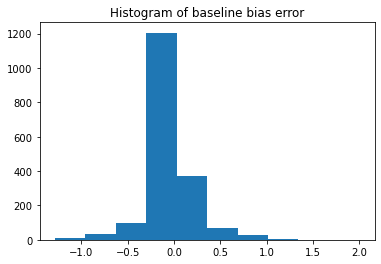

In [77]:
bba = np.array(baseline_bias_list)
print('Frequencies:')
print(np.histogram(bba)[0], '\n')
print(np.histogram(bba)[1], '\n')
plt.hist(bba)
plt.title('Histogram of baseline bias error')
plt.show()

C:\Users\penny\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


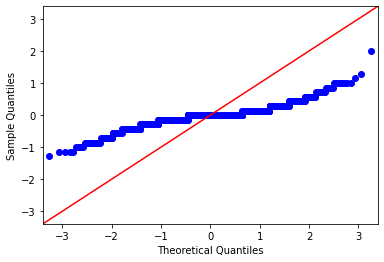

In [78]:
sm.qqplot(bba, line ='45')
plt.show()

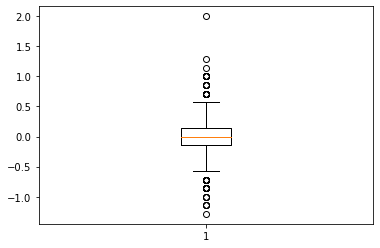

In [79]:
plt.boxplot(bba)
plt.show()

In [80]:
print('Mean: ', np.mean(bba))
print('Median: ', np.median(bba))
print('Mode: ', mode(bba))
print('Standard deviation: ', np.std(bba))

Mean:  -0.018968909878000786
Median:  0.0
Mode:  ModeResult(mode=array([0.]), count=array([761]))
Standard deviation:  0.2615306142751456


In [81]:
print('W test value: ', stats.shapiro(bba)[0])
print('p-value less than 0.05: ', stats.shapiro(bba)[1]<0.05)


W test value:  0.880927324295044
p-value less than 0.05:  True


### Multi-variate linear regression

Frequencies:
(array([   1,    0,    0,    0,    0,    0,    0,    0,    0, 1814],
      dtype=int64), array([-4.26924437e+09, -3.84231993e+09, -3.41539549e+09, -2.98847105e+09,
       -2.56154662e+09, -2.13462218e+09, -1.70769774e+09, -1.28077331e+09,
       -8.53848869e+08, -4.26924432e+08,  5.09533264e+00])) 



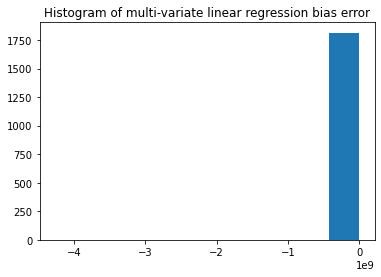

In [82]:
lrba = np.array(lr_bias_list)
print('Frequencies:')
print(np.histogram(lrba), '\n')
plt.hist(lrba)
plt.title('Histogram of multi-variate linear regression bias error')
plt.show()

In [83]:
print('Mean: ', np.mean(lrba))
print('Median: ', np.median(lrba))
print('Mode: ', mode(lrba))
print('Standard deviation: ', np.std(lrba))

Mean:  -2352200.792949077
Median:  -1.3877787807814457e-16
Mode:  ModeResult(mode=array([0.]), count=array([77]))
Standard deviation:  100182767.80109888


In [84]:
print('W test value: ', stats.shapiro(lrba)[0])
print('p-value less than 0.05: ', stats.shapiro(lrba)[1]<0.05)

W test value:  0.007203817367553711
p-value less than 0.05:  True


### Decision tree

Frequencies:
(array([   8,  140, 1509,  150,    6,    1,    0,    0,    0,    1],
      dtype=int64), array([-4.28571429, -2.61428571, -0.94285714,  0.72857143,  2.4       ,
        4.07142857,  5.74285714,  7.41428571,  9.08571429, 10.75714286,
       12.42857143])) 



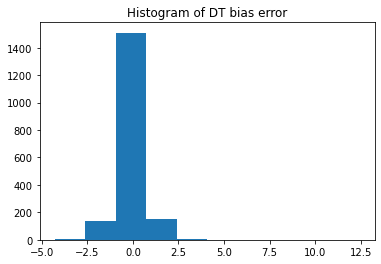

In [85]:
dtba = np.array(dt_bias_list)
print('Frequencies:')
print(np.histogram(dtba), '\n')
plt.hist(dtba)
plt.title('Histogram of DT bias error')
plt.show()

In [86]:
print('Mean: ', np.mean(dtba))
print('Median: ', np.median(dtba))
print('Mode: ', mode(dtba))
print('Standard deviation: ', np.std(dtba))

Mean:  -0.028618653830403244
Median:  0.0
Mode:  ModeResult(mode=array([0.]), count=array([214]))
Standard deviation:  0.7605504199519307


In [87]:
print('W test value: ', stats.shapiro(dtba)[0])
print('p-value less than 0.05: ', stats.shapiro(dtba)[1]<0.05)

W test value:  0.8306543827056885
p-value less than 0.05:  True


### Random forest

Frequencies:
(array([  2,   2,  14, 111, 730, 856,  83,  14,   2,   1], dtype=int64), array([-3.80571429, -3.04785714, -2.29      , -1.53214286, -0.77428571,
       -0.01642857,  0.74142857,  1.49928571,  2.25714286,  3.015     ,
        3.77285714])) 



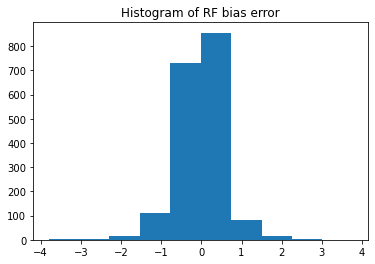

In [88]:
rfba = np.array(rf_bias_list)
print('Frequencies:')
print(np.histogram(rfba), '\n')
plt.hist(rfba)
plt.title('Histogram of RF bias error')
plt.show()

In [89]:
print('Mean: ', np.mean(rfba))
print('Median: ', np.median(rfba))
print('Mode: ', mode(rfba))
print('Standard deviation: ', np.std(rfba))

Mean:  -0.024938213908975642
Median:  0.0
Mode:  ModeResult(mode=array([0.]), count=array([113]))
Standard deviation:  0.5367912589105279


In [90]:
print('W test value: ', stats.shapiro(rfba)[0])
print('p-value less than 0.05: ', stats.shapiro(rfba)[1]<0.05)

W test value:  0.921542763710022
p-value less than 0.05:  True


### Multi-layer perceptron

Frequencies:
(array([   3,    6,   16,   80,  372, 1088,  207,   31,    8,    4],
      dtype=int64), array([-3.56857636, -2.90978477, -2.25099318, -1.59220159, -0.93341   ,
       -0.27461841,  0.38417318,  1.04296477,  1.70175636,  2.36054795,
        3.01933954])) 



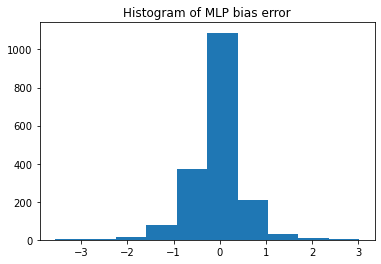

In [91]:
mlpba = np.array(mlp_bias_list)
print('Frequencies:')
print(np.histogram(mlpba), '\n')
plt.hist(mlpba)
plt.title('Histogram of MLP bias error')
plt.show()

In [92]:
print('Mean: ', np.mean(mlpba))
print('Median: ', np.median(mlpba))
print('Mode: ', mode(mlpba))
print('Standard deviation: ', np.std(mlpba))

Mean:  -0.06800415235666983
Median:  -0.014708980488395973
Mode:  ModeResult(mode=array([0.01523215]), count=array([54]))
Standard deviation:  0.5629296649313624


In [93]:
print('W test value: ', stats.shapiro(mlpba)[0])
print('p-value less than 0.05: ', stats.shapiro(mlpba)[1]<0.05)

W test value:  0.9269081950187683
p-value less than 0.05:  True


### LSTM

Frequencies:
(array([  35, 1226,  468,   64,   14,    2,    4,    1,    0,    1],
      dtype=int64), array([-1.55994448, -0.65594686,  0.24805076,  1.15204837,  2.05604599,
        2.96004361,  3.86404123,  4.76803884,  5.67203646,  6.57603408,
        7.48003169])) 



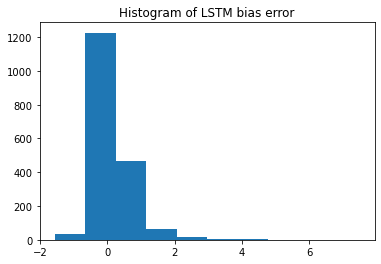

In [94]:
lstmba = np.array(lstm_bias_list)
print('Frequencies:')
print(np.histogram(lstmba), '\n')
plt.hist(lstmba)
plt.title('Histogram of LSTM bias error')
plt.show()

In [95]:
print('Mean: ', np.mean(lstmba))
print('Median: ', np.median(lstmba))
print('Mode: ', mode(lstmba))
print('Standard deviation: ', np.std(lstmba))

Mean:  0.1740585284189391
Median:  0.03646743191140039
Mode:  ModeResult(mode=array([0.]), count=array([54]))
Standard deviation:  0.5663227909499252


In [96]:
print('W test value: ', stats.shapiro(lstmba)[0])
print('p-value less than 0.05: ', stats.shapiro(lstmba)[1]<0.05)

W test value:  0.7735304832458496
p-value less than 0.05:  True


All bias errors have been tested to be not normally distributed. Besides, the observations are dependent, as they were applied to the same neighborhoods (just with different ML techniques). Therefore, the Wilcoxon-signed rank test will be used to test if there are significant differences among ML techniques.

In [97]:
# Wilcoxon-signed rank test

print(stats.wilcoxon(bba, lrba))
print(stats.wilcoxon(bba, dtba))
print(stats.wilcoxon(bba, rfba))
print(stats.wilcoxon(bba, mlpba))
print(stats.wilcoxon(bba, lstmba))
print()
print(stats.wilcoxon(lrba, dtba))
print(stats.wilcoxon(lrba, rfba))
print(stats.wilcoxon(lrba, mlpba))
print(stats.wilcoxon(lrba, lstmba))
print()
print(stats.wilcoxon(dtba, rfba))
print(stats.wilcoxon(dtba, mlpba))
print(stats.wilcoxon(dtba, lstmba))
print()
print(stats.wilcoxon(rfba, mlpba))
print(stats.wilcoxon(rfba, lstmba))
print()
print(stats.wilcoxon(mlpba, lstmba))


WilcoxonResult(statistic=719521.0, pvalue=0.09220274814688258)
WilcoxonResult(statistic=643588.5, pvalue=0.9648044986609277)
WilcoxonResult(statistic=713641.0, pvalue=0.5597571869567114)
WilcoxonResult(statistic=756286.0, pvalue=0.0024231564947133186)
WilcoxonResult(statistic=475284.0, pvalue=5.237288177644298e-45)

WilcoxonResult(statistic=713775.5, pvalue=0.5096429741355467)
WilcoxonResult(statistic=696010.0, pvalue=0.0195081532067091)
WilcoxonResult(statistic=786136.0, pvalue=0.08987625485926658)
WilcoxonResult(statistic=561004.0, pvalue=8.233488346683837e-24)

WilcoxonResult(statistic=674452.5, pvalue=0.1219856271710948)
WilcoxonResult(statistic=764124.0, pvalue=0.007323180898034741)
WilcoxonResult(statistic=596141.0, pvalue=3.948931274983654e-17)

WilcoxonResult(statistic=721951.0, pvalue=4.869216515710493e-06)
WilcoxonResult(statistic=548018.0, pvalue=1.4174441253498133e-26)

WilcoxonResult(statistic=503851.0, pvalue=1.2817854061855758e-46)


## Mean Absolute Error comparison

In [98]:
len(baseline_mae_list)

1815

### Baseline

Frequencies:
[778 521 283 147  54  17  10   4   0   1] 

[0.         0.74285714 1.48571429 2.22857143 2.97142857 3.71428571
 4.45714286 5.2        5.94285714 6.68571429 7.42857143] 



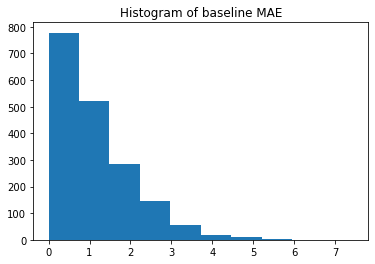

In [99]:
bmae = np.array(baseline_mae_list)
print('Frequencies:')
print(np.histogram(bmae)[0], '\n')
print(np.histogram(bmae)[1], '\n')
plt.hist(bmae)
plt.title('Histogram of baseline MAE')
plt.show()

C:\Users\penny\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


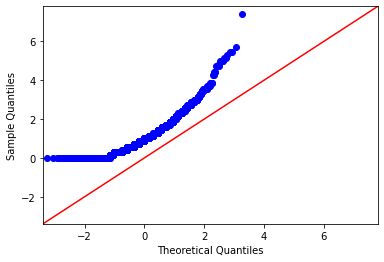

In [100]:
sm.qqplot(bmae, line ='45')
plt.show()

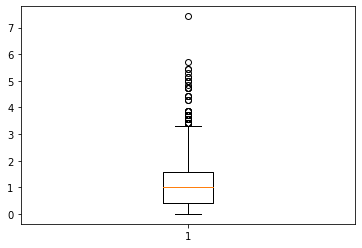

In [101]:
plt.boxplot(bmae)
plt.show()

In [102]:
print('Mean: ', np.mean(bmae))
print('Median: ', np.median(bmae))
print('Mode: ', mode(bmae))
print('Standard deviation: ', np.std(bmae))

Mean:  1.123258559622196
Median:  1.0
Mode:  ModeResult(mode=array([0.]), count=array([222]))
Standard deviation:  0.9503372779794403


In [103]:
print('W test value: ', stats.shapiro(bmae)[0])
print('p-value less than 0.05: ', stats.shapiro(bmae)[1]<0.05)


W test value:  0.8996304273605347
p-value less than 0.05:  True


### Multi-variate linear regression

Frequencies:
(array([1814,    0,    0,    0,    0,    0,    0,    0,    0,    1],
      dtype=int64), array([0.00000000e+00, 4.18680550e+09, 8.37361099e+09, 1.25604165e+10,
       1.67472220e+10, 2.09340275e+10, 2.51208330e+10, 2.93076385e+10,
       3.34944440e+10, 3.76812495e+10, 4.18680550e+10])) 



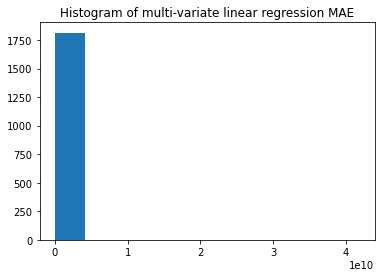

In [104]:
lrmae = np.array(lr_mae_list)
print('Frequencies:')
print(np.histogram(lrmae), '\n')
plt.hist(lrmae)
plt.title('Histogram of multi-variate linear regression MAE')
plt.show()

In [105]:
print('Mean: ', np.mean(lrmae))
print('Median: ', np.median(lrmae))
print('Mode: ', mode(lrmae))
print('Standard deviation: ', np.std(lrmae))

Mean:  23067800.021932688
Median:  0.9351648351648352
Mode:  ModeResult(mode=array([0.]), count=array([76]))
Standard deviation:  982482441.3324625


In [106]:
print('W test value: ', stats.shapiro(lrmae)[0])
print('p-value less than 0.05: ', stats.shapiro(lrmae)[1]<0.05)

W test value:  0.0072037577629089355
p-value less than 0.05:  True


### Decision tree

Frequencies:
(array([1311,  428,   58,   13,    1,    3,    0,    0,    0,    1],
      dtype=int64), array([ 0.        ,  1.41428571,  2.82857143,  4.24285714,  5.65714286,
        7.07142857,  8.48571429,  9.9       , 11.31428571, 12.72857143,
       14.14285714])) 



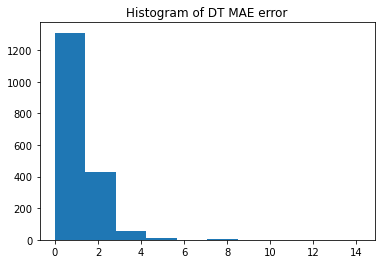

In [107]:
dtmae = np.array(dt_mae_list)
print('Frequencies:')
print(np.histogram(dtmae), '\n')
plt.hist(dtmae)
plt.title('Histogram of DT MAE error')
plt.show()

In [108]:
print('Mean: ', np.mean(dtmae))
print('Median: ', np.median(dtmae))
print('Mode: ', mode(dtmae))
print('Standard deviation: ', np.std(dtmae))

Mean:  0.9964724707252549
Median:  0.7857142857142857
Mode:  ModeResult(mode=array([0.]), count=array([134]))
Standard deviation:  0.9680928106337383


In [109]:
print('W test value: ', stats.shapiro(dtmae)[0])
print('p-value less than 0.05: ', stats.shapiro(dtmae)[1]<0.05)

W test value:  0.80753493309021
p-value less than 0.05:  True


### Random forest

Frequencies:
(array([897, 621, 210,  66,  11,   6,   2,   0,   1,   1], dtype=int64), array([0.        , 0.67528571, 1.35057143, 2.02585714, 2.70114286,
       3.37642857, 4.05171429, 4.727     , 5.40228571, 6.07757143,
       6.75285714])) 



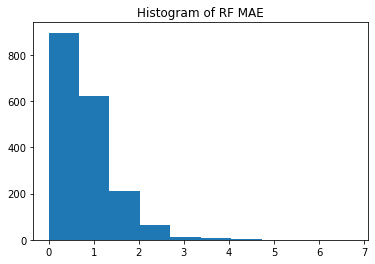

In [110]:
rfmae = np.array(rf_mae_list)
print('Frequencies:')
print(np.histogram(rfmae), '\n')
plt.hist(rfmae)
plt.title('Histogram of RF MAE')
plt.show()

In [111]:
print('Mean: ', np.mean(rfmae))
print('Median: ', np.median(rfmae))
print('Mode: ', mode(rfmae))
print('Standard deviation: ', np.std(rfmae))

Mean:  0.7956737711994397
Median:  0.6857142857142857
Mode:  ModeResult(mode=array([0.]), count=array([112]))
Standard deviation:  0.6648558502145618


In [112]:
print('W test value: ', stats.shapiro(rfmae)[0])
print('p-value less than 0.05: ', stats.shapiro(rfmae)[1]<0.05)

W test value:  0.8826186060905457
p-value less than 0.05:  True


### Multi-layer perceptron

Frequencies:
(array([782, 556, 290, 120,  36,  17,   6,   5,   2,   1], dtype=int64), array([7.04055279e-04, 6.21898643e-01, 1.24309323e+00, 1.86428782e+00,
       2.48548241e+00, 3.10667699e+00, 3.72787158e+00, 4.34906617e+00,
       4.97026076e+00, 5.59145535e+00, 6.21264993e+00])) 



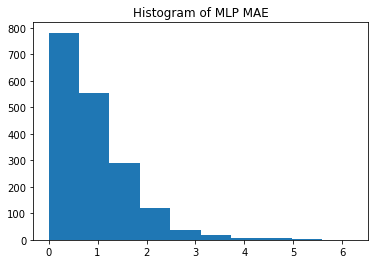

In [113]:
mlpmae = np.array(mlp_mae_list)
print('Frequencies:')
print(np.histogram(mlpmae), '\n')
plt.hist(mlpmae)
plt.title('Histogram of MLP MAE')
plt.show()

In [114]:
print('Mean: ', np.mean(mlpmae))
print('Median: ', np.median(mlpmae))
print('Mode: ', mode(mlpmae))
print('Standard deviation: ', np.std(mlpmae))

Mean:  0.8981927263432488
Median:  0.7425484420906977
Mode:  ModeResult(mode=array([0.01523215]), count=array([54]))
Standard deviation:  0.769556362902626


In [115]:
print('W test value: ', stats.shapiro(mlpmae)[0])
print('p-value less than 0.05: ', stats.shapiro(mlpmae)[1]<0.05)

W test value:  0.8825589418411255
p-value less than 0.05:  True


### LSTM

Frequencies:
(array([1168,  504,  108,   27,    2,    3,    2,    0,    0,    1],
      dtype=int64), array([0.        , 0.93290509, 1.86581018, 2.79871526, 3.73162035,
       4.66452544, 5.59743053, 6.53033562, 7.46324071, 8.39614579,
       9.32905088])) 



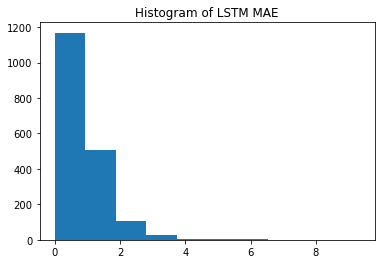

In [116]:
lstmmae = np.array(lstm_mae_list)
print('Frequencies:')
print(np.histogram(lstmmae), '\n')
plt.hist(lstmmae)
plt.title('Histogram of LSTM MAE')
plt.show()

In [117]:
print('Mean: ', np.mean(lstmmae))
print('Median: ', np.median(lstmmae))
print('Mode: ', mode(lstmmae))
print('Standard deviation: ', np.std(lstmmae))

Mean:  0.8565500946143288
Median:  0.6886665097304753
Mode:  ModeResult(mode=array([0.]), count=array([54]))
Standard deviation:  0.7220607098998105


In [118]:
print('W test value: ', stats.shapiro(lstmmae)[0])
print('p-value less than 0.05: ', stats.shapiro(lstmmae)[1]<0.05)

W test value:  0.8396773934364319
p-value less than 0.05:  True


In [119]:
# Wilcoxon-signed rank test
print(stats.wilcoxon(bmae, lrmae))
print("p-value is less than 0.05: ", stats.wilcoxon(bmae, lrmae)[1]<0.05, '\n')
print(stats.wilcoxon(bmae, dtmae))
print(stats.wilcoxon(bmae, rfmae))
print(stats.wilcoxon(bmae, mlpmae))
print(stats.wilcoxon(bmae, lstmmae))
print()
print(stats.wilcoxon(lrmae, dtmae))
print(stats.wilcoxon(lrmae, rfmae))
print(stats.wilcoxon(lrmae, mlpmae))
print(stats.wilcoxon(lrmae, lstmmae))
print()
print(stats.wilcoxon(dtmae, rfmae))
print(stats.wilcoxon(dtmae, mlpmae))
print(stats.wilcoxon(dtmae, lstmmae))
print()
print(stats.wilcoxon(rfmae, mlpmae))
print(stats.wilcoxon(rfmae, lstmmae))
print()
print(stats.wilcoxon(mlpmae, lstmmae))


WilcoxonResult(statistic=740277.0, pvalue=0.5424459043809311)
p-value is less than 0.05:  False 

WilcoxonResult(statistic=430815.5, pvalue=1.86189254468502e-30)
WilcoxonResult(statistic=204428.5, pvalue=6.5329474626945e-145)
WilcoxonResult(statistic=429897.0, pvalue=1.0369727822342372e-69)
WilcoxonResult(statistic=242118.0, pvalue=5.733403199040136e-138)

WilcoxonResult(statistic=479564.5, pvalue=1.8084125944801501e-32)
WilcoxonResult(statistic=215165.0, pvalue=2.8958362679972386e-144)
WilcoxonResult(statistic=397409.0, pvalue=2.3480339300686434e-81)
WilcoxonResult(statistic=375749.0, pvalue=2.2872900817804144e-78)

WilcoxonResult(statistic=313395.0, pvalue=3.983368700397397e-86)
WilcoxonResult(statistic=695080.0, pvalue=7.75650296071829e-09)
WilcoxonResult(statistic=610964.0, pvalue=1.1646075969481468e-14)

WilcoxonResult(statistic=514937.0, pvalue=1.4474473606793257e-43)
WilcoxonResult(statistic=545750.0, pvalue=4.491684888630843e-27)

WilcoxonResult(statistic=769064.0, pvalue=0.013

## Root Mean Squared Error comparison

In [120]:
len(baseline_rmse_list)

1815

### Baseline

Frequencies:
[706 615 290 137  45  10   7   3   1   1] 

[0.         0.9319718  1.86394359 2.79591539 3.72788718 4.65985898
 5.59183078 6.52380257 7.45577437 8.38774616 9.31971796] 



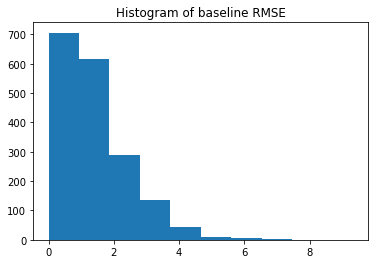

In [121]:
brmse = np.array(baseline_rmse_list)
print('Frequencies:')
print(np.histogram(brmse)[0], '\n')
print(np.histogram(brmse)[1], '\n')
plt.hist(brmse)
plt.title('Histogram of baseline RMSE')
plt.show()

C:\Users\penny\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


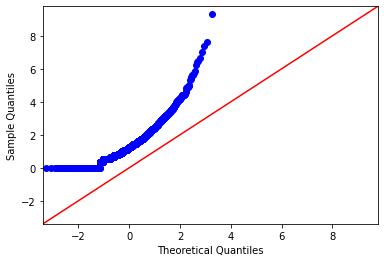

In [122]:
sm.qqplot(brmse, line ='45')
plt.show()

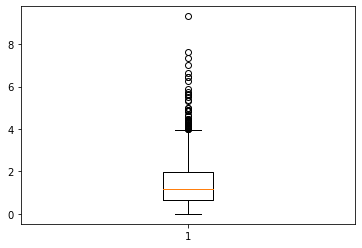

In [123]:
plt.boxplot(brmse)
plt.show()

In [124]:
print('Mean: ', np.mean(brmse))
print('Median: ', np.median(brmse))
print('Mode: ', mode(brmse))
print('Standard deviation: ', np.std(brmse))

Mean:  1.4228716516800097
Median:  1.1952286093343936
Mode:  ModeResult(mode=array([0.]), count=array([222]))
Standard deviation:  1.1160493416400867


In [125]:
print('W test value: ', stats.shapiro(brmse)[0])
print('p-value less than 0.05: ', stats.shapiro(brmse)[1]<0.05)


W test value:  0.90595942735672
p-value less than 0.05:  True


### Multi-variate linear regression

Frequencies:
(array([1814,    0,    0,    0,    0,    0,    0,    0,    0,    1],
      dtype=int64), array([0.0000000e+00, 7.8734120e+09, 1.5746824e+10, 2.3620236e+10,
       3.1493648e+10, 3.9367060e+10, 4.7240472e+10, 5.5113884e+10,
       6.2987296e+10, 7.0860708e+10, 7.8734120e+10])) 



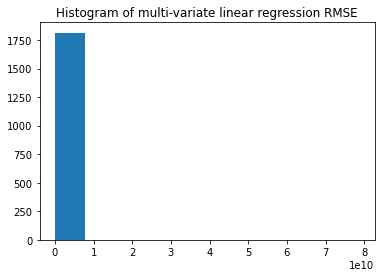

In [126]:
lrrmse = np.array(lr_rmse_list)
print('Frequencies:')
print(np.histogram(lrrmse), '\n')
plt.hist(lrrmse)
plt.title('Histogram of multi-variate linear regression RMSE')
plt.show()

In [127]:
print('Mean: ', np.mean(lrrmse))
print('Median: ', np.median(lrrmse))
print('Mode: ', mode(lrrmse))
print('Standard deviation: ', np.std(lrrmse))

Mean:  43379681.888245374
Median:  1.184412754436116
Mode:  ModeResult(mode=array([0.]), count=array([76]))
Standard deviation:  1847587391.918093


In [128]:
print('W test value: ', stats.shapiro(lrrmse)[0])
print('p-value less than 0.05: ', stats.shapiro(lrrmse)[1]<0.05)

W test value:  0.0072037577629089355
p-value less than 0.05:  True


### Decision tree

Frequencies:
(array([1187,  514,   87,   19,    4,    1,    2,    0,    0,    1],
      dtype=int64), array([ 0.        ,  1.4923615 ,  2.98472301,  4.47708451,  5.96944601,
        7.46180752,  8.95416902, 10.44653052, 11.93889203, 13.43125353,
       14.92361504])) 



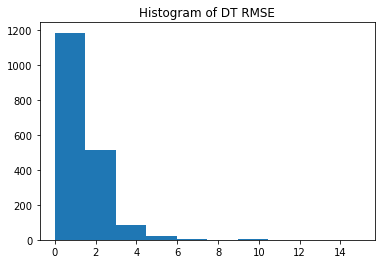

In [129]:
dtrmse = np.array(dt_rmse_list)
print('Frequencies:')
print(np.histogram(dtrmse), '\n')
plt.hist(dtrmse)
plt.title('Histogram of DT RMSE')
plt.show()

In [130]:
print('Mean: ', np.mean(dtrmse))
print('Median: ', np.median(dtrmse))
print('Mode: ', mode(dtrmse))
print('Standard deviation: ', np.std(dtrmse))

Mean:  1.2819250992833013
Median:  1.0690449676496976
Mode:  ModeResult(mode=array([0.]), count=array([134]))
Standard deviation:  1.1379889979396696


In [131]:
print('W test value: ', stats.shapiro(dtrmse)[0])
print('p-value less than 0.05: ', stats.shapiro(dtrmse)[1]<0.05)

W test value:  0.8408591151237488
p-value less than 0.05:  True


### Random forest

Frequencies:
(array([781, 640, 278,  79,  23,   7,   4,   1,   1,   1], dtype=int64), array([0.        , 0.74289636, 1.48579272, 2.22868908, 2.97158544,
       3.71448179, 4.45737815, 5.20027451, 5.94317087, 6.68606723,
       7.42896359])) 



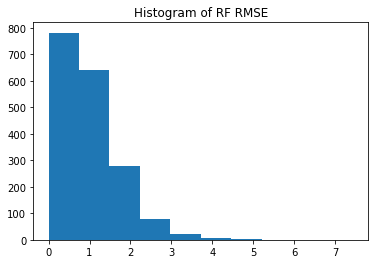

In [132]:
rfrmse = np.array(rf_rmse_list)
print('Frequencies:')
print(np.histogram(rfrmse), '\n')
plt.hist(rfrmse)
plt.title('Histogram of RF RMSE')
plt.show()

In [133]:
print('Mean: ', np.mean(rfrmse))
print('Median: ', np.median(rfrmse))
print('Mode: ', mode(rfrmse))
print('Standard deviation: ', np.std(rfrmse))

Mean:  0.9900695991311749
Median:  0.8476943519250995
Mode:  ModeResult(mode=array([0.]), count=array([112]))
Standard deviation:  0.7800497879043763


In [134]:
print('W test value: ', stats.shapiro(rfrmse)[0])
print('p-value less than 0.05: ', stats.shapiro(rfrmse)[1]<0.05)

W test value:  0.8978771567344666
p-value less than 0.05:  True


### Multi-layer perceptron

Frequencies:
(array([702, 587, 318, 136,  36,  19,   8,   6,   0,   3], dtype=int64), array([7.04055279e-04, 7.31763628e-01, 1.46282320e+00, 2.19388277e+00,
       2.92494235e+00, 3.65600192e+00, 4.38706149e+00, 5.11812106e+00,
       5.84918064e+00, 6.58024021e+00, 7.31129978e+00])) 



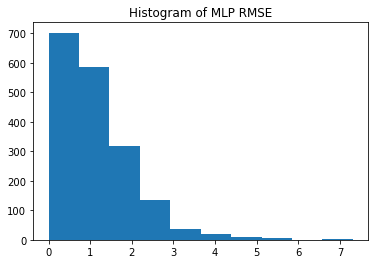

In [135]:
mlprmse = np.array(mlp_rmse_list)
print('Frequencies:')
print(np.histogram(mlprmse), '\n')
plt.hist(mlprmse)
plt.title('Histogram of MLP RMSE')
plt.show()

In [136]:
print('Mean: ', np.mean(mlprmse))
print('Median: ', np.median(mlprmse))
print('Mode: ', mode(mlprmse))
print('Standard deviation: ', np.std(mlprmse))

Mean:  1.1220915849827513
Median:  0.9308698710294838
Mode:  ModeResult(mode=array([0.01523215]), count=array([54]))
Standard deviation:  0.9221341118749165


In [137]:
print('W test value: ', stats.shapiro(mlprmse)[0])
print('p-value less than 0.05: ', stats.shapiro(mlprmse)[1]<0.05)

W test value:  0.8914302587509155
p-value less than 0.05:  True


### LSTM

Frequencies:
(array([1127,  527,  119,   32,    4,    4,    1,    0,    0,    1],
      dtype=int64), array([ 0.        ,  1.09453664,  2.18907328,  3.28360992,  4.37814657,
        5.47268321,  6.56721985,  7.66175649,  8.75629313,  9.85082977,
       10.94536642])) 



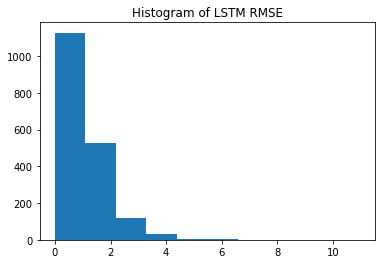

In [138]:
lstmrmse = np.array(lstm_rmse_list)
print('Frequencies:')
print(np.histogram(lstmrmse), '\n')
plt.hist(lstmrmse)
plt.title('Histogram of LSTM RMSE')
plt.show()

In [139]:
print('Mean: ', np.mean(lstmrmse))
print('Median: ', np.median(lstmrmse))
print('Mode: ', mode(lstmrmse))
print('Standard deviation: ', np.std(lstmrmse))

Mean:  1.0507466726691366
Median:  0.8350918510390068
Mode:  ModeResult(mode=array([0.]), count=array([54]))
Standard deviation:  0.8870058122892992


In [140]:
print('W test value: ', stats.shapiro(lstmrmse)[0])
print('p-value less than 0.05: ', stats.shapiro(lstmrmse)[1]<0.05)

W test value:  0.8431178331375122
p-value less than 0.05:  True


All bias errors have been tested to be not normally distributed. Besides, the observations are dependent, as they were applied to the same neighborhoods (just with different ML techniques). Therefore, the Wilcoxon-signed rank test will be used to test if there are significant differences among ML techniques.

In [141]:
# Wilcoxon-signed rank test
print(stats.wilcoxon(brmse, lrrmse))
print("p-value is less than 0.05: ", stats.wilcoxon(brmse, lrrmse)[1]<0.05, '\n')
print(stats.wilcoxon(brmse, dtrmse))
print(stats.wilcoxon(brmse, rfrmse))
print(stats.wilcoxon(brmse, mlprmse))
print(stats.wilcoxon(brmse, lstmrmse))

print()
print(stats.wilcoxon(lrrmse, dtrmse))
print(stats.wilcoxon(lrrmse, rfrmse))
print(stats.wilcoxon(lrrmse, mlprmse))
print(stats.wilcoxon(lrrmse, lstmrmse))

print()
print(stats.wilcoxon(dtrmse, rfrmse))
print(stats.wilcoxon(dtrmse, mlprmse))
print(stats.wilcoxon(dtrmse, lstmrmse))
print()
print(stats.wilcoxon(rfrmse, mlprmse))
print(stats.wilcoxon(rfrmse, lstmrmse))
print()
print(stats.wilcoxon(mlprmse, lstmrmse))


WilcoxonResult(statistic=693296.0, pvalue=0.00423479297653584)
p-value is less than 0.05:  True 

WilcoxonResult(statistic=450368.5, pvalue=6.463758419803051e-35)
WilcoxonResult(statistic=125942.0, pvalue=2.3509356359476134e-191)
WilcoxonResult(statistic=352779.0, pvalue=7.56239826280117e-99)
WilcoxonResult(statistic=115146.0, pvalue=2.3892595836452184e-210)

WilcoxonResult(statistic=550332.5, pvalue=4.9526569949189853e-17)
WilcoxonResult(statistic=215437.0, pvalue=1.8098561653220644e-143)
WilcoxonResult(statistic=389964.0, pvalue=3.7411399574498807e-84)
WilcoxonResult(statistic=323705.0, pvalue=1.4693608368147566e-99)

WilcoxonResult(statistic=178815.0, pvalue=7.400871442102712e-155)
WilcoxonResult(statistic=570517.0, pvalue=7.2674740873458e-30)
WilcoxonResult(statistic=429958.0, pvalue=4.953136510608902e-59)

WilcoxonResult(statistic=512058.0, pvalue=2.3880406313403813e-44)
WilcoxonResult(statistic=614618.0, pvalue=4.3981295856682754e-14)

WilcoxonResult(statistic=698290.0, pvalue=1.